# TESS Atlas fit for TOI 367

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 367.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-367.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-367.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-367.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 367

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 367 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

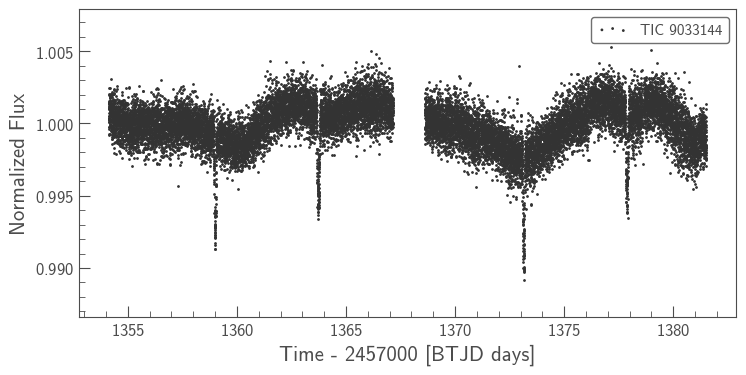

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -36265.912512860574 -> -35643.127708678025


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -83562.61443241528 -> -47402.78747041298


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -47402.78747041298 -> -39184.08652001656


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -39184.08652001656 -> -39184.02407145172


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -39184.02407145172 -> -39183.098337082294


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -39183.098337082294 -> -39183.0153641275


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -39183.0153641275 -> -28558.663420262546


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -28558.663420262546 -> -28558.663420262546


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -28558.663420262546 -> -28558.663420262546


optimizing logp for variables: ['logg_star']


message: Desired error not necessarily achieved due to precision loss.
logp: -28558.663420262546 -> -28558.663420262514


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -28558.663420262514 -> -28558.663420262514


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -28558.663420262514 -> -28558.663420262514


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -28558.663420262514 -> -28558.663420262514


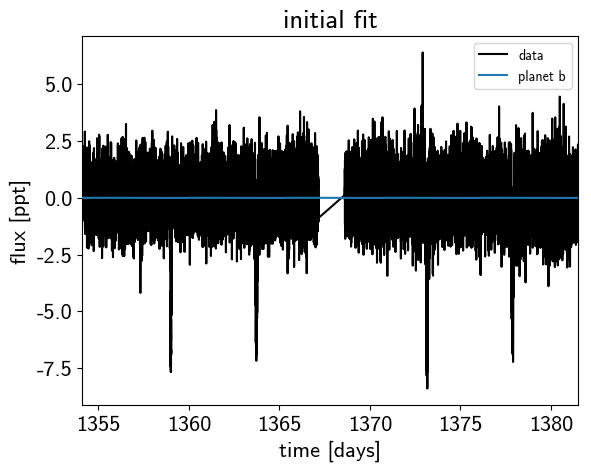

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   7%|▋         | 7/104 [00:00<00:11,  8.55draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:01<00:18,  5.22draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:02<00:21,  4.32draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:02<00:18,  4.90draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:02<00:26,  3.43draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:03<00:28,  3.21draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:03<00:26,  3.40draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:03<00:31,  2.76draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:04<00:28,  3.01draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:04<00:32,  2.63draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:04<00:28,  3.03draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:05<00:29,  2.81draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:05<00:26,  3.12draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:05<00:27,  2.95draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:06<00:25,  3.18draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:06<00:27,  2.95draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:07<00:27,  2.83draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:07<00:23,  3.28draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:07<00:27,  2.80draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:07<00:22,  3.43draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:08<00:28,  2.66draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:09<00:26,  2.78draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:09<00:24,  2.85draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:09<00:20,  3.40draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:10<00:27,  2.52draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:11<00:24,  2.68draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:11<00:21,  3.09draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:11<00:22,  2.91draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:12<00:23,  2.72draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:12<00:19,  3.17draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:12<00:23,  2.66draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:13<00:21,  2.84draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:13<00:22,  2.71draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:13<00:20,  2.94draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:14<00:20,  2.90draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:14<00:19,  2.86draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:14<00:18,  3.01draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:15<00:17,  3.11draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:15<00:17,  3.13draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:15<00:16,  3.24draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:16<00:16,  3.11draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:16<00:15,  3.32draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:16<00:16,  3.06draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:17<00:15,  3.11draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:17<00:17,  2.77draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:17<00:14,  3.34draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:18<00:17,  2.60draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:18<00:15,  2.78draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:19<00:14,  2.87draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:19<00:16,  2.52draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:19<00:13,  3.09draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:20<00:16,  2.40draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:21<00:14,  2.55draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:21<00:11,  3.23draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:21<00:13,  2.63draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:21<00:10,  3.23draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:22<00:13,  2.44draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:23<00:12,  2.64draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:23<00:10,  2.83draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:24<00:09,  2.96draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:24<00:07,  3.67draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:25<00:09,  2.76draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:25<00:07,  3.46draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:25<00:08,  2.80draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:25<00:07,  3.22draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:26<00:08,  2.70draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:26<00:06,  3.31draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:27<00:07,  2.81draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:27<00:05,  3.48draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:27<00:06,  2.85draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:27<00:04,  3.51draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:28<00:05,  2.88draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:28<00:04,  3.59draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:29<00:05,  2.70draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:29<00:04,  2.76draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:30<00:03,  2.79draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:31<00:02,  2.91draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:31<00:02,  3.14draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:31<00:02,  2.98draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:32<00:01,  2.62draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:32<00:01,  3.20draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:32<00:01,  2.66draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:33<00:00,  2.12draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:35<00:00,  1.25draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:36<00:00,  1.07s/draws]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   7%|▋         | 7/104 [00:00<00:09, 10.15draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:01<00:16,  5.89draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:19,  4.76draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:02<00:21,  4.29draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:02<00:25,  3.61draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:26,  3.44draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:03<00:31,  2.85draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:03<00:24,  3.55draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:04<00:33,  2.60draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:04<00:30,  2.77draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:04<00:23,  3.50draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:05<00:30,  2.75draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:05<00:26,  3.14draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:06<00:29,  2.76draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:06<00:28,  2.84draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:06<00:25,  3.04draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:07<00:23,  3.22draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:07<00:19,  3.91draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:07<00:24,  3.05draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:08<00:23,  3.07draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:08<00:19,  3.68draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:08<00:16,  4.22draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:09<00:17,  4.02draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:09<00:20,  3.34draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:09<00:19,  3.42draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:10<00:21,  3.13draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:10<00:20,  3.14draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:11<00:19,  3.16draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:11<00:15,  4.07draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:11<00:16,  3.75draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:11<00:13,  4.31draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:12<00:11,  5.12draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:12<00:08,  6.28draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:12<00:07,  7.61draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:12<00:05,  9.32draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:12<00:05,  9.61draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:13<00:07,  6.01draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:13<00:06,  6.78draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:13<00:06,  6.46draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:13<00:07,  6.24draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:14<00:06,  6.47draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:14<00:09,  4.12draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:14<00:08,  4.92draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:15<00:11,  3.30draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:15<00:09,  3.88draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:15<00:09,  3.65draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:16<00:07,  4.28draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:16<00:07,  4.52draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:16<00:07,  4.23draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:17<00:07,  3.93draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:17<00:06,  4.33draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:17<00:05,  4.61draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:18<00:05,  4.30draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:18<00:06,  3.99draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:18<00:05,  3.98draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:18<00:04,  4.44draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:19<00:05,  3.71draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:19<00:04,  3.87draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:20<00:04,  3.45draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:21<00:07,  2.19draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:21<00:07,  1.95draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:22<00:07,  1.77draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:23<00:08,  1.50draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:24<00:08,  1.37draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:25<00:08,  1.34draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:25<00:07,  1.33draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:26<00:06,  1.30draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:26<00:03,  1.78draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:27<00:02,  2.39draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:27<00:00,  3.13draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:27<00:00,  3.17draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:27<00:00,  3.77draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:27<00:00,  4.12draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   2%|▏         | 4/204 [00:00<00:07, 25.14draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:00<00:15, 12.81draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:01<01:00,  3.27draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:01<01:05,  2.97draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:02<01:01,  3.19draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:02<01:10,  2.76draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:03<01:17,  2.48draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:03<01:09,  2.77draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:04<01:34,  2.02draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:05<01:26,  2.18draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:05<01:29,  2.10draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:05<01:21,  2.28draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:06<01:28,  2.11draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:06<01:09,  2.66draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:07<01:30,  2.02draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:08<01:23,  2.19draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:08<01:12,  2.49draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:08<01:10,  2.54draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:09<01:18,  2.29draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:09<01:14,  2.40draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:10<01:16,  2.31draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:10<01:06,  2.66draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:10<01:16,  2.29draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:11<01:08,  2.52draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:11<01:14,  2.32draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:12<01:09,  2.47draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:12<01:09,  2.46draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:12<01:02,  2.74draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:13<01:08,  2.47draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:13<00:56,  2.96draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:14<01:11,  2.34draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:14<01:04,  2.55draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:15<01:00,  2.69draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:15<00:55,  2.93draws/s]

Sampling 2 chains:  21%|██        | 42/204 [00:15<01:06,  2.44draws/s]

Sampling 2 chains:  22%|██▏       | 44/204 [00:16<01:08,  2.34draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:17<00:56,  2.82draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:17<01:13,  2.16draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:18<01:06,  2.35draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:18<01:05,  2.37draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:18<01:06,  2.32draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:19<01:01,  2.50draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:19<01:07,  2.27draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:20<00:57,  2.66draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:20<01:05,  2.30draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:20<00:51,  2.92draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:21<01:06,  2.23draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:21<00:55,  2.67draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:22<01:13,  1.99draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:23<01:08,  2.13draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:23<01:00,  2.36draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:23<00:59,  2.42draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:24<01:07,  2.12draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:24<00:53,  2.65draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:25<00:58,  2.41draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:25<01:05,  2.11draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:26<00:59,  2.30draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:26<00:49,  2.77draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:27<00:47,  2.83draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:27<00:43,  3.08draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:28<00:47,  2.77draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:28<00:49,  2.67draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:28<00:44,  2.91draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:29<00:54,  2.35draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:29<00:42,  3.04draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:30<00:56,  2.24draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:30<00:51,  2.41draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:31<00:47,  2.60draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:31<00:47,  2.60draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:32<00:55,  2.21draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:32<00:50,  2.38draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:32<00:38,  3.06draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:33<00:47,  2.51draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:33<00:42,  2.73draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:34<00:45,  2.54draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:34<00:46,  2.48draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:35<00:42,  2.65draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:35<00:47,  2.37draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:35<00:38,  2.91draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:36<00:47,  2.35draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:36<00:42,  2.56draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:37<00:35,  3.05draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:37<00:40,  2.63draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:37<00:37,  2.82draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:38<00:40,  2.56draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:38<00:38,  2.69draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [00:39<00:39,  2.58draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:39<00:41,  2.44draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:40<00:41,  2.41draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:40<00:51,  1.93draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:41<00:46,  2.11draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:41<00:41,  2.33draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:42<00:38,  2.49draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:42<00:44,  2.15draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:42<00:34,  2.71draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:43<00:43,  2.11draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:44<00:39,  2.32draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:44<00:32,  2.79draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:44<00:34,  2.55draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:45<00:33,  2.59draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:45<00:30,  2.84draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:46<00:35,  2.41draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:46<00:29,  2.90draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:47<00:37,  2.27draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:47<00:30,  2.70draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:47<00:35,  2.30draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:48<00:35,  2.27draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:48<00:27,  2.86draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:49<00:36,  2.11draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:50<00:34,  2.23draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:50<00:26,  2.79draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:51<00:30,  2.39draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:51<00:26,  2.79draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:51<00:27,  2.60draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:52<00:27,  2.54draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:52<00:29,  2.40draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:53<00:26,  2.57draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:53<00:30,  2.27draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:53<00:26,  2.55draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:54<00:29,  2.26draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:54<00:25,  2.60draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:55<00:25,  2.47draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:55<00:24,  2.56draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:55<00:22,  2.72draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:56<00:23,  2.57draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:56<00:19,  3.04draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:56<00:23,  2.52draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:57<00:21,  2.60draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:58<00:20,  2.69draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:58<00:17,  3.06draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:59<00:19,  2.74draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:59<00:20,  2.54draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:59<00:16,  3.04draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [01:00<00:21,  2.31draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [01:00<00:18,  2.67draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [01:00<00:18,  2.65draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [01:01<00:21,  2.19draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [01:02<00:19,  2.31draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [01:02<00:16,  2.70draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [01:03<00:18,  2.38draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [01:03<00:15,  2.67draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [01:03<00:16,  2.48draws/s]

Sampling 2 chains:  80%|████████  | 164/204 [01:04<00:15,  2.66draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [01:04<00:14,  2.75draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [01:04<00:14,  2.63draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [01:05<00:12,  2.91draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [01:05<00:13,  2.59draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [01:05<00:11,  3.09draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [01:06<00:14,  2.38draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [01:07<00:13,  2.38draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [01:08<00:12,  2.35draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [01:09<00:12,  2.30draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [01:09<00:10,  2.45draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [01:09<00:07,  3.15draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [01:10<00:10,  2.37draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [01:10<00:08,  2.70draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [01:11<00:08,  2.45draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [01:11<00:08,  2.59draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [01:12<00:10,  1.92draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [01:13<00:11,  1.61draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [01:14<00:12,  1.50draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [01:14<00:09,  1.73draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [01:15<00:09,  1.57draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [01:16<00:10,  1.34draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [01:17<00:11,  1.17draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [01:18<00:10,  1.19draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [01:19<00:09,  1.22draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [01:20<00:08,  1.13draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [01:21<00:08,  1.04draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [01:22<00:07,  1.03draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [01:23<00:06,  1.10draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [01:24<00:05,  1.14draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [01:24<00:04,  1.20draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [01:25<00:03,  1.23draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [01:26<00:02,  1.21draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [01:27<00:01,  1.20draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [01:28<00:00,  1.17draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [01:31<00:00,  1.68s/draws]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 4/404 [00:00<00:10, 38.95draws/s]

Sampling 2 chains:   1%|▏         | 6/404 [00:00<00:23, 17.06draws/s]

Sampling 2 chains:   2%|▏         | 8/404 [00:00<00:53,  7.45draws/s]

Sampling 2 chains:   2%|▏         | 9/404 [00:01<01:23,  4.72draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:01<01:50,  3.57draws/s]

Sampling 2 chains:   3%|▎         | 11/404 [00:01<01:33,  4.19draws/s]

Sampling 2 chains:   3%|▎         | 12/404 [00:02<02:13,  2.94draws/s]

Sampling 2 chains:   3%|▎         | 13/404 [00:02<02:09,  3.03draws/s]

Sampling 2 chains:   3%|▎         | 14/404 [00:03<02:01,  3.20draws/s]

Sampling 2 chains:   4%|▎         | 15/404 [00:03<02:33,  2.53draws/s]

Sampling 2 chains:   4%|▍         | 16/404 [00:03<02:00,  3.22draws/s]

Sampling 2 chains:   4%|▍         | 17/404 [00:04<02:18,  2.80draws/s]

Sampling 2 chains:   4%|▍         | 18/404 [00:04<02:16,  2.84draws/s]

Sampling 2 chains:   5%|▍         | 19/404 [00:04<02:05,  3.06draws/s]

Sampling 2 chains:   5%|▍         | 20/404 [00:05<02:27,  2.61draws/s]

Sampling 2 chains:   5%|▌         | 21/404 [00:05<02:22,  2.68draws/s]

Sampling 2 chains:   5%|▌         | 22/404 [00:06<02:28,  2.57draws/s]

Sampling 2 chains:   6%|▌         | 23/404 [00:06<02:34,  2.46draws/s]

Sampling 2 chains:   6%|▌         | 24/404 [00:07<02:35,  2.44draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:07<02:26,  2.58draws/s]

Sampling 2 chains:   6%|▋         | 26/404 [00:07<02:37,  2.40draws/s]

Sampling 2 chains:   7%|▋         | 27/404 [00:08<02:31,  2.48draws/s]

Sampling 2 chains:   7%|▋         | 28/404 [00:08<02:42,  2.32draws/s]

Sampling 2 chains:   7%|▋         | 29/404 [00:09<02:39,  2.35draws/s]

Sampling 2 chains:   7%|▋         | 30/404 [00:09<02:34,  2.43draws/s]

Sampling 2 chains:   8%|▊         | 31/404 [00:10<02:43,  2.29draws/s]

Sampling 2 chains:   8%|▊         | 32/404 [00:10<02:50,  2.19draws/s]

Sampling 2 chains:   8%|▊         | 33/404 [00:10<02:20,  2.64draws/s]

Sampling 2 chains:   8%|▊         | 34/404 [00:11<02:49,  2.18draws/s]

Sampling 2 chains:   9%|▉         | 36/404 [00:12<02:40,  2.30draws/s]

Sampling 2 chains:   9%|▉         | 38/404 [00:12<02:26,  2.49draws/s]

Sampling 2 chains:  10%|▉         | 39/404 [00:12<01:55,  3.16draws/s]

Sampling 2 chains:  10%|▉         | 40/404 [00:13<02:19,  2.61draws/s]

Sampling 2 chains:  10%|█         | 41/404 [00:13<02:04,  2.90draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:14<02:20,  2.57draws/s]

Sampling 2 chains:  11%|█         | 43/404 [00:14<02:15,  2.67draws/s]

Sampling 2 chains:  11%|█         | 44/404 [00:14<02:22,  2.53draws/s]

Sampling 2 chains:  11%|█         | 45/404 [00:15<02:36,  2.30draws/s]

Sampling 2 chains:  11%|█▏        | 46/404 [00:15<02:20,  2.54draws/s]

Sampling 2 chains:  12%|█▏        | 47/404 [00:16<02:33,  2.32draws/s]

Sampling 2 chains:  12%|█▏        | 48/404 [00:16<02:02,  2.90draws/s]

Sampling 2 chains:  12%|█▏        | 49/404 [00:17<02:34,  2.30draws/s]

Sampling 2 chains:  13%|█▎        | 51/404 [00:17<02:24,  2.45draws/s]

Sampling 2 chains:  13%|█▎        | 52/404 [00:18<02:14,  2.62draws/s]

Sampling 2 chains:  13%|█▎        | 53/404 [00:18<02:18,  2.53draws/s]

Sampling 2 chains:  13%|█▎        | 54/404 [00:18<02:22,  2.45draws/s]

Sampling 2 chains:  14%|█▎        | 55/404 [00:19<02:22,  2.45draws/s]

Sampling 2 chains:  14%|█▍        | 56/404 [00:20<02:52,  2.02draws/s]

Sampling 2 chains:  14%|█▍        | 57/404 [00:20<02:19,  2.49draws/s]

Sampling 2 chains:  14%|█▍        | 58/404 [00:21<03:09,  1.82draws/s]

Sampling 2 chains:  15%|█▍        | 60/404 [00:22<02:55,  1.96draws/s]

Sampling 2 chains:  15%|█▌        | 61/404 [00:22<02:41,  2.12draws/s]

Sampling 2 chains:  15%|█▌        | 62/404 [00:22<02:20,  2.44draws/s]

Sampling 2 chains:  16%|█▌        | 63/404 [00:23<02:41,  2.11draws/s]

Sampling 2 chains:  16%|█▌        | 65/404 [00:23<02:26,  2.32draws/s]

Sampling 2 chains:  16%|█▋        | 66/404 [00:24<02:06,  2.67draws/s]

Sampling 2 chains:  17%|█▋        | 67/404 [00:24<02:07,  2.64draws/s]

Sampling 2 chains:  17%|█▋        | 68/404 [00:25<02:19,  2.41draws/s]

Sampling 2 chains:  17%|█▋        | 69/404 [00:25<01:52,  2.97draws/s]

Sampling 2 chains:  17%|█▋        | 70/404 [00:25<02:25,  2.29draws/s]

Sampling 2 chains:  18%|█▊        | 72/404 [00:26<02:17,  2.42draws/s]

Sampling 2 chains:  18%|█▊        | 73/404 [00:26<02:02,  2.71draws/s]

Sampling 2 chains:  18%|█▊        | 74/404 [00:27<02:17,  2.40draws/s]

Sampling 2 chains:  19%|█▊        | 75/404 [00:27<02:22,  2.30draws/s]

Sampling 2 chains:  19%|█▉        | 76/404 [00:28<02:15,  2.42draws/s]

Sampling 2 chains:  19%|█▉        | 77/404 [00:28<02:19,  2.35draws/s]

Sampling 2 chains:  19%|█▉        | 78/404 [00:28<01:55,  2.82draws/s]

Sampling 2 chains:  20%|█▉        | 79/404 [00:29<02:21,  2.30draws/s]

Sampling 2 chains:  20%|██        | 81/404 [00:30<02:15,  2.39draws/s]

Sampling 2 chains:  20%|██        | 82/404 [00:30<02:04,  2.58draws/s]

Sampling 2 chains:  21%|██        | 83/404 [00:30<01:55,  2.79draws/s]

Sampling 2 chains:  21%|██        | 84/404 [00:31<02:16,  2.35draws/s]

Sampling 2 chains:  21%|██        | 85/404 [00:31<01:52,  2.83draws/s]

Sampling 2 chains:  21%|██▏       | 86/404 [00:32<02:15,  2.34draws/s]

Sampling 2 chains:  22%|██▏       | 88/404 [00:33<02:14,  2.34draws/s]

Sampling 2 chains:  22%|██▏       | 90/404 [00:33<02:13,  2.35draws/s]

Sampling 2 chains:  23%|██▎       | 92/404 [00:34<02:11,  2.38draws/s]

Sampling 2 chains:  23%|██▎       | 94/404 [00:35<02:02,  2.54draws/s]

Sampling 2 chains:  24%|██▎       | 95/404 [00:35<01:48,  2.85draws/s]

Sampling 2 chains:  24%|██▍       | 96/404 [00:36<01:56,  2.64draws/s]

Sampling 2 chains:  24%|██▍       | 97/404 [00:36<02:07,  2.41draws/s]

Sampling 2 chains:  24%|██▍       | 98/404 [00:36<01:40,  3.05draws/s]

Sampling 2 chains:  25%|██▍       | 99/404 [00:37<02:07,  2.38draws/s]

Sampling 2 chains:  25%|██▌       | 101/404 [00:38<02:06,  2.40draws/s]

Sampling 2 chains:  25%|██▌       | 103/404 [00:38<02:02,  2.46draws/s]

Sampling 2 chains:  26%|██▌       | 105/404 [00:39<02:02,  2.44draws/s]

Sampling 2 chains:  26%|██▋       | 107/404 [00:40<02:00,  2.47draws/s]

Sampling 2 chains:  27%|██▋       | 109/404 [00:41<02:00,  2.45draws/s]

Sampling 2 chains:  27%|██▋       | 111/404 [00:42<02:00,  2.43draws/s]

Sampling 2 chains:  28%|██▊       | 113/404 [00:43<01:58,  2.45draws/s]

Sampling 2 chains:  28%|██▊       | 115/404 [00:43<01:48,  2.68draws/s]

Sampling 2 chains:  29%|██▊       | 116/404 [00:43<01:39,  2.90draws/s]

Sampling 2 chains:  29%|██▉       | 117/404 [00:44<01:38,  2.93draws/s]

Sampling 2 chains:  29%|██▉       | 118/404 [00:44<01:46,  2.70draws/s]

Sampling 2 chains:  29%|██▉       | 119/404 [00:44<01:35,  2.99draws/s]

Sampling 2 chains:  30%|██▉       | 120/404 [00:45<02:03,  2.30draws/s]

Sampling 2 chains:  30%|██▉       | 121/404 [00:45<01:39,  2.85draws/s]

Sampling 2 chains:  30%|███       | 122/404 [00:46<01:51,  2.53draws/s]

Sampling 2 chains:  30%|███       | 123/404 [00:46<02:07,  2.21draws/s]

Sampling 2 chains:  31%|███       | 125/404 [00:47<01:56,  2.40draws/s]

Sampling 2 chains:  31%|███       | 126/404 [00:47<01:51,  2.49draws/s]

Sampling 2 chains:  31%|███▏      | 127/404 [00:48<01:58,  2.34draws/s]

Sampling 2 chains:  32%|███▏      | 128/404 [00:49<02:16,  2.02draws/s]

Sampling 2 chains:  32%|███▏      | 130/404 [00:49<02:02,  2.23draws/s]

Sampling 2 chains:  32%|███▏      | 131/404 [00:49<01:42,  2.68draws/s]

Sampling 2 chains:  33%|███▎      | 132/404 [00:50<01:46,  2.55draws/s]

Sampling 2 chains:  33%|███▎      | 133/404 [00:50<01:41,  2.67draws/s]

Sampling 2 chains:  33%|███▎      | 134/404 [00:51<01:44,  2.58draws/s]

Sampling 2 chains:  33%|███▎      | 135/404 [00:51<01:51,  2.42draws/s]

Sampling 2 chains:  34%|███▎      | 136/404 [00:51<01:47,  2.49draws/s]

Sampling 2 chains:  34%|███▍      | 137/404 [00:52<01:50,  2.41draws/s]

Sampling 2 chains:  34%|███▍      | 138/404 [00:52<01:52,  2.36draws/s]

Sampling 2 chains:  34%|███▍      | 139/404 [00:53<01:48,  2.44draws/s]

Sampling 2 chains:  35%|███▍      | 140/404 [00:53<01:58,  2.23draws/s]

Sampling 2 chains:  35%|███▍      | 141/404 [00:54<02:02,  2.15draws/s]

Sampling 2 chains:  35%|███▌      | 142/404 [00:54<01:42,  2.57draws/s]

Sampling 2 chains:  35%|███▌      | 143/404 [00:55<02:05,  2.09draws/s]

Sampling 2 chains:  36%|███▌      | 145/404 [00:55<01:54,  2.25draws/s]

Sampling 2 chains:  36%|███▌      | 146/404 [00:56<01:30,  2.86draws/s]

Sampling 2 chains:  36%|███▋      | 147/404 [00:56<02:01,  2.12draws/s]

Sampling 2 chains:  37%|███▋      | 149/404 [00:57<01:54,  2.23draws/s]

Sampling 2 chains:  37%|███▋      | 150/404 [00:57<01:28,  2.87draws/s]

Sampling 2 chains:  37%|███▋      | 151/404 [00:58<01:57,  2.16draws/s]

Sampling 2 chains:  38%|███▊      | 153/404 [00:59<01:48,  2.31draws/s]

Sampling 2 chains:  38%|███▊      | 154/404 [00:59<01:30,  2.77draws/s]

Sampling 2 chains:  38%|███▊      | 155/404 [00:59<01:32,  2.69draws/s]

Sampling 2 chains:  39%|███▊      | 156/404 [01:00<01:46,  2.33draws/s]

Sampling 2 chains:  39%|███▉      | 158/404 [01:00<01:35,  2.57draws/s]

Sampling 2 chains:  39%|███▉      | 159/404 [01:01<01:48,  2.25draws/s]

Sampling 2 chains:  40%|███▉      | 161/404 [01:02<01:36,  2.52draws/s]

Sampling 2 chains:  40%|████      | 162/404 [01:02<01:32,  2.61draws/s]

Sampling 2 chains:  40%|████      | 163/404 [01:02<01:19,  3.02draws/s]

Sampling 2 chains:  41%|████      | 164/404 [01:03<01:36,  2.49draws/s]

Sampling 2 chains:  41%|████      | 165/404 [01:03<01:20,  2.98draws/s]

Sampling 2 chains:  41%|████      | 166/404 [01:03<01:23,  2.86draws/s]

Sampling 2 chains:  41%|████▏     | 167/404 [01:04<01:23,  2.83draws/s]

Sampling 2 chains:  42%|████▏     | 168/404 [01:04<01:12,  3.24draws/s]

Sampling 2 chains:  42%|████▏     | 169/404 [01:04<01:30,  2.60draws/s]

Sampling 2 chains:  42%|████▏     | 171/404 [01:05<01:26,  2.69draws/s]

Sampling 2 chains:  43%|████▎     | 173/404 [01:06<01:26,  2.68draws/s]

Sampling 2 chains:  43%|████▎     | 174/404 [01:06<01:22,  2.79draws/s]

Sampling 2 chains:  43%|████▎     | 175/404 [01:07<01:27,  2.60draws/s]

Sampling 2 chains:  44%|████▎     | 176/404 [01:07<01:35,  2.38draws/s]

Sampling 2 chains:  44%|████▍     | 177/404 [01:07<01:28,  2.56draws/s]

Sampling 2 chains:  44%|████▍     | 178/404 [01:08<01:42,  2.21draws/s]

Sampling 2 chains:  45%|████▍     | 180/404 [01:09<01:32,  2.42draws/s]

Sampling 2 chains:  45%|████▍     | 181/404 [01:09<01:35,  2.34draws/s]

Sampling 2 chains:  45%|████▌     | 182/404 [01:09<01:18,  2.84draws/s]

Sampling 2 chains:  45%|████▌     | 183/404 [01:10<01:38,  2.25draws/s]

Sampling 2 chains:  46%|████▌     | 184/404 [01:10<01:16,  2.87draws/s]

Sampling 2 chains:  46%|████▌     | 185/404 [01:11<01:33,  2.34draws/s]

Sampling 2 chains:  46%|████▌     | 186/404 [01:11<01:17,  2.80draws/s]

Sampling 2 chains:  46%|████▋     | 187/404 [01:11<01:33,  2.33draws/s]

Sampling 2 chains:  47%|████▋     | 188/404 [01:12<01:17,  2.80draws/s]

Sampling 2 chains:  47%|████▋     | 189/404 [01:12<01:20,  2.66draws/s]

Sampling 2 chains:  47%|████▋     | 190/404 [01:12<01:19,  2.68draws/s]

Sampling 2 chains:  47%|████▋     | 191/404 [01:13<01:12,  2.95draws/s]

Sampling 2 chains:  48%|████▊     | 192/404 [01:13<01:22,  2.58draws/s]

Sampling 2 chains:  48%|████▊     | 193/404 [01:13<01:06,  3.18draws/s]

Sampling 2 chains:  48%|████▊     | 194/404 [01:14<01:34,  2.22draws/s]

Sampling 2 chains:  49%|████▊     | 196/404 [01:15<01:31,  2.27draws/s]

Sampling 2 chains:  49%|████▉     | 197/404 [01:15<01:19,  2.59draws/s]

Sampling 2 chains:  49%|████▉     | 198/404 [01:16<01:33,  2.20draws/s]

Sampling 2 chains:  49%|████▉     | 199/404 [01:16<01:12,  2.82draws/s]

Sampling 2 chains:  50%|████▉     | 200/404 [01:17<01:29,  2.27draws/s]

Sampling 2 chains:  50%|████▉     | 201/404 [01:17<01:10,  2.88draws/s]

Sampling 2 chains:  50%|█████     | 202/404 [01:17<01:20,  2.51draws/s]

Sampling 2 chains:  50%|█████     | 203/404 [01:17<01:13,  2.73draws/s]

Sampling 2 chains:  50%|█████     | 204/404 [01:18<01:10,  2.83draws/s]

Sampling 2 chains:  51%|█████     | 205/404 [01:18<01:22,  2.42draws/s]

Sampling 2 chains:  51%|█████     | 206/404 [01:18<01:04,  3.08draws/s]

Sampling 2 chains:  51%|█████     | 207/404 [01:19<01:32,  2.13draws/s]

Sampling 2 chains:  52%|█████▏    | 209/404 [01:20<01:31,  2.14draws/s]

Sampling 2 chains:  52%|█████▏    | 211/404 [01:21<01:27,  2.20draws/s]

Sampling 2 chains:  53%|█████▎    | 213/404 [01:22<01:24,  2.25draws/s]

Sampling 2 chains:  53%|█████▎    | 215/404 [01:23<01:20,  2.36draws/s]

Sampling 2 chains:  54%|█████▎    | 217/404 [01:23<01:16,  2.43draws/s]

Sampling 2 chains:  54%|█████▍    | 219/404 [01:24<01:16,  2.41draws/s]

Sampling 2 chains:  55%|█████▍    | 221/404 [01:25<01:14,  2.46draws/s]

Sampling 2 chains:  55%|█████▍    | 222/404 [01:25<01:00,  3.01draws/s]

Sampling 2 chains:  55%|█████▌    | 223/404 [01:26<01:27,  2.06draws/s]

Sampling 2 chains:  55%|█████▌    | 224/404 [01:26<01:07,  2.67draws/s]

Sampling 2 chains:  56%|█████▌    | 225/404 [01:27<01:25,  2.11draws/s]

Sampling 2 chains:  56%|█████▌    | 226/404 [01:27<01:07,  2.62draws/s]

Sampling 2 chains:  56%|█████▌    | 227/404 [01:28<01:24,  2.08draws/s]

Sampling 2 chains:  57%|█████▋    | 229/404 [01:29<01:21,  2.15draws/s]

Sampling 2 chains:  57%|█████▋    | 231/404 [01:29<01:13,  2.36draws/s]

Sampling 2 chains:  57%|█████▋    | 232/404 [01:30<01:12,  2.37draws/s]

Sampling 2 chains:  58%|█████▊    | 233/404 [01:30<01:09,  2.46draws/s]

Sampling 2 chains:  58%|█████▊    | 234/404 [01:30<01:08,  2.48draws/s]

Sampling 2 chains:  58%|█████▊    | 235/404 [01:31<00:59,  2.83draws/s]

Sampling 2 chains:  58%|█████▊    | 236/404 [01:31<01:08,  2.46draws/s]

Sampling 2 chains:  59%|█████▉    | 238/404 [01:32<01:06,  2.51draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [01:33<01:01,  2.68draws/s]

Sampling 2 chains:  60%|█████▉    | 241/404 [01:33<00:52,  3.13draws/s]

Sampling 2 chains:  60%|█████▉    | 242/404 [01:33<00:57,  2.81draws/s]

Sampling 2 chains:  60%|██████    | 243/404 [01:34<00:56,  2.86draws/s]

Sampling 2 chains:  60%|██████    | 244/404 [01:34<00:53,  2.99draws/s]

Sampling 2 chains:  61%|██████    | 245/404 [01:35<01:08,  2.31draws/s]

Sampling 2 chains:  61%|██████    | 247/404 [01:35<01:02,  2.50draws/s]

Sampling 2 chains:  61%|██████▏   | 248/404 [01:35<00:55,  2.80draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [01:36<00:58,  2.67draws/s]

Sampling 2 chains:  62%|██████▏   | 250/404 [01:36<00:58,  2.64draws/s]

Sampling 2 chains:  62%|██████▏   | 251/404 [01:36<00:49,  3.09draws/s]

Sampling 2 chains:  62%|██████▏   | 252/404 [01:37<01:03,  2.40draws/s]

Sampling 2 chains:  63%|██████▎   | 253/404 [01:37<00:55,  2.70draws/s]

Sampling 2 chains:  63%|██████▎   | 254/404 [01:38<00:56,  2.65draws/s]

Sampling 2 chains:  63%|██████▎   | 255/404 [01:38<01:07,  2.22draws/s]

Sampling 2 chains:  64%|██████▎   | 257/404 [01:39<01:00,  2.41draws/s]

Sampling 2 chains:  64%|██████▍   | 258/404 [01:39<01:01,  2.38draws/s]

Sampling 2 chains:  64%|██████▍   | 259/404 [01:40<01:01,  2.34draws/s]

Sampling 2 chains:  64%|██████▍   | 260/404 [01:40<01:02,  2.32draws/s]

Sampling 2 chains:  65%|██████▍   | 261/404 [01:41<01:01,  2.32draws/s]

Sampling 2 chains:  65%|██████▍   | 262/404 [01:41<01:02,  2.26draws/s]

Sampling 2 chains:  65%|██████▌   | 263/404 [01:42<01:00,  2.34draws/s]

Sampling 2 chains:  65%|██████▌   | 264/404 [01:42<01:04,  2.17draws/s]

Sampling 2 chains:  66%|██████▌   | 265/404 [01:42<00:51,  2.70draws/s]

Sampling 2 chains:  66%|██████▌   | 266/404 [01:43<01:04,  2.14draws/s]

Sampling 2 chains:  66%|██████▋   | 268/404 [01:44<00:57,  2.36draws/s]

Sampling 2 chains:  67%|██████▋   | 269/404 [01:44<00:48,  2.76draws/s]

Sampling 2 chains:  67%|██████▋   | 270/404 [01:44<00:58,  2.28draws/s]

Sampling 2 chains:  67%|██████▋   | 271/404 [01:45<00:47,  2.77draws/s]

Sampling 2 chains:  67%|██████▋   | 272/404 [01:45<00:53,  2.49draws/s]

Sampling 2 chains:  68%|██████▊   | 273/404 [01:45<00:48,  2.69draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [01:46<00:49,  2.65draws/s]

Sampling 2 chains:  68%|██████▊   | 275/404 [01:46<00:56,  2.29draws/s]

Sampling 2 chains:  68%|██████▊   | 276/404 [01:47<00:43,  2.93draws/s]

Sampling 2 chains:  69%|██████▊   | 277/404 [01:47<00:59,  2.13draws/s]

Sampling 2 chains:  69%|██████▉   | 279/404 [01:48<00:53,  2.33draws/s]

Sampling 2 chains:  69%|██████▉   | 280/404 [01:48<00:41,  2.97draws/s]

Sampling 2 chains:  70%|██████▉   | 281/404 [01:49<00:47,  2.60draws/s]

Sampling 2 chains:  70%|██████▉   | 282/404 [01:49<00:44,  2.76draws/s]

Sampling 2 chains:  70%|███████   | 283/404 [01:49<00:41,  2.90draws/s]

Sampling 2 chains:  70%|███████   | 284/404 [01:50<00:49,  2.44draws/s]

Sampling 2 chains:  71%|███████   | 286/404 [01:51<00:49,  2.37draws/s]

Sampling 2 chains:  71%|███████▏  | 288/404 [01:51<00:48,  2.37draws/s]

Sampling 2 chains:  72%|███████▏  | 289/404 [01:52<00:46,  2.47draws/s]

Sampling 2 chains:  72%|███████▏  | 290/404 [01:52<00:41,  2.75draws/s]

Sampling 2 chains:  72%|███████▏  | 291/404 [01:53<00:50,  2.26draws/s]

Sampling 2 chains:  73%|███████▎  | 293/404 [01:53<00:45,  2.44draws/s]

Sampling 2 chains:  73%|███████▎  | 294/404 [01:54<00:36,  3.02draws/s]

Sampling 2 chains:  73%|███████▎  | 295/404 [01:54<00:44,  2.44draws/s]

Sampling 2 chains:  73%|███████▎  | 296/404 [01:54<00:37,  2.91draws/s]

Sampling 2 chains:  74%|███████▎  | 297/404 [01:55<00:40,  2.63draws/s]

Sampling 2 chains:  74%|███████▍  | 298/404 [01:55<00:40,  2.61draws/s]

Sampling 2 chains:  74%|███████▍  | 299/404 [01:55<00:36,  2.85draws/s]

Sampling 2 chains:  74%|███████▍  | 300/404 [01:56<00:44,  2.35draws/s]

Sampling 2 chains:  75%|███████▍  | 301/404 [01:56<00:39,  2.61draws/s]

Sampling 2 chains:  75%|███████▍  | 302/404 [01:57<00:42,  2.42draws/s]

Sampling 2 chains:  75%|███████▌  | 303/404 [01:57<00:42,  2.36draws/s]

Sampling 2 chains:  75%|███████▌  | 304/404 [01:58<00:49,  2.04draws/s]

Sampling 2 chains:  75%|███████▌  | 305/404 [01:58<00:40,  2.47draws/s]

Sampling 2 chains:  76%|███████▌  | 306/404 [01:59<00:46,  2.10draws/s]

Sampling 2 chains:  76%|███████▌  | 308/404 [01:59<00:41,  2.31draws/s]

Sampling 2 chains:  76%|███████▋  | 309/404 [02:00<00:37,  2.56draws/s]

Sampling 2 chains:  77%|███████▋  | 310/404 [02:00<00:33,  2.81draws/s]

Sampling 2 chains:  77%|███████▋  | 311/404 [02:01<00:39,  2.33draws/s]

Sampling 2 chains:  77%|███████▋  | 312/404 [02:01<00:34,  2.64draws/s]

Sampling 2 chains:  77%|███████▋  | 313/404 [02:01<00:32,  2.80draws/s]

Sampling 2 chains:  78%|███████▊  | 314/404 [02:02<00:37,  2.38draws/s]

Sampling 2 chains:  78%|███████▊  | 315/404 [02:02<00:30,  2.90draws/s]

Sampling 2 chains:  78%|███████▊  | 316/404 [02:02<00:31,  2.78draws/s]

Sampling 2 chains:  78%|███████▊  | 317/404 [02:03<00:35,  2.46draws/s]

Sampling 2 chains:  79%|███████▉  | 319/404 [02:03<00:32,  2.65draws/s]

Sampling 2 chains:  79%|███████▉  | 320/404 [02:04<00:28,  2.92draws/s]

Sampling 2 chains:  79%|███████▉  | 321/404 [02:04<00:27,  3.02draws/s]

Sampling 2 chains:  80%|███████▉  | 322/404 [02:05<00:32,  2.54draws/s]

Sampling 2 chains:  80%|████████  | 324/404 [02:05<00:31,  2.52draws/s]

Sampling 2 chains:  80%|████████  | 325/404 [02:06<00:27,  2.89draws/s]

Sampling 2 chains:  81%|████████  | 326/404 [02:06<00:29,  2.65draws/s]

Sampling 2 chains:  81%|████████  | 327/404 [02:07<00:31,  2.42draws/s]

Sampling 2 chains:  81%|████████  | 328/404 [02:07<00:29,  2.54draws/s]

Sampling 2 chains:  81%|████████▏ | 329/404 [02:08<00:35,  2.13draws/s]

Sampling 2 chains:  82%|████████▏ | 330/404 [02:08<00:27,  2.73draws/s]

Sampling 2 chains:  82%|████████▏ | 331/404 [02:08<00:32,  2.24draws/s]

Sampling 2 chains:  82%|████████▏ | 332/404 [02:09<00:32,  2.20draws/s]

Sampling 2 chains:  82%|████████▏ | 333/404 [02:09<00:27,  2.62draws/s]

Sampling 2 chains:  83%|████████▎ | 334/404 [02:10<00:33,  2.12draws/s]

Sampling 2 chains:  83%|████████▎ | 335/404 [02:10<00:26,  2.63draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [02:10<00:29,  2.30draws/s]

Sampling 2 chains:  83%|████████▎ | 337/404 [02:11<00:26,  2.58draws/s]

Sampling 2 chains:  84%|████████▎ | 338/404 [02:11<00:26,  2.53draws/s]

Sampling 2 chains:  84%|████████▍ | 339/404 [02:12<00:27,  2.32draws/s]

Sampling 2 chains:  84%|████████▍ | 340/404 [02:12<00:22,  2.84draws/s]

Sampling 2 chains:  84%|████████▍ | 341/404 [02:12<00:28,  2.20draws/s]

Sampling 2 chains:  85%|████████▍ | 342/404 [02:13<00:22,  2.74draws/s]

Sampling 2 chains:  85%|████████▍ | 343/404 [02:13<00:27,  2.24draws/s]

Sampling 2 chains:  85%|████████▌ | 345/404 [02:14<00:24,  2.40draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [02:14<00:19,  2.91draws/s]

Sampling 2 chains:  86%|████████▌ | 347/404 [02:15<00:23,  2.40draws/s]

Sampling 2 chains:  86%|████████▌ | 348/404 [02:15<00:22,  2.53draws/s]

Sampling 2 chains:  86%|████████▋ | 349/404 [02:15<00:21,  2.60draws/s]

Sampling 2 chains:  87%|████████▋ | 350/404 [02:16<00:25,  2.14draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [02:17<00:21,  2.38draws/s]

Sampling 2 chains:  87%|████████▋ | 353/404 [02:17<00:23,  2.13draws/s]

Sampling 2 chains:  88%|████████▊ | 355/404 [02:18<00:21,  2.26draws/s]

Sampling 2 chains:  88%|████████▊ | 356/404 [02:18<00:19,  2.48draws/s]

Sampling 2 chains:  88%|████████▊ | 357/404 [02:19<00:19,  2.38draws/s]

Sampling 2 chains:  89%|████████▊ | 358/404 [02:19<00:18,  2.53draws/s]

Sampling 2 chains:  89%|████████▉ | 359/404 [02:19<00:16,  2.68draws/s]

Sampling 2 chains:  89%|████████▉ | 360/404 [02:20<00:18,  2.36draws/s]

Sampling 2 chains:  89%|████████▉ | 361/404 [02:20<00:14,  3.02draws/s]

Sampling 2 chains:  90%|████████▉ | 362/404 [02:21<00:20,  2.04draws/s]

Sampling 2 chains:  90%|████████▉ | 363/404 [02:22<00:24,  1.66draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [02:22<00:18,  2.21draws/s]

Sampling 2 chains:  90%|█████████ | 365/404 [02:23<00:21,  1.83draws/s]

Sampling 2 chains:  91%|█████████ | 366/404 [02:24<00:25,  1.50draws/s]

Sampling 2 chains:  91%|█████████ | 367/404 [02:25<00:28,  1.28draws/s]

Sampling 2 chains:  91%|█████████▏| 369/404 [02:26<00:23,  1.48draws/s]

Sampling 2 chains:  92%|█████████▏| 370/404 [02:26<00:24,  1.37draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [02:27<00:25,  1.27draws/s]

Sampling 2 chains:  92%|█████████▏| 372/404 [02:28<00:27,  1.15draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [02:30<00:29,  1.05draws/s]

Sampling 2 chains:  93%|█████████▎| 374/404 [02:30<00:28,  1.06draws/s]

Sampling 2 chains:  93%|█████████▎| 375/404 [02:31<00:27,  1.06draws/s]

Sampling 2 chains:  93%|█████████▎| 376/404 [02:33<00:27,  1.01draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [02:34<00:28,  1.04s/draws]

Sampling 2 chains:  94%|█████████▎| 378/404 [02:35<00:25,  1.01draws/s]

Sampling 2 chains:  94%|█████████▍| 379/404 [02:35<00:23,  1.07draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [02:36<00:21,  1.13draws/s]

Sampling 2 chains:  94%|█████████▍| 381/404 [02:37<00:19,  1.20draws/s]

Sampling 2 chains:  95%|█████████▍| 382/404 [02:38<00:17,  1.23draws/s]

Sampling 2 chains:  95%|█████████▍| 383/404 [02:38<00:16,  1.28draws/s]

Sampling 2 chains:  95%|█████████▌| 384/404 [02:39<00:16,  1.19draws/s]

Sampling 2 chains:  95%|█████████▌| 385/404 [02:40<00:15,  1.21draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [02:41<00:14,  1.24draws/s]

Sampling 2 chains:  96%|█████████▌| 387/404 [02:42<00:13,  1.25draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [02:42<00:12,  1.25draws/s]

Sampling 2 chains:  96%|█████████▋| 389/404 [02:43<00:12,  1.24draws/s]

Sampling 2 chains:  97%|█████████▋| 390/404 [02:44<00:11,  1.25draws/s]

Sampling 2 chains:  97%|█████████▋| 391/404 [02:45<00:10,  1.23draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [02:46<00:09,  1.26draws/s]

Sampling 2 chains:  97%|█████████▋| 393/404 [02:46<00:08,  1.24draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [02:47<00:07,  1.26draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [02:48<00:07,  1.15draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [02:49<00:07,  1.05draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [02:50<00:06,  1.03draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [02:51<00:05,  1.07draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [02:52<00:04,  1.10draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [02:53<00:03,  1.16draws/s]

Sampling 2 chains:  99%|█████████▉| 401/404 [02:54<00:02,  1.20draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [02:55<00:01,  1.17draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [02:58<00:01,  1.53s/draws]

Sampling 2 chains: 100%|██████████| 404/404 [03:01<00:00,  1.95s/draws]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/804 [00:00<00:33, 24.02draws/s]

Sampling 2 chains:   1%|          | 5/804 [00:00<00:47, 16.92draws/s]

Sampling 2 chains:   1%|          | 6/804 [00:00<02:55,  4.55draws/s]

Sampling 2 chains:   1%|          | 7/804 [00:01<02:32,  5.23draws/s]

Sampling 2 chains:   1%|          | 8/804 [00:01<03:28,  3.81draws/s]

Sampling 2 chains:   1%|          | 9/804 [00:01<03:17,  4.03draws/s]

Sampling 2 chains:   1%|          | 10/804 [00:01<03:19,  3.97draws/s]

Sampling 2 chains:   1%|▏         | 11/804 [00:02<03:41,  3.58draws/s]

Sampling 2 chains:   1%|▏         | 12/804 [00:02<04:46,  2.77draws/s]

Sampling 2 chains:   2%|▏         | 14/804 [00:03<04:37,  2.84draws/s]

Sampling 2 chains:   2%|▏         | 15/804 [00:03<04:12,  3.12draws/s]

Sampling 2 chains:   2%|▏         | 16/804 [00:04<04:30,  2.92draws/s]

Sampling 2 chains:   2%|▏         | 17/804 [00:04<05:41,  2.30draws/s]

Sampling 2 chains:   2%|▏         | 19/804 [00:05<05:11,  2.52draws/s]

Sampling 2 chains:   2%|▏         | 20/804 [00:05<04:30,  2.90draws/s]

Sampling 2 chains:   3%|▎         | 21/804 [00:05<04:34,  2.85draws/s]

Sampling 2 chains:   3%|▎         | 22/804 [00:06<05:06,  2.55draws/s]

Sampling 2 chains:   3%|▎         | 23/804 [00:06<04:28,  2.91draws/s]

Sampling 2 chains:   3%|▎         | 24/804 [00:07<05:29,  2.37draws/s]

Sampling 2 chains:   3%|▎         | 25/804 [00:07<04:33,  2.85draws/s]

Sampling 2 chains:   3%|▎         | 26/804 [00:07<04:38,  2.80draws/s]

Sampling 2 chains:   3%|▎         | 27/804 [00:08<04:18,  3.01draws/s]

Sampling 2 chains:   3%|▎         | 28/804 [00:08<06:15,  2.07draws/s]

Sampling 2 chains:   4%|▎         | 30/804 [00:09<05:56,  2.17draws/s]

Sampling 2 chains:   4%|▍         | 31/804 [00:09<04:47,  2.68draws/s]

Sampling 2 chains:   4%|▍         | 32/804 [00:10<04:58,  2.59draws/s]

Sampling 2 chains:   4%|▍         | 33/804 [00:10<04:06,  3.13draws/s]

Sampling 2 chains:   4%|▍         | 34/804 [00:11<05:38,  2.28draws/s]

Sampling 2 chains:   4%|▍         | 35/804 [00:11<04:37,  2.77draws/s]

Sampling 2 chains:   4%|▍         | 36/804 [00:12<05:51,  2.18draws/s]

Sampling 2 chains:   5%|▍         | 37/804 [00:12<04:44,  2.69draws/s]

Sampling 2 chains:   5%|▍         | 38/804 [00:12<03:51,  3.31draws/s]

Sampling 2 chains:   5%|▍         | 39/804 [00:12<03:29,  3.66draws/s]

Sampling 2 chains:   5%|▍         | 40/804 [00:12<02:56,  4.33draws/s]

Sampling 2 chains:   5%|▌         | 42/804 [00:13<03:14,  3.92draws/s]

Sampling 2 chains:   5%|▌         | 43/804 [00:13<03:17,  3.86draws/s]

Sampling 2 chains:   5%|▌         | 44/804 [00:13<03:28,  3.65draws/s]

Sampling 2 chains:   6%|▌         | 45/804 [00:14<02:59,  4.22draws/s]

Sampling 2 chains:   6%|▌         | 46/804 [00:14<03:43,  3.39draws/s]

Sampling 2 chains:   6%|▌         | 47/804 [00:14<04:04,  3.10draws/s]

Sampling 2 chains:   6%|▌         | 48/804 [00:15<03:54,  3.22draws/s]

Sampling 2 chains:   6%|▌         | 49/804 [00:15<04:38,  2.71draws/s]

Sampling 2 chains:   6%|▌         | 50/804 [00:15<03:46,  3.33draws/s]

Sampling 2 chains:   6%|▋         | 51/804 [00:16<04:58,  2.52draws/s]

Sampling 2 chains:   7%|▋         | 53/804 [00:17<04:37,  2.71draws/s]

Sampling 2 chains:   7%|▋         | 54/804 [00:17<04:11,  2.98draws/s]

Sampling 2 chains:   7%|▋         | 55/804 [00:17<04:12,  2.97draws/s]

Sampling 2 chains:   7%|▋         | 56/804 [00:18<04:50,  2.58draws/s]

Sampling 2 chains:   7%|▋         | 58/804 [00:18<04:35,  2.70draws/s]

Sampling 2 chains:   7%|▋         | 59/804 [00:19<04:13,  2.94draws/s]

Sampling 2 chains:   7%|▋         | 60/804 [00:19<04:49,  2.57draws/s]

Sampling 2 chains:   8%|▊         | 61/804 [00:20<05:43,  2.16draws/s]

Sampling 2 chains:   8%|▊         | 63/804 [00:20<05:13,  2.36draws/s]

Sampling 2 chains:   8%|▊         | 64/804 [00:21<05:07,  2.40draws/s]

Sampling 2 chains:   8%|▊         | 65/804 [00:21<04:26,  2.78draws/s]

Sampling 2 chains:   8%|▊         | 66/804 [00:22<05:29,  2.24draws/s]

Sampling 2 chains:   8%|▊         | 67/804 [00:22<04:28,  2.74draws/s]

Sampling 2 chains:   8%|▊         | 68/804 [00:22<04:53,  2.51draws/s]

Sampling 2 chains:   9%|▊         | 69/804 [00:23<04:05,  2.99draws/s]

Sampling 2 chains:   9%|▊         | 70/804 [00:23<04:32,  2.70draws/s]

Sampling 2 chains:   9%|▉         | 71/804 [00:23<04:26,  2.75draws/s]

Sampling 2 chains:   9%|▉         | 72/804 [00:24<04:48,  2.54draws/s]

Sampling 2 chains:   9%|▉         | 74/804 [00:25<04:50,  2.52draws/s]

Sampling 2 chains:   9%|▉         | 75/804 [00:25<03:57,  3.07draws/s]

Sampling 2 chains:   9%|▉         | 76/804 [00:25<05:10,  2.34draws/s]

Sampling 2 chains:  10%|▉         | 78/804 [00:26<04:46,  2.53draws/s]

Sampling 2 chains:  10%|▉         | 79/804 [00:26<04:11,  2.88draws/s]

Sampling 2 chains:  10%|▉         | 80/804 [00:27<04:21,  2.77draws/s]

Sampling 2 chains:  10%|█         | 81/804 [00:27<04:46,  2.53draws/s]

Sampling 2 chains:  10%|█         | 83/804 [00:28<04:27,  2.70draws/s]

Sampling 2 chains:  10%|█         | 84/804 [00:28<03:35,  3.33draws/s]

Sampling 2 chains:  11%|█         | 85/804 [00:28<04:08,  2.90draws/s]

Sampling 2 chains:  11%|█         | 86/804 [00:29<04:29,  2.67draws/s]

Sampling 2 chains:  11%|█         | 87/804 [00:29<04:15,  2.80draws/s]

Sampling 2 chains:  11%|█         | 88/804 [00:30<04:49,  2.48draws/s]

Sampling 2 chains:  11%|█         | 89/804 [00:30<03:50,  3.10draws/s]

Sampling 2 chains:  11%|█         | 90/804 [00:30<04:55,  2.42draws/s]

Sampling 2 chains:  11%|█▏        | 91/804 [00:31<04:05,  2.90draws/s]

Sampling 2 chains:  11%|█▏        | 92/804 [00:31<04:26,  2.67draws/s]

Sampling 2 chains:  12%|█▏        | 93/804 [00:31<04:23,  2.70draws/s]

Sampling 2 chains:  12%|█▏        | 94/804 [00:32<03:52,  3.05draws/s]

Sampling 2 chains:  12%|█▏        | 95/804 [00:32<04:51,  2.43draws/s]

Sampling 2 chains:  12%|█▏        | 96/804 [00:33<04:24,  2.67draws/s]

Sampling 2 chains:  12%|█▏        | 97/804 [00:33<04:19,  2.72draws/s]

Sampling 2 chains:  12%|█▏        | 98/804 [00:34<05:22,  2.19draws/s]

Sampling 2 chains:  12%|█▏        | 100/804 [00:34<04:49,  2.44draws/s]

Sampling 2 chains:  13%|█▎        | 101/804 [00:35<04:44,  2.47draws/s]

Sampling 2 chains:  13%|█▎        | 102/804 [00:35<04:02,  2.90draws/s]

Sampling 2 chains:  13%|█▎        | 103/804 [00:35<04:57,  2.36draws/s]

Sampling 2 chains:  13%|█▎        | 105/804 [00:36<04:34,  2.54draws/s]

Sampling 2 chains:  13%|█▎        | 106/804 [00:36<03:48,  3.06draws/s]

Sampling 2 chains:  13%|█▎        | 107/804 [00:37<04:18,  2.70draws/s]

Sampling 2 chains:  13%|█▎        | 108/804 [00:37<04:11,  2.76draws/s]

Sampling 2 chains:  14%|█▎        | 109/804 [00:37<03:58,  2.92draws/s]

Sampling 2 chains:  14%|█▎        | 110/804 [00:38<04:49,  2.40draws/s]

Sampling 2 chains:  14%|█▍        | 112/804 [00:39<04:30,  2.56draws/s]

Sampling 2 chains:  14%|█▍        | 113/804 [00:39<04:23,  2.62draws/s]

Sampling 2 chains:  14%|█▍        | 114/804 [00:39<04:00,  2.86draws/s]

Sampling 2 chains:  14%|█▍        | 115/804 [00:40<04:54,  2.34draws/s]

Sampling 2 chains:  15%|█▍        | 117/804 [00:40<04:29,  2.54draws/s]

Sampling 2 chains:  15%|█▍        | 118/804 [00:41<03:51,  2.96draws/s]

Sampling 2 chains:  15%|█▍        | 119/804 [00:41<04:06,  2.78draws/s]

Sampling 2 chains:  15%|█▍        | 120/804 [00:42<04:57,  2.30draws/s]

Sampling 2 chains:  15%|█▌        | 122/804 [00:42<04:37,  2.46draws/s]

Sampling 2 chains:  15%|█▌        | 123/804 [00:42<03:39,  3.10draws/s]

Sampling 2 chains:  15%|█▌        | 124/804 [00:43<04:15,  2.66draws/s]

Sampling 2 chains:  16%|█▌        | 125/804 [00:43<03:53,  2.91draws/s]

Sampling 2 chains:  16%|█▌        | 126/804 [00:44<03:55,  2.88draws/s]

Sampling 2 chains:  16%|█▌        | 127/804 [00:44<04:10,  2.70draws/s]

Sampling 2 chains:  16%|█▌        | 128/804 [00:44<03:31,  3.20draws/s]

Sampling 2 chains:  16%|█▌        | 129/804 [00:45<04:40,  2.40draws/s]

Sampling 2 chains:  16%|█▌        | 130/804 [00:45<03:57,  2.83draws/s]

Sampling 2 chains:  16%|█▋        | 131/804 [00:45<04:12,  2.67draws/s]

Sampling 2 chains:  16%|█▋        | 132/804 [00:46<04:34,  2.45draws/s]

Sampling 2 chains:  17%|█▋        | 133/804 [00:46<03:33,  3.14draws/s]

Sampling 2 chains:  17%|█▋        | 134/804 [00:47<04:36,  2.43draws/s]

Sampling 2 chains:  17%|█▋        | 136/804 [00:47<04:11,  2.66draws/s]

Sampling 2 chains:  17%|█▋        | 137/804 [00:48<04:00,  2.77draws/s]

Sampling 2 chains:  17%|█▋        | 138/804 [00:48<03:39,  3.04draws/s]

Sampling 2 chains:  17%|█▋        | 139/804 [00:48<04:23,  2.53draws/s]

Sampling 2 chains:  18%|█▊        | 141/804 [00:49<04:10,  2.64draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:49<03:27,  3.20draws/s]

Sampling 2 chains:  18%|█▊        | 143/804 [00:50<03:56,  2.79draws/s]

Sampling 2 chains:  18%|█▊        | 144/804 [00:50<03:57,  2.78draws/s]

Sampling 2 chains:  18%|█▊        | 145/804 [00:51<04:19,  2.54draws/s]

Sampling 2 chains:  18%|█▊        | 146/804 [00:51<03:57,  2.77draws/s]

Sampling 2 chains:  18%|█▊        | 147/804 [00:51<04:47,  2.28draws/s]

Sampling 2 chains:  18%|█▊        | 148/804 [00:52<03:42,  2.95draws/s]

Sampling 2 chains:  19%|█▊        | 149/804 [00:52<05:08,  2.13draws/s]

Sampling 2 chains:  19%|█▉        | 151/804 [00:53<04:48,  2.26draws/s]

Sampling 2 chains:  19%|█▉        | 153/804 [00:54<04:27,  2.43draws/s]

Sampling 2 chains:  19%|█▉        | 154/804 [00:54<04:38,  2.33draws/s]

Sampling 2 chains:  19%|█▉        | 155/804 [00:54<03:59,  2.71draws/s]

Sampling 2 chains:  19%|█▉        | 156/804 [00:55<04:57,  2.18draws/s]

Sampling 2 chains:  20%|█▉        | 157/804 [00:55<04:09,  2.60draws/s]

Sampling 2 chains:  20%|█▉        | 158/804 [00:56<04:21,  2.47draws/s]

Sampling 2 chains:  20%|█▉        | 159/804 [00:56<05:14,  2.05draws/s]

Sampling 2 chains:  20%|█▉        | 160/804 [00:57<04:01,  2.67draws/s]

Sampling 2 chains:  20%|██        | 161/804 [00:57<05:07,  2.09draws/s]

Sampling 2 chains:  20%|██        | 162/804 [00:57<03:55,  2.73draws/s]

Sampling 2 chains:  20%|██        | 163/804 [00:58<04:40,  2.29draws/s]

Sampling 2 chains:  20%|██        | 164/804 [00:58<03:58,  2.68draws/s]

Sampling 2 chains:  21%|██        | 165/804 [00:59<04:22,  2.43draws/s]

Sampling 2 chains:  21%|██        | 166/804 [00:59<04:07,  2.58draws/s]

Sampling 2 chains:  21%|██        | 167/804 [00:59<03:49,  2.78draws/s]

Sampling 2 chains:  21%|██        | 168/804 [01:00<04:41,  2.26draws/s]

Sampling 2 chains:  21%|██        | 170/804 [01:01<04:25,  2.39draws/s]

Sampling 2 chains:  21%|██▏       | 171/804 [01:01<03:28,  3.03draws/s]

Sampling 2 chains:  21%|██▏       | 172/804 [01:01<04:01,  2.62draws/s]

Sampling 2 chains:  22%|██▏       | 173/804 [01:02<04:25,  2.38draws/s]

Sampling 2 chains:  22%|██▏       | 174/804 [01:02<03:26,  3.05draws/s]

Sampling 2 chains:  22%|██▏       | 175/804 [01:03<04:10,  2.51draws/s]

Sampling 2 chains:  22%|██▏       | 176/804 [01:03<03:22,  3.09draws/s]

Sampling 2 chains:  22%|██▏       | 177/804 [01:03<04:12,  2.48draws/s]

Sampling 2 chains:  22%|██▏       | 178/804 [01:04<03:44,  2.79draws/s]

Sampling 2 chains:  22%|██▏       | 179/804 [01:04<04:23,  2.37draws/s]

Sampling 2 chains:  22%|██▏       | 180/804 [01:04<03:57,  2.63draws/s]

Sampling 2 chains:  23%|██▎       | 181/804 [01:05<03:50,  2.70draws/s]

Sampling 2 chains:  23%|██▎       | 182/804 [01:05<04:07,  2.51draws/s]

Sampling 2 chains:  23%|██▎       | 183/804 [01:05<03:26,  3.01draws/s]

Sampling 2 chains:  23%|██▎       | 184/804 [01:06<04:11,  2.47draws/s]

Sampling 2 chains:  23%|██▎       | 186/804 [01:07<03:55,  2.62draws/s]

Sampling 2 chains:  23%|██▎       | 187/804 [01:07<03:40,  2.79draws/s]

Sampling 2 chains:  23%|██▎       | 188/804 [01:07<03:29,  2.94draws/s]

Sampling 2 chains:  24%|██▎       | 189/804 [01:08<04:14,  2.41draws/s]

Sampling 2 chains:  24%|██▍       | 191/804 [01:08<04:00,  2.55draws/s]

Sampling 2 chains:  24%|██▍       | 192/804 [01:09<03:26,  2.97draws/s]

Sampling 2 chains:  24%|██▍       | 193/804 [01:09<03:47,  2.68draws/s]

Sampling 2 chains:  24%|██▍       | 194/804 [01:10<03:47,  2.68draws/s]

Sampling 2 chains:  24%|██▍       | 195/804 [01:10<03:20,  3.03draws/s]

Sampling 2 chains:  24%|██▍       | 196/804 [01:10<04:13,  2.40draws/s]

Sampling 2 chains:  25%|██▍       | 197/804 [01:11<03:26,  2.94draws/s]

Sampling 2 chains:  25%|██▍       | 198/804 [01:11<04:33,  2.21draws/s]

Sampling 2 chains:  25%|██▍       | 199/804 [01:11<03:40,  2.74draws/s]

Sampling 2 chains:  25%|██▍       | 200/804 [01:12<04:19,  2.32draws/s]

Sampling 2 chains:  25%|██▌       | 201/804 [01:12<03:55,  2.56draws/s]

Sampling 2 chains:  25%|██▌       | 202/804 [01:13<04:08,  2.43draws/s]

Sampling 2 chains:  25%|██▌       | 203/804 [01:13<03:57,  2.53draws/s]

Sampling 2 chains:  25%|██▌       | 204/804 [01:13<03:52,  2.58draws/s]

Sampling 2 chains:  25%|██▌       | 205/804 [01:14<03:32,  2.81draws/s]

Sampling 2 chains:  26%|██▌       | 206/804 [01:14<03:59,  2.50draws/s]

Sampling 2 chains:  26%|██▌       | 207/804 [01:14<03:11,  3.12draws/s]

Sampling 2 chains:  26%|██▌       | 208/804 [01:15<04:15,  2.33draws/s]

Sampling 2 chains:  26%|██▌       | 210/804 [01:16<04:00,  2.47draws/s]

Sampling 2 chains:  26%|██▋       | 212/804 [01:17<03:56,  2.50draws/s]

Sampling 2 chains:  27%|██▋       | 214/804 [01:17<03:49,  2.57draws/s]

Sampling 2 chains:  27%|██▋       | 216/804 [01:18<03:51,  2.54draws/s]

Sampling 2 chains:  27%|██▋       | 217/804 [01:18<03:01,  3.24draws/s]

Sampling 2 chains:  27%|██▋       | 218/804 [01:19<03:57,  2.46draws/s]

Sampling 2 chains:  27%|██▋       | 220/804 [01:19<03:42,  2.63draws/s]

Sampling 2 chains:  28%|██▊       | 222/804 [01:20<03:36,  2.69draws/s]

Sampling 2 chains:  28%|██▊       | 224/804 [01:21<03:32,  2.73draws/s]

Sampling 2 chains:  28%|██▊       | 226/804 [01:22<03:29,  2.76draws/s]

Sampling 2 chains:  28%|██▊       | 227/804 [01:22<02:47,  3.45draws/s]

Sampling 2 chains:  28%|██▊       | 228/804 [01:22<03:32,  2.72draws/s]

Sampling 2 chains:  28%|██▊       | 229/804 [01:22<02:58,  3.22draws/s]

Sampling 2 chains:  29%|██▊       | 230/804 [01:23<03:50,  2.49draws/s]

Sampling 2 chains:  29%|██▊       | 231/804 [01:23<03:22,  2.83draws/s]

Sampling 2 chains:  29%|██▉       | 232/804 [01:24<03:21,  2.84draws/s]

Sampling 2 chains:  29%|██▉       | 233/804 [01:24<03:37,  2.63draws/s]

Sampling 2 chains:  29%|██▉       | 234/804 [01:24<03:10,  2.99draws/s]

Sampling 2 chains:  29%|██▉       | 235/804 [01:25<03:48,  2.49draws/s]

Sampling 2 chains:  29%|██▉       | 237/804 [01:26<03:41,  2.56draws/s]

Sampling 2 chains:  30%|██▉       | 239/804 [01:26<03:34,  2.63draws/s]

Sampling 2 chains:  30%|██▉       | 240/804 [01:26<02:51,  3.28draws/s]

Sampling 2 chains:  30%|██▉       | 241/804 [01:27<03:29,  2.69draws/s]

Sampling 2 chains:  30%|███       | 242/804 [01:27<03:08,  2.99draws/s]

Sampling 2 chains:  30%|███       | 243/804 [01:28<03:18,  2.83draws/s]

Sampling 2 chains:  30%|███       | 244/804 [01:28<03:27,  2.70draws/s]

Sampling 2 chains:  30%|███       | 245/804 [01:28<03:08,  2.97draws/s]

Sampling 2 chains:  31%|███       | 246/804 [01:29<03:59,  2.33draws/s]

Sampling 2 chains:  31%|███       | 247/804 [01:29<03:03,  3.03draws/s]

Sampling 2 chains:  31%|███       | 248/804 [01:30<04:06,  2.25draws/s]

Sampling 2 chains:  31%|███       | 250/804 [01:30<03:51,  2.39draws/s]

Sampling 2 chains:  31%|███▏      | 252/804 [01:31<03:33,  2.58draws/s]

Sampling 2 chains:  31%|███▏      | 253/804 [01:31<03:13,  2.85draws/s]

Sampling 2 chains:  32%|███▏      | 254/804 [01:32<03:27,  2.65draws/s]

Sampling 2 chains:  32%|███▏      | 255/804 [01:32<03:20,  2.74draws/s]

Sampling 2 chains:  32%|███▏      | 256/804 [01:32<03:14,  2.82draws/s]

Sampling 2 chains:  32%|███▏      | 257/804 [01:33<03:32,  2.57draws/s]

Sampling 2 chains:  32%|███▏      | 258/804 [01:33<02:55,  3.11draws/s]

Sampling 2 chains:  32%|███▏      | 259/804 [01:34<04:07,  2.21draws/s]

Sampling 2 chains:  32%|███▏      | 261/804 [01:35<03:56,  2.30draws/s]

Sampling 2 chains:  33%|███▎      | 262/804 [01:35<03:30,  2.57draws/s]

Sampling 2 chains:  33%|███▎      | 263/804 [01:35<03:28,  2.60draws/s]

Sampling 2 chains:  33%|███▎      | 264/804 [01:36<04:18,  2.09draws/s]

Sampling 2 chains:  33%|███▎      | 266/804 [01:37<03:41,  2.42draws/s]

Sampling 2 chains:  33%|███▎      | 267/804 [01:37<03:45,  2.38draws/s]

Sampling 2 chains:  33%|███▎      | 268/804 [01:37<03:10,  2.82draws/s]

Sampling 2 chains:  33%|███▎      | 269/804 [01:38<03:41,  2.41draws/s]

Sampling 2 chains:  34%|███▎      | 270/804 [01:38<02:59,  2.98draws/s]

Sampling 2 chains:  34%|███▎      | 271/804 [01:38<03:41,  2.41draws/s]

Sampling 2 chains:  34%|███▍      | 272/804 [01:39<03:02,  2.91draws/s]

Sampling 2 chains:  34%|███▍      | 273/804 [01:39<03:45,  2.36draws/s]

Sampling 2 chains:  34%|███▍      | 274/804 [01:40<03:26,  2.57draws/s]

Sampling 2 chains:  34%|███▍      | 275/804 [01:40<03:39,  2.41draws/s]

Sampling 2 chains:  34%|███▍      | 276/804 [01:40<03:43,  2.36draws/s]

Sampling 2 chains:  34%|███▍      | 277/804 [01:41<03:35,  2.45draws/s]

Sampling 2 chains:  35%|███▍      | 278/804 [01:41<03:26,  2.55draws/s]

Sampling 2 chains:  35%|███▍      | 279/804 [01:42<03:45,  2.33draws/s]

Sampling 2 chains:  35%|███▍      | 280/804 [01:42<03:15,  2.68draws/s]

Sampling 2 chains:  35%|███▍      | 281/804 [01:43<03:43,  2.34draws/s]

Sampling 2 chains:  35%|███▌      | 282/804 [01:43<03:02,  2.86draws/s]

Sampling 2 chains:  35%|███▌      | 283/804 [01:43<03:50,  2.26draws/s]

Sampling 2 chains:  35%|███▌      | 284/804 [01:43<03:00,  2.88draws/s]

Sampling 2 chains:  35%|███▌      | 285/804 [01:44<03:30,  2.47draws/s]

Sampling 2 chains:  36%|███▌      | 286/804 [01:44<03:11,  2.71draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [01:45<03:14,  2.66draws/s]

Sampling 2 chains:  36%|███▌      | 288/804 [01:45<03:15,  2.65draws/s]

Sampling 2 chains:  36%|███▌      | 289/804 [01:45<02:56,  2.91draws/s]

Sampling 2 chains:  36%|███▌      | 290/804 [01:46<03:52,  2.22draws/s]

Sampling 2 chains:  36%|███▌      | 291/804 [01:46<03:13,  2.65draws/s]

Sampling 2 chains:  36%|███▋      | 292/804 [01:47<03:54,  2.19draws/s]

Sampling 2 chains:  36%|███▋      | 293/804 [01:47<03:07,  2.73draws/s]

Sampling 2 chains:  37%|███▋      | 294/804 [01:48<03:45,  2.27draws/s]

Sampling 2 chains:  37%|███▋      | 296/804 [01:48<03:28,  2.44draws/s]

Sampling 2 chains:  37%|███▋      | 298/804 [01:49<03:25,  2.46draws/s]

Sampling 2 chains:  37%|███▋      | 299/804 [01:49<02:40,  3.14draws/s]

Sampling 2 chains:  37%|███▋      | 300/804 [01:50<03:22,  2.48draws/s]

Sampling 2 chains:  37%|███▋      | 301/804 [01:50<02:55,  2.87draws/s]

Sampling 2 chains:  38%|███▊      | 302/804 [01:51<03:15,  2.56draws/s]

Sampling 2 chains:  38%|███▊      | 303/804 [01:51<03:02,  2.74draws/s]

Sampling 2 chains:  38%|███▊      | 304/804 [01:51<02:59,  2.79draws/s]

Sampling 2 chains:  38%|███▊      | 305/804 [01:52<03:07,  2.67draws/s]

Sampling 2 chains:  38%|███▊      | 306/804 [01:52<02:48,  2.96draws/s]

Sampling 2 chains:  38%|███▊      | 307/804 [01:52<03:16,  2.53draws/s]

Sampling 2 chains:  38%|███▊      | 308/804 [01:53<02:37,  3.15draws/s]

Sampling 2 chains:  38%|███▊      | 309/804 [01:53<03:31,  2.34draws/s]

Sampling 2 chains:  39%|███▊      | 311/804 [01:54<03:31,  2.33draws/s]

Sampling 2 chains:  39%|███▉      | 312/804 [01:54<02:42,  3.02draws/s]

Sampling 2 chains:  39%|███▉      | 313/804 [01:55<03:42,  2.21draws/s]

Sampling 2 chains:  39%|███▉      | 314/804 [01:55<03:24,  2.40draws/s]

Sampling 2 chains:  39%|███▉      | 315/804 [01:56<03:28,  2.35draws/s]

Sampling 2 chains:  39%|███▉      | 316/804 [01:56<03:56,  2.07draws/s]

Sampling 2 chains:  39%|███▉      | 317/804 [01:57<03:23,  2.39draws/s]

Sampling 2 chains:  40%|███▉      | 318/804 [01:57<03:51,  2.10draws/s]

Sampling 2 chains:  40%|███▉      | 320/804 [01:58<03:42,  2.18draws/s]

Sampling 2 chains:  40%|████      | 322/804 [01:59<03:24,  2.36draws/s]

Sampling 2 chains:  40%|████      | 324/804 [01:59<03:06,  2.57draws/s]

Sampling 2 chains:  40%|████      | 325/804 [02:00<02:38,  3.02draws/s]

Sampling 2 chains:  41%|████      | 326/804 [02:00<02:53,  2.76draws/s]

Sampling 2 chains:  41%|████      | 327/804 [02:00<02:47,  2.84draws/s]

Sampling 2 chains:  41%|████      | 328/804 [02:01<02:56,  2.70draws/s]

Sampling 2 chains:  41%|████      | 329/804 [02:01<03:00,  2.63draws/s]

Sampling 2 chains:  41%|████      | 330/804 [02:01<02:45,  2.87draws/s]

Sampling 2 chains:  41%|████      | 331/804 [02:02<03:01,  2.60draws/s]

Sampling 2 chains:  41%|████▏     | 332/804 [02:02<02:25,  3.24draws/s]

Sampling 2 chains:  41%|████▏     | 333/804 [02:03<03:10,  2.47draws/s]

Sampling 2 chains:  42%|████▏     | 334/804 [02:03<02:31,  3.10draws/s]

Sampling 2 chains:  42%|████▏     | 335/804 [02:03<03:23,  2.30draws/s]

Sampling 2 chains:  42%|████▏     | 337/804 [02:04<03:18,  2.35draws/s]

Sampling 2 chains:  42%|████▏     | 339/804 [02:05<03:16,  2.37draws/s]

Sampling 2 chains:  42%|████▏     | 341/804 [02:06<03:07,  2.46draws/s]

Sampling 2 chains:  43%|████▎     | 342/804 [02:06<02:35,  2.97draws/s]

Sampling 2 chains:  43%|████▎     | 343/804 [02:06<02:54,  2.65draws/s]

Sampling 2 chains:  43%|████▎     | 344/804 [02:07<02:52,  2.66draws/s]

Sampling 2 chains:  43%|████▎     | 345/804 [02:07<02:40,  2.86draws/s]

Sampling 2 chains:  43%|████▎     | 346/804 [02:08<03:16,  2.33draws/s]

Sampling 2 chains:  43%|████▎     | 347/804 [02:08<02:32,  3.00draws/s]

Sampling 2 chains:  43%|████▎     | 348/804 [02:08<03:00,  2.53draws/s]

Sampling 2 chains:  43%|████▎     | 349/804 [02:09<03:11,  2.38draws/s]

Sampling 2 chains:  44%|████▎     | 350/804 [02:09<02:43,  2.78draws/s]

Sampling 2 chains:  44%|████▎     | 351/804 [02:10<03:28,  2.17draws/s]

Sampling 2 chains:  44%|████▍     | 352/804 [02:10<02:47,  2.70draws/s]

Sampling 2 chains:  44%|████▍     | 353/804 [02:11<03:51,  1.95draws/s]

Sampling 2 chains:  44%|████▍     | 355/804 [02:12<03:44,  2.00draws/s]

Sampling 2 chains:  44%|████▍     | 356/804 [02:12<02:53,  2.58draws/s]

Sampling 2 chains:  44%|████▍     | 357/804 [02:13<03:43,  2.00draws/s]

Sampling 2 chains:  45%|████▍     | 358/804 [02:13<03:06,  2.40draws/s]

Sampling 2 chains:  45%|████▍     | 359/804 [02:13<03:24,  2.18draws/s]

Sampling 2 chains:  45%|████▍     | 360/804 [02:14<03:09,  2.34draws/s]

Sampling 2 chains:  45%|████▍     | 361/804 [02:14<03:25,  2.15draws/s]

Sampling 2 chains:  45%|████▌     | 362/804 [02:15<03:06,  2.37draws/s]

Sampling 2 chains:  45%|████▌     | 363/804 [02:15<03:10,  2.31draws/s]

Sampling 2 chains:  45%|████▌     | 364/804 [02:15<03:00,  2.44draws/s]

Sampling 2 chains:  45%|████▌     | 365/804 [02:16<02:38,  2.76draws/s]

Sampling 2 chains:  46%|████▌     | 366/804 [02:16<03:13,  2.26draws/s]

Sampling 2 chains:  46%|████▌     | 367/804 [02:17<03:55,  1.86draws/s]

Sampling 2 chains:  46%|████▌     | 368/804 [02:18<04:28,  1.63draws/s]

Sampling 2 chains:  46%|████▌     | 369/804 [02:19<04:48,  1.51draws/s]

Sampling 2 chains:  46%|████▌     | 370/804 [02:19<03:41,  1.96draws/s]

Sampling 2 chains:  46%|████▌     | 371/804 [02:19<03:56,  1.83draws/s]

Sampling 2 chains:  46%|████▋     | 372/804 [02:20<04:27,  1.62draws/s]

Sampling 2 chains:  46%|████▋     | 373/804 [02:21<04:38,  1.55draws/s]

Sampling 2 chains:  47%|████▋     | 374/804 [02:22<05:11,  1.38draws/s]

Sampling 2 chains:  47%|████▋     | 376/804 [02:23<04:47,  1.49draws/s]

Sampling 2 chains:  47%|████▋     | 377/804 [02:24<05:28,  1.30draws/s]

Sampling 2 chains:  47%|████▋     | 378/804 [02:25<05:25,  1.31draws/s]

Sampling 2 chains:  47%|████▋     | 379/804 [02:25<04:05,  1.73draws/s]

Sampling 2 chains:  47%|████▋     | 380/804 [02:25<04:15,  1.66draws/s]

Sampling 2 chains:  47%|████▋     | 381/804 [02:26<04:03,  1.73draws/s]

Sampling 2 chains:  48%|████▊     | 382/804 [02:27<05:12,  1.35draws/s]

Sampling 2 chains:  48%|████▊     | 383/804 [02:28<04:52,  1.44draws/s]

Sampling 2 chains:  48%|████▊     | 384/804 [02:28<04:19,  1.62draws/s]

Sampling 2 chains:  48%|████▊     | 385/804 [02:29<04:39,  1.50draws/s]

Sampling 2 chains:  48%|████▊     | 386/804 [02:30<05:00,  1.39draws/s]

Sampling 2 chains:  48%|████▊     | 387/804 [02:31<05:13,  1.33draws/s]

Sampling 2 chains:  48%|████▊     | 388/804 [02:31<03:58,  1.74draws/s]

Sampling 2 chains:  48%|████▊     | 389/804 [02:32<04:44,  1.46draws/s]

Sampling 2 chains:  49%|████▊     | 390/804 [02:33<05:14,  1.32draws/s]

Sampling 2 chains:  49%|████▊     | 391/804 [02:33<05:15,  1.31draws/s]

Sampling 2 chains:  49%|████▉     | 392/804 [02:34<04:10,  1.64draws/s]

Sampling 2 chains:  49%|████▉     | 393/804 [02:34<03:55,  1.75draws/s]

Sampling 2 chains:  49%|████▉     | 394/804 [02:35<04:15,  1.60draws/s]

Sampling 2 chains:  49%|████▉     | 395/804 [02:36<04:30,  1.51draws/s]

Sampling 2 chains:  49%|████▉     | 396/804 [02:36<04:39,  1.46draws/s]

Sampling 2 chains:  49%|████▉     | 397/804 [02:37<04:38,  1.46draws/s]

Sampling 2 chains:  50%|████▉     | 398/804 [02:37<03:40,  1.84draws/s]

Sampling 2 chains:  50%|████▉     | 399/804 [02:38<04:33,  1.48draws/s]

Sampling 2 chains:  50%|████▉     | 400/804 [02:39<04:53,  1.37draws/s]

Sampling 2 chains:  50%|████▉     | 401/804 [02:40<05:05,  1.32draws/s]

Sampling 2 chains:  50%|█████     | 403/804 [02:41<04:22,  1.53draws/s]

Sampling 2 chains:  50%|█████     | 404/804 [02:42<04:52,  1.37draws/s]

Sampling 2 chains:  50%|█████     | 405/804 [02:42<04:52,  1.36draws/s]

Sampling 2 chains:  50%|█████     | 406/804 [02:43<04:01,  1.65draws/s]

Sampling 2 chains:  51%|█████     | 407/804 [02:43<03:42,  1.79draws/s]

Sampling 2 chains:  51%|█████     | 408/804 [02:44<04:01,  1.64draws/s]

Sampling 2 chains:  51%|█████     | 409/804 [02:45<04:14,  1.55draws/s]

Sampling 2 chains:  51%|█████     | 410/804 [02:45<04:17,  1.53draws/s]

Sampling 2 chains:  51%|█████     | 411/804 [02:48<08:47,  1.34s/draws]

Sampling 2 chains:  51%|█████▏    | 413/804 [02:51<08:58,  1.38s/draws]

Sampling 2 chains:  51%|█████▏    | 414/804 [02:52<07:40,  1.18s/draws]

Sampling 2 chains:  52%|█████▏    | 415/804 [02:54<09:22,  1.45s/draws]

Sampling 2 chains:  52%|█████▏    | 416/804 [02:55<09:02,  1.40s/draws]

Sampling 2 chains:  52%|█████▏    | 417/804 [02:57<09:15,  1.43s/draws]

Sampling 2 chains:  52%|█████▏    | 418/804 [02:58<09:29,  1.47s/draws]

Sampling 2 chains:  52%|█████▏    | 419/804 [03:00<09:03,  1.41s/draws]

Sampling 2 chains:  52%|█████▏    | 420/804 [03:02<10:15,  1.60s/draws]

Sampling 2 chains:  52%|█████▏    | 421/804 [03:02<08:39,  1.36s/draws]

Sampling 2 chains:  52%|█████▏    | 422/804 [03:06<12:10,  1.91s/draws]

Sampling 2 chains:  53%|█████▎    | 423/804 [03:06<08:46,  1.38s/draws]

Sampling 2 chains:  53%|█████▎    | 424/804 [03:09<11:41,  1.85s/draws]

Sampling 2 chains:  53%|█████▎    | 425/804 [03:09<08:51,  1.40s/draws]

Sampling 2 chains:  53%|█████▎    | 426/804 [03:11<10:31,  1.67s/draws]

Sampling 2 chains:  53%|█████▎    | 427/804 [03:12<08:57,  1.43s/draws]

Sampling 2 chains:  53%|█████▎    | 428/804 [03:14<09:46,  1.56s/draws]

Sampling 2 chains:  53%|█████▎    | 429/804 [03:16<10:39,  1.71s/draws]

Sampling 2 chains:  53%|█████▎    | 430/804 [03:17<08:20,  1.34s/draws]

Sampling 2 chains:  54%|█████▎    | 431/804 [03:19<11:03,  1.78s/draws]

Sampling 2 chains:  54%|█████▎    | 432/804 [03:20<08:07,  1.31s/draws]

Sampling 2 chains:  54%|█████▍    | 433/804 [03:22<10:09,  1.64s/draws]

Sampling 2 chains:  54%|█████▍    | 434/804 [03:23<08:39,  1.40s/draws]

Sampling 2 chains:  54%|█████▍    | 435/804 [03:25<09:04,  1.48s/draws]

Sampling 2 chains:  54%|█████▍    | 436/804 [03:26<09:28,  1.54s/draws]

Sampling 2 chains:  54%|█████▍    | 437/804 [03:27<08:38,  1.41s/draws]

Sampling 2 chains:  54%|█████▍    | 438/804 [03:30<10:16,  1.68s/draws]

Sampling 2 chains:  55%|█████▍    | 439/804 [03:30<08:11,  1.35s/draws]

Sampling 2 chains:  55%|█████▍    | 440/804 [03:33<10:07,  1.67s/draws]

Sampling 2 chains:  55%|█████▍    | 441/804 [03:33<07:32,  1.25s/draws]

Sampling 2 chains:  55%|█████▍    | 442/804 [03:36<10:06,  1.68s/draws]

Sampling 2 chains:  55%|█████▌    | 443/804 [03:36<08:06,  1.35s/draws]

Sampling 2 chains:  55%|█████▌    | 444/804 [03:39<09:57,  1.66s/draws]

Sampling 2 chains:  55%|█████▌    | 445/804 [03:39<08:36,  1.44s/draws]

Sampling 2 chains:  55%|█████▌    | 446/804 [03:41<09:09,  1.54s/draws]

Sampling 2 chains:  56%|█████▌    | 447/804 [03:43<09:10,  1.54s/draws]

Sampling 2 chains:  56%|█████▌    | 448/804 [03:44<09:08,  1.54s/draws]

Sampling 2 chains:  56%|█████▌    | 449/804 [03:45<08:15,  1.40s/draws]

Sampling 2 chains:  56%|█████▌    | 450/804 [03:47<09:26,  1.60s/draws]

Sampling 2 chains:  56%|█████▌    | 451/804 [03:49<08:53,  1.51s/draws]

Sampling 2 chains:  56%|█████▌    | 452/804 [03:51<09:14,  1.57s/draws]

Sampling 2 chains:  56%|█████▋    | 453/804 [03:52<08:46,  1.50s/draws]

Sampling 2 chains:  56%|█████▋    | 454/804 [03:53<08:42,  1.49s/draws]

Sampling 2 chains:  57%|█████▋    | 455/804 [03:55<08:54,  1.53s/draws]

Sampling 2 chains:  57%|█████▋    | 456/804 [03:56<08:10,  1.41s/draws]

Sampling 2 chains:  57%|█████▋    | 457/804 [03:59<10:12,  1.76s/draws]

Sampling 2 chains:  57%|█████▋    | 458/804 [03:59<07:24,  1.28s/draws]

Sampling 2 chains:  57%|█████▋    | 459/804 [04:02<10:19,  1.79s/draws]

Sampling 2 chains:  57%|█████▋    | 460/804 [04:03<08:29,  1.48s/draws]

Sampling 2 chains:  57%|█████▋    | 461/804 [04:04<09:03,  1.59s/draws]

Sampling 2 chains:  57%|█████▋    | 462/804 [04:06<08:39,  1.52s/draws]

Sampling 2 chains:  58%|█████▊    | 463/804 [04:07<08:38,  1.52s/draws]

Sampling 2 chains:  58%|█████▊    | 464/804 [04:09<08:29,  1.50s/draws]

Sampling 2 chains:  58%|█████▊    | 465/804 [04:10<08:16,  1.46s/draws]

Sampling 2 chains:  58%|█████▊    | 466/804 [04:12<08:41,  1.54s/draws]

Sampling 2 chains:  58%|█████▊    | 467/804 [04:13<07:35,  1.35s/draws]

Sampling 2 chains:  58%|█████▊    | 468/804 [04:15<09:18,  1.66s/draws]

Sampling 2 chains:  58%|█████▊    | 469/804 [04:15<06:51,  1.23s/draws]

Sampling 2 chains:  58%|█████▊    | 470/804 [04:18<09:13,  1.66s/draws]

Sampling 2 chains:  59%|█████▊    | 471/804 [04:19<08:14,  1.48s/draws]

Sampling 2 chains:  59%|█████▊    | 472/804 [04:21<09:28,  1.71s/draws]

Sampling 2 chains:  59%|█████▉    | 473/804 [04:23<08:58,  1.63s/draws]

Sampling 2 chains:  59%|█████▉    | 474/804 [04:24<08:27,  1.54s/draws]

Sampling 2 chains:  59%|█████▉    | 475/804 [04:26<08:57,  1.63s/draws]

Sampling 2 chains:  59%|█████▉    | 476/804 [04:27<07:55,  1.45s/draws]

Sampling 2 chains:  59%|█████▉    | 477/804 [04:30<10:30,  1.93s/draws]

Sampling 2 chains:  59%|█████▉    | 478/804 [04:30<07:37,  1.40s/draws]

Sampling 2 chains:  60%|█████▉    | 479/804 [04:33<09:27,  1.75s/draws]

Sampling 2 chains:  60%|█████▉    | 480/804 [04:33<07:20,  1.36s/draws]

Sampling 2 chains:  60%|█████▉    | 481/804 [04:36<09:25,  1.75s/draws]

Sampling 2 chains:  60%|█████▉    | 482/804 [04:36<07:21,  1.37s/draws]

Sampling 2 chains:  60%|██████    | 483/804 [04:38<08:37,  1.61s/draws]

Sampling 2 chains:  60%|██████    | 484/804 [04:40<07:56,  1.49s/draws]

Sampling 2 chains:  60%|██████    | 485/804 [04:42<08:43,  1.64s/draws]

Sampling 2 chains:  60%|██████    | 486/804 [04:43<08:20,  1.57s/draws]

Sampling 2 chains:  61%|██████    | 487/804 [04:44<08:00,  1.52s/draws]

Sampling 2 chains:  61%|██████    | 488/804 [04:47<09:36,  1.82s/draws]

Sampling 2 chains:  61%|██████    | 490/804 [04:50<08:45,  1.67s/draws]

Sampling 2 chains:  61%|██████    | 491/804 [04:51<07:27,  1.43s/draws]

Sampling 2 chains:  61%|██████    | 492/804 [04:53<08:20,  1.60s/draws]

Sampling 2 chains:  61%|██████▏   | 493/804 [04:54<07:32,  1.45s/draws]

Sampling 2 chains:  61%|██████▏   | 494/804 [04:56<08:13,  1.59s/draws]

Sampling 2 chains:  62%|██████▏   | 495/804 [04:57<07:28,  1.45s/draws]

Sampling 2 chains:  62%|██████▏   | 496/804 [04:58<07:34,  1.48s/draws]

Sampling 2 chains:  62%|██████▏   | 497/804 [05:00<07:42,  1.51s/draws]

Sampling 2 chains:  62%|██████▏   | 498/804 [05:01<07:40,  1.51s/draws]

Sampling 2 chains:  62%|██████▏   | 499/804 [05:03<08:30,  1.67s/draws]

Sampling 2 chains:  62%|██████▏   | 500/804 [05:04<06:56,  1.37s/draws]

Sampling 2 chains:  62%|██████▏   | 501/804 [05:07<09:14,  1.83s/draws]

Sampling 2 chains:  62%|██████▏   | 502/804 [05:07<06:48,  1.35s/draws]

Sampling 2 chains:  63%|██████▎   | 503/804 [05:10<08:34,  1.71s/draws]

Sampling 2 chains:  63%|██████▎   | 504/804 [05:11<07:44,  1.55s/draws]

Sampling 2 chains:  63%|██████▎   | 505/804 [05:13<07:56,  1.59s/draws]

Sampling 2 chains:  63%|██████▎   | 506/804 [05:14<07:30,  1.51s/draws]

Sampling 2 chains:  63%|██████▎   | 507/804 [05:15<07:23,  1.49s/draws]

Sampling 2 chains:  63%|██████▎   | 508/804 [05:17<07:33,  1.53s/draws]

Sampling 2 chains:  63%|██████▎   | 509/804 [05:18<06:45,  1.37s/draws]

Sampling 2 chains:  63%|██████▎   | 510/804 [05:20<07:50,  1.60s/draws]

Sampling 2 chains:  64%|██████▎   | 511/804 [05:21<06:15,  1.28s/draws]

Sampling 2 chains:  64%|██████▎   | 512/804 [05:23<07:59,  1.64s/draws]

Sampling 2 chains:  64%|██████▍   | 513/804 [05:24<06:46,  1.40s/draws]

Sampling 2 chains:  64%|██████▍   | 514/804 [05:27<08:25,  1.74s/draws]

Sampling 2 chains:  64%|██████▍   | 515/804 [05:27<06:13,  1.29s/draws]

Sampling 2 chains:  64%|██████▍   | 516/804 [05:29<08:16,  1.72s/draws]

Sampling 2 chains:  64%|██████▍   | 517/804 [05:30<06:02,  1.26s/draws]

Sampling 2 chains:  64%|██████▍   | 518/804 [05:32<07:58,  1.67s/draws]

Sampling 2 chains:  65%|██████▍   | 519/804 [05:33<06:13,  1.31s/draws]

Sampling 2 chains:  65%|██████▍   | 520/804 [05:35<07:47,  1.65s/draws]

Sampling 2 chains:  65%|██████▍   | 521/804 [05:36<06:40,  1.42s/draws]

Sampling 2 chains:  65%|██████▍   | 522/804 [05:36<05:09,  1.10s/draws]

Sampling 2 chains:  65%|██████▌   | 523/804 [05:38<05:50,  1.25s/draws]

Sampling 2 chains:  65%|██████▌   | 524/804 [05:40<06:15,  1.34s/draws]

Sampling 2 chains:  65%|██████▌   | 525/804 [05:41<05:46,  1.24s/draws]

Sampling 2 chains:  65%|██████▌   | 526/804 [05:43<07:46,  1.68s/draws]

Sampling 2 chains:  66%|██████▌   | 527/804 [05:44<05:52,  1.27s/draws]

Sampling 2 chains:  66%|██████▌   | 528/804 [05:46<07:05,  1.54s/draws]

Sampling 2 chains:  66%|██████▌   | 529/804 [05:47<07:10,  1.56s/draws]

Sampling 2 chains:  66%|██████▌   | 530/804 [05:48<06:12,  1.36s/draws]

Sampling 2 chains:  66%|██████▌   | 531/804 [05:51<07:39,  1.68s/draws]

Sampling 2 chains:  66%|██████▌   | 532/804 [05:51<06:16,  1.39s/draws]

Sampling 2 chains:  66%|██████▋   | 533/804 [05:54<08:30,  1.88s/draws]

Sampling 2 chains:  67%|██████▋   | 535/804 [05:57<07:40,  1.71s/draws]

Sampling 2 chains:  67%|██████▋   | 536/804 [05:58<06:07,  1.37s/draws]

Sampling 2 chains:  67%|██████▋   | 537/804 [06:00<07:45,  1.74s/draws]

Sampling 2 chains:  67%|██████▋   | 538/804 [06:01<05:57,  1.34s/draws]

Sampling 2 chains:  67%|██████▋   | 539/804 [06:03<06:40,  1.51s/draws]

Sampling 2 chains:  67%|██████▋   | 540/804 [06:04<06:15,  1.42s/draws]

Sampling 2 chains:  67%|██████▋   | 541/804 [06:05<05:45,  1.31s/draws]

Sampling 2 chains:  67%|██████▋   | 542/804 [06:07<07:16,  1.67s/draws]

Sampling 2 chains:  68%|██████▊   | 544/804 [06:11<07:15,  1.68s/draws]

Sampling 2 chains:  68%|██████▊   | 545/804 [06:11<05:15,  1.22s/draws]

Sampling 2 chains:  68%|██████▊   | 546/804 [06:13<06:54,  1.61s/draws]

Sampling 2 chains:  68%|██████▊   | 547/804 [06:15<06:31,  1.53s/draws]

Sampling 2 chains:  68%|██████▊   | 548/804 [06:16<06:09,  1.44s/draws]

Sampling 2 chains:  68%|██████▊   | 549/804 [06:18<06:50,  1.61s/draws]

Sampling 2 chains:  68%|██████▊   | 550/804 [06:19<05:58,  1.41s/draws]

Sampling 2 chains:  69%|██████▊   | 551/804 [06:21<06:51,  1.63s/draws]

Sampling 2 chains:  69%|██████▊   | 552/804 [06:22<05:27,  1.30s/draws]

Sampling 2 chains:  69%|██████▉   | 553/804 [06:24<07:03,  1.69s/draws]

Sampling 2 chains:  69%|██████▉   | 555/804 [06:27<06:40,  1.61s/draws]

Sampling 2 chains:  69%|██████▉   | 556/804 [06:27<04:58,  1.20s/draws]

Sampling 2 chains:  69%|██████▉   | 557/804 [06:30<06:34,  1.60s/draws]

Sampling 2 chains:  69%|██████▉   | 558/804 [06:31<05:34,  1.36s/draws]

Sampling 2 chains:  70%|██████▉   | 559/804 [06:33<06:52,  1.68s/draws]

Sampling 2 chains:  70%|██████▉   | 560/804 [06:35<06:51,  1.68s/draws]

Sampling 2 chains:  70%|██████▉   | 561/804 [06:36<06:44,  1.66s/draws]

Sampling 2 chains:  70%|██████▉   | 562/804 [06:38<07:06,  1.76s/draws]

Sampling 2 chains:  70%|███████   | 563/804 [06:39<05:48,  1.45s/draws]

Sampling 2 chains:  70%|███████   | 564/804 [06:42<07:05,  1.77s/draws]

Sampling 2 chains:  70%|███████   | 566/804 [06:44<06:24,  1.62s/draws]

Sampling 2 chains:  71%|███████   | 567/804 [06:44<04:56,  1.25s/draws]

Sampling 2 chains:  71%|███████   | 568/804 [06:47<06:21,  1.62s/draws]

Sampling 2 chains:  71%|███████   | 569/804 [06:49<06:15,  1.60s/draws]

Sampling 2 chains:  71%|███████   | 570/804 [06:50<05:37,  1.44s/draws]

Sampling 2 chains:  71%|███████   | 571/804 [06:52<06:30,  1.68s/draws]

Sampling 2 chains:  71%|███████   | 572/804 [06:52<05:05,  1.32s/draws]

Sampling 2 chains:  71%|███████▏  | 573/804 [06:55<06:38,  1.73s/draws]

Sampling 2 chains:  71%|███████▏  | 574/804 [06:55<04:56,  1.29s/draws]

Sampling 2 chains:  72%|███████▏  | 575/804 [06:58<06:06,  1.60s/draws]

Sampling 2 chains:  72%|███████▏  | 576/804 [06:59<05:30,  1.45s/draws]

Sampling 2 chains:  72%|███████▏  | 577/804 [07:00<05:49,  1.54s/draws]

Sampling 2 chains:  72%|███████▏  | 578/804 [07:02<05:43,  1.52s/draws]

Sampling 2 chains:  72%|███████▏  | 579/804 [07:03<05:40,  1.52s/draws]

Sampling 2 chains:  72%|███████▏  | 580/804 [07:05<05:35,  1.50s/draws]

Sampling 2 chains:  72%|███████▏  | 581/804 [07:06<05:26,  1.46s/draws]

Sampling 2 chains:  72%|███████▏  | 582/804 [07:08<05:51,  1.58s/draws]

Sampling 2 chains:  73%|███████▎  | 583/804 [07:09<05:27,  1.48s/draws]

Sampling 2 chains:  73%|███████▎  | 584/804 [07:09<03:57,  1.08s/draws]

Sampling 2 chains:  73%|███████▎  | 585/804 [07:12<05:51,  1.61s/draws]

Sampling 2 chains:  73%|███████▎  | 587/804 [07:15<05:34,  1.54s/draws]

Sampling 2 chains:  73%|███████▎  | 588/804 [07:16<04:41,  1.30s/draws]

Sampling 2 chains:  73%|███████▎  | 589/804 [07:18<05:14,  1.47s/draws]

Sampling 2 chains:  73%|███████▎  | 590/804 [07:19<04:57,  1.39s/draws]

Sampling 2 chains:  74%|███████▎  | 591/804 [07:20<04:53,  1.38s/draws]

Sampling 2 chains:  74%|███████▎  | 592/804 [07:22<04:52,  1.38s/draws]

Sampling 2 chains:  74%|███████▍  | 593/804 [07:23<04:44,  1.35s/draws]

Sampling 2 chains:  74%|███████▍  | 594/804 [07:24<04:45,  1.36s/draws]

Sampling 2 chains:  74%|███████▍  | 595/804 [07:26<04:39,  1.34s/draws]

Sampling 2 chains:  74%|███████▍  | 596/804 [07:27<04:53,  1.41s/draws]

Sampling 2 chains:  74%|███████▍  | 597/804 [07:29<05:10,  1.50s/draws]

Sampling 2 chains:  74%|███████▍  | 598/804 [07:30<04:58,  1.45s/draws]

Sampling 2 chains:  75%|███████▍  | 599/804 [07:32<05:14,  1.54s/draws]

Sampling 2 chains:  75%|███████▍  | 600/804 [07:33<04:47,  1.41s/draws]

Sampling 2 chains:  75%|███████▍  | 601/804 [07:35<05:07,  1.52s/draws]

Sampling 2 chains:  75%|███████▍  | 602/804 [07:36<04:44,  1.41s/draws]

Sampling 2 chains:  75%|███████▌  | 603/804 [07:37<04:37,  1.38s/draws]

Sampling 2 chains:  75%|███████▌  | 604/804 [07:39<04:41,  1.41s/draws]

Sampling 2 chains:  75%|███████▌  | 605/804 [07:40<04:38,  1.40s/draws]

Sampling 2 chains:  75%|███████▌  | 606/804 [07:42<04:35,  1.39s/draws]

Sampling 2 chains:  75%|███████▌  | 607/804 [07:43<04:29,  1.37s/draws]

Sampling 2 chains:  76%|███████▌  | 608/804 [07:44<04:43,  1.45s/draws]

Sampling 2 chains:  76%|███████▌  | 609/804 [07:46<04:18,  1.33s/draws]

Sampling 2 chains:  76%|███████▌  | 610/804 [07:47<04:51,  1.50s/draws]

Sampling 2 chains:  76%|███████▌  | 611/804 [07:49<04:31,  1.41s/draws]

Sampling 2 chains:  76%|███████▌  | 612/804 [07:50<04:49,  1.51s/draws]

Sampling 2 chains:  76%|███████▌  | 613/804 [07:51<04:20,  1.37s/draws]

Sampling 2 chains:  76%|███████▋  | 614/804 [07:53<04:36,  1.46s/draws]

Sampling 2 chains:  76%|███████▋  | 615/804 [07:54<04:32,  1.44s/draws]

Sampling 2 chains:  77%|███████▋  | 616/804 [07:56<04:42,  1.50s/draws]

Sampling 2 chains:  77%|███████▋  | 617/804 [07:58<04:45,  1.53s/draws]

Sampling 2 chains:  77%|███████▋  | 618/804 [07:59<04:21,  1.41s/draws]

Sampling 2 chains:  77%|███████▋  | 619/804 [08:00<04:28,  1.45s/draws]

Sampling 2 chains:  77%|███████▋  | 620/804 [08:02<04:22,  1.42s/draws]

Sampling 2 chains:  77%|███████▋  | 621/804 [08:03<04:07,  1.35s/draws]

Sampling 2 chains:  77%|███████▋  | 622/804 [08:05<04:36,  1.52s/draws]

Sampling 2 chains:  77%|███████▋  | 623/804 [08:06<03:50,  1.27s/draws]

Sampling 2 chains:  78%|███████▊  | 624/804 [08:08<04:55,  1.64s/draws]

Sampling 2 chains:  78%|███████▊  | 625/804 [08:08<03:50,  1.29s/draws]

Sampling 2 chains:  78%|███████▊  | 626/804 [08:11<04:33,  1.54s/draws]

Sampling 2 chains:  78%|███████▊  | 627/804 [08:11<03:56,  1.34s/draws]

Sampling 2 chains:  78%|███████▊  | 628/804 [08:14<04:46,  1.63s/draws]

Sampling 2 chains:  78%|███████▊  | 629/804 [08:15<03:59,  1.37s/draws]

Sampling 2 chains:  78%|███████▊  | 630/804 [08:17<04:48,  1.66s/draws]

Sampling 2 chains:  78%|███████▊  | 631/804 [08:17<03:50,  1.33s/draws]

Sampling 2 chains:  79%|███████▊  | 632/804 [08:20<04:38,  1.62s/draws]

Sampling 2 chains:  79%|███████▊  | 633/804 [08:20<03:44,  1.31s/draws]

Sampling 2 chains:  79%|███████▉  | 634/804 [08:23<04:43,  1.67s/draws]

Sampling 2 chains:  79%|███████▉  | 635/804 [08:23<03:35,  1.27s/draws]

Sampling 2 chains:  79%|███████▉  | 636/804 [08:26<04:50,  1.73s/draws]

Sampling 2 chains:  79%|███████▉  | 638/804 [08:29<04:31,  1.63s/draws]

Sampling 2 chains:  79%|███████▉  | 639/804 [08:29<03:18,  1.20s/draws]

Sampling 2 chains:  80%|███████▉  | 640/804 [08:32<04:44,  1.73s/draws]

Sampling 2 chains:  80%|███████▉  | 641/804 [08:32<03:25,  1.26s/draws]

Sampling 2 chains:  80%|███████▉  | 642/804 [08:35<04:42,  1.74s/draws]

Sampling 2 chains:  80%|████████  | 644/804 [08:38<04:31,  1.69s/draws]

Sampling 2 chains:  80%|████████  | 645/804 [08:38<03:21,  1.27s/draws]

Sampling 2 chains:  80%|████████  | 646/804 [08:41<04:25,  1.68s/draws]

Sampling 2 chains:  80%|████████  | 647/804 [08:42<03:31,  1.35s/draws]

Sampling 2 chains:  81%|████████  | 648/804 [08:44<04:17,  1.65s/draws]

Sampling 2 chains:  81%|████████  | 649/804 [08:44<03:08,  1.22s/draws]

Sampling 2 chains:  81%|████████  | 650/804 [08:47<04:04,  1.59s/draws]

Sampling 2 chains:  81%|████████  | 651/804 [08:47<03:17,  1.29s/draws]

Sampling 2 chains:  81%|████████  | 652/804 [08:49<03:40,  1.45s/draws]

Sampling 2 chains:  81%|████████  | 653/804 [08:51<03:39,  1.45s/draws]

Sampling 2 chains:  81%|████████▏ | 654/804 [08:51<03:12,  1.28s/draws]

Sampling 2 chains:  81%|████████▏ | 655/804 [08:54<04:05,  1.65s/draws]

Sampling 2 chains:  82%|████████▏ | 656/804 [08:54<03:07,  1.26s/draws]

Sampling 2 chains:  82%|████████▏ | 657/804 [08:56<03:40,  1.50s/draws]

Sampling 2 chains:  82%|████████▏ | 658/804 [08:57<03:12,  1.32s/draws]

Sampling 2 chains:  82%|████████▏ | 659/804 [08:59<03:18,  1.37s/draws]

Sampling 2 chains:  82%|████████▏ | 660/804 [09:00<03:16,  1.37s/draws]

Sampling 2 chains:  82%|████████▏ | 661/804 [09:01<03:07,  1.31s/draws]

Sampling 2 chains:  82%|████████▏ | 662/804 [09:03<03:15,  1.38s/draws]

Sampling 2 chains:  82%|████████▏ | 663/804 [09:04<02:58,  1.26s/draws]

Sampling 2 chains:  83%|████████▎ | 664/804 [09:06<03:22,  1.45s/draws]

Sampling 2 chains:  83%|████████▎ | 665/804 [09:07<02:57,  1.27s/draws]

Sampling 2 chains:  83%|████████▎ | 666/804 [09:09<03:32,  1.54s/draws]

Sampling 2 chains:  83%|████████▎ | 667/804 [09:09<02:44,  1.20s/draws]

Sampling 2 chains:  83%|████████▎ | 668/804 [09:12<03:35,  1.59s/draws]

Sampling 2 chains:  83%|████████▎ | 670/804 [09:14<03:18,  1.48s/draws]

Sampling 2 chains:  83%|████████▎ | 671/804 [09:14<02:34,  1.16s/draws]

Sampling 2 chains:  84%|████████▎ | 672/804 [09:17<03:10,  1.45s/draws]

Sampling 2 chains:  84%|████████▎ | 673/804 [09:17<02:46,  1.27s/draws]

Sampling 2 chains:  84%|████████▍ | 674/804 [09:19<02:55,  1.35s/draws]

Sampling 2 chains:  84%|████████▍ | 675/804 [09:20<02:56,  1.36s/draws]

Sampling 2 chains:  84%|████████▍ | 676/804 [09:22<02:45,  1.30s/draws]

Sampling 2 chains:  84%|████████▍ | 677/804 [09:24<03:20,  1.58s/draws]

Sampling 2 chains:  84%|████████▍ | 678/804 [09:24<02:31,  1.20s/draws]

Sampling 2 chains:  84%|████████▍ | 679/804 [09:27<03:15,  1.57s/draws]

Sampling 2 chains:  85%|████████▍ | 680/804 [09:27<02:30,  1.21s/draws]

Sampling 2 chains:  85%|████████▍ | 681/804 [09:29<03:01,  1.47s/draws]

Sampling 2 chains:  85%|████████▍ | 682/804 [09:30<02:40,  1.32s/draws]

Sampling 2 chains:  85%|████████▍ | 683/804 [09:32<03:00,  1.49s/draws]

Sampling 2 chains:  85%|████████▌ | 684/804 [09:33<02:40,  1.34s/draws]

Sampling 2 chains:  85%|████████▌ | 685/804 [09:35<02:59,  1.51s/draws]

Sampling 2 chains:  85%|████████▌ | 686/804 [09:36<02:48,  1.43s/draws]

Sampling 2 chains:  85%|████████▌ | 687/804 [09:37<02:46,  1.43s/draws]

Sampling 2 chains:  86%|████████▌ | 688/804 [09:39<02:55,  1.51s/draws]

Sampling 2 chains:  86%|████████▌ | 689/804 [09:40<02:34,  1.35s/draws]

Sampling 2 chains:  86%|████████▌ | 690/804 [09:42<02:57,  1.56s/draws]

Sampling 2 chains:  86%|████████▌ | 691/804 [09:43<02:20,  1.24s/draws]

Sampling 2 chains:  86%|████████▌ | 692/804 [09:45<03:00,  1.61s/draws]

Sampling 2 chains:  86%|████████▌ | 693/804 [09:45<02:13,  1.20s/draws]

Sampling 2 chains:  86%|████████▋ | 694/804 [09:48<03:03,  1.67s/draws]

Sampling 2 chains:  87%|████████▋ | 696/804 [09:51<02:50,  1.58s/draws]

Sampling 2 chains:  87%|████████▋ | 697/804 [09:51<02:16,  1.27s/draws]

Sampling 2 chains:  87%|████████▋ | 698/804 [09:54<02:45,  1.56s/draws]

Sampling 2 chains:  87%|████████▋ | 699/804 [09:54<02:14,  1.28s/draws]

Sampling 2 chains:  87%|████████▋ | 700/804 [09:56<02:42,  1.56s/draws]

Sampling 2 chains:  87%|████████▋ | 701/804 [09:57<02:11,  1.28s/draws]

Sampling 2 chains:  87%|████████▋ | 702/804 [09:59<02:29,  1.47s/draws]

Sampling 2 chains:  87%|████████▋ | 703/804 [10:00<02:09,  1.28s/draws]

Sampling 2 chains:  88%|████████▊ | 704/804 [10:01<02:18,  1.38s/draws]

Sampling 2 chains:  88%|████████▊ | 705/804 [10:03<02:10,  1.32s/draws]

Sampling 2 chains:  88%|████████▊ | 706/804 [10:04<02:12,  1.35s/draws]

Sampling 2 chains:  88%|████████▊ | 707/804 [10:05<01:54,  1.18s/draws]

Sampling 2 chains:  88%|████████▊ | 708/804 [10:05<01:33,  1.03draws/s]

Sampling 2 chains:  88%|████████▊ | 709/804 [10:08<02:15,  1.43s/draws]

Sampling 2 chains:  88%|████████▊ | 710/804 [10:08<01:44,  1.11s/draws]

Sampling 2 chains:  88%|████████▊ | 711/804 [10:11<02:22,  1.54s/draws]

Sampling 2 chains:  89%|████████▊ | 712/804 [10:11<01:54,  1.25s/draws]

Sampling 2 chains:  89%|████████▊ | 713/804 [10:13<02:10,  1.43s/draws]

Sampling 2 chains:  89%|████████▉ | 714/804 [10:14<02:05,  1.40s/draws]

Sampling 2 chains:  89%|████████▉ | 715/804 [10:16<01:58,  1.33s/draws]

Sampling 2 chains:  89%|████████▉ | 716/804 [10:18<02:13,  1.51s/draws]

Sampling 2 chains:  89%|████████▉ | 717/804 [10:18<01:54,  1.31s/draws]

Sampling 2 chains:  89%|████████▉ | 718/804 [10:21<02:19,  1.62s/draws]

Sampling 2 chains:  89%|████████▉ | 719/804 [10:22<01:59,  1.41s/draws]

Sampling 2 chains:  90%|████████▉ | 720/804 [10:25<02:40,  1.91s/draws]

Sampling 2 chains:  90%|████████▉ | 721/804 [10:25<01:58,  1.43s/draws]

Sampling 2 chains:  90%|████████▉ | 722/804 [10:28<02:36,  1.90s/draws]

Sampling 2 chains:  90%|████████▉ | 723/804 [10:28<01:53,  1.40s/draws]

Sampling 2 chains:  90%|█████████ | 724/804 [10:31<02:25,  1.82s/draws]

Sampling 2 chains:  90%|█████████ | 725/804 [10:32<01:51,  1.41s/draws]

Sampling 2 chains:  90%|█████████ | 726/804 [10:34<02:07,  1.63s/draws]

Sampling 2 chains:  90%|█████████ | 727/804 [10:36<02:13,  1.73s/draws]

Sampling 2 chains:  91%|█████████ | 728/804 [10:36<01:47,  1.41s/draws]

Sampling 2 chains:  91%|█████████ | 729/804 [10:39<02:17,  1.83s/draws]

Sampling 2 chains:  91%|█████████ | 731/804 [10:42<02:03,  1.69s/draws]

Sampling 2 chains:  91%|█████████ | 732/804 [10:42<01:33,  1.30s/draws]

Sampling 2 chains:  91%|█████████ | 733/804 [10:45<02:05,  1.77s/draws]

Sampling 2 chains:  91%|█████████▏| 734/804 [10:45<01:32,  1.33s/draws]

Sampling 2 chains:  91%|█████████▏| 735/804 [10:48<01:50,  1.61s/draws]

Sampling 2 chains:  92%|█████████▏| 736/804 [10:48<01:32,  1.36s/draws]

Sampling 2 chains:  92%|█████████▏| 737/804 [10:50<01:44,  1.56s/draws]

Sampling 2 chains:  92%|█████████▏| 738/804 [10:51<01:31,  1.39s/draws]

Sampling 2 chains:  92%|█████████▏| 739/804 [10:53<01:28,  1.36s/draws]

Sampling 2 chains:  92%|█████████▏| 740/804 [10:54<01:31,  1.44s/draws]

Sampling 2 chains:  92%|█████████▏| 741/804 [10:55<01:14,  1.19s/draws]

Sampling 2 chains:  92%|█████████▏| 742/804 [10:57<01:35,  1.54s/draws]

Sampling 2 chains:  92%|█████████▏| 743/804 [10:58<01:13,  1.20s/draws]

Sampling 2 chains:  93%|█████████▎| 744/804 [11:01<01:42,  1.72s/draws]

Sampling 2 chains:  93%|█████████▎| 745/804 [11:01<01:20,  1.36s/draws]

Sampling 2 chains:  93%|█████████▎| 746/804 [11:03<01:29,  1.55s/draws]

Sampling 2 chains:  93%|█████████▎| 747/804 [11:05<01:27,  1.53s/draws]

Sampling 2 chains:  93%|█████████▎| 748/804 [11:06<01:20,  1.43s/draws]

Sampling 2 chains:  93%|█████████▎| 749/804 [11:08<01:37,  1.78s/draws]

Sampling 2 chains:  93%|█████████▎| 751/804 [11:12<01:30,  1.71s/draws]

Sampling 2 chains:  94%|█████████▎| 752/804 [11:12<01:13,  1.41s/draws]

Sampling 2 chains:  94%|█████████▎| 753/804 [11:14<01:17,  1.53s/draws]

Sampling 2 chains:  94%|█████████▍| 754/804 [11:16<01:18,  1.58s/draws]

Sampling 2 chains:  94%|█████████▍| 755/804 [11:16<01:04,  1.32s/draws]

Sampling 2 chains:  94%|█████████▍| 756/804 [11:19<01:14,  1.55s/draws]

Sampling 2 chains:  94%|█████████▍| 757/804 [11:19<00:55,  1.18s/draws]

Sampling 2 chains:  94%|█████████▍| 758/804 [11:21<01:11,  1.56s/draws]

Sampling 2 chains:  94%|█████████▍| 759/804 [11:22<00:51,  1.15s/draws]

Sampling 2 chains:  95%|█████████▍| 760/804 [11:24<01:08,  1.57s/draws]

Sampling 2 chains:  95%|█████████▍| 762/804 [11:27<01:03,  1.52s/draws]

Sampling 2 chains:  95%|█████████▌| 764/804 [11:29<00:57,  1.43s/draws]

Sampling 2 chains:  95%|█████████▌| 765/804 [11:30<00:43,  1.11s/draws]

Sampling 2 chains:  95%|█████████▌| 766/804 [11:32<00:56,  1.49s/draws]

Sampling 2 chains:  95%|█████████▌| 767/804 [11:33<00:43,  1.17s/draws]

Sampling 2 chains:  96%|█████████▌| 768/804 [11:35<00:55,  1.55s/draws]

Sampling 2 chains:  96%|█████████▌| 769/804 [11:36<00:44,  1.27s/draws]

Sampling 2 chains:  96%|█████████▌| 770/804 [11:38<00:59,  1.75s/draws]

Sampling 2 chains:  96%|█████████▌| 771/804 [11:41<01:07,  2.05s/draws]

Sampling 2 chains:  96%|█████████▌| 772/804 [11:44<01:12,  2.28s/draws]

Sampling 2 chains:  96%|█████████▌| 773/804 [11:47<01:14,  2.41s/draws]

Sampling 2 chains:  96%|█████████▋| 774/804 [11:49<01:15,  2.52s/draws]

Sampling 2 chains:  96%|█████████▋| 775/804 [11:52<01:15,  2.61s/draws]

Sampling 2 chains:  97%|█████████▋| 776/804 [11:55<01:15,  2.69s/draws]

Sampling 2 chains:  97%|█████████▋| 777/804 [11:58<01:15,  2.79s/draws]

Sampling 2 chains:  97%|█████████▋| 778/804 [12:01<01:13,  2.83s/draws]

Sampling 2 chains:  97%|█████████▋| 779/804 [12:04<01:10,  2.80s/draws]

Sampling 2 chains:  97%|█████████▋| 780/804 [12:07<01:08,  2.84s/draws]

Sampling 2 chains:  97%|█████████▋| 781/804 [12:10<01:05,  2.86s/draws]

Sampling 2 chains:  97%|█████████▋| 782/804 [12:12<01:01,  2.79s/draws]

Sampling 2 chains:  97%|█████████▋| 783/804 [12:15<00:58,  2.81s/draws]

Sampling 2 chains:  98%|█████████▊| 784/804 [12:16<00:41,  2.08s/draws]

Sampling 2 chains:  98%|█████████▊| 785/804 [12:18<00:44,  2.32s/draws]

Sampling 2 chains:  98%|█████████▊| 786/804 [12:21<00:42,  2.36s/draws]

Sampling 2 chains:  98%|█████████▊| 787/804 [12:23<00:40,  2.39s/draws]

Sampling 2 chains:  98%|█████████▊| 788/804 [12:26<00:38,  2.41s/draws]

Sampling 2 chains:  98%|█████████▊| 789/804 [12:28<00:36,  2.42s/draws]

Sampling 2 chains:  98%|█████████▊| 790/804 [12:31<00:34,  2.44s/draws]

Sampling 2 chains:  98%|█████████▊| 791/804 [12:33<00:32,  2.53s/draws]

Sampling 2 chains:  99%|█████████▊| 792/804 [12:36<00:30,  2.50s/draws]

Sampling 2 chains:  99%|█████████▊| 793/804 [12:38<00:27,  2.48s/draws]

Sampling 2 chains:  99%|█████████▉| 794/804 [12:41<00:24,  2.46s/draws]

Sampling 2 chains:  99%|█████████▉| 795/804 [12:43<00:22,  2.45s/draws]

Sampling 2 chains:  99%|█████████▉| 796/804 [12:46<00:20,  2.50s/draws]

Sampling 2 chains:  99%|█████████▉| 797/804 [12:48<00:17,  2.55s/draws]

Sampling 2 chains:  99%|█████████▉| 798/804 [12:51<00:16,  2.69s/draws]

Sampling 2 chains:  99%|█████████▉| 799/804 [12:54<00:13,  2.75s/draws]

Sampling 2 chains: 100%|█████████▉| 800/804 [12:57<00:10,  2.70s/draws]

Sampling 2 chains: 100%|█████████▉| 801/804 [13:00<00:07,  2.66s/draws]

Sampling 2 chains: 100%|█████████▉| 802/804 [13:02<00:05,  2.60s/draws]

Sampling 2 chains: 100%|█████████▉| 803/804 [13:04<00:02,  2.56s/draws]

Sampling 2 chains: 100%|██████████| 804/804 [13:07<00:00,  2.51s/draws]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 5/4404 [00:00<04:41, 15.64draws/s]

Sampling 2 chains:   0%|          | 7/4404 [00:01<12:26,  5.89draws/s]

Sampling 2 chains:   0%|          | 9/4404 [00:01<10:58,  6.68draws/s]

Sampling 2 chains:   0%|          | 10/4404 [00:01<17:17,  4.23draws/s]

Sampling 2 chains:   0%|          | 11/4404 [00:02<17:48,  4.11draws/s]

Sampling 2 chains:   0%|          | 12/4404 [00:02<22:09,  3.30draws/s]

Sampling 2 chains:   0%|          | 13/4404 [00:02<20:28,  3.57draws/s]

Sampling 2 chains:   0%|          | 14/4404 [00:03<27:35,  2.65draws/s]

Sampling 2 chains:   0%|          | 16/4404 [00:03<25:53,  2.82draws/s]

Sampling 2 chains:   0%|          | 17/4404 [00:04<23:31,  3.11draws/s]

Sampling 2 chains:   0%|          | 18/4404 [00:04<23:53,  3.06draws/s]

Sampling 2 chains:   0%|          | 19/4404 [00:04<23:22,  3.13draws/s]

Sampling 2 chains:   0%|          | 20/4404 [00:04<19:15,  3.79draws/s]

Sampling 2 chains:   0%|          | 22/4404 [00:05<15:00,  4.87draws/s]

Sampling 2 chains:   1%|          | 24/4404 [00:05<11:36,  6.29draws/s]

Sampling 2 chains:   1%|          | 26/4404 [00:05<09:40,  7.55draws/s]

Sampling 2 chains:   1%|          | 28/4404 [00:05<09:49,  7.43draws/s]

Sampling 2 chains:   1%|          | 30/4404 [00:05<08:00,  9.11draws/s]

Sampling 2 chains:   1%|          | 32/4404 [00:05<08:09,  8.92draws/s]

Sampling 2 chains:   1%|          | 34/4404 [00:06<08:28,  8.59draws/s]

Sampling 2 chains:   1%|          | 36/4404 [00:06<08:05,  9.00draws/s]

Sampling 2 chains:   1%|          | 38/4404 [00:06<07:52,  9.25draws/s]

Sampling 2 chains:   1%|          | 40/4404 [00:06<07:15, 10.02draws/s]

Sampling 2 chains:   1%|          | 42/4404 [00:07<07:52,  9.23draws/s]

Sampling 2 chains:   1%|          | 44/4404 [00:07<12:26,  5.84draws/s]

Sampling 2 chains:   1%|          | 45/4404 [00:07<11:00,  6.60draws/s]

Sampling 2 chains:   1%|          | 47/4404 [00:08<11:23,  6.38draws/s]

Sampling 2 chains:   1%|          | 49/4404 [00:08<10:23,  6.99draws/s]

Sampling 2 chains:   1%|          | 50/4404 [00:08<13:04,  5.55draws/s]

Sampling 2 chains:   1%|          | 52/4404 [00:09<15:55,  4.56draws/s]

Sampling 2 chains:   1%|          | 53/4404 [00:09<14:26,  5.02draws/s]

Sampling 2 chains:   1%|          | 54/4404 [00:09<21:32,  3.36draws/s]

Sampling 2 chains:   1%|          | 55/4404 [00:10<18:08,  3.99draws/s]

Sampling 2 chains:   1%|▏         | 56/4404 [00:10<21:17,  3.40draws/s]

Sampling 2 chains:   1%|▏         | 57/4404 [00:10<18:49,  3.85draws/s]

Sampling 2 chains:   1%|▏         | 58/4404 [00:10<21:00,  3.45draws/s]

Sampling 2 chains:   1%|▏         | 59/4404 [00:11<19:44,  3.67draws/s]

Sampling 2 chains:   1%|▏         | 60/4404 [00:11<20:53,  3.46draws/s]

Sampling 2 chains:   1%|▏         | 61/4404 [00:11<22:07,  3.27draws/s]

Sampling 2 chains:   1%|▏         | 62/4404 [00:12<20:12,  3.58draws/s]

Sampling 2 chains:   1%|▏         | 63/4404 [00:12<24:35,  2.94draws/s]

Sampling 2 chains:   1%|▏         | 65/4404 [00:13<23:29,  3.08draws/s]

Sampling 2 chains:   1%|▏         | 66/4404 [00:13<20:40,  3.50draws/s]

Sampling 2 chains:   2%|▏         | 67/4404 [00:13<22:51,  3.16draws/s]

Sampling 2 chains:   2%|▏         | 68/4404 [00:13<19:09,  3.77draws/s]

Sampling 2 chains:   2%|▏         | 69/4404 [00:14<22:48,  3.17draws/s]

Sampling 2 chains:   2%|▏         | 71/4404 [00:14<22:02,  3.28draws/s]

Sampling 2 chains:   2%|▏         | 73/4404 [00:15<21:31,  3.35draws/s]

Sampling 2 chains:   2%|▏         | 75/4404 [00:16<21:28,  3.36draws/s]

Sampling 2 chains:   2%|▏         | 77/4404 [00:16<21:20,  3.38draws/s]

Sampling 2 chains:   2%|▏         | 78/4404 [00:16<17:08,  4.21draws/s]

Sampling 2 chains:   2%|▏         | 79/4404 [00:17<21:29,  3.35draws/s]

Sampling 2 chains:   2%|▏         | 80/4404 [00:17<18:29,  3.90draws/s]

Sampling 2 chains:   2%|▏         | 81/4404 [00:17<23:13,  3.10draws/s]

Sampling 2 chains:   2%|▏         | 82/4404 [00:17<19:29,  3.70draws/s]

Sampling 2 chains:   2%|▏         | 83/4404 [00:18<24:12,  2.97draws/s]

Sampling 2 chains:   2%|▏         | 84/4404 [00:18<21:02,  3.42draws/s]

Sampling 2 chains:   2%|▏         | 85/4404 [00:19<23:20,  3.08draws/s]

Sampling 2 chains:   2%|▏         | 86/4404 [00:19<21:45,  3.31draws/s]

Sampling 2 chains:   2%|▏         | 87/4404 [00:19<22:02,  3.26draws/s]

Sampling 2 chains:   2%|▏         | 88/4404 [00:20<24:31,  2.93draws/s]

Sampling 2 chains:   2%|▏         | 89/4404 [00:20<20:33,  3.50draws/s]

Sampling 2 chains:   2%|▏         | 90/4404 [00:20<24:03,  2.99draws/s]

Sampling 2 chains:   2%|▏         | 91/4404 [00:20<20:03,  3.58draws/s]

Sampling 2 chains:   2%|▏         | 92/4404 [00:21<23:54,  3.01draws/s]

Sampling 2 chains:   2%|▏         | 94/4404 [00:21<23:23,  3.07draws/s]

Sampling 2 chains:   2%|▏         | 96/4404 [00:22<21:57,  3.27draws/s]

Sampling 2 chains:   2%|▏         | 97/4404 [00:22<19:34,  3.67draws/s]

Sampling 2 chains:   2%|▏         | 98/4404 [00:22<20:39,  3.47draws/s]

Sampling 2 chains:   2%|▏         | 99/4404 [00:23<21:14,  3.38draws/s]

Sampling 2 chains:   2%|▏         | 100/4404 [00:23<19:27,  3.69draws/s]

Sampling 2 chains:   2%|▏         | 101/4404 [00:23<21:52,  3.28draws/s]

Sampling 2 chains:   2%|▏         | 102/4404 [00:23<19:22,  3.70draws/s]

Sampling 2 chains:   2%|▏         | 103/4404 [00:24<22:33,  3.18draws/s]

Sampling 2 chains:   2%|▏         | 104/4404 [00:24<19:15,  3.72draws/s]

Sampling 2 chains:   2%|▏         | 105/4404 [00:24<22:33,  3.18draws/s]

Sampling 2 chains:   2%|▏         | 106/4404 [00:25<19:30,  3.67draws/s]

Sampling 2 chains:   2%|▏         | 107/4404 [00:25<24:48,  2.89draws/s]

Sampling 2 chains:   2%|▏         | 109/4404 [00:26<22:58,  3.11draws/s]

Sampling 2 chains:   2%|▏         | 110/4404 [00:26<19:08,  3.74draws/s]

Sampling 2 chains:   3%|▎         | 111/4404 [00:26<21:47,  3.28draws/s]

Sampling 2 chains:   3%|▎         | 112/4404 [00:26<19:13,  3.72draws/s]

Sampling 2 chains:   3%|▎         | 113/4404 [00:27<21:10,  3.38draws/s]

Sampling 2 chains:   3%|▎         | 114/4404 [00:27<19:19,  3.70draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:27<21:42,  3.29draws/s]

Sampling 2 chains:   3%|▎         | 116/4404 [00:28<19:18,  3.70draws/s]

Sampling 2 chains:   3%|▎         | 117/4404 [00:28<22:14,  3.21draws/s]

Sampling 2 chains:   3%|▎         | 118/4404 [00:28<19:28,  3.67draws/s]

Sampling 2 chains:   3%|▎         | 119/4404 [00:29<22:09,  3.22draws/s]

Sampling 2 chains:   3%|▎         | 120/4404 [00:29<19:10,  3.72draws/s]

Sampling 2 chains:   3%|▎         | 121/4404 [00:29<21:30,  3.32draws/s]

Sampling 2 chains:   3%|▎         | 122/4404 [00:29<19:44,  3.62draws/s]

Sampling 2 chains:   3%|▎         | 123/4404 [00:30<20:44,  3.44draws/s]

Sampling 2 chains:   3%|▎         | 124/4404 [00:30<23:44,  3.00draws/s]

Sampling 2 chains:   3%|▎         | 125/4404 [00:30<22:32,  3.16draws/s]

Sampling 2 chains:   3%|▎         | 126/4404 [00:31<24:23,  2.92draws/s]

Sampling 2 chains:   3%|▎         | 127/4404 [00:31<20:15,  3.52draws/s]

Sampling 2 chains:   3%|▎         | 128/4404 [00:31<24:31,  2.90draws/s]

Sampling 2 chains:   3%|▎         | 130/4404 [00:32<24:00,  2.97draws/s]

Sampling 2 chains:   3%|▎         | 132/4404 [00:33<22:51,  3.11draws/s]

Sampling 2 chains:   3%|▎         | 134/4404 [00:33<23:02,  3.09draws/s]

Sampling 2 chains:   3%|▎         | 136/4404 [00:34<23:04,  3.08draws/s]

Sampling 2 chains:   3%|▎         | 138/4404 [00:35<23:23,  3.04draws/s]

Sampling 2 chains:   3%|▎         | 139/4404 [00:35<20:09,  3.53draws/s]

Sampling 2 chains:   3%|▎         | 140/4404 [00:35<23:45,  2.99draws/s]

Sampling 2 chains:   3%|▎         | 141/4404 [00:36<24:42,  2.88draws/s]

Sampling 2 chains:   3%|▎         | 142/4404 [00:36<22:31,  3.15draws/s]

Sampling 2 chains:   3%|▎         | 143/4404 [00:36<28:14,  2.51draws/s]

Sampling 2 chains:   3%|▎         | 145/4404 [00:37<27:17,  2.60draws/s]

Sampling 2 chains:   3%|▎         | 147/4404 [00:38<25:11,  2.82draws/s]

Sampling 2 chains:   3%|▎         | 148/4404 [00:38<21:31,  3.30draws/s]

Sampling 2 chains:   3%|▎         | 149/4404 [00:38<25:16,  2.81draws/s]

Sampling 2 chains:   3%|▎         | 150/4404 [00:39<21:42,  3.27draws/s]

Sampling 2 chains:   3%|▎         | 151/4404 [00:39<23:09,  3.06draws/s]

Sampling 2 chains:   3%|▎         | 152/4404 [00:39<25:17,  2.80draws/s]

Sampling 2 chains:   3%|▎         | 153/4404 [00:40<20:48,  3.40draws/s]

Sampling 2 chains:   3%|▎         | 154/4404 [00:40<26:44,  2.65draws/s]

Sampling 2 chains:   4%|▎         | 156/4404 [00:41<24:40,  2.87draws/s]

Sampling 2 chains:   4%|▎         | 157/4404 [00:41<23:35,  3.00draws/s]

Sampling 2 chains:   4%|▎         | 158/4404 [00:41<21:42,  3.26draws/s]

Sampling 2 chains:   4%|▎         | 159/4404 [00:42<23:20,  3.03draws/s]

Sampling 2 chains:   4%|▎         | 160/4404 [00:42<20:35,  3.43draws/s]

Sampling 2 chains:   4%|▎         | 161/4404 [00:42<23:03,  3.07draws/s]

Sampling 2 chains:   4%|▎         | 162/4404 [00:42<21:51,  3.23draws/s]

Sampling 2 chains:   4%|▎         | 163/4404 [00:43<22:34,  3.13draws/s]

Sampling 2 chains:   4%|▎         | 164/4404 [00:43<19:42,  3.58draws/s]

Sampling 2 chains:   4%|▎         | 165/4404 [00:43<21:47,  3.24draws/s]

Sampling 2 chains:   4%|▍         | 166/4404 [00:44<22:54,  3.08draws/s]

Sampling 2 chains:   4%|▍         | 167/4404 [00:44<21:36,  3.27draws/s]

Sampling 2 chains:   4%|▍         | 168/4404 [00:45<26:26,  2.67draws/s]

Sampling 2 chains:   4%|▍         | 170/4404 [00:45<25:48,  2.73draws/s]

Sampling 2 chains:   4%|▍         | 172/4404 [00:46<24:42,  2.85draws/s]

Sampling 2 chains:   4%|▍         | 174/4404 [00:46<23:47,  2.96draws/s]

Sampling 2 chains:   4%|▍         | 176/4404 [00:47<23:32,  2.99draws/s]

Sampling 2 chains:   4%|▍         | 177/4404 [00:47<19:47,  3.56draws/s]

Sampling 2 chains:   4%|▍         | 178/4404 [00:48<22:20,  3.15draws/s]

Sampling 2 chains:   4%|▍         | 179/4404 [00:48<23:44,  2.97draws/s]

Sampling 2 chains:   4%|▍         | 180/4404 [00:48<20:04,  3.51draws/s]

Sampling 2 chains:   4%|▍         | 181/4404 [00:49<26:09,  2.69draws/s]

Sampling 2 chains:   4%|▍         | 183/4404 [00:49<24:37,  2.86draws/s]

Sampling 2 chains:   4%|▍         | 184/4404 [00:50<20:08,  3.49draws/s]

Sampling 2 chains:   4%|▍         | 185/4404 [00:50<20:52,  3.37draws/s]

Sampling 2 chains:   4%|▍         | 187/4404 [00:50<16:12,  4.34draws/s]

Sampling 2 chains:   4%|▍         | 188/4404 [00:50<17:03,  4.12draws/s]

Sampling 2 chains:   4%|▍         | 189/4404 [00:50<16:12,  4.34draws/s]

Sampling 2 chains:   4%|▍         | 191/4404 [00:51<14:35,  4.81draws/s]

Sampling 2 chains:   4%|▍         | 192/4404 [00:51<13:08,  5.34draws/s]

Sampling 2 chains:   4%|▍         | 193/4404 [00:51<13:20,  5.26draws/s]

Sampling 2 chains:   4%|▍         | 195/4404 [00:51<11:05,  6.32draws/s]

Sampling 2 chains:   4%|▍         | 197/4404 [00:51<09:17,  7.54draws/s]

Sampling 2 chains:   5%|▍         | 199/4404 [00:52<08:02,  8.72draws/s]

Sampling 2 chains:   5%|▍         | 201/4404 [00:52<06:43, 10.43draws/s]

Sampling 2 chains:   5%|▍         | 203/4404 [00:52<06:49, 10.25draws/s]

Sampling 2 chains:   5%|▍         | 205/4404 [00:52<05:51, 11.94draws/s]

Sampling 2 chains:   5%|▍         | 207/4404 [00:52<06:49, 10.26draws/s]

Sampling 2 chains:   5%|▍         | 209/4404 [00:52<05:51, 11.94draws/s]

Sampling 2 chains:   5%|▍         | 211/4404 [00:52<05:41, 12.26draws/s]

Sampling 2 chains:   5%|▍         | 213/4404 [00:53<08:14,  8.48draws/s]

Sampling 2 chains:   5%|▍         | 215/4404 [00:53<09:03,  7.71draws/s]

Sampling 2 chains:   5%|▍         | 216/4404 [00:54<13:17,  5.25draws/s]

Sampling 2 chains:   5%|▍         | 217/4404 [00:54<16:52,  4.14draws/s]

Sampling 2 chains:   5%|▍         | 218/4404 [00:54<20:05,  3.47draws/s]

Sampling 2 chains:   5%|▍         | 219/4404 [00:54<17:57,  3.88draws/s]

Sampling 2 chains:   5%|▍         | 220/4404 [00:55<21:08,  3.30draws/s]

Sampling 2 chains:   5%|▌         | 221/4404 [00:55<17:27,  3.99draws/s]

Sampling 2 chains:   5%|▌         | 222/4404 [00:55<20:29,  3.40draws/s]

Sampling 2 chains:   5%|▌         | 223/4404 [00:56<17:41,  3.94draws/s]

Sampling 2 chains:   5%|▌         | 224/4404 [00:56<20:30,  3.40draws/s]

Sampling 2 chains:   5%|▌         | 225/4404 [00:56<17:57,  3.88draws/s]

Sampling 2 chains:   5%|▌         | 226/4404 [00:57<20:33,  3.39draws/s]

Sampling 2 chains:   5%|▌         | 227/4404 [00:57<19:08,  3.64draws/s]

Sampling 2 chains:   5%|▌         | 228/4404 [00:57<19:47,  3.52draws/s]

Sampling 2 chains:   5%|▌         | 229/4404 [00:57<20:40,  3.37draws/s]

Sampling 2 chains:   5%|▌         | 230/4404 [00:58<19:34,  3.55draws/s]

Sampling 2 chains:   5%|▌         | 231/4404 [00:58<23:32,  2.95draws/s]

Sampling 2 chains:   5%|▌         | 232/4404 [00:58<18:52,  3.68draws/s]

Sampling 2 chains:   5%|▌         | 233/4404 [00:59<23:05,  3.01draws/s]

Sampling 2 chains:   5%|▌         | 234/4404 [00:59<18:50,  3.69draws/s]

Sampling 2 chains:   5%|▌         | 235/4404 [00:59<21:42,  3.20draws/s]

Sampling 2 chains:   5%|▌         | 236/4404 [00:59<19:20,  3.59draws/s]

Sampling 2 chains:   5%|▌         | 237/4404 [01:00<21:07,  3.29draws/s]

Sampling 2 chains:   5%|▌         | 238/4404 [01:00<19:03,  3.64draws/s]

Sampling 2 chains:   5%|▌         | 239/4404 [01:00<21:05,  3.29draws/s]

Sampling 2 chains:   5%|▌         | 240/4404 [01:01<19:04,  3.64draws/s]

Sampling 2 chains:   5%|▌         | 241/4404 [01:01<21:58,  3.16draws/s]

Sampling 2 chains:   5%|▌         | 242/4404 [01:01<18:51,  3.68draws/s]

Sampling 2 chains:   6%|▌         | 243/4404 [01:02<22:53,  3.03draws/s]

Sampling 2 chains:   6%|▌         | 244/4404 [01:02<20:05,  3.45draws/s]

Sampling 2 chains:   6%|▌         | 245/4404 [01:02<22:21,  3.10draws/s]

Sampling 2 chains:   6%|▌         | 246/4404 [01:03<21:56,  3.16draws/s]

Sampling 2 chains:   6%|▌         | 247/4404 [01:03<21:15,  3.26draws/s]

Sampling 2 chains:   6%|▌         | 248/4404 [01:03<20:45,  3.34draws/s]

Sampling 2 chains:   6%|▌         | 249/4404 [01:03<19:15,  3.59draws/s]

Sampling 2 chains:   6%|▌         | 250/4404 [01:04<20:22,  3.40draws/s]

Sampling 2 chains:   6%|▌         | 251/4404 [01:04<18:52,  3.67draws/s]

Sampling 2 chains:   6%|▌         | 252/4404 [01:04<20:18,  3.41draws/s]

Sampling 2 chains:   6%|▌         | 253/4404 [01:04<19:00,  3.64draws/s]

Sampling 2 chains:   6%|▌         | 254/4404 [01:05<21:23,  3.23draws/s]

Sampling 2 chains:   6%|▌         | 255/4404 [01:05<20:10,  3.43draws/s]

Sampling 2 chains:   6%|▌         | 256/4404 [01:05<21:54,  3.16draws/s]

Sampling 2 chains:   6%|▌         | 257/4404 [01:06<20:11,  3.42draws/s]

Sampling 2 chains:   6%|▌         | 258/4404 [01:06<22:54,  3.02draws/s]

Sampling 2 chains:   6%|▌         | 259/4404 [01:06<19:15,  3.59draws/s]

Sampling 2 chains:   6%|▌         | 260/4404 [01:07<24:04,  2.87draws/s]

Sampling 2 chains:   6%|▌         | 262/4404 [01:07<22:32,  3.06draws/s]

Sampling 2 chains:   6%|▌         | 264/4404 [01:08<21:31,  3.21draws/s]

Sampling 2 chains:   6%|▌         | 266/4404 [01:08<20:52,  3.30draws/s]

Sampling 2 chains:   6%|▌         | 267/4404 [01:09<17:22,  3.97draws/s]

Sampling 2 chains:   6%|▌         | 268/4404 [01:09<22:18,  3.09draws/s]

Sampling 2 chains:   6%|▌         | 270/4404 [01:10<23:03,  2.99draws/s]

Sampling 2 chains:   6%|▌         | 272/4404 [01:10<23:25,  2.94draws/s]

Sampling 2 chains:   6%|▌         | 274/4404 [01:11<25:19,  2.72draws/s]

Sampling 2 chains:   6%|▋         | 276/4404 [01:12<24:09,  2.85draws/s]

Sampling 2 chains:   6%|▋         | 277/4404 [01:12<19:54,  3.45draws/s]

Sampling 2 chains:   6%|▋         | 278/4404 [01:13<22:37,  3.04draws/s]

Sampling 2 chains:   6%|▋         | 279/4404 [01:13<22:59,  2.99draws/s]

Sampling 2 chains:   6%|▋         | 280/4404 [01:13<20:40,  3.32draws/s]

Sampling 2 chains:   6%|▋         | 281/4404 [01:14<22:52,  3.00draws/s]

Sampling 2 chains:   6%|▋         | 282/4404 [01:14<20:26,  3.36draws/s]

Sampling 2 chains:   6%|▋         | 283/4404 [01:14<22:20,  3.08draws/s]

Sampling 2 chains:   6%|▋         | 284/4404 [01:14<22:52,  3.00draws/s]

Sampling 2 chains:   6%|▋         | 285/4404 [01:15<21:20,  3.22draws/s]

Sampling 2 chains:   6%|▋         | 286/4404 [01:15<25:48,  2.66draws/s]

Sampling 2 chains:   7%|▋         | 287/4404 [01:15<22:13,  3.09draws/s]

Sampling 2 chains:   7%|▋         | 288/4404 [01:16<27:25,  2.50draws/s]

Sampling 2 chains:   7%|▋         | 290/4404 [01:17<25:14,  2.72draws/s]

Sampling 2 chains:   7%|▋         | 292/4404 [01:17<23:36,  2.90draws/s]

Sampling 2 chains:   7%|▋         | 294/4404 [01:18<22:35,  3.03draws/s]

Sampling 2 chains:   7%|▋         | 296/4404 [01:18<21:48,  3.14draws/s]

Sampling 2 chains:   7%|▋         | 298/4404 [01:19<20:42,  3.30draws/s]

Sampling 2 chains:   7%|▋         | 299/4404 [01:19<19:27,  3.52draws/s]

Sampling 2 chains:   7%|▋         | 300/4404 [01:19<20:20,  3.36draws/s]

Sampling 2 chains:   7%|▋         | 301/4404 [01:20<19:28,  3.51draws/s]

Sampling 2 chains:   7%|▋         | 302/4404 [01:20<19:44,  3.46draws/s]

Sampling 2 chains:   7%|▋         | 303/4404 [01:20<19:07,  3.58draws/s]

Sampling 2 chains:   7%|▋         | 304/4404 [01:21<21:32,  3.17draws/s]

Sampling 2 chains:   7%|▋         | 305/4404 [01:21<18:43,  3.65draws/s]

Sampling 2 chains:   7%|▋         | 306/4404 [01:21<22:34,  3.03draws/s]

Sampling 2 chains:   7%|▋         | 307/4404 [01:22<20:15,  3.37draws/s]

Sampling 2 chains:   7%|▋         | 308/4404 [01:22<22:00,  3.10draws/s]

Sampling 2 chains:   7%|▋         | 309/4404 [01:22<23:12,  2.94draws/s]

Sampling 2 chains:   7%|▋         | 310/4404 [01:23<20:32,  3.32draws/s]

Sampling 2 chains:   7%|▋         | 311/4404 [01:23<25:44,  2.65draws/s]

Sampling 2 chains:   7%|▋         | 313/4404 [01:24<24:07,  2.83draws/s]

Sampling 2 chains:   7%|▋         | 314/4404 [01:24<20:11,  3.38draws/s]

Sampling 2 chains:   7%|▋         | 315/4404 [01:24<26:57,  2.53draws/s]

Sampling 2 chains:   7%|▋         | 317/4404 [01:25<25:59,  2.62draws/s]

Sampling 2 chains:   7%|▋         | 319/4404 [01:26<24:55,  2.73draws/s]

Sampling 2 chains:   7%|▋         | 320/4404 [01:26<19:37,  3.47draws/s]

Sampling 2 chains:   7%|▋         | 321/4404 [01:26<24:09,  2.82draws/s]

Sampling 2 chains:   7%|▋         | 322/4404 [01:27<21:49,  3.12draws/s]

Sampling 2 chains:   7%|▋         | 323/4404 [01:27<22:18,  3.05draws/s]

Sampling 2 chains:   7%|▋         | 324/4404 [01:27<24:55,  2.73draws/s]

Sampling 2 chains:   7%|▋         | 326/4404 [01:28<24:26,  2.78draws/s]

Sampling 2 chains:   7%|▋         | 328/4404 [01:29<22:52,  2.97draws/s]

Sampling 2 chains:   7%|▋         | 330/4404 [01:29<22:48,  2.98draws/s]

Sampling 2 chains:   8%|▊         | 332/4404 [01:30<22:11,  3.06draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [01:30<17:43,  3.83draws/s]

Sampling 2 chains:   8%|▊         | 334/4404 [01:31<22:28,  3.02draws/s]

Sampling 2 chains:   8%|▊         | 335/4404 [01:31<20:16,  3.34draws/s]

Sampling 2 chains:   8%|▊         | 336/4404 [01:31<20:43,  3.27draws/s]

Sampling 2 chains:   8%|▊         | 337/4404 [01:31<19:18,  3.51draws/s]

Sampling 2 chains:   8%|▊         | 338/4404 [01:32<20:44,  3.27draws/s]

Sampling 2 chains:   8%|▊         | 339/4404 [01:32<18:47,  3.61draws/s]

Sampling 2 chains:   8%|▊         | 340/4404 [01:32<21:16,  3.18draws/s]

Sampling 2 chains:   8%|▊         | 341/4404 [01:33<20:09,  3.36draws/s]

Sampling 2 chains:   8%|▊         | 342/4404 [01:33<22:05,  3.06draws/s]

Sampling 2 chains:   8%|▊         | 343/4404 [01:33<18:40,  3.62draws/s]

Sampling 2 chains:   8%|▊         | 344/4404 [01:34<23:23,  2.89draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [01:34<18:26,  3.67draws/s]

Sampling 2 chains:   8%|▊         | 346/4404 [01:34<23:34,  2.87draws/s]

Sampling 2 chains:   8%|▊         | 348/4404 [01:35<22:30,  3.00draws/s]

Sampling 2 chains:   8%|▊         | 350/4404 [01:35<21:34,  3.13draws/s]

Sampling 2 chains:   8%|▊         | 352/4404 [01:36<21:24,  3.15draws/s]

Sampling 2 chains:   8%|▊         | 354/4404 [01:37<21:32,  3.13draws/s]

Sampling 2 chains:   8%|▊         | 356/4404 [01:37<21:38,  3.12draws/s]

Sampling 2 chains:   8%|▊         | 358/4404 [01:38<21:17,  3.17draws/s]

Sampling 2 chains:   8%|▊         | 360/4404 [01:39<20:59,  3.21draws/s]

Sampling 2 chains:   8%|▊         | 361/4404 [01:39<17:00,  3.96draws/s]

Sampling 2 chains:   8%|▊         | 362/4404 [01:39<21:20,  3.16draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [01:40<21:46,  3.09draws/s]

Sampling 2 chains:   8%|▊         | 364/4404 [01:40<20:03,  3.36draws/s]

Sampling 2 chains:   8%|▊         | 365/4404 [01:40<21:45,  3.09draws/s]

Sampling 2 chains:   8%|▊         | 366/4404 [01:40<19:16,  3.49draws/s]

Sampling 2 chains:   8%|▊         | 367/4404 [01:41<21:47,  3.09draws/s]

Sampling 2 chains:   8%|▊         | 368/4404 [01:41<18:49,  3.57draws/s]

Sampling 2 chains:   8%|▊         | 369/4404 [01:41<22:26,  3.00draws/s]

Sampling 2 chains:   8%|▊         | 370/4404 [01:42<17:50,  3.77draws/s]

Sampling 2 chains:   8%|▊         | 371/4404 [01:42<22:03,  3.05draws/s]

Sampling 2 chains:   8%|▊         | 372/4404 [01:42<17:39,  3.81draws/s]

Sampling 2 chains:   8%|▊         | 373/4404 [01:43<21:56,  3.06draws/s]

Sampling 2 chains:   8%|▊         | 374/4404 [01:43<17:33,  3.83draws/s]

Sampling 2 chains:   9%|▊         | 375/4404 [01:43<24:01,  2.79draws/s]

Sampling 2 chains:   9%|▊         | 377/4404 [01:44<22:15,  3.01draws/s]

Sampling 2 chains:   9%|▊         | 379/4404 [01:44<22:02,  3.04draws/s]

Sampling 2 chains:   9%|▊         | 380/4404 [01:45<18:14,  3.68draws/s]

Sampling 2 chains:   9%|▊         | 381/4404 [01:45<24:20,  2.76draws/s]

Sampling 2 chains:   9%|▊         | 383/4404 [01:46<23:51,  2.81draws/s]

Sampling 2 chains:   9%|▊         | 385/4404 [01:46<23:09,  2.89draws/s]

Sampling 2 chains:   9%|▉         | 386/4404 [01:47<20:19,  3.30draws/s]

Sampling 2 chains:   9%|▉         | 387/4404 [01:47<24:43,  2.71draws/s]

Sampling 2 chains:   9%|▉         | 388/4404 [01:47<22:46,  2.94draws/s]

Sampling 2 chains:   9%|▉         | 389/4404 [01:48<32:12,  2.08draws/s]

Sampling 2 chains:   9%|▉         | 390/4404 [01:49<34:55,  1.92draws/s]

Sampling 2 chains:   9%|▉         | 391/4404 [01:49<35:44,  1.87draws/s]

Sampling 2 chains:   9%|▉         | 392/4404 [01:50<37:09,  1.80draws/s]

Sampling 2 chains:   9%|▉         | 394/4404 [01:51<32:38,  2.05draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [01:51<34:11,  1.95draws/s]

Sampling 2 chains:   9%|▉         | 396/4404 [01:52<35:23,  1.89draws/s]

Sampling 2 chains:   9%|▉         | 397/4404 [01:52<34:58,  1.91draws/s]

Sampling 2 chains:   9%|▉         | 399/4404 [01:53<31:28,  2.12draws/s]

Sampling 2 chains:   9%|▉         | 400/4404 [01:53<25:30,  2.62draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [01:54<31:43,  2.10draws/s]

Sampling 2 chains:   9%|▉         | 402/4404 [01:55<38:18,  1.74draws/s]

Sampling 2 chains:   9%|▉         | 404/4404 [01:57<52:19,  1.27draws/s]

Sampling 2 chains:   9%|▉         | 405/4404 [01:57<39:15,  1.70draws/s]

Sampling 2 chains:   9%|▉         | 406/4404 [02:00<1:11:46,  1.08s/draws]

Sampling 2 chains:   9%|▉         | 407/4404 [02:00<53:13,  1.25draws/s]  

Sampling 2 chains:   9%|▉         | 408/4404 [02:02<1:22:48,  1.24s/draws]

Sampling 2 chains:   9%|▉         | 410/4404 [02:04<1:20:37,  1.21s/draws]

Sampling 2 chains:   9%|▉         | 411/4404 [02:05<59:14,  1.12draws/s]  

Sampling 2 chains:   9%|▉         | 412/4404 [02:07<1:24:24,  1.27s/draws]

Sampling 2 chains:   9%|▉         | 413/4404 [02:07<1:04:58,  1.02draws/s]

Sampling 2 chains:   9%|▉         | 414/4404 [02:09<1:23:38,  1.26s/draws]

Sampling 2 chains:   9%|▉         | 415/4404 [02:09<1:03:32,  1.05draws/s]

Sampling 2 chains:   9%|▉         | 416/4404 [02:11<1:23:56,  1.26s/draws]

Sampling 2 chains:   9%|▉         | 417/4404 [02:12<1:20:00,  1.20s/draws]

Sampling 2 chains:   9%|▉         | 418/4404 [02:13<1:20:01,  1.20s/draws]

Sampling 2 chains:  10%|▉         | 419/4404 [02:14<1:18:11,  1.18s/draws]

Sampling 2 chains:  10%|▉         | 420/4404 [02:16<1:15:42,  1.14s/draws]

Sampling 2 chains:  10%|▉         | 421/4404 [02:16<1:04:14,  1.03draws/s]

Sampling 2 chains:  10%|▉         | 422/4404 [02:18<1:16:45,  1.16s/draws]

Sampling 2 chains:  10%|▉         | 423/4404 [02:18<1:06:20,  1.00draws/s]

Sampling 2 chains:  10%|▉         | 424/4404 [02:20<1:16:49,  1.16s/draws]

Sampling 2 chains:  10%|▉         | 425/4404 [02:20<1:05:44,  1.01draws/s]

Sampling 2 chains:  10%|▉         | 426/4404 [02:22<1:18:19,  1.18s/draws]

Sampling 2 chains:  10%|▉         | 427/4404 [02:23<1:08:22,  1.03s/draws]

Sampling 2 chains:  10%|▉         | 428/4404 [02:24<1:21:52,  1.24s/draws]

Sampling 2 chains:  10%|▉         | 429/4404 [02:25<1:05:36,  1.01draws/s]

Sampling 2 chains:  10%|▉         | 430/4404 [02:27<1:20:13,  1.21s/draws]

Sampling 2 chains:  10%|▉         | 431/4404 [02:27<1:08:07,  1.03s/draws]

Sampling 2 chains:  10%|▉         | 432/4404 [02:29<1:19:09,  1.20s/draws]

Sampling 2 chains:  10%|▉         | 433/4404 [02:29<1:06:40,  1.01s/draws]

Sampling 2 chains:  10%|▉         | 434/4404 [02:31<1:19:04,  1.19s/draws]

Sampling 2 chains:  10%|▉         | 435/4404 [02:32<1:06:00,  1.00draws/s]

Sampling 2 chains:  10%|▉         | 436/4404 [02:33<1:18:10,  1.18s/draws]

Sampling 2 chains:  10%|▉         | 437/4404 [02:34<1:12:28,  1.10s/draws]

Sampling 2 chains:  10%|▉         | 438/4404 [02:35<1:14:51,  1.13s/draws]

Sampling 2 chains:  10%|▉         | 439/4404 [02:37<1:27:58,  1.33s/draws]

Sampling 2 chains:  10%|▉         | 440/4404 [02:37<1:08:18,  1.03s/draws]

Sampling 2 chains:  10%|█         | 441/4404 [02:39<1:27:23,  1.32s/draws]

Sampling 2 chains:  10%|█         | 442/4404 [02:40<1:04:13,  1.03draws/s]

Sampling 2 chains:  10%|█         | 443/4404 [02:42<1:29:34,  1.36s/draws]

Sampling 2 chains:  10%|█         | 445/4404 [02:44<1:25:31,  1.30s/draws]

Sampling 2 chains:  10%|█         | 447/4404 [02:46<1:22:50,  1.26s/draws]

Sampling 2 chains:  10%|█         | 449/4404 [02:49<1:19:55,  1.21s/draws]

Sampling 2 chains:  10%|█         | 451/4404 [02:51<1:17:15,  1.17s/draws]

Sampling 2 chains:  10%|█         | 453/4404 [02:53<1:14:58,  1.14s/draws]

Sampling 2 chains:  10%|█         | 454/4404 [02:53<54:33,  1.21draws/s]  

Sampling 2 chains:  10%|█         | 455/4404 [02:55<1:20:08,  1.22s/draws]

Sampling 2 chains:  10%|█         | 457/4404 [02:57<1:17:34,  1.18s/draws]

Sampling 2 chains:  10%|█         | 459/4404 [03:00<1:15:18,  1.15s/draws]

Sampling 2 chains:  10%|█         | 461/4404 [03:02<1:15:11,  1.14s/draws]

Sampling 2 chains:  10%|█         | 462/4404 [03:02<54:39,  1.20draws/s]  

Sampling 2 chains:  11%|█         | 463/4404 [03:04<1:24:31,  1.29s/draws]

Sampling 2 chains:  11%|█         | 464/4404 [03:05<1:04:46,  1.01draws/s]

Sampling 2 chains:  11%|█         | 465/4404 [03:07<1:25:14,  1.30s/draws]

Sampling 2 chains:  11%|█         | 466/4404 [03:07<1:10:29,  1.07s/draws]

Sampling 2 chains:  11%|█         | 467/4404 [03:09<1:24:21,  1.29s/draws]

Sampling 2 chains:  11%|█         | 468/4404 [03:10<1:13:27,  1.12s/draws]

Sampling 2 chains:  11%|█         | 469/4404 [03:11<1:24:05,  1.28s/draws]

Sampling 2 chains:  11%|█         | 470/4404 [03:13<1:27:59,  1.34s/draws]

Sampling 2 chains:  11%|█         | 471/4404 [03:14<1:22:16,  1.26s/draws]

Sampling 2 chains:  11%|█         | 472/4404 [03:16<1:33:56,  1.43s/draws]

Sampling 2 chains:  11%|█         | 473/4404 [03:16<1:15:30,  1.15s/draws]

Sampling 2 chains:  11%|█         | 474/4404 [03:18<1:38:11,  1.50s/draws]

Sampling 2 chains:  11%|█         | 475/4404 [03:19<1:11:11,  1.09s/draws]

Sampling 2 chains:  11%|█         | 476/4404 [03:21<1:33:42,  1.43s/draws]

Sampling 2 chains:  11%|█         | 477/4404 [03:22<1:18:47,  1.20s/draws]

Sampling 2 chains:  11%|█         | 478/4404 [03:23<1:32:59,  1.42s/draws]

Sampling 2 chains:  11%|█         | 479/4404 [03:24<1:12:24,  1.11s/draws]

Sampling 2 chains:  11%|█         | 480/4404 [03:26<1:31:53,  1.41s/draws]

Sampling 2 chains:  11%|█         | 481/4404 [03:26<1:15:11,  1.15s/draws]

Sampling 2 chains:  11%|█         | 482/4404 [03:28<1:28:42,  1.36s/draws]

Sampling 2 chains:  11%|█         | 483/4404 [03:29<1:22:39,  1.26s/draws]

Sampling 2 chains:  11%|█         | 484/4404 [03:31<1:21:58,  1.25s/draws]

Sampling 2 chains:  11%|█         | 485/4404 [03:32<1:16:31,  1.17s/draws]

Sampling 2 chains:  11%|█         | 486/4404 [03:33<1:16:31,  1.17s/draws]

Sampling 2 chains:  11%|█         | 487/4404 [03:34<1:19:32,  1.22s/draws]

Sampling 2 chains:  11%|█         | 488/4404 [03:35<1:12:56,  1.12s/draws]

Sampling 2 chains:  11%|█         | 489/4404 [03:36<1:20:44,  1.24s/draws]

Sampling 2 chains:  11%|█         | 490/4404 [03:37<1:12:18,  1.11s/draws]

Sampling 2 chains:  11%|█         | 491/4404 [03:39<1:14:56,  1.15s/draws]

Sampling 2 chains:  11%|█         | 492/4404 [03:40<1:20:01,  1.23s/draws]

Sampling 2 chains:  11%|█         | 493/4404 [03:41<1:11:38,  1.10s/draws]

Sampling 2 chains:  11%|█         | 494/4404 [03:42<1:18:32,  1.21s/draws]

Sampling 2 chains:  11%|█         | 495/4404 [03:43<1:08:20,  1.05s/draws]

Sampling 2 chains:  11%|█▏        | 496/4404 [03:44<1:18:09,  1.20s/draws]

Sampling 2 chains:  11%|█▏        | 497/4404 [03:45<1:07:52,  1.04s/draws]

Sampling 2 chains:  11%|█▏        | 498/4404 [03:47<1:18:36,  1.21s/draws]

Sampling 2 chains:  11%|█▏        | 499/4404 [03:47<1:07:20,  1.03s/draws]

Sampling 2 chains:  11%|█▏        | 500/4404 [03:49<1:17:56,  1.20s/draws]

Sampling 2 chains:  11%|█▏        | 501/4404 [03:50<1:08:13,  1.05s/draws]

Sampling 2 chains:  11%|█▏        | 502/4404 [03:51<1:22:43,  1.27s/draws]

Sampling 2 chains:  11%|█▏        | 503/4404 [03:52<1:07:09,  1.03s/draws]

Sampling 2 chains:  11%|█▏        | 504/4404 [03:54<1:31:49,  1.41s/draws]

Sampling 2 chains:  11%|█▏        | 505/4404 [03:54<1:09:40,  1.07s/draws]

Sampling 2 chains:  11%|█▏        | 506/4404 [03:56<1:28:06,  1.36s/draws]

Sampling 2 chains:  12%|█▏        | 507/4404 [03:57<1:18:55,  1.22s/draws]

Sampling 2 chains:  12%|█▏        | 508/4404 [03:59<1:20:58,  1.25s/draws]

Sampling 2 chains:  12%|█▏        | 509/4404 [03:59<1:12:07,  1.11s/draws]

Sampling 2 chains:  12%|█▏        | 510/4404 [04:01<1:19:15,  1.22s/draws]

Sampling 2 chains:  12%|█▏        | 511/4404 [04:02<1:12:34,  1.12s/draws]

Sampling 2 chains:  12%|█▏        | 512/4404 [04:03<1:16:29,  1.18s/draws]

Sampling 2 chains:  12%|█▏        | 513/4404 [04:04<1:10:49,  1.09s/draws]

Sampling 2 chains:  12%|█▏        | 514/4404 [04:05<1:15:06,  1.16s/draws]

Sampling 2 chains:  12%|█▏        | 515/4404 [04:06<1:11:39,  1.11s/draws]

Sampling 2 chains:  12%|█▏        | 516/4404 [04:08<1:13:15,  1.13s/draws]

Sampling 2 chains:  12%|█▏        | 517/4404 [04:08<1:09:48,  1.08s/draws]

Sampling 2 chains:  12%|█▏        | 518/4404 [04:10<1:13:20,  1.13s/draws]

Sampling 2 chains:  12%|█▏        | 519/4404 [04:11<1:09:43,  1.08s/draws]

Sampling 2 chains:  12%|█▏        | 520/4404 [04:12<1:13:28,  1.14s/draws]

Sampling 2 chains:  12%|█▏        | 521/4404 [04:13<1:08:39,  1.06s/draws]

Sampling 2 chains:  12%|█▏        | 522/4404 [04:14<1:13:12,  1.13s/draws]

Sampling 2 chains:  12%|█▏        | 523/4404 [04:16<1:24:06,  1.30s/draws]

Sampling 2 chains:  12%|█▏        | 524/4404 [04:16<1:11:00,  1.10s/draws]

Sampling 2 chains:  12%|█▏        | 525/4404 [04:18<1:22:50,  1.28s/draws]

Sampling 2 chains:  12%|█▏        | 526/4404 [04:19<1:07:07,  1.04s/draws]

Sampling 2 chains:  12%|█▏        | 527/4404 [04:20<1:19:53,  1.24s/draws]

Sampling 2 chains:  12%|█▏        | 528/4404 [04:21<1:06:14,  1.03s/draws]

Sampling 2 chains:  12%|█▏        | 529/4404 [04:23<1:19:31,  1.23s/draws]

Sampling 2 chains:  12%|█▏        | 530/4404 [04:23<1:05:09,  1.01s/draws]

Sampling 2 chains:  12%|█▏        | 531/4404 [04:25<1:17:26,  1.20s/draws]

Sampling 2 chains:  12%|█▏        | 532/4404 [04:25<1:04:16,  1.00draws/s]

Sampling 2 chains:  12%|█▏        | 533/4404 [04:27<1:18:02,  1.21s/draws]

Sampling 2 chains:  12%|█▏        | 534/4404 [04:28<1:05:42,  1.02s/draws]

Sampling 2 chains:  12%|█▏        | 535/4404 [04:29<1:18:07,  1.21s/draws]

Sampling 2 chains:  12%|█▏        | 536/4404 [04:30<1:04:57,  1.01s/draws]

Sampling 2 chains:  12%|█▏        | 537/4404 [04:31<1:15:51,  1.18s/draws]

Sampling 2 chains:  12%|█▏        | 538/4404 [04:32<1:03:57,  1.01draws/s]

Sampling 2 chains:  12%|█▏        | 539/4404 [04:33<1:13:48,  1.15s/draws]

Sampling 2 chains:  12%|█▏        | 540/4404 [04:34<1:03:01,  1.02draws/s]

Sampling 2 chains:  12%|█▏        | 541/4404 [04:36<1:16:34,  1.19s/draws]

Sampling 2 chains:  12%|█▏        | 542/4404 [04:36<1:03:16,  1.02draws/s]

Sampling 2 chains:  12%|█▏        | 543/4404 [04:38<1:23:57,  1.30s/draws]

Sampling 2 chains:  12%|█▏        | 544/4404 [04:38<1:03:47,  1.01draws/s]

Sampling 2 chains:  12%|█▏        | 545/4404 [04:40<1:21:36,  1.27s/draws]

Sampling 2 chains:  12%|█▏        | 546/4404 [04:41<1:07:22,  1.05s/draws]

Sampling 2 chains:  12%|█▏        | 547/4404 [04:42<1:17:52,  1.21s/draws]

Sampling 2 chains:  12%|█▏        | 548/4404 [04:43<1:03:25,  1.01draws/s]

Sampling 2 chains:  12%|█▏        | 549/4404 [04:45<1:16:01,  1.18s/draws]

Sampling 2 chains:  12%|█▏        | 550/4404 [04:45<1:03:32,  1.01draws/s]

Sampling 2 chains:  13%|█▎        | 551/4404 [04:47<1:18:51,  1.23s/draws]

Sampling 2 chains:  13%|█▎        | 552/4404 [04:47<1:03:20,  1.01draws/s]

Sampling 2 chains:  13%|█▎        | 553/4404 [04:49<1:20:34,  1.26s/draws]

Sampling 2 chains:  13%|█▎        | 554/4404 [04:50<1:03:25,  1.01draws/s]

Sampling 2 chains:  13%|█▎        | 555/4404 [04:51<1:19:51,  1.24s/draws]

Sampling 2 chains:  13%|█▎        | 556/4404 [04:52<1:03:41,  1.01draws/s]

Sampling 2 chains:  13%|█▎        | 557/4404 [04:54<1:21:21,  1.27s/draws]

Sampling 2 chains:  13%|█▎        | 558/4404 [04:54<1:09:02,  1.08s/draws]

Sampling 2 chains:  13%|█▎        | 559/4404 [04:56<1:24:17,  1.32s/draws]

Sampling 2 chains:  13%|█▎        | 560/4404 [04:57<1:13:10,  1.14s/draws]

Sampling 2 chains:  13%|█▎        | 561/4404 [04:59<1:23:00,  1.30s/draws]

Sampling 2 chains:  13%|█▎        | 562/4404 [04:59<1:10:34,  1.10s/draws]

Sampling 2 chains:  13%|█▎        | 563/4404 [05:01<1:24:52,  1.33s/draws]

Sampling 2 chains:  13%|█▎        | 564/4404 [05:02<1:07:42,  1.06s/draws]

Sampling 2 chains:  13%|█▎        | 565/4404 [05:03<1:21:44,  1.28s/draws]

Sampling 2 chains:  13%|█▎        | 566/4404 [05:04<1:06:29,  1.04s/draws]

Sampling 2 chains:  13%|█▎        | 567/4404 [05:05<1:17:29,  1.21s/draws]

Sampling 2 chains:  13%|█▎        | 568/4404 [05:06<1:08:31,  1.07s/draws]

Sampling 2 chains:  13%|█▎        | 569/4404 [05:08<1:14:54,  1.17s/draws]

Sampling 2 chains:  13%|█▎        | 570/4404 [05:08<1:06:30,  1.04s/draws]

Sampling 2 chains:  13%|█▎        | 571/4404 [05:10<1:12:08,  1.13s/draws]

Sampling 2 chains:  13%|█▎        | 572/4404 [05:11<1:10:49,  1.11s/draws]

Sampling 2 chains:  13%|█▎        | 573/4404 [05:12<1:11:27,  1.12s/draws]

Sampling 2 chains:  13%|█▎        | 574/4404 [05:13<1:14:38,  1.17s/draws]

Sampling 2 chains:  13%|█▎        | 575/4404 [05:14<1:11:28,  1.12s/draws]

Sampling 2 chains:  13%|█▎        | 576/4404 [05:15<1:14:06,  1.16s/draws]

Sampling 2 chains:  13%|█▎        | 577/4404 [05:16<1:08:33,  1.07s/draws]

Sampling 2 chains:  13%|█▎        | 578/4404 [05:18<1:12:43,  1.14s/draws]

Sampling 2 chains:  13%|█▎        | 579/4404 [05:19<1:11:01,  1.11s/draws]

Sampling 2 chains:  13%|█▎        | 580/4404 [05:20<1:10:00,  1.10s/draws]

Sampling 2 chains:  13%|█▎        | 581/4404 [05:21<1:10:11,  1.10s/draws]

Sampling 2 chains:  13%|█▎        | 582/4404 [05:22<1:10:58,  1.11s/draws]

Sampling 2 chains:  13%|█▎        | 583/4404 [05:23<1:13:09,  1.15s/draws]

Sampling 2 chains:  13%|█▎        | 584/4404 [05:24<1:08:19,  1.07s/draws]

Sampling 2 chains:  13%|█▎        | 585/4404 [05:26<1:19:24,  1.25s/draws]

Sampling 2 chains:  13%|█▎        | 586/4404 [05:26<1:05:37,  1.03s/draws]

Sampling 2 chains:  13%|█▎        | 587/4404 [05:28<1:18:13,  1.23s/draws]

Sampling 2 chains:  13%|█▎        | 588/4404 [05:28<1:04:31,  1.01s/draws]

Sampling 2 chains:  13%|█▎        | 589/4404 [05:30<1:18:12,  1.23s/draws]

Sampling 2 chains:  13%|█▎        | 590/4404 [05:31<1:06:43,  1.05s/draws]

Sampling 2 chains:  13%|█▎        | 591/4404 [05:33<1:22:23,  1.30s/draws]

Sampling 2 chains:  13%|█▎        | 592/4404 [05:33<1:05:39,  1.03s/draws]

Sampling 2 chains:  13%|█▎        | 593/4404 [05:35<1:23:00,  1.31s/draws]

Sampling 2 chains:  13%|█▎        | 594/4404 [05:36<1:06:40,  1.05s/draws]

Sampling 2 chains:  14%|█▎        | 595/4404 [05:37<1:20:47,  1.27s/draws]

Sampling 2 chains:  14%|█▎        | 596/4404 [05:38<1:03:44,  1.00s/draws]

Sampling 2 chains:  14%|█▎        | 597/4404 [05:40<1:20:50,  1.27s/draws]

Sampling 2 chains:  14%|█▎        | 598/4404 [05:40<1:06:08,  1.04s/draws]

Sampling 2 chains:  14%|█▎        | 599/4404 [05:42<1:22:08,  1.30s/draws]

Sampling 2 chains:  14%|█▎        | 600/4404 [05:42<1:06:12,  1.04s/draws]

Sampling 2 chains:  14%|█▎        | 601/4404 [05:44<1:19:45,  1.26s/draws]

Sampling 2 chains:  14%|█▎        | 602/4404 [05:45<1:04:31,  1.02s/draws]

Sampling 2 chains:  14%|█▎        | 603/4404 [05:47<1:21:52,  1.29s/draws]

Sampling 2 chains:  14%|█▎        | 604/4404 [05:47<1:09:42,  1.10s/draws]

Sampling 2 chains:  14%|█▎        | 605/4404 [05:49<1:16:28,  1.21s/draws]

Sampling 2 chains:  14%|█▍        | 606/4404 [05:49<1:05:34,  1.04s/draws]

Sampling 2 chains:  14%|█▍        | 607/4404 [05:51<1:14:04,  1.17s/draws]

Sampling 2 chains:  14%|█▍        | 608/4404 [05:51<1:05:00,  1.03s/draws]

Sampling 2 chains:  14%|█▍        | 609/4404 [05:53<1:12:56,  1.15s/draws]

Sampling 2 chains:  14%|█▍        | 610/4404 [05:54<1:07:13,  1.06s/draws]

Sampling 2 chains:  14%|█▍        | 611/4404 [05:55<1:15:21,  1.19s/draws]

Sampling 2 chains:  14%|█▍        | 612/4404 [05:56<1:05:34,  1.04s/draws]

Sampling 2 chains:  14%|█▍        | 613/4404 [05:57<1:14:42,  1.18s/draws]

Sampling 2 chains:  14%|█▍        | 614/4404 [05:58<1:10:42,  1.12s/draws]

Sampling 2 chains:  14%|█▍        | 615/4404 [06:00<1:12:42,  1.15s/draws]

Sampling 2 chains:  14%|█▍        | 616/4404 [06:01<1:08:00,  1.08s/draws]

Sampling 2 chains:  14%|█▍        | 617/4404 [06:02<1:14:25,  1.18s/draws]

Sampling 2 chains:  14%|█▍        | 618/4404 [06:03<1:07:17,  1.07s/draws]

Sampling 2 chains:  14%|█▍        | 619/4404 [06:05<1:20:42,  1.28s/draws]

Sampling 2 chains:  14%|█▍        | 620/4404 [06:05<1:03:57,  1.01s/draws]

Sampling 2 chains:  14%|█▍        | 621/4404 [06:07<1:18:14,  1.24s/draws]

Sampling 2 chains:  14%|█▍        | 622/4404 [06:07<1:03:14,  1.00s/draws]

Sampling 2 chains:  14%|█▍        | 623/4404 [06:09<1:15:50,  1.20s/draws]

Sampling 2 chains:  14%|█▍        | 624/4404 [06:09<1:03:26,  1.01s/draws]

Sampling 2 chains:  14%|█▍        | 625/4404 [06:11<1:14:23,  1.18s/draws]

Sampling 2 chains:  14%|█▍        | 626/4404 [06:12<1:03:10,  1.00s/draws]

Sampling 2 chains:  14%|█▍        | 627/4404 [06:13<1:14:26,  1.18s/draws]

Sampling 2 chains:  14%|█▍        | 628/4404 [06:14<1:06:25,  1.06s/draws]

Sampling 2 chains:  14%|█▍        | 629/4404 [06:15<1:14:29,  1.18s/draws]

Sampling 2 chains:  14%|█▍        | 630/4404 [06:16<1:05:11,  1.04s/draws]

Sampling 2 chains:  14%|█▍        | 631/4404 [06:18<1:13:45,  1.17s/draws]

Sampling 2 chains:  14%|█▍        | 632/4404 [06:18<1:05:04,  1.04s/draws]

Sampling 2 chains:  14%|█▍        | 633/4404 [06:20<1:22:53,  1.32s/draws]

Sampling 2 chains:  14%|█▍        | 634/4404 [06:21<1:04:16,  1.02s/draws]

Sampling 2 chains:  14%|█▍        | 635/4404 [06:23<1:19:59,  1.27s/draws]

Sampling 2 chains:  14%|█▍        | 636/4404 [06:23<1:03:51,  1.02s/draws]

Sampling 2 chains:  14%|█▍        | 637/4404 [06:25<1:17:27,  1.23s/draws]

Sampling 2 chains:  14%|█▍        | 638/4404 [06:25<1:01:00,  1.03draws/s]

Sampling 2 chains:  15%|█▍        | 639/4404 [06:27<1:15:39,  1.21s/draws]

Sampling 2 chains:  15%|█▍        | 640/4404 [06:27<1:00:28,  1.04draws/s]

Sampling 2 chains:  15%|█▍        | 641/4404 [06:29<1:15:43,  1.21s/draws]

Sampling 2 chains:  15%|█▍        | 642/4404 [06:29<1:00:31,  1.04draws/s]

Sampling 2 chains:  15%|█▍        | 643/4404 [06:31<1:18:19,  1.25s/draws]

Sampling 2 chains:  15%|█▍        | 644/4404 [06:32<59:23,  1.06draws/s]  

Sampling 2 chains:  15%|█▍        | 645/4404 [06:33<1:18:10,  1.25s/draws]

Sampling 2 chains:  15%|█▍        | 646/4404 [06:34<58:48,  1.06draws/s]  

Sampling 2 chains:  15%|█▍        | 647/4404 [06:36<1:25:03,  1.36s/draws]

Sampling 2 chains:  15%|█▍        | 648/4404 [06:36<1:05:48,  1.05s/draws]

Sampling 2 chains:  15%|█▍        | 649/4404 [06:38<1:23:18,  1.33s/draws]

Sampling 2 chains:  15%|█▍        | 650/4404 [06:39<1:07:23,  1.08s/draws]

Sampling 2 chains:  15%|█▍        | 651/4404 [06:41<1:21:34,  1.30s/draws]

Sampling 2 chains:  15%|█▍        | 652/4404 [06:41<1:09:37,  1.11s/draws]

Sampling 2 chains:  15%|█▍        | 653/4404 [06:44<1:31:53,  1.47s/draws]

Sampling 2 chains:  15%|█▍        | 654/4404 [06:44<1:17:13,  1.24s/draws]

Sampling 2 chains:  15%|█▍        | 655/4404 [06:46<1:31:55,  1.47s/draws]

Sampling 2 chains:  15%|█▍        | 656/4404 [06:47<1:12:22,  1.16s/draws]

Sampling 2 chains:  15%|█▍        | 657/4404 [06:49<1:37:22,  1.56s/draws]

Sampling 2 chains:  15%|█▍        | 659/4404 [06:52<1:29:19,  1.43s/draws]

Sampling 2 chains:  15%|█▌        | 661/4404 [06:54<1:25:37,  1.37s/draws]

Sampling 2 chains:  15%|█▌        | 663/4404 [06:56<1:21:26,  1.31s/draws]

Sampling 2 chains:  15%|█▌        | 664/4404 [06:56<59:23,  1.05draws/s]  

Sampling 2 chains:  15%|█▌        | 665/4404 [06:59<1:29:03,  1.43s/draws]

Sampling 2 chains:  15%|█▌        | 666/4404 [06:59<1:06:00,  1.06s/draws]

Sampling 2 chains:  15%|█▌        | 667/4404 [07:01<1:29:04,  1.43s/draws]

Sampling 2 chains:  15%|█▌        | 668/4404 [07:02<1:10:59,  1.14s/draws]

Sampling 2 chains:  15%|█▌        | 669/4404 [07:04<1:23:40,  1.34s/draws]

Sampling 2 chains:  15%|█▌        | 670/4404 [07:05<1:14:56,  1.20s/draws]

Sampling 2 chains:  15%|█▌        | 671/4404 [07:06<1:22:37,  1.33s/draws]

Sampling 2 chains:  15%|█▌        | 672/4404 [07:07<1:08:05,  1.09s/draws]

Sampling 2 chains:  15%|█▌        | 673/4404 [07:08<1:17:25,  1.25s/draws]

Sampling 2 chains:  15%|█▌        | 674/4404 [07:09<1:05:23,  1.05s/draws]

Sampling 2 chains:  15%|█▌        | 675/4404 [07:11<1:14:56,  1.21s/draws]

Sampling 2 chains:  15%|█▌        | 676/4404 [07:11<1:06:05,  1.06s/draws]

Sampling 2 chains:  15%|█▌        | 677/4404 [07:13<1:15:22,  1.21s/draws]

Sampling 2 chains:  15%|█▌        | 678/4404 [07:14<1:06:21,  1.07s/draws]

Sampling 2 chains:  15%|█▌        | 679/4404 [07:15<1:19:25,  1.28s/draws]

Sampling 2 chains:  15%|█▌        | 680/4404 [07:16<1:03:14,  1.02s/draws]

Sampling 2 chains:  15%|█▌        | 681/4404 [07:18<1:26:15,  1.39s/draws]

Sampling 2 chains:  16%|█▌        | 683/4404 [07:20<1:21:10,  1.31s/draws]

Sampling 2 chains:  16%|█▌        | 685/4404 [07:22<1:17:17,  1.25s/draws]

Sampling 2 chains:  16%|█▌        | 686/4404 [07:23<1:03:00,  1.02s/draws]

Sampling 2 chains:  16%|█▌        | 687/4404 [07:25<1:19:36,  1.29s/draws]

Sampling 2 chains:  16%|█▌        | 688/4404 [07:25<1:02:48,  1.01s/draws]

Sampling 2 chains:  16%|█▌        | 689/4404 [07:27<1:19:24,  1.28s/draws]

Sampling 2 chains:  16%|█▌        | 690/4404 [07:28<1:04:33,  1.04s/draws]

Sampling 2 chains:  16%|█▌        | 691/4404 [07:30<1:22:36,  1.33s/draws]

Sampling 2 chains:  16%|█▌        | 692/4404 [07:30<1:06:32,  1.08s/draws]

Sampling 2 chains:  16%|█▌        | 693/4404 [07:32<1:20:51,  1.31s/draws]

Sampling 2 chains:  16%|█▌        | 694/4404 [07:32<1:04:42,  1.05s/draws]

Sampling 2 chains:  16%|█▌        | 695/4404 [07:35<1:25:11,  1.38s/draws]

Sampling 2 chains:  16%|█▌        | 696/4404 [07:35<1:04:44,  1.05s/draws]

Sampling 2 chains:  16%|█▌        | 697/4404 [07:37<1:22:54,  1.34s/draws]

Sampling 2 chains:  16%|█▌        | 698/4404 [07:37<1:07:37,  1.09s/draws]

Sampling 2 chains:  16%|█▌        | 699/4404 [07:39<1:19:51,  1.29s/draws]

Sampling 2 chains:  16%|█▌        | 700/4404 [07:40<1:04:20,  1.04s/draws]

Sampling 2 chains:  16%|█▌        | 701/4404 [07:41<1:15:56,  1.23s/draws]

Sampling 2 chains:  16%|█▌        | 702/4404 [07:42<1:03:22,  1.03s/draws]

Sampling 2 chains:  16%|█▌        | 703/4404 [07:43<1:14:19,  1.20s/draws]

Sampling 2 chains:  16%|█▌        | 704/4404 [07:44<1:01:21,  1.01draws/s]

Sampling 2 chains:  16%|█▌        | 705/4404 [07:46<1:16:51,  1.25s/draws]

Sampling 2 chains:  16%|█▌        | 706/4404 [07:46<1:05:18,  1.06s/draws]

Sampling 2 chains:  16%|█▌        | 707/4404 [07:48<1:17:10,  1.25s/draws]

Sampling 2 chains:  16%|█▌        | 708/4404 [07:49<1:05:34,  1.06s/draws]

Sampling 2 chains:  16%|█▌        | 709/4404 [07:51<1:20:00,  1.30s/draws]

Sampling 2 chains:  16%|█▌        | 710/4404 [07:51<1:05:55,  1.07s/draws]

Sampling 2 chains:  16%|█▌        | 711/4404 [07:53<1:17:42,  1.26s/draws]

Sampling 2 chains:  16%|█▌        | 712/4404 [07:54<1:08:23,  1.11s/draws]

Sampling 2 chains:  16%|█▌        | 713/4404 [07:55<1:17:41,  1.26s/draws]

Sampling 2 chains:  16%|█▌        | 714/4404 [07:56<1:06:17,  1.08s/draws]

Sampling 2 chains:  16%|█▌        | 715/4404 [07:57<1:15:52,  1.23s/draws]

Sampling 2 chains:  16%|█▋        | 716/4404 [07:58<1:05:27,  1.06s/draws]

Sampling 2 chains:  16%|█▋        | 717/4404 [08:00<1:18:18,  1.27s/draws]

Sampling 2 chains:  16%|█▋        | 718/4404 [08:00<1:04:55,  1.06s/draws]

Sampling 2 chains:  16%|█▋        | 719/4404 [08:02<1:19:56,  1.30s/draws]

Sampling 2 chains:  16%|█▋        | 720/4404 [08:03<1:09:07,  1.13s/draws]

Sampling 2 chains:  16%|█▋        | 721/4404 [08:05<1:16:33,  1.25s/draws]

Sampling 2 chains:  16%|█▋        | 722/4404 [08:05<1:09:25,  1.13s/draws]

Sampling 2 chains:  16%|█▋        | 723/4404 [08:07<1:12:42,  1.19s/draws]

Sampling 2 chains:  16%|█▋        | 724/4404 [08:09<1:25:04,  1.39s/draws]

Sampling 2 chains:  16%|█▋        | 725/4404 [08:09<1:08:36,  1.12s/draws]

Sampling 2 chains:  16%|█▋        | 726/4404 [08:11<1:26:40,  1.41s/draws]

Sampling 2 chains:  17%|█▋        | 727/4404 [08:11<1:05:03,  1.06s/draws]

Sampling 2 chains:  17%|█▋        | 728/4404 [08:14<1:25:58,  1.40s/draws]

Sampling 2 chains:  17%|█▋        | 729/4404 [08:14<1:05:39,  1.07s/draws]

Sampling 2 chains:  17%|█▋        | 730/4404 [08:16<1:21:31,  1.33s/draws]

Sampling 2 chains:  17%|█▋        | 731/4404 [08:16<1:00:41,  1.01draws/s]

Sampling 2 chains:  17%|█▋        | 732/4404 [08:17<1:08:41,  1.12s/draws]

Sampling 2 chains:  17%|█▋        | 733/4404 [08:18<1:02:43,  1.03s/draws]

Sampling 2 chains:  17%|█▋        | 734/4404 [08:20<1:08:54,  1.13s/draws]

Sampling 2 chains:  17%|█▋        | 735/4404 [08:20<1:02:34,  1.02s/draws]

Sampling 2 chains:  17%|█▋        | 736/4404 [08:22<1:09:52,  1.14s/draws]

Sampling 2 chains:  17%|█▋        | 737/4404 [08:23<1:12:21,  1.18s/draws]

Sampling 2 chains:  17%|█▋        | 738/4404 [08:24<1:10:22,  1.15s/draws]

Sampling 2 chains:  17%|█▋        | 739/4404 [08:26<1:19:13,  1.30s/draws]

Sampling 2 chains:  17%|█▋        | 740/4404 [08:27<1:11:38,  1.17s/draws]

Sampling 2 chains:  17%|█▋        | 741/4404 [08:28<1:21:36,  1.34s/draws]

Sampling 2 chains:  17%|█▋        | 742/4404 [08:30<1:20:49,  1.32s/draws]

Sampling 2 chains:  17%|█▋        | 743/4404 [08:31<1:15:57,  1.24s/draws]

Sampling 2 chains:  17%|█▋        | 744/4404 [08:32<1:17:29,  1.27s/draws]

Sampling 2 chains:  17%|█▋        | 745/4404 [08:33<1:16:36,  1.26s/draws]

Sampling 2 chains:  17%|█▋        | 746/4404 [08:35<1:19:29,  1.30s/draws]

Sampling 2 chains:  17%|█▋        | 747/4404 [08:36<1:12:26,  1.19s/draws]

Sampling 2 chains:  17%|█▋        | 748/4404 [08:37<1:18:40,  1.29s/draws]

Sampling 2 chains:  17%|█▋        | 749/4404 [08:38<1:12:13,  1.19s/draws]

Sampling 2 chains:  17%|█▋        | 750/4404 [08:40<1:25:45,  1.41s/draws]

Sampling 2 chains:  17%|█▋        | 751/4404 [08:40<1:06:17,  1.09s/draws]

Sampling 2 chains:  17%|█▋        | 752/4404 [08:42<1:23:47,  1.38s/draws]

Sampling 2 chains:  17%|█▋        | 753/4404 [08:43<1:03:07,  1.04s/draws]

Sampling 2 chains:  17%|█▋        | 754/4404 [08:45<1:19:40,  1.31s/draws]

Sampling 2 chains:  17%|█▋        | 755/4404 [08:45<1:00:23,  1.01draws/s]

Sampling 2 chains:  17%|█▋        | 756/4404 [08:47<1:17:13,  1.27s/draws]

Sampling 2 chains:  17%|█▋        | 757/4404 [08:48<1:09:05,  1.14s/draws]

Sampling 2 chains:  17%|█▋        | 758/4404 [08:48<1:01:12,  1.01s/draws]

Sampling 2 chains:  17%|█▋        | 759/4404 [08:49<55:29,  1.09draws/s]  

Sampling 2 chains:  17%|█▋        | 760/4404 [08:50<47:25,  1.28draws/s]

Sampling 2 chains:  17%|█▋        | 761/4404 [08:51<1:05:26,  1.08s/draws]

Sampling 2 chains:  17%|█▋        | 762/4404 [08:52<1:01:37,  1.02s/draws]

Sampling 2 chains:  17%|█▋        | 763/4404 [08:54<1:12:12,  1.19s/draws]

Sampling 2 chains:  17%|█▋        | 764/4404 [08:55<1:06:28,  1.10s/draws]

Sampling 2 chains:  17%|█▋        | 765/4404 [08:57<1:26:08,  1.42s/draws]

Sampling 2 chains:  17%|█▋        | 766/4404 [08:57<1:03:56,  1.05s/draws]

Sampling 2 chains:  17%|█▋        | 767/4404 [09:00<1:32:58,  1.53s/draws]

Sampling 2 chains:  17%|█▋        | 769/4404 [09:02<1:30:05,  1.49s/draws]

Sampling 2 chains:  17%|█▋        | 770/4404 [09:03<1:05:38,  1.08s/draws]

Sampling 2 chains:  18%|█▊        | 771/4404 [09:05<1:32:44,  1.53s/draws]

Sampling 2 chains:  18%|█▊        | 772/4404 [09:05<1:10:46,  1.17s/draws]

Sampling 2 chains:  18%|█▊        | 773/4404 [09:08<1:31:21,  1.51s/draws]

Sampling 2 chains:  18%|█▊        | 774/4404 [09:08<1:06:32,  1.10s/draws]

Sampling 2 chains:  18%|█▊        | 775/4404 [09:10<1:28:33,  1.46s/draws]

Sampling 2 chains:  18%|█▊        | 776/4404 [09:10<1:05:24,  1.08s/draws]

Sampling 2 chains:  18%|█▊        | 777/4404 [09:13<1:24:36,  1.40s/draws]

Sampling 2 chains:  18%|█▊        | 778/4404 [09:13<1:02:29,  1.03s/draws]

Sampling 2 chains:  18%|█▊        | 779/4404 [09:15<1:21:39,  1.35s/draws]

Sampling 2 chains:  18%|█▊        | 780/4404 [09:16<1:18:56,  1.31s/draws]

Sampling 2 chains:  18%|█▊        | 781/4404 [09:17<1:16:23,  1.27s/draws]

Sampling 2 chains:  18%|█▊        | 782/4404 [09:19<1:23:40,  1.39s/draws]

Sampling 2 chains:  18%|█▊        | 783/4404 [09:20<1:19:49,  1.32s/draws]

Sampling 2 chains:  18%|█▊        | 784/4404 [09:21<1:17:39,  1.29s/draws]

Sampling 2 chains:  18%|█▊        | 785/4404 [09:22<1:06:09,  1.10s/draws]

Sampling 2 chains:  18%|█▊        | 786/4404 [09:22<57:08,  1.06draws/s]  

Sampling 2 chains:  18%|█▊        | 787/4404 [09:24<1:10:02,  1.16s/draws]

Sampling 2 chains:  18%|█▊        | 788/4404 [09:25<1:01:29,  1.02s/draws]

Sampling 2 chains:  18%|█▊        | 789/4404 [09:27<1:16:42,  1.27s/draws]

Sampling 2 chains:  18%|█▊        | 790/4404 [09:27<1:04:40,  1.07s/draws]

Sampling 2 chains:  18%|█▊        | 791/4404 [09:30<1:26:50,  1.44s/draws]

Sampling 2 chains:  18%|█▊        | 793/4404 [09:32<1:21:54,  1.36s/draws]

Sampling 2 chains:  18%|█▊        | 794/4404 [09:32<1:01:59,  1.03s/draws]

Sampling 2 chains:  18%|█▊        | 795/4404 [09:34<1:23:15,  1.38s/draws]

Sampling 2 chains:  18%|█▊        | 796/4404 [09:35<1:08:40,  1.14s/draws]

Sampling 2 chains:  18%|█▊        | 797/4404 [09:37<1:19:59,  1.33s/draws]

Sampling 2 chains:  18%|█▊        | 798/4404 [09:38<1:22:48,  1.38s/draws]

Sampling 2 chains:  18%|█▊        | 799/4404 [09:39<1:14:26,  1.24s/draws]

Sampling 2 chains:  18%|█▊        | 800/4404 [09:41<1:17:00,  1.28s/draws]

Sampling 2 chains:  18%|█▊        | 801/4404 [09:42<1:12:41,  1.21s/draws]

Sampling 2 chains:  18%|█▊        | 802/4404 [09:43<1:21:59,  1.37s/draws]

Sampling 2 chains:  18%|█▊        | 803/4404 [09:44<1:12:01,  1.20s/draws]

Sampling 2 chains:  18%|█▊        | 804/4404 [09:46<1:29:37,  1.49s/draws]

Sampling 2 chains:  18%|█▊        | 805/4404 [09:47<1:06:17,  1.11s/draws]

Sampling 2 chains:  18%|█▊        | 806/4404 [09:49<1:34:00,  1.57s/draws]

Sampling 2 chains:  18%|█▊        | 807/4404 [09:49<1:07:58,  1.13s/draws]

Sampling 2 chains:  18%|█▊        | 808/4404 [09:52<1:28:53,  1.48s/draws]

Sampling 2 chains:  18%|█▊        | 809/4404 [09:52<1:09:36,  1.16s/draws]

Sampling 2 chains:  18%|█▊        | 810/4404 [09:54<1:22:34,  1.38s/draws]

Sampling 2 chains:  18%|█▊        | 811/4404 [09:54<1:03:58,  1.07s/draws]

Sampling 2 chains:  18%|█▊        | 812/4404 [09:56<1:16:18,  1.27s/draws]

Sampling 2 chains:  18%|█▊        | 813/4404 [09:56<1:02:06,  1.04s/draws]

Sampling 2 chains:  18%|█▊        | 814/4404 [09:58<1:13:44,  1.23s/draws]

Sampling 2 chains:  19%|█▊        | 815/4404 [09:59<1:00:53,  1.02s/draws]

Sampling 2 chains:  19%|█▊        | 816/4404 [10:00<1:12:23,  1.21s/draws]

Sampling 2 chains:  19%|█▊        | 817/4404 [10:01<1:01:33,  1.03s/draws]

Sampling 2 chains:  19%|█▊        | 818/4404 [10:02<1:10:01,  1.17s/draws]

Sampling 2 chains:  19%|█▊        | 819/4404 [10:03<1:01:05,  1.02s/draws]

Sampling 2 chains:  19%|█▊        | 820/4404 [10:05<1:10:01,  1.17s/draws]

Sampling 2 chains:  19%|█▊        | 821/4404 [10:05<59:47,  1.00s/draws]  

Sampling 2 chains:  19%|█▊        | 822/4404 [10:07<1:08:03,  1.14s/draws]

Sampling 2 chains:  19%|█▊        | 823/4404 [10:07<59:14,  1.01draws/s]  

Sampling 2 chains:  19%|█▊        | 824/4404 [10:09<1:08:42,  1.15s/draws]

Sampling 2 chains:  19%|█▊        | 825/4404 [10:10<1:00:16,  1.01s/draws]

Sampling 2 chains:  19%|█▉        | 826/4404 [10:11<1:10:14,  1.18s/draws]

Sampling 2 chains:  19%|█▉        | 827/4404 [10:12<59:54,  1.00s/draws]  

Sampling 2 chains:  19%|█▉        | 828/4404 [10:13<1:07:12,  1.13s/draws]

Sampling 2 chains:  19%|█▉        | 829/4404 [10:14<58:14,  1.02draws/s]  

Sampling 2 chains:  19%|█▉        | 830/4404 [10:15<1:07:34,  1.13s/draws]

Sampling 2 chains:  19%|█▉        | 831/4404 [10:16<59:06,  1.01draws/s]  

Sampling 2 chains:  19%|█▉        | 832/4404 [10:17<1:05:24,  1.10s/draws]

Sampling 2 chains:  19%|█▉        | 833/4404 [10:18<57:24,  1.04draws/s]  

Sampling 2 chains:  19%|█▉        | 834/4404 [10:19<1:03:51,  1.07s/draws]

Sampling 2 chains:  19%|█▉        | 835/4404 [10:20<56:56,  1.04draws/s]  

Sampling 2 chains:  19%|█▉        | 836/4404 [10:21<1:07:07,  1.13s/draws]

Sampling 2 chains:  19%|█▉        | 837/4404 [10:22<1:04:51,  1.09s/draws]

Sampling 2 chains:  19%|█▉        | 838/4404 [10:24<1:10:42,  1.19s/draws]

Sampling 2 chains:  19%|█▉        | 839/4404 [10:25<1:04:09,  1.08s/draws]

Sampling 2 chains:  19%|█▉        | 840/4404 [10:27<1:18:05,  1.31s/draws]

Sampling 2 chains:  19%|█▉        | 841/4404 [10:27<1:00:40,  1.02s/draws]

Sampling 2 chains:  19%|█▉        | 842/4404 [10:29<1:20:32,  1.36s/draws]

Sampling 2 chains:  19%|█▉        | 844/4404 [10:31<1:15:04,  1.27s/draws]

Sampling 2 chains:  19%|█▉        | 845/4404 [10:31<55:50,  1.06draws/s]  

Sampling 2 chains:  19%|█▉        | 846/4404 [10:33<1:14:35,  1.26s/draws]

Sampling 2 chains:  19%|█▉        | 847/4404 [10:34<56:36,  1.05draws/s]  

Sampling 2 chains:  19%|█▉        | 848/4404 [10:36<1:13:50,  1.25s/draws]

Sampling 2 chains:  19%|█▉        | 849/4404 [10:36<55:02,  1.08draws/s]  

Sampling 2 chains:  19%|█▉        | 850/4404 [10:38<1:14:55,  1.26s/draws]

Sampling 2 chains:  19%|█▉        | 851/4404 [10:38<55:18,  1.07draws/s]  

Sampling 2 chains:  19%|█▉        | 852/4404 [10:40<1:13:55,  1.25s/draws]

Sampling 2 chains:  19%|█▉        | 853/4404 [10:40<56:34,  1.05draws/s]  

Sampling 2 chains:  19%|█▉        | 854/4404 [10:42<1:12:20,  1.22s/draws]

Sampling 2 chains:  19%|█▉        | 855/4404 [10:42<57:06,  1.04draws/s]  

Sampling 2 chains:  19%|█▉        | 856/4404 [10:44<1:10:04,  1.19s/draws]

Sampling 2 chains:  19%|█▉        | 857/4404 [10:45<57:02,  1.04draws/s]  

Sampling 2 chains:  19%|█▉        | 858/4404 [10:46<1:10:08,  1.19s/draws]

Sampling 2 chains:  20%|█▉        | 859/4404 [10:47<1:09:34,  1.18s/draws]

Sampling 2 chains:  20%|█▉        | 860/4404 [10:48<1:06:46,  1.13s/draws]

Sampling 2 chains:  20%|█▉        | 861/4404 [10:50<1:16:33,  1.30s/draws]

Sampling 2 chains:  20%|█▉        | 862/4404 [10:51<1:02:58,  1.07s/draws]

Sampling 2 chains:  20%|█▉        | 863/4404 [10:52<1:14:04,  1.26s/draws]

Sampling 2 chains:  20%|█▉        | 864/4404 [10:53<1:00:42,  1.03s/draws]

Sampling 2 chains:  20%|█▉        | 865/4404 [10:55<1:15:51,  1.29s/draws]

Sampling 2 chains:  20%|█▉        | 866/4404 [10:55<59:07,  1.00s/draws]  

Sampling 2 chains:  20%|█▉        | 867/4404 [10:57<1:13:49,  1.25s/draws]

Sampling 2 chains:  20%|█▉        | 868/4404 [10:57<57:41,  1.02draws/s]  

Sampling 2 chains:  20%|█▉        | 869/4404 [10:59<1:12:42,  1.23s/draws]

Sampling 2 chains:  20%|█▉        | 870/4404 [10:59<58:43,  1.00draws/s]  

Sampling 2 chains:  20%|█▉        | 871/4404 [11:01<1:12:32,  1.23s/draws]

Sampling 2 chains:  20%|█▉        | 872/4404 [11:02<57:48,  1.02draws/s]  

Sampling 2 chains:  20%|█▉        | 873/4404 [11:03<1:12:17,  1.23s/draws]

Sampling 2 chains:  20%|█▉        | 874/4404 [11:04<57:41,  1.02draws/s]  

Sampling 2 chains:  20%|█▉        | 875/4404 [11:06<1:13:57,  1.26s/draws]

Sampling 2 chains:  20%|█▉        | 876/4404 [11:06<56:20,  1.04draws/s]  

Sampling 2 chains:  20%|█▉        | 877/4404 [11:08<1:17:27,  1.32s/draws]

Sampling 2 chains:  20%|█▉        | 878/4404 [11:09<1:02:58,  1.07s/draws]

Sampling 2 chains:  20%|█▉        | 879/4404 [11:10<1:13:12,  1.25s/draws]

Sampling 2 chains:  20%|█▉        | 880/4404 [11:11<1:01:37,  1.05s/draws]

Sampling 2 chains:  20%|██        | 881/4404 [11:13<1:11:31,  1.22s/draws]

Sampling 2 chains:  20%|██        | 882/4404 [11:13<59:00,  1.01s/draws]  

Sampling 2 chains:  20%|██        | 883/4404 [11:15<1:11:00,  1.21s/draws]

Sampling 2 chains:  20%|██        | 884/4404 [11:15<58:08,  1.01draws/s]  

Sampling 2 chains:  20%|██        | 885/4404 [11:17<1:11:24,  1.22s/draws]

Sampling 2 chains:  20%|██        | 886/4404 [11:17<59:05,  1.01s/draws]  

Sampling 2 chains:  20%|██        | 887/4404 [11:19<1:09:56,  1.19s/draws]

Sampling 2 chains:  20%|██        | 888/4404 [11:20<1:01:12,  1.04s/draws]

Sampling 2 chains:  20%|██        | 889/4404 [11:21<1:08:37,  1.17s/draws]

Sampling 2 chains:  20%|██        | 890/4404 [11:22<1:03:34,  1.09s/draws]

Sampling 2 chains:  20%|██        | 891/4404 [11:23<1:07:03,  1.15s/draws]

Sampling 2 chains:  20%|██        | 892/4404 [11:24<1:02:18,  1.06s/draws]

Sampling 2 chains:  20%|██        | 893/4404 [11:26<1:06:29,  1.14s/draws]

Sampling 2 chains:  20%|██        | 894/4404 [11:27<1:05:29,  1.12s/draws]

Sampling 2 chains:  20%|██        | 895/4404 [11:28<1:05:36,  1.12s/draws]

Sampling 2 chains:  20%|██        | 896/4404 [11:29<1:01:31,  1.05s/draws]

Sampling 2 chains:  20%|██        | 897/4404 [11:30<1:05:24,  1.12s/draws]

Sampling 2 chains:  20%|██        | 898/4404 [11:31<1:01:11,  1.05s/draws]

Sampling 2 chains:  20%|██        | 899/4404 [11:32<1:05:49,  1.13s/draws]

Sampling 2 chains:  20%|██        | 900/4404 [11:33<59:12,  1.01s/draws]  

Sampling 2 chains:  20%|██        | 901/4404 [11:34<1:05:52,  1.13s/draws]

Sampling 2 chains:  20%|██        | 902/4404 [11:35<59:21,  1.02s/draws]  

Sampling 2 chains:  21%|██        | 903/4404 [11:36<1:04:30,  1.11s/draws]

Sampling 2 chains:  21%|██        | 904/4404 [11:37<59:57,  1.03s/draws]  

Sampling 2 chains:  21%|██        | 905/4404 [11:38<1:03:00,  1.08s/draws]

Sampling 2 chains:  21%|██        | 906/4404 [11:39<1:01:24,  1.05s/draws]

Sampling 2 chains:  21%|██        | 907/4404 [11:41<1:03:32,  1.09s/draws]

Sampling 2 chains:  21%|██        | 908/4404 [11:42<1:02:20,  1.07s/draws]

Sampling 2 chains:  21%|██        | 909/4404 [11:43<1:04:05,  1.10s/draws]

Sampling 2 chains:  21%|██        | 910/4404 [11:44<1:01:39,  1.06s/draws]

Sampling 2 chains:  21%|██        | 911/4404 [11:45<1:04:43,  1.11s/draws]

Sampling 2 chains:  21%|██        | 912/4404 [11:46<1:00:54,  1.05s/draws]

Sampling 2 chains:  21%|██        | 913/4404 [11:47<1:04:36,  1.11s/draws]

Sampling 2 chains:  21%|██        | 914/4404 [11:48<1:00:36,  1.04s/draws]

Sampling 2 chains:  21%|██        | 915/4404 [11:49<1:04:52,  1.12s/draws]

Sampling 2 chains:  21%|██        | 916/4404 [11:50<1:02:32,  1.08s/draws]

Sampling 2 chains:  21%|██        | 917/4404 [11:51<1:04:12,  1.10s/draws]

Sampling 2 chains:  21%|██        | 918/4404 [11:53<1:03:06,  1.09s/draws]

Sampling 2 chains:  21%|██        | 919/4404 [11:54<1:02:51,  1.08s/draws]

Sampling 2 chains:  21%|██        | 920/4404 [11:55<1:02:34,  1.08s/draws]

Sampling 2 chains:  21%|██        | 921/4404 [11:56<1:03:36,  1.10s/draws]

Sampling 2 chains:  21%|██        | 922/4404 [11:57<1:06:28,  1.15s/draws]

Sampling 2 chains:  21%|██        | 923/4404 [11:58<1:02:53,  1.08s/draws]

Sampling 2 chains:  21%|██        | 924/4404 [11:59<1:06:44,  1.15s/draws]

Sampling 2 chains:  21%|██        | 925/4404 [12:00<1:02:12,  1.07s/draws]

Sampling 2 chains:  21%|██        | 926/4404 [12:01<1:05:01,  1.12s/draws]

Sampling 2 chains:  21%|██        | 927/4404 [12:02<1:02:22,  1.08s/draws]

Sampling 2 chains:  21%|██        | 928/4404 [12:04<1:03:09,  1.09s/draws]

Sampling 2 chains:  21%|██        | 929/4404 [12:05<1:04:13,  1.11s/draws]

Sampling 2 chains:  21%|██        | 930/4404 [12:06<1:03:06,  1.09s/draws]

Sampling 2 chains:  21%|██        | 931/4404 [12:07<1:04:55,  1.12s/draws]

Sampling 2 chains:  21%|██        | 932/4404 [12:09<1:18:45,  1.36s/draws]

Sampling 2 chains:  21%|██        | 933/4404 [12:09<59:54,  1.04s/draws]  

Sampling 2 chains:  21%|██        | 934/4404 [12:11<1:16:07,  1.32s/draws]

Sampling 2 chains:  21%|██▏       | 936/4404 [12:13<1:12:02,  1.25s/draws]

Sampling 2 chains:  21%|██▏       | 937/4404 [12:13<53:41,  1.08draws/s]  

Sampling 2 chains:  21%|██▏       | 938/4404 [12:15<1:11:43,  1.24s/draws]

Sampling 2 chains:  21%|██▏       | 939/4404 [12:16<1:01:17,  1.06s/draws]

Sampling 2 chains:  21%|██▏       | 940/4404 [12:18<1:08:49,  1.19s/draws]

Sampling 2 chains:  21%|██▏       | 941/4404 [12:18<1:01:33,  1.07s/draws]

Sampling 2 chains:  21%|██▏       | 942/4404 [12:20<1:08:20,  1.18s/draws]

Sampling 2 chains:  21%|██▏       | 943/4404 [12:20<59:17,  1.03s/draws]  

Sampling 2 chains:  21%|██▏       | 944/4404 [12:22<1:07:48,  1.18s/draws]

Sampling 2 chains:  21%|██▏       | 945/4404 [12:23<1:10:19,  1.22s/draws]

Sampling 2 chains:  21%|██▏       | 946/4404 [12:24<1:04:32,  1.12s/draws]

Sampling 2 chains:  22%|██▏       | 947/4404 [12:26<1:16:59,  1.34s/draws]

Sampling 2 chains:  22%|██▏       | 948/4404 [12:26<59:32,  1.03s/draws]  

Sampling 2 chains:  22%|██▏       | 949/4404 [12:29<1:19:54,  1.39s/draws]

Sampling 2 chains:  22%|██▏       | 950/4404 [12:29<1:01:54,  1.08s/draws]

Sampling 2 chains:  22%|██▏       | 951/4404 [12:31<1:15:08,  1.31s/draws]

Sampling 2 chains:  22%|██▏       | 952/4404 [12:31<57:35,  1.00s/draws]  

Sampling 2 chains:  22%|██▏       | 953/4404 [12:33<1:12:27,  1.26s/draws]

Sampling 2 chains:  22%|██▏       | 954/4404 [12:33<56:20,  1.02draws/s]  

Sampling 2 chains:  22%|██▏       | 955/4404 [12:35<1:09:28,  1.21s/draws]

Sampling 2 chains:  22%|██▏       | 956/4404 [12:35<55:45,  1.03draws/s]  

Sampling 2 chains:  22%|██▏       | 957/4404 [12:37<1:07:54,  1.18s/draws]

Sampling 2 chains:  22%|██▏       | 958/4404 [12:38<59:10,  1.03s/draws]  

Sampling 2 chains:  22%|██▏       | 959/4404 [12:39<1:05:27,  1.14s/draws]

Sampling 2 chains:  22%|██▏       | 960/4404 [12:41<1:10:59,  1.24s/draws]

Sampling 2 chains:  22%|██▏       | 961/4404 [12:41<1:02:10,  1.08s/draws]

Sampling 2 chains:  22%|██▏       | 962/4404 [12:43<1:10:17,  1.23s/draws]

Sampling 2 chains:  22%|██▏       | 963/4404 [12:44<1:01:45,  1.08s/draws]

Sampling 2 chains:  22%|██▏       | 964/4404 [12:45<1:09:04,  1.20s/draws]

Sampling 2 chains:  22%|██▏       | 965/4404 [12:46<1:01:03,  1.07s/draws]

Sampling 2 chains:  22%|██▏       | 966/4404 [12:48<1:13:48,  1.29s/draws]

Sampling 2 chains:  22%|██▏       | 967/4404 [12:48<1:00:38,  1.06s/draws]

Sampling 2 chains:  22%|██▏       | 968/4404 [12:50<1:19:43,  1.39s/draws]

Sampling 2 chains:  22%|██▏       | 970/4404 [12:53<1:15:04,  1.31s/draws]

Sampling 2 chains:  22%|██▏       | 971/4404 [12:53<1:02:03,  1.08s/draws]

Sampling 2 chains:  22%|██▏       | 972/4404 [12:55<1:10:56,  1.24s/draws]

Sampling 2 chains:  22%|██▏       | 973/4404 [12:55<1:00:19,  1.05s/draws]

Sampling 2 chains:  22%|██▏       | 974/4404 [12:57<1:09:54,  1.22s/draws]

Sampling 2 chains:  22%|██▏       | 975/4404 [12:58<1:00:41,  1.06s/draws]

Sampling 2 chains:  22%|██▏       | 976/4404 [12:59<1:07:20,  1.18s/draws]

Sampling 2 chains:  22%|██▏       | 977/4404 [13:00<1:00:22,  1.06s/draws]

Sampling 2 chains:  22%|██▏       | 978/4404 [13:01<1:06:41,  1.17s/draws]

Sampling 2 chains:  22%|██▏       | 979/4404 [13:02<1:00:37,  1.06s/draws]

Sampling 2 chains:  22%|██▏       | 980/4404 [13:04<1:05:47,  1.15s/draws]

Sampling 2 chains:  22%|██▏       | 981/4404 [13:04<59:19,  1.04s/draws]  

Sampling 2 chains:  22%|██▏       | 982/4404 [13:06<1:05:15,  1.14s/draws]

Sampling 2 chains:  22%|██▏       | 983/4404 [13:07<59:51,  1.05s/draws]  

Sampling 2 chains:  22%|██▏       | 984/4404 [13:08<1:04:45,  1.14s/draws]

Sampling 2 chains:  22%|██▏       | 985/4404 [13:09<59:45,  1.05s/draws]  

Sampling 2 chains:  22%|██▏       | 986/4404 [13:10<1:03:03,  1.11s/draws]

Sampling 2 chains:  22%|██▏       | 987/4404 [13:11<1:00:47,  1.07s/draws]

Sampling 2 chains:  22%|██▏       | 988/4404 [13:12<1:00:51,  1.07s/draws]

Sampling 2 chains:  22%|██▏       | 989/4404 [13:13<1:02:14,  1.09s/draws]

Sampling 2 chains:  22%|██▏       | 990/4404 [13:14<1:01:24,  1.08s/draws]

Sampling 2 chains:  23%|██▎       | 991/4404 [13:15<1:02:37,  1.10s/draws]

Sampling 2 chains:  23%|██▎       | 992/4404 [13:16<1:02:02,  1.09s/draws]

Sampling 2 chains:  23%|██▎       | 993/4404 [13:18<1:04:42,  1.14s/draws]

Sampling 2 chains:  23%|██▎       | 994/4404 [13:19<1:01:09,  1.08s/draws]

Sampling 2 chains:  23%|██▎       | 995/4404 [13:20<1:04:38,  1.14s/draws]

Sampling 2 chains:  23%|██▎       | 996/4404 [13:21<1:00:39,  1.07s/draws]

Sampling 2 chains:  23%|██▎       | 997/4404 [13:22<1:03:59,  1.13s/draws]

Sampling 2 chains:  23%|██▎       | 998/4404 [13:23<1:01:58,  1.09s/draws]

Sampling 2 chains:  23%|██▎       | 999/4404 [13:24<1:03:29,  1.12s/draws]

Sampling 2 chains:  23%|██▎       | 1000/4404 [13:25<59:45,  1.05s/draws] 

Sampling 2 chains:  23%|██▎       | 1001/4404 [13:26<1:04:54,  1.14s/draws]

Sampling 2 chains:  23%|██▎       | 1002/4404 [13:27<58:09,  1.03s/draws]  

Sampling 2 chains:  23%|██▎       | 1003/4404 [13:29<1:05:15,  1.15s/draws]

Sampling 2 chains:  23%|██▎       | 1004/4404 [13:29<58:09,  1.03s/draws]  

Sampling 2 chains:  23%|██▎       | 1005/4404 [13:31<1:04:40,  1.14s/draws]

Sampling 2 chains:  23%|██▎       | 1006/4404 [13:32<57:24,  1.01s/draws]  

Sampling 2 chains:  23%|██▎       | 1007/4404 [13:33<1:05:34,  1.16s/draws]

Sampling 2 chains:  23%|██▎       | 1008/4404 [13:34<57:04,  1.01s/draws]  

Sampling 2 chains:  23%|██▎       | 1009/4404 [13:36<1:15:35,  1.34s/draws]

Sampling 2 chains:  23%|██▎       | 1010/4404 [13:36<55:04,  1.03draws/s]  

Sampling 2 chains:  23%|██▎       | 1011/4404 [13:38<1:16:39,  1.36s/draws]

Sampling 2 chains:  23%|██▎       | 1012/4404 [13:39<1:02:51,  1.11s/draws]

Sampling 2 chains:  23%|██▎       | 1013/4404 [13:40<1:11:05,  1.26s/draws]

Sampling 2 chains:  23%|██▎       | 1014/4404 [13:41<1:01:15,  1.08s/draws]

Sampling 2 chains:  23%|██▎       | 1015/4404 [13:42<1:07:39,  1.20s/draws]

Sampling 2 chains:  23%|██▎       | 1016/4404 [13:43<59:39,  1.06s/draws]  

Sampling 2 chains:  23%|██▎       | 1017/4404 [13:45<1:05:21,  1.16s/draws]

Sampling 2 chains:  23%|██▎       | 1018/4404 [13:45<59:04,  1.05s/draws]  

Sampling 2 chains:  23%|██▎       | 1019/4404 [13:47<1:07:48,  1.20s/draws]

Sampling 2 chains:  23%|██▎       | 1020/4404 [13:48<1:06:20,  1.18s/draws]

Sampling 2 chains:  23%|██▎       | 1021/4404 [13:49<1:04:11,  1.14s/draws]

Sampling 2 chains:  23%|██▎       | 1022/4404 [13:51<1:12:10,  1.28s/draws]

Sampling 2 chains:  23%|██▎       | 1023/4404 [13:51<1:00:59,  1.08s/draws]

Sampling 2 chains:  23%|██▎       | 1024/4404 [13:53<1:18:48,  1.40s/draws]

Sampling 2 chains:  23%|██▎       | 1025/4404 [13:54<57:42,  1.02s/draws]  

Sampling 2 chains:  23%|██▎       | 1026/4404 [13:56<1:17:02,  1.37s/draws]

Sampling 2 chains:  23%|██▎       | 1027/4404 [13:57<1:07:20,  1.20s/draws]

Sampling 2 chains:  23%|██▎       | 1028/4404 [13:57<57:32,  1.02s/draws]  

Sampling 2 chains:  23%|██▎       | 1029/4404 [13:58<53:01,  1.06draws/s]

Sampling 2 chains:  23%|██▎       | 1030/4404 [13:59<1:02:21,  1.11s/draws]

Sampling 2 chains:  23%|██▎       | 1031/4404 [14:00<54:43,  1.03draws/s]  

Sampling 2 chains:  23%|██▎       | 1032/4404 [14:02<1:03:15,  1.13s/draws]

Sampling 2 chains:  23%|██▎       | 1033/4404 [14:02<55:57,  1.00draws/s]  

Sampling 2 chains:  23%|██▎       | 1034/4404 [14:04<1:03:54,  1.14s/draws]

Sampling 2 chains:  24%|██▎       | 1035/4404 [14:04<54:42,  1.03draws/s]  

Sampling 2 chains:  24%|██▎       | 1036/4404 [14:06<1:05:11,  1.16s/draws]

Sampling 2 chains:  24%|██▎       | 1037/4404 [14:07<55:33,  1.01draws/s]  

Sampling 2 chains:  24%|██▎       | 1038/4404 [14:08<1:06:36,  1.19s/draws]

Sampling 2 chains:  24%|██▎       | 1039/4404 [14:09<53:52,  1.04draws/s]  

Sampling 2 chains:  24%|██▎       | 1040/4404 [14:11<1:14:32,  1.33s/draws]

Sampling 2 chains:  24%|██▎       | 1041/4404 [14:11<55:17,  1.01draws/s]  

Sampling 2 chains:  24%|██▎       | 1042/4404 [14:12<1:02:04,  1.11s/draws]

Sampling 2 chains:  24%|██▎       | 1043/4404 [14:13<1:00:41,  1.08s/draws]

Sampling 2 chains:  24%|██▎       | 1044/4404 [14:15<1:07:09,  1.20s/draws]

Sampling 2 chains:  24%|██▎       | 1045/4404 [14:16<59:30,  1.06s/draws]  

Sampling 2 chains:  24%|██▍       | 1046/4404 [14:17<1:05:46,  1.18s/draws]

Sampling 2 chains:  24%|██▍       | 1047/4404 [14:18<58:00,  1.04s/draws]  

Sampling 2 chains:  24%|██▍       | 1048/4404 [14:19<1:06:16,  1.19s/draws]

Sampling 2 chains:  24%|██▍       | 1049/4404 [14:20<57:26,  1.03s/draws]  

Sampling 2 chains:  24%|██▍       | 1050/4404 [14:21<1:05:13,  1.17s/draws]

Sampling 2 chains:  24%|██▍       | 1051/4404 [14:22<56:54,  1.02s/draws]  

Sampling 2 chains:  24%|██▍       | 1052/4404 [14:24<1:05:57,  1.18s/draws]

Sampling 2 chains:  24%|██▍       | 1053/4404 [14:24<55:47,  1.00draws/s]  

Sampling 2 chains:  24%|██▍       | 1054/4404 [14:26<1:06:54,  1.20s/draws]

Sampling 2 chains:  24%|██▍       | 1055/4404 [14:27<1:05:38,  1.18s/draws]

Sampling 2 chains:  24%|██▍       | 1056/4404 [14:28<1:02:56,  1.13s/draws]

Sampling 2 chains:  24%|██▍       | 1057/4404 [14:30<1:12:37,  1.30s/draws]

Sampling 2 chains:  24%|██▍       | 1058/4404 [14:30<59:53,  1.07s/draws]  

Sampling 2 chains:  24%|██▍       | 1059/4404 [14:32<1:16:30,  1.37s/draws]

Sampling 2 chains:  24%|██▍       | 1060/4404 [14:33<55:58,  1.00s/draws]  

Sampling 2 chains:  24%|██▍       | 1061/4404 [14:35<1:12:26,  1.30s/draws]

Sampling 2 chains:  24%|██▍       | 1062/4404 [14:35<55:05,  1.01draws/s]  

Sampling 2 chains:  24%|██▍       | 1063/4404 [14:37<1:09:14,  1.24s/draws]

Sampling 2 chains:  24%|██▍       | 1064/4404 [14:37<52:45,  1.06draws/s]  

Sampling 2 chains:  24%|██▍       | 1065/4404 [14:39<1:10:05,  1.26s/draws]

Sampling 2 chains:  24%|██▍       | 1067/4404 [14:41<1:07:58,  1.22s/draws]

Sampling 2 chains:  24%|██▍       | 1069/4404 [14:43<1:05:38,  1.18s/draws]

Sampling 2 chains:  24%|██▍       | 1071/4404 [14:45<1:03:46,  1.15s/draws]

Sampling 2 chains:  24%|██▍       | 1073/4404 [14:48<1:02:42,  1.13s/draws]

Sampling 2 chains:  24%|██▍       | 1074/4404 [14:48<56:03,  1.01s/draws]  

Sampling 2 chains:  24%|██▍       | 1075/4404 [14:50<1:03:11,  1.14s/draws]

Sampling 2 chains:  24%|██▍       | 1076/4404 [14:51<1:01:33,  1.11s/draws]

Sampling 2 chains:  24%|██▍       | 1077/4404 [14:52<1:01:41,  1.11s/draws]

Sampling 2 chains:  24%|██▍       | 1078/4404 [14:53<1:01:01,  1.10s/draws]

Sampling 2 chains:  25%|██▍       | 1079/4404 [14:54<1:01:29,  1.11s/draws]

Sampling 2 chains:  25%|██▍       | 1080/4404 [14:55<1:00:06,  1.08s/draws]

Sampling 2 chains:  25%|██▍       | 1081/4404 [14:56<1:01:47,  1.12s/draws]

Sampling 2 chains:  25%|██▍       | 1082/4404 [14:57<1:01:45,  1.12s/draws]

Sampling 2 chains:  25%|██▍       | 1083/4404 [14:59<1:00:37,  1.10s/draws]

Sampling 2 chains:  25%|██▍       | 1084/4404 [15:00<1:01:24,  1.11s/draws]

Sampling 2 chains:  25%|██▍       | 1085/4404 [15:01<1:00:42,  1.10s/draws]

Sampling 2 chains:  25%|██▍       | 1086/4404 [15:02<1:01:53,  1.12s/draws]

Sampling 2 chains:  25%|██▍       | 1087/4404 [15:03<1:00:08,  1.09s/draws]

Sampling 2 chains:  25%|██▍       | 1088/4404 [15:04<1:00:38,  1.10s/draws]

Sampling 2 chains:  25%|██▍       | 1089/4404 [15:06<1:07:26,  1.22s/draws]

Sampling 2 chains:  25%|██▍       | 1090/4404 [15:06<1:00:48,  1.10s/draws]

Sampling 2 chains:  25%|██▍       | 1091/4404 [15:08<1:04:17,  1.16s/draws]

Sampling 2 chains:  25%|██▍       | 1092/4404 [15:09<1:03:54,  1.16s/draws]

Sampling 2 chains:  25%|██▍       | 1093/4404 [15:10<1:05:28,  1.19s/draws]

Sampling 2 chains:  25%|██▍       | 1094/4404 [15:11<1:01:29,  1.11s/draws]

Sampling 2 chains:  25%|██▍       | 1095/4404 [15:12<1:02:50,  1.14s/draws]

Sampling 2 chains:  25%|██▍       | 1096/4404 [15:13<58:48,  1.07s/draws]  

Sampling 2 chains:  25%|██▍       | 1097/4404 [15:14<1:01:25,  1.11s/draws]

Sampling 2 chains:  25%|██▍       | 1098/4404 [15:15<57:26,  1.04s/draws]  

Sampling 2 chains:  25%|██▍       | 1099/4404 [15:16<1:01:01,  1.11s/draws]

Sampling 2 chains:  25%|██▍       | 1100/4404 [15:17<56:26,  1.02s/draws]  

Sampling 2 chains:  25%|██▌       | 1101/4404 [15:19<59:16,  1.08s/draws]

Sampling 2 chains:  25%|██▌       | 1102/4404 [15:19<55:00,  1.00draws/s]

Sampling 2 chains:  25%|██▌       | 1103/4404 [15:21<58:10,  1.06s/draws]

Sampling 2 chains:  25%|██▌       | 1104/4404 [15:21<54:17,  1.01draws/s]

Sampling 2 chains:  25%|██▌       | 1105/4404 [15:23<57:37,  1.05s/draws]

Sampling 2 chains:  25%|██▌       | 1106/4404 [15:23<54:16,  1.01draws/s]

Sampling 2 chains:  25%|██▌       | 1107/4404 [15:25<57:42,  1.05s/draws]

Sampling 2 chains:  25%|██▌       | 1108/4404 [15:25<54:02,  1.02draws/s]

Sampling 2 chains:  25%|██▌       | 1109/4404 [15:27<57:21,  1.04s/draws]

Sampling 2 chains:  25%|██▌       | 1110/4404 [15:27<53:47,  1.02draws/s]

Sampling 2 chains:  25%|██▌       | 1111/4404 [15:29<57:08,  1.04s/draws]

Sampling 2 chains:  25%|██▌       | 1112/4404 [15:29<53:39,  1.02draws/s]

Sampling 2 chains:  25%|██▌       | 1113/4404 [15:31<56:57,  1.04s/draws]

Sampling 2 chains:  25%|██▌       | 1114/4404 [15:31<53:36,  1.02draws/s]

Sampling 2 chains:  25%|██▌       | 1115/4404 [15:33<56:58,  1.04s/draws]

Sampling 2 chains:  25%|██▌       | 1116/4404 [15:34<54:18,  1.01draws/s]

Sampling 2 chains:  25%|██▌       | 1117/4404 [15:35<58:03,  1.06s/draws]

Sampling 2 chains:  25%|██▌       | 1118/4404 [15:36<54:45,  1.00draws/s]

Sampling 2 chains:  25%|██▌       | 1119/4404 [15:37<57:11,  1.04s/draws]

Sampling 2 chains:  25%|██▌       | 1120/4404 [15:38<54:59,  1.00s/draws]

Sampling 2 chains:  25%|██▌       | 1121/4404 [15:39<57:14,  1.05s/draws]

Sampling 2 chains:  25%|██▌       | 1122/4404 [15:40<54:12,  1.01draws/s]

Sampling 2 chains:  25%|██▌       | 1123/4404 [15:41<56:41,  1.04s/draws]

Sampling 2 chains:  26%|██▌       | 1124/4404 [15:42<53:50,  1.02draws/s]

Sampling 2 chains:  26%|██▌       | 1125/4404 [15:43<56:25,  1.03s/draws]

Sampling 2 chains:  26%|██▌       | 1126/4404 [15:44<53:39,  1.02draws/s]

Sampling 2 chains:  26%|██▌       | 1127/4404 [15:45<56:30,  1.03s/draws]

Sampling 2 chains:  26%|██▌       | 1128/4404 [15:46<53:55,  1.01draws/s]

Sampling 2 chains:  26%|██▌       | 1129/4404 [15:47<56:20,  1.03s/draws]

Sampling 2 chains:  26%|██▌       | 1130/4404 [15:48<53:49,  1.01draws/s]

Sampling 2 chains:  26%|██▌       | 1131/4404 [15:49<56:13,  1.03s/draws]

Sampling 2 chains:  26%|██▌       | 1132/4404 [15:50<53:46,  1.01draws/s]

Sampling 2 chains:  26%|██▌       | 1133/4404 [15:51<56:10,  1.03s/draws]

Sampling 2 chains:  26%|██▌       | 1134/4404 [15:52<53:43,  1.01draws/s]

Sampling 2 chains:  26%|██▌       | 1135/4404 [15:53<57:05,  1.05s/draws]

Sampling 2 chains:  26%|██▌       | 1136/4404 [15:54<56:03,  1.03s/draws]

Sampling 2 chains:  26%|██▌       | 1137/4404 [15:55<59:32,  1.09s/draws]

Sampling 2 chains:  26%|██▌       | 1138/4404 [15:56<55:45,  1.02s/draws]

Sampling 2 chains:  26%|██▌       | 1139/4404 [15:57<58:10,  1.07s/draws]

Sampling 2 chains:  26%|██▌       | 1140/4404 [15:58<54:46,  1.01s/draws]

Sampling 2 chains:  26%|██▌       | 1141/4404 [15:59<57:27,  1.06s/draws]

Sampling 2 chains:  26%|██▌       | 1142/4404 [16:00<54:10,  1.00draws/s]

Sampling 2 chains:  26%|██▌       | 1143/4404 [16:01<57:01,  1.05s/draws]

Sampling 2 chains:  26%|██▌       | 1144/4404 [16:02<53:55,  1.01draws/s]

Sampling 2 chains:  26%|██▌       | 1145/4404 [16:03<56:53,  1.05s/draws]

Sampling 2 chains:  26%|██▌       | 1146/4404 [16:04<53:51,  1.01draws/s]

Sampling 2 chains:  26%|██▌       | 1147/4404 [16:05<56:51,  1.05s/draws]

Sampling 2 chains:  26%|██▌       | 1148/4404 [16:06<53:44,  1.01draws/s]

Sampling 2 chains:  26%|██▌       | 1149/4404 [16:07<56:46,  1.05s/draws]

Sampling 2 chains:  26%|██▌       | 1150/4404 [16:08<53:37,  1.01draws/s]

Sampling 2 chains:  26%|██▌       | 1151/4404 [16:09<57:06,  1.05s/draws]

Sampling 2 chains:  26%|██▌       | 1152/4404 [16:10<55:26,  1.02s/draws]

Sampling 2 chains:  26%|██▌       | 1153/4404 [16:12<57:58,  1.07s/draws]

Sampling 2 chains:  26%|██▌       | 1154/4404 [16:12<55:11,  1.02s/draws]

Sampling 2 chains:  26%|██▌       | 1155/4404 [16:14<1:00:52,  1.12s/draws]

Sampling 2 chains:  26%|██▌       | 1156/4404 [16:15<58:19,  1.08s/draws]  

Sampling 2 chains:  26%|██▋       | 1157/4404 [16:16<59:33,  1.10s/draws]

Sampling 2 chains:  26%|██▋       | 1158/4404 [16:17<59:15,  1.10s/draws]

Sampling 2 chains:  26%|██▋       | 1159/4404 [16:18<59:08,  1.09s/draws]

Sampling 2 chains:  26%|██▋       | 1160/4404 [16:19<58:05,  1.07s/draws]

Sampling 2 chains:  26%|██▋       | 1161/4404 [16:20<57:46,  1.07s/draws]

Sampling 2 chains:  26%|██▋       | 1162/4404 [16:21<56:37,  1.05s/draws]

Sampling 2 chains:  26%|██▋       | 1163/4404 [16:22<56:22,  1.04s/draws]

Sampling 2 chains:  26%|██▋       | 1164/4404 [16:23<55:46,  1.03s/draws]

Sampling 2 chains:  26%|██▋       | 1165/4404 [16:24<57:34,  1.07s/draws]

Sampling 2 chains:  26%|██▋       | 1166/4404 [16:25<55:58,  1.04s/draws]

Sampling 2 chains:  26%|██▋       | 1167/4404 [16:27<1:07:57,  1.26s/draws]

Sampling 2 chains:  27%|██▋       | 1168/4404 [16:28<54:01,  1.00s/draws]  

Sampling 2 chains:  27%|██▋       | 1169/4404 [16:30<1:12:35,  1.35s/draws]

Sampling 2 chains:  27%|██▋       | 1170/4404 [16:30<52:59,  1.02draws/s]  

Sampling 2 chains:  27%|██▋       | 1171/4404 [16:32<1:09:13,  1.28s/draws]

Sampling 2 chains:  27%|██▋       | 1172/4404 [16:32<54:43,  1.02s/draws]  

Sampling 2 chains:  27%|██▋       | 1173/4404 [16:34<1:08:29,  1.27s/draws]

Sampling 2 chains:  27%|██▋       | 1174/4404 [16:35<55:29,  1.03s/draws]  

Sampling 2 chains:  27%|██▋       | 1175/4404 [16:36<1:04:54,  1.21s/draws]

Sampling 2 chains:  27%|██▋       | 1176/4404 [16:37<54:11,  1.01s/draws]  

Sampling 2 chains:  27%|██▋       | 1177/4404 [16:38<1:05:02,  1.21s/draws]

Sampling 2 chains:  27%|██▋       | 1178/4404 [16:39<58:28,  1.09s/draws]  

Sampling 2 chains:  27%|██▋       | 1179/4404 [16:41<1:02:24,  1.16s/draws]

Sampling 2 chains:  27%|██▋       | 1180/4404 [16:41<57:23,  1.07s/draws]  

Sampling 2 chains:  27%|██▋       | 1181/4404 [16:43<1:01:37,  1.15s/draws]

Sampling 2 chains:  27%|██▋       | 1182/4404 [16:44<58:08,  1.08s/draws]  

Sampling 2 chains:  27%|██▋       | 1183/4404 [16:45<59:01,  1.10s/draws]

Sampling 2 chains:  27%|██▋       | 1184/4404 [16:46<55:23,  1.03s/draws]

Sampling 2 chains:  27%|██▋       | 1185/4404 [16:47<57:48,  1.08s/draws]

Sampling 2 chains:  27%|██▋       | 1186/4404 [16:48<56:02,  1.04s/draws]

Sampling 2 chains:  27%|██▋       | 1187/4404 [16:49<58:27,  1.09s/draws]

Sampling 2 chains:  27%|██▋       | 1188/4404 [16:50<57:18,  1.07s/draws]

Sampling 2 chains:  27%|██▋       | 1189/4404 [16:51<58:23,  1.09s/draws]

Sampling 2 chains:  27%|██▋       | 1190/4404 [16:52<57:15,  1.07s/draws]

Sampling 2 chains:  27%|██▋       | 1191/4404 [16:53<56:33,  1.06s/draws]

Sampling 2 chains:  27%|██▋       | 1192/4404 [16:54<55:23,  1.03s/draws]

Sampling 2 chains:  27%|██▋       | 1193/4404 [16:55<55:16,  1.03s/draws]

Sampling 2 chains:  27%|██▋       | 1194/4404 [16:56<54:34,  1.02s/draws]

Sampling 2 chains:  27%|██▋       | 1195/4404 [16:57<54:38,  1.02s/draws]

Sampling 2 chains:  27%|██▋       | 1196/4404 [16:58<54:02,  1.01s/draws]

Sampling 2 chains:  27%|██▋       | 1197/4404 [16:59<54:09,  1.01s/draws]

Sampling 2 chains:  27%|██▋       | 1198/4404 [17:00<53:50,  1.01s/draws]

Sampling 2 chains:  27%|██▋       | 1199/4404 [17:01<53:59,  1.01s/draws]

Sampling 2 chains:  27%|██▋       | 1200/4404 [17:02<53:45,  1.01s/draws]

Sampling 2 chains:  27%|██▋       | 1201/4404 [17:03<54:03,  1.01s/draws]

Sampling 2 chains:  27%|██▋       | 1202/4404 [17:04<54:18,  1.02s/draws]

Sampling 2 chains:  27%|██▋       | 1203/4404 [17:05<54:04,  1.01s/draws]

Sampling 2 chains:  27%|██▋       | 1204/4404 [17:06<53:57,  1.01s/draws]

Sampling 2 chains:  27%|██▋       | 1205/4404 [17:07<53:43,  1.01s/draws]

Sampling 2 chains:  27%|██▋       | 1206/4404 [17:08<53:46,  1.01s/draws]

Sampling 2 chains:  27%|██▋       | 1207/4404 [17:09<53:38,  1.01s/draws]

Sampling 2 chains:  27%|██▋       | 1208/4404 [17:10<53:42,  1.01s/draws]

Sampling 2 chains:  27%|██▋       | 1209/4404 [17:11<53:18,  1.00s/draws]

Sampling 2 chains:  27%|██▋       | 1210/4404 [17:12<53:19,  1.00s/draws]

Sampling 2 chains:  27%|██▋       | 1211/4404 [17:13<52:56,  1.01draws/s]

Sampling 2 chains:  28%|██▊       | 1212/4404 [17:14<53:07,  1.00draws/s]

Sampling 2 chains:  28%|██▊       | 1213/4404 [17:15<52:46,  1.01draws/s]

Sampling 2 chains:  28%|██▊       | 1214/4404 [17:16<53:03,  1.00draws/s]

Sampling 2 chains:  28%|██▊       | 1215/4404 [17:17<52:53,  1.00draws/s]

Sampling 2 chains:  28%|██▊       | 1216/4404 [17:18<53:21,  1.00s/draws]

Sampling 2 chains:  28%|██▊       | 1217/4404 [17:19<53:04,  1.00draws/s]

Sampling 2 chains:  28%|██▊       | 1218/4404 [17:20<53:29,  1.01s/draws]

Sampling 2 chains:  28%|██▊       | 1219/4404 [17:21<53:38,  1.01s/draws]

Sampling 2 chains:  28%|██▊       | 1220/4404 [17:22<54:51,  1.03s/draws]

Sampling 2 chains:  28%|██▊       | 1221/4404 [17:23<53:26,  1.01s/draws]

Sampling 2 chains:  28%|██▊       | 1222/4404 [17:25<54:46,  1.03s/draws]

Sampling 2 chains:  28%|██▊       | 1223/4404 [17:26<54:45,  1.03s/draws]

Sampling 2 chains:  28%|██▊       | 1224/4404 [17:27<58:10,  1.10s/draws]

Sampling 2 chains:  28%|██▊       | 1225/4404 [17:28<56:03,  1.06s/draws]

Sampling 2 chains:  28%|██▊       | 1226/4404 [17:29<58:35,  1.11s/draws]

Sampling 2 chains:  28%|██▊       | 1227/4404 [17:30<55:29,  1.05s/draws]

Sampling 2 chains:  28%|██▊       | 1228/4404 [17:31<57:43,  1.09s/draws]

Sampling 2 chains:  28%|██▊       | 1229/4404 [17:32<54:39,  1.03s/draws]

Sampling 2 chains:  28%|██▊       | 1230/4404 [17:33<57:57,  1.10s/draws]

Sampling 2 chains:  28%|██▊       | 1231/4404 [17:34<55:15,  1.04s/draws]

Sampling 2 chains:  28%|██▊       | 1232/4404 [17:35<1:00:03,  1.14s/draws]

Sampling 2 chains:  28%|██▊       | 1233/4404 [17:37<58:57,  1.12s/draws]  

Sampling 2 chains:  28%|██▊       | 1234/4404 [17:38<1:03:11,  1.20s/draws]

Sampling 2 chains:  28%|██▊       | 1235/4404 [17:39<1:00:31,  1.15s/draws]

Sampling 2 chains:  28%|██▊       | 1236/4404 [17:40<1:03:11,  1.20s/draws]

Sampling 2 chains:  28%|██▊       | 1237/4404 [17:41<1:00:18,  1.14s/draws]

Sampling 2 chains:  28%|██▊       | 1238/4404 [17:43<1:02:36,  1.19s/draws]

Sampling 2 chains:  28%|██▊       | 1239/4404 [17:44<59:53,  1.14s/draws]  

Sampling 2 chains:  28%|██▊       | 1240/4404 [17:45<1:01:58,  1.18s/draws]

Sampling 2 chains:  28%|██▊       | 1241/4404 [17:46<1:01:42,  1.17s/draws]

Sampling 2 chains:  28%|██▊       | 1242/4404 [17:47<1:00:30,  1.15s/draws]

Sampling 2 chains:  28%|██▊       | 1243/4404 [17:48<58:36,  1.11s/draws]  

Sampling 2 chains:  28%|██▊       | 1244/4404 [17:49<1:00:06,  1.14s/draws]

Sampling 2 chains:  28%|██▊       | 1245/4404 [17:50<58:56,  1.12s/draws]  

Sampling 2 chains:  28%|██▊       | 1246/4404 [17:52<58:08,  1.10s/draws]

Sampling 2 chains:  28%|██▊       | 1247/4404 [17:53<57:06,  1.09s/draws]

Sampling 2 chains:  28%|██▊       | 1248/4404 [17:54<57:10,  1.09s/draws]

Sampling 2 chains:  28%|██▊       | 1249/4404 [17:55<1:00:28,  1.15s/draws]

Sampling 2 chains:  28%|██▊       | 1250/4404 [17:56<55:08,  1.05s/draws]  

Sampling 2 chains:  28%|██▊       | 1251/4404 [17:58<1:11:15,  1.36s/draws]

Sampling 2 chains:  28%|██▊       | 1253/4404 [18:00<1:08:03,  1.30s/draws]

Sampling 2 chains:  28%|██▊       | 1254/4404 [18:01<57:39,  1.10s/draws]  

Sampling 2 chains:  28%|██▊       | 1255/4404 [18:02<1:03:47,  1.22s/draws]

Sampling 2 chains:  29%|██▊       | 1256/4404 [18:03<55:13,  1.05s/draws]  

Sampling 2 chains:  29%|██▊       | 1257/4404 [18:04<1:02:02,  1.18s/draws]

Sampling 2 chains:  29%|██▊       | 1258/4404 [18:05<53:14,  1.02s/draws]  

Sampling 2 chains:  29%|██▊       | 1259/4404 [18:07<1:02:45,  1.20s/draws]

Sampling 2 chains:  29%|██▊       | 1260/4404 [18:07<52:24,  1.00s/draws]  

Sampling 2 chains:  29%|██▊       | 1261/4404 [18:09<1:00:48,  1.16s/draws]

Sampling 2 chains:  29%|██▊       | 1262/4404 [18:09<52:56,  1.01s/draws]  

Sampling 2 chains:  29%|██▊       | 1263/4404 [18:11<1:07:51,  1.30s/draws]

Sampling 2 chains:  29%|██▊       | 1264/4404 [18:11<49:31,  1.06draws/s]  

Sampling 2 chains:  29%|██▊       | 1265/4404 [18:14<1:11:16,  1.36s/draws]

Sampling 2 chains:  29%|██▊       | 1266/4404 [18:14<51:40,  1.01draws/s]  

Sampling 2 chains:  29%|██▉       | 1267/4404 [18:16<1:10:14,  1.34s/draws]

Sampling 2 chains:  29%|██▉       | 1268/4404 [18:17<59:37,  1.14s/draws]  

Sampling 2 chains:  29%|██▉       | 1269/4404 [18:19<1:11:15,  1.36s/draws]

Sampling 2 chains:  29%|██▉       | 1270/4404 [18:19<55:19,  1.06s/draws]  

Sampling 2 chains:  29%|██▉       | 1271/4404 [18:21<1:12:48,  1.39s/draws]

Sampling 2 chains:  29%|██▉       | 1272/4404 [18:21<54:44,  1.05s/draws]  

Sampling 2 chains:  29%|██▉       | 1273/4404 [18:24<1:12:09,  1.38s/draws]

Sampling 2 chains:  29%|██▉       | 1274/4404 [18:24<54:27,  1.04s/draws]  

Sampling 2 chains:  29%|██▉       | 1275/4404 [18:26<1:11:02,  1.36s/draws]

Sampling 2 chains:  29%|██▉       | 1276/4404 [18:26<55:44,  1.07s/draws]  

Sampling 2 chains:  29%|██▉       | 1277/4404 [18:28<1:07:30,  1.30s/draws]

Sampling 2 chains:  29%|██▉       | 1278/4404 [18:29<53:03,  1.02s/draws]  

Sampling 2 chains:  29%|██▉       | 1279/4404 [18:30<1:07:22,  1.29s/draws]

Sampling 2 chains:  29%|██▉       | 1280/4404 [18:31<1:00:04,  1.15s/draws]

Sampling 2 chains:  29%|██▉       | 1281/4404 [18:33<1:03:17,  1.22s/draws]

Sampling 2 chains:  29%|██▉       | 1282/4404 [18:34<1:04:03,  1.23s/draws]

Sampling 2 chains:  29%|██▉       | 1283/4404 [18:35<58:37,  1.13s/draws]  

Sampling 2 chains:  29%|██▉       | 1284/4404 [18:36<1:02:08,  1.20s/draws]

Sampling 2 chains:  29%|██▉       | 1285/4404 [18:37<56:30,  1.09s/draws]  

Sampling 2 chains:  29%|██▉       | 1286/4404 [18:38<1:02:37,  1.21s/draws]

Sampling 2 chains:  29%|██▉       | 1287/4404 [18:39<52:52,  1.02s/draws]  

Sampling 2 chains:  29%|██▉       | 1288/4404 [18:41<1:02:03,  1.19s/draws]

Sampling 2 chains:  29%|██▉       | 1289/4404 [18:41<52:26,  1.01s/draws]  

Sampling 2 chains:  29%|██▉       | 1290/4404 [18:43<1:02:48,  1.21s/draws]

Sampling 2 chains:  29%|██▉       | 1291/4404 [18:43<52:17,  1.01s/draws]  

Sampling 2 chains:  29%|██▉       | 1292/4404 [18:45<1:01:47,  1.19s/draws]

Sampling 2 chains:  29%|██▉       | 1293/4404 [18:46<51:38,  1.00draws/s]  

Sampling 2 chains:  29%|██▉       | 1294/4404 [18:48<1:10:05,  1.35s/draws]

Sampling 2 chains:  29%|██▉       | 1295/4404 [18:48<52:02,  1.00s/draws]  

Sampling 2 chains:  29%|██▉       | 1296/4404 [18:50<1:07:52,  1.31s/draws]

Sampling 2 chains:  29%|██▉       | 1297/4404 [18:50<52:59,  1.02s/draws]  

Sampling 2 chains:  29%|██▉       | 1298/4404 [18:52<1:05:15,  1.26s/draws]

Sampling 2 chains:  29%|██▉       | 1299/4404 [18:53<51:07,  1.01draws/s]  

Sampling 2 chains:  30%|██▉       | 1300/4404 [18:54<1:04:42,  1.25s/draws]

Sampling 2 chains:  30%|██▉       | 1301/4404 [18:55<50:02,  1.03draws/s]  

Sampling 2 chains:  30%|██▉       | 1302/4404 [18:57<1:04:52,  1.25s/draws]

Sampling 2 chains:  30%|██▉       | 1303/4404 [18:57<48:43,  1.06draws/s]  

Sampling 2 chains:  30%|██▉       | 1304/4404 [18:59<1:04:30,  1.25s/draws]

Sampling 2 chains:  30%|██▉       | 1305/4404 [18:59<49:27,  1.04draws/s]  

Sampling 2 chains:  30%|██▉       | 1306/4404 [19:01<1:05:42,  1.27s/draws]

Sampling 2 chains:  30%|██▉       | 1307/4404 [19:01<48:16,  1.07draws/s]  

Sampling 2 chains:  30%|██▉       | 1308/4404 [19:03<1:04:41,  1.25s/draws]

Sampling 2 chains:  30%|██▉       | 1309/4404 [19:03<47:56,  1.08draws/s]  

Sampling 2 chains:  30%|██▉       | 1310/4404 [19:05<1:04:35,  1.25s/draws]

Sampling 2 chains:  30%|██▉       | 1311/4404 [19:06<47:34,  1.08draws/s]  

Sampling 2 chains:  30%|██▉       | 1312/4404 [19:08<1:05:06,  1.26s/draws]

Sampling 2 chains:  30%|██▉       | 1314/4404 [19:10<1:02:37,  1.22s/draws]

Sampling 2 chains:  30%|██▉       | 1316/4404 [19:12<1:01:21,  1.19s/draws]

Sampling 2 chains:  30%|██▉       | 1318/4404 [19:14<59:38,  1.16s/draws]  

Sampling 2 chains:  30%|██▉       | 1320/4404 [19:16<58:44,  1.14s/draws]

Sampling 2 chains:  30%|███       | 1322/4404 [19:19<58:16,  1.13s/draws]

Sampling 2 chains:  30%|███       | 1323/4404 [19:19<47:27,  1.08draws/s]

Sampling 2 chains:  30%|███       | 1324/4404 [19:21<1:00:36,  1.18s/draws]

Sampling 2 chains:  30%|███       | 1325/4404 [19:22<54:04,  1.05s/draws]  

Sampling 2 chains:  30%|███       | 1326/4404 [19:23<58:55,  1.15s/draws]

Sampling 2 chains:  30%|███       | 1327/4404 [19:24<1:00:38,  1.18s/draws]

Sampling 2 chains:  30%|███       | 1328/4404 [19:25<56:48,  1.11s/draws]  

Sampling 2 chains:  30%|███       | 1329/4404 [19:27<59:48,  1.17s/draws]

Sampling 2 chains:  30%|███       | 1330/4404 [19:27<55:36,  1.09s/draws]

Sampling 2 chains:  30%|███       | 1331/4404 [19:29<58:27,  1.14s/draws]

Sampling 2 chains:  30%|███       | 1332/4404 [19:30<54:23,  1.06s/draws]

Sampling 2 chains:  30%|███       | 1333/4404 [19:31<58:06,  1.14s/draws]

Sampling 2 chains:  30%|███       | 1334/4404 [19:32<53:19,  1.04s/draws]

Sampling 2 chains:  30%|███       | 1335/4404 [19:33<58:54,  1.15s/draws]

Sampling 2 chains:  30%|███       | 1336/4404 [19:34<53:35,  1.05s/draws]

Sampling 2 chains:  30%|███       | 1337/4404 [19:36<1:02:34,  1.22s/draws]

Sampling 2 chains:  30%|███       | 1338/4404 [19:36<51:33,  1.01s/draws]  

Sampling 2 chains:  30%|███       | 1339/4404 [19:38<1:05:42,  1.29s/draws]

Sampling 2 chains:  30%|███       | 1340/4404 [19:38<47:50,  1.07draws/s]  

Sampling 2 chains:  30%|███       | 1341/4404 [19:40<1:04:17,  1.26s/draws]

Sampling 2 chains:  30%|███       | 1342/4404 [19:40<48:18,  1.06draws/s]  

Sampling 2 chains:  30%|███       | 1343/4404 [19:42<1:04:52,  1.27s/draws]

Sampling 2 chains:  31%|███       | 1344/4404 [19:43<47:57,  1.06draws/s]  

Sampling 2 chains:  31%|███       | 1345/4404 [19:45<1:04:17,  1.26s/draws]

Sampling 2 chains:  31%|███       | 1346/4404 [19:45<50:56,  1.00draws/s]  

Sampling 2 chains:  31%|███       | 1347/4404 [19:47<1:09:15,  1.36s/draws]

Sampling 2 chains:  31%|███       | 1348/4404 [19:47<50:27,  1.01draws/s]  

Sampling 2 chains:  31%|███       | 1349/4404 [19:49<1:07:22,  1.32s/draws]

Sampling 2 chains:  31%|███       | 1350/4404 [19:50<54:50,  1.08s/draws]  

Sampling 2 chains:  31%|███       | 1351/4404 [19:52<1:03:46,  1.25s/draws]

Sampling 2 chains:  31%|███       | 1352/4404 [19:52<50:53,  1.00s/draws]  

Sampling 2 chains:  31%|███       | 1353/4404 [19:54<1:02:41,  1.23s/draws]

Sampling 2 chains:  31%|███       | 1354/4404 [19:54<51:04,  1.00s/draws]  

Sampling 2 chains:  31%|███       | 1355/4404 [19:56<1:00:31,  1.19s/draws]

Sampling 2 chains:  31%|███       | 1356/4404 [19:56<50:11,  1.01draws/s]  

Sampling 2 chains:  31%|███       | 1357/4404 [19:58<1:01:58,  1.22s/draws]

Sampling 2 chains:  31%|███       | 1358/4404 [19:59<49:44,  1.02draws/s]  

Sampling 2 chains:  31%|███       | 1359/4404 [20:00<1:01:49,  1.22s/draws]

Sampling 2 chains:  31%|███       | 1360/4404 [20:01<49:07,  1.03draws/s]  

Sampling 2 chains:  31%|███       | 1361/4404 [20:03<1:08:15,  1.35s/draws]

Sampling 2 chains:  31%|███       | 1362/4404 [20:03<50:48,  1.00s/draws]  

Sampling 2 chains:  31%|███       | 1363/4404 [20:05<1:06:40,  1.32s/draws]

Sampling 2 chains:  31%|███       | 1364/4404 [20:06<58:02,  1.15s/draws]  

Sampling 2 chains:  31%|███       | 1365/4404 [20:07<1:02:57,  1.24s/draws]

Sampling 2 chains:  31%|███       | 1366/4404 [20:08<53:55,  1.07s/draws]  

Sampling 2 chains:  31%|███       | 1367/4404 [20:10<1:01:20,  1.21s/draws]

Sampling 2 chains:  31%|███       | 1368/4404 [20:10<52:19,  1.03s/draws]  

Sampling 2 chains:  31%|███       | 1369/4404 [20:12<59:32,  1.18s/draws]

Sampling 2 chains:  31%|███       | 1370/4404 [20:12<50:39,  1.00s/draws]

Sampling 2 chains:  31%|███       | 1371/4404 [20:14<59:54,  1.19s/draws]

Sampling 2 chains:  31%|███       | 1372/4404 [20:15<51:50,  1.03s/draws]

Sampling 2 chains:  31%|███       | 1373/4404 [20:16<59:37,  1.18s/draws]

Sampling 2 chains:  31%|███       | 1374/4404 [20:17<50:25,  1.00draws/s]

Sampling 2 chains:  31%|███       | 1375/4404 [20:18<59:57,  1.19s/draws]

Sampling 2 chains:  31%|███       | 1376/4404 [20:19<50:48,  1.01s/draws]

Sampling 2 chains:  31%|███▏      | 1377/4404 [20:21<59:49,  1.19s/draws]

Sampling 2 chains:  31%|███▏      | 1379/4404 [20:21<46:37,  1.08draws/s]

Sampling 2 chains:  31%|███▏      | 1380/4404 [20:23<56:49,  1.13s/draws]

Sampling 2 chains:  31%|███▏      | 1381/4404 [20:23<49:41,  1.01draws/s]

Sampling 2 chains:  31%|███▏      | 1382/4404 [20:25<56:32,  1.12s/draws]

Sampling 2 chains:  31%|███▏      | 1383/4404 [20:26<51:28,  1.02s/draws]

Sampling 2 chains:  31%|███▏      | 1384/4404 [20:27<58:20,  1.16s/draws]

Sampling 2 chains:  31%|███▏      | 1385/4404 [20:28<51:00,  1.01s/draws]

Sampling 2 chains:  31%|███▏      | 1386/4404 [20:29<57:49,  1.15s/draws]

Sampling 2 chains:  31%|███▏      | 1387/4404 [20:31<59:32,  1.18s/draws]

Sampling 2 chains:  32%|███▏      | 1388/4404 [20:31<54:46,  1.09s/draws]

Sampling 2 chains:  32%|███▏      | 1389/4404 [20:33<1:00:55,  1.21s/draws]

Sampling 2 chains:  32%|███▏      | 1390/4404 [20:34<52:33,  1.05s/draws]  

Sampling 2 chains:  32%|███▏      | 1391/4404 [20:35<58:30,  1.17s/draws]

Sampling 2 chains:  32%|███▏      | 1392/4404 [20:36<52:14,  1.04s/draws]

Sampling 2 chains:  32%|███▏      | 1393/4404 [20:37<57:09,  1.14s/draws]

Sampling 2 chains:  32%|███▏      | 1394/4404 [20:38<53:34,  1.07s/draws]

Sampling 2 chains:  32%|███▏      | 1395/4404 [20:39<55:03,  1.10s/draws]

Sampling 2 chains:  32%|███▏      | 1396/4404 [20:41<1:04:59,  1.30s/draws]

Sampling 2 chains:  32%|███▏      | 1397/4404 [20:41<53:05,  1.06s/draws]  

Sampling 2 chains:  32%|███▏      | 1398/4404 [20:44<1:10:01,  1.40s/draws]

Sampling 2 chains:  32%|███▏      | 1399/4404 [20:44<50:48,  1.01s/draws]  

Sampling 2 chains:  32%|███▏      | 1400/4404 [20:46<1:06:25,  1.33s/draws]

Sampling 2 chains:  32%|███▏      | 1401/4404 [20:46<55:25,  1.11s/draws]  

Sampling 2 chains:  32%|███▏      | 1402/4404 [20:48<1:04:06,  1.28s/draws]

Sampling 2 chains:  32%|███▏      | 1403/4404 [20:49<1:04:32,  1.29s/draws]

Sampling 2 chains:  32%|███▏      | 1404/4404 [20:50<58:15,  1.17s/draws]  

Sampling 2 chains:  32%|███▏      | 1405/4404 [20:52<1:04:45,  1.30s/draws]

Sampling 2 chains:  32%|███▏      | 1406/4404 [20:53<54:46,  1.10s/draws]  

Sampling 2 chains:  32%|███▏      | 1407/4404 [20:54<1:05:20,  1.31s/draws]

Sampling 2 chains:  32%|███▏      | 1408/4404 [20:55<50:44,  1.02s/draws]  

Sampling 2 chains:  32%|███▏      | 1409/4404 [20:57<1:08:13,  1.37s/draws]

Sampling 2 chains:  32%|███▏      | 1410/4404 [20:57<54:30,  1.09s/draws]  

Sampling 2 chains:  32%|███▏      | 1411/4404 [20:59<1:03:17,  1.27s/draws]

Sampling 2 chains:  32%|███▏      | 1412/4404 [20:59<51:34,  1.03s/draws]  

Sampling 2 chains:  32%|███▏      | 1413/4404 [21:01<1:00:14,  1.21s/draws]

Sampling 2 chains:  32%|███▏      | 1414/4404 [21:02<51:59,  1.04s/draws]  

Sampling 2 chains:  32%|███▏      | 1415/4404 [21:03<57:10,  1.15s/draws]

Sampling 2 chains:  32%|███▏      | 1416/4404 [21:05<1:05:52,  1.32s/draws]

Sampling 2 chains:  32%|███▏      | 1417/4404 [21:05<53:09,  1.07s/draws]  

Sampling 2 chains:  32%|███▏      | 1418/4404 [21:07<1:05:23,  1.31s/draws]

Sampling 2 chains:  32%|███▏      | 1419/4404 [21:08<50:21,  1.01s/draws]  

Sampling 2 chains:  32%|███▏      | 1420/4404 [21:09<1:04:38,  1.30s/draws]

Sampling 2 chains:  32%|███▏      | 1421/4404 [21:10<48:21,  1.03draws/s]  

Sampling 2 chains:  32%|███▏      | 1422/4404 [21:12<1:04:24,  1.30s/draws]

Sampling 2 chains:  32%|███▏      | 1423/4404 [21:12<47:13,  1.05draws/s]  

Sampling 2 chains:  32%|███▏      | 1424/4404 [21:14<1:04:17,  1.29s/draws]

Sampling 2 chains:  32%|███▏      | 1425/4404 [21:14<47:13,  1.05draws/s]  

Sampling 2 chains:  32%|███▏      | 1426/4404 [21:16<1:02:37,  1.26s/draws]

Sampling 2 chains:  32%|███▏      | 1427/4404 [21:16<46:08,  1.08draws/s]  

Sampling 2 chains:  32%|███▏      | 1428/4404 [21:17<48:01,  1.03draws/s]

Sampling 2 chains:  32%|███▏      | 1429/4404 [21:18<47:59,  1.03draws/s]

Sampling 2 chains:  32%|███▏      | 1430/4404 [21:19<51:17,  1.03s/draws]

Sampling 2 chains:  32%|███▏      | 1431/4404 [21:21<51:22,  1.04s/draws]

Sampling 2 chains:  33%|███▎      | 1432/4404 [21:22<53:22,  1.08s/draws]

Sampling 2 chains:  33%|███▎      | 1433/4404 [21:23<52:15,  1.06s/draws]

Sampling 2 chains:  33%|███▎      | 1434/4404 [21:24<54:14,  1.10s/draws]

Sampling 2 chains:  33%|███▎      | 1435/4404 [21:25<53:09,  1.07s/draws]

Sampling 2 chains:  33%|███▎      | 1436/4404 [21:26<58:29,  1.18s/draws]

Sampling 2 chains:  33%|███▎      | 1437/4404 [21:27<52:39,  1.06s/draws]

Sampling 2 chains:  33%|███▎      | 1438/4404 [21:29<57:57,  1.17s/draws]

Sampling 2 chains:  33%|███▎      | 1439/4404 [21:29<50:37,  1.02s/draws]

Sampling 2 chains:  33%|███▎      | 1440/4404 [21:31<1:07:52,  1.37s/draws]

Sampling 2 chains:  33%|███▎      | 1442/4404 [21:34<1:04:24,  1.30s/draws]

Sampling 2 chains:  33%|███▎      | 1443/4404 [21:34<52:21,  1.06s/draws]  

Sampling 2 chains:  33%|███▎      | 1444/4404 [21:36<1:02:03,  1.26s/draws]

Sampling 2 chains:  33%|███▎      | 1445/4404 [21:36<51:11,  1.04s/draws]  

Sampling 2 chains:  33%|███▎      | 1446/4404 [21:38<1:02:09,  1.26s/draws]

Sampling 2 chains:  33%|███▎      | 1447/4404 [21:39<51:29,  1.04s/draws]  

Sampling 2 chains:  33%|███▎      | 1448/4404 [21:40<59:52,  1.22s/draws]

Sampling 2 chains:  33%|███▎      | 1449/4404 [21:41<54:44,  1.11s/draws]

Sampling 2 chains:  33%|███▎      | 1450/4404 [21:43<57:28,  1.17s/draws]

Sampling 2 chains:  33%|███▎      | 1451/4404 [21:43<53:22,  1.08s/draws]

Sampling 2 chains:  33%|███▎      | 1452/4404 [21:45<54:53,  1.12s/draws]

Sampling 2 chains:  33%|███▎      | 1453/4404 [21:46<52:08,  1.06s/draws]

Sampling 2 chains:  33%|███▎      | 1454/4404 [21:47<55:12,  1.12s/draws]

Sampling 2 chains:  33%|███▎      | 1455/4404 [21:48<51:16,  1.04s/draws]

Sampling 2 chains:  33%|███▎      | 1456/4404 [21:49<56:03,  1.14s/draws]

Sampling 2 chains:  33%|███▎      | 1457/4404 [21:50<51:08,  1.04s/draws]

Sampling 2 chains:  33%|███▎      | 1458/4404 [21:51<55:31,  1.13s/draws]

Sampling 2 chains:  33%|███▎      | 1459/4404 [21:52<50:47,  1.03s/draws]

Sampling 2 chains:  33%|███▎      | 1460/4404 [21:54<58:42,  1.20s/draws]

Sampling 2 chains:  33%|███▎      | 1461/4404 [21:54<50:09,  1.02s/draws]

Sampling 2 chains:  33%|███▎      | 1462/4404 [21:56<1:07:01,  1.37s/draws]

Sampling 2 chains:  33%|███▎      | 1463/4404 [21:57<50:38,  1.03s/draws]  

Sampling 2 chains:  33%|███▎      | 1464/4404 [21:59<1:06:31,  1.36s/draws]

Sampling 2 chains:  33%|███▎      | 1465/4404 [21:59<51:14,  1.05s/draws]  

Sampling 2 chains:  33%|███▎      | 1466/4404 [22:01<1:04:04,  1.31s/draws]

Sampling 2 chains:  33%|███▎      | 1467/4404 [22:01<47:34,  1.03draws/s]  

Sampling 2 chains:  33%|███▎      | 1468/4404 [22:03<1:01:37,  1.26s/draws]

Sampling 2 chains:  33%|███▎      | 1469/4404 [22:03<47:34,  1.03draws/s]  

Sampling 2 chains:  33%|███▎      | 1470/4404 [22:05<1:01:26,  1.26s/draws]

Sampling 2 chains:  33%|███▎      | 1471/4404 [22:06<47:21,  1.03draws/s]  

Sampling 2 chains:  33%|███▎      | 1472/4404 [22:07<1:00:22,  1.24s/draws]

Sampling 2 chains:  33%|███▎      | 1473/4404 [22:08<45:50,  1.07draws/s]  

Sampling 2 chains:  33%|███▎      | 1474/4404 [22:10<1:01:08,  1.25s/draws]

Sampling 2 chains:  33%|███▎      | 1475/4404 [22:10<46:15,  1.06draws/s]  

Sampling 2 chains:  34%|███▎      | 1476/4404 [22:12<1:03:47,  1.31s/draws]

Sampling 2 chains:  34%|███▎      | 1477/4404 [22:13<51:12,  1.05s/draws]  

Sampling 2 chains:  34%|███▎      | 1478/4404 [22:15<1:05:08,  1.34s/draws]

Sampling 2 chains:  34%|███▎      | 1479/4404 [22:15<48:44,  1.00draws/s]  

Sampling 2 chains:  34%|███▎      | 1480/4404 [22:17<1:02:06,  1.27s/draws]

Sampling 2 chains:  34%|███▎      | 1481/4404 [22:17<47:43,  1.02draws/s]  

Sampling 2 chains:  34%|███▎      | 1482/4404 [22:19<1:01:14,  1.26s/draws]

Sampling 2 chains:  34%|███▎      | 1483/4404 [22:19<46:49,  1.04draws/s]  

Sampling 2 chains:  34%|███▎      | 1484/4404 [22:21<59:39,  1.23s/draws]

Sampling 2 chains:  34%|███▎      | 1485/4404 [22:21<45:36,  1.07draws/s]

Sampling 2 chains:  34%|███▎      | 1486/4404 [22:23<1:00:55,  1.25s/draws]

Sampling 2 chains:  34%|███▍      | 1487/4404 [22:23<44:45,  1.09draws/s]  

Sampling 2 chains:  34%|███▍      | 1488/4404 [22:26<1:02:10,  1.28s/draws]

Sampling 2 chains:  34%|███▍      | 1489/4404 [22:26<49:06,  1.01s/draws]  

Sampling 2 chains:  34%|███▍      | 1490/4404 [22:28<1:00:46,  1.25s/draws]

Sampling 2 chains:  34%|███▍      | 1491/4404 [22:28<48:07,  1.01draws/s]  

Sampling 2 chains:  34%|███▍      | 1492/4404 [22:30<1:02:13,  1.28s/draws]

Sampling 2 chains:  34%|███▍      | 1493/4404 [22:30<45:57,  1.06draws/s]  

Sampling 2 chains:  34%|███▍      | 1494/4404 [22:32<1:02:07,  1.28s/draws]

Sampling 2 chains:  34%|███▍      | 1496/4404 [22:35<59:42,  1.23s/draws]  

Sampling 2 chains:  34%|███▍      | 1498/4404 [22:37<57:04,  1.18s/draws]

Sampling 2 chains:  34%|███▍      | 1499/4404 [22:37<41:35,  1.16draws/s]

Sampling 2 chains:  34%|███▍      | 1500/4404 [22:39<58:30,  1.21s/draws]

Sampling 2 chains:  34%|███▍      | 1501/4404 [22:39<43:46,  1.11draws/s]

Sampling 2 chains:  34%|███▍      | 1502/4404 [22:41<59:40,  1.23s/draws]

Sampling 2 chains:  34%|███▍      | 1503/4404 [22:41<43:37,  1.11draws/s]

Sampling 2 chains:  34%|███▍      | 1504/4404 [22:43<59:30,  1.23s/draws]

Sampling 2 chains:  34%|███▍      | 1505/4404 [22:43<44:09,  1.09draws/s]

Sampling 2 chains:  34%|███▍      | 1506/4404 [22:45<58:41,  1.22s/draws]

Sampling 2 chains:  34%|███▍      | 1507/4404 [22:45<45:25,  1.06draws/s]

Sampling 2 chains:  34%|███▍      | 1508/4404 [22:47<58:54,  1.22s/draws]

Sampling 2 chains:  34%|███▍      | 1509/4404 [22:48<54:46,  1.14s/draws]

Sampling 2 chains:  34%|███▍      | 1510/4404 [22:50<57:55,  1.20s/draws]

Sampling 2 chains:  34%|███▍      | 1511/4404 [22:51<54:05,  1.12s/draws]

Sampling 2 chains:  34%|███▍      | 1512/4404 [22:52<54:42,  1.13s/draws]

Sampling 2 chains:  34%|███▍      | 1513/4404 [22:53<53:05,  1.10s/draws]

Sampling 2 chains:  34%|███▍      | 1514/4404 [22:54<53:13,  1.10s/draws]

Sampling 2 chains:  34%|███▍      | 1515/4404 [22:55<52:55,  1.10s/draws]

Sampling 2 chains:  34%|███▍      | 1516/4404 [22:56<52:32,  1.09s/draws]

Sampling 2 chains:  34%|███▍      | 1517/4404 [22:57<52:06,  1.08s/draws]

Sampling 2 chains:  34%|███▍      | 1518/4404 [22:58<52:27,  1.09s/draws]

Sampling 2 chains:  34%|███▍      | 1519/4404 [22:59<52:10,  1.09s/draws]

Sampling 2 chains:  35%|███▍      | 1520/4404 [23:00<53:06,  1.10s/draws]

Sampling 2 chains:  35%|███▍      | 1521/4404 [23:01<51:59,  1.08s/draws]

Sampling 2 chains:  35%|███▍      | 1522/4404 [23:03<52:18,  1.09s/draws]

Sampling 2 chains:  35%|███▍      | 1523/4404 [23:04<52:35,  1.10s/draws]

Sampling 2 chains:  35%|███▍      | 1524/4404 [23:05<52:20,  1.09s/draws]

Sampling 2 chains:  35%|███▍      | 1525/4404 [23:06<52:31,  1.09s/draws]

Sampling 2 chains:  35%|███▍      | 1526/4404 [23:07<52:37,  1.10s/draws]

Sampling 2 chains:  35%|███▍      | 1527/4404 [23:08<51:08,  1.07s/draws]

Sampling 2 chains:  35%|███▍      | 1528/4404 [23:09<52:38,  1.10s/draws]

Sampling 2 chains:  35%|███▍      | 1529/4404 [23:10<51:54,  1.08s/draws]

Sampling 2 chains:  35%|███▍      | 1530/4404 [23:11<53:57,  1.13s/draws]

Sampling 2 chains:  35%|███▍      | 1531/4404 [23:12<50:25,  1.05s/draws]

Sampling 2 chains:  35%|███▍      | 1532/4404 [23:14<54:20,  1.14s/draws]

Sampling 2 chains:  35%|███▍      | 1533/4404 [23:15<55:09,  1.15s/draws]

Sampling 2 chains:  35%|███▍      | 1534/4404 [23:16<54:03,  1.13s/draws]

Sampling 2 chains:  35%|███▍      | 1535/4404 [23:17<55:23,  1.16s/draws]

Sampling 2 chains:  35%|███▍      | 1536/4404 [23:18<53:09,  1.11s/draws]

Sampling 2 chains:  35%|███▍      | 1537/4404 [23:19<55:28,  1.16s/draws]

Sampling 2 chains:  35%|███▍      | 1538/4404 [23:20<50:32,  1.06s/draws]

Sampling 2 chains:  35%|███▍      | 1539/4404 [23:22<55:06,  1.15s/draws]

Sampling 2 chains:  35%|███▍      | 1540/4404 [23:23<57:24,  1.20s/draws]

Sampling 2 chains:  35%|███▍      | 1541/4404 [23:24<52:17,  1.10s/draws]

Sampling 2 chains:  35%|███▌      | 1542/4404 [23:26<1:01:39,  1.29s/draws]

Sampling 2 chains:  35%|███▌      | 1543/4404 [23:26<54:53,  1.15s/draws]  

Sampling 2 chains:  35%|███▌      | 1544/4404 [23:28<57:32,  1.21s/draws]

Sampling 2 chains:  35%|███▌      | 1545/4404 [23:29<1:02:27,  1.31s/draws]

Sampling 2 chains:  35%|███▌      | 1546/4404 [23:30<53:25,  1.12s/draws]  

Sampling 2 chains:  35%|███▌      | 1547/4404 [23:31<57:44,  1.21s/draws]

Sampling 2 chains:  35%|███▌      | 1548/4404 [23:32<51:36,  1.08s/draws]

Sampling 2 chains:  35%|███▌      | 1549/4404 [23:34<56:21,  1.18s/draws]

Sampling 2 chains:  35%|███▌      | 1550/4404 [23:34<50:37,  1.06s/draws]

Sampling 2 chains:  35%|███▌      | 1551/4404 [23:36<54:20,  1.14s/draws]

Sampling 2 chains:  35%|███▌      | 1552/4404 [23:36<49:44,  1.05s/draws]

Sampling 2 chains:  35%|███▌      | 1553/4404 [23:38<54:53,  1.16s/draws]

Sampling 2 chains:  35%|███▌      | 1554/4404 [23:39<54:34,  1.15s/draws]

Sampling 2 chains:  35%|███▌      | 1555/4404 [23:40<52:36,  1.11s/draws]

Sampling 2 chains:  35%|███▌      | 1556/4404 [23:42<1:02:39,  1.32s/draws]

Sampling 2 chains:  35%|███▌      | 1557/4404 [23:42<50:53,  1.07s/draws]  

Sampling 2 chains:  35%|███▌      | 1558/4404 [23:44<59:18,  1.25s/draws]

Sampling 2 chains:  35%|███▌      | 1559/4404 [23:45<48:54,  1.03s/draws]

Sampling 2 chains:  35%|███▌      | 1560/4404 [23:46<57:38,  1.22s/draws]

Sampling 2 chains:  35%|███▌      | 1561/4404 [23:47<48:24,  1.02s/draws]

Sampling 2 chains:  35%|███▌      | 1562/4404 [23:48<55:46,  1.18s/draws]

Sampling 2 chains:  35%|███▌      | 1563/4404 [23:49<47:17,  1.00draws/s]

Sampling 2 chains:  36%|███▌      | 1564/4404 [23:51<57:36,  1.22s/draws]

Sampling 2 chains:  36%|███▌      | 1565/4404 [23:51<47:22,  1.00s/draws]

Sampling 2 chains:  36%|███▌      | 1566/4404 [23:53<57:43,  1.22s/draws]

Sampling 2 chains:  36%|███▌      | 1567/4404 [23:53<48:48,  1.03s/draws]

Sampling 2 chains:  36%|███▌      | 1568/4404 [23:55<55:54,  1.18s/draws]

Sampling 2 chains:  36%|███▌      | 1569/4404 [23:56<55:37,  1.18s/draws]

Sampling 2 chains:  36%|███▌      | 1570/4404 [23:57<52:56,  1.12s/draws]

Sampling 2 chains:  36%|███▌      | 1571/4404 [23:59<1:00:36,  1.28s/draws]

Sampling 2 chains:  36%|███▌      | 1572/4404 [23:59<50:27,  1.07s/draws]  

Sampling 2 chains:  36%|███▌      | 1573/4404 [24:00<44:47,  1.05draws/s]

Sampling 2 chains:  36%|███▌      | 1574/4404 [24:01<52:19,  1.11s/draws]

Sampling 2 chains:  36%|███▌      | 1575/4404 [24:02<46:12,  1.02draws/s]

Sampling 2 chains:  36%|███▌      | 1576/4404 [24:04<53:10,  1.13s/draws]

Sampling 2 chains:  36%|███▌      | 1577/4404 [24:04<46:09,  1.02draws/s]

Sampling 2 chains:  36%|███▌      | 1578/4404 [24:06<54:21,  1.15s/draws]

Sampling 2 chains:  36%|███▌      | 1579/4404 [24:07<54:03,  1.15s/draws]

Sampling 2 chains:  36%|███▌      | 1580/4404 [24:08<52:11,  1.11s/draws]

Sampling 2 chains:  36%|███▌      | 1581/4404 [24:10<1:05:14,  1.39s/draws]

Sampling 2 chains:  36%|███▌      | 1582/4404 [24:10<47:40,  1.01s/draws]  

Sampling 2 chains:  36%|███▌      | 1583/4404 [24:12<1:03:07,  1.34s/draws]

Sampling 2 chains:  36%|███▌      | 1584/4404 [24:13<52:52,  1.12s/draws]  

Sampling 2 chains:  36%|███▌      | 1585/4404 [24:14<58:25,  1.24s/draws]

Sampling 2 chains:  36%|███▌      | 1586/4404 [24:15<51:06,  1.09s/draws]

Sampling 2 chains:  36%|███▌      | 1587/4404 [24:17<55:32,  1.18s/draws]

Sampling 2 chains:  36%|███▌      | 1588/4404 [24:17<50:23,  1.07s/draws]

Sampling 2 chains:  36%|███▌      | 1589/4404 [24:19<54:51,  1.17s/draws]

Sampling 2 chains:  36%|███▌      | 1590/4404 [24:20<49:16,  1.05s/draws]

Sampling 2 chains:  36%|███▌      | 1591/4404 [24:21<54:00,  1.15s/draws]

Sampling 2 chains:  36%|███▌      | 1592/4404 [24:22<48:11,  1.03s/draws]

Sampling 2 chains:  36%|███▌      | 1593/4404 [24:23<53:34,  1.14s/draws]

Sampling 2 chains:  36%|███▌      | 1594/4404 [24:24<48:28,  1.03s/draws]

Sampling 2 chains:  36%|███▌      | 1595/4404 [24:25<54:11,  1.16s/draws]

Sampling 2 chains:  36%|███▌      | 1596/4404 [24:26<50:31,  1.08s/draws]

Sampling 2 chains:  36%|███▋      | 1597/4404 [24:27<53:19,  1.14s/draws]

Sampling 2 chains:  36%|███▋      | 1598/4404 [24:28<49:40,  1.06s/draws]

Sampling 2 chains:  36%|███▋      | 1599/4404 [24:30<52:02,  1.11s/draws]

Sampling 2 chains:  36%|███▋      | 1600/4404 [24:30<49:07,  1.05s/draws]

Sampling 2 chains:  36%|███▋      | 1601/4404 [24:32<50:37,  1.08s/draws]

Sampling 2 chains:  36%|███▋      | 1602/4404 [24:33<48:38,  1.04s/draws]

Sampling 2 chains:  36%|███▋      | 1603/4404 [24:34<51:04,  1.09s/draws]

Sampling 2 chains:  36%|███▋      | 1604/4404 [24:35<49:14,  1.06s/draws]

Sampling 2 chains:  36%|███▋      | 1605/4404 [24:36<51:12,  1.10s/draws]

Sampling 2 chains:  36%|███▋      | 1606/4404 [24:37<51:05,  1.10s/draws]

Sampling 2 chains:  36%|███▋      | 1607/4404 [24:38<50:24,  1.08s/draws]

Sampling 2 chains:  37%|███▋      | 1608/4404 [24:39<51:18,  1.10s/draws]

Sampling 2 chains:  37%|███▋      | 1609/4404 [24:40<49:59,  1.07s/draws]

Sampling 2 chains:  37%|███▋      | 1610/4404 [24:41<52:10,  1.12s/draws]

Sampling 2 chains:  37%|███▋      | 1611/4404 [24:42<50:23,  1.08s/draws]

Sampling 2 chains:  37%|███▋      | 1612/4404 [24:45<1:04:15,  1.38s/draws]

Sampling 2 chains:  37%|███▋      | 1613/4404 [24:45<46:26,  1.00draws/s]  

Sampling 2 chains:  37%|███▋      | 1614/4404 [24:47<1:03:48,  1.37s/draws]

Sampling 2 chains:  37%|███▋      | 1616/4404 [24:49<59:39,  1.28s/draws]  

Sampling 2 chains:  37%|███▋      | 1618/4404 [24:51<57:33,  1.24s/draws]

Sampling 2 chains:  37%|███▋      | 1619/4404 [24:52<48:33,  1.05s/draws]

Sampling 2 chains:  37%|███▋      | 1620/4404 [24:54<56:29,  1.22s/draws]

Sampling 2 chains:  37%|███▋      | 1621/4404 [24:54<49:50,  1.07s/draws]

Sampling 2 chains:  37%|███▋      | 1622/4404 [24:56<54:23,  1.17s/draws]

Sampling 2 chains:  37%|███▋      | 1623/4404 [24:56<47:39,  1.03s/draws]

Sampling 2 chains:  37%|███▋      | 1624/4404 [24:58<54:53,  1.18s/draws]

Sampling 2 chains:  37%|███▋      | 1625/4404 [24:59<47:40,  1.03s/draws]

Sampling 2 chains:  37%|███▋      | 1626/4404 [25:00<53:30,  1.16s/draws]

Sampling 2 chains:  37%|███▋      | 1627/4404 [25:01<47:29,  1.03s/draws]

Sampling 2 chains:  37%|███▋      | 1628/4404 [25:02<53:54,  1.17s/draws]

Sampling 2 chains:  37%|███▋      | 1629/4404 [25:03<50:40,  1.10s/draws]

Sampling 2 chains:  37%|███▋      | 1630/4404 [25:05<53:51,  1.16s/draws]

Sampling 2 chains:  37%|███▋      | 1631/4404 [25:05<49:29,  1.07s/draws]

Sampling 2 chains:  37%|███▋      | 1632/4404 [25:07<52:31,  1.14s/draws]

Sampling 2 chains:  37%|███▋      | 1633/4404 [25:08<51:19,  1.11s/draws]

Sampling 2 chains:  37%|███▋      | 1634/4404 [25:09<50:49,  1.10s/draws]

Sampling 2 chains:  37%|███▋      | 1635/4404 [25:10<53:21,  1.16s/draws]

Sampling 2 chains:  37%|███▋      | 1636/4404 [25:11<49:34,  1.07s/draws]

Sampling 2 chains:  37%|███▋      | 1637/4404 [25:12<51:23,  1.11s/draws]

Sampling 2 chains:  37%|███▋      | 1638/4404 [25:13<48:42,  1.06s/draws]

Sampling 2 chains:  37%|███▋      | 1639/4404 [25:14<50:23,  1.09s/draws]

Sampling 2 chains:  37%|███▋      | 1640/4404 [25:15<50:06,  1.09s/draws]

Sampling 2 chains:  37%|███▋      | 1641/4404 [25:16<49:10,  1.07s/draws]

Sampling 2 chains:  37%|███▋      | 1642/4404 [25:18<50:16,  1.09s/draws]

Sampling 2 chains:  37%|███▋      | 1643/4404 [25:19<49:34,  1.08s/draws]

Sampling 2 chains:  37%|███▋      | 1644/4404 [25:20<49:57,  1.09s/draws]

Sampling 2 chains:  37%|███▋      | 1645/4404 [25:21<52:11,  1.14s/draws]

Sampling 2 chains:  37%|███▋      | 1646/4404 [25:22<53:25,  1.16s/draws]

Sampling 2 chains:  37%|███▋      | 1647/4404 [25:23<50:19,  1.10s/draws]

Sampling 2 chains:  37%|███▋      | 1648/4404 [25:25<1:03:37,  1.39s/draws]

Sampling 2 chains:  37%|███▋      | 1650/4404 [25:27<59:56,  1.31s/draws]  

Sampling 2 chains:  37%|███▋      | 1651/4404 [25:28<44:04,  1.04draws/s]

Sampling 2 chains:  38%|███▊      | 1652/4404 [25:30<59:50,  1.30s/draws]

Sampling 2 chains:  38%|███▊      | 1653/4404 [25:30<43:46,  1.05draws/s]

Sampling 2 chains:  38%|███▊      | 1654/4404 [25:32<58:17,  1.27s/draws]

Sampling 2 chains:  38%|███▊      | 1655/4404 [25:32<45:57,  1.00s/draws]

Sampling 2 chains:  38%|███▊      | 1656/4404 [25:34<56:27,  1.23s/draws]

Sampling 2 chains:  38%|███▊      | 1657/4404 [25:34<44:30,  1.03draws/s]

Sampling 2 chains:  38%|███▊      | 1658/4404 [25:36<56:08,  1.23s/draws]

Sampling 2 chains:  38%|███▊      | 1659/4404 [25:37<44:49,  1.02draws/s]

Sampling 2 chains:  38%|███▊      | 1660/4404 [25:38<56:54,  1.24s/draws]

Sampling 2 chains:  38%|███▊      | 1661/4404 [25:39<45:16,  1.01draws/s]

Sampling 2 chains:  38%|███▊      | 1662/4404 [25:41<55:29,  1.21s/draws]

Sampling 2 chains:  38%|███▊      | 1663/4404 [25:41<44:15,  1.03draws/s]

Sampling 2 chains:  38%|███▊      | 1664/4404 [25:43<55:26,  1.21s/draws]

Sampling 2 chains:  38%|███▊      | 1665/4404 [25:43<44:47,  1.02draws/s]

Sampling 2 chains:  38%|███▊      | 1666/4404 [25:45<55:40,  1.22s/draws]

Sampling 2 chains:  38%|███▊      | 1667/4404 [25:45<45:36,  1.00draws/s]

Sampling 2 chains:  38%|███▊      | 1668/4404 [25:47<56:41,  1.24s/draws]

Sampling 2 chains:  38%|███▊      | 1669/4404 [25:48<45:42,  1.00s/draws]

Sampling 2 chains:  38%|███▊      | 1670/4404 [25:49<55:31,  1.22s/draws]

Sampling 2 chains:  38%|███▊      | 1671/4404 [25:50<44:28,  1.02draws/s]

Sampling 2 chains:  38%|███▊      | 1672/4404 [25:52<1:00:23,  1.33s/draws]

Sampling 2 chains:  38%|███▊      | 1673/4404 [25:52<44:23,  1.03draws/s]  

Sampling 2 chains:  38%|███▊      | 1674/4404 [25:54<59:58,  1.32s/draws]

Sampling 2 chains:  38%|███▊      | 1675/4404 [25:55<46:12,  1.02s/draws]

Sampling 2 chains:  38%|███▊      | 1676/4404 [25:56<57:14,  1.26s/draws]

Sampling 2 chains:  38%|███▊      | 1677/4404 [25:57<44:09,  1.03draws/s]

Sampling 2 chains:  38%|███▊      | 1678/4404 [25:59<58:52,  1.30s/draws]

Sampling 2 chains:  38%|███▊      | 1679/4404 [25:59<42:35,  1.07draws/s]

Sampling 2 chains:  38%|███▊      | 1680/4404 [26:01<58:58,  1.30s/draws]

Sampling 2 chains:  38%|███▊      | 1681/4404 [26:02<51:01,  1.12s/draws]

Sampling 2 chains:  38%|███▊      | 1682/4404 [26:03<54:50,  1.21s/draws]

Sampling 2 chains:  38%|███▊      | 1683/4404 [26:04<55:06,  1.22s/draws]

Sampling 2 chains:  38%|███▊      | 1684/4404 [26:05<50:58,  1.12s/draws]

Sampling 2 chains:  38%|███▊      | 1685/4404 [26:07<54:20,  1.20s/draws]

Sampling 2 chains:  38%|███▊      | 1686/4404 [26:08<51:10,  1.13s/draws]

Sampling 2 chains:  38%|███▊      | 1687/4404 [26:09<52:01,  1.15s/draws]

Sampling 2 chains:  38%|███▊      | 1688/4404 [26:09<39:58,  1.13draws/s]

Sampling 2 chains:  38%|███▊      | 1689/4404 [26:10<45:39,  1.01s/draws]

Sampling 2 chains:  38%|███▊      | 1690/4404 [26:11<44:37,  1.01draws/s]

Sampling 2 chains:  38%|███▊      | 1691/4404 [26:13<56:41,  1.25s/draws]

Sampling 2 chains:  38%|███▊      | 1692/4404 [26:13<43:46,  1.03draws/s]

Sampling 2 chains:  38%|███▊      | 1693/4404 [26:15<58:28,  1.29s/draws]

Sampling 2 chains:  38%|███▊      | 1694/4404 [26:16<50:54,  1.13s/draws]

Sampling 2 chains:  38%|███▊      | 1695/4404 [26:17<48:05,  1.07s/draws]

Sampling 2 chains:  39%|███▊      | 1696/4404 [26:18<42:35,  1.06draws/s]

Sampling 2 chains:  39%|███▊      | 1697/4404 [26:19<52:21,  1.16s/draws]

Sampling 2 chains:  39%|███▊      | 1698/4404 [26:20<44:21,  1.02draws/s]

Sampling 2 chains:  39%|███▊      | 1699/4404 [26:22<55:42,  1.24s/draws]

Sampling 2 chains:  39%|███▊      | 1700/4404 [26:23<50:18,  1.12s/draws]

Sampling 2 chains:  39%|███▊      | 1701/4404 [26:24<52:13,  1.16s/draws]

Sampling 2 chains:  39%|███▊      | 1702/4404 [26:25<55:57,  1.24s/draws]

Sampling 2 chains:  39%|███▊      | 1703/4404 [26:26<49:23,  1.10s/draws]

Sampling 2 chains:  39%|███▊      | 1704/4404 [26:28<54:53,  1.22s/draws]

Sampling 2 chains:  39%|███▊      | 1705/4404 [26:28<47:03,  1.05s/draws]

Sampling 2 chains:  39%|███▊      | 1706/4404 [26:30<54:02,  1.20s/draws]

Sampling 2 chains:  39%|███▉      | 1707/4404 [26:31<46:53,  1.04s/draws]

Sampling 2 chains:  39%|███▉      | 1708/4404 [26:32<52:02,  1.16s/draws]

Sampling 2 chains:  39%|███▉      | 1709/4404 [26:33<46:05,  1.03s/draws]

Sampling 2 chains:  39%|███▉      | 1710/4404 [26:34<52:02,  1.16s/draws]

Sampling 2 chains:  39%|███▉      | 1711/4404 [26:35<46:57,  1.05s/draws]

Sampling 2 chains:  39%|███▉      | 1712/4404 [26:36<52:03,  1.16s/draws]

Sampling 2 chains:  39%|███▉      | 1713/4404 [26:37<47:00,  1.05s/draws]

Sampling 2 chains:  39%|███▉      | 1714/4404 [26:39<54:33,  1.22s/draws]

Sampling 2 chains:  39%|███▉      | 1715/4404 [26:39<44:33,  1.01draws/s]

Sampling 2 chains:  39%|███▉      | 1716/4404 [26:41<53:54,  1.20s/draws]

Sampling 2 chains:  39%|███▉      | 1717/4404 [26:41<44:54,  1.00s/draws]

Sampling 2 chains:  39%|███▉      | 1718/4404 [26:43<52:54,  1.18s/draws]

Sampling 2 chains:  39%|███▉      | 1719/4404 [26:44<44:18,  1.01draws/s]

Sampling 2 chains:  39%|███▉      | 1720/4404 [26:45<53:01,  1.19s/draws]

Sampling 2 chains:  39%|███▉      | 1721/4404 [26:46<45:42,  1.02s/draws]

Sampling 2 chains:  39%|███▉      | 1722/4404 [26:48<1:01:20,  1.37s/draws]

Sampling 2 chains:  39%|███▉      | 1723/4404 [26:48<45:05,  1.01s/draws]  

Sampling 2 chains:  39%|███▉      | 1724/4404 [26:50<58:31,  1.31s/draws]

Sampling 2 chains:  39%|███▉      | 1725/4404 [26:50<44:08,  1.01draws/s]

Sampling 2 chains:  39%|███▉      | 1726/4404 [26:52<56:34,  1.27s/draws]

Sampling 2 chains:  39%|███▉      | 1727/4404 [26:53<42:20,  1.05draws/s]

Sampling 2 chains:  39%|███▉      | 1728/4404 [26:55<56:46,  1.27s/draws]

Sampling 2 chains:  39%|███▉      | 1730/4404 [26:57<54:23,  1.22s/draws]

Sampling 2 chains:  39%|███▉      | 1732/4404 [26:59<53:00,  1.19s/draws]

Sampling 2 chains:  39%|███▉      | 1734/4404 [27:01<51:09,  1.15s/draws]

Sampling 2 chains:  39%|███▉      | 1735/4404 [27:01<37:44,  1.18draws/s]

Sampling 2 chains:  39%|███▉      | 1736/4404 [27:03<54:08,  1.22s/draws]

Sampling 2 chains:  39%|███▉      | 1737/4404 [27:04<39:18,  1.13draws/s]

Sampling 2 chains:  39%|███▉      | 1738/4404 [27:06<54:54,  1.24s/draws]

Sampling 2 chains:  39%|███▉      | 1739/4404 [27:06<42:44,  1.04draws/s]

Sampling 2 chains:  40%|███▉      | 1740/4404 [27:08<58:55,  1.33s/draws]

Sampling 2 chains:  40%|███▉      | 1741/4404 [27:08<44:58,  1.01s/draws]

Sampling 2 chains:  40%|███▉      | 1742/4404 [27:10<57:20,  1.29s/draws]

Sampling 2 chains:  40%|███▉      | 1743/4404 [27:11<49:19,  1.11s/draws]

Sampling 2 chains:  40%|███▉      | 1744/4404 [27:12<54:09,  1.22s/draws]

Sampling 2 chains:  40%|███▉      | 1745/4404 [27:14<54:37,  1.23s/draws]

Sampling 2 chains:  40%|███▉      | 1746/4404 [27:15<50:25,  1.14s/draws]

Sampling 2 chains:  40%|███▉      | 1747/4404 [27:16<50:59,  1.15s/draws]

Sampling 2 chains:  40%|███▉      | 1748/4404 [27:17<48:27,  1.09s/draws]

Sampling 2 chains:  40%|███▉      | 1749/4404 [27:18<53:32,  1.21s/draws]

Sampling 2 chains:  40%|███▉      | 1750/4404 [27:19<48:03,  1.09s/draws]

Sampling 2 chains:  40%|███▉      | 1751/4404 [27:21<1:00:54,  1.38s/draws]

Sampling 2 chains:  40%|███▉      | 1752/4404 [27:21<45:58,  1.04s/draws]  

Sampling 2 chains:  40%|███▉      | 1753/4404 [27:23<51:18,  1.16s/draws]

Sampling 2 chains:  40%|███▉      | 1754/4404 [27:24<56:38,  1.28s/draws]

Sampling 2 chains:  40%|███▉      | 1755/4404 [27:25<48:16,  1.09s/draws]

Sampling 2 chains:  40%|███▉      | 1756/4404 [27:27<54:21,  1.23s/draws]

Sampling 2 chains:  40%|███▉      | 1757/4404 [27:28<57:31,  1.30s/draws]

Sampling 2 chains:  40%|███▉      | 1758/4404 [27:29<48:17,  1.10s/draws]

Sampling 2 chains:  40%|███▉      | 1759/4404 [27:30<56:53,  1.29s/draws]

Sampling 2 chains:  40%|███▉      | 1760/4404 [27:31<46:00,  1.04s/draws]

Sampling 2 chains:  40%|███▉      | 1761/4404 [27:33<55:24,  1.26s/draws]

Sampling 2 chains:  40%|████      | 1762/4404 [27:33<44:14,  1.00s/draws]

Sampling 2 chains:  40%|████      | 1763/4404 [27:35<1:00:13,  1.37s/draws]

Sampling 2 chains:  40%|████      | 1765/4404 [27:37<56:31,  1.29s/draws]  

Sampling 2 chains:  40%|████      | 1767/4404 [27:40<54:18,  1.24s/draws]

Sampling 2 chains:  40%|████      | 1769/4404 [27:42<52:13,  1.19s/draws]

Sampling 2 chains:  40%|████      | 1771/4404 [27:44<50:26,  1.15s/draws]

Sampling 2 chains:  40%|████      | 1773/4404 [27:46<49:36,  1.13s/draws]

Sampling 2 chains:  40%|████      | 1774/4404 [27:46<36:56,  1.19draws/s]

Sampling 2 chains:  40%|████      | 1775/4404 [27:49<56:49,  1.30s/draws]

Sampling 2 chains:  40%|████      | 1776/4404 [27:49<42:49,  1.02draws/s]

Sampling 2 chains:  40%|████      | 1777/4404 [27:51<56:32,  1.29s/draws]

Sampling 2 chains:  40%|████      | 1778/4404 [27:51<41:38,  1.05draws/s]

Sampling 2 chains:  40%|████      | 1779/4404 [27:53<55:20,  1.26s/draws]

Sampling 2 chains:  40%|████      | 1780/4404 [27:53<41:26,  1.06draws/s]

Sampling 2 chains:  40%|████      | 1781/4404 [27:55<54:19,  1.24s/draws]

Sampling 2 chains:  40%|████      | 1782/4404 [27:56<41:49,  1.04draws/s]

Sampling 2 chains:  40%|████      | 1783/4404 [27:57<54:35,  1.25s/draws]

Sampling 2 chains:  41%|████      | 1784/4404 [27:58<41:36,  1.05draws/s]

Sampling 2 chains:  41%|████      | 1785/4404 [28:00<54:35,  1.25s/draws]

Sampling 2 chains:  41%|████      | 1786/4404 [28:00<40:40,  1.07draws/s]

Sampling 2 chains:  41%|████      | 1787/4404 [28:02<56:53,  1.30s/draws]

Sampling 2 chains:  41%|████      | 1789/4404 [28:04<53:44,  1.23s/draws]

Sampling 2 chains:  41%|████      | 1790/4404 [28:05<48:03,  1.10s/draws]

Sampling 2 chains:  41%|████      | 1791/4404 [28:06<51:22,  1.18s/draws]

Sampling 2 chains:  41%|████      | 1792/4404 [28:07<46:23,  1.07s/draws]

Sampling 2 chains:  41%|████      | 1793/4404 [28:08<50:28,  1.16s/draws]

Sampling 2 chains:  41%|████      | 1794/4404 [28:09<45:01,  1.04s/draws]

Sampling 2 chains:  41%|████      | 1795/4404 [28:11<49:07,  1.13s/draws]

Sampling 2 chains:  41%|████      | 1796/4404 [28:11<45:46,  1.05s/draws]

Sampling 2 chains:  41%|████      | 1797/4404 [28:13<47:34,  1.09s/draws]

Sampling 2 chains:  41%|████      | 1798/4404 [28:14<47:45,  1.10s/draws]

Sampling 2 chains:  41%|████      | 1799/4404 [28:15<47:43,  1.10s/draws]

Sampling 2 chains:  41%|████      | 1800/4404 [28:16<47:49,  1.10s/draws]

Sampling 2 chains:  41%|████      | 1801/4404 [28:17<46:45,  1.08s/draws]

Sampling 2 chains:  41%|████      | 1802/4404 [28:19<53:57,  1.24s/draws]

Sampling 2 chains:  41%|████      | 1803/4404 [28:19<48:53,  1.13s/draws]

Sampling 2 chains:  41%|████      | 1804/4404 [28:21<51:45,  1.19s/draws]

Sampling 2 chains:  41%|████      | 1805/4404 [28:22<50:52,  1.17s/draws]

Sampling 2 chains:  41%|████      | 1806/4404 [28:23<49:42,  1.15s/draws]

Sampling 2 chains:  41%|████      | 1807/4404 [28:24<48:08,  1.11s/draws]

Sampling 2 chains:  41%|████      | 1808/4404 [28:25<47:51,  1.11s/draws]

Sampling 2 chains:  41%|████      | 1809/4404 [28:26<48:19,  1.12s/draws]

Sampling 2 chains:  41%|████      | 1810/4404 [28:27<46:36,  1.08s/draws]

Sampling 2 chains:  41%|████      | 1811/4404 [28:28<48:14,  1.12s/draws]

Sampling 2 chains:  41%|████      | 1812/4404 [28:29<44:57,  1.04s/draws]

Sampling 2 chains:  41%|████      | 1813/4404 [28:31<49:09,  1.14s/draws]

Sampling 2 chains:  41%|████      | 1814/4404 [28:32<44:42,  1.04s/draws]

Sampling 2 chains:  41%|████      | 1815/4404 [28:33<48:15,  1.12s/draws]

Sampling 2 chains:  41%|████      | 1816/4404 [28:34<44:59,  1.04s/draws]

Sampling 2 chains:  41%|████▏     | 1817/4404 [28:35<49:48,  1.16s/draws]

Sampling 2 chains:  41%|████▏     | 1818/4404 [28:36<44:19,  1.03s/draws]

Sampling 2 chains:  41%|████▏     | 1819/4404 [28:37<50:18,  1.17s/draws]

Sampling 2 chains:  41%|████▏     | 1820/4404 [28:38<44:15,  1.03s/draws]

Sampling 2 chains:  41%|████▏     | 1821/4404 [28:39<49:36,  1.15s/draws]

Sampling 2 chains:  41%|████▏     | 1822/4404 [28:40<44:57,  1.04s/draws]

Sampling 2 chains:  41%|████▏     | 1823/4404 [28:42<52:28,  1.22s/draws]

Sampling 2 chains:  41%|████▏     | 1824/4404 [28:42<44:19,  1.03s/draws]

Sampling 2 chains:  41%|████▏     | 1825/4404 [28:45<59:21,  1.38s/draws]

Sampling 2 chains:  41%|████▏     | 1826/4404 [28:45<43:08,  1.00s/draws]

Sampling 2 chains:  41%|████▏     | 1827/4404 [28:47<55:56,  1.30s/draws]

Sampling 2 chains:  42%|████▏     | 1828/4404 [28:47<41:15,  1.04draws/s]

Sampling 2 chains:  42%|████▏     | 1829/4404 [28:49<54:18,  1.27s/draws]

Sampling 2 chains:  42%|████▏     | 1830/4404 [28:49<39:36,  1.08draws/s]

Sampling 2 chains:  42%|████▏     | 1831/4404 [28:51<53:49,  1.26s/draws]

Sampling 2 chains:  42%|████▏     | 1832/4404 [28:51<39:29,  1.09draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [28:53<53:30,  1.25s/draws]

Sampling 2 chains:  42%|████▏     | 1834/4404 [28:54<41:03,  1.04draws/s]

Sampling 2 chains:  42%|████▏     | 1835/4404 [28:56<58:43,  1.37s/draws]

Sampling 2 chains:  42%|████▏     | 1836/4404 [28:56<47:31,  1.11s/draws]

Sampling 2 chains:  42%|████▏     | 1837/4404 [28:58<58:27,  1.37s/draws]

Sampling 2 chains:  42%|████▏     | 1838/4404 [28:59<48:01,  1.12s/draws]

Sampling 2 chains:  42%|████▏     | 1839/4404 [29:01<56:51,  1.33s/draws]

Sampling 2 chains:  42%|████▏     | 1840/4404 [29:02<51:04,  1.20s/draws]

Sampling 2 chains:  42%|████▏     | 1841/4404 [29:03<51:42,  1.21s/draws]

Sampling 2 chains:  42%|████▏     | 1842/4404 [29:05<58:36,  1.37s/draws]

Sampling 2 chains:  42%|████▏     | 1843/4404 [29:05<47:29,  1.11s/draws]

Sampling 2 chains:  42%|████▏     | 1844/4404 [29:07<56:19,  1.32s/draws]

Sampling 2 chains:  42%|████▏     | 1845/4404 [29:07<45:22,  1.06s/draws]

Sampling 2 chains:  42%|████▏     | 1846/4404 [29:09<52:59,  1.24s/draws]

Sampling 2 chains:  42%|████▏     | 1847/4404 [29:10<43:39,  1.02s/draws]

Sampling 2 chains:  42%|████▏     | 1848/4404 [29:11<52:19,  1.23s/draws]

Sampling 2 chains:  42%|████▏     | 1849/4404 [29:12<42:44,  1.00s/draws]

Sampling 2 chains:  42%|████▏     | 1850/4404 [29:13<51:33,  1.21s/draws]

Sampling 2 chains:  42%|████▏     | 1851/4404 [29:14<41:29,  1.03draws/s]

Sampling 2 chains:  42%|████▏     | 1852/4404 [29:16<51:16,  1.21s/draws]

Sampling 2 chains:  42%|████▏     | 1853/4404 [29:16<41:12,  1.03draws/s]

Sampling 2 chains:  42%|████▏     | 1854/4404 [29:18<52:00,  1.22s/draws]

Sampling 2 chains:  42%|████▏     | 1855/4404 [29:18<40:55,  1.04draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [29:20<56:38,  1.33s/draws]

Sampling 2 chains:  42%|████▏     | 1857/4404 [29:21<44:14,  1.04s/draws]

Sampling 2 chains:  42%|████▏     | 1858/4404 [29:23<53:38,  1.26s/draws]

Sampling 2 chains:  42%|████▏     | 1859/4404 [29:23<43:41,  1.03s/draws]

Sampling 2 chains:  42%|████▏     | 1860/4404 [29:25<52:35,  1.24s/draws]

Sampling 2 chains:  42%|████▏     | 1861/4404 [29:25<42:56,  1.01s/draws]

Sampling 2 chains:  42%|████▏     | 1862/4404 [29:27<52:07,  1.23s/draws]

Sampling 2 chains:  42%|████▏     | 1863/4404 [29:27<41:50,  1.01draws/s]

Sampling 2 chains:  42%|████▏     | 1864/4404 [29:29<52:12,  1.23s/draws]

Sampling 2 chains:  42%|████▏     | 1865/4404 [29:30<41:32,  1.02draws/s]

Sampling 2 chains:  42%|████▏     | 1866/4404 [29:31<52:22,  1.24s/draws]

Sampling 2 chains:  42%|████▏     | 1867/4404 [29:32<40:53,  1.03draws/s]

Sampling 2 chains:  42%|████▏     | 1868/4404 [29:34<51:57,  1.23s/draws]

Sampling 2 chains:  42%|████▏     | 1869/4404 [29:34<42:31,  1.01s/draws]

Sampling 2 chains:  42%|████▏     | 1870/4404 [29:37<1:00:35,  1.43s/draws]

Sampling 2 chains:  43%|████▎     | 1872/4404 [29:39<55:37,  1.32s/draws]  

Sampling 2 chains:  43%|████▎     | 1873/4404 [29:39<45:38,  1.08s/draws]

Sampling 2 chains:  43%|████▎     | 1874/4404 [29:41<53:56,  1.28s/draws]

Sampling 2 chains:  43%|████▎     | 1875/4404 [29:42<46:05,  1.09s/draws]

Sampling 2 chains:  43%|████▎     | 1876/4404 [29:43<51:54,  1.23s/draws]

Sampling 2 chains:  43%|████▎     | 1877/4404 [29:44<48:32,  1.15s/draws]

Sampling 2 chains:  43%|████▎     | 1878/4404 [29:45<51:22,  1.22s/draws]

Sampling 2 chains:  43%|████▎     | 1879/4404 [29:47<52:18,  1.24s/draws]

Sampling 2 chains:  43%|████▎     | 1880/4404 [29:48<48:48,  1.16s/draws]

Sampling 2 chains:  43%|████▎     | 1881/4404 [29:49<50:25,  1.20s/draws]

Sampling 2 chains:  43%|████▎     | 1882/4404 [29:50<47:03,  1.12s/draws]

Sampling 2 chains:  43%|████▎     | 1883/4404 [29:51<48:19,  1.15s/draws]

Sampling 2 chains:  43%|████▎     | 1884/4404 [29:52<46:21,  1.10s/draws]

Sampling 2 chains:  43%|████▎     | 1885/4404 [29:53<46:02,  1.10s/draws]

Sampling 2 chains:  43%|████▎     | 1886/4404 [29:54<46:15,  1.10s/draws]

Sampling 2 chains:  43%|████▎     | 1887/4404 [29:55<46:16,  1.10s/draws]

Sampling 2 chains:  43%|████▎     | 1888/4404 [29:57<46:57,  1.12s/draws]

Sampling 2 chains:  43%|████▎     | 1889/4404 [29:58<46:37,  1.11s/draws]

Sampling 2 chains:  43%|████▎     | 1890/4404 [29:59<46:34,  1.11s/draws]

Sampling 2 chains:  43%|████▎     | 1891/4404 [30:00<45:39,  1.09s/draws]

Sampling 2 chains:  43%|████▎     | 1892/4404 [30:01<46:21,  1.11s/draws]

Sampling 2 chains:  43%|████▎     | 1893/4404 [30:02<46:32,  1.11s/draws]

Sampling 2 chains:  43%|████▎     | 1894/4404 [30:03<45:51,  1.10s/draws]

Sampling 2 chains:  43%|████▎     | 1895/4404 [30:04<48:30,  1.16s/draws]

Sampling 2 chains:  43%|████▎     | 1896/4404 [30:05<45:33,  1.09s/draws]

Sampling 2 chains:  43%|████▎     | 1897/4404 [30:07<47:59,  1.15s/draws]

Sampling 2 chains:  43%|████▎     | 1898/4404 [30:08<44:43,  1.07s/draws]

Sampling 2 chains:  43%|████▎     | 1899/4404 [30:09<48:11,  1.15s/draws]

Sampling 2 chains:  43%|████▎     | 1900/4404 [30:10<44:50,  1.07s/draws]

Sampling 2 chains:  43%|████▎     | 1901/4404 [30:11<50:08,  1.20s/draws]

Sampling 2 chains:  43%|████▎     | 1902/4404 [30:12<43:58,  1.05s/draws]

Sampling 2 chains:  43%|████▎     | 1903/4404 [30:14<49:43,  1.19s/draws]

Sampling 2 chains:  43%|████▎     | 1904/4404 [30:14<45:33,  1.09s/draws]

Sampling 2 chains:  43%|████▎     | 1905/4404 [30:16<47:34,  1.14s/draws]

Sampling 2 chains:  43%|████▎     | 1906/4404 [30:17<44:08,  1.06s/draws]

Sampling 2 chains:  43%|████▎     | 1907/4404 [30:18<47:14,  1.14s/draws]

Sampling 2 chains:  43%|████▎     | 1908/4404 [30:19<47:18,  1.14s/draws]

Sampling 2 chains:  43%|████▎     | 1909/4404 [30:20<44:58,  1.08s/draws]

Sampling 2 chains:  43%|████▎     | 1910/4404 [30:21<47:22,  1.14s/draws]

Sampling 2 chains:  43%|████▎     | 1911/4404 [30:22<44:38,  1.07s/draws]

Sampling 2 chains:  43%|████▎     | 1912/4404 [30:23<47:27,  1.14s/draws]

Sampling 2 chains:  43%|████▎     | 1913/4404 [30:24<44:35,  1.07s/draws]

Sampling 2 chains:  43%|████▎     | 1914/4404 [30:26<48:27,  1.17s/draws]

Sampling 2 chains:  43%|████▎     | 1915/4404 [30:26<42:12,  1.02s/draws]

Sampling 2 chains:  44%|████▎     | 1916/4404 [30:28<49:08,  1.19s/draws]

Sampling 2 chains:  44%|████▎     | 1917/4404 [30:28<40:20,  1.03draws/s]

Sampling 2 chains:  44%|████▎     | 1918/4404 [30:30<49:04,  1.18s/draws]

Sampling 2 chains:  44%|████▎     | 1919/4404 [30:31<40:06,  1.03draws/s]

Sampling 2 chains:  44%|████▎     | 1920/4404 [30:32<48:34,  1.17s/draws]

Sampling 2 chains:  44%|████▎     | 1921/4404 [30:33<40:47,  1.01draws/s]

Sampling 2 chains:  44%|████▎     | 1922/4404 [30:35<52:30,  1.27s/draws]

Sampling 2 chains:  44%|████▎     | 1923/4404 [30:35<40:21,  1.02draws/s]

Sampling 2 chains:  44%|████▎     | 1924/4404 [30:37<56:00,  1.35s/draws]

Sampling 2 chains:  44%|████▎     | 1925/4404 [30:38<42:47,  1.04s/draws]

Sampling 2 chains:  44%|████▎     | 1926/4404 [30:39<53:44,  1.30s/draws]

Sampling 2 chains:  44%|████▍     | 1927/4404 [30:40<40:23,  1.02draws/s]

Sampling 2 chains:  44%|████▍     | 1928/4404 [30:42<52:58,  1.28s/draws]

Sampling 2 chains:  44%|████▍     | 1929/4404 [30:42<39:55,  1.03draws/s]

Sampling 2 chains:  44%|████▍     | 1930/4404 [30:44<51:45,  1.26s/draws]

Sampling 2 chains:  44%|████▍     | 1931/4404 [30:44<39:39,  1.04draws/s]

Sampling 2 chains:  44%|████▍     | 1932/4404 [30:46<51:25,  1.25s/draws]

Sampling 2 chains:  44%|████▍     | 1933/4404 [30:46<39:12,  1.05draws/s]

Sampling 2 chains:  44%|████▍     | 1934/4404 [30:48<52:04,  1.27s/draws]

Sampling 2 chains:  44%|████▍     | 1935/4404 [30:48<37:49,  1.09draws/s]

Sampling 2 chains:  44%|████▍     | 1936/4404 [30:50<51:46,  1.26s/draws]

Sampling 2 chains:  44%|████▍     | 1937/4404 [30:51<37:32,  1.10draws/s]

Sampling 2 chains:  44%|████▍     | 1938/4404 [30:53<51:05,  1.24s/draws]

Sampling 2 chains:  44%|████▍     | 1939/4404 [30:53<37:16,  1.10draws/s]

Sampling 2 chains:  44%|████▍     | 1940/4404 [30:55<50:50,  1.24s/draws]

Sampling 2 chains:  44%|████▍     | 1941/4404 [30:55<37:27,  1.10draws/s]

Sampling 2 chains:  44%|████▍     | 1942/4404 [30:57<51:16,  1.25s/draws]

Sampling 2 chains:  44%|████▍     | 1943/4404 [30:57<37:13,  1.10draws/s]

Sampling 2 chains:  44%|████▍     | 1944/4404 [30:59<52:57,  1.29s/draws]

Sampling 2 chains:  44%|████▍     | 1945/4404 [31:00<46:42,  1.14s/draws]

Sampling 2 chains:  44%|████▍     | 1946/4404 [31:01<50:30,  1.23s/draws]

Sampling 2 chains:  44%|████▍     | 1947/4404 [31:03<53:51,  1.32s/draws]

Sampling 2 chains:  44%|████▍     | 1948/4404 [31:04<46:36,  1.14s/draws]

Sampling 2 chains:  44%|████▍     | 1949/4404 [31:05<53:27,  1.31s/draws]

Sampling 2 chains:  44%|████▍     | 1950/4404 [31:06<43:36,  1.07s/draws]

Sampling 2 chains:  44%|████▍     | 1951/4404 [31:08<51:23,  1.26s/draws]

Sampling 2 chains:  44%|████▍     | 1952/4404 [31:08<41:50,  1.02s/draws]

Sampling 2 chains:  44%|████▍     | 1953/4404 [31:10<54:35,  1.34s/draws]

Sampling 2 chains:  44%|████▍     | 1954/4404 [31:10<40:13,  1.02draws/s]

Sampling 2 chains:  44%|████▍     | 1955/4404 [31:12<54:52,  1.34s/draws]

Sampling 2 chains:  44%|████▍     | 1956/4404 [31:13<45:14,  1.11s/draws]

Sampling 2 chains:  44%|████▍     | 1957/4404 [31:15<51:44,  1.27s/draws]

Sampling 2 chains:  44%|████▍     | 1958/4404 [31:15<41:40,  1.02s/draws]

Sampling 2 chains:  44%|████▍     | 1959/4404 [31:17<50:08,  1.23s/draws]

Sampling 2 chains:  45%|████▍     | 1960/4404 [31:17<40:29,  1.01draws/s]

Sampling 2 chains:  45%|████▍     | 1961/4404 [31:19<49:17,  1.21s/draws]

Sampling 2 chains:  45%|████▍     | 1962/4404 [31:19<39:31,  1.03draws/s]

Sampling 2 chains:  45%|████▍     | 1963/4404 [31:21<52:52,  1.30s/draws]

Sampling 2 chains:  45%|████▍     | 1964/4404 [31:22<38:28,  1.06draws/s]

Sampling 2 chains:  45%|████▍     | 1965/4404 [31:24<51:14,  1.26s/draws]

Sampling 2 chains:  45%|████▍     | 1966/4404 [31:24<37:09,  1.09draws/s]

Sampling 2 chains:  45%|████▍     | 1967/4404 [31:26<49:39,  1.22s/draws]

Sampling 2 chains:  45%|████▍     | 1968/4404 [31:26<38:48,  1.05draws/s]

Sampling 2 chains:  45%|████▍     | 1969/4404 [31:28<50:02,  1.23s/draws]

Sampling 2 chains:  45%|████▍     | 1970/4404 [31:28<37:21,  1.09draws/s]

Sampling 2 chains:  45%|████▍     | 1971/4404 [31:30<52:18,  1.29s/draws]

Sampling 2 chains:  45%|████▍     | 1972/4404 [31:31<40:51,  1.01s/draws]

Sampling 2 chains:  45%|████▍     | 1973/4404 [31:32<50:08,  1.24s/draws]

Sampling 2 chains:  45%|████▍     | 1974/4404 [31:33<48:23,  1.19s/draws]

Sampling 2 chains:  45%|████▍     | 1975/4404 [31:35<47:43,  1.18s/draws]

Sampling 2 chains:  45%|████▍     | 1976/4404 [31:36<45:51,  1.13s/draws]

Sampling 2 chains:  45%|████▍     | 1977/4404 [31:37<45:59,  1.14s/draws]

Sampling 2 chains:  45%|████▍     | 1978/4404 [31:38<45:03,  1.11s/draws]

Sampling 2 chains:  45%|████▍     | 1979/4404 [31:40<54:29,  1.35s/draws]

Sampling 2 chains:  45%|████▍     | 1980/4404 [31:40<41:45,  1.03s/draws]

Sampling 2 chains:  45%|████▍     | 1981/4404 [31:42<55:18,  1.37s/draws]

Sampling 2 chains:  45%|████▌     | 1982/4404 [31:42<40:24,  1.00s/draws]

Sampling 2 chains:  45%|████▌     | 1983/4404 [31:44<52:39,  1.31s/draws]

Sampling 2 chains:  45%|████▌     | 1984/4404 [31:45<48:42,  1.21s/draws]

Sampling 2 chains:  45%|████▌     | 1985/4404 [31:47<49:02,  1.22s/draws]

Sampling 2 chains:  45%|████▌     | 1986/4404 [31:48<46:45,  1.16s/draws]

Sampling 2 chains:  45%|████▌     | 1987/4404 [31:49<46:00,  1.14s/draws]

Sampling 2 chains:  45%|████▌     | 1988/4404 [31:50<45:57,  1.14s/draws]

Sampling 2 chains:  45%|████▌     | 1989/4404 [31:51<45:15,  1.12s/draws]

Sampling 2 chains:  45%|████▌     | 1990/4404 [31:52<43:43,  1.09s/draws]

Sampling 2 chains:  45%|████▌     | 1991/4404 [31:53<45:14,  1.12s/draws]

Sampling 2 chains:  45%|████▌     | 1992/4404 [31:54<43:09,  1.07s/draws]

Sampling 2 chains:  45%|████▌     | 1993/4404 [31:55<44:13,  1.10s/draws]

Sampling 2 chains:  45%|████▌     | 1994/4404 [31:56<43:10,  1.07s/draws]

Sampling 2 chains:  45%|████▌     | 1995/4404 [31:58<46:28,  1.16s/draws]

Sampling 2 chains:  45%|████▌     | 1996/4404 [31:58<42:25,  1.06s/draws]

Sampling 2 chains:  45%|████▌     | 1997/4404 [32:00<55:00,  1.37s/draws]

Sampling 2 chains:  45%|████▌     | 1998/4404 [32:01<40:22,  1.01s/draws]

Sampling 2 chains:  45%|████▌     | 1999/4404 [32:03<54:28,  1.36s/draws]

Sampling 2 chains:  45%|████▌     | 2000/4404 [32:03<40:08,  1.00s/draws]

Sampling 2 chains:  45%|████▌     | 2001/4404 [32:05<55:04,  1.38s/draws]

Sampling 2 chains:  45%|████▌     | 2003/4404 [32:07<51:43,  1.29s/draws]

Sampling 2 chains:  46%|████▌     | 2005/4404 [32:10<49:35,  1.24s/draws]

Sampling 2 chains:  46%|████▌     | 2007/4404 [32:12<47:38,  1.19s/draws]

Sampling 2 chains:  46%|████▌     | 2008/4404 [32:12<34:50,  1.15draws/s]

Sampling 2 chains:  46%|████▌     | 2009/4404 [32:14<48:34,  1.22s/draws]

Sampling 2 chains:  46%|████▌     | 2010/4404 [32:14<35:17,  1.13draws/s]

Sampling 2 chains:  46%|████▌     | 2011/4404 [32:15<31:36,  1.26draws/s]

Sampling 2 chains:  46%|████▌     | 2012/4404 [32:16<39:53,  1.00s/draws]

Sampling 2 chains:  46%|████▌     | 2013/4404 [32:17<36:15,  1.10draws/s]

Sampling 2 chains:  46%|████▌     | 2014/4404 [32:18<43:57,  1.10s/draws]

Sampling 2 chains:  46%|████▌     | 2015/4404 [32:20<47:19,  1.19s/draws]

Sampling 2 chains:  46%|████▌     | 2016/4404 [32:20<41:16,  1.04s/draws]

Sampling 2 chains:  46%|████▌     | 2017/4404 [32:22<49:45,  1.25s/draws]

Sampling 2 chains:  46%|████▌     | 2018/4404 [32:23<39:59,  1.01s/draws]

Sampling 2 chains:  46%|████▌     | 2019/4404 [32:24<48:27,  1.22s/draws]

Sampling 2 chains:  46%|████▌     | 2020/4404 [32:25<39:30,  1.01draws/s]

Sampling 2 chains:  46%|████▌     | 2021/4404 [32:26<47:16,  1.19s/draws]

Sampling 2 chains:  46%|████▌     | 2022/4404 [32:27<38:49,  1.02draws/s]

Sampling 2 chains:  46%|████▌     | 2023/4404 [32:29<48:34,  1.22s/draws]

Sampling 2 chains:  46%|████▌     | 2024/4404 [32:29<38:37,  1.03draws/s]

Sampling 2 chains:  46%|████▌     | 2025/4404 [32:31<53:05,  1.34s/draws]

Sampling 2 chains:  46%|████▌     | 2026/4404 [32:32<40:50,  1.03s/draws]

Sampling 2 chains:  46%|████▌     | 2027/4404 [32:34<50:46,  1.28s/draws]

Sampling 2 chains:  46%|████▌     | 2028/4404 [32:34<46:29,  1.17s/draws]

Sampling 2 chains:  46%|████▌     | 2029/4404 [32:36<47:55,  1.21s/draws]

Sampling 2 chains:  46%|████▌     | 2030/4404 [32:37<43:54,  1.11s/draws]

Sampling 2 chains:  46%|████▌     | 2031/4404 [32:38<47:18,  1.20s/draws]

Sampling 2 chains:  46%|████▌     | 2032/4404 [32:39<46:25,  1.17s/draws]

Sampling 2 chains:  46%|████▌     | 2033/4404 [32:40<45:28,  1.15s/draws]

Sampling 2 chains:  46%|████▌     | 2034/4404 [32:41<44:50,  1.14s/draws]

Sampling 2 chains:  46%|████▌     | 2035/4404 [32:42<44:53,  1.14s/draws]

Sampling 2 chains:  46%|████▌     | 2036/4404 [32:44<45:25,  1.15s/draws]

Sampling 2 chains:  46%|████▋     | 2037/4404 [32:45<42:40,  1.08s/draws]

Sampling 2 chains:  46%|████▋     | 2038/4404 [32:46<44:17,  1.12s/draws]

Sampling 2 chains:  46%|████▋     | 2039/4404 [32:47<42:23,  1.08s/draws]

Sampling 2 chains:  46%|████▋     | 2040/4404 [32:48<43:22,  1.10s/draws]

Sampling 2 chains:  46%|████▋     | 2041/4404 [32:49<42:12,  1.07s/draws]

Sampling 2 chains:  46%|████▋     | 2042/4404 [32:51<48:15,  1.23s/draws]

Sampling 2 chains:  46%|████▋     | 2043/4404 [32:51<40:39,  1.03s/draws]

Sampling 2 chains:  46%|████▋     | 2044/4404 [32:53<54:13,  1.38s/draws]

Sampling 2 chains:  46%|████▋     | 2045/4404 [32:53<39:13,  1.00draws/s]

Sampling 2 chains:  46%|████▋     | 2046/4404 [32:56<52:45,  1.34s/draws]

Sampling 2 chains:  46%|████▋     | 2047/4404 [32:56<41:59,  1.07s/draws]

Sampling 2 chains:  47%|████▋     | 2048/4404 [32:58<50:33,  1.29s/draws]

Sampling 2 chains:  47%|████▋     | 2049/4404 [32:59<43:59,  1.12s/draws]

Sampling 2 chains:  47%|████▋     | 2050/4404 [33:00<47:39,  1.21s/draws]

Sampling 2 chains:  47%|████▋     | 2051/4404 [33:01<41:57,  1.07s/draws]

Sampling 2 chains:  47%|████▋     | 2052/4404 [33:02<47:20,  1.21s/draws]

Sampling 2 chains:  47%|████▋     | 2053/4404 [33:03<43:09,  1.10s/draws]

Sampling 2 chains:  47%|████▋     | 2054/4404 [33:04<46:44,  1.19s/draws]

Sampling 2 chains:  47%|████▋     | 2055/4404 [33:05<42:34,  1.09s/draws]

Sampling 2 chains:  47%|████▋     | 2056/4404 [33:07<45:16,  1.16s/draws]

Sampling 2 chains:  47%|████▋     | 2057/4404 [33:08<41:57,  1.07s/draws]

Sampling 2 chains:  47%|████▋     | 2058/4404 [33:09<44:31,  1.14s/draws]

Sampling 2 chains:  47%|████▋     | 2059/4404 [33:10<41:32,  1.06s/draws]

Sampling 2 chains:  47%|████▋     | 2060/4404 [33:11<43:58,  1.13s/draws]

Sampling 2 chains:  47%|████▋     | 2061/4404 [33:12<46:16,  1.18s/draws]

Sampling 2 chains:  47%|████▋     | 2062/4404 [33:13<41:17,  1.06s/draws]

Sampling 2 chains:  47%|████▋     | 2063/4404 [33:15<46:49,  1.20s/draws]

Sampling 2 chains:  47%|████▋     | 2064/4404 [33:15<40:09,  1.03s/draws]

Sampling 2 chains:  47%|████▋     | 2065/4404 [33:17<44:40,  1.15s/draws]

Sampling 2 chains:  47%|████▋     | 2066/4404 [33:17<40:22,  1.04s/draws]

Sampling 2 chains:  47%|████▋     | 2067/4404 [33:19<45:18,  1.16s/draws]

Sampling 2 chains:  47%|████▋     | 2068/4404 [33:19<39:05,  1.00s/draws]

Sampling 2 chains:  47%|████▋     | 2069/4404 [33:21<45:39,  1.17s/draws]

Sampling 2 chains:  47%|████▋     | 2070/4404 [33:22<38:04,  1.02draws/s]

Sampling 2 chains:  47%|████▋     | 2071/4404 [33:23<45:47,  1.18s/draws]

Sampling 2 chains:  47%|████▋     | 2072/4404 [33:24<36:53,  1.05draws/s]

Sampling 2 chains:  47%|████▋     | 2073/4404 [33:25<47:19,  1.22s/draws]

Sampling 2 chains:  47%|████▋     | 2074/4404 [33:26<35:42,  1.09draws/s]

Sampling 2 chains:  47%|████▋     | 2075/4404 [33:28<49:20,  1.27s/draws]

Sampling 2 chains:  47%|████▋     | 2076/4404 [33:28<42:36,  1.10s/draws]

Sampling 2 chains:  47%|████▋     | 2077/4404 [33:30<47:22,  1.22s/draws]

Sampling 2 chains:  47%|████▋     | 2078/4404 [33:31<42:36,  1.10s/draws]

Sampling 2 chains:  47%|████▋     | 2079/4404 [33:32<45:09,  1.17s/draws]

Sampling 2 chains:  47%|████▋     | 2080/4404 [33:33<43:17,  1.12s/draws]

Sampling 2 chains:  47%|████▋     | 2081/4404 [33:35<48:31,  1.25s/draws]

Sampling 2 chains:  47%|████▋     | 2082/4404 [33:35<42:17,  1.09s/draws]

Sampling 2 chains:  47%|████▋     | 2083/4404 [33:37<52:45,  1.36s/draws]

Sampling 2 chains:  47%|████▋     | 2084/4404 [33:38<39:49,  1.03s/draws]

Sampling 2 chains:  47%|████▋     | 2085/4404 [33:40<51:04,  1.32s/draws]

Sampling 2 chains:  47%|████▋     | 2086/4404 [33:40<37:23,  1.03draws/s]

Sampling 2 chains:  47%|████▋     | 2087/4404 [33:42<49:51,  1.29s/draws]

Sampling 2 chains:  47%|████▋     | 2088/4404 [33:42<36:46,  1.05draws/s]

Sampling 2 chains:  47%|████▋     | 2089/4404 [33:44<47:53,  1.24s/draws]

Sampling 2 chains:  47%|████▋     | 2090/4404 [33:44<36:33,  1.06draws/s]

Sampling 2 chains:  47%|████▋     | 2091/4404 [33:46<49:26,  1.28s/draws]

Sampling 2 chains:  48%|████▊     | 2092/4404 [33:47<37:33,  1.03draws/s]

Sampling 2 chains:  48%|████▊     | 2093/4404 [33:49<52:40,  1.37s/draws]

Sampling 2 chains:  48%|████▊     | 2094/4404 [33:49<39:16,  1.02s/draws]

Sampling 2 chains:  48%|████▊     | 2095/4404 [33:51<50:08,  1.30s/draws]

Sampling 2 chains:  48%|████▊     | 2096/4404 [33:52<46:12,  1.20s/draws]

Sampling 2 chains:  48%|████▊     | 2097/4404 [33:53<47:27,  1.23s/draws]

Sampling 2 chains:  48%|████▊     | 2098/4404 [33:54<45:11,  1.18s/draws]

Sampling 2 chains:  48%|████▊     | 2099/4404 [33:55<43:48,  1.14s/draws]

Sampling 2 chains:  48%|████▊     | 2100/4404 [33:56<43:14,  1.13s/draws]

Sampling 2 chains:  48%|████▊     | 2101/4404 [33:58<42:28,  1.11s/draws]

Sampling 2 chains:  48%|████▊     | 2102/4404 [33:59<42:21,  1.10s/draws]

Sampling 2 chains:  48%|████▊     | 2103/4404 [34:00<42:34,  1.11s/draws]

Sampling 2 chains:  48%|████▊     | 2104/4404 [34:01<41:03,  1.07s/draws]

Sampling 2 chains:  48%|████▊     | 2105/4404 [34:02<43:01,  1.12s/draws]

Sampling 2 chains:  48%|████▊     | 2106/4404 [34:03<41:15,  1.08s/draws]

Sampling 2 chains:  48%|████▊     | 2107/4404 [34:05<49:00,  1.28s/draws]

Sampling 2 chains:  48%|████▊     | 2108/4404 [34:05<39:27,  1.03s/draws]

Sampling 2 chains:  48%|████▊     | 2109/4404 [34:07<52:44,  1.38s/draws]

Sampling 2 chains:  48%|████▊     | 2111/4404 [34:10<49:46,  1.30s/draws]

Sampling 2 chains:  48%|████▊     | 2113/4404 [34:12<47:18,  1.24s/draws]

Sampling 2 chains:  48%|████▊     | 2115/4404 [34:14<45:48,  1.20s/draws]

Sampling 2 chains:  48%|████▊     | 2117/4404 [34:16<44:34,  1.17s/draws]

Sampling 2 chains:  48%|████▊     | 2118/4404 [34:16<33:51,  1.13draws/s]

Sampling 2 chains:  48%|████▊     | 2119/4404 [34:18<46:20,  1.22s/draws]

Sampling 2 chains:  48%|████▊     | 2120/4404 [34:19<40:32,  1.06s/draws]

Sampling 2 chains:  48%|████▊     | 2121/4404 [34:21<46:25,  1.22s/draws]

Sampling 2 chains:  48%|████▊     | 2122/4404 [34:22<44:52,  1.18s/draws]

Sampling 2 chains:  48%|████▊     | 2123/4404 [34:23<44:08,  1.16s/draws]

Sampling 2 chains:  48%|████▊     | 2124/4404 [34:24<48:29,  1.28s/draws]

Sampling 2 chains:  48%|████▊     | 2125/4404 [34:25<41:11,  1.08s/draws]

Sampling 2 chains:  48%|████▊     | 2126/4404 [34:27<46:01,  1.21s/draws]

Sampling 2 chains:  48%|████▊     | 2127/4404 [34:27<39:54,  1.05s/draws]

Sampling 2 chains:  48%|████▊     | 2128/4404 [34:29<44:17,  1.17s/draws]

Sampling 2 chains:  48%|████▊     | 2129/4404 [34:29<39:05,  1.03s/draws]

Sampling 2 chains:  48%|████▊     | 2130/4404 [34:31<42:50,  1.13s/draws]

Sampling 2 chains:  48%|████▊     | 2131/4404 [34:32<39:50,  1.05s/draws]

Sampling 2 chains:  48%|████▊     | 2132/4404 [34:33<44:22,  1.17s/draws]

Sampling 2 chains:  48%|████▊     | 2133/4404 [34:34<39:13,  1.04s/draws]

Sampling 2 chains:  48%|████▊     | 2134/4404 [34:35<43:32,  1.15s/draws]

Sampling 2 chains:  48%|████▊     | 2135/4404 [34:36<38:28,  1.02s/draws]

Sampling 2 chains:  49%|████▊     | 2136/4404 [34:37<44:29,  1.18s/draws]

Sampling 2 chains:  49%|████▊     | 2137/4404 [34:38<36:47,  1.03draws/s]

Sampling 2 chains:  49%|████▊     | 2138/4404 [34:40<44:58,  1.19s/draws]

Sampling 2 chains:  49%|████▊     | 2139/4404 [34:40<36:46,  1.03draws/s]

Sampling 2 chains:  49%|████▊     | 2140/4404 [34:42<44:53,  1.19s/draws]

Sampling 2 chains:  49%|████▊     | 2141/4404 [34:42<36:58,  1.02draws/s]

Sampling 2 chains:  49%|████▊     | 2142/4404 [34:44<43:56,  1.17s/draws]

Sampling 2 chains:  49%|████▊     | 2143/4404 [34:45<37:19,  1.01draws/s]

Sampling 2 chains:  49%|████▊     | 2144/4404 [34:46<47:30,  1.26s/draws]

Sampling 2 chains:  49%|████▊     | 2145/4404 [34:47<36:56,  1.02draws/s]

Sampling 2 chains:  49%|████▊     | 2146/4404 [34:49<47:27,  1.26s/draws]

Sampling 2 chains:  49%|████▉     | 2147/4404 [34:49<36:55,  1.02draws/s]

Sampling 2 chains:  49%|████▉     | 2148/4404 [34:51<45:58,  1.22s/draws]

Sampling 2 chains:  49%|████▉     | 2149/4404 [34:51<36:55,  1.02draws/s]

Sampling 2 chains:  49%|████▉     | 2150/4404 [34:53<45:25,  1.21s/draws]

Sampling 2 chains:  49%|████▉     | 2151/4404 [34:53<36:29,  1.03draws/s]

Sampling 2 chains:  49%|████▉     | 2152/4404 [34:55<46:01,  1.23s/draws]

Sampling 2 chains:  49%|████▉     | 2153/4404 [34:56<36:47,  1.02draws/s]

Sampling 2 chains:  49%|████▉     | 2154/4404 [34:57<45:28,  1.21s/draws]

Sampling 2 chains:  49%|████▉     | 2155/4404 [34:58<37:35,  1.00s/draws]

Sampling 2 chains:  49%|████▉     | 2156/4404 [35:00<45:13,  1.21s/draws]

Sampling 2 chains:  49%|████▉     | 2157/4404 [35:00<37:21,  1.00draws/s]

Sampling 2 chains:  49%|████▉     | 2158/4404 [35:02<45:26,  1.21s/draws]

Sampling 2 chains:  49%|████▉     | 2159/4404 [35:02<36:42,  1.02draws/s]

Sampling 2 chains:  49%|████▉     | 2160/4404 [35:04<45:24,  1.21s/draws]

Sampling 2 chains:  49%|████▉     | 2161/4404 [35:04<37:45,  1.01s/draws]

Sampling 2 chains:  49%|████▉     | 2162/4404 [35:06<45:40,  1.22s/draws]

Sampling 2 chains:  49%|████▉     | 2163/4404 [35:07<42:06,  1.13s/draws]

Sampling 2 chains:  49%|████▉     | 2164/4404 [35:08<43:30,  1.17s/draws]

Sampling 2 chains:  49%|████▉     | 2165/4404 [35:10<46:57,  1.26s/draws]

Sampling 2 chains:  49%|████▉     | 2166/4404 [35:11<41:48,  1.12s/draws]

Sampling 2 chains:  49%|████▉     | 2167/4404 [35:12<44:49,  1.20s/draws]

Sampling 2 chains:  49%|████▉     | 2168/4404 [35:13<39:49,  1.07s/draws]

Sampling 2 chains:  49%|████▉     | 2169/4404 [35:15<49:05,  1.32s/draws]

Sampling 2 chains:  49%|████▉     | 2170/4404 [35:15<37:41,  1.01s/draws]

Sampling 2 chains:  49%|████▉     | 2171/4404 [35:17<50:04,  1.35s/draws]

Sampling 2 chains:  49%|████▉     | 2173/4404 [35:19<46:54,  1.26s/draws]

Sampling 2 chains:  49%|████▉     | 2175/4404 [35:21<44:24,  1.20s/draws]

Sampling 2 chains:  49%|████▉     | 2176/4404 [35:21<32:55,  1.13draws/s]

Sampling 2 chains:  49%|████▉     | 2177/4404 [35:23<44:41,  1.20s/draws]

Sampling 2 chains:  49%|████▉     | 2178/4404 [35:24<33:19,  1.11draws/s]

Sampling 2 chains:  49%|████▉     | 2179/4404 [35:26<46:00,  1.24s/draws]

Sampling 2 chains:  50%|████▉     | 2180/4404 [35:26<33:26,  1.11draws/s]

Sampling 2 chains:  50%|████▉     | 2181/4404 [35:28<47:01,  1.27s/draws]

Sampling 2 chains:  50%|████▉     | 2183/4404 [35:30<45:07,  1.22s/draws]

Sampling 2 chains:  50%|████▉     | 2184/4404 [35:30<34:51,  1.06draws/s]

Sampling 2 chains:  50%|████▉     | 2185/4404 [35:32<45:15,  1.22s/draws]

Sampling 2 chains:  50%|████▉     | 2186/4404 [35:33<35:02,  1.06draws/s]

Sampling 2 chains:  50%|████▉     | 2187/4404 [35:35<46:07,  1.25s/draws]

Sampling 2 chains:  50%|████▉     | 2188/4404 [35:35<34:44,  1.06draws/s]

Sampling 2 chains:  50%|████▉     | 2189/4404 [35:37<45:49,  1.24s/draws]

Sampling 2 chains:  50%|████▉     | 2190/4404 [35:37<34:16,  1.08draws/s]

Sampling 2 chains:  50%|████▉     | 2191/4404 [35:39<47:06,  1.28s/draws]

Sampling 2 chains:  50%|████▉     | 2193/4404 [35:41<45:21,  1.23s/draws]

Sampling 2 chains:  50%|████▉     | 2195/4404 [35:43<43:49,  1.19s/draws]

Sampling 2 chains:  50%|████▉     | 2196/4404 [35:44<34:04,  1.08draws/s]

Sampling 2 chains:  50%|████▉     | 2197/4404 [35:46<47:33,  1.29s/draws]

Sampling 2 chains:  50%|████▉     | 2199/4404 [35:47<37:23,  1.02s/draws]

Sampling 2 chains:  50%|████▉     | 2200/4404 [35:48<42:49,  1.17s/draws]

Sampling 2 chains:  50%|████▉     | 2201/4404 [35:49<37:25,  1.02s/draws]

Sampling 2 chains:  50%|█████     | 2202/4404 [35:50<42:40,  1.16s/draws]

Sampling 2 chains:  50%|█████     | 2203/4404 [35:51<36:51,  1.00s/draws]

Sampling 2 chains:  50%|█████     | 2204/4404 [35:52<42:22,  1.16s/draws]

Sampling 2 chains:  50%|█████     | 2205/4404 [35:53<37:31,  1.02s/draws]

Sampling 2 chains:  50%|█████     | 2206/4404 [35:55<42:41,  1.17s/draws]

Sampling 2 chains:  50%|█████     | 2207/4404 [35:55<37:03,  1.01s/draws]

Sampling 2 chains:  50%|█████     | 2208/4404 [35:57<43:09,  1.18s/draws]

Sampling 2 chains:  50%|█████     | 2209/4404 [35:58<37:05,  1.01s/draws]

Sampling 2 chains:  50%|█████     | 2210/4404 [35:59<43:58,  1.20s/draws]

Sampling 2 chains:  50%|█████     | 2211/4404 [36:00<36:58,  1.01s/draws]

Sampling 2 chains:  50%|█████     | 2212/4404 [36:01<43:31,  1.19s/draws]

Sampling 2 chains:  50%|█████     | 2213/4404 [36:02<37:12,  1.02s/draws]

Sampling 2 chains:  50%|█████     | 2214/4404 [36:04<50:18,  1.38s/draws]

Sampling 2 chains:  50%|█████     | 2215/4404 [36:04<37:49,  1.04s/draws]

Sampling 2 chains:  50%|█████     | 2216/4404 [36:06<47:48,  1.31s/draws]

Sampling 2 chains:  50%|█████     | 2217/4404 [36:07<36:35,  1.00s/draws]

Sampling 2 chains:  50%|█████     | 2218/4404 [36:09<46:27,  1.28s/draws]

Sampling 2 chains:  50%|█████     | 2219/4404 [36:09<36:22,  1.00draws/s]

Sampling 2 chains:  50%|█████     | 2220/4404 [36:11<45:22,  1.25s/draws]

Sampling 2 chains:  50%|█████     | 2221/4404 [36:11<35:55,  1.01draws/s]

Sampling 2 chains:  50%|█████     | 2222/4404 [36:13<45:00,  1.24s/draws]

Sampling 2 chains:  50%|█████     | 2223/4404 [36:13<34:41,  1.05draws/s]

Sampling 2 chains:  50%|█████     | 2224/4404 [36:15<45:00,  1.24s/draws]

Sampling 2 chains:  51%|█████     | 2225/4404 [36:15<34:16,  1.06draws/s]

Sampling 2 chains:  51%|█████     | 2226/4404 [36:17<44:34,  1.23s/draws]

Sampling 2 chains:  51%|█████     | 2227/4404 [36:18<33:58,  1.07draws/s]

Sampling 2 chains:  51%|█████     | 2228/4404 [36:19<45:02,  1.24s/draws]

Sampling 2 chains:  51%|█████     | 2229/4404 [36:20<33:43,  1.07draws/s]

Sampling 2 chains:  51%|█████     | 2230/4404 [36:22<45:01,  1.24s/draws]

Sampling 2 chains:  51%|█████     | 2231/4404 [36:22<34:03,  1.06draws/s]

Sampling 2 chains:  51%|█████     | 2232/4404 [36:24<45:01,  1.24s/draws]

Sampling 2 chains:  51%|█████     | 2233/4404 [36:24<33:36,  1.08draws/s]

Sampling 2 chains:  51%|█████     | 2234/4404 [36:26<44:46,  1.24s/draws]

Sampling 2 chains:  51%|█████     | 2235/4404 [36:26<34:04,  1.06draws/s]

Sampling 2 chains:  51%|█████     | 2236/4404 [36:28<45:30,  1.26s/draws]

Sampling 2 chains:  51%|█████     | 2237/4404 [36:28<33:30,  1.08draws/s]

Sampling 2 chains:  51%|█████     | 2238/4404 [36:30<44:43,  1.24s/draws]

Sampling 2 chains:  51%|█████     | 2239/4404 [36:31<38:40,  1.07s/draws]

Sampling 2 chains:  51%|█████     | 2240/4404 [36:33<43:34,  1.21s/draws]

Sampling 2 chains:  51%|█████     | 2241/4404 [36:34<43:22,  1.20s/draws]

Sampling 2 chains:  51%|█████     | 2242/4404 [36:35<40:20,  1.12s/draws]

Sampling 2 chains:  51%|█████     | 2243/4404 [36:36<42:21,  1.18s/draws]

Sampling 2 chains:  51%|█████     | 2244/4404 [36:37<38:32,  1.07s/draws]

Sampling 2 chains:  51%|█████     | 2245/4404 [36:39<45:35,  1.27s/draws]

Sampling 2 chains:  51%|█████     | 2246/4404 [36:39<35:22,  1.02draws/s]

Sampling 2 chains:  51%|█████     | 2247/4404 [36:41<44:38,  1.24s/draws]

Sampling 2 chains:  51%|█████     | 2248/4404 [36:41<34:34,  1.04draws/s]

Sampling 2 chains:  51%|█████     | 2249/4404 [36:43<45:09,  1.26s/draws]

Sampling 2 chains:  51%|█████     | 2250/4404 [36:43<34:02,  1.05draws/s]

Sampling 2 chains:  51%|█████     | 2251/4404 [36:45<44:25,  1.24s/draws]

Sampling 2 chains:  51%|█████     | 2252/4404 [36:45<34:00,  1.05draws/s]

Sampling 2 chains:  51%|█████     | 2253/4404 [36:47<44:14,  1.23s/draws]

Sampling 2 chains:  51%|█████     | 2254/4404 [36:48<34:39,  1.03draws/s]

Sampling 2 chains:  51%|█████     | 2255/4404 [36:49<44:06,  1.23s/draws]

Sampling 2 chains:  51%|█████     | 2256/4404 [36:50<35:01,  1.02draws/s]

Sampling 2 chains:  51%|█████     | 2257/4404 [36:52<43:57,  1.23s/draws]

Sampling 2 chains:  51%|█████▏    | 2258/4404 [36:52<34:56,  1.02draws/s]

Sampling 2 chains:  51%|█████▏    | 2259/4404 [36:54<43:05,  1.21s/draws]

Sampling 2 chains:  51%|█████▏    | 2260/4404 [36:54<34:28,  1.04draws/s]

Sampling 2 chains:  51%|█████▏    | 2261/4404 [36:56<43:13,  1.21s/draws]

Sampling 2 chains:  51%|█████▏    | 2262/4404 [36:56<35:00,  1.02draws/s]

Sampling 2 chains:  51%|█████▏    | 2263/4404 [36:58<45:02,  1.26s/draws]

Sampling 2 chains:  51%|█████▏    | 2264/4404 [36:59<34:39,  1.03draws/s]

Sampling 2 chains:  51%|█████▏    | 2265/4404 [37:00<43:37,  1.22s/draws]

Sampling 2 chains:  51%|█████▏    | 2266/4404 [37:01<34:57,  1.02draws/s]

Sampling 2 chains:  51%|█████▏    | 2267/4404 [37:03<43:21,  1.22s/draws]

Sampling 2 chains:  51%|█████▏    | 2268/4404 [37:03<35:33,  1.00draws/s]

Sampling 2 chains:  52%|█████▏    | 2269/4404 [37:05<48:30,  1.36s/draws]

Sampling 2 chains:  52%|█████▏    | 2271/4404 [37:08<45:48,  1.29s/draws]

Sampling 2 chains:  52%|█████▏    | 2272/4404 [37:08<40:22,  1.14s/draws]

Sampling 2 chains:  52%|█████▏    | 2273/4404 [37:10<43:05,  1.21s/draws]

Sampling 2 chains:  52%|█████▏    | 2274/4404 [37:11<40:39,  1.15s/draws]

Sampling 2 chains:  52%|█████▏    | 2275/4404 [37:12<41:20,  1.17s/draws]

Sampling 2 chains:  52%|█████▏    | 2276/4404 [37:13<39:19,  1.11s/draws]

Sampling 2 chains:  52%|█████▏    | 2277/4404 [37:14<40:06,  1.13s/draws]

Sampling 2 chains:  52%|█████▏    | 2278/4404 [37:15<40:36,  1.15s/draws]

Sampling 2 chains:  52%|█████▏    | 2279/4404 [37:16<39:38,  1.12s/draws]

Sampling 2 chains:  52%|█████▏    | 2280/4404 [37:17<38:58,  1.10s/draws]

Sampling 2 chains:  52%|█████▏    | 2281/4404 [37:19<39:23,  1.11s/draws]

Sampling 2 chains:  52%|█████▏    | 2282/4404 [37:20<38:15,  1.08s/draws]

Sampling 2 chains:  52%|█████▏    | 2283/4404 [37:21<39:40,  1.12s/draws]

Sampling 2 chains:  52%|█████▏    | 2284/4404 [37:22<39:04,  1.11s/draws]

Sampling 2 chains:  52%|█████▏    | 2285/4404 [37:23<39:31,  1.12s/draws]

Sampling 2 chains:  52%|█████▏    | 2286/4404 [37:24<39:32,  1.12s/draws]

Sampling 2 chains:  52%|█████▏    | 2287/4404 [37:25<38:52,  1.10s/draws]

Sampling 2 chains:  52%|█████▏    | 2288/4404 [37:26<40:19,  1.14s/draws]

Sampling 2 chains:  52%|█████▏    | 2289/4404 [37:27<37:50,  1.07s/draws]

Sampling 2 chains:  52%|█████▏    | 2290/4404 [37:29<39:24,  1.12s/draws]

Sampling 2 chains:  52%|█████▏    | 2291/4404 [37:30<37:58,  1.08s/draws]

Sampling 2 chains:  52%|█████▏    | 2292/4404 [37:31<39:00,  1.11s/draws]

Sampling 2 chains:  52%|█████▏    | 2293/4404 [37:32<37:57,  1.08s/draws]

Sampling 2 chains:  52%|█████▏    | 2294/4404 [37:33<38:22,  1.09s/draws]

Sampling 2 chains:  52%|█████▏    | 2295/4404 [37:34<37:42,  1.07s/draws]

Sampling 2 chains:  52%|█████▏    | 2296/4404 [37:35<39:21,  1.12s/draws]

Sampling 2 chains:  52%|█████▏    | 2297/4404 [37:36<36:30,  1.04s/draws]

Sampling 2 chains:  52%|█████▏    | 2298/4404 [37:37<40:16,  1.15s/draws]

Sampling 2 chains:  52%|█████▏    | 2299/4404 [37:38<35:04,  1.00draws/s]

Sampling 2 chains:  52%|█████▏    | 2300/4404 [37:40<40:37,  1.16s/draws]

Sampling 2 chains:  52%|█████▏    | 2301/4404 [37:40<34:49,  1.01draws/s]

Sampling 2 chains:  52%|█████▏    | 2302/4404 [37:42<42:39,  1.22s/draws]

Sampling 2 chains:  52%|█████▏    | 2303/4404 [37:42<34:14,  1.02draws/s]

Sampling 2 chains:  52%|█████▏    | 2304/4404 [37:44<41:37,  1.19s/draws]

Sampling 2 chains:  52%|█████▏    | 2305/4404 [37:45<34:56,  1.00draws/s]

Sampling 2 chains:  52%|█████▏    | 2306/4404 [37:46<41:25,  1.18s/draws]

Sampling 2 chains:  52%|█████▏    | 2307/4404 [37:47<34:33,  1.01draws/s]

Sampling 2 chains:  52%|█████▏    | 2308/4404 [37:48<40:20,  1.15s/draws]

Sampling 2 chains:  52%|█████▏    | 2309/4404 [37:49<35:39,  1.02s/draws]

Sampling 2 chains:  52%|█████▏    | 2310/4404 [37:50<40:25,  1.16s/draws]

Sampling 2 chains:  52%|█████▏    | 2311/4404 [37:51<35:12,  1.01s/draws]

Sampling 2 chains:  52%|█████▏    | 2312/4404 [37:53<40:50,  1.17s/draws]

Sampling 2 chains:  53%|█████▎    | 2313/4404 [37:53<34:52,  1.00s/draws]

Sampling 2 chains:  53%|█████▎    | 2314/4404 [37:55<41:50,  1.20s/draws]

Sampling 2 chains:  53%|█████▎    | 2315/4404 [37:55<34:07,  1.02draws/s]

Sampling 2 chains:  53%|█████▎    | 2316/4404 [37:57<42:14,  1.21s/draws]

Sampling 2 chains:  53%|█████▎    | 2317/4404 [37:58<33:36,  1.03draws/s]

Sampling 2 chains:  53%|█████▎    | 2318/4404 [38:00<47:11,  1.36s/draws]

Sampling 2 chains:  53%|█████▎    | 2319/4404 [38:00<37:27,  1.08s/draws]

Sampling 2 chains:  53%|█████▎    | 2320/4404 [38:02<44:19,  1.28s/draws]

Sampling 2 chains:  53%|█████▎    | 2321/4404 [38:02<36:27,  1.05s/draws]

Sampling 2 chains:  53%|█████▎    | 2322/4404 [38:04<44:54,  1.29s/draws]

Sampling 2 chains:  53%|█████▎    | 2323/4404 [38:05<35:14,  1.02s/draws]

Sampling 2 chains:  53%|█████▎    | 2324/4404 [38:07<45:42,  1.32s/draws]

Sampling 2 chains:  53%|█████▎    | 2326/4404 [38:09<42:49,  1.24s/draws]

Sampling 2 chains:  53%|█████▎    | 2327/4404 [38:09<32:07,  1.08draws/s]

Sampling 2 chains:  53%|█████▎    | 2328/4404 [38:11<42:18,  1.22s/draws]

Sampling 2 chains:  53%|█████▎    | 2329/4404 [38:11<32:16,  1.07draws/s]

Sampling 2 chains:  53%|█████▎    | 2330/4404 [38:13<43:44,  1.27s/draws]

Sampling 2 chains:  53%|█████▎    | 2332/4404 [38:15<41:43,  1.21s/draws]

Sampling 2 chains:  53%|█████▎    | 2333/4404 [38:16<37:28,  1.09s/draws]

Sampling 2 chains:  53%|█████▎    | 2334/4404 [38:18<40:53,  1.19s/draws]

Sampling 2 chains:  53%|█████▎    | 2335/4404 [38:19<37:58,  1.10s/draws]

Sampling 2 chains:  53%|█████▎    | 2336/4404 [38:21<48:46,  1.41s/draws]

Sampling 2 chains:  53%|█████▎    | 2338/4404 [38:22<40:33,  1.18s/draws]

Sampling 2 chains:  53%|█████▎    | 2339/4404 [38:23<40:12,  1.17s/draws]

Sampling 2 chains:  53%|█████▎    | 2340/4404 [38:24<39:30,  1.15s/draws]

Sampling 2 chains:  53%|█████▎    | 2341/4404 [38:25<38:38,  1.12s/draws]

Sampling 2 chains:  53%|█████▎    | 2342/4404 [38:26<40:06,  1.17s/draws]

Sampling 2 chains:  53%|█████▎    | 2343/4404 [38:28<44:05,  1.28s/draws]

Sampling 2 chains:  53%|█████▎    | 2344/4404 [38:29<37:58,  1.11s/draws]

Sampling 2 chains:  53%|█████▎    | 2345/4404 [38:31<45:16,  1.32s/draws]

Sampling 2 chains:  53%|█████▎    | 2346/4404 [38:31<35:53,  1.05s/draws]

Sampling 2 chains:  53%|█████▎    | 2347/4404 [38:33<42:49,  1.25s/draws]

Sampling 2 chains:  53%|█████▎    | 2348/4404 [38:33<33:47,  1.01draws/s]

Sampling 2 chains:  53%|█████▎    | 2349/4404 [38:35<43:38,  1.27s/draws]

Sampling 2 chains:  53%|█████▎    | 2350/4404 [38:35<33:08,  1.03draws/s]

Sampling 2 chains:  53%|█████▎    | 2351/4404 [38:37<43:09,  1.26s/draws]

Sampling 2 chains:  53%|█████▎    | 2352/4404 [38:37<33:01,  1.04draws/s]

Sampling 2 chains:  53%|█████▎    | 2353/4404 [38:39<41:35,  1.22s/draws]

Sampling 2 chains:  53%|█████▎    | 2354/4404 [38:40<32:22,  1.06draws/s]

Sampling 2 chains:  53%|█████▎    | 2355/4404 [38:41<41:56,  1.23s/draws]

Sampling 2 chains:  53%|█████▎    | 2356/4404 [38:42<33:01,  1.03draws/s]

Sampling 2 chains:  54%|█████▎    | 2357/4404 [38:44<41:02,  1.20s/draws]

Sampling 2 chains:  54%|█████▎    | 2358/4404 [38:44<33:14,  1.03draws/s]

Sampling 2 chains:  54%|█████▎    | 2359/4404 [38:46<40:27,  1.19s/draws]

Sampling 2 chains:  54%|█████▎    | 2360/4404 [38:46<33:37,  1.01draws/s]

Sampling 2 chains:  54%|█████▎    | 2361/4404 [38:48<39:36,  1.16s/draws]

Sampling 2 chains:  54%|█████▎    | 2362/4404 [38:48<33:57,  1.00draws/s]

Sampling 2 chains:  54%|█████▎    | 2363/4404 [38:50<41:56,  1.23s/draws]

Sampling 2 chains:  54%|█████▎    | 2364/4404 [38:51<33:35,  1.01draws/s]

Sampling 2 chains:  54%|█████▎    | 2365/4404 [38:52<41:06,  1.21s/draws]

Sampling 2 chains:  54%|█████▎    | 2366/4404 [38:53<32:26,  1.05draws/s]

Sampling 2 chains:  54%|█████▎    | 2367/4404 [38:55<45:37,  1.34s/draws]

Sampling 2 chains:  54%|█████▍    | 2369/4404 [38:57<43:39,  1.29s/draws]

Sampling 2 chains:  54%|█████▍    | 2371/4404 [39:00<42:31,  1.26s/draws]

Sampling 2 chains:  54%|█████▍    | 2372/4404 [39:00<35:38,  1.05s/draws]

Sampling 2 chains:  54%|█████▍    | 2373/4404 [39:02<41:01,  1.21s/draws]

Sampling 2 chains:  54%|█████▍    | 2374/4404 [39:03<38:09,  1.13s/draws]

Sampling 2 chains:  54%|█████▍    | 2375/4404 [39:04<40:09,  1.19s/draws]

Sampling 2 chains:  54%|█████▍    | 2376/4404 [39:05<36:07,  1.07s/draws]

Sampling 2 chains:  54%|█████▍    | 2377/4404 [39:06<39:36,  1.17s/draws]

Sampling 2 chains:  54%|█████▍    | 2378/4404 [39:07<34:41,  1.03s/draws]

Sampling 2 chains:  54%|█████▍    | 2379/4404 [39:08<39:33,  1.17s/draws]

Sampling 2 chains:  54%|█████▍    | 2380/4404 [39:09<34:05,  1.01s/draws]

Sampling 2 chains:  54%|█████▍    | 2381/4404 [39:11<39:32,  1.17s/draws]

Sampling 2 chains:  54%|█████▍    | 2382/4404 [39:11<33:14,  1.01draws/s]

Sampling 2 chains:  54%|█████▍    | 2384/4404 [39:13<34:11,  1.02s/draws]

Sampling 2 chains:  54%|█████▍    | 2385/4404 [39:14<25:18,  1.33draws/s]

Sampling 2 chains:  54%|█████▍    | 2386/4404 [39:16<39:02,  1.16s/draws]

Sampling 2 chains:  54%|█████▍    | 2388/4404 [39:18<38:00,  1.13s/draws]

Sampling 2 chains:  54%|█████▍    | 2389/4404 [39:18<27:51,  1.21draws/s]

Sampling 2 chains:  54%|█████▍    | 2390/4404 [39:20<39:45,  1.18s/draws]

Sampling 2 chains:  54%|█████▍    | 2391/4404 [39:20<30:24,  1.10draws/s]

Sampling 2 chains:  54%|█████▍    | 2392/4404 [39:22<41:34,  1.24s/draws]

Sampling 2 chains:  54%|█████▍    | 2393/4404 [39:22<30:15,  1.11draws/s]

Sampling 2 chains:  54%|█████▍    | 2394/4404 [39:24<39:57,  1.19s/draws]

Sampling 2 chains:  54%|█████▍    | 2395/4404 [39:24<29:50,  1.12draws/s]

Sampling 2 chains:  54%|█████▍    | 2396/4404 [39:26<40:33,  1.21s/draws]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [39:27<31:15,  1.07draws/s]

Sampling 2 chains:  54%|█████▍    | 2398/4404 [39:29<41:26,  1.24s/draws]

Sampling 2 chains:  54%|█████▍    | 2399/4404 [39:29<31:47,  1.05draws/s]

Sampling 2 chains:  54%|█████▍    | 2400/4404 [39:31<41:07,  1.23s/draws]

Sampling 2 chains:  55%|█████▍    | 2401/4404 [39:31<31:25,  1.06draws/s]

Sampling 2 chains:  55%|█████▍    | 2402/4404 [39:33<41:36,  1.25s/draws]

Sampling 2 chains:  55%|█████▍    | 2403/4404 [39:33<30:54,  1.08draws/s]

Sampling 2 chains:  55%|█████▍    | 2404/4404 [39:35<40:58,  1.23s/draws]

Sampling 2 chains:  55%|█████▍    | 2405/4404 [39:35<31:30,  1.06draws/s]

Sampling 2 chains:  55%|█████▍    | 2406/4404 [39:37<40:38,  1.22s/draws]

Sampling 2 chains:  55%|█████▍    | 2407/4404 [39:38<32:06,  1.04draws/s]

Sampling 2 chains:  55%|█████▍    | 2408/4404 [39:39<39:34,  1.19s/draws]

Sampling 2 chains:  55%|█████▍    | 2409/4404 [39:40<32:04,  1.04draws/s]

Sampling 2 chains:  55%|█████▍    | 2410/4404 [39:41<40:00,  1.20s/draws]

Sampling 2 chains:  55%|█████▍    | 2411/4404 [39:42<31:52,  1.04draws/s]

Sampling 2 chains:  55%|█████▍    | 2412/4404 [39:44<40:16,  1.21s/draws]

Sampling 2 chains:  55%|█████▍    | 2413/4404 [39:44<32:07,  1.03draws/s]

Sampling 2 chains:  55%|█████▍    | 2414/4404 [39:46<40:48,  1.23s/draws]

Sampling 2 chains:  55%|█████▍    | 2415/4404 [39:46<32:33,  1.02draws/s]

Sampling 2 chains:  55%|█████▍    | 2416/4404 [39:48<40:27,  1.22s/draws]

Sampling 2 chains:  55%|█████▍    | 2417/4404 [39:49<32:34,  1.02draws/s]

Sampling 2 chains:  55%|█████▍    | 2418/4404 [39:50<39:07,  1.18s/draws]

Sampling 2 chains:  55%|█████▍    | 2419/4404 [39:51<32:50,  1.01draws/s]

Sampling 2 chains:  55%|█████▍    | 2420/4404 [39:52<37:53,  1.15s/draws]

Sampling 2 chains:  55%|█████▍    | 2421/4404 [39:53<33:19,  1.01s/draws]

Sampling 2 chains:  55%|█████▍    | 2422/4404 [39:54<37:13,  1.13s/draws]

Sampling 2 chains:  55%|█████▌    | 2423/4404 [39:55<33:18,  1.01s/draws]

Sampling 2 chains:  55%|█████▌    | 2424/4404 [39:57<38:41,  1.17s/draws]

Sampling 2 chains:  55%|█████▌    | 2425/4404 [39:57<32:51,  1.00draws/s]

Sampling 2 chains:  55%|█████▌    | 2426/4404 [39:59<38:31,  1.17s/draws]

Sampling 2 chains:  55%|█████▌    | 2427/4404 [39:59<32:24,  1.02draws/s]

Sampling 2 chains:  55%|█████▌    | 2428/4404 [40:01<39:04,  1.19s/draws]

Sampling 2 chains:  55%|█████▌    | 2429/4404 [40:02<37:09,  1.13s/draws]

Sampling 2 chains:  55%|█████▌    | 2430/4404 [40:03<37:36,  1.14s/draws]

Sampling 2 chains:  55%|█████▌    | 2431/4404 [40:05<40:54,  1.24s/draws]

Sampling 2 chains:  55%|█████▌    | 2432/4404 [40:05<35:53,  1.09s/draws]

Sampling 2 chains:  55%|█████▌    | 2433/4404 [40:07<40:43,  1.24s/draws]

Sampling 2 chains:  55%|█████▌    | 2434/4404 [40:08<34:14,  1.04s/draws]

Sampling 2 chains:  55%|█████▌    | 2435/4404 [40:09<39:34,  1.21s/draws]

Sampling 2 chains:  55%|█████▌    | 2436/4404 [40:10<33:30,  1.02s/draws]

Sampling 2 chains:  55%|█████▌    | 2437/4404 [40:11<39:43,  1.21s/draws]

Sampling 2 chains:  55%|█████▌    | 2438/4404 [40:12<33:13,  1.01s/draws]

Sampling 2 chains:  55%|█████▌    | 2439/4404 [40:14<39:24,  1.20s/draws]

Sampling 2 chains:  55%|█████▌    | 2440/4404 [40:14<32:53,  1.00s/draws]

Sampling 2 chains:  55%|█████▌    | 2441/4404 [40:16<45:05,  1.38s/draws]

Sampling 2 chains:  55%|█████▌    | 2442/4404 [40:16<33:10,  1.01s/draws]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [40:18<42:16,  1.29s/draws]

Sampling 2 chains:  55%|█████▌    | 2444/4404 [40:19<34:58,  1.07s/draws]

Sampling 2 chains:  56%|█████▌    | 2445/4404 [40:21<41:27,  1.27s/draws]

Sampling 2 chains:  56%|█████▌    | 2446/4404 [40:21<33:22,  1.02s/draws]

Sampling 2 chains:  56%|█████▌    | 2447/4404 [40:23<40:17,  1.24s/draws]

Sampling 2 chains:  56%|█████▌    | 2448/4404 [40:23<33:11,  1.02s/draws]

Sampling 2 chains:  56%|█████▌    | 2449/4404 [40:25<39:45,  1.22s/draws]

Sampling 2 chains:  56%|█████▌    | 2450/4404 [40:26<32:24,  1.01draws/s]

Sampling 2 chains:  56%|█████▌    | 2451/4404 [40:27<39:44,  1.22s/draws]

Sampling 2 chains:  56%|█████▌    | 2452/4404 [40:28<32:37,  1.00s/draws]

Sampling 2 chains:  56%|█████▌    | 2453/4404 [40:30<39:54,  1.23s/draws]

Sampling 2 chains:  56%|█████▌    | 2454/4404 [40:30<35:53,  1.10s/draws]

Sampling 2 chains:  56%|█████▌    | 2455/4404 [40:32<41:14,  1.27s/draws]

Sampling 2 chains:  56%|█████▌    | 2456/4404 [40:33<33:59,  1.05s/draws]

Sampling 2 chains:  56%|█████▌    | 2457/4404 [40:34<40:21,  1.24s/draws]

Sampling 2 chains:  56%|█████▌    | 2458/4404 [40:35<32:26,  1.00s/draws]

Sampling 2 chains:  56%|█████▌    | 2459/4404 [40:36<39:51,  1.23s/draws]

Sampling 2 chains:  56%|█████▌    | 2460/4404 [40:37<32:09,  1.01draws/s]

Sampling 2 chains:  56%|█████▌    | 2461/4404 [40:39<39:40,  1.23s/draws]

Sampling 2 chains:  56%|█████▌    | 2462/4404 [40:39<32:18,  1.00draws/s]

Sampling 2 chains:  56%|█████▌    | 2463/4404 [40:41<39:39,  1.23s/draws]

Sampling 2 chains:  56%|█████▌    | 2464/4404 [40:41<31:30,  1.03draws/s]

Sampling 2 chains:  56%|█████▌    | 2465/4404 [40:43<39:15,  1.21s/draws]

Sampling 2 chains:  56%|█████▌    | 2466/4404 [40:44<37:46,  1.17s/draws]

Sampling 2 chains:  56%|█████▌    | 2467/4404 [40:45<37:54,  1.17s/draws]

Sampling 2 chains:  56%|█████▌    | 2468/4404 [40:46<37:23,  1.16s/draws]

Sampling 2 chains:  56%|█████▌    | 2469/4404 [40:47<36:01,  1.12s/draws]

Sampling 2 chains:  56%|█████▌    | 2470/4404 [40:49<36:30,  1.13s/draws]

Sampling 2 chains:  56%|█████▌    | 2471/4404 [40:50<36:10,  1.12s/draws]

Sampling 2 chains:  56%|█████▌    | 2472/4404 [40:51<35:25,  1.10s/draws]

Sampling 2 chains:  56%|█████▌    | 2473/4404 [40:53<42:04,  1.31s/draws]

Sampling 2 chains:  56%|█████▌    | 2474/4404 [40:53<32:48,  1.02s/draws]

Sampling 2 chains:  56%|█████▌    | 2475/4404 [40:55<40:50,  1.27s/draws]

Sampling 2 chains:  56%|█████▌    | 2476/4404 [40:55<31:15,  1.03draws/s]

Sampling 2 chains:  56%|█████▌    | 2477/4404 [40:57<40:06,  1.25s/draws]

Sampling 2 chains:  56%|█████▋    | 2478/4404 [40:57<30:45,  1.04draws/s]

Sampling 2 chains:  56%|█████▋    | 2479/4404 [40:59<40:18,  1.26s/draws]

Sampling 2 chains:  56%|█████▋    | 2480/4404 [41:00<33:01,  1.03s/draws]

Sampling 2 chains:  56%|█████▋    | 2481/4404 [41:01<39:32,  1.23s/draws]

Sampling 2 chains:  56%|█████▋    | 2482/4404 [41:02<34:15,  1.07s/draws]

Sampling 2 chains:  56%|█████▋    | 2483/4404 [41:04<42:55,  1.34s/draws]

Sampling 2 chains:  56%|█████▋    | 2484/4404 [41:04<32:36,  1.02s/draws]

Sampling 2 chains:  56%|█████▋    | 2485/4404 [41:07<44:26,  1.39s/draws]

Sampling 2 chains:  56%|█████▋    | 2486/4404 [41:07<32:39,  1.02s/draws]

Sampling 2 chains:  56%|█████▋    | 2487/4404 [41:09<42:37,  1.33s/draws]

Sampling 2 chains:  56%|█████▋    | 2488/4404 [41:09<35:58,  1.13s/draws]

Sampling 2 chains:  57%|█████▋    | 2489/4404 [41:11<41:37,  1.30s/draws]

Sampling 2 chains:  57%|█████▋    | 2490/4404 [41:12<33:34,  1.05s/draws]

Sampling 2 chains:  57%|█████▋    | 2491/4404 [41:13<39:31,  1.24s/draws]

Sampling 2 chains:  57%|█████▋    | 2492/4404 [41:14<32:10,  1.01s/draws]

Sampling 2 chains:  57%|█████▋    | 2493/4404 [41:15<38:40,  1.21s/draws]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [41:16<31:30,  1.01draws/s]

Sampling 2 chains:  57%|█████▋    | 2495/4404 [41:18<38:37,  1.21s/draws]

Sampling 2 chains:  57%|█████▋    | 2496/4404 [41:18<32:51,  1.03s/draws]

Sampling 2 chains:  57%|█████▋    | 2497/4404 [41:20<38:07,  1.20s/draws]

Sampling 2 chains:  57%|█████▋    | 2498/4404 [41:21<37:50,  1.19s/draws]

Sampling 2 chains:  57%|█████▋    | 2499/4404 [41:22<35:52,  1.13s/draws]

Sampling 2 chains:  57%|█████▋    | 2500/4404 [41:24<44:08,  1.39s/draws]

Sampling 2 chains:  57%|█████▋    | 2501/4404 [41:24<32:34,  1.03s/draws]

Sampling 2 chains:  57%|█████▋    | 2502/4404 [41:26<43:45,  1.38s/draws]

Sampling 2 chains:  57%|█████▋    | 2503/4404 [41:27<33:33,  1.06s/draws]

Sampling 2 chains:  57%|█████▋    | 2504/4404 [41:28<30:57,  1.02draws/s]

Sampling 2 chains:  57%|█████▋    | 2505/4404 [41:29<35:05,  1.11s/draws]

Sampling 2 chains:  57%|█████▋    | 2506/4404 [41:30<31:21,  1.01draws/s]

Sampling 2 chains:  57%|█████▋    | 2507/4404 [41:31<35:59,  1.14s/draws]

Sampling 2 chains:  57%|█████▋    | 2508/4404 [41:32<31:20,  1.01draws/s]

Sampling 2 chains:  57%|█████▋    | 2509/4404 [41:33<35:50,  1.14s/draws]

Sampling 2 chains:  57%|█████▋    | 2510/4404 [41:34<31:40,  1.00s/draws]

Sampling 2 chains:  57%|█████▋    | 2511/4404 [41:35<35:26,  1.12s/draws]

Sampling 2 chains:  57%|█████▋    | 2512/4404 [41:36<31:10,  1.01draws/s]

Sampling 2 chains:  57%|█████▋    | 2513/4404 [41:37<35:30,  1.13s/draws]

Sampling 2 chains:  57%|█████▋    | 2514/4404 [41:38<30:21,  1.04draws/s]

Sampling 2 chains:  57%|█████▋    | 2515/4404 [41:39<34:35,  1.10s/draws]

Sampling 2 chains:  57%|█████▋    | 2516/4404 [41:40<29:38,  1.06draws/s]

Sampling 2 chains:  57%|█████▋    | 2517/4404 [41:41<34:09,  1.09s/draws]

Sampling 2 chains:  57%|█████▋    | 2518/4404 [41:42<29:52,  1.05draws/s]

Sampling 2 chains:  57%|█████▋    | 2519/4404 [41:43<34:13,  1.09s/draws]

Sampling 2 chains:  57%|█████▋    | 2520/4404 [41:44<29:33,  1.06draws/s]

Sampling 2 chains:  57%|█████▋    | 2521/4404 [41:45<33:48,  1.08s/draws]

Sampling 2 chains:  57%|█████▋    | 2522/4404 [41:46<29:15,  1.07draws/s]

Sampling 2 chains:  57%|█████▋    | 2523/4404 [41:47<33:33,  1.07s/draws]

Sampling 2 chains:  57%|█████▋    | 2524/4404 [41:48<29:05,  1.08draws/s]

Sampling 2 chains:  57%|█████▋    | 2525/4404 [41:49<33:27,  1.07s/draws]

Sampling 2 chains:  57%|█████▋    | 2526/4404 [41:50<29:01,  1.08draws/s]

Sampling 2 chains:  57%|█████▋    | 2527/4404 [41:51<33:19,  1.07s/draws]

Sampling 2 chains:  57%|█████▋    | 2528/4404 [41:52<28:57,  1.08draws/s]

Sampling 2 chains:  57%|█████▋    | 2529/4404 [41:53<33:17,  1.07s/draws]

Sampling 2 chains:  57%|█████▋    | 2530/4404 [41:54<28:57,  1.08draws/s]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [41:55<33:27,  1.07s/draws]

Sampling 2 chains:  57%|█████▋    | 2532/4404 [41:56<29:39,  1.05draws/s]

Sampling 2 chains:  58%|█████▊    | 2533/4404 [41:58<34:10,  1.10s/draws]

Sampling 2 chains:  58%|█████▊    | 2534/4404 [41:58<29:42,  1.05draws/s]

Sampling 2 chains:  58%|█████▊    | 2535/4404 [42:00<33:36,  1.08s/draws]

Sampling 2 chains:  58%|█████▊    | 2536/4404 [42:00<29:31,  1.05draws/s]

Sampling 2 chains:  58%|█████▊    | 2537/4404 [42:02<33:49,  1.09s/draws]

Sampling 2 chains:  58%|█████▊    | 2538/4404 [42:02<29:28,  1.06draws/s]

Sampling 2 chains:  58%|█████▊    | 2539/4404 [42:04<33:23,  1.07s/draws]

Sampling 2 chains:  58%|█████▊    | 2540/4404 [42:04<29:11,  1.06draws/s]

Sampling 2 chains:  58%|█████▊    | 2541/4404 [42:06<33:06,  1.07s/draws]

Sampling 2 chains:  58%|█████▊    | 2542/4404 [42:06<29:02,  1.07draws/s]

Sampling 2 chains:  58%|█████▊    | 2543/4404 [42:08<32:57,  1.06s/draws]

Sampling 2 chains:  58%|█████▊    | 2544/4404 [42:08<28:58,  1.07draws/s]

Sampling 2 chains:  58%|█████▊    | 2545/4404 [42:10<32:51,  1.06s/draws]

Sampling 2 chains:  58%|█████▊    | 2546/4404 [42:10<28:57,  1.07draws/s]

Sampling 2 chains:  58%|█████▊    | 2547/4404 [42:12<32:50,  1.06s/draws]

Sampling 2 chains:  58%|█████▊    | 2548/4404 [42:12<28:57,  1.07draws/s]

Sampling 2 chains:  58%|█████▊    | 2549/4404 [42:14<32:40,  1.06s/draws]

Sampling 2 chains:  58%|█████▊    | 2550/4404 [42:14<28:54,  1.07draws/s]

Sampling 2 chains:  58%|█████▊    | 2551/4404 [42:16<32:46,  1.06s/draws]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [42:16<30:00,  1.03draws/s]

Sampling 2 chains:  58%|█████▊    | 2553/4404 [42:18<33:52,  1.10s/draws]

Sampling 2 chains:  58%|█████▊    | 2554/4404 [42:18<30:23,  1.01draws/s]

Sampling 2 chains:  58%|█████▊    | 2555/4404 [42:20<34:28,  1.12s/draws]

Sampling 2 chains:  58%|█████▊    | 2556/4404 [42:21<31:27,  1.02s/draws]

Sampling 2 chains:  58%|█████▊    | 2557/4404 [42:22<34:47,  1.13s/draws]

Sampling 2 chains:  58%|█████▊    | 2558/4404 [42:23<30:19,  1.01draws/s]

Sampling 2 chains:  58%|█████▊    | 2559/4404 [42:24<35:13,  1.15s/draws]

Sampling 2 chains:  58%|█████▊    | 2560/4404 [42:25<31:05,  1.01s/draws]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [42:26<34:50,  1.13s/draws]

Sampling 2 chains:  58%|█████▊    | 2562/4404 [42:27<30:35,  1.00draws/s]

Sampling 2 chains:  58%|█████▊    | 2563/4404 [42:27<24:47,  1.24draws/s]

Sampling 2 chains:  58%|█████▊    | 2564/4404 [42:29<33:31,  1.09s/draws]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [42:30<28:37,  1.07draws/s]

Sampling 2 chains:  58%|█████▊    | 2566/4404 [42:31<34:27,  1.13s/draws]

Sampling 2 chains:  58%|█████▊    | 2567/4404 [42:32<30:00,  1.02draws/s]

Sampling 2 chains:  58%|█████▊    | 2568/4404 [42:33<35:15,  1.15s/draws]

Sampling 2 chains:  58%|█████▊    | 2569/4404 [42:34<30:00,  1.02draws/s]

Sampling 2 chains:  58%|█████▊    | 2570/4404 [42:36<34:46,  1.14s/draws]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [42:36<29:25,  1.04draws/s]

Sampling 2 chains:  58%|█████▊    | 2572/4404 [42:38<34:24,  1.13s/draws]

Sampling 2 chains:  58%|█████▊    | 2573/4404 [42:38<28:26,  1.07draws/s]

Sampling 2 chains:  58%|█████▊    | 2574/4404 [42:40<34:02,  1.12s/draws]

Sampling 2 chains:  58%|█████▊    | 2575/4404 [42:40<28:31,  1.07draws/s]

Sampling 2 chains:  58%|█████▊    | 2576/4404 [42:42<34:02,  1.12s/draws]

Sampling 2 chains:  59%|█████▊    | 2577/4404 [42:42<28:24,  1.07draws/s]

Sampling 2 chains:  59%|█████▊    | 2578/4404 [42:44<34:18,  1.13s/draws]

Sampling 2 chains:  59%|█████▊    | 2579/4404 [42:44<28:11,  1.08draws/s]

Sampling 2 chains:  59%|█████▊    | 2580/4404 [42:46<34:56,  1.15s/draws]

Sampling 2 chains:  59%|█████▊    | 2581/4404 [42:46<28:58,  1.05draws/s]

Sampling 2 chains:  59%|█████▊    | 2582/4404 [42:48<34:33,  1.14s/draws]

Sampling 2 chains:  59%|█████▊    | 2583/4404 [42:48<28:22,  1.07draws/s]

Sampling 2 chains:  59%|█████▊    | 2584/4404 [42:50<34:23,  1.13s/draws]

Sampling 2 chains:  59%|█████▊    | 2585/4404 [42:51<35:43,  1.18s/draws]

Sampling 2 chains:  59%|█████▊    | 2586/4404 [42:52<32:44,  1.08s/draws]

Sampling 2 chains:  59%|█████▊    | 2587/4404 [42:53<33:33,  1.11s/draws]

Sampling 2 chains:  59%|█████▉    | 2588/4404 [42:54<30:50,  1.02s/draws]

Sampling 2 chains:  59%|█████▉    | 2589/4404 [42:55<32:08,  1.06s/draws]

Sampling 2 chains:  59%|█████▉    | 2590/4404 [42:56<29:56,  1.01draws/s]

Sampling 2 chains:  59%|█████▉    | 2591/4404 [42:57<31:21,  1.04s/draws]

Sampling 2 chains:  59%|█████▉    | 2592/4404 [42:58<29:31,  1.02draws/s]

Sampling 2 chains:  59%|█████▉    | 2593/4404 [43:00<34:22,  1.14s/draws]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [43:00<29:55,  1.01draws/s]

Sampling 2 chains:  59%|█████▉    | 2595/4404 [43:02<35:41,  1.18s/draws]

Sampling 2 chains:  59%|█████▉    | 2596/4404 [43:02<28:23,  1.06draws/s]

Sampling 2 chains:  59%|█████▉    | 2597/4404 [43:04<34:14,  1.14s/draws]

Sampling 2 chains:  59%|█████▉    | 2598/4404 [43:04<27:38,  1.09draws/s]

Sampling 2 chains:  59%|█████▉    | 2599/4404 [43:06<33:29,  1.11s/draws]

Sampling 2 chains:  59%|█████▉    | 2600/4404 [43:06<27:11,  1.11draws/s]

Sampling 2 chains:  59%|█████▉    | 2601/4404 [43:08<33:02,  1.10s/draws]

Sampling 2 chains:  59%|█████▉    | 2602/4404 [43:08<26:58,  1.11draws/s]

Sampling 2 chains:  59%|█████▉    | 2603/4404 [43:10<32:42,  1.09s/draws]

Sampling 2 chains:  59%|█████▉    | 2604/4404 [43:10<26:54,  1.12draws/s]

Sampling 2 chains:  59%|█████▉    | 2605/4404 [43:12<32:33,  1.09s/draws]

Sampling 2 chains:  59%|█████▉    | 2606/4404 [43:12<26:58,  1.11draws/s]

Sampling 2 chains:  59%|█████▉    | 2607/4404 [43:14<32:25,  1.08s/draws]

Sampling 2 chains:  59%|█████▉    | 2608/4404 [43:14<26:57,  1.11draws/s]

Sampling 2 chains:  59%|█████▉    | 2609/4404 [43:16<32:14,  1.08s/draws]

Sampling 2 chains:  59%|█████▉    | 2610/4404 [43:16<27:40,  1.08draws/s]

Sampling 2 chains:  59%|█████▉    | 2611/4404 [43:18<35:24,  1.18s/draws]

Sampling 2 chains:  59%|█████▉    | 2612/4404 [43:18<26:55,  1.11draws/s]

Sampling 2 chains:  59%|█████▉    | 2613/4404 [43:20<34:21,  1.15s/draws]

Sampling 2 chains:  59%|█████▉    | 2614/4404 [43:20<26:18,  1.13draws/s]

Sampling 2 chains:  59%|█████▉    | 2615/4404 [43:22<34:17,  1.15s/draws]

Sampling 2 chains:  59%|█████▉    | 2616/4404 [43:22<26:40,  1.12draws/s]

Sampling 2 chains:  59%|█████▉    | 2617/4404 [43:24<33:41,  1.13s/draws]

Sampling 2 chains:  59%|█████▉    | 2618/4404 [43:24<26:25,  1.13draws/s]

Sampling 2 chains:  59%|█████▉    | 2619/4404 [43:26<33:09,  1.11s/draws]

Sampling 2 chains:  59%|█████▉    | 2620/4404 [43:26<26:35,  1.12draws/s]

Sampling 2 chains:  60%|█████▉    | 2621/4404 [43:28<32:45,  1.10s/draws]

Sampling 2 chains:  60%|█████▉    | 2622/4404 [43:28<26:53,  1.10draws/s]

Sampling 2 chains:  60%|█████▉    | 2623/4404 [43:30<32:25,  1.09s/draws]

Sampling 2 chains:  60%|█████▉    | 2624/4404 [43:30<26:48,  1.11draws/s]

Sampling 2 chains:  60%|█████▉    | 2625/4404 [43:32<32:01,  1.08s/draws]

Sampling 2 chains:  60%|█████▉    | 2626/4404 [43:32<26:48,  1.11draws/s]

Sampling 2 chains:  60%|█████▉    | 2627/4404 [43:34<31:42,  1.07s/draws]

Sampling 2 chains:  60%|█████▉    | 2628/4404 [43:34<26:55,  1.10draws/s]

Sampling 2 chains:  60%|█████▉    | 2629/4404 [43:36<31:45,  1.07s/draws]

Sampling 2 chains:  60%|█████▉    | 2630/4404 [43:36<27:26,  1.08draws/s]

Sampling 2 chains:  60%|█████▉    | 2631/4404 [43:37<27:48,  1.06draws/s]

Sampling 2 chains:  60%|█████▉    | 2632/4404 [43:38<22:58,  1.29draws/s]

Sampling 2 chains:  60%|█████▉    | 2633/4404 [43:39<30:10,  1.02s/draws]

Sampling 2 chains:  60%|█████▉    | 2634/4404 [43:40<24:19,  1.21draws/s]

Sampling 2 chains:  60%|█████▉    | 2635/4404 [43:41<32:03,  1.09s/draws]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [43:42<24:55,  1.18draws/s]

Sampling 2 chains:  60%|█████▉    | 2637/4404 [43:43<32:28,  1.10s/draws]

Sampling 2 chains:  60%|█████▉    | 2638/4404 [43:44<24:58,  1.18draws/s]

Sampling 2 chains:  60%|█████▉    | 2639/4404 [43:45<33:07,  1.13s/draws]

Sampling 2 chains:  60%|█████▉    | 2640/4404 [43:46<25:12,  1.17draws/s]

Sampling 2 chains:  60%|█████▉    | 2641/4404 [43:48<33:59,  1.16s/draws]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [43:48<26:00,  1.13draws/s]

Sampling 2 chains:  60%|██████    | 2643/4404 [43:48<22:47,  1.29draws/s]

Sampling 2 chains:  60%|██████    | 2644/4404 [43:50<28:20,  1.04draws/s]

Sampling 2 chains:  60%|██████    | 2645/4404 [43:51<27:35,  1.06draws/s]

Sampling 2 chains:  60%|██████    | 2646/4404 [43:52<30:48,  1.05s/draws]

Sampling 2 chains:  60%|██████    | 2647/4404 [43:53<28:12,  1.04draws/s]

Sampling 2 chains:  60%|██████    | 2648/4404 [43:54<31:32,  1.08s/draws]

Sampling 2 chains:  60%|██████    | 2649/4404 [43:55<28:55,  1.01draws/s]

Sampling 2 chains:  60%|██████    | 2650/4404 [43:56<32:04,  1.10s/draws]

Sampling 2 chains:  60%|██████    | 2651/4404 [43:57<30:49,  1.06s/draws]

Sampling 2 chains:  60%|██████    | 2652/4404 [43:58<31:38,  1.08s/draws]

Sampling 2 chains:  60%|██████    | 2653/4404 [43:59<29:38,  1.02s/draws]

Sampling 2 chains:  60%|██████    | 2654/4404 [44:00<30:34,  1.05s/draws]

Sampling 2 chains:  60%|██████    | 2655/4404 [44:01<28:45,  1.01draws/s]

Sampling 2 chains:  60%|██████    | 2656/4404 [44:02<31:23,  1.08s/draws]

Sampling 2 chains:  60%|██████    | 2657/4404 [44:03<30:27,  1.05s/draws]

Sampling 2 chains:  60%|██████    | 2658/4404 [44:05<31:39,  1.09s/draws]

Sampling 2 chains:  60%|██████    | 2659/4404 [44:06<30:36,  1.05s/draws]

Sampling 2 chains:  60%|██████    | 2660/4404 [44:07<30:51,  1.06s/draws]

Sampling 2 chains:  60%|██████    | 2661/4404 [44:08<29:59,  1.03s/draws]

Sampling 2 chains:  60%|██████    | 2662/4404 [44:09<30:02,  1.03s/draws]

Sampling 2 chains:  60%|██████    | 2663/4404 [44:10<29:44,  1.02s/draws]

Sampling 2 chains:  60%|██████    | 2664/4404 [44:11<29:50,  1.03s/draws]

Sampling 2 chains:  61%|██████    | 2665/4404 [44:12<30:19,  1.05s/draws]

Sampling 2 chains:  61%|██████    | 2666/4404 [44:13<30:25,  1.05s/draws]

Sampling 2 chains:  61%|██████    | 2667/4404 [44:14<30:16,  1.05s/draws]

Sampling 2 chains:  61%|██████    | 2668/4404 [44:15<29:43,  1.03s/draws]

Sampling 2 chains:  61%|██████    | 2669/4404 [44:16<30:10,  1.04s/draws]

Sampling 2 chains:  61%|██████    | 2670/4404 [44:17<29:52,  1.03s/draws]

Sampling 2 chains:  61%|██████    | 2671/4404 [44:18<29:34,  1.02s/draws]

Sampling 2 chains:  61%|██████    | 2672/4404 [44:19<30:02,  1.04s/draws]

Sampling 2 chains:  61%|██████    | 2673/4404 [44:20<29:04,  1.01s/draws]

Sampling 2 chains:  61%|██████    | 2674/4404 [44:21<29:21,  1.02s/draws]

Sampling 2 chains:  61%|██████    | 2675/4404 [44:22<29:27,  1.02s/draws]

Sampling 2 chains:  61%|██████    | 2676/4404 [44:23<29:38,  1.03s/draws]

Sampling 2 chains:  61%|██████    | 2677/4404 [44:24<29:30,  1.03s/draws]

Sampling 2 chains:  61%|██████    | 2678/4404 [44:25<29:19,  1.02s/draws]

Sampling 2 chains:  61%|██████    | 2679/4404 [44:26<29:14,  1.02s/draws]

Sampling 2 chains:  61%|██████    | 2680/4404 [44:27<30:43,  1.07s/draws]

Sampling 2 chains:  61%|██████    | 2681/4404 [44:28<29:57,  1.04s/draws]

Sampling 2 chains:  61%|██████    | 2682/4404 [44:29<30:49,  1.07s/draws]

Sampling 2 chains:  61%|██████    | 2683/4404 [44:30<29:07,  1.02s/draws]

Sampling 2 chains:  61%|██████    | 2684/4404 [44:31<29:55,  1.04s/draws]

Sampling 2 chains:  61%|██████    | 2685/4404 [44:32<28:24,  1.01draws/s]

Sampling 2 chains:  61%|██████    | 2686/4404 [44:33<29:25,  1.03s/draws]

Sampling 2 chains:  61%|██████    | 2687/4404 [44:34<28:30,  1.00draws/s]

Sampling 2 chains:  61%|██████    | 2688/4404 [44:35<28:52,  1.01s/draws]

Sampling 2 chains:  61%|██████    | 2689/4404 [44:36<28:30,  1.00draws/s]

Sampling 2 chains:  61%|██████    | 2690/4404 [44:37<30:05,  1.05s/draws]

Sampling 2 chains:  61%|██████    | 2691/4404 [44:39<31:44,  1.11s/draws]

Sampling 2 chains:  61%|██████    | 2692/4404 [44:40<29:05,  1.02s/draws]

Sampling 2 chains:  61%|██████    | 2693/4404 [44:41<30:31,  1.07s/draws]

Sampling 2 chains:  61%|██████    | 2694/4404 [44:42<28:06,  1.01draws/s]

Sampling 2 chains:  61%|██████    | 2695/4404 [44:43<29:51,  1.05s/draws]

Sampling 2 chains:  61%|██████    | 2696/4404 [44:43<27:32,  1.03draws/s]

Sampling 2 chains:  61%|██████    | 2697/4404 [44:45<29:39,  1.04s/draws]

Sampling 2 chains:  61%|██████▏   | 2698/4404 [44:46<28:20,  1.00draws/s]

Sampling 2 chains:  61%|██████▏   | 2699/4404 [44:47<31:25,  1.11s/draws]

Sampling 2 chains:  61%|██████▏   | 2700/4404 [44:48<28:25,  1.00s/draws]

Sampling 2 chains:  61%|██████▏   | 2701/4404 [44:49<32:46,  1.15s/draws]

Sampling 2 chains:  61%|██████▏   | 2702/4404 [44:50<29:51,  1.05s/draws]

Sampling 2 chains:  61%|██████▏   | 2703/4404 [44:51<32:04,  1.13s/draws]

Sampling 2 chains:  61%|██████▏   | 2704/4404 [44:52<28:17,  1.00draws/s]

Sampling 2 chains:  61%|██████▏   | 2705/4404 [44:53<30:43,  1.09s/draws]

Sampling 2 chains:  61%|██████▏   | 2706/4404 [44:54<28:05,  1.01draws/s]

Sampling 2 chains:  61%|██████▏   | 2707/4404 [44:56<31:38,  1.12s/draws]

Sampling 2 chains:  61%|██████▏   | 2708/4404 [44:56<28:25,  1.01s/draws]

Sampling 2 chains:  62%|██████▏   | 2709/4404 [44:58<31:46,  1.13s/draws]

Sampling 2 chains:  62%|██████▏   | 2710/4404 [44:58<27:38,  1.02draws/s]

Sampling 2 chains:  62%|██████▏   | 2711/4404 [45:00<31:39,  1.12s/draws]

Sampling 2 chains:  62%|██████▏   | 2712/4404 [45:00<27:10,  1.04draws/s]

Sampling 2 chains:  62%|██████▏   | 2713/4404 [45:02<30:30,  1.08s/draws]

Sampling 2 chains:  62%|██████▏   | 2714/4404 [45:02<26:36,  1.06draws/s]

Sampling 2 chains:  62%|██████▏   | 2715/4404 [45:04<29:55,  1.06s/draws]

Sampling 2 chains:  62%|██████▏   | 2716/4404 [45:04<26:23,  1.07draws/s]

Sampling 2 chains:  62%|██████▏   | 2717/4404 [45:06<29:35,  1.05s/draws]

Sampling 2 chains:  62%|██████▏   | 2718/4404 [45:06<23:14,  1.21draws/s]

Sampling 2 chains:  62%|██████▏   | 2719/4404 [45:08<30:17,  1.08s/draws]

Sampling 2 chains:  62%|██████▏   | 2720/4404 [45:08<23:53,  1.17draws/s]

Sampling 2 chains:  62%|██████▏   | 2721/4404 [45:10<30:34,  1.09s/draws]

Sampling 2 chains:  62%|██████▏   | 2722/4404 [45:10<24:16,  1.15draws/s]

Sampling 2 chains:  62%|██████▏   | 2723/4404 [45:12<30:48,  1.10s/draws]

Sampling 2 chains:  62%|██████▏   | 2724/4404 [45:12<24:28,  1.14draws/s]

Sampling 2 chains:  62%|██████▏   | 2725/4404 [45:14<30:52,  1.10s/draws]

Sampling 2 chains:  62%|██████▏   | 2726/4404 [45:14<24:41,  1.13draws/s]

Sampling 2 chains:  62%|██████▏   | 2727/4404 [45:16<32:03,  1.15s/draws]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [45:16<24:36,  1.14draws/s]

Sampling 2 chains:  62%|██████▏   | 2729/4404 [45:18<31:35,  1.13s/draws]

Sampling 2 chains:  62%|██████▏   | 2730/4404 [45:18<24:23,  1.14draws/s]

Sampling 2 chains:  62%|██████▏   | 2731/4404 [45:20<31:17,  1.12s/draws]

Sampling 2 chains:  62%|██████▏   | 2732/4404 [45:20<24:28,  1.14draws/s]

Sampling 2 chains:  62%|██████▏   | 2733/4404 [45:22<34:07,  1.23s/draws]

Sampling 2 chains:  62%|██████▏   | 2734/4404 [45:22<24:52,  1.12draws/s]

Sampling 2 chains:  62%|██████▏   | 2735/4404 [45:24<33:33,  1.21s/draws]

Sampling 2 chains:  62%|██████▏   | 2736/4404 [45:24<25:28,  1.09draws/s]

Sampling 2 chains:  62%|██████▏   | 2737/4404 [45:26<34:14,  1.23s/draws]

Sampling 2 chains:  62%|██████▏   | 2738/4404 [45:26<25:36,  1.08draws/s]

Sampling 2 chains:  62%|██████▏   | 2739/4404 [45:28<33:18,  1.20s/draws]

Sampling 2 chains:  62%|██████▏   | 2740/4404 [45:28<24:42,  1.12draws/s]

Sampling 2 chains:  62%|██████▏   | 2741/4404 [45:30<32:37,  1.18s/draws]

Sampling 2 chains:  62%|██████▏   | 2742/4404 [45:30<24:08,  1.15draws/s]

Sampling 2 chains:  62%|██████▏   | 2743/4404 [45:32<32:09,  1.16s/draws]

Sampling 2 chains:  62%|██████▏   | 2744/4404 [45:32<23:27,  1.18draws/s]

Sampling 2 chains:  62%|██████▏   | 2745/4404 [45:34<32:31,  1.18s/draws]

Sampling 2 chains:  62%|██████▏   | 2746/4404 [45:34<23:43,  1.16draws/s]

Sampling 2 chains:  62%|██████▏   | 2747/4404 [45:37<34:55,  1.26s/draws]

Sampling 2 chains:  62%|██████▏   | 2748/4404 [45:37<26:36,  1.04draws/s]

Sampling 2 chains:  62%|██████▏   | 2749/4404 [45:39<36:16,  1.32s/draws]

Sampling 2 chains:  62%|██████▏   | 2751/4404 [45:41<35:08,  1.28s/draws]

Sampling 2 chains:  63%|██████▎   | 2753/4404 [45:44<33:43,  1.23s/draws]

Sampling 2 chains:  63%|██████▎   | 2754/4404 [45:44<26:14,  1.05draws/s]

Sampling 2 chains:  63%|██████▎   | 2755/4404 [45:46<34:46,  1.27s/draws]

Sampling 2 chains:  63%|██████▎   | 2756/4404 [45:46<27:33,  1.00s/draws]

Sampling 2 chains:  63%|██████▎   | 2757/4404 [45:49<37:25,  1.36s/draws]

Sampling 2 chains:  63%|██████▎   | 2758/4404 [45:49<28:35,  1.04s/draws]

Sampling 2 chains:  63%|██████▎   | 2759/4404 [45:51<35:18,  1.29s/draws]

Sampling 2 chains:  63%|██████▎   | 2760/4404 [45:51<27:49,  1.02s/draws]

Sampling 2 chains:  63%|██████▎   | 2761/4404 [45:53<37:52,  1.38s/draws]

Sampling 2 chains:  63%|██████▎   | 2762/4404 [45:53<27:39,  1.01s/draws]

Sampling 2 chains:  63%|██████▎   | 2763/4404 [45:55<28:49,  1.05s/draws]

Sampling 2 chains:  63%|██████▎   | 2764/4404 [45:56<27:56,  1.02s/draws]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [45:56<25:17,  1.08draws/s]

Sampling 2 chains:  63%|██████▎   | 2766/4404 [45:58<29:49,  1.09s/draws]

Sampling 2 chains:  63%|██████▎   | 2767/4404 [45:59<27:31,  1.01s/draws]

Sampling 2 chains:  63%|██████▎   | 2768/4404 [46:00<31:59,  1.17s/draws]

Sampling 2 chains:  63%|██████▎   | 2769/4404 [46:01<27:45,  1.02s/draws]

Sampling 2 chains:  63%|██████▎   | 2770/4404 [46:03<36:16,  1.33s/draws]

Sampling 2 chains:  63%|██████▎   | 2771/4404 [46:03<27:35,  1.01s/draws]

Sampling 2 chains:  63%|██████▎   | 2772/4404 [46:05<35:21,  1.30s/draws]

Sampling 2 chains:  63%|██████▎   | 2773/4404 [46:05<26:08,  1.04draws/s]

Sampling 2 chains:  63%|██████▎   | 2774/4404 [46:05<19:57,  1.36draws/s]

Sampling 2 chains:  63%|██████▎   | 2775/4404 [46:08<30:23,  1.12s/draws]

Sampling 2 chains:  63%|██████▎   | 2777/4404 [46:10<30:24,  1.12s/draws]

Sampling 2 chains:  63%|██████▎   | 2779/4404 [46:12<30:11,  1.12s/draws]

Sampling 2 chains:  63%|██████▎   | 2781/4404 [46:14<30:07,  1.11s/draws]

Sampling 2 chains:  63%|██████▎   | 2782/4404 [46:14<23:05,  1.17draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [46:16<32:00,  1.18s/draws]

Sampling 2 chains:  63%|██████▎   | 2784/4404 [46:17<23:36,  1.14draws/s]

Sampling 2 chains:  63%|██████▎   | 2785/4404 [46:19<33:20,  1.24s/draws]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [46:19<24:35,  1.10draws/s]

Sampling 2 chains:  63%|██████▎   | 2787/4404 [46:21<33:16,  1.23s/draws]

Sampling 2 chains:  63%|██████▎   | 2788/4404 [46:21<25:48,  1.04draws/s]

Sampling 2 chains:  63%|██████▎   | 2789/4404 [46:23<36:20,  1.35s/draws]

Sampling 2 chains:  63%|██████▎   | 2791/4404 [46:26<34:43,  1.29s/draws]

Sampling 2 chains:  63%|██████▎   | 2792/4404 [46:26<26:31,  1.01draws/s]

Sampling 2 chains:  63%|██████▎   | 2793/4404 [46:28<33:41,  1.25s/draws]

Sampling 2 chains:  63%|██████▎   | 2794/4404 [46:28<25:24,  1.06draws/s]

Sampling 2 chains:  63%|██████▎   | 2795/4404 [46:30<35:17,  1.32s/draws]

Sampling 2 chains:  64%|██████▎   | 2797/4404 [46:32<33:19,  1.24s/draws]

Sampling 2 chains:  64%|██████▎   | 2798/4404 [46:33<29:46,  1.11s/draws]

Sampling 2 chains:  64%|██████▎   | 2799/4404 [46:35<32:20,  1.21s/draws]

Sampling 2 chains:  64%|██████▎   | 2800/4404 [46:36<31:13,  1.17s/draws]

Sampling 2 chains:  64%|██████▎   | 2801/4404 [46:37<30:44,  1.15s/draws]

Sampling 2 chains:  64%|██████▎   | 2802/4404 [46:38<32:23,  1.21s/draws]

Sampling 2 chains:  64%|██████▎   | 2803/4404 [46:39<29:46,  1.12s/draws]

Sampling 2 chains:  64%|██████▎   | 2804/4404 [46:40<32:27,  1.22s/draws]

Sampling 2 chains:  64%|██████▎   | 2805/4404 [46:41<30:00,  1.13s/draws]

Sampling 2 chains:  64%|██████▎   | 2806/4404 [46:43<30:27,  1.14s/draws]

Sampling 2 chains:  64%|██████▎   | 2807/4404 [46:44<29:06,  1.09s/draws]

Sampling 2 chains:  64%|██████▍   | 2808/4404 [46:45<30:13,  1.14s/draws]

Sampling 2 chains:  64%|██████▍   | 2809/4404 [46:46<28:42,  1.08s/draws]

Sampling 2 chains:  64%|██████▍   | 2810/4404 [46:47<29:20,  1.10s/draws]

Sampling 2 chains:  64%|██████▍   | 2811/4404 [46:48<28:18,  1.07s/draws]

Sampling 2 chains:  64%|██████▍   | 2812/4404 [46:49<28:25,  1.07s/draws]

Sampling 2 chains:  64%|██████▍   | 2813/4404 [46:50<31:48,  1.20s/draws]

Sampling 2 chains:  64%|██████▍   | 2814/4404 [46:51<27:50,  1.05s/draws]

Sampling 2 chains:  64%|██████▍   | 2815/4404 [46:53<36:36,  1.38s/draws]

Sampling 2 chains:  64%|██████▍   | 2816/4404 [46:53<26:50,  1.01s/draws]

Sampling 2 chains:  64%|██████▍   | 2817/4404 [46:56<35:43,  1.35s/draws]

Sampling 2 chains:  64%|██████▍   | 2818/4404 [46:57<33:21,  1.26s/draws]

Sampling 2 chains:  64%|██████▍   | 2819/4404 [46:58<32:00,  1.21s/draws]

Sampling 2 chains:  64%|██████▍   | 2820/4404 [46:59<30:54,  1.17s/draws]

Sampling 2 chains:  64%|██████▍   | 2821/4404 [47:00<29:58,  1.14s/draws]

Sampling 2 chains:  64%|██████▍   | 2822/4404 [47:01<29:52,  1.13s/draws]

Sampling 2 chains:  64%|██████▍   | 2823/4404 [47:02<29:48,  1.13s/draws]

Sampling 2 chains:  64%|██████▍   | 2824/4404 [47:03<29:11,  1.11s/draws]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [47:05<35:34,  1.35s/draws]

Sampling 2 chains:  64%|██████▍   | 2826/4404 [47:05<26:43,  1.02s/draws]

Sampling 2 chains:  64%|██████▍   | 2827/4404 [47:08<36:31,  1.39s/draws]

Sampling 2 chains:  64%|██████▍   | 2828/4404 [47:08<28:17,  1.08s/draws]

Sampling 2 chains:  64%|██████▍   | 2829/4404 [47:10<33:42,  1.28s/draws]

Sampling 2 chains:  64%|██████▍   | 2830/4404 [47:11<29:55,  1.14s/draws]

Sampling 2 chains:  64%|██████▍   | 2831/4404 [47:12<32:32,  1.24s/draws]

Sampling 2 chains:  64%|██████▍   | 2832/4404 [47:13<27:39,  1.06s/draws]

Sampling 2 chains:  64%|██████▍   | 2833/4404 [47:14<32:04,  1.22s/draws]

Sampling 2 chains:  64%|██████▍   | 2834/4404 [47:15<27:00,  1.03s/draws]

Sampling 2 chains:  64%|██████▍   | 2835/4404 [47:17<35:33,  1.36s/draws]

Sampling 2 chains:  64%|██████▍   | 2836/4404 [47:17<26:17,  1.01s/draws]

Sampling 2 chains:  64%|██████▍   | 2837/4404 [47:19<34:11,  1.31s/draws]

Sampling 2 chains:  64%|██████▍   | 2839/4404 [47:21<32:21,  1.24s/draws]

Sampling 2 chains:  64%|██████▍   | 2840/4404 [47:22<25:01,  1.04draws/s]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [47:23<32:06,  1.23s/draws]

Sampling 2 chains:  65%|██████▍   | 2843/4404 [47:24<23:39,  1.10draws/s]

Sampling 2 chains:  65%|██████▍   | 2844/4404 [47:26<31:22,  1.21s/draws]

Sampling 2 chains:  65%|██████▍   | 2845/4404 [47:26<24:46,  1.05draws/s]

Sampling 2 chains:  65%|██████▍   | 2846/4404 [47:28<31:44,  1.22s/draws]

Sampling 2 chains:  65%|██████▍   | 2847/4404 [47:28<24:56,  1.04draws/s]

Sampling 2 chains:  65%|██████▍   | 2848/4404 [47:30<32:08,  1.24s/draws]

Sampling 2 chains:  65%|██████▍   | 2849/4404 [47:31<25:18,  1.02draws/s]

Sampling 2 chains:  65%|██████▍   | 2850/4404 [47:32<31:07,  1.20s/draws]

Sampling 2 chains:  65%|██████▍   | 2851/4404 [47:33<26:59,  1.04s/draws]

Sampling 2 chains:  65%|██████▍   | 2852/4404 [47:35<34:16,  1.32s/draws]

Sampling 2 chains:  65%|██████▍   | 2853/4404 [47:35<25:49,  1.00draws/s]

Sampling 2 chains:  65%|██████▍   | 2854/4404 [47:37<34:22,  1.33s/draws]

Sampling 2 chains:  65%|██████▍   | 2855/4404 [47:38<26:30,  1.03s/draws]

Sampling 2 chains:  65%|██████▍   | 2856/4404 [47:40<33:50,  1.31s/draws]

Sampling 2 chains:  65%|██████▍   | 2857/4404 [47:40<26:05,  1.01s/draws]

Sampling 2 chains:  65%|██████▍   | 2858/4404 [47:42<34:47,  1.35s/draws]

Sampling 2 chains:  65%|██████▍   | 2859/4404 [47:42<26:26,  1.03s/draws]

Sampling 2 chains:  65%|██████▍   | 2860/4404 [47:45<36:53,  1.43s/draws]

Sampling 2 chains:  65%|██████▍   | 2862/4404 [47:47<36:04,  1.40s/draws]

Sampling 2 chains:  65%|██████▌   | 2863/4404 [47:48<27:11,  1.06s/draws]

Sampling 2 chains:  65%|██████▌   | 2864/4404 [47:50<35:10,  1.37s/draws]

Sampling 2 chains:  65%|██████▌   | 2865/4404 [47:50<28:07,  1.10s/draws]

Sampling 2 chains:  65%|██████▌   | 2866/4404 [47:52<32:50,  1.28s/draws]

Sampling 2 chains:  65%|██████▌   | 2867/4404 [47:52<26:47,  1.05s/draws]

Sampling 2 chains:  65%|██████▌   | 2868/4404 [47:54<31:32,  1.23s/draws]

Sampling 2 chains:  65%|██████▌   | 2869/4404 [47:55<26:52,  1.05s/draws]

Sampling 2 chains:  65%|██████▌   | 2870/4404 [47:56<29:53,  1.17s/draws]

Sampling 2 chains:  65%|██████▌   | 2871/4404 [47:57<25:51,  1.01s/draws]

Sampling 2 chains:  65%|██████▌   | 2872/4404 [47:58<29:46,  1.17s/draws]

Sampling 2 chains:  65%|██████▌   | 2873/4404 [47:59<26:00,  1.02s/draws]

Sampling 2 chains:  65%|██████▌   | 2874/4404 [48:00<29:08,  1.14s/draws]

Sampling 2 chains:  65%|██████▌   | 2875/4404 [48:01<26:26,  1.04s/draws]

Sampling 2 chains:  65%|██████▌   | 2876/4404 [48:03<30:43,  1.21s/draws]

Sampling 2 chains:  65%|██████▌   | 2877/4404 [48:03<26:17,  1.03s/draws]

Sampling 2 chains:  65%|██████▌   | 2878/4404 [48:05<33:58,  1.34s/draws]

Sampling 2 chains:  65%|██████▌   | 2879/4404 [48:06<26:07,  1.03s/draws]

Sampling 2 chains:  65%|██████▌   | 2880/4404 [48:08<32:03,  1.26s/draws]

Sampling 2 chains:  65%|██████▌   | 2881/4404 [48:09<31:15,  1.23s/draws]

Sampling 2 chains:  65%|██████▌   | 2882/4404 [48:10<30:29,  1.20s/draws]

Sampling 2 chains:  65%|██████▌   | 2883/4404 [48:11<30:28,  1.20s/draws]

Sampling 2 chains:  65%|██████▌   | 2884/4404 [48:12<28:19,  1.12s/draws]

Sampling 2 chains:  66%|██████▌   | 2885/4404 [48:13<28:13,  1.11s/draws]

Sampling 2 chains:  66%|██████▌   | 2886/4404 [48:14<26:46,  1.06s/draws]

Sampling 2 chains:  66%|██████▌   | 2887/4404 [48:15<26:55,  1.07s/draws]

Sampling 2 chains:  66%|██████▌   | 2888/4404 [48:16<25:51,  1.02s/draws]

Sampling 2 chains:  66%|██████▌   | 2889/4404 [48:17<26:06,  1.03s/draws]

Sampling 2 chains:  66%|██████▌   | 2890/4404 [48:18<25:26,  1.01s/draws]

Sampling 2 chains:  66%|██████▌   | 2891/4404 [48:19<25:58,  1.03s/draws]

Sampling 2 chains:  66%|██████▌   | 2892/4404 [48:20<26:14,  1.04s/draws]

Sampling 2 chains:  66%|██████▌   | 2893/4404 [48:21<26:53,  1.07s/draws]

Sampling 2 chains:  66%|██████▌   | 2894/4404 [48:22<26:42,  1.06s/draws]

Sampling 2 chains:  66%|██████▌   | 2895/4404 [48:23<27:23,  1.09s/draws]

Sampling 2 chains:  66%|██████▌   | 2896/4404 [48:24<26:03,  1.04s/draws]

Sampling 2 chains:  66%|██████▌   | 2897/4404 [48:26<28:10,  1.12s/draws]

Sampling 2 chains:  66%|██████▌   | 2898/4404 [48:27<26:36,  1.06s/draws]

Sampling 2 chains:  66%|██████▌   | 2899/4404 [48:28<28:07,  1.12s/draws]

Sampling 2 chains:  66%|██████▌   | 2900/4404 [48:29<26:26,  1.05s/draws]

Sampling 2 chains:  66%|██████▌   | 2901/4404 [48:30<28:22,  1.13s/draws]

Sampling 2 chains:  66%|██████▌   | 2902/4404 [48:31<27:01,  1.08s/draws]

Sampling 2 chains:  66%|██████▌   | 2903/4404 [48:32<27:56,  1.12s/draws]

Sampling 2 chains:  66%|██████▌   | 2904/4404 [48:33<26:45,  1.07s/draws]

Sampling 2 chains:  66%|██████▌   | 2905/4404 [48:35<28:31,  1.14s/draws]

Sampling 2 chains:  66%|██████▌   | 2906/4404 [48:35<26:21,  1.06s/draws]

Sampling 2 chains:  66%|██████▌   | 2907/4404 [48:37<28:04,  1.13s/draws]

Sampling 2 chains:  66%|██████▌   | 2908/4404 [48:38<26:25,  1.06s/draws]

Sampling 2 chains:  66%|██████▌   | 2909/4404 [48:39<29:24,  1.18s/draws]

Sampling 2 chains:  66%|██████▌   | 2910/4404 [48:40<25:26,  1.02s/draws]

Sampling 2 chains:  66%|██████▌   | 2911/4404 [48:41<29:59,  1.20s/draws]

Sampling 2 chains:  66%|██████▌   | 2912/4404 [48:42<24:17,  1.02draws/s]

Sampling 2 chains:  66%|██████▌   | 2913/4404 [48:43<29:09,  1.17s/draws]

Sampling 2 chains:  66%|██████▌   | 2914/4404 [48:44<23:49,  1.04draws/s]

Sampling 2 chains:  66%|██████▌   | 2915/4404 [48:46<29:14,  1.18s/draws]

Sampling 2 chains:  66%|██████▌   | 2916/4404 [48:46<24:46,  1.00draws/s]

Sampling 2 chains:  66%|██████▌   | 2917/4404 [48:48<29:22,  1.19s/draws]

Sampling 2 chains:  66%|██████▋   | 2918/4404 [48:48<24:47,  1.00s/draws]

Sampling 2 chains:  66%|██████▋   | 2919/4404 [48:50<29:03,  1.17s/draws]

Sampling 2 chains:  66%|██████▋   | 2920/4404 [48:51<29:30,  1.19s/draws]

Sampling 2 chains:  66%|██████▋   | 2921/4404 [48:52<27:29,  1.11s/draws]

Sampling 2 chains:  66%|██████▋   | 2922/4404 [48:54<30:57,  1.25s/draws]

Sampling 2 chains:  66%|██████▋   | 2923/4404 [48:54<25:51,  1.05s/draws]

Sampling 2 chains:  66%|██████▋   | 2924/4404 [48:56<29:59,  1.22s/draws]

Sampling 2 chains:  66%|██████▋   | 2925/4404 [48:56<25:12,  1.02s/draws]

Sampling 2 chains:  66%|██████▋   | 2926/4404 [48:58<29:29,  1.20s/draws]

Sampling 2 chains:  66%|██████▋   | 2927/4404 [48:59<24:58,  1.01s/draws]

Sampling 2 chains:  66%|██████▋   | 2928/4404 [49:00<29:03,  1.18s/draws]

Sampling 2 chains:  67%|██████▋   | 2929/4404 [49:01<25:19,  1.03s/draws]

Sampling 2 chains:  67%|██████▋   | 2930/4404 [49:02<29:34,  1.20s/draws]

Sampling 2 chains:  67%|██████▋   | 2931/4404 [49:03<25:34,  1.04s/draws]

Sampling 2 chains:  67%|██████▋   | 2932/4404 [49:05<29:25,  1.20s/draws]

Sampling 2 chains:  67%|██████▋   | 2933/4404 [49:05<24:47,  1.01s/draws]

Sampling 2 chains:  67%|██████▋   | 2934/4404 [49:07<30:19,  1.24s/draws]

Sampling 2 chains:  67%|██████▋   | 2935/4404 [49:07<24:01,  1.02draws/s]

Sampling 2 chains:  67%|██████▋   | 2936/4404 [49:09<30:06,  1.23s/draws]

Sampling 2 chains:  67%|██████▋   | 2937/4404 [49:10<24:03,  1.02draws/s]

Sampling 2 chains:  67%|██████▋   | 2938/4404 [49:11<29:36,  1.21s/draws]

Sampling 2 chains:  67%|██████▋   | 2939/4404 [49:12<24:03,  1.02draws/s]

Sampling 2 chains:  67%|██████▋   | 2940/4404 [49:14<32:23,  1.33s/draws]

Sampling 2 chains:  67%|██████▋   | 2942/4404 [49:16<30:14,  1.24s/draws]

Sampling 2 chains:  67%|██████▋   | 2943/4404 [49:16<23:50,  1.02draws/s]

Sampling 2 chains:  67%|██████▋   | 2944/4404 [49:18<29:11,  1.20s/draws]

Sampling 2 chains:  67%|██████▋   | 2945/4404 [49:19<24:52,  1.02s/draws]

Sampling 2 chains:  67%|██████▋   | 2946/4404 [49:20<29:02,  1.20s/draws]

Sampling 2 chains:  67%|██████▋   | 2947/4404 [49:21<24:24,  1.01s/draws]

Sampling 2 chains:  67%|██████▋   | 2948/4404 [49:23<29:04,  1.20s/draws]

Sampling 2 chains:  67%|██████▋   | 2949/4404 [49:23<24:33,  1.01s/draws]

Sampling 2 chains:  67%|██████▋   | 2950/4404 [49:25<29:04,  1.20s/draws]

Sampling 2 chains:  67%|██████▋   | 2951/4404 [49:25<24:49,  1.03s/draws]

Sampling 2 chains:  67%|██████▋   | 2952/4404 [49:27<28:01,  1.16s/draws]

Sampling 2 chains:  67%|██████▋   | 2953/4404 [49:28<25:38,  1.06s/draws]

Sampling 2 chains:  67%|██████▋   | 2954/4404 [49:29<28:02,  1.16s/draws]

Sampling 2 chains:  67%|██████▋   | 2955/4404 [49:30<26:00,  1.08s/draws]

Sampling 2 chains:  67%|██████▋   | 2956/4404 [49:31<27:52,  1.15s/draws]

Sampling 2 chains:  67%|██████▋   | 2957/4404 [49:32<25:42,  1.07s/draws]

Sampling 2 chains:  67%|██████▋   | 2958/4404 [49:33<27:31,  1.14s/draws]

Sampling 2 chains:  67%|██████▋   | 2959/4404 [49:34<25:32,  1.06s/draws]

Sampling 2 chains:  67%|██████▋   | 2960/4404 [49:36<26:56,  1.12s/draws]

Sampling 2 chains:  67%|██████▋   | 2961/4404 [49:37<25:56,  1.08s/draws]

Sampling 2 chains:  67%|██████▋   | 2962/4404 [49:38<26:12,  1.09s/draws]

Sampling 2 chains:  67%|██████▋   | 2963/4404 [49:39<30:56,  1.29s/draws]

Sampling 2 chains:  67%|██████▋   | 2964/4404 [49:40<24:57,  1.04s/draws]

Sampling 2 chains:  67%|██████▋   | 2965/4404 [49:42<33:32,  1.40s/draws]

Sampling 2 chains:  67%|██████▋   | 2967/4404 [49:44<31:42,  1.32s/draws]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [49:45<29:50,  1.25s/draws]

Sampling 2 chains:  67%|██████▋   | 2969/4404 [49:47<28:37,  1.20s/draws]

Sampling 2 chains:  67%|██████▋   | 2970/4404 [49:47<21:47,  1.10draws/s]

Sampling 2 chains:  67%|██████▋   | 2971/4404 [49:49<31:46,  1.33s/draws]

Sampling 2 chains:  67%|██████▋   | 2972/4404 [49:49<23:25,  1.02draws/s]

Sampling 2 chains:  68%|██████▊   | 2973/4404 [49:51<31:10,  1.31s/draws]

Sampling 2 chains:  68%|██████▊   | 2974/4404 [49:53<30:45,  1.29s/draws]

Sampling 2 chains:  68%|██████▊   | 2975/4404 [49:54<29:57,  1.26s/draws]

Sampling 2 chains:  68%|██████▊   | 2976/4404 [49:56<34:17,  1.44s/draws]

Sampling 2 chains:  68%|██████▊   | 2977/4404 [49:56<28:06,  1.18s/draws]

Sampling 2 chains:  68%|██████▊   | 2978/4404 [49:59<36:29,  1.54s/draws]

Sampling 2 chains:  68%|██████▊   | 2979/4404 [49:59<26:41,  1.12s/draws]

Sampling 2 chains:  68%|██████▊   | 2980/4404 [50:01<37:21,  1.57s/draws]

Sampling 2 chains:  68%|██████▊   | 2981/4404 [50:02<26:58,  1.14s/draws]

Sampling 2 chains:  68%|██████▊   | 2982/4404 [50:04<34:55,  1.47s/draws]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [50:04<28:51,  1.22s/draws]

Sampling 2 chains:  68%|██████▊   | 2984/4404 [50:06<34:28,  1.46s/draws]

Sampling 2 chains:  68%|██████▊   | 2985/4404 [50:07<30:42,  1.30s/draws]

Sampling 2 chains:  68%|██████▊   | 2986/4404 [50:09<31:54,  1.35s/draws]

Sampling 2 chains:  68%|██████▊   | 2987/4404 [50:10<31:33,  1.34s/draws]

Sampling 2 chains:  68%|██████▊   | 2988/4404 [50:11<30:01,  1.27s/draws]

Sampling 2 chains:  68%|██████▊   | 2989/4404 [50:13<33:37,  1.43s/draws]

Sampling 2 chains:  68%|██████▊   | 2990/4404 [50:14<30:28,  1.29s/draws]

Sampling 2 chains:  68%|██████▊   | 2991/4404 [50:16<37:56,  1.61s/draws]

Sampling 2 chains:  68%|██████▊   | 2992/4404 [50:17<29:06,  1.24s/draws]

Sampling 2 chains:  68%|██████▊   | 2993/4404 [50:19<33:57,  1.44s/draws]

Sampling 2 chains:  68%|██████▊   | 2994/4404 [50:20<30:33,  1.30s/draws]

Sampling 2 chains:  68%|██████▊   | 2995/4404 [50:21<30:38,  1.30s/draws]

Sampling 2 chains:  68%|██████▊   | 2996/4404 [50:23<34:05,  1.45s/draws]

Sampling 2 chains:  68%|██████▊   | 2997/4404 [50:23<27:58,  1.19s/draws]

Sampling 2 chains:  68%|██████▊   | 2998/4404 [50:26<35:34,  1.52s/draws]

Sampling 2 chains:  68%|██████▊   | 2999/4404 [50:26<27:04,  1.16s/draws]

Sampling 2 chains:  68%|██████▊   | 3000/4404 [50:28<36:02,  1.54s/draws]

Sampling 2 chains:  68%|██████▊   | 3002/4404 [50:31<35:14,  1.51s/draws]

Sampling 2 chains:  68%|██████▊   | 3003/4404 [50:31<25:35,  1.10s/draws]

Sampling 2 chains:  68%|██████▊   | 3004/4404 [50:34<35:18,  1.51s/draws]

Sampling 2 chains:  68%|██████▊   | 3005/4404 [50:34<27:32,  1.18s/draws]

Sampling 2 chains:  68%|██████▊   | 3006/4404 [50:36<33:07,  1.42s/draws]

Sampling 2 chains:  68%|██████▊   | 3007/4404 [50:37<30:25,  1.31s/draws]

Sampling 2 chains:  68%|██████▊   | 3008/4404 [50:39<31:01,  1.33s/draws]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [50:40<29:45,  1.28s/draws]

Sampling 2 chains:  68%|██████▊   | 3010/4404 [50:41<29:12,  1.26s/draws]

Sampling 2 chains:  68%|██████▊   | 3011/4404 [50:42<29:06,  1.25s/draws]

Sampling 2 chains:  68%|██████▊   | 3012/4404 [50:44<29:43,  1.28s/draws]

Sampling 2 chains:  68%|██████▊   | 3013/4404 [50:45<27:38,  1.19s/draws]

Sampling 2 chains:  68%|██████▊   | 3014/4404 [50:46<29:13,  1.26s/draws]

Sampling 2 chains:  68%|██████▊   | 3015/4404 [50:47<27:11,  1.17s/draws]

Sampling 2 chains:  68%|██████▊   | 3016/4404 [50:48<28:01,  1.21s/draws]

Sampling 2 chains:  69%|██████▊   | 3017/4404 [50:49<26:18,  1.14s/draws]

Sampling 2 chains:  69%|██████▊   | 3018/4404 [50:51<29:03,  1.26s/draws]

Sampling 2 chains:  69%|██████▊   | 3019/4404 [50:52<27:04,  1.17s/draws]

Sampling 2 chains:  69%|██████▊   | 3020/4404 [50:52<23:02,  1.00draws/s]

Sampling 2 chains:  69%|██████▊   | 3021/4404 [50:53<20:34,  1.12draws/s]

Sampling 2 chains:  69%|██████▊   | 3022/4404 [50:55<29:03,  1.26s/draws]

Sampling 2 chains:  69%|██████▊   | 3023/4404 [50:56<23:59,  1.04s/draws]

Sampling 2 chains:  69%|██████▊   | 3024/4404 [50:58<33:08,  1.44s/draws]

Sampling 2 chains:  69%|██████▊   | 3026/4404 [51:01<34:02,  1.48s/draws]

Sampling 2 chains:  69%|██████▉   | 3028/4404 [51:04<31:56,  1.39s/draws]

Sampling 2 chains:  69%|██████▉   | 3029/4404 [51:04<27:07,  1.18s/draws]

Sampling 2 chains:  69%|██████▉   | 3030/4404 [51:06<31:34,  1.38s/draws]

Sampling 2 chains:  69%|██████▉   | 3031/4404 [51:07<28:53,  1.26s/draws]

Sampling 2 chains:  69%|██████▉   | 3032/4404 [51:08<29:36,  1.30s/draws]

Sampling 2 chains:  69%|██████▉   | 3033/4404 [51:09<27:56,  1.22s/draws]

Sampling 2 chains:  69%|██████▉   | 3034/4404 [51:11<30:02,  1.32s/draws]

Sampling 2 chains:  69%|██████▉   | 3035/4404 [51:12<27:16,  1.20s/draws]

Sampling 2 chains:  69%|██████▉   | 3036/4404 [51:13<28:23,  1.25s/draws]

Sampling 2 chains:  69%|██████▉   | 3037/4404 [51:15<28:26,  1.25s/draws]

Sampling 2 chains:  69%|██████▉   | 3038/4404 [51:16<31:46,  1.40s/draws]

Sampling 2 chains:  69%|██████▉   | 3039/4404 [51:18<30:52,  1.36s/draws]

Sampling 2 chains:  69%|██████▉   | 3040/4404 [51:19<30:00,  1.32s/draws]

Sampling 2 chains:  69%|██████▉   | 3041/4404 [51:21<32:57,  1.45s/draws]

Sampling 2 chains:  69%|██████▉   | 3042/4404 [51:21<28:15,  1.24s/draws]

Sampling 2 chains:  69%|██████▉   | 3043/4404 [51:23<31:47,  1.40s/draws]

Sampling 2 chains:  69%|██████▉   | 3044/4404 [51:24<28:44,  1.27s/draws]

Sampling 2 chains:  69%|██████▉   | 3045/4404 [51:26<31:28,  1.39s/draws]

Sampling 2 chains:  69%|██████▉   | 3046/4404 [51:27<28:56,  1.28s/draws]

Sampling 2 chains:  69%|██████▉   | 3047/4404 [51:28<29:03,  1.28s/draws]

Sampling 2 chains:  69%|██████▉   | 3048/4404 [51:29<30:15,  1.34s/draws]

Sampling 2 chains:  69%|██████▉   | 3049/4404 [51:31<29:12,  1.29s/draws]

Sampling 2 chains:  69%|██████▉   | 3050/4404 [51:32<28:27,  1.26s/draws]

Sampling 2 chains:  69%|██████▉   | 3051/4404 [51:34<32:47,  1.45s/draws]

Sampling 2 chains:  69%|██████▉   | 3052/4404 [51:34<26:40,  1.18s/draws]

Sampling 2 chains:  69%|██████▉   | 3053/4404 [51:37<35:13,  1.56s/draws]

Sampling 2 chains:  69%|██████▉   | 3055/4404 [51:39<33:09,  1.47s/draws]

Sampling 2 chains:  69%|██████▉   | 3056/4404 [51:40<25:07,  1.12s/draws]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [51:42<32:06,  1.43s/draws]

Sampling 2 chains:  69%|██████▉   | 3058/4404 [51:42<24:09,  1.08s/draws]

Sampling 2 chains:  69%|██████▉   | 3059/4404 [51:44<32:12,  1.44s/draws]

Sampling 2 chains:  69%|██████▉   | 3060/4404 [51:45<25:38,  1.15s/draws]

Sampling 2 chains:  70%|██████▉   | 3061/4404 [51:47<33:50,  1.51s/draws]

Sampling 2 chains:  70%|██████▉   | 3062/4404 [51:47<24:22,  1.09s/draws]

Sampling 2 chains:  70%|██████▉   | 3063/4404 [51:50<33:40,  1.51s/draws]

Sampling 2 chains:  70%|██████▉   | 3064/4404 [51:50<25:21,  1.14s/draws]

Sampling 2 chains:  70%|██████▉   | 3065/4404 [51:52<31:16,  1.40s/draws]

Sampling 2 chains:  70%|██████▉   | 3066/4404 [51:52<24:35,  1.10s/draws]

Sampling 2 chains:  70%|██████▉   | 3067/4404 [51:55<31:43,  1.42s/draws]

Sampling 2 chains:  70%|██████▉   | 3068/4404 [51:55<23:51,  1.07s/draws]

Sampling 2 chains:  70%|██████▉   | 3069/4404 [51:57<31:59,  1.44s/draws]

Sampling 2 chains:  70%|██████▉   | 3070/4404 [51:57<24:16,  1.09s/draws]

Sampling 2 chains:  70%|██████▉   | 3071/4404 [52:00<33:48,  1.52s/draws]

Sampling 2 chains:  70%|██████▉   | 3072/4404 [52:00<24:59,  1.13s/draws]

Sampling 2 chains:  70%|██████▉   | 3073/4404 [52:02<32:34,  1.47s/draws]

Sampling 2 chains:  70%|██████▉   | 3074/4404 [52:03<25:37,  1.16s/draws]

Sampling 2 chains:  70%|██████▉   | 3075/4404 [52:05<31:06,  1.40s/draws]

Sampling 2 chains:  70%|██████▉   | 3076/4404 [52:05<24:41,  1.12s/draws]

Sampling 2 chains:  70%|██████▉   | 3077/4404 [52:08<32:34,  1.47s/draws]

Sampling 2 chains:  70%|██████▉   | 3078/4404 [52:08<23:33,  1.07s/draws]

Sampling 2 chains:  70%|██████▉   | 3079/4404 [52:10<32:41,  1.48s/draws]

Sampling 2 chains:  70%|██████▉   | 3080/4404 [52:11<25:41,  1.16s/draws]

Sampling 2 chains:  70%|██████▉   | 3081/4404 [52:12<30:52,  1.40s/draws]

Sampling 2 chains:  70%|██████▉   | 3082/4404 [52:13<27:49,  1.26s/draws]

Sampling 2 chains:  70%|███████   | 3083/4404 [52:15<29:43,  1.35s/draws]

Sampling 2 chains:  70%|███████   | 3084/4404 [52:16<26:47,  1.22s/draws]

Sampling 2 chains:  70%|███████   | 3085/4404 [52:17<28:37,  1.30s/draws]

Sampling 2 chains:  70%|███████   | 3086/4404 [52:18<26:19,  1.20s/draws]

Sampling 2 chains:  70%|███████   | 3087/4404 [52:20<31:56,  1.46s/draws]

Sampling 2 chains:  70%|███████   | 3088/4404 [52:21<24:49,  1.13s/draws]

Sampling 2 chains:  70%|███████   | 3089/4404 [52:23<30:41,  1.40s/draws]

Sampling 2 chains:  70%|███████   | 3090/4404 [52:23<23:30,  1.07s/draws]

Sampling 2 chains:  70%|███████   | 3091/4404 [52:25<30:31,  1.40s/draws]

Sampling 2 chains:  70%|███████   | 3092/4404 [52:26<23:18,  1.07s/draws]

Sampling 2 chains:  70%|███████   | 3093/4404 [52:28<32:14,  1.48s/draws]

Sampling 2 chains:  70%|███████   | 3095/4404 [52:31<30:54,  1.42s/draws]

Sampling 2 chains:  70%|███████   | 3097/4404 [52:33<29:05,  1.34s/draws]

Sampling 2 chains:  70%|███████   | 3098/4404 [52:33<23:48,  1.09s/draws]

Sampling 2 chains:  70%|███████   | 3099/4404 [52:35<28:18,  1.30s/draws]

Sampling 2 chains:  70%|███████   | 3100/4404 [52:36<22:16,  1.02s/draws]

Sampling 2 chains:  70%|███████   | 3101/4404 [52:37<27:07,  1.25s/draws]

Sampling 2 chains:  70%|███████   | 3102/4404 [52:38<22:45,  1.05s/draws]

Sampling 2 chains:  70%|███████   | 3103/4404 [52:40<26:32,  1.22s/draws]

Sampling 2 chains:  70%|███████   | 3104/4404 [52:41<27:12,  1.26s/draws]

Sampling 2 chains:  71%|███████   | 3105/4404 [52:42<25:06,  1.16s/draws]

Sampling 2 chains:  71%|███████   | 3106/4404 [52:43<26:52,  1.24s/draws]

Sampling 2 chains:  71%|███████   | 3107/4404 [52:44<24:15,  1.12s/draws]

Sampling 2 chains:  71%|███████   | 3108/4404 [52:46<26:37,  1.23s/draws]

Sampling 2 chains:  71%|███████   | 3109/4404 [52:46<24:31,  1.14s/draws]

Sampling 2 chains:  71%|███████   | 3110/4404 [52:48<27:12,  1.26s/draws]

Sampling 2 chains:  71%|███████   | 3111/4404 [52:49<25:05,  1.16s/draws]

Sampling 2 chains:  71%|███████   | 3112/4404 [52:51<30:58,  1.44s/draws]

Sampling 2 chains:  71%|███████   | 3113/4404 [52:52<25:49,  1.20s/draws]

Sampling 2 chains:  71%|███████   | 3114/4404 [52:54<33:07,  1.54s/draws]

Sampling 2 chains:  71%|███████   | 3115/4404 [52:54<24:29,  1.14s/draws]

Sampling 2 chains:  71%|███████   | 3116/4404 [52:56<31:19,  1.46s/draws]

Sampling 2 chains:  71%|███████   | 3117/4404 [52:57<27:22,  1.28s/draws]

Sampling 2 chains:  71%|███████   | 3118/4404 [52:59<29:46,  1.39s/draws]

Sampling 2 chains:  71%|███████   | 3119/4404 [53:00<25:17,  1.18s/draws]

Sampling 2 chains:  71%|███████   | 3120/4404 [53:01<29:35,  1.38s/draws]

Sampling 2 chains:  71%|███████   | 3121/4404 [53:02<26:30,  1.24s/draws]

Sampling 2 chains:  71%|███████   | 3122/4404 [53:05<32:34,  1.52s/draws]

Sampling 2 chains:  71%|███████   | 3124/4404 [53:07<30:38,  1.44s/draws]

Sampling 2 chains:  71%|███████   | 3125/4404 [53:07<23:57,  1.12s/draws]

Sampling 2 chains:  71%|███████   | 3126/4404 [53:10<30:07,  1.41s/draws]

Sampling 2 chains:  71%|███████   | 3127/4404 [53:10<23:13,  1.09s/draws]

Sampling 2 chains:  71%|███████   | 3128/4404 [53:13<33:46,  1.59s/draws]

Sampling 2 chains:  71%|███████   | 3130/4404 [53:15<31:30,  1.48s/draws]

Sampling 2 chains:  71%|███████   | 3131/4404 [53:15<23:47,  1.12s/draws]

Sampling 2 chains:  71%|███████   | 3132/4404 [53:18<30:19,  1.43s/draws]

Sampling 2 chains:  71%|███████   | 3133/4404 [53:18<24:45,  1.17s/draws]

Sampling 2 chains:  71%|███████   | 3134/4404 [53:20<28:30,  1.35s/draws]

Sampling 2 chains:  71%|███████   | 3135/4404 [53:21<28:12,  1.33s/draws]

Sampling 2 chains:  71%|███████   | 3136/4404 [53:22<27:09,  1.29s/draws]

Sampling 2 chains:  71%|███████   | 3137/4404 [53:24<27:39,  1.31s/draws]

Sampling 2 chains:  71%|███████▏  | 3138/4404 [53:25<25:02,  1.19s/draws]

Sampling 2 chains:  71%|███████▏  | 3139/4404 [53:26<28:30,  1.35s/draws]

Sampling 2 chains:  71%|███████▏  | 3140/4404 [53:27<24:22,  1.16s/draws]

Sampling 2 chains:  71%|███████▏  | 3141/4404 [53:29<26:32,  1.26s/draws]

Sampling 2 chains:  71%|███████▏  | 3142/4404 [53:30<26:07,  1.24s/draws]

Sampling 2 chains:  71%|███████▏  | 3143/4404 [53:31<24:44,  1.18s/draws]

Sampling 2 chains:  71%|███████▏  | 3144/4404 [53:32<27:09,  1.29s/draws]

Sampling 2 chains:  71%|███████▏  | 3145/4404 [53:33<23:04,  1.10s/draws]

Sampling 2 chains:  71%|███████▏  | 3146/4404 [53:34<25:48,  1.23s/draws]

Sampling 2 chains:  71%|███████▏  | 3147/4404 [53:35<22:43,  1.08s/draws]

Sampling 2 chains:  71%|███████▏  | 3148/4404 [53:37<25:56,  1.24s/draws]

Sampling 2 chains:  72%|███████▏  | 3149/4404 [53:38<22:34,  1.08s/draws]

Sampling 2 chains:  72%|███████▏  | 3150/4404 [53:39<25:03,  1.20s/draws]

Sampling 2 chains:  72%|███████▏  | 3151/4404 [53:40<21:51,  1.05s/draws]

Sampling 2 chains:  72%|███████▏  | 3152/4404 [53:41<24:35,  1.18s/draws]

Sampling 2 chains:  72%|███████▏  | 3153/4404 [53:42<21:54,  1.05s/draws]

Sampling 2 chains:  72%|███████▏  | 3154/4404 [53:44<27:07,  1.30s/draws]

Sampling 2 chains:  72%|███████▏  | 3155/4404 [53:44<21:16,  1.02s/draws]

Sampling 2 chains:  72%|███████▏  | 3156/4404 [53:46<28:07,  1.35s/draws]

Sampling 2 chains:  72%|███████▏  | 3158/4404 [53:49<26:28,  1.28s/draws]

Sampling 2 chains:  72%|███████▏  | 3159/4404 [53:49<19:43,  1.05draws/s]

Sampling 2 chains:  72%|███████▏  | 3160/4404 [53:51<27:10,  1.31s/draws]

Sampling 2 chains:  72%|███████▏  | 3161/4404 [53:51<19:47,  1.05draws/s]

Sampling 2 chains:  72%|███████▏  | 3162/4404 [53:53<27:27,  1.33s/draws]

Sampling 2 chains:  72%|███████▏  | 3163/4404 [53:54<22:10,  1.07s/draws]

Sampling 2 chains:  72%|███████▏  | 3164/4404 [53:55<25:27,  1.23s/draws]

Sampling 2 chains:  72%|███████▏  | 3165/4404 [53:56<21:00,  1.02s/draws]

Sampling 2 chains:  72%|███████▏  | 3166/4404 [53:57<24:05,  1.17s/draws]

Sampling 2 chains:  72%|███████▏  | 3167/4404 [53:58<21:30,  1.04s/draws]

Sampling 2 chains:  72%|███████▏  | 3168/4404 [53:59<23:44,  1.15s/draws]

Sampling 2 chains:  72%|███████▏  | 3169/4404 [54:01<26:37,  1.29s/draws]

Sampling 2 chains:  72%|███████▏  | 3170/4404 [54:02<22:31,  1.10s/draws]

Sampling 2 chains:  72%|███████▏  | 3171/4404 [54:04<30:40,  1.49s/draws]

Sampling 2 chains:  72%|███████▏  | 3173/4404 [54:06<28:04,  1.37s/draws]

Sampling 2 chains:  72%|███████▏  | 3174/4404 [54:07<21:52,  1.07s/draws]

Sampling 2 chains:  72%|███████▏  | 3175/4404 [54:09<27:19,  1.33s/draws]

Sampling 2 chains:  72%|███████▏  | 3176/4404 [54:09<20:34,  1.01s/draws]

Sampling 2 chains:  72%|███████▏  | 3177/4404 [54:11<28:20,  1.39s/draws]

Sampling 2 chains:  72%|███████▏  | 3179/4404 [54:13<26:49,  1.31s/draws]

Sampling 2 chains:  72%|███████▏  | 3181/4404 [54:16<25:36,  1.26s/draws]

Sampling 2 chains:  72%|███████▏  | 3183/4404 [54:18<24:35,  1.21s/draws]

Sampling 2 chains:  72%|███████▏  | 3184/4404 [54:18<18:01,  1.13draws/s]

Sampling 2 chains:  72%|███████▏  | 3185/4404 [54:20<25:29,  1.25s/draws]

Sampling 2 chains:  72%|███████▏  | 3187/4404 [54:22<24:18,  1.20s/draws]

Sampling 2 chains:  72%|███████▏  | 3188/4404 [54:23<18:47,  1.08draws/s]

Sampling 2 chains:  72%|███████▏  | 3189/4404 [54:25<26:34,  1.31s/draws]

Sampling 2 chains:  72%|███████▏  | 3190/4404 [54:25<19:18,  1.05draws/s]

Sampling 2 chains:  72%|███████▏  | 3191/4404 [54:27<26:09,  1.29s/draws]

Sampling 2 chains:  73%|███████▎  | 3193/4404 [54:29<24:55,  1.23s/draws]

Sampling 2 chains:  73%|███████▎  | 3194/4404 [54:29<18:08,  1.11draws/s]

Sampling 2 chains:  73%|███████▎  | 3195/4404 [54:31<25:54,  1.29s/draws]

Sampling 2 chains:  73%|███████▎  | 3196/4404 [54:32<22:15,  1.11s/draws]

Sampling 2 chains:  73%|███████▎  | 3197/4404 [54:34<24:59,  1.24s/draws]

Sampling 2 chains:  73%|███████▎  | 3198/4404 [54:34<21:26,  1.07s/draws]

Sampling 2 chains:  73%|███████▎  | 3199/4404 [54:36<24:34,  1.22s/draws]

Sampling 2 chains:  73%|███████▎  | 3200/4404 [54:37<20:40,  1.03s/draws]

Sampling 2 chains:  73%|███████▎  | 3201/4404 [54:38<25:52,  1.29s/draws]

Sampling 2 chains:  73%|███████▎  | 3202/4404 [54:39<19:09,  1.05draws/s]

Sampling 2 chains:  73%|███████▎  | 3203/4404 [54:41<25:26,  1.27s/draws]

Sampling 2 chains:  73%|███████▎  | 3204/4404 [54:41<19:00,  1.05draws/s]

Sampling 2 chains:  73%|███████▎  | 3205/4404 [54:43<25:54,  1.30s/draws]

Sampling 2 chains:  73%|███████▎  | 3207/4404 [54:45<24:49,  1.24s/draws]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [54:45<18:01,  1.11draws/s]

Sampling 2 chains:  73%|███████▎  | 3209/4404 [54:47<25:02,  1.26s/draws]

Sampling 2 chains:  73%|███████▎  | 3210/4404 [54:47<18:20,  1.08draws/s]

Sampling 2 chains:  73%|███████▎  | 3211/4404 [54:50<25:03,  1.26s/draws]

Sampling 2 chains:  73%|███████▎  | 3212/4404 [54:50<18:37,  1.07draws/s]

Sampling 2 chains:  73%|███████▎  | 3213/4404 [54:52<24:50,  1.25s/draws]

Sampling 2 chains:  73%|███████▎  | 3214/4404 [54:52<19:08,  1.04draws/s]

Sampling 2 chains:  73%|███████▎  | 3215/4404 [54:54<26:51,  1.36s/draws]

Sampling 2 chains:  73%|███████▎  | 3217/4404 [54:56<25:23,  1.28s/draws]

Sampling 2 chains:  73%|███████▎  | 3218/4404 [54:57<19:46,  1.00s/draws]

Sampling 2 chains:  73%|███████▎  | 3219/4404 [54:59<25:15,  1.28s/draws]

Sampling 2 chains:  73%|███████▎  | 3220/4404 [54:59<19:28,  1.01draws/s]

Sampling 2 chains:  73%|███████▎  | 3221/4404 [55:01<25:18,  1.28s/draws]

Sampling 2 chains:  73%|███████▎  | 3222/4404 [55:01<19:01,  1.04draws/s]

Sampling 2 chains:  73%|███████▎  | 3223/4404 [55:03<25:32,  1.30s/draws]

Sampling 2 chains:  73%|███████▎  | 3224/4404 [55:04<19:47,  1.01s/draws]

Sampling 2 chains:  73%|███████▎  | 3225/4404 [55:06<25:50,  1.32s/draws]

Sampling 2 chains:  73%|███████▎  | 3226/4404 [55:06<20:01,  1.02s/draws]

Sampling 2 chains:  73%|███████▎  | 3227/4404 [55:08<27:01,  1.38s/draws]

Sampling 2 chains:  73%|███████▎  | 3228/4404 [55:08<20:09,  1.03s/draws]

Sampling 2 chains:  73%|███████▎  | 3229/4404 [55:11<27:35,  1.41s/draws]

Sampling 2 chains:  73%|███████▎  | 3231/4404 [55:13<26:06,  1.34s/draws]

Sampling 2 chains:  73%|███████▎  | 3232/4404 [55:13<19:57,  1.02s/draws]

Sampling 2 chains:  73%|███████▎  | 3233/4404 [55:16<27:14,  1.40s/draws]

Sampling 2 chains:  73%|███████▎  | 3234/4404 [55:16<20:16,  1.04s/draws]

Sampling 2 chains:  73%|███████▎  | 3235/4404 [55:18<25:56,  1.33s/draws]

Sampling 2 chains:  73%|███████▎  | 3236/4404 [55:18<19:38,  1.01s/draws]

Sampling 2 chains:  74%|███████▎  | 3237/4404 [55:20<25:00,  1.29s/draws]

Sampling 2 chains:  74%|███████▎  | 3238/4404 [55:20<19:24,  1.00draws/s]

Sampling 2 chains:  74%|███████▎  | 3239/4404 [55:23<26:39,  1.37s/draws]

Sampling 2 chains:  74%|███████▎  | 3241/4404 [55:25<25:07,  1.30s/draws]

Sampling 2 chains:  74%|███████▎  | 3242/4404 [55:25<18:17,  1.06draws/s]

Sampling 2 chains:  74%|███████▎  | 3243/4404 [55:27<25:04,  1.30s/draws]

Sampling 2 chains:  74%|███████▎  | 3244/4404 [55:27<18:14,  1.06draws/s]

Sampling 2 chains:  74%|███████▎  | 3245/4404 [55:29<25:12,  1.30s/draws]

Sampling 2 chains:  74%|███████▎  | 3246/4404 [55:30<18:29,  1.04draws/s]

Sampling 2 chains:  74%|███████▎  | 3247/4404 [55:32<24:36,  1.28s/draws]

Sampling 2 chains:  74%|███████▍  | 3248/4404 [55:32<18:43,  1.03draws/s]

Sampling 2 chains:  74%|███████▍  | 3249/4404 [55:34<26:00,  1.35s/draws]

Sampling 2 chains:  74%|███████▍  | 3251/4404 [55:36<25:09,  1.31s/draws]

Sampling 2 chains:  74%|███████▍  | 3252/4404 [55:37<18:33,  1.03draws/s]

Sampling 2 chains:  74%|███████▍  | 3253/4404 [55:39<26:27,  1.38s/draws]

Sampling 2 chains:  74%|███████▍  | 3254/4404 [55:39<20:21,  1.06s/draws]

Sampling 2 chains:  74%|███████▍  | 3255/4404 [55:41<25:33,  1.33s/draws]

Sampling 2 chains:  74%|███████▍  | 3256/4404 [55:42<21:59,  1.15s/draws]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [55:44<25:07,  1.31s/draws]

Sampling 2 chains:  74%|███████▍  | 3258/4404 [55:45<22:41,  1.19s/draws]

Sampling 2 chains:  74%|███████▍  | 3259/4404 [55:46<23:39,  1.24s/draws]

Sampling 2 chains:  74%|███████▍  | 3260/4404 [55:47<21:35,  1.13s/draws]

Sampling 2 chains:  74%|███████▍  | 3261/4404 [55:48<22:24,  1.18s/draws]

Sampling 2 chains:  74%|███████▍  | 3262/4404 [55:49<21:16,  1.12s/draws]

Sampling 2 chains:  74%|███████▍  | 3263/4404 [55:51<23:48,  1.25s/draws]

Sampling 2 chains:  74%|███████▍  | 3264/4404 [55:51<20:35,  1.08s/draws]

Sampling 2 chains:  74%|███████▍  | 3265/4404 [55:53<22:47,  1.20s/draws]

Sampling 2 chains:  74%|███████▍  | 3266/4404 [55:54<21:02,  1.11s/draws]

Sampling 2 chains:  74%|███████▍  | 3267/4404 [55:55<22:26,  1.18s/draws]

Sampling 2 chains:  74%|███████▍  | 3268/4404 [55:56<22:32,  1.19s/draws]

Sampling 2 chains:  74%|███████▍  | 3269/4404 [55:58<23:00,  1.22s/draws]

Sampling 2 chains:  74%|███████▍  | 3270/4404 [55:59<21:34,  1.14s/draws]

Sampling 2 chains:  74%|███████▍  | 3271/4404 [56:00<23:56,  1.27s/draws]

Sampling 2 chains:  74%|███████▍  | 3272/4404 [56:01<20:19,  1.08s/draws]

Sampling 2 chains:  74%|███████▍  | 3273/4404 [56:02<23:25,  1.24s/draws]

Sampling 2 chains:  74%|███████▍  | 3274/4404 [56:03<20:54,  1.11s/draws]

Sampling 2 chains:  74%|███████▍  | 3275/4404 [56:05<25:08,  1.34s/draws]

Sampling 2 chains:  74%|███████▍  | 3276/4404 [56:05<19:35,  1.04s/draws]

Sampling 2 chains:  74%|███████▍  | 3277/4404 [56:08<25:57,  1.38s/draws]

Sampling 2 chains:  74%|███████▍  | 3279/4404 [56:10<24:27,  1.30s/draws]

Sampling 2 chains:  74%|███████▍  | 3280/4404 [56:10<17:50,  1.05draws/s]

Sampling 2 chains:  75%|███████▍  | 3281/4404 [56:12<24:10,  1.29s/draws]

Sampling 2 chains:  75%|███████▍  | 3282/4404 [56:12<17:35,  1.06draws/s]

Sampling 2 chains:  75%|███████▍  | 3283/4404 [56:14<24:03,  1.29s/draws]

Sampling 2 chains:  75%|███████▍  | 3285/4404 [56:16<23:06,  1.24s/draws]

Sampling 2 chains:  75%|███████▍  | 3287/4404 [56:19<22:31,  1.21s/draws]

Sampling 2 chains:  75%|███████▍  | 3288/4404 [56:19<17:07,  1.09draws/s]

Sampling 2 chains:  75%|███████▍  | 3289/4404 [56:21<23:48,  1.28s/draws]

Sampling 2 chains:  75%|███████▍  | 3290/4404 [56:21<17:28,  1.06draws/s]

Sampling 2 chains:  75%|███████▍  | 3291/4404 [56:23<23:17,  1.26s/draws]

Sampling 2 chains:  75%|███████▍  | 3292/4404 [56:23<17:33,  1.06draws/s]

Sampling 2 chains:  75%|███████▍  | 3293/4404 [56:25<23:22,  1.26s/draws]

Sampling 2 chains:  75%|███████▍  | 3294/4404 [56:26<19:17,  1.04s/draws]

Sampling 2 chains:  75%|███████▍  | 3295/4404 [56:28<23:40,  1.28s/draws]

Sampling 2 chains:  75%|███████▍  | 3296/4404 [56:28<18:22,  1.01draws/s]

Sampling 2 chains:  75%|███████▍  | 3297/4404 [56:31<26:24,  1.43s/draws]

Sampling 2 chains:  75%|███████▍  | 3299/4404 [56:33<25:11,  1.37s/draws]

Sampling 2 chains:  75%|███████▍  | 3300/4404 [56:33<18:38,  1.01s/draws]

Sampling 2 chains:  75%|███████▍  | 3301/4404 [56:35<24:28,  1.33s/draws]

Sampling 2 chains:  75%|███████▍  | 3302/4404 [56:35<18:02,  1.02draws/s]

Sampling 2 chains:  75%|███████▌  | 3303/4404 [56:37<23:30,  1.28s/draws]

Sampling 2 chains:  75%|███████▌  | 3304/4404 [56:38<17:44,  1.03draws/s]

Sampling 2 chains:  75%|███████▌  | 3305/4404 [56:40<23:48,  1.30s/draws]

Sampling 2 chains:  75%|███████▌  | 3306/4404 [56:40<18:00,  1.02draws/s]

Sampling 2 chains:  75%|███████▌  | 3307/4404 [56:42<23:25,  1.28s/draws]

Sampling 2 chains:  75%|███████▌  | 3308/4404 [56:42<18:00,  1.01draws/s]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [56:45<25:20,  1.39s/draws]

Sampling 2 chains:  75%|███████▌  | 3311/4404 [56:47<24:15,  1.33s/draws]

Sampling 2 chains:  75%|███████▌  | 3312/4404 [56:47<18:47,  1.03s/draws]

Sampling 2 chains:  75%|███████▌  | 3313/4404 [56:49<23:25,  1.29s/draws]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [56:50<18:14,  1.00s/draws]

Sampling 2 chains:  75%|███████▌  | 3315/4404 [56:51<22:43,  1.25s/draws]

Sampling 2 chains:  75%|███████▌  | 3316/4404 [56:52<17:59,  1.01draws/s]

Sampling 2 chains:  75%|███████▌  | 3317/4404 [56:54<24:34,  1.36s/draws]

Sampling 2 chains:  75%|███████▌  | 3319/4404 [56:56<23:05,  1.28s/draws]

Sampling 2 chains:  75%|███████▌  | 3320/4404 [56:57<20:34,  1.14s/draws]

Sampling 2 chains:  75%|███████▌  | 3321/4404 [56:59<24:31,  1.36s/draws]

Sampling 2 chains:  75%|███████▌  | 3322/4404 [56:59<18:47,  1.04s/draws]

Sampling 2 chains:  75%|███████▌  | 3323/4404 [57:01<24:25,  1.36s/draws]

Sampling 2 chains:  75%|███████▌  | 3324/4404 [57:01<18:00,  1.00s/draws]

Sampling 2 chains:  75%|███████▌  | 3325/4404 [57:04<23:58,  1.33s/draws]

Sampling 2 chains:  76%|███████▌  | 3326/4404 [57:04<17:22,  1.03draws/s]

Sampling 2 chains:  76%|███████▌  | 3327/4404 [57:06<23:58,  1.34s/draws]

Sampling 2 chains:  76%|███████▌  | 3329/4404 [57:08<22:48,  1.27s/draws]

Sampling 2 chains:  76%|███████▌  | 3331/4404 [57:10<21:47,  1.22s/draws]

Sampling 2 chains:  76%|███████▌  | 3332/4404 [57:10<15:56,  1.12draws/s]

Sampling 2 chains:  76%|███████▌  | 3333/4404 [57:13<22:44,  1.27s/draws]

Sampling 2 chains:  76%|███████▌  | 3334/4404 [57:13<17:11,  1.04draws/s]

Sampling 2 chains:  76%|███████▌  | 3335/4404 [57:14<16:40,  1.07draws/s]

Sampling 2 chains:  76%|███████▌  | 3336/4404 [57:15<17:57,  1.01s/draws]

Sampling 2 chains:  76%|███████▌  | 3337/4404 [57:16<18:16,  1.03s/draws]

Sampling 2 chains:  76%|███████▌  | 3338/4404 [57:17<18:57,  1.07s/draws]

Sampling 2 chains:  76%|███████▌  | 3339/4404 [57:18<18:35,  1.05s/draws]

Sampling 2 chains:  76%|███████▌  | 3340/4404 [57:20<21:18,  1.20s/draws]

Sampling 2 chains:  76%|███████▌  | 3341/4404 [57:20<18:10,  1.03s/draws]

Sampling 2 chains:  76%|███████▌  | 3342/4404 [57:22<22:49,  1.29s/draws]

Sampling 2 chains:  76%|███████▌  | 3343/4404 [57:22<17:17,  1.02draws/s]

Sampling 2 chains:  76%|███████▌  | 3344/4404 [57:24<22:27,  1.27s/draws]

Sampling 2 chains:  76%|███████▌  | 3345/4404 [57:25<16:52,  1.05draws/s]

Sampling 2 chains:  76%|███████▌  | 3346/4404 [57:27<22:01,  1.25s/draws]

Sampling 2 chains:  76%|███████▌  | 3347/4404 [57:27<18:19,  1.04s/draws]

Sampling 2 chains:  76%|███████▌  | 3348/4404 [57:29<21:54,  1.24s/draws]

Sampling 2 chains:  76%|███████▌  | 3349/4404 [57:30<20:47,  1.18s/draws]

Sampling 2 chains:  76%|███████▌  | 3350/4404 [57:31<20:43,  1.18s/draws]

Sampling 2 chains:  76%|███████▌  | 3351/4404 [57:32<19:52,  1.13s/draws]

Sampling 2 chains:  76%|███████▌  | 3352/4404 [57:34<21:37,  1.23s/draws]

Sampling 2 chains:  76%|███████▌  | 3353/4404 [57:35<20:29,  1.17s/draws]

Sampling 2 chains:  76%|███████▌  | 3354/4404 [57:36<20:13,  1.16s/draws]

Sampling 2 chains:  76%|███████▌  | 3355/4404 [57:38<24:30,  1.40s/draws]

Sampling 2 chains:  76%|███████▌  | 3357/4404 [57:40<23:12,  1.33s/draws]

Sampling 2 chains:  76%|███████▌  | 3358/4404 [57:41<20:07,  1.15s/draws]

Sampling 2 chains:  76%|███████▋  | 3359/4404 [57:42<21:39,  1.24s/draws]

Sampling 2 chains:  76%|███████▋  | 3360/4404 [57:43<19:09,  1.10s/draws]

Sampling 2 chains:  76%|███████▋  | 3361/4404 [57:44<21:15,  1.22s/draws]

Sampling 2 chains:  76%|███████▋  | 3362/4404 [57:45<18:39,  1.07s/draws]

Sampling 2 chains:  76%|███████▋  | 3363/4404 [57:47<20:24,  1.18s/draws]

Sampling 2 chains:  76%|███████▋  | 3364/4404 [57:47<18:23,  1.06s/draws]

Sampling 2 chains:  76%|███████▋  | 3365/4404 [57:49<20:29,  1.18s/draws]

Sampling 2 chains:  76%|███████▋  | 3366/4404 [57:50<18:20,  1.06s/draws]

Sampling 2 chains:  76%|███████▋  | 3367/4404 [57:51<20:13,  1.17s/draws]

Sampling 2 chains:  76%|███████▋  | 3368/4404 [57:52<18:04,  1.05s/draws]

Sampling 2 chains:  76%|███████▋  | 3369/4404 [57:53<20:23,  1.18s/draws]

Sampling 2 chains:  77%|███████▋  | 3370/4404 [57:54<18:04,  1.05s/draws]

Sampling 2 chains:  77%|███████▋  | 3371/4404 [57:55<20:12,  1.17s/draws]

Sampling 2 chains:  77%|███████▋  | 3372/4404 [57:56<18:37,  1.08s/draws]

Sampling 2 chains:  77%|███████▋  | 3373/4404 [57:58<20:22,  1.19s/draws]

Sampling 2 chains:  77%|███████▋  | 3374/4404 [57:59<19:01,  1.11s/draws]

Sampling 2 chains:  77%|███████▋  | 3375/4404 [58:00<20:39,  1.20s/draws]

Sampling 2 chains:  77%|███████▋  | 3376/4404 [58:01<18:41,  1.09s/draws]

Sampling 2 chains:  77%|███████▋  | 3377/4404 [58:02<20:42,  1.21s/draws]

Sampling 2 chains:  77%|███████▋  | 3378/4404 [58:04<19:58,  1.17s/draws]

Sampling 2 chains:  77%|███████▋  | 3379/4404 [58:05<19:09,  1.12s/draws]

Sampling 2 chains:  77%|███████▋  | 3380/4404 [58:06<22:13,  1.30s/draws]

Sampling 2 chains:  77%|███████▋  | 3381/4404 [58:07<17:58,  1.05s/draws]

Sampling 2 chains:  77%|███████▋  | 3382/4404 [58:08<21:20,  1.25s/draws]

Sampling 2 chains:  77%|███████▋  | 3383/4404 [58:09<17:23,  1.02s/draws]

Sampling 2 chains:  77%|███████▋  | 3384/4404 [58:11<24:00,  1.41s/draws]

Sampling 2 chains:  77%|███████▋  | 3386/4404 [58:14<23:29,  1.38s/draws]

Sampling 2 chains:  77%|███████▋  | 3387/4404 [58:14<16:58,  1.00s/draws]

Sampling 2 chains:  77%|███████▋  | 3388/4404 [58:16<22:48,  1.35s/draws]

Sampling 2 chains:  77%|███████▋  | 3389/4404 [58:16<17:29,  1.03s/draws]

Sampling 2 chains:  77%|███████▋  | 3390/4404 [58:18<21:53,  1.30s/draws]

Sampling 2 chains:  77%|███████▋  | 3391/4404 [58:19<17:29,  1.04s/draws]

Sampling 2 chains:  77%|███████▋  | 3392/4404 [58:20<20:40,  1.23s/draws]

Sampling 2 chains:  77%|███████▋  | 3393/4404 [58:21<16:57,  1.01s/draws]

Sampling 2 chains:  77%|███████▋  | 3394/4404 [58:23<21:03,  1.25s/draws]

Sampling 2 chains:  77%|███████▋  | 3395/4404 [58:24<19:17,  1.15s/draws]

Sampling 2 chains:  77%|███████▋  | 3396/4404 [58:25<20:30,  1.22s/draws]

Sampling 2 chains:  77%|███████▋  | 3397/4404 [58:26<18:42,  1.11s/draws]

Sampling 2 chains:  77%|███████▋  | 3398/4404 [58:27<19:35,  1.17s/draws]

Sampling 2 chains:  77%|███████▋  | 3399/4404 [58:28<18:46,  1.12s/draws]

Sampling 2 chains:  77%|███████▋  | 3400/4404 [58:30<21:05,  1.26s/draws]

Sampling 2 chains:  77%|███████▋  | 3401/4404 [58:31<18:39,  1.12s/draws]

Sampling 2 chains:  77%|███████▋  | 3402/4404 [58:33<23:09,  1.39s/draws]

Sampling 2 chains:  77%|███████▋  | 3403/4404 [58:33<16:59,  1.02s/draws]

Sampling 2 chains:  77%|███████▋  | 3404/4404 [58:35<22:17,  1.34s/draws]

Sampling 2 chains:  77%|███████▋  | 3405/4404 [58:35<17:46,  1.07s/draws]

Sampling 2 chains:  77%|███████▋  | 3406/4404 [58:37<22:18,  1.34s/draws]

Sampling 2 chains:  77%|███████▋  | 3407/4404 [58:37<16:10,  1.03draws/s]

Sampling 2 chains:  77%|███████▋  | 3408/4404 [58:39<21:35,  1.30s/draws]

Sampling 2 chains:  77%|███████▋  | 3410/4404 [58:42<20:13,  1.22s/draws]

Sampling 2 chains:  77%|███████▋  | 3411/4404 [58:42<15:54,  1.04draws/s]

Sampling 2 chains:  77%|███████▋  | 3412/4404 [58:44<20:14,  1.22s/draws]

Sampling 2 chains:  77%|███████▋  | 3413/4404 [58:45<18:50,  1.14s/draws]

Sampling 2 chains:  78%|███████▊  | 3414/4404 [58:46<19:03,  1.16s/draws]

Sampling 2 chains:  78%|███████▊  | 3415/4404 [58:47<18:25,  1.12s/draws]

Sampling 2 chains:  78%|███████▊  | 3416/4404 [58:48<19:00,  1.15s/draws]

Sampling 2 chains:  78%|███████▊  | 3417/4404 [58:49<18:03,  1.10s/draws]

Sampling 2 chains:  78%|███████▊  | 3418/4404 [58:50<18:26,  1.12s/draws]

Sampling 2 chains:  78%|███████▊  | 3419/4404 [58:51<17:56,  1.09s/draws]

Sampling 2 chains:  78%|███████▊  | 3420/4404 [58:53<18:51,  1.15s/draws]

Sampling 2 chains:  78%|███████▊  | 3421/4404 [58:54<18:32,  1.13s/draws]

Sampling 2 chains:  78%|███████▊  | 3422/4404 [58:55<19:10,  1.17s/draws]

Sampling 2 chains:  78%|███████▊  | 3423/4404 [58:57<22:28,  1.37s/draws]

Sampling 2 chains:  78%|███████▊  | 3424/4404 [58:57<18:29,  1.13s/draws]

Sampling 2 chains:  78%|███████▊  | 3425/4404 [58:59<22:52,  1.40s/draws]

Sampling 2 chains:  78%|███████▊  | 3426/4404 [59:00<19:21,  1.19s/draws]

Sampling 2 chains:  78%|███████▊  | 3427/4404 [59:02<21:46,  1.34s/draws]

Sampling 2 chains:  78%|███████▊  | 3428/4404 [59:03<18:46,  1.15s/draws]

Sampling 2 chains:  78%|███████▊  | 3429/4404 [59:04<20:42,  1.27s/draws]

Sampling 2 chains:  78%|███████▊  | 3430/4404 [59:05<17:23,  1.07s/draws]

Sampling 2 chains:  78%|███████▊  | 3431/4404 [59:06<19:56,  1.23s/draws]

Sampling 2 chains:  78%|███████▊  | 3432/4404 [59:07<17:06,  1.06s/draws]

Sampling 2 chains:  78%|███████▊  | 3433/4404 [59:08<19:05,  1.18s/draws]

Sampling 2 chains:  78%|███████▊  | 3434/4404 [59:09<16:53,  1.04s/draws]

Sampling 2 chains:  78%|███████▊  | 3435/4404 [59:11<18:57,  1.17s/draws]

Sampling 2 chains:  78%|███████▊  | 3436/4404 [59:11<16:35,  1.03s/draws]

Sampling 2 chains:  78%|███████▊  | 3437/4404 [59:13<18:53,  1.17s/draws]

Sampling 2 chains:  78%|███████▊  | 3438/4404 [59:14<17:08,  1.06s/draws]

Sampling 2 chains:  78%|███████▊  | 3439/4404 [59:16<22:30,  1.40s/draws]

Sampling 2 chains:  78%|███████▊  | 3441/4404 [59:18<21:15,  1.32s/draws]

Sampling 2 chains:  78%|███████▊  | 3443/4404 [59:20<20:20,  1.27s/draws]

Sampling 2 chains:  78%|███████▊  | 3444/4404 [59:21<16:54,  1.06s/draws]

Sampling 2 chains:  78%|███████▊  | 3445/4404 [59:23<20:12,  1.26s/draws]

Sampling 2 chains:  78%|███████▊  | 3446/4404 [59:24<20:13,  1.27s/draws]

Sampling 2 chains:  78%|███████▊  | 3447/4404 [59:25<18:18,  1.15s/draws]

Sampling 2 chains:  78%|███████▊  | 3448/4404 [59:27<22:07,  1.39s/draws]

Sampling 2 chains:  78%|███████▊  | 3449/4404 [59:27<17:12,  1.08s/draws]

Sampling 2 chains:  78%|███████▊  | 3450/4404 [59:29<22:36,  1.42s/draws]

Sampling 2 chains:  78%|███████▊  | 3451/4404 [59:30<17:47,  1.12s/draws]

Sampling 2 chains:  78%|███████▊  | 3452/4404 [59:32<20:46,  1.31s/draws]

Sampling 2 chains:  78%|███████▊  | 3453/4404 [59:33<20:56,  1.32s/draws]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [59:34<20:02,  1.27s/draws]

Sampling 2 chains:  78%|███████▊  | 3455/4404 [59:35<19:57,  1.26s/draws]

Sampling 2 chains:  78%|███████▊  | 3456/4404 [59:36<19:25,  1.23s/draws]

Sampling 2 chains:  78%|███████▊  | 3457/4404 [59:38<19:05,  1.21s/draws]

Sampling 2 chains:  79%|███████▊  | 3458/4404 [59:39<19:52,  1.26s/draws]

Sampling 2 chains:  79%|███████▊  | 3459/4404 [59:40<20:29,  1.30s/draws]

Sampling 2 chains:  79%|███████▊  | 3460/4404 [59:41<19:05,  1.21s/draws]

Sampling 2 chains:  79%|███████▊  | 3461/4404 [59:43<22:35,  1.44s/draws]

Sampling 2 chains:  79%|███████▊  | 3462/4404 [59:44<19:27,  1.24s/draws]

Sampling 2 chains:  79%|███████▊  | 3463/4404 [59:46<23:17,  1.49s/draws]

Sampling 2 chains:  79%|███████▊  | 3464/4404 [59:46<17:43,  1.13s/draws]

Sampling 2 chains:  79%|███████▊  | 3465/4404 [59:48<21:54,  1.40s/draws]

Sampling 2 chains:  79%|███████▊  | 3466/4404 [59:49<16:54,  1.08s/draws]

Sampling 2 chains:  79%|███████▊  | 3467/4404 [59:51<22:59,  1.47s/draws]

Sampling 2 chains:  79%|███████▉  | 3469/4404 [59:54<21:28,  1.38s/draws]

Sampling 2 chains:  79%|███████▉  | 3470/4404 [59:54<16:15,  1.04s/draws]

Sampling 2 chains:  79%|███████▉  | 3471/4404 [59:56<20:31,  1.32s/draws]

Sampling 2 chains:  79%|███████▉  | 3472/4404 [59:56<15:10,  1.02draws/s]

Sampling 2 chains:  79%|███████▉  | 3473/4404 [59:58<19:57,  1.29s/draws]

Sampling 2 chains:  79%|███████▉  | 3474/4404 [59:58<14:57,  1.04draws/s]

Sampling 2 chains:  79%|███████▉  | 3475/4404 [1:00:00<19:38,  1.27s/draws]

Sampling 2 chains:  79%|███████▉  | 3476/4404 [1:00:00<14:53,  1.04draws/s]

Sampling 2 chains:  79%|███████▉  | 3477/4404 [1:00:03<20:39,  1.34s/draws]

Sampling 2 chains:  79%|███████▉  | 3478/4404 [1:00:03<17:16,  1.12s/draws]

Sampling 2 chains:  79%|███████▉  | 3479/4404 [1:00:06<22:59,  1.49s/draws]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [1:00:06<16:42,  1.08s/draws]

Sampling 2 chains:  79%|███████▉  | 3481/4404 [1:00:08<22:22,  1.45s/draws]

Sampling 2 chains:  79%|███████▉  | 3483/4404 [1:00:10<21:15,  1.39s/draws]

Sampling 2 chains:  79%|███████▉  | 3485/4404 [1:00:13<19:49,  1.29s/draws]

Sampling 2 chains:  79%|███████▉  | 3487/4404 [1:00:15<19:03,  1.25s/draws]

Sampling 2 chains:  79%|███████▉  | 3488/4404 [1:00:15<14:37,  1.04draws/s]

Sampling 2 chains:  79%|███████▉  | 3489/4404 [1:00:17<19:14,  1.26s/draws]

Sampling 2 chains:  79%|███████▉  | 3490/4404 [1:00:17<14:51,  1.02draws/s]

Sampling 2 chains:  79%|███████▉  | 3491/4404 [1:00:19<18:58,  1.25s/draws]

Sampling 2 chains:  79%|███████▉  | 3492/4404 [1:00:20<14:35,  1.04draws/s]

Sampling 2 chains:  79%|███████▉  | 3493/4404 [1:00:22<18:51,  1.24s/draws]

Sampling 2 chains:  79%|███████▉  | 3494/4404 [1:00:22<14:19,  1.06draws/s]

Sampling 2 chains:  79%|███████▉  | 3495/4404 [1:00:24<18:59,  1.25s/draws]

Sampling 2 chains:  79%|███████▉  | 3496/4404 [1:00:24<14:26,  1.05draws/s]

Sampling 2 chains:  79%|███████▉  | 3497/4404 [1:00:26<20:10,  1.33s/draws]

Sampling 2 chains:  79%|███████▉  | 3498/4404 [1:00:26<14:52,  1.02draws/s]

Sampling 2 chains:  79%|███████▉  | 3499/4404 [1:00:29<21:39,  1.44s/draws]

Sampling 2 chains:  79%|███████▉  | 3500/4404 [1:00:29<16:29,  1.09s/draws]

Sampling 2 chains:  79%|███████▉  | 3501/4404 [1:00:31<20:27,  1.36s/draws]

Sampling 2 chains:  80%|███████▉  | 3502/4404 [1:00:32<15:53,  1.06s/draws]

Sampling 2 chains:  80%|███████▉  | 3503/4404 [1:00:33<19:25,  1.29s/draws]

Sampling 2 chains:  80%|███████▉  | 3504/4404 [1:00:34<15:20,  1.02s/draws]

Sampling 2 chains:  80%|███████▉  | 3505/4404 [1:00:35<18:34,  1.24s/draws]

Sampling 2 chains:  80%|███████▉  | 3506/4404 [1:00:36<14:52,  1.01draws/s]

Sampling 2 chains:  80%|███████▉  | 3507/4404 [1:00:38<18:03,  1.21s/draws]

Sampling 2 chains:  80%|███████▉  | 3508/4404 [1:00:38<14:47,  1.01draws/s]

Sampling 2 chains:  80%|███████▉  | 3509/4404 [1:00:40<17:59,  1.21s/draws]

Sampling 2 chains:  80%|███████▉  | 3510/4404 [1:00:40<14:31,  1.03draws/s]

Sampling 2 chains:  80%|███████▉  | 3511/4404 [1:00:42<18:35,  1.25s/draws]

Sampling 2 chains:  80%|███████▉  | 3512/4404 [1:00:42<14:20,  1.04draws/s]

Sampling 2 chains:  80%|███████▉  | 3513/4404 [1:00:44<18:10,  1.22s/draws]

Sampling 2 chains:  80%|███████▉  | 3514/4404 [1:00:45<13:51,  1.07draws/s]

Sampling 2 chains:  80%|███████▉  | 3515/4404 [1:00:47<19:14,  1.30s/draws]

Sampling 2 chains:  80%|███████▉  | 3517/4404 [1:00:49<18:04,  1.22s/draws]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [1:00:49<13:18,  1.11draws/s]

Sampling 2 chains:  80%|███████▉  | 3519/4404 [1:00:51<18:35,  1.26s/draws]

Sampling 2 chains:  80%|███████▉  | 3521/4404 [1:00:53<17:42,  1.20s/draws]

Sampling 2 chains:  80%|███████▉  | 3523/4404 [1:00:55<17:10,  1.17s/draws]

Sampling 2 chains:  80%|████████  | 3525/4404 [1:00:58<16:48,  1.15s/draws]

Sampling 2 chains:  80%|████████  | 3526/4404 [1:00:58<12:21,  1.18draws/s]

Sampling 2 chains:  80%|████████  | 3527/4404 [1:01:00<17:49,  1.22s/draws]

Sampling 2 chains:  80%|████████  | 3528/4404 [1:01:00<14:12,  1.03draws/s]

Sampling 2 chains:  80%|████████  | 3529/4404 [1:01:02<18:08,  1.24s/draws]

Sampling 2 chains:  80%|████████  | 3530/4404 [1:01:03<15:02,  1.03s/draws]

Sampling 2 chains:  80%|████████  | 3531/4404 [1:01:04<17:04,  1.17s/draws]

Sampling 2 chains:  80%|████████  | 3532/4404 [1:01:05<14:25,  1.01draws/s]

Sampling 2 chains:  80%|████████  | 3533/4404 [1:01:06<17:01,  1.17s/draws]

Sampling 2 chains:  80%|████████  | 3534/4404 [1:01:07<14:41,  1.01s/draws]

Sampling 2 chains:  80%|████████  | 3535/4404 [1:01:08<17:02,  1.18s/draws]

Sampling 2 chains:  80%|████████  | 3536/4404 [1:01:09<14:39,  1.01s/draws]

Sampling 2 chains:  80%|████████  | 3537/4404 [1:01:11<16:51,  1.17s/draws]

Sampling 2 chains:  80%|████████  | 3538/4404 [1:01:11<14:30,  1.01s/draws]

Sampling 2 chains:  80%|████████  | 3539/4404 [1:01:13<17:06,  1.19s/draws]

Sampling 2 chains:  80%|████████  | 3540/4404 [1:01:13<14:32,  1.01s/draws]

Sampling 2 chains:  80%|████████  | 3541/4404 [1:01:14<14:23,  1.00s/draws]

Sampling 2 chains:  80%|████████  | 3542/4404 [1:01:16<15:31,  1.08s/draws]

Sampling 2 chains:  80%|████████  | 3543/4404 [1:01:17<14:44,  1.03s/draws]

Sampling 2 chains:  80%|████████  | 3544/4404 [1:01:18<17:45,  1.24s/draws]

Sampling 2 chains:  80%|████████  | 3545/4404 [1:01:19<14:20,  1.00s/draws]

Sampling 2 chains:  81%|████████  | 3546/4404 [1:01:21<19:34,  1.37s/draws]

Sampling 2 chains:  81%|████████  | 3547/4404 [1:01:21<15:05,  1.06s/draws]

Sampling 2 chains:  81%|████████  | 3548/4404 [1:01:23<18:14,  1.28s/draws]

Sampling 2 chains:  81%|████████  | 3549/4404 [1:01:23<14:22,  1.01s/draws]

Sampling 2 chains:  81%|████████  | 3550/4404 [1:01:25<17:49,  1.25s/draws]

Sampling 2 chains:  81%|████████  | 3551/4404 [1:01:26<14:02,  1.01draws/s]

Sampling 2 chains:  81%|████████  | 3552/4404 [1:01:27<17:22,  1.22s/draws]

Sampling 2 chains:  81%|████████  | 3553/4404 [1:01:28<14:04,  1.01draws/s]

Sampling 2 chains:  81%|████████  | 3554/4404 [1:01:30<17:17,  1.22s/draws]

Sampling 2 chains:  81%|████████  | 3555/4404 [1:01:30<14:06,  1.00draws/s]

Sampling 2 chains:  81%|████████  | 3556/4404 [1:01:31<14:31,  1.03s/draws]

Sampling 2 chains:  81%|████████  | 3557/4404 [1:01:32<12:54,  1.09draws/s]

Sampling 2 chains:  81%|████████  | 3558/4404 [1:01:34<15:55,  1.13s/draws]

Sampling 2 chains:  81%|████████  | 3559/4404 [1:01:34<13:42,  1.03draws/s]

Sampling 2 chains:  81%|████████  | 3560/4404 [1:01:36<16:28,  1.17s/draws]

Sampling 2 chains:  81%|████████  | 3561/4404 [1:01:36<13:26,  1.05draws/s]

Sampling 2 chains:  81%|████████  | 3562/4404 [1:01:38<16:48,  1.20s/draws]

Sampling 2 chains:  81%|████████  | 3563/4404 [1:01:38<13:03,  1.07draws/s]

Sampling 2 chains:  81%|████████  | 3564/4404 [1:01:40<16:57,  1.21s/draws]

Sampling 2 chains:  81%|████████  | 3565/4404 [1:01:40<13:19,  1.05draws/s]

Sampling 2 chains:  81%|████████  | 3566/4404 [1:01:43<18:30,  1.33s/draws]

Sampling 2 chains:  81%|████████  | 3568/4404 [1:01:45<17:18,  1.24s/draws]

Sampling 2 chains:  81%|████████  | 3569/4404 [1:01:45<12:37,  1.10draws/s]

Sampling 2 chains:  81%|████████  | 3570/4404 [1:01:47<17:42,  1.27s/draws]

Sampling 2 chains:  81%|████████  | 3572/4404 [1:01:49<16:50,  1.21s/draws]

Sampling 2 chains:  81%|████████  | 3573/4404 [1:01:49<12:12,  1.13draws/s]

Sampling 2 chains:  81%|████████  | 3574/4404 [1:01:51<17:07,  1.24s/draws]

Sampling 2 chains:  81%|████████  | 3576/4404 [1:01:54<16:29,  1.20s/draws]

Sampling 2 chains:  81%|████████  | 3578/4404 [1:01:56<16:02,  1.16s/draws]

Sampling 2 chains:  81%|████████▏ | 3580/4404 [1:01:58<15:45,  1.15s/draws]

Sampling 2 chains:  81%|████████▏ | 3582/4404 [1:02:00<15:31,  1.13s/draws]

Sampling 2 chains:  81%|████████▏ | 3584/4404 [1:02:02<15:29,  1.13s/draws]

Sampling 2 chains:  81%|████████▏ | 3585/4404 [1:02:03<11:45,  1.16draws/s]

Sampling 2 chains:  81%|████████▏ | 3586/4404 [1:02:05<16:07,  1.18s/draws]

Sampling 2 chains:  81%|████████▏ | 3587/4404 [1:02:05<12:43,  1.07draws/s]

Sampling 2 chains:  81%|████████▏ | 3588/4404 [1:02:07<15:49,  1.16s/draws]

Sampling 2 chains:  81%|████████▏ | 3589/4404 [1:02:07<13:03,  1.04draws/s]

Sampling 2 chains:  82%|████████▏ | 3590/4404 [1:02:09<16:08,  1.19s/draws]

Sampling 2 chains:  82%|████████▏ | 3591/4404 [1:02:09<13:21,  1.01draws/s]

Sampling 2 chains:  82%|████████▏ | 3592/4404 [1:02:11<16:07,  1.19s/draws]

Sampling 2 chains:  82%|████████▏ | 3593/4404 [1:02:12<13:29,  1.00draws/s]

Sampling 2 chains:  82%|████████▏ | 3594/4404 [1:02:14<17:22,  1.29s/draws]

Sampling 2 chains:  82%|████████▏ | 3595/4404 [1:02:14<13:21,  1.01draws/s]

Sampling 2 chains:  82%|████████▏ | 3596/4404 [1:02:16<16:42,  1.24s/draws]

Sampling 2 chains:  82%|████████▏ | 3597/4404 [1:02:16<12:50,  1.05draws/s]

Sampling 2 chains:  82%|████████▏ | 3598/4404 [1:02:18<16:51,  1.26s/draws]

Sampling 2 chains:  82%|████████▏ | 3599/4404 [1:02:18<12:56,  1.04draws/s]

Sampling 2 chains:  82%|████████▏ | 3600/4404 [1:02:20<17:48,  1.33s/draws]

Sampling 2 chains:  82%|████████▏ | 3601/4404 [1:02:21<14:16,  1.07s/draws]

Sampling 2 chains:  82%|████████▏ | 3602/4404 [1:02:23<16:52,  1.26s/draws]

Sampling 2 chains:  82%|████████▏ | 3603/4404 [1:02:23<13:53,  1.04s/draws]

Sampling 2 chains:  82%|████████▏ | 3604/4404 [1:02:25<16:18,  1.22s/draws]

Sampling 2 chains:  82%|████████▏ | 3605/4404 [1:02:25<13:42,  1.03s/draws]

Sampling 2 chains:  82%|████████▏ | 3606/4404 [1:02:27<16:04,  1.21s/draws]

Sampling 2 chains:  82%|████████▏ | 3607/4404 [1:02:28<13:31,  1.02s/draws]

Sampling 2 chains:  82%|████████▏ | 3608/4404 [1:02:29<16:01,  1.21s/draws]

Sampling 2 chains:  82%|████████▏ | 3609/4404 [1:02:30<14:39,  1.11s/draws]

Sampling 2 chains:  82%|████████▏ | 3610/4404 [1:02:31<15:33,  1.18s/draws]

Sampling 2 chains:  82%|████████▏ | 3611/4404 [1:02:33<16:33,  1.25s/draws]

Sampling 2 chains:  82%|████████▏ | 3612/4404 [1:02:34<15:23,  1.17s/draws]

Sampling 2 chains:  82%|████████▏ | 3613/4404 [1:02:35<15:30,  1.18s/draws]

Sampling 2 chains:  82%|████████▏ | 3614/4404 [1:02:36<14:51,  1.13s/draws]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [1:02:37<15:24,  1.17s/draws]

Sampling 2 chains:  82%|████████▏ | 3616/4404 [1:02:38<14:59,  1.14s/draws]

Sampling 2 chains:  82%|████████▏ | 3617/4404 [1:02:40<15:59,  1.22s/draws]

Sampling 2 chains:  82%|████████▏ | 3618/4404 [1:02:41<14:27,  1.10s/draws]

Sampling 2 chains:  82%|████████▏ | 3619/4404 [1:02:42<15:51,  1.21s/draws]

Sampling 2 chains:  82%|████████▏ | 3620/4404 [1:02:43<14:48,  1.13s/draws]

Sampling 2 chains:  82%|████████▏ | 3621/4404 [1:02:45<17:11,  1.32s/draws]

Sampling 2 chains:  82%|████████▏ | 3622/4404 [1:02:45<13:46,  1.06s/draws]

Sampling 2 chains:  82%|████████▏ | 3623/4404 [1:02:47<17:16,  1.33s/draws]

Sampling 2 chains:  82%|████████▏ | 3624/4404 [1:02:48<13:49,  1.06s/draws]

Sampling 2 chains:  82%|████████▏ | 3625/4404 [1:02:49<17:01,  1.31s/draws]

Sampling 2 chains:  82%|████████▏ | 3626/4404 [1:02:50<13:05,  1.01s/draws]

Sampling 2 chains:  82%|████████▏ | 3627/4404 [1:02:52<16:35,  1.28s/draws]

Sampling 2 chains:  82%|████████▏ | 3628/4404 [1:02:53<15:26,  1.19s/draws]

Sampling 2 chains:  82%|████████▏ | 3629/4404 [1:02:54<15:25,  1.19s/draws]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [1:02:55<14:40,  1.14s/draws]

Sampling 2 chains:  82%|████████▏ | 3631/4404 [1:02:56<14:39,  1.14s/draws]

Sampling 2 chains:  82%|████████▏ | 3632/4404 [1:02:57<13:56,  1.08s/draws]

Sampling 2 chains:  82%|████████▏ | 3633/4404 [1:02:58<15:32,  1.21s/draws]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [1:02:59<13:27,  1.05s/draws]

Sampling 2 chains:  83%|████████▎ | 3635/4404 [1:03:01<17:49,  1.39s/draws]

Sampling 2 chains:  83%|████████▎ | 3637/4404 [1:03:03<16:30,  1.29s/draws]

Sampling 2 chains:  83%|████████▎ | 3638/4404 [1:03:04<12:00,  1.06draws/s]

Sampling 2 chains:  83%|████████▎ | 3639/4404 [1:03:06<16:26,  1.29s/draws]

Sampling 2 chains:  83%|████████▎ | 3641/4404 [1:03:08<15:37,  1.23s/draws]

Sampling 2 chains:  83%|████████▎ | 3643/4404 [1:03:10<14:56,  1.18s/draws]

Sampling 2 chains:  83%|████████▎ | 3645/4404 [1:03:12<14:30,  1.15s/draws]

Sampling 2 chains:  83%|████████▎ | 3647/4404 [1:03:14<14:28,  1.15s/draws]

Sampling 2 chains:  83%|████████▎ | 3648/4404 [1:03:15<11:08,  1.13draws/s]

Sampling 2 chains:  83%|████████▎ | 3649/4404 [1:03:17<14:47,  1.18s/draws]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [1:03:17<11:39,  1.08draws/s]

Sampling 2 chains:  83%|████████▎ | 3651/4404 [1:03:19<14:50,  1.18s/draws]

Sampling 2 chains:  83%|████████▎ | 3652/4404 [1:03:19<12:12,  1.03draws/s]

Sampling 2 chains:  83%|████████▎ | 3653/4404 [1:03:21<14:43,  1.18s/draws]

Sampling 2 chains:  83%|████████▎ | 3654/4404 [1:03:22<13:21,  1.07s/draws]

Sampling 2 chains:  83%|████████▎ | 3655/4404 [1:03:23<15:03,  1.21s/draws]

Sampling 2 chains:  83%|████████▎ | 3656/4404 [1:03:24<13:34,  1.09s/draws]

Sampling 2 chains:  83%|████████▎ | 3657/4404 [1:03:25<14:28,  1.16s/draws]

Sampling 2 chains:  83%|████████▎ | 3658/4404 [1:03:26<13:43,  1.10s/draws]

Sampling 2 chains:  83%|████████▎ | 3659/4404 [1:03:27<14:07,  1.14s/draws]

Sampling 2 chains:  83%|████████▎ | 3660/4404 [1:03:28<13:25,  1.08s/draws]

Sampling 2 chains:  83%|████████▎ | 3661/4404 [1:03:30<13:55,  1.12s/draws]

Sampling 2 chains:  83%|████████▎ | 3662/4404 [1:03:31<14:59,  1.21s/draws]

Sampling 2 chains:  83%|████████▎ | 3663/4404 [1:03:32<13:13,  1.07s/draws]

Sampling 2 chains:  83%|████████▎ | 3664/4404 [1:03:34<16:24,  1.33s/draws]

Sampling 2 chains:  83%|████████▎ | 3665/4404 [1:03:34<13:40,  1.11s/draws]

Sampling 2 chains:  83%|████████▎ | 3666/4404 [1:03:36<15:33,  1.26s/draws]

Sampling 2 chains:  83%|████████▎ | 3667/4404 [1:03:37<15:59,  1.30s/draws]

Sampling 2 chains:  83%|████████▎ | 3668/4404 [1:03:38<14:57,  1.22s/draws]

Sampling 2 chains:  83%|████████▎ | 3669/4404 [1:03:40<14:42,  1.20s/draws]

Sampling 2 chains:  83%|████████▎ | 3670/4404 [1:03:41<16:40,  1.36s/draws]

Sampling 2 chains:  83%|████████▎ | 3671/4404 [1:03:42<13:17,  1.09s/draws]

Sampling 2 chains:  83%|████████▎ | 3672/4404 [1:03:44<15:49,  1.30s/draws]

Sampling 2 chains:  83%|████████▎ | 3673/4404 [1:03:44<12:11,  1.00s/draws]

Sampling 2 chains:  83%|████████▎ | 3674/4404 [1:03:46<15:43,  1.29s/draws]

Sampling 2 chains:  83%|████████▎ | 3675/4404 [1:03:46<12:43,  1.05s/draws]

Sampling 2 chains:  83%|████████▎ | 3676/4404 [1:03:48<15:11,  1.25s/draws]

Sampling 2 chains:  83%|████████▎ | 3677/4404 [1:03:49<12:40,  1.05s/draws]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [1:03:50<14:48,  1.22s/draws]

Sampling 2 chains:  84%|████████▎ | 3679/4404 [1:03:51<13:20,  1.10s/draws]

Sampling 2 chains:  84%|████████▎ | 3680/4404 [1:03:53<14:59,  1.24s/draws]

Sampling 2 chains:  84%|████████▎ | 3681/4404 [1:03:53<13:43,  1.14s/draws]

Sampling 2 chains:  84%|████████▎ | 3682/4404 [1:03:55<15:56,  1.32s/draws]

Sampling 2 chains:  84%|████████▎ | 3683/4404 [1:03:56<13:26,  1.12s/draws]

Sampling 2 chains:  84%|████████▎ | 3684/4404 [1:03:58<15:40,  1.31s/draws]

Sampling 2 chains:  84%|████████▎ | 3685/4404 [1:03:58<13:32,  1.13s/draws]

Sampling 2 chains:  84%|████████▎ | 3686/4404 [1:04:00<15:38,  1.31s/draws]

Sampling 2 chains:  84%|████████▎ | 3687/4404 [1:04:02<16:15,  1.36s/draws]

Sampling 2 chains:  84%|████████▎ | 3688/4404 [1:04:03<15:10,  1.27s/draws]

Sampling 2 chains:  84%|████████▍ | 3689/4404 [1:04:05<18:28,  1.55s/draws]

Sampling 2 chains:  84%|████████▍ | 3690/4404 [1:04:05<14:24,  1.21s/draws]

Sampling 2 chains:  84%|████████▍ | 3691/4404 [1:04:08<18:52,  1.59s/draws]

Sampling 2 chains:  84%|████████▍ | 3693/4404 [1:04:10<17:53,  1.51s/draws]

Sampling 2 chains:  84%|████████▍ | 3694/4404 [1:04:10<12:53,  1.09s/draws]

Sampling 2 chains:  84%|████████▍ | 3695/4404 [1:04:13<17:08,  1.45s/draws]

Sampling 2 chains:  84%|████████▍ | 3696/4404 [1:04:13<12:22,  1.05s/draws]

Sampling 2 chains:  84%|████████▍ | 3697/4404 [1:04:15<17:16,  1.47s/draws]

Sampling 2 chains:  84%|████████▍ | 3698/4404 [1:04:16<12:58,  1.10s/draws]

Sampling 2 chains:  84%|████████▍ | 3699/4404 [1:04:18<16:29,  1.40s/draws]

Sampling 2 chains:  84%|████████▍ | 3700/4404 [1:04:18<13:32,  1.15s/draws]

Sampling 2 chains:  84%|████████▍ | 3701/4404 [1:04:20<15:34,  1.33s/draws]

Sampling 2 chains:  84%|████████▍ | 3702/4404 [1:04:21<13:17,  1.14s/draws]

Sampling 2 chains:  84%|████████▍ | 3703/4404 [1:04:22<15:39,  1.34s/draws]

Sampling 2 chains:  84%|████████▍ | 3704/4404 [1:04:23<12:36,  1.08s/draws]

Sampling 2 chains:  84%|████████▍ | 3705/4404 [1:04:25<15:31,  1.33s/draws]

Sampling 2 chains:  84%|████████▍ | 3706/4404 [1:04:25<12:48,  1.10s/draws]

Sampling 2 chains:  84%|████████▍ | 3707/4404 [1:04:27<16:03,  1.38s/draws]

Sampling 2 chains:  84%|████████▍ | 3708/4404 [1:04:28<13:49,  1.19s/draws]

Sampling 2 chains:  84%|████████▍ | 3709/4404 [1:04:30<15:45,  1.36s/draws]

Sampling 2 chains:  84%|████████▍ | 3710/4404 [1:04:31<14:41,  1.27s/draws]

Sampling 2 chains:  84%|████████▍ | 3711/4404 [1:04:33<16:08,  1.40s/draws]

Sampling 2 chains:  84%|████████▍ | 3712/4404 [1:04:34<15:22,  1.33s/draws]

Sampling 2 chains:  84%|████████▍ | 3713/4404 [1:04:36<16:22,  1.42s/draws]

Sampling 2 chains:  84%|████████▍ | 3714/4404 [1:04:37<16:22,  1.42s/draws]

Sampling 2 chains:  84%|████████▍ | 3715/4404 [1:04:38<16:06,  1.40s/draws]

Sampling 2 chains:  84%|████████▍ | 3716/4404 [1:04:40<17:38,  1.54s/draws]

Sampling 2 chains:  84%|████████▍ | 3717/4404 [1:04:41<15:02,  1.31s/draws]

Sampling 2 chains:  84%|████████▍ | 3718/4404 [1:04:43<17:20,  1.52s/draws]

Sampling 2 chains:  84%|████████▍ | 3719/4404 [1:04:43<13:11,  1.15s/draws]

Sampling 2 chains:  84%|████████▍ | 3720/4404 [1:04:45<16:46,  1.47s/draws]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [1:04:48<15:39,  1.38s/draws]

Sampling 2 chains:  85%|████████▍ | 3723/4404 [1:04:48<11:55,  1.05s/draws]

Sampling 2 chains:  85%|████████▍ | 3724/4404 [1:04:50<15:10,  1.34s/draws]

Sampling 2 chains:  85%|████████▍ | 3725/4404 [1:04:51<12:31,  1.11s/draws]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [1:04:53<14:59,  1.33s/draws]

Sampling 2 chains:  85%|████████▍ | 3727/4404 [1:04:53<13:00,  1.15s/draws]

Sampling 2 chains:  85%|████████▍ | 3728/4404 [1:04:55<13:55,  1.24s/draws]

Sampling 2 chains:  85%|████████▍ | 3729/4404 [1:04:56<13:19,  1.19s/draws]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [1:04:57<13:40,  1.22s/draws]

Sampling 2 chains:  85%|████████▍ | 3731/4404 [1:04:58<13:26,  1.20s/draws]

Sampling 2 chains:  85%|████████▍ | 3732/4404 [1:05:00<13:58,  1.25s/draws]

Sampling 2 chains:  85%|████████▍ | 3733/4404 [1:05:01<13:26,  1.20s/draws]

Sampling 2 chains:  85%|████████▍ | 3734/4404 [1:05:02<15:25,  1.38s/draws]

Sampling 2 chains:  85%|████████▍ | 3735/4404 [1:05:03<13:01,  1.17s/draws]

Sampling 2 chains:  85%|████████▍ | 3736/4404 [1:05:05<14:58,  1.34s/draws]

Sampling 2 chains:  85%|████████▍ | 3737/4404 [1:05:06<12:58,  1.17s/draws]

Sampling 2 chains:  85%|████████▍ | 3738/4404 [1:05:07<14:36,  1.32s/draws]

Sampling 2 chains:  85%|████████▍ | 3739/4404 [1:05:08<12:33,  1.13s/draws]

Sampling 2 chains:  85%|████████▍ | 3740/4404 [1:05:10<14:23,  1.30s/draws]

Sampling 2 chains:  85%|████████▍ | 3741/4404 [1:05:11<13:08,  1.19s/draws]

Sampling 2 chains:  85%|████████▍ | 3742/4404 [1:05:12<14:05,  1.28s/draws]

Sampling 2 chains:  85%|████████▍ | 3743/4404 [1:05:14<14:37,  1.33s/draws]

Sampling 2 chains:  85%|████████▌ | 3744/4404 [1:05:15<14:05,  1.28s/draws]

Sampling 2 chains:  85%|████████▌ | 3745/4404 [1:05:17<15:50,  1.44s/draws]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [1:05:17<12:58,  1.18s/draws]

Sampling 2 chains:  85%|████████▌ | 3747/4404 [1:05:19<14:44,  1.35s/draws]

Sampling 2 chains:  85%|████████▌ | 3748/4404 [1:05:20<13:28,  1.23s/draws]

Sampling 2 chains:  85%|████████▌ | 3749/4404 [1:05:21<14:22,  1.32s/draws]

Sampling 2 chains:  85%|████████▌ | 3750/4404 [1:05:23<13:54,  1.28s/draws]

Sampling 2 chains:  85%|████████▌ | 3751/4404 [1:05:24<14:09,  1.30s/draws]

Sampling 2 chains:  85%|████████▌ | 3752/4404 [1:05:25<12:45,  1.17s/draws]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [1:05:26<14:11,  1.31s/draws]

Sampling 2 chains:  85%|████████▌ | 3754/4404 [1:05:27<12:34,  1.16s/draws]

Sampling 2 chains:  85%|████████▌ | 3755/4404 [1:05:29<14:17,  1.32s/draws]

Sampling 2 chains:  85%|████████▌ | 3756/4404 [1:05:30<12:01,  1.11s/draws]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [1:05:31<14:35,  1.35s/draws]

Sampling 2 chains:  85%|████████▌ | 3758/4404 [1:05:32<12:15,  1.14s/draws]

Sampling 2 chains:  85%|████████▌ | 3759/4404 [1:05:34<14:35,  1.36s/draws]

Sampling 2 chains:  85%|████████▌ | 3760/4404 [1:05:35<13:05,  1.22s/draws]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [1:05:37<14:36,  1.36s/draws]

Sampling 2 chains:  85%|████████▌ | 3762/4404 [1:05:38<14:19,  1.34s/draws]

Sampling 2 chains:  85%|████████▌ | 3763/4404 [1:05:39<15:11,  1.42s/draws]

Sampling 2 chains:  85%|████████▌ | 3764/4404 [1:05:40<12:46,  1.20s/draws]

Sampling 2 chains:  85%|████████▌ | 3765/4404 [1:05:42<16:28,  1.55s/draws]

Sampling 2 chains:  86%|████████▌ | 3766/4404 [1:05:43<12:16,  1.15s/draws]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [1:05:45<16:01,  1.51s/draws]

Sampling 2 chains:  86%|████████▌ | 3769/4404 [1:05:47<14:47,  1.40s/draws]

Sampling 2 chains:  86%|████████▌ | 3770/4404 [1:05:48<11:50,  1.12s/draws]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [1:05:50<14:36,  1.38s/draws]

Sampling 2 chains:  86%|████████▌ | 3772/4404 [1:05:51<12:33,  1.19s/draws]

Sampling 2 chains:  86%|████████▌ | 3773/4404 [1:05:53<16:15,  1.55s/draws]

Sampling 2 chains:  86%|████████▌ | 3774/4404 [1:05:53<12:27,  1.19s/draws]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [1:05:56<17:39,  1.68s/draws]

Sampling 2 chains:  86%|████████▌ | 3776/4404 [1:05:56<13:01,  1.24s/draws]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [1:05:59<18:29,  1.77s/draws]

Sampling 2 chains:  86%|████████▌ | 3779/4404 [1:06:02<17:51,  1.71s/draws]

Sampling 2 chains:  86%|████████▌ | 3780/4404 [1:06:03<12:50,  1.24s/draws]

Sampling 2 chains:  86%|████████▌ | 3781/4404 [1:06:06<18:15,  1.76s/draws]

Sampling 2 chains:  86%|████████▌ | 3782/4404 [1:06:06<13:37,  1.31s/draws]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [1:06:08<16:18,  1.58s/draws]

Sampling 2 chains:  86%|████████▌ | 3784/4404 [1:06:09<14:09,  1.37s/draws]

Sampling 2 chains:  86%|████████▌ | 3785/4404 [1:06:10<14:16,  1.38s/draws]

Sampling 2 chains:  86%|████████▌ | 3786/4404 [1:06:12<14:54,  1.45s/draws]

Sampling 2 chains:  86%|████████▌ | 3787/4404 [1:06:13<13:21,  1.30s/draws]

Sampling 2 chains:  86%|████████▌ | 3788/4404 [1:06:15<16:26,  1.60s/draws]

Sampling 2 chains:  86%|████████▌ | 3790/4404 [1:06:18<15:09,  1.48s/draws]

Sampling 2 chains:  86%|████████▌ | 3791/4404 [1:06:18<12:00,  1.17s/draws]

Sampling 2 chains:  86%|████████▌ | 3792/4404 [1:06:20<13:50,  1.36s/draws]

Sampling 2 chains:  86%|████████▌ | 3793/4404 [1:06:20<10:53,  1.07s/draws]

Sampling 2 chains:  86%|████████▌ | 3794/4404 [1:06:22<13:13,  1.30s/draws]

Sampling 2 chains:  86%|████████▌ | 3795/4404 [1:06:23<11:07,  1.10s/draws]

Sampling 2 chains:  86%|████████▌ | 3796/4404 [1:06:25<13:38,  1.35s/draws]

Sampling 2 chains:  86%|████████▌ | 3797/4404 [1:06:25<10:53,  1.08s/draws]

Sampling 2 chains:  86%|████████▌ | 3798/4404 [1:06:27<12:53,  1.28s/draws]

Sampling 2 chains:  86%|████████▋ | 3799/4404 [1:06:28<11:24,  1.13s/draws]

Sampling 2 chains:  86%|████████▋ | 3800/4404 [1:06:29<12:35,  1.25s/draws]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [1:06:30<11:58,  1.19s/draws]

Sampling 2 chains:  86%|████████▋ | 3802/4404 [1:06:31<11:44,  1.17s/draws]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [1:06:33<12:45,  1.27s/draws]

Sampling 2 chains:  86%|████████▋ | 3804/4404 [1:06:34<11:26,  1.14s/draws]

Sampling 2 chains:  86%|████████▋ | 3805/4404 [1:06:36<13:31,  1.36s/draws]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [1:06:36<10:41,  1.07s/draws]

Sampling 2 chains:  86%|████████▋ | 3807/4404 [1:06:38<13:54,  1.40s/draws]

Sampling 2 chains:  86%|████████▋ | 3809/4404 [1:06:40<13:03,  1.32s/draws]

Sampling 2 chains:  87%|████████▋ | 3810/4404 [1:06:41<10:07,  1.02s/draws]

Sampling 2 chains:  87%|████████▋ | 3811/4404 [1:06:43<12:45,  1.29s/draws]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [1:06:43<10:21,  1.05s/draws]

Sampling 2 chains:  87%|████████▋ | 3813/4404 [1:06:45<12:50,  1.30s/draws]

Sampling 2 chains:  87%|████████▋ | 3814/4404 [1:06:45<10:22,  1.06s/draws]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [1:06:47<12:15,  1.25s/draws]

Sampling 2 chains:  87%|████████▋ | 3816/4404 [1:06:49<12:46,  1.30s/draws]

Sampling 2 chains:  87%|████████▋ | 3817/4404 [1:06:50<11:54,  1.22s/draws]

Sampling 2 chains:  87%|████████▋ | 3818/4404 [1:06:52<13:56,  1.43s/draws]

Sampling 2 chains:  87%|████████▋ | 3819/4404 [1:06:52<11:23,  1.17s/draws]

Sampling 2 chains:  87%|████████▋ | 3820/4404 [1:06:54<13:07,  1.35s/draws]

Sampling 2 chains:  87%|████████▋ | 3821/4404 [1:06:55<11:13,  1.16s/draws]

Sampling 2 chains:  87%|████████▋ | 3822/4404 [1:06:56<12:57,  1.34s/draws]

Sampling 2 chains:  87%|████████▋ | 3823/4404 [1:06:57<11:17,  1.17s/draws]

Sampling 2 chains:  87%|████████▋ | 3824/4404 [1:06:59<13:18,  1.38s/draws]

Sampling 2 chains:  87%|████████▋ | 3825/4404 [1:07:00<10:55,  1.13s/draws]

Sampling 2 chains:  87%|████████▋ | 3826/4404 [1:07:02<14:11,  1.47s/draws]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [1:07:02<10:41,  1.11s/draws]

Sampling 2 chains:  87%|████████▋ | 3828/4404 [1:07:04<12:59,  1.35s/draws]

Sampling 2 chains:  87%|████████▋ | 3829/4404 [1:07:04<09:56,  1.04s/draws]

Sampling 2 chains:  87%|████████▋ | 3830/4404 [1:07:05<07:41,  1.24draws/s]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [1:07:07<12:05,  1.27s/draws]

Sampling 2 chains:  87%|████████▋ | 3832/4404 [1:07:07<09:02,  1.06draws/s]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [1:07:09<13:09,  1.38s/draws]

Sampling 2 chains:  87%|████████▋ | 3834/4404 [1:07:10<10:01,  1.06s/draws]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [1:07:12<12:36,  1.33s/draws]

Sampling 2 chains:  87%|████████▋ | 3836/4404 [1:07:12<09:42,  1.02s/draws]

Sampling 2 chains:  87%|████████▋ | 3837/4404 [1:07:14<13:19,  1.41s/draws]

Sampling 2 chains:  87%|████████▋ | 3838/4404 [1:07:15<10:31,  1.12s/draws]

Sampling 2 chains:  87%|████████▋ | 3839/4404 [1:07:17<14:53,  1.58s/draws]

Sampling 2 chains:  87%|████████▋ | 3840/4404 [1:07:18<10:48,  1.15s/draws]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [1:07:20<13:58,  1.49s/draws]

Sampling 2 chains:  87%|████████▋ | 3842/4404 [1:07:21<12:27,  1.33s/draws]

Sampling 2 chains:  87%|████████▋ | 3843/4404 [1:07:22<13:08,  1.41s/draws]

Sampling 2 chains:  87%|████████▋ | 3844/4404 [1:07:24<12:30,  1.34s/draws]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [1:07:25<12:18,  1.32s/draws]

Sampling 2 chains:  87%|████████▋ | 3846/4404 [1:07:26<12:16,  1.32s/draws]

Sampling 2 chains:  87%|████████▋ | 3847/4404 [1:07:28<12:22,  1.33s/draws]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [1:07:29<12:47,  1.38s/draws]

Sampling 2 chains:  87%|████████▋ | 3849/4404 [1:07:30<12:01,  1.30s/draws]

Sampling 2 chains:  87%|████████▋ | 3850/4404 [1:07:32<12:51,  1.39s/draws]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [1:07:33<11:13,  1.22s/draws]

Sampling 2 chains:  87%|████████▋ | 3852/4404 [1:07:34<12:38,  1.37s/draws]

Sampling 2 chains:  87%|████████▋ | 3853/4404 [1:07:35<10:41,  1.16s/draws]

Sampling 2 chains:  88%|████████▊ | 3854/4404 [1:07:37<12:22,  1.35s/draws]

Sampling 2 chains:  88%|████████▊ | 3855/4404 [1:07:38<10:43,  1.17s/draws]

Sampling 2 chains:  88%|████████▊ | 3856/4404 [1:07:40<14:07,  1.55s/draws]

Sampling 2 chains:  88%|████████▊ | 3858/4404 [1:07:43<13:25,  1.47s/draws]

Sampling 2 chains:  88%|████████▊ | 3859/4404 [1:07:43<10:15,  1.13s/draws]

Sampling 2 chains:  88%|████████▊ | 3860/4404 [1:07:45<13:51,  1.53s/draws]

Sampling 2 chains:  88%|████████▊ | 3861/4404 [1:07:46<10:23,  1.15s/draws]

Sampling 2 chains:  88%|████████▊ | 3862/4404 [1:07:48<13:02,  1.44s/draws]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [1:07:49<11:56,  1.32s/draws]

Sampling 2 chains:  88%|████████▊ | 3864/4404 [1:07:50<12:23,  1.38s/draws]

Sampling 2 chains:  88%|████████▊ | 3865/4404 [1:07:51<11:42,  1.30s/draws]

Sampling 2 chains:  88%|████████▊ | 3866/4404 [1:07:53<12:30,  1.40s/draws]

Sampling 2 chains:  88%|████████▊ | 3867/4404 [1:07:54<10:52,  1.21s/draws]

Sampling 2 chains:  88%|████████▊ | 3868/4404 [1:07:56<12:38,  1.42s/draws]

Sampling 2 chains:  88%|████████▊ | 3869/4404 [1:07:56<10:14,  1.15s/draws]

Sampling 2 chains:  88%|████████▊ | 3870/4404 [1:07:58<12:24,  1.39s/draws]

Sampling 2 chains:  88%|████████▊ | 3871/4404 [1:07:59<11:02,  1.24s/draws]

Sampling 2 chains:  88%|████████▊ | 3872/4404 [1:08:01<12:24,  1.40s/draws]

Sampling 2 chains:  88%|████████▊ | 3873/4404 [1:08:03<13:41,  1.55s/draws]

Sampling 2 chains:  88%|████████▊ | 3874/4404 [1:08:03<11:25,  1.29s/draws]

Sampling 2 chains:  88%|████████▊ | 3875/4404 [1:08:06<15:01,  1.70s/draws]

Sampling 2 chains:  88%|████████▊ | 3877/4404 [1:08:09<13:52,  1.58s/draws]

Sampling 2 chains:  88%|████████▊ | 3878/4404 [1:08:09<10:19,  1.18s/draws]

Sampling 2 chains:  88%|████████▊ | 3879/4404 [1:08:12<14:47,  1.69s/draws]

Sampling 2 chains:  88%|████████▊ | 3881/4404 [1:08:15<14:01,  1.61s/draws]

Sampling 2 chains:  88%|████████▊ | 3882/4404 [1:08:15<10:35,  1.22s/draws]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [1:08:17<13:51,  1.60s/draws]

Sampling 2 chains:  88%|████████▊ | 3884/4404 [1:08:18<10:17,  1.19s/draws]

Sampling 2 chains:  88%|████████▊ | 3885/4404 [1:08:20<13:30,  1.56s/draws]

Sampling 2 chains:  88%|████████▊ | 3886/4404 [1:08:21<11:17,  1.31s/draws]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [1:08:23<12:52,  1.49s/draws]

Sampling 2 chains:  88%|████████▊ | 3888/4404 [1:08:23<10:22,  1.21s/draws]

Sampling 2 chains:  88%|████████▊ | 3889/4404 [1:08:25<12:10,  1.42s/draws]

Sampling 2 chains:  88%|████████▊ | 3890/4404 [1:08:26<09:43,  1.14s/draws]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [1:08:28<12:16,  1.43s/draws]

Sampling 2 chains:  88%|████████▊ | 3892/4404 [1:08:28<09:09,  1.07s/draws]

Sampling 2 chains:  88%|████████▊ | 3893/4404 [1:08:30<12:02,  1.41s/draws]

Sampling 2 chains:  88%|████████▊ | 3894/4404 [1:08:31<09:58,  1.17s/draws]

Sampling 2 chains:  88%|████████▊ | 3895/4404 [1:08:32<10:58,  1.29s/draws]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [1:08:34<11:25,  1.35s/draws]

Sampling 2 chains:  88%|████████▊ | 3897/4404 [1:08:35<11:02,  1.31s/draws]

Sampling 2 chains:  89%|████████▊ | 3898/4404 [1:08:37<12:51,  1.52s/draws]

Sampling 2 chains:  89%|████████▊ | 3899/4404 [1:08:38<10:36,  1.26s/draws]

Sampling 2 chains:  89%|████████▊ | 3900/4404 [1:08:40<12:31,  1.49s/draws]

Sampling 2 chains:  89%|████████▊ | 3901/4404 [1:08:40<09:56,  1.19s/draws]

Sampling 2 chains:  89%|████████▊ | 3902/4404 [1:08:42<12:08,  1.45s/draws]

Sampling 2 chains:  89%|████████▊ | 3903/4404 [1:08:43<09:59,  1.20s/draws]

Sampling 2 chains:  89%|████████▊ | 3904/4404 [1:08:45<11:13,  1.35s/draws]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [1:08:45<09:42,  1.17s/draws]

Sampling 2 chains:  89%|████████▊ | 3906/4404 [1:08:47<11:42,  1.41s/draws]

Sampling 2 chains:  89%|████████▊ | 3907/4404 [1:08:48<09:18,  1.12s/draws]

Sampling 2 chains:  89%|████████▊ | 3908/4404 [1:08:50<11:22,  1.38s/draws]

Sampling 2 chains:  89%|████████▉ | 3909/4404 [1:08:50<09:26,  1.15s/draws]

Sampling 2 chains:  89%|████████▉ | 3910/4404 [1:08:53<12:27,  1.51s/draws]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [1:08:53<09:17,  1.13s/draws]

Sampling 2 chains:  89%|████████▉ | 3912/4404 [1:08:55<12:24,  1.51s/draws]

Sampling 2 chains:  89%|████████▉ | 3913/4404 [1:08:56<09:56,  1.21s/draws]

Sampling 2 chains:  89%|████████▉ | 3914/4404 [1:08:58<12:26,  1.52s/draws]

Sampling 2 chains:  89%|████████▉ | 3915/4404 [1:08:59<10:11,  1.25s/draws]

Sampling 2 chains:  89%|████████▉ | 3916/4404 [1:09:01<11:42,  1.44s/draws]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [1:09:01<09:39,  1.19s/draws]

Sampling 2 chains:  89%|████████▉ | 3918/4404 [1:09:03<11:47,  1.46s/draws]

Sampling 2 chains:  89%|████████▉ | 3919/4404 [1:09:04<09:53,  1.22s/draws]

Sampling 2 chains:  89%|████████▉ | 3920/4404 [1:09:06<11:31,  1.43s/draws]

Sampling 2 chains:  89%|████████▉ | 3921/4404 [1:09:07<10:32,  1.31s/draws]

Sampling 2 chains:  89%|████████▉ | 3922/4404 [1:09:08<10:41,  1.33s/draws]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [1:09:09<09:56,  1.24s/draws]

Sampling 2 chains:  89%|████████▉ | 3924/4404 [1:09:11<11:46,  1.47s/draws]

Sampling 2 chains:  89%|████████▉ | 3925/4404 [1:09:12<09:14,  1.16s/draws]

Sampling 2 chains:  89%|████████▉ | 3926/4404 [1:09:14<12:04,  1.51s/draws]

Sampling 2 chains:  89%|████████▉ | 3927/4404 [1:09:14<08:55,  1.12s/draws]

Sampling 2 chains:  89%|████████▉ | 3928/4404 [1:09:17<11:36,  1.46s/draws]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [1:09:17<08:29,  1.07s/draws]

Sampling 2 chains:  89%|████████▉ | 3930/4404 [1:09:19<11:27,  1.45s/draws]

Sampling 2 chains:  89%|████████▉ | 3931/4404 [1:09:20<09:40,  1.23s/draws]

Sampling 2 chains:  89%|████████▉ | 3932/4404 [1:09:22<11:09,  1.42s/draws]

Sampling 2 chains:  89%|████████▉ | 3933/4404 [1:09:22<08:46,  1.12s/draws]

Sampling 2 chains:  89%|████████▉ | 3934/4404 [1:09:24<10:42,  1.37s/draws]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [1:09:25<08:35,  1.10s/draws]

Sampling 2 chains:  89%|████████▉ | 3936/4404 [1:09:27<11:11,  1.44s/draws]

Sampling 2 chains:  89%|████████▉ | 3938/4404 [1:09:29<10:37,  1.37s/draws]

Sampling 2 chains:  89%|████████▉ | 3940/4404 [1:09:32<10:03,  1.30s/draws]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [1:09:32<07:58,  1.03s/draws]

Sampling 2 chains:  90%|████████▉ | 3942/4404 [1:09:34<10:08,  1.32s/draws]

Sampling 2 chains:  90%|████████▉ | 3943/4404 [1:09:35<09:14,  1.20s/draws]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [1:09:36<09:20,  1.22s/draws]

Sampling 2 chains:  90%|████████▉ | 3945/4404 [1:09:38<10:19,  1.35s/draws]

Sampling 2 chains:  90%|████████▉ | 3946/4404 [1:09:38<08:20,  1.09s/draws]

Sampling 2 chains:  90%|████████▉ | 3947/4404 [1:09:40<10:21,  1.36s/draws]

Sampling 2 chains:  90%|████████▉ | 3948/4404 [1:09:41<07:58,  1.05s/draws]

Sampling 2 chains:  90%|████████▉ | 3949/4404 [1:09:43<10:30,  1.38s/draws]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [1:09:43<07:45,  1.03s/draws]

Sampling 2 chains:  90%|████████▉ | 3951/4404 [1:09:45<10:28,  1.39s/draws]

Sampling 2 chains:  90%|████████▉ | 3952/4404 [1:09:45<08:04,  1.07s/draws]

Sampling 2 chains:  90%|████████▉ | 3953/4404 [1:09:47<10:05,  1.34s/draws]

Sampling 2 chains:  90%|████████▉ | 3954/4404 [1:09:48<08:05,  1.08s/draws]

Sampling 2 chains:  90%|████████▉ | 3955/4404 [1:09:49<07:25,  1.01draws/s]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [1:09:51<09:17,  1.24s/draws]

Sampling 2 chains:  90%|████████▉ | 3957/4404 [1:09:51<07:15,  1.03draws/s]

Sampling 2 chains:  90%|████████▉ | 3958/4404 [1:09:51<05:44,  1.30draws/s]

Sampling 2 chains:  90%|████████▉ | 3959/4404 [1:09:53<08:38,  1.16s/draws]

Sampling 2 chains:  90%|████████▉ | 3960/4404 [1:09:54<07:05,  1.04draws/s]

Sampling 2 chains:  90%|████████▉ | 3961/4404 [1:09:56<09:03,  1.23s/draws]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [1:09:57<08:50,  1.20s/draws]

Sampling 2 chains:  90%|████████▉ | 3963/4404 [1:09:58<08:42,  1.18s/draws]

Sampling 2 chains:  90%|█████████ | 3964/4404 [1:10:00<09:57,  1.36s/draws]

Sampling 2 chains:  90%|█████████ | 3965/4404 [1:10:00<08:11,  1.12s/draws]

Sampling 2 chains:  90%|█████████ | 3966/4404 [1:10:02<10:20,  1.42s/draws]

Sampling 2 chains:  90%|█████████ | 3967/4404 [1:10:02<07:34,  1.04s/draws]

Sampling 2 chains:  90%|█████████ | 3968/4404 [1:10:05<10:23,  1.43s/draws]

Sampling 2 chains:  90%|█████████ | 3969/4404 [1:10:05<07:35,  1.05s/draws]

Sampling 2 chains:  90%|█████████ | 3970/4404 [1:10:07<09:36,  1.33s/draws]

Sampling 2 chains:  90%|█████████ | 3971/4404 [1:10:08<08:30,  1.18s/draws]

Sampling 2 chains:  90%|█████████ | 3972/4404 [1:10:09<09:15,  1.29s/draws]

Sampling 2 chains:  90%|█████████ | 3973/4404 [1:10:11<09:22,  1.30s/draws]

Sampling 2 chains:  90%|█████████ | 3974/4404 [1:10:12<08:41,  1.21s/draws]

Sampling 2 chains:  90%|█████████ | 3975/4404 [1:10:13<09:59,  1.40s/draws]

Sampling 2 chains:  90%|█████████ | 3976/4404 [1:10:14<08:00,  1.12s/draws]

Sampling 2 chains:  90%|█████████ | 3977/4404 [1:10:16<09:41,  1.36s/draws]

Sampling 2 chains:  90%|█████████ | 3978/4404 [1:10:16<07:41,  1.08s/draws]

Sampling 2 chains:  90%|█████████ | 3979/4404 [1:10:18<09:53,  1.40s/draws]

Sampling 2 chains:  90%|█████████ | 3980/4404 [1:10:19<07:08,  1.01s/draws]

Sampling 2 chains:  90%|█████████ | 3981/4404 [1:10:21<09:56,  1.41s/draws]

Sampling 2 chains:  90%|█████████ | 3983/4404 [1:10:23<09:17,  1.32s/draws]

Sampling 2 chains:  90%|█████████ | 3984/4404 [1:10:24<08:03,  1.15s/draws]

Sampling 2 chains:  90%|█████████ | 3985/4404 [1:10:26<09:07,  1.31s/draws]

Sampling 2 chains:  91%|█████████ | 3986/4404 [1:10:27<09:32,  1.37s/draws]

Sampling 2 chains:  91%|█████████ | 3987/4404 [1:10:28<08:11,  1.18s/draws]

Sampling 2 chains:  91%|█████████ | 3988/4404 [1:10:30<10:18,  1.49s/draws]

Sampling 2 chains:  91%|█████████ | 3989/4404 [1:10:30<07:26,  1.08s/draws]

Sampling 2 chains:  91%|█████████ | 3990/4404 [1:10:32<09:56,  1.44s/draws]

Sampling 2 chains:  91%|█████████ | 3991/4404 [1:10:33<07:34,  1.10s/draws]

Sampling 2 chains:  91%|█████████ | 3992/4404 [1:10:35<10:22,  1.51s/draws]

Sampling 2 chains:  91%|█████████ | 3993/4404 [1:10:36<07:57,  1.16s/draws]

Sampling 2 chains:  91%|█████████ | 3994/4404 [1:10:38<09:53,  1.45s/draws]

Sampling 2 chains:  91%|█████████ | 3995/4404 [1:10:38<08:29,  1.25s/draws]

Sampling 2 chains:  91%|█████████ | 3996/4404 [1:10:40<09:26,  1.39s/draws]

Sampling 2 chains:  91%|█████████ | 3997/4404 [1:10:41<08:22,  1.23s/draws]

Sampling 2 chains:  91%|█████████ | 3998/4404 [1:10:43<09:25,  1.39s/draws]

Sampling 2 chains:  91%|█████████ | 3999/4404 [1:10:43<07:56,  1.18s/draws]

Sampling 2 chains:  91%|█████████ | 4000/4404 [1:10:45<09:11,  1.36s/draws]

Sampling 2 chains:  91%|█████████ | 4001/4404 [1:10:46<08:00,  1.19s/draws]

Sampling 2 chains:  91%|█████████ | 4002/4404 [1:10:48<08:48,  1.31s/draws]

Sampling 2 chains:  91%|█████████ | 4003/4404 [1:10:49<09:07,  1.37s/draws]

Sampling 2 chains:  91%|█████████ | 4004/4404 [1:10:50<08:59,  1.35s/draws]

Sampling 2 chains:  91%|█████████ | 4005/4404 [1:10:52<08:28,  1.27s/draws]

Sampling 2 chains:  91%|█████████ | 4006/4404 [1:10:53<08:34,  1.29s/draws]

Sampling 2 chains:  91%|█████████ | 4007/4404 [1:10:54<09:04,  1.37s/draws]

Sampling 2 chains:  91%|█████████ | 4008/4404 [1:10:56<08:32,  1.29s/draws]

Sampling 2 chains:  91%|█████████ | 4009/4404 [1:10:58<09:51,  1.50s/draws]

Sampling 2 chains:  91%|█████████ | 4010/4404 [1:10:58<08:10,  1.24s/draws]

Sampling 2 chains:  91%|█████████ | 4011/4404 [1:11:00<09:02,  1.38s/draws]

Sampling 2 chains:  91%|█████████ | 4012/4404 [1:11:01<08:00,  1.22s/draws]

Sampling 2 chains:  91%|█████████ | 4013/4404 [1:11:02<08:52,  1.36s/draws]

Sampling 2 chains:  91%|█████████ | 4014/4404 [1:11:03<07:54,  1.22s/draws]

Sampling 2 chains:  91%|█████████ | 4015/4404 [1:11:05<08:40,  1.34s/draws]

Sampling 2 chains:  91%|█████████ | 4016/4404 [1:11:06<07:55,  1.23s/draws]

Sampling 2 chains:  91%|█████████ | 4017/4404 [1:11:07<08:21,  1.29s/draws]

Sampling 2 chains:  91%|█████████ | 4018/4404 [1:11:08<07:50,  1.22s/draws]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [1:11:10<08:20,  1.30s/draws]

Sampling 2 chains:  91%|█████████▏| 4020/4404 [1:11:11<07:40,  1.20s/draws]

Sampling 2 chains:  91%|█████████▏| 4021/4404 [1:11:13<09:43,  1.52s/draws]

Sampling 2 chains:  91%|█████████▏| 4022/4404 [1:11:13<07:07,  1.12s/draws]

Sampling 2 chains:  91%|█████████▏| 4023/4404 [1:11:16<09:42,  1.53s/draws]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [1:11:17<08:22,  1.32s/draws]

Sampling 2 chains:  91%|█████████▏| 4025/4404 [1:11:19<09:36,  1.52s/draws]

Sampling 2 chains:  91%|█████████▏| 4026/4404 [1:11:19<07:37,  1.21s/draws]

Sampling 2 chains:  91%|█████████▏| 4027/4404 [1:11:21<08:51,  1.41s/draws]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [1:11:21<07:06,  1.13s/draws]

Sampling 2 chains:  91%|█████████▏| 4029/4404 [1:11:24<09:24,  1.51s/draws]

Sampling 2 chains:  92%|█████████▏| 4031/4404 [1:11:26<08:59,  1.45s/draws]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [1:11:27<06:29,  1.05s/draws]

Sampling 2 chains:  92%|█████████▏| 4033/4404 [1:11:29<08:40,  1.40s/draws]

Sampling 2 chains:  92%|█████████▏| 4034/4404 [1:11:29<06:57,  1.13s/draws]

Sampling 2 chains:  92%|█████████▏| 4035/4404 [1:11:31<08:45,  1.42s/draws]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [1:11:32<07:56,  1.30s/draws]

Sampling 2 chains:  92%|█████████▏| 4037/4404 [1:11:34<08:09,  1.33s/draws]

Sampling 2 chains:  92%|█████████▏| 4038/4404 [1:11:35<07:54,  1.30s/draws]

Sampling 2 chains:  92%|█████████▏| 4039/4404 [1:11:36<07:42,  1.27s/draws]

Sampling 2 chains:  92%|█████████▏| 4040/4404 [1:11:37<07:32,  1.24s/draws]

Sampling 2 chains:  92%|█████████▏| 4041/4404 [1:11:39<07:33,  1.25s/draws]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [1:11:40<07:13,  1.20s/draws]

Sampling 2 chains:  92%|█████████▏| 4043/4404 [1:11:41<07:21,  1.22s/draws]

Sampling 2 chains:  92%|█████████▏| 4044/4404 [1:11:42<07:41,  1.28s/draws]

Sampling 2 chains:  92%|█████████▏| 4045/4404 [1:11:44<07:45,  1.30s/draws]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [1:11:45<07:27,  1.25s/draws]

Sampling 2 chains:  92%|█████████▏| 4047/4404 [1:11:47<08:01,  1.35s/draws]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [1:11:48<07:58,  1.34s/draws]

Sampling 2 chains:  92%|█████████▏| 4049/4404 [1:11:49<07:28,  1.26s/draws]

Sampling 2 chains:  92%|█████████▏| 4050/4404 [1:11:51<08:10,  1.39s/draws]

Sampling 2 chains:  92%|█████████▏| 4051/4404 [1:11:52<07:34,  1.29s/draws]

Sampling 2 chains:  92%|█████████▏| 4052/4404 [1:11:53<07:37,  1.30s/draws]

Sampling 2 chains:  92%|█████████▏| 4053/4404 [1:11:54<07:45,  1.33s/draws]

Sampling 2 chains:  92%|█████████▏| 4054/4404 [1:11:56<07:30,  1.29s/draws]

Sampling 2 chains:  92%|█████████▏| 4055/4404 [1:11:57<08:34,  1.47s/draws]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [1:11:58<07:21,  1.27s/draws]

Sampling 2 chains:  92%|█████████▏| 4057/4404 [1:12:00<07:53,  1.36s/draws]

Sampling 2 chains:  92%|█████████▏| 4058/4404 [1:12:01<08:16,  1.44s/draws]

Sampling 2 chains:  92%|█████████▏| 4059/4404 [1:12:02<07:32,  1.31s/draws]

Sampling 2 chains:  92%|█████████▏| 4060/4404 [1:12:04<08:24,  1.47s/draws]

Sampling 2 chains:  92%|█████████▏| 4061/4404 [1:12:05<07:04,  1.24s/draws]

Sampling 2 chains:  92%|█████████▏| 4062/4404 [1:12:07<08:16,  1.45s/draws]

Sampling 2 chains:  92%|█████████▏| 4063/4404 [1:12:08<07:29,  1.32s/draws]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [1:12:10<07:54,  1.39s/draws]

Sampling 2 chains:  92%|█████████▏| 4065/4404 [1:12:11<07:25,  1.32s/draws]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [1:12:12<07:39,  1.36s/draws]

Sampling 2 chains:  92%|█████████▏| 4067/4404 [1:12:13<06:47,  1.21s/draws]

Sampling 2 chains:  92%|█████████▏| 4068/4404 [1:12:15<07:35,  1.36s/draws]

Sampling 2 chains:  92%|█████████▏| 4069/4404 [1:12:15<06:31,  1.17s/draws]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [1:12:17<07:43,  1.39s/draws]

Sampling 2 chains:  92%|█████████▏| 4071/4404 [1:12:18<06:27,  1.16s/draws]

Sampling 2 chains:  92%|█████████▏| 4072/4404 [1:12:20<07:35,  1.37s/draws]

Sampling 2 chains:  92%|█████████▏| 4073/4404 [1:12:20<06:10,  1.12s/draws]

Sampling 2 chains:  93%|█████████▎| 4074/4404 [1:12:22<07:27,  1.36s/draws]

Sampling 2 chains:  93%|█████████▎| 4075/4404 [1:12:23<06:17,  1.15s/draws]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [1:12:25<07:18,  1.34s/draws]

Sampling 2 chains:  93%|█████████▎| 4077/4404 [1:12:25<06:19,  1.16s/draws]

Sampling 2 chains:  93%|█████████▎| 4078/4404 [1:12:27<07:16,  1.34s/draws]

Sampling 2 chains:  93%|█████████▎| 4079/4404 [1:12:28<06:13,  1.15s/draws]

Sampling 2 chains:  93%|█████████▎| 4080/4404 [1:12:30<07:12,  1.34s/draws]

Sampling 2 chains:  93%|█████████▎| 4081/4404 [1:12:31<06:34,  1.22s/draws]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [1:12:32<06:49,  1.27s/draws]

Sampling 2 chains:  93%|█████████▎| 4083/4404 [1:12:33<06:33,  1.22s/draws]

Sampling 2 chains:  93%|█████████▎| 4084/4404 [1:12:35<07:19,  1.37s/draws]

Sampling 2 chains:  93%|█████████▎| 4085/4404 [1:12:36<06:18,  1.19s/draws]

Sampling 2 chains:  93%|█████████▎| 4086/4404 [1:12:38<08:06,  1.53s/draws]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [1:12:38<06:00,  1.14s/draws]

Sampling 2 chains:  93%|█████████▎| 4088/4404 [1:12:40<07:39,  1.45s/draws]

Sampling 2 chains:  93%|█████████▎| 4089/4404 [1:12:41<05:53,  1.12s/draws]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [1:12:43<08:02,  1.54s/draws]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [1:12:46<07:37,  1.46s/draws]

Sampling 2 chains:  93%|█████████▎| 4093/4404 [1:12:46<05:55,  1.14s/draws]

Sampling 2 chains:  93%|█████████▎| 4094/4404 [1:12:48<07:10,  1.39s/draws]

Sampling 2 chains:  93%|█████████▎| 4095/4404 [1:12:49<06:29,  1.26s/draws]

Sampling 2 chains:  93%|█████████▎| 4096/4404 [1:12:51<07:05,  1.38s/draws]

Sampling 2 chains:  93%|█████████▎| 4097/4404 [1:12:52<06:12,  1.21s/draws]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [1:12:53<06:50,  1.34s/draws]

Sampling 2 chains:  93%|█████████▎| 4099/4404 [1:12:54<06:12,  1.22s/draws]

Sampling 2 chains:  93%|█████████▎| 4100/4404 [1:12:56<06:47,  1.34s/draws]

Sampling 2 chains:  93%|█████████▎| 4101/4404 [1:12:57<05:59,  1.19s/draws]

Sampling 2 chains:  93%|█████████▎| 4102/4404 [1:12:59<07:05,  1.41s/draws]

Sampling 2 chains:  93%|█████████▎| 4103/4404 [1:12:59<05:49,  1.16s/draws]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [1:13:01<07:26,  1.49s/draws]

Sampling 2 chains:  93%|█████████▎| 4105/4404 [1:13:02<05:28,  1.10s/draws]

Sampling 2 chains:  93%|█████████▎| 4106/4404 [1:13:04<06:46,  1.36s/draws]

Sampling 2 chains:  93%|█████████▎| 4107/4404 [1:13:04<05:09,  1.04s/draws]

Sampling 2 chains:  93%|█████████▎| 4108/4404 [1:13:06<06:37,  1.34s/draws]

Sampling 2 chains:  93%|█████████▎| 4109/4404 [1:13:06<05:31,  1.12s/draws]

Sampling 2 chains:  93%|█████████▎| 4110/4404 [1:13:08<06:29,  1.32s/draws]

Sampling 2 chains:  93%|█████████▎| 4111/4404 [1:13:09<05:31,  1.13s/draws]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [1:13:11<06:32,  1.34s/draws]

Sampling 2 chains:  93%|█████████▎| 4113/4404 [1:13:11<05:26,  1.12s/draws]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [1:13:14<07:16,  1.50s/draws]

Sampling 2 chains:  93%|█████████▎| 4116/4404 [1:13:16<06:49,  1.42s/draws]

Sampling 2 chains:  93%|█████████▎| 4117/4404 [1:13:16<04:57,  1.04s/draws]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [1:13:19<07:06,  1.49s/draws]

Sampling 2 chains:  94%|█████████▎| 4120/4404 [1:13:21<06:40,  1.41s/draws]

Sampling 2 chains:  94%|█████████▎| 4121/4404 [1:13:22<04:51,  1.03s/draws]

Sampling 2 chains:  94%|█████████▎| 4122/4404 [1:13:24<06:47,  1.45s/draws]

Sampling 2 chains:  94%|█████████▎| 4124/4404 [1:13:26<06:25,  1.38s/draws]

Sampling 2 chains:  94%|█████████▎| 4125/4404 [1:13:27<04:58,  1.07s/draws]

Sampling 2 chains:  94%|█████████▎| 4126/4404 [1:13:29<06:18,  1.36s/draws]

Sampling 2 chains:  94%|█████████▎| 4127/4404 [1:13:29<04:56,  1.07s/draws]

Sampling 2 chains:  94%|█████████▎| 4128/4404 [1:13:31<06:15,  1.36s/draws]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [1:13:31<04:45,  1.04s/draws]

Sampling 2 chains:  94%|█████████▍| 4130/4404 [1:13:34<06:26,  1.41s/draws]

Sampling 2 chains:  94%|█████████▍| 4131/4404 [1:13:34<04:41,  1.03s/draws]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [1:13:36<06:30,  1.43s/draws]

Sampling 2 chains:  94%|█████████▍| 4133/4404 [1:13:37<05:26,  1.20s/draws]

Sampling 2 chains:  94%|█████████▍| 4134/4404 [1:13:39<07:02,  1.57s/draws]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [1:13:40<05:23,  1.20s/draws]

Sampling 2 chains:  94%|█████████▍| 4136/4404 [1:13:42<07:01,  1.57s/draws]

Sampling 2 chains:  94%|█████████▍| 4137/4404 [1:13:43<05:30,  1.24s/draws]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [1:13:45<06:25,  1.45s/draws]

Sampling 2 chains:  94%|█████████▍| 4139/4404 [1:13:46<06:07,  1.39s/draws]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [1:13:47<05:56,  1.35s/draws]

Sampling 2 chains:  94%|█████████▍| 4141/4404 [1:13:48<05:25,  1.24s/draws]

Sampling 2 chains:  94%|█████████▍| 4142/4404 [1:13:50<05:49,  1.33s/draws]

Sampling 2 chains:  94%|█████████▍| 4143/4404 [1:13:51<05:20,  1.23s/draws]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [1:13:52<05:37,  1.30s/draws]

Sampling 2 chains:  94%|█████████▍| 4145/4404 [1:13:53<05:21,  1.24s/draws]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [1:13:55<06:05,  1.42s/draws]

Sampling 2 chains:  94%|█████████▍| 4147/4404 [1:13:56<05:01,  1.17s/draws]

Sampling 2 chains:  94%|█████████▍| 4148/4404 [1:13:57<05:30,  1.29s/draws]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [1:13:58<04:51,  1.14s/draws]

Sampling 2 chains:  94%|█████████▍| 4150/4404 [1:13:59<05:05,  1.20s/draws]

Sampling 2 chains:  94%|█████████▍| 4151/4404 [1:14:00<04:39,  1.10s/draws]

Sampling 2 chains:  94%|█████████▍| 4152/4404 [1:14:02<05:00,  1.19s/draws]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [1:14:02<04:11,  1.00s/draws]

Sampling 2 chains:  94%|█████████▍| 4154/4404 [1:14:02<03:21,  1.24draws/s]

Sampling 2 chains:  94%|█████████▍| 4155/4404 [1:14:04<04:36,  1.11s/draws]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [1:14:05<03:34,  1.16draws/s]

Sampling 2 chains:  94%|█████████▍| 4157/4404 [1:14:07<05:01,  1.22s/draws]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [1:14:07<03:40,  1.12draws/s]

Sampling 2 chains:  94%|█████████▍| 4159/4404 [1:14:09<05:08,  1.26s/draws]

Sampling 2 chains:  94%|█████████▍| 4161/4404 [1:14:11<04:55,  1.22s/draws]

Sampling 2 chains:  95%|█████████▍| 4163/4404 [1:14:13<04:44,  1.18s/draws]

Sampling 2 chains:  95%|█████████▍| 4165/4404 [1:14:15<04:33,  1.15s/draws]

Sampling 2 chains:  95%|█████████▍| 4166/4404 [1:14:16<03:23,  1.17draws/s]

Sampling 2 chains:  95%|█████████▍| 4167/4404 [1:14:18<04:52,  1.23s/draws]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [1:14:18<03:41,  1.07draws/s]

Sampling 2 chains:  95%|█████████▍| 4169/4404 [1:14:20<04:44,  1.21s/draws]

Sampling 2 chains:  95%|█████████▍| 4170/4404 [1:14:20<03:39,  1.07draws/s]

Sampling 2 chains:  95%|█████████▍| 4171/4404 [1:14:22<04:45,  1.23s/draws]

Sampling 2 chains:  95%|█████████▍| 4172/4404 [1:14:22<03:38,  1.06draws/s]

Sampling 2 chains:  95%|█████████▍| 4173/4404 [1:14:24<04:44,  1.23s/draws]

Sampling 2 chains:  95%|█████████▍| 4174/4404 [1:14:25<04:13,  1.10s/draws]

Sampling 2 chains:  95%|█████████▍| 4175/4404 [1:14:27<05:10,  1.36s/draws]

Sampling 2 chains:  95%|█████████▍| 4176/4404 [1:14:27<03:51,  1.01s/draws]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [1:14:29<05:14,  1.39s/draws]

Sampling 2 chains:  95%|█████████▍| 4178/4404 [1:14:30<04:01,  1.07s/draws]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [1:14:32<04:53,  1.30s/draws]

Sampling 2 chains:  95%|█████████▍| 4180/4404 [1:14:32<03:50,  1.03s/draws]

Sampling 2 chains:  95%|█████████▍| 4181/4404 [1:14:34<04:37,  1.24s/draws]

Sampling 2 chains:  95%|█████████▍| 4182/4404 [1:14:35<04:13,  1.14s/draws]

Sampling 2 chains:  95%|█████████▍| 4183/4404 [1:14:37<05:05,  1.38s/draws]

Sampling 2 chains:  95%|█████████▌| 4184/4404 [1:14:37<03:50,  1.05s/draws]

Sampling 2 chains:  95%|█████████▌| 4185/4404 [1:14:39<04:51,  1.33s/draws]

Sampling 2 chains:  95%|█████████▌| 4186/4404 [1:14:39<03:40,  1.01s/draws]

Sampling 2 chains:  95%|█████████▌| 4187/4404 [1:14:41<04:36,  1.27s/draws]

Sampling 2 chains:  95%|█████████▌| 4188/4404 [1:14:41<03:40,  1.02s/draws]

Sampling 2 chains:  95%|█████████▌| 4189/4404 [1:14:43<04:26,  1.24s/draws]

Sampling 2 chains:  95%|█████████▌| 4190/4404 [1:14:44<03:37,  1.01s/draws]

Sampling 2 chains:  95%|█████████▌| 4191/4404 [1:14:45<04:21,  1.23s/draws]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [1:14:46<04:03,  1.15s/draws]

Sampling 2 chains:  95%|█████████▌| 4193/4404 [1:14:48<04:03,  1.16s/draws]

Sampling 2 chains:  95%|█████████▌| 4194/4404 [1:14:49<04:43,  1.35s/draws]

Sampling 2 chains:  95%|█████████▌| 4195/4404 [1:14:50<03:51,  1.11s/draws]

Sampling 2 chains:  95%|█████████▌| 4196/4404 [1:14:52<04:25,  1.28s/draws]

Sampling 2 chains:  95%|█████████▌| 4197/4404 [1:14:53<04:21,  1.27s/draws]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [1:14:54<04:01,  1.17s/draws]

Sampling 2 chains:  95%|█████████▌| 4199/4404 [1:14:55<03:55,  1.15s/draws]

Sampling 2 chains:  95%|█████████▌| 4200/4404 [1:14:56<03:47,  1.12s/draws]

Sampling 2 chains:  95%|█████████▌| 4201/4404 [1:14:57<03:47,  1.12s/draws]

Sampling 2 chains:  95%|█████████▌| 4202/4404 [1:14:58<03:45,  1.11s/draws]

Sampling 2 chains:  95%|█████████▌| 4203/4404 [1:14:59<03:46,  1.13s/draws]

Sampling 2 chains:  95%|█████████▌| 4204/4404 [1:15:00<03:36,  1.08s/draws]

Sampling 2 chains:  95%|█████████▌| 4205/4404 [1:15:02<03:48,  1.15s/draws]

Sampling 2 chains:  96%|█████████▌| 4206/4404 [1:15:03<03:39,  1.11s/draws]

Sampling 2 chains:  96%|█████████▌| 4207/4404 [1:15:04<03:43,  1.13s/draws]

Sampling 2 chains:  96%|█████████▌| 4208/4404 [1:15:05<03:31,  1.08s/draws]

Sampling 2 chains:  96%|█████████▌| 4209/4404 [1:15:06<03:37,  1.11s/draws]

Sampling 2 chains:  96%|█████████▌| 4210/4404 [1:15:07<03:29,  1.08s/draws]

Sampling 2 chains:  96%|█████████▌| 4211/4404 [1:15:08<03:29,  1.08s/draws]

Sampling 2 chains:  96%|█████████▌| 4212/4404 [1:15:09<03:25,  1.07s/draws]

Sampling 2 chains:  96%|█████████▌| 4213/4404 [1:15:10<03:29,  1.10s/draws]

Sampling 2 chains:  96%|█████████▌| 4214/4404 [1:15:12<03:53,  1.23s/draws]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [1:15:12<03:14,  1.03s/draws]

Sampling 2 chains:  96%|█████████▌| 4216/4404 [1:15:14<03:45,  1.20s/draws]

Sampling 2 chains:  96%|█████████▌| 4217/4404 [1:15:15<03:16,  1.05s/draws]

Sampling 2 chains:  96%|█████████▌| 4218/4404 [1:15:16<03:39,  1.18s/draws]

Sampling 2 chains:  96%|█████████▌| 4219/4404 [1:15:17<03:12,  1.04s/draws]

Sampling 2 chains:  96%|█████████▌| 4220/4404 [1:15:18<03:36,  1.18s/draws]

Sampling 2 chains:  96%|█████████▌| 4221/4404 [1:15:19<03:15,  1.07s/draws]

Sampling 2 chains:  96%|█████████▌| 4222/4404 [1:15:21<03:39,  1.21s/draws]

Sampling 2 chains:  96%|█████████▌| 4223/4404 [1:15:21<03:07,  1.03s/draws]

Sampling 2 chains:  96%|█████████▌| 4224/4404 [1:15:23<03:31,  1.17s/draws]

Sampling 2 chains:  96%|█████████▌| 4225/4404 [1:15:23<03:06,  1.04s/draws]

Sampling 2 chains:  96%|█████████▌| 4226/4404 [1:15:25<03:34,  1.21s/draws]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [1:15:26<03:10,  1.08s/draws]

Sampling 2 chains:  96%|█████████▌| 4228/4404 [1:15:27<03:27,  1.18s/draws]

Sampling 2 chains:  96%|█████████▌| 4229/4404 [1:15:28<03:06,  1.06s/draws]

Sampling 2 chains:  96%|█████████▌| 4230/4404 [1:15:29<03:22,  1.16s/draws]

Sampling 2 chains:  96%|█████████▌| 4231/4404 [1:15:30<03:05,  1.07s/draws]

Sampling 2 chains:  96%|█████████▌| 4232/4404 [1:15:32<03:16,  1.14s/draws]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [1:15:33<03:03,  1.07s/draws]

Sampling 2 chains:  96%|█████████▌| 4234/4404 [1:15:34<03:14,  1.14s/draws]

Sampling 2 chains:  96%|█████████▌| 4235/4404 [1:15:35<03:12,  1.14s/draws]

Sampling 2 chains:  96%|█████████▌| 4236/4404 [1:15:36<03:04,  1.10s/draws]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [1:15:37<03:20,  1.20s/draws]

Sampling 2 chains:  96%|█████████▌| 4238/4404 [1:15:38<02:54,  1.05s/draws]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [1:15:40<03:17,  1.20s/draws]

Sampling 2 chains:  96%|█████████▋| 4240/4404 [1:15:40<02:48,  1.03s/draws]

Sampling 2 chains:  96%|█████████▋| 4241/4404 [1:15:42<03:14,  1.19s/draws]

Sampling 2 chains:  96%|█████████▋| 4242/4404 [1:15:42<02:42,  1.00s/draws]

Sampling 2 chains:  96%|█████████▋| 4243/4404 [1:15:44<03:14,  1.21s/draws]

Sampling 2 chains:  96%|█████████▋| 4244/4404 [1:15:45<02:42,  1.02s/draws]

Sampling 2 chains:  96%|█████████▋| 4245/4404 [1:15:46<03:09,  1.19s/draws]

Sampling 2 chains:  96%|█████████▋| 4246/4404 [1:15:47<02:42,  1.03s/draws]

Sampling 2 chains:  96%|█████████▋| 4247/4404 [1:15:48<03:06,  1.19s/draws]

Sampling 2 chains:  96%|█████████▋| 4248/4404 [1:15:49<02:41,  1.04s/draws]

Sampling 2 chains:  96%|█████████▋| 4249/4404 [1:15:51<03:31,  1.36s/draws]

Sampling 2 chains:  97%|█████████▋| 4251/4404 [1:15:54<03:18,  1.30s/draws]

Sampling 2 chains:  97%|█████████▋| 4252/4404 [1:15:54<02:46,  1.09s/draws]

Sampling 2 chains:  97%|█████████▋| 4253/4404 [1:15:56<03:14,  1.29s/draws]

Sampling 2 chains:  97%|█████████▋| 4254/4404 [1:15:57<03:09,  1.26s/draws]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [1:15:58<02:57,  1.19s/draws]

Sampling 2 chains:  97%|█████████▋| 4256/4404 [1:15:59<02:58,  1.21s/draws]

Sampling 2 chains:  97%|█████████▋| 4257/4404 [1:16:00<02:45,  1.13s/draws]

Sampling 2 chains:  97%|█████████▋| 4258/4404 [1:16:02<02:48,  1.15s/draws]

Sampling 2 chains:  97%|█████████▋| 4259/4404 [1:16:03<02:39,  1.10s/draws]

Sampling 2 chains:  97%|█████████▋| 4260/4404 [1:16:04<02:44,  1.14s/draws]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [1:16:05<02:38,  1.11s/draws]

Sampling 2 chains:  97%|█████████▋| 4262/4404 [1:16:06<02:41,  1.13s/draws]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [1:16:07<02:40,  1.14s/draws]

Sampling 2 chains:  97%|█████████▋| 4264/4404 [1:16:08<02:33,  1.10s/draws]

Sampling 2 chains:  97%|█████████▋| 4265/4404 [1:16:09<02:39,  1.15s/draws]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [1:16:11<02:38,  1.15s/draws]

Sampling 2 chains:  97%|█████████▋| 4267/4404 [1:16:12<02:35,  1.14s/draws]

Sampling 2 chains:  97%|█████████▋| 4268/4404 [1:16:13<02:29,  1.10s/draws]

Sampling 2 chains:  97%|█████████▋| 4269/4404 [1:16:14<02:35,  1.16s/draws]

Sampling 2 chains:  97%|█████████▋| 4270/4404 [1:16:15<02:29,  1.12s/draws]

Sampling 2 chains:  97%|█████████▋| 4271/4404 [1:16:16<02:29,  1.12s/draws]

Sampling 2 chains:  97%|█████████▋| 4272/4404 [1:16:17<02:31,  1.15s/draws]

Sampling 2 chains:  97%|█████████▋| 4273/4404 [1:16:19<02:32,  1.16s/draws]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [1:16:20<02:26,  1.13s/draws]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [1:16:21<02:47,  1.30s/draws]

Sampling 2 chains:  97%|█████████▋| 4276/4404 [1:16:22<02:22,  1.11s/draws]

Sampling 2 chains:  97%|█████████▋| 4277/4404 [1:16:24<02:39,  1.26s/draws]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [1:16:24<02:14,  1.07s/draws]

Sampling 2 chains:  97%|█████████▋| 4279/4404 [1:16:26<02:35,  1.24s/draws]

Sampling 2 chains:  97%|█████████▋| 4280/4404 [1:16:27<02:20,  1.14s/draws]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [1:16:28<02:26,  1.19s/draws]

Sampling 2 chains:  97%|█████████▋| 4282/4404 [1:16:30<02:35,  1.28s/draws]

Sampling 2 chains:  97%|█████████▋| 4283/4404 [1:16:30<02:17,  1.13s/draws]

Sampling 2 chains:  97%|█████████▋| 4284/4404 [1:16:32<02:27,  1.23s/draws]

Sampling 2 chains:  97%|█████████▋| 4285/4404 [1:16:33<02:09,  1.08s/draws]

Sampling 2 chains:  97%|█████████▋| 4286/4404 [1:16:34<02:25,  1.23s/draws]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [1:16:35<02:16,  1.17s/draws]

Sampling 2 chains:  97%|█████████▋| 4288/4404 [1:16:36<02:21,  1.22s/draws]

Sampling 2 chains:  97%|█████████▋| 4289/4404 [1:16:38<02:23,  1.25s/draws]

Sampling 2 chains:  97%|█████████▋| 4290/4404 [1:16:39<02:11,  1.15s/draws]

Sampling 2 chains:  97%|█████████▋| 4291/4404 [1:16:41<02:42,  1.43s/draws]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [1:16:41<01:59,  1.07s/draws]

Sampling 2 chains:  97%|█████████▋| 4293/4404 [1:16:43<02:31,  1.36s/draws]

Sampling 2 chains:  98%|█████████▊| 4294/4404 [1:16:43<01:50,  1.01s/draws]

Sampling 2 chains:  98%|█████████▊| 4295/4404 [1:16:45<02:25,  1.34s/draws]

Sampling 2 chains:  98%|█████████▊| 4296/4404 [1:16:46<01:51,  1.03s/draws]

Sampling 2 chains:  98%|█████████▊| 4297/4404 [1:16:48<02:17,  1.28s/draws]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [1:16:48<01:45,  1.00draws/s]

Sampling 2 chains:  98%|█████████▊| 4299/4404 [1:16:50<02:11,  1.25s/draws]

Sampling 2 chains:  98%|█████████▊| 4300/4404 [1:16:50<01:45,  1.01s/draws]

Sampling 2 chains:  98%|█████████▊| 4301/4404 [1:16:52<02:04,  1.21s/draws]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [1:16:52<01:43,  1.01s/draws]

Sampling 2 chains:  98%|█████████▊| 4303/4404 [1:16:54<02:00,  1.19s/draws]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [1:16:55<01:44,  1.05s/draws]

Sampling 2 chains:  98%|█████████▊| 4305/4404 [1:16:56<01:56,  1.18s/draws]

Sampling 2 chains:  98%|█████████▊| 4306/4404 [1:16:57<01:42,  1.04s/draws]

Sampling 2 chains:  98%|█████████▊| 4307/4404 [1:16:58<01:51,  1.15s/draws]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [1:16:59<01:39,  1.03s/draws]

Sampling 2 chains:  98%|█████████▊| 4309/4404 [1:17:01<01:50,  1.16s/draws]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [1:17:01<01:39,  1.05s/draws]

Sampling 2 chains:  98%|█████████▊| 4311/4404 [1:17:03<01:49,  1.18s/draws]

Sampling 2 chains:  98%|█████████▊| 4312/4404 [1:17:04<01:57,  1.28s/draws]

Sampling 2 chains:  98%|█████████▊| 4313/4404 [1:17:05<01:44,  1.15s/draws]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [1:17:07<01:58,  1.32s/draws]

Sampling 2 chains:  98%|█████████▊| 4315/4404 [1:17:07<01:36,  1.09s/draws]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [1:17:09<01:58,  1.34s/draws]

Sampling 2 chains:  98%|█████████▊| 4317/4404 [1:17:10<01:32,  1.07s/draws]

Sampling 2 chains:  98%|█████████▊| 4318/4404 [1:17:12<01:53,  1.32s/draws]

Sampling 2 chains:  98%|█████████▊| 4319/4404 [1:17:12<01:28,  1.05s/draws]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [1:17:14<01:53,  1.35s/draws]

Sampling 2 chains:  98%|█████████▊| 4321/4404 [1:17:14<01:21,  1.02draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [1:17:16<01:47,  1.31s/draws]

Sampling 2 chains:  98%|█████████▊| 4323/4404 [1:17:16<01:17,  1.05draws/s]

Sampling 2 chains:  98%|█████████▊| 4324/4404 [1:17:19<01:45,  1.32s/draws]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [1:17:21<01:37,  1.25s/draws]

Sampling 2 chains:  98%|█████████▊| 4328/4404 [1:17:23<01:30,  1.20s/draws]

Sampling 2 chains:  98%|█████████▊| 4329/4404 [1:17:23<01:06,  1.13draws/s]

Sampling 2 chains:  98%|█████████▊| 4330/4404 [1:17:25<01:30,  1.22s/draws]

Sampling 2 chains:  98%|█████████▊| 4331/4404 [1:17:25<01:07,  1.08draws/s]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [1:17:27<01:27,  1.21s/draws]

Sampling 2 chains:  98%|█████████▊| 4333/4404 [1:17:28<01:07,  1.05draws/s]

Sampling 2 chains:  98%|█████████▊| 4334/4404 [1:17:29<01:24,  1.21s/draws]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [1:17:30<01:09,  1.01s/draws]

Sampling 2 chains:  98%|█████████▊| 4336/4404 [1:17:31<01:18,  1.16s/draws]

Sampling 2 chains:  98%|█████████▊| 4337/4404 [1:17:32<01:09,  1.04s/draws]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [1:17:34<01:14,  1.13s/draws]

Sampling 2 chains:  99%|█████████▊| 4339/4404 [1:17:35<01:18,  1.20s/draws]

Sampling 2 chains:  99%|█████████▊| 4340/4404 [1:17:36<01:09,  1.08s/draws]

Sampling 2 chains:  99%|█████████▊| 4341/4404 [1:17:38<01:27,  1.39s/draws]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [1:17:38<01:02,  1.01s/draws]

Sampling 2 chains:  99%|█████████▊| 4343/4404 [1:17:40<01:20,  1.33s/draws]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [1:17:40<01:03,  1.06s/draws]

Sampling 2 chains:  99%|█████████▊| 4345/4404 [1:17:42<01:14,  1.26s/draws]

Sampling 2 chains:  99%|█████████▊| 4346/4404 [1:17:43<01:05,  1.14s/draws]

Sampling 2 chains:  99%|█████████▊| 4347/4404 [1:17:44<01:10,  1.23s/draws]

Sampling 2 chains:  99%|█████████▊| 4348/4404 [1:17:45<01:03,  1.13s/draws]

Sampling 2 chains:  99%|█████████▉| 4349/4404 [1:17:47<01:03,  1.16s/draws]

Sampling 2 chains:  99%|█████████▉| 4350/4404 [1:17:48<01:14,  1.38s/draws]

Sampling 2 chains:  99%|█████████▉| 4351/4404 [1:17:49<00:58,  1.11s/draws]

Sampling 2 chains:  99%|█████████▉| 4352/4404 [1:17:51<01:10,  1.35s/draws]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [1:17:52<01:07,  1.32s/draws]

Sampling 2 chains:  99%|█████████▉| 4354/4404 [1:17:53<01:05,  1.30s/draws]

Sampling 2 chains:  99%|█████████▉| 4355/4404 [1:17:55<01:06,  1.35s/draws]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [1:17:57<01:09,  1.46s/draws]

Sampling 2 chains:  99%|█████████▉| 4357/4404 [1:17:57<00:54,  1.17s/draws]

Sampling 2 chains:  99%|█████████▉| 4358/4404 [1:17:59<01:02,  1.35s/draws]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [1:17:59<00:48,  1.07s/draws]

Sampling 2 chains:  99%|█████████▉| 4360/4404 [1:18:01<00:56,  1.29s/draws]

Sampling 2 chains:  99%|█████████▉| 4361/4404 [1:18:02<00:44,  1.04s/draws]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [1:18:03<00:53,  1.28s/draws]

Sampling 2 chains:  99%|█████████▉| 4363/4404 [1:18:04<00:42,  1.03s/draws]

Sampling 2 chains:  99%|█████████▉| 4364/4404 [1:18:06<00:54,  1.36s/draws]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [1:18:06<00:40,  1.03s/draws]

Sampling 2 chains:  99%|█████████▉| 4366/4404 [1:18:09<00:54,  1.44s/draws]

Sampling 2 chains:  99%|█████████▉| 4367/4404 [1:18:09<00:42,  1.16s/draws]

Sampling 2 chains:  99%|█████████▉| 4368/4404 [1:18:11<00:52,  1.47s/draws]

Sampling 2 chains:  99%|█████████▉| 4369/4404 [1:18:11<00:37,  1.08s/draws]

Sampling 2 chains:  99%|█████████▉| 4370/4404 [1:18:14<00:51,  1.52s/draws]

Sampling 2 chains:  99%|█████████▉| 4371/4404 [1:18:14<00:37,  1.14s/draws]

Sampling 2 chains:  99%|█████████▉| 4372/4404 [1:18:16<00:44,  1.40s/draws]

Sampling 2 chains:  99%|█████████▉| 4373/4404 [1:18:16<00:32,  1.04s/draws]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [1:18:19<00:40,  1.35s/draws]

Sampling 2 chains:  99%|█████████▉| 4375/4404 [1:18:19<00:29,  1.03s/draws]

Sampling 2 chains:  99%|█████████▉| 4376/4404 [1:18:21<00:35,  1.28s/draws]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [1:18:21<00:27,  1.01s/draws]

Sampling 2 chains:  99%|█████████▉| 4378/4404 [1:18:23<00:32,  1.26s/draws]

Sampling 2 chains:  99%|█████████▉| 4379/4404 [1:18:23<00:26,  1.05s/draws]

Sampling 2 chains:  99%|█████████▉| 4380/4404 [1:18:25<00:29,  1.23s/draws]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [1:18:26<00:23,  1.03s/draws]

Sampling 2 chains: 100%|█████████▉| 4382/4404 [1:18:27<00:26,  1.22s/draws]

Sampling 2 chains: 100%|█████████▉| 4383/4404 [1:18:29<00:27,  1.29s/draws]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [1:18:29<00:21,  1.10s/draws]

Sampling 2 chains: 100%|█████████▉| 4385/4404 [1:18:31<00:23,  1.26s/draws]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [1:18:32<00:19,  1.08s/draws]

Sampling 2 chains: 100%|█████████▉| 4387/4404 [1:18:33<00:20,  1.23s/draws]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [1:18:34<00:17,  1.08s/draws]

Sampling 2 chains: 100%|█████████▉| 4389/4404 [1:18:36<00:18,  1.21s/draws]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [1:18:36<00:14,  1.06s/draws]

Sampling 2 chains: 100%|█████████▉| 4391/4404 [1:18:38<00:16,  1.23s/draws]

Sampling 2 chains: 100%|█████████▉| 4392/4404 [1:18:39<00:12,  1.05s/draws]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [1:18:41<00:15,  1.40s/draws]

Sampling 2 chains: 100%|█████████▉| 4394/4404 [1:18:41<00:10,  1.04s/draws]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [1:18:43<00:12,  1.35s/draws]

Sampling 2 chains: 100%|█████████▉| 4396/4404 [1:18:43<00:07,  1.01draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [1:18:45<00:09,  1.31s/draws]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [1:18:45<00:05,  1.05draws/s]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [1:18:48<00:06,  1.34s/draws]

Sampling 2 chains: 100%|█████████▉| 4400/4404 [1:18:50<00:06,  1.67s/draws]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [1:18:52<00:05,  1.86s/draws]

Sampling 2 chains: 100%|█████████▉| 4402/4404 [1:18:55<00:04,  2.11s/draws]

Sampling 2 chains: 100%|█████████▉| 4403/4404 [1:18:57<00:02,  2.15s/draws]

Sampling 2 chains: 100%|██████████| 4404/4404 [1:19:00<00:00,  2.24s/draws]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/1004 [00:00<06:06,  2.74draws/s]

Sampling 2 chains:   0%|          | 3/1004 [00:00<04:57,  3.36draws/s]

Sampling 2 chains:   0%|          | 5/1004 [00:00<04:19,  3.85draws/s]

Sampling 2 chains:   1%|          | 6/1004 [00:01<04:32,  3.67draws/s]

Sampling 2 chains:   1%|          | 8/1004 [00:01<04:41,  3.54draws/s]

Sampling 2 chains:   1%|          | 9/1004 [00:02<03:50,  4.32draws/s]

Sampling 2 chains:   1%|          | 10/1004 [00:02<05:33,  2.98draws/s]

Sampling 2 chains:   1%|          | 12/1004 [00:03<05:16,  3.14draws/s]

Sampling 2 chains:   1%|▏         | 14/1004 [00:03<05:05,  3.24draws/s]

Sampling 2 chains:   1%|▏         | 15/1004 [00:03<04:03,  4.05draws/s]

Sampling 2 chains:   2%|▏         | 16/1004 [00:04<04:24,  3.74draws/s]

Sampling 2 chains:   2%|▏         | 17/1004 [00:04<04:19,  3.80draws/s]

Sampling 2 chains:   2%|▏         | 18/1004 [00:04<04:36,  3.57draws/s]

Sampling 2 chains:   2%|▏         | 19/1004 [00:04<04:29,  3.65draws/s]

Sampling 2 chains:   2%|▏         | 20/1004 [00:05<03:58,  4.13draws/s]

Sampling 2 chains:   2%|▏         | 21/1004 [00:05<04:28,  3.66draws/s]

Sampling 2 chains:   2%|▏         | 22/1004 [00:05<03:38,  4.50draws/s]

Sampling 2 chains:   2%|▏         | 24/1004 [00:05<03:20,  4.88draws/s]

Sampling 2 chains:   2%|▏         | 25/1004 [00:06<03:48,  4.29draws/s]

Sampling 2 chains:   3%|▎         | 27/1004 [00:06<04:11,  3.89draws/s]

Sampling 2 chains:   3%|▎         | 29/1004 [00:07<04:28,  3.63draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:08<04:27,  3.64draws/s]

Sampling 2 chains:   3%|▎         | 33/1004 [00:08<03:26,  4.71draws/s]

Sampling 2 chains:   3%|▎         | 34/1004 [00:08<04:00,  4.04draws/s]

Sampling 2 chains:   3%|▎         | 35/1004 [00:08<03:51,  4.18draws/s]

Sampling 2 chains:   4%|▎         | 36/1004 [00:09<04:20,  3.72draws/s]

Sampling 2 chains:   4%|▎         | 37/1004 [00:09<04:11,  3.85draws/s]

Sampling 2 chains:   4%|▍         | 38/1004 [00:09<04:46,  3.38draws/s]

Sampling 2 chains:   4%|▍         | 39/1004 [00:09<04:24,  3.65draws/s]

Sampling 2 chains:   4%|▍         | 40/1004 [00:10<04:40,  3.44draws/s]

Sampling 2 chains:   4%|▍         | 41/1004 [00:10<04:18,  3.73draws/s]

Sampling 2 chains:   4%|▍         | 42/1004 [00:10<03:44,  4.29draws/s]

Sampling 2 chains:   4%|▍         | 43/1004 [00:10<04:30,  3.56draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:11<03:48,  4.20draws/s]

Sampling 2 chains:   5%|▍         | 46/1004 [00:11<04:04,  3.92draws/s]

Sampling 2 chains:   5%|▍         | 49/1004 [00:11<03:12,  4.96draws/s]

Sampling 2 chains:   5%|▍         | 50/1004 [00:12<03:36,  4.42draws/s]

Sampling 2 chains:   5%|▌         | 52/1004 [00:12<02:45,  5.74draws/s]

Sampling 2 chains:   5%|▌         | 54/1004 [00:12<02:15,  7.00draws/s]

Sampling 2 chains:   6%|▌         | 56/1004 [00:12<02:19,  6.79draws/s]

Sampling 2 chains:   6%|▌         | 57/1004 [00:12<02:06,  7.50draws/s]

Sampling 2 chains:   6%|▌         | 58/1004 [00:12<02:45,  5.72draws/s]

Sampling 2 chains:   6%|▌         | 59/1004 [00:13<02:37,  6.01draws/s]

Sampling 2 chains:   6%|▌         | 61/1004 [00:13<02:29,  6.33draws/s]

Sampling 2 chains:   6%|▌         | 62/1004 [00:13<02:26,  6.45draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:13<02:29,  6.30draws/s]

Sampling 2 chains:   7%|▋         | 66/1004 [00:13<01:53,  8.24draws/s]

Sampling 2 chains:   7%|▋         | 69/1004 [00:13<01:31, 10.21draws/s]

Sampling 2 chains:   7%|▋         | 73/1004 [00:14<01:29, 10.40draws/s]

Sampling 2 chains:   8%|▊         | 76/1004 [00:14<01:22, 11.29draws/s]

Sampling 2 chains:   8%|▊         | 78/1004 [00:15<02:14,  6.90draws/s]

Sampling 2 chains:   8%|▊         | 80/1004 [00:15<03:03,  5.04draws/s]

Sampling 2 chains:   8%|▊         | 81/1004 [00:16<04:22,  3.51draws/s]

Sampling 2 chains:   8%|▊         | 82/1004 [00:16<04:27,  3.45draws/s]

Sampling 2 chains:   8%|▊         | 84/1004 [00:17<04:33,  3.37draws/s]

Sampling 2 chains:   8%|▊         | 85/1004 [00:17<04:09,  3.68draws/s]

Sampling 2 chains:   9%|▊         | 86/1004 [00:17<05:18,  2.88draws/s]

Sampling 2 chains:   9%|▊         | 87/1004 [00:18<04:23,  3.48draws/s]

Sampling 2 chains:   9%|▉         | 88/1004 [00:18<03:53,  3.92draws/s]

Sampling 2 chains:   9%|▉         | 89/1004 [00:18<04:49,  3.16draws/s]

Sampling 2 chains:   9%|▉         | 90/1004 [00:18<04:08,  3.68draws/s]

Sampling 2 chains:   9%|▉         | 91/1004 [00:19<05:52,  2.59draws/s]

Sampling 2 chains:   9%|▉         | 92/1004 [00:19<04:59,  3.05draws/s]

Sampling 2 chains:   9%|▉         | 93/1004 [00:20<06:15,  2.42draws/s]

Sampling 2 chains:   9%|▉         | 95/1004 [00:20<05:45,  2.63draws/s]

Sampling 2 chains:  10%|▉         | 97/1004 [00:21<05:17,  2.86draws/s]

Sampling 2 chains:  10%|▉         | 99/1004 [00:22<04:56,  3.05draws/s]

Sampling 2 chains:  10%|█         | 101/1004 [00:22<04:38,  3.25draws/s]

Sampling 2 chains:  10%|█         | 103/1004 [00:23<04:26,  3.39draws/s]

Sampling 2 chains:  10%|█         | 105/1004 [00:23<04:23,  3.42draws/s]

Sampling 2 chains:  11%|█         | 107/1004 [00:24<04:20,  3.44draws/s]

Sampling 2 chains:  11%|█         | 109/1004 [00:24<04:13,  3.53draws/s]

Sampling 2 chains:  11%|█         | 111/1004 [00:25<04:10,  3.56draws/s]

Sampling 2 chains:  11%|█         | 112/1004 [00:25<03:36,  4.12draws/s]

Sampling 2 chains:  11%|█▏        | 113/1004 [00:25<04:30,  3.30draws/s]

Sampling 2 chains:  11%|█▏        | 114/1004 [00:26<04:17,  3.46draws/s]

Sampling 2 chains:  11%|█▏        | 115/1004 [00:26<04:20,  3.42draws/s]

Sampling 2 chains:  12%|█▏        | 116/1004 [00:26<04:14,  3.49draws/s]

Sampling 2 chains:  12%|█▏        | 117/1004 [00:27<04:22,  3.38draws/s]

Sampling 2 chains:  12%|█▏        | 118/1004 [00:27<04:29,  3.29draws/s]

Sampling 2 chains:  12%|█▏        | 119/1004 [00:27<04:20,  3.40draws/s]

Sampling 2 chains:  12%|█▏        | 120/1004 [00:27<04:30,  3.26draws/s]

Sampling 2 chains:  12%|█▏        | 121/1004 [00:28<04:14,  3.47draws/s]

Sampling 2 chains:  12%|█▏        | 122/1004 [00:28<04:39,  3.15draws/s]

Sampling 2 chains:  12%|█▏        | 123/1004 [00:28<04:19,  3.40draws/s]

Sampling 2 chains:  12%|█▏        | 124/1004 [00:29<04:24,  3.33draws/s]

Sampling 2 chains:  12%|█▏        | 125/1004 [00:29<04:18,  3.40draws/s]

Sampling 2 chains:  13%|█▎        | 126/1004 [00:29<04:14,  3.46draws/s]

Sampling 2 chains:  13%|█▎        | 127/1004 [00:30<04:24,  3.31draws/s]

Sampling 2 chains:  13%|█▎        | 128/1004 [00:30<04:04,  3.59draws/s]

Sampling 2 chains:  13%|█▎        | 129/1004 [00:30<04:50,  3.02draws/s]

Sampling 2 chains:  13%|█▎        | 130/1004 [00:31<04:34,  3.19draws/s]

Sampling 2 chains:  13%|█▎        | 131/1004 [00:31<04:30,  3.23draws/s]

Sampling 2 chains:  13%|█▎        | 132/1004 [00:31<05:24,  2.69draws/s]

Sampling 2 chains:  13%|█▎        | 134/1004 [00:32<05:09,  2.81draws/s]

Sampling 2 chains:  13%|█▎        | 135/1004 [00:32<04:14,  3.42draws/s]

Sampling 2 chains:  14%|█▎        | 136/1004 [00:33<04:53,  2.96draws/s]

Sampling 2 chains:  14%|█▎        | 137/1004 [00:33<04:01,  3.59draws/s]

Sampling 2 chains:  14%|█▎        | 138/1004 [00:33<04:36,  3.14draws/s]

Sampling 2 chains:  14%|█▍        | 139/1004 [00:33<04:10,  3.45draws/s]

Sampling 2 chains:  14%|█▍        | 140/1004 [00:34<04:44,  3.04draws/s]

Sampling 2 chains:  14%|█▍        | 141/1004 [00:34<04:21,  3.30draws/s]

Sampling 2 chains:  14%|█▍        | 142/1004 [00:34<04:28,  3.21draws/s]

Sampling 2 chains:  14%|█▍        | 143/1004 [00:35<05:03,  2.84draws/s]

Sampling 2 chains:  14%|█▍        | 144/1004 [00:35<04:05,  3.51draws/s]

Sampling 2 chains:  14%|█▍        | 145/1004 [00:35<05:22,  2.66draws/s]

Sampling 2 chains:  15%|█▍        | 147/1004 [00:36<05:22,  2.65draws/s]

Sampling 2 chains:  15%|█▍        | 149/1004 [00:37<05:06,  2.79draws/s]

Sampling 2 chains:  15%|█▍        | 150/1004 [00:37<04:02,  3.52draws/s]

Sampling 2 chains:  15%|█▌        | 151/1004 [00:38<05:08,  2.76draws/s]

Sampling 2 chains:  15%|█▌        | 152/1004 [00:38<04:05,  3.47draws/s]

Sampling 2 chains:  15%|█▌        | 153/1004 [00:38<04:50,  2.93draws/s]

Sampling 2 chains:  15%|█▌        | 154/1004 [00:38<03:49,  3.71draws/s]

Sampling 2 chains:  15%|█▌        | 155/1004 [00:39<04:31,  3.13draws/s]

Sampling 2 chains:  16%|█▌        | 156/1004 [00:39<04:43,  2.99draws/s]

Sampling 2 chains:  16%|█▌        | 157/1004 [00:39<04:00,  3.52draws/s]

Sampling 2 chains:  16%|█▌        | 158/1004 [00:40<05:06,  2.76draws/s]

Sampling 2 chains:  16%|█▌        | 159/1004 [00:40<04:00,  3.51draws/s]

Sampling 2 chains:  16%|█▌        | 160/1004 [00:40<04:50,  2.91draws/s]

Sampling 2 chains:  16%|█▌        | 161/1004 [00:40<04:01,  3.48draws/s]

Sampling 2 chains:  16%|█▌        | 162/1004 [00:41<04:41,  2.99draws/s]

Sampling 2 chains:  16%|█▌        | 163/1004 [00:41<03:56,  3.55draws/s]

Sampling 2 chains:  16%|█▋        | 164/1004 [00:41<03:19,  4.22draws/s]

Sampling 2 chains:  16%|█▋        | 165/1004 [00:42<04:17,  3.26draws/s]

Sampling 2 chains:  17%|█▋        | 166/1004 [00:42<03:48,  3.67draws/s]

Sampling 2 chains:  17%|█▋        | 167/1004 [00:42<04:13,  3.30draws/s]

Sampling 2 chains:  17%|█▋        | 168/1004 [00:43<04:40,  2.98draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:43<03:47,  3.68draws/s]

Sampling 2 chains:  17%|█▋        | 170/1004 [00:43<04:57,  2.80draws/s]

Sampling 2 chains:  17%|█▋        | 171/1004 [00:43<04:03,  3.42draws/s]

Sampling 2 chains:  17%|█▋        | 172/1004 [00:44<04:28,  3.10draws/s]

Sampling 2 chains:  17%|█▋        | 173/1004 [00:44<04:36,  3.01draws/s]

Sampling 2 chains:  17%|█▋        | 174/1004 [00:44<04:09,  3.33draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:45<04:27,  3.10draws/s]

Sampling 2 chains:  18%|█▊        | 176/1004 [00:45<03:56,  3.51draws/s]

Sampling 2 chains:  18%|█▊        | 177/1004 [00:45<04:37,  2.98draws/s]

Sampling 2 chains:  18%|█▊        | 178/1004 [00:46<03:53,  3.53draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:46<04:19,  3.18draws/s]

Sampling 2 chains:  18%|█▊        | 180/1004 [00:46<03:42,  3.71draws/s]

Sampling 2 chains:  18%|█▊        | 181/1004 [00:47<04:04,  3.37draws/s]

Sampling 2 chains:  18%|█▊        | 182/1004 [00:47<03:43,  3.67draws/s]

Sampling 2 chains:  18%|█▊        | 183/1004 [00:47<03:57,  3.46draws/s]

Sampling 2 chains:  18%|█▊        | 184/1004 [00:47<03:43,  3.67draws/s]

Sampling 2 chains:  18%|█▊        | 185/1004 [00:48<03:55,  3.47draws/s]

Sampling 2 chains:  19%|█▊        | 186/1004 [00:48<03:46,  3.60draws/s]

Sampling 2 chains:  19%|█▊        | 187/1004 [00:48<03:59,  3.41draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [00:48<03:39,  3.71draws/s]

Sampling 2 chains:  19%|█▉        | 189/1004 [00:49<04:07,  3.30draws/s]

Sampling 2 chains:  19%|█▉        | 190/1004 [00:49<03:46,  3.59draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:49<03:59,  3.39draws/s]

Sampling 2 chains:  19%|█▉        | 192/1004 [00:50<03:48,  3.55draws/s]

Sampling 2 chains:  19%|█▉        | 193/1004 [00:50<03:54,  3.45draws/s]

Sampling 2 chains:  19%|█▉        | 194/1004 [00:50<04:12,  3.21draws/s]

Sampling 2 chains:  19%|█▉        | 195/1004 [00:51<04:08,  3.25draws/s]

Sampling 2 chains:  20%|█▉        | 196/1004 [00:51<03:54,  3.44draws/s]

Sampling 2 chains:  20%|█▉        | 197/1004 [00:51<05:01,  2.68draws/s]

Sampling 2 chains:  20%|█▉        | 199/1004 [00:52<04:39,  2.88draws/s]

Sampling 2 chains:  20%|█▉        | 200/1004 [00:52<04:02,  3.32draws/s]

Sampling 2 chains:  20%|██        | 201/1004 [00:53<04:20,  3.08draws/s]

Sampling 2 chains:  20%|██        | 202/1004 [00:53<04:23,  3.05draws/s]

Sampling 2 chains:  20%|██        | 203/1004 [00:53<04:00,  3.33draws/s]

Sampling 2 chains:  20%|██        | 204/1004 [00:53<04:08,  3.22draws/s]

Sampling 2 chains:  20%|██        | 205/1004 [00:54<03:51,  3.45draws/s]

Sampling 2 chains:  21%|██        | 206/1004 [00:54<03:50,  3.47draws/s]

Sampling 2 chains:  21%|██        | 207/1004 [00:54<03:37,  3.66draws/s]

Sampling 2 chains:  21%|██        | 208/1004 [00:55<03:47,  3.49draws/s]

Sampling 2 chains:  21%|██        | 209/1004 [00:55<03:35,  3.69draws/s]

Sampling 2 chains:  21%|██        | 210/1004 [00:55<03:19,  3.97draws/s]

Sampling 2 chains:  21%|██        | 211/1004 [00:55<02:43,  4.84draws/s]

Sampling 2 chains:  21%|██        | 212/1004 [00:56<03:46,  3.50draws/s]

Sampling 2 chains:  21%|██▏       | 214/1004 [00:56<03:41,  3.57draws/s]

Sampling 2 chains:  22%|██▏       | 216/1004 [00:57<03:43,  3.52draws/s]

Sampling 2 chains:  22%|██▏       | 218/1004 [00:57<03:43,  3.51draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [00:58<03:44,  3.49draws/s]

Sampling 2 chains:  22%|██▏       | 222/1004 [00:58<03:42,  3.51draws/s]

Sampling 2 chains:  22%|██▏       | 224/1004 [00:59<03:37,  3.59draws/s]

Sampling 2 chains:  23%|██▎       | 226/1004 [00:59<03:35,  3.62draws/s]

Sampling 2 chains:  23%|██▎       | 228/1004 [01:00<03:33,  3.63draws/s]

Sampling 2 chains:  23%|██▎       | 230/1004 [01:01<03:36,  3.57draws/s]

Sampling 2 chains:  23%|██▎       | 232/1004 [01:01<03:38,  3.54draws/s]

Sampling 2 chains:  23%|██▎       | 234/1004 [01:02<03:14,  3.96draws/s]

Sampling 2 chains:  23%|██▎       | 235/1004 [01:02<03:23,  3.77draws/s]

Sampling 2 chains:  24%|██▎       | 236/1004 [01:02<03:36,  3.55draws/s]

Sampling 2 chains:  24%|██▎       | 237/1004 [01:02<03:23,  3.76draws/s]

Sampling 2 chains:  24%|██▎       | 238/1004 [01:03<03:33,  3.58draws/s]

Sampling 2 chains:  24%|██▍       | 239/1004 [01:03<03:23,  3.77draws/s]

Sampling 2 chains:  24%|██▍       | 240/1004 [01:03<03:35,  3.55draws/s]

Sampling 2 chains:  24%|██▍       | 241/1004 [01:04<03:27,  3.67draws/s]

Sampling 2 chains:  24%|██▍       | 242/1004 [01:04<03:31,  3.61draws/s]

Sampling 2 chains:  24%|██▍       | 243/1004 [01:04<03:24,  3.71draws/s]

Sampling 2 chains:  24%|██▍       | 244/1004 [01:04<03:31,  3.59draws/s]

Sampling 2 chains:  24%|██▍       | 245/1004 [01:05<03:24,  3.71draws/s]

Sampling 2 chains:  25%|██▍       | 246/1004 [01:05<03:39,  3.46draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [01:05<03:18,  3.81draws/s]

Sampling 2 chains:  25%|██▍       | 248/1004 [01:05<03:39,  3.45draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [01:06<03:17,  3.83draws/s]

Sampling 2 chains:  25%|██▍       | 250/1004 [01:06<03:32,  3.55draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [01:06<03:22,  3.72draws/s]

Sampling 2 chains:  25%|██▌       | 252/1004 [01:07<03:26,  3.64draws/s]

Sampling 2 chains:  25%|██▌       | 253/1004 [01:07<03:20,  3.74draws/s]

Sampling 2 chains:  25%|██▌       | 254/1004 [01:07<03:27,  3.61draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [01:07<03:14,  3.85draws/s]

Sampling 2 chains:  25%|██▌       | 256/1004 [01:08<03:32,  3.52draws/s]

Sampling 2 chains:  26%|██▌       | 257/1004 [01:08<03:13,  3.86draws/s]

Sampling 2 chains:  26%|██▌       | 258/1004 [01:08<03:31,  3.53draws/s]

Sampling 2 chains:  26%|██▌       | 259/1004 [01:08<03:19,  3.73draws/s]

Sampling 2 chains:  26%|██▌       | 260/1004 [01:09<03:30,  3.53draws/s]

Sampling 2 chains:  26%|██▌       | 261/1004 [01:09<03:33,  3.47draws/s]

Sampling 2 chains:  26%|██▌       | 262/1004 [01:09<03:28,  3.56draws/s]

Sampling 2 chains:  26%|██▌       | 263/1004 [01:10<03:32,  3.49draws/s]

Sampling 2 chains:  26%|██▋       | 264/1004 [01:10<03:23,  3.64draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [01:10<03:32,  3.47draws/s]

Sampling 2 chains:  26%|██▋       | 266/1004 [01:10<03:27,  3.56draws/s]

Sampling 2 chains:  27%|██▋       | 267/1004 [01:11<03:27,  3.55draws/s]

Sampling 2 chains:  27%|██▋       | 268/1004 [01:11<03:26,  3.57draws/s]

Sampling 2 chains:  27%|██▋       | 269/1004 [01:11<03:21,  3.64draws/s]

Sampling 2 chains:  27%|██▋       | 270/1004 [01:12<03:26,  3.55draws/s]

Sampling 2 chains:  27%|██▋       | 271/1004 [01:12<03:15,  3.75draws/s]

Sampling 2 chains:  27%|██▋       | 272/1004 [01:12<03:25,  3.56draws/s]

Sampling 2 chains:  27%|██▋       | 273/1004 [01:12<03:11,  3.82draws/s]

Sampling 2 chains:  27%|██▋       | 274/1004 [01:13<03:38,  3.34draws/s]

Sampling 2 chains:  27%|██▋       | 275/1004 [01:13<03:18,  3.67draws/s]

Sampling 2 chains:  27%|██▋       | 276/1004 [01:13<03:36,  3.36draws/s]

Sampling 2 chains:  28%|██▊       | 277/1004 [01:13<03:19,  3.64draws/s]

Sampling 2 chains:  28%|██▊       | 278/1004 [01:14<03:31,  3.44draws/s]

Sampling 2 chains:  28%|██▊       | 279/1004 [01:14<03:22,  3.59draws/s]

Sampling 2 chains:  28%|██▊       | 280/1004 [01:14<03:26,  3.51draws/s]

Sampling 2 chains:  28%|██▊       | 281/1004 [01:15<03:27,  3.48draws/s]

Sampling 2 chains:  28%|██▊       | 282/1004 [01:15<03:21,  3.59draws/s]

Sampling 2 chains:  28%|██▊       | 283/1004 [01:15<03:24,  3.53draws/s]

Sampling 2 chains:  28%|██▊       | 284/1004 [01:15<03:14,  3.70draws/s]

Sampling 2 chains:  28%|██▊       | 285/1004 [01:16<03:21,  3.58draws/s]

Sampling 2 chains:  28%|██▊       | 286/1004 [01:16<03:09,  3.79draws/s]

Sampling 2 chains:  29%|██▊       | 287/1004 [01:16<03:23,  3.52draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [01:16<03:02,  3.93draws/s]

Sampling 2 chains:  29%|██▉       | 289/1004 [01:17<03:35,  3.32draws/s]

Sampling 2 chains:  29%|██▉       | 290/1004 [01:17<03:05,  3.86draws/s]

Sampling 2 chains:  29%|██▉       | 291/1004 [01:18<04:05,  2.90draws/s]

Sampling 2 chains:  29%|██▉       | 293/1004 [01:18<03:52,  3.06draws/s]

Sampling 2 chains:  29%|██▉       | 294/1004 [01:18<03:04,  3.86draws/s]

Sampling 2 chains:  29%|██▉       | 295/1004 [01:19<03:43,  3.17draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [01:19<03:32,  3.33draws/s]

Sampling 2 chains:  30%|██▉       | 298/1004 [01:19<02:52,  4.09draws/s]

Sampling 2 chains:  30%|██▉       | 299/1004 [01:20<03:33,  3.29draws/s]

Sampling 2 chains:  30%|██▉       | 300/1004 [01:20<02:57,  3.97draws/s]

Sampling 2 chains:  30%|██▉       | 301/1004 [01:20<03:33,  3.29draws/s]

Sampling 2 chains:  30%|███       | 302/1004 [01:21<02:57,  3.95draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [01:21<03:47,  3.08draws/s]

Sampling 2 chains:  30%|███       | 304/1004 [01:21<03:01,  3.86draws/s]

Sampling 2 chains:  30%|███       | 305/1004 [01:22<03:44,  3.11draws/s]

Sampling 2 chains:  30%|███       | 306/1004 [01:22<02:59,  3.88draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [01:22<03:49,  3.04draws/s]

Sampling 2 chains:  31%|███       | 309/1004 [01:23<03:34,  3.24draws/s]

Sampling 2 chains:  31%|███       | 310/1004 [01:23<03:07,  3.70draws/s]

Sampling 2 chains:  31%|███       | 311/1004 [01:23<03:24,  3.39draws/s]

Sampling 2 chains:  31%|███       | 312/1004 [01:23<03:10,  3.64draws/s]

Sampling 2 chains:  31%|███       | 313/1004 [01:24<03:14,  3.56draws/s]

Sampling 2 chains:  31%|███▏      | 314/1004 [01:24<03:13,  3.56draws/s]

Sampling 2 chains:  31%|███▏      | 315/1004 [01:24<03:14,  3.53draws/s]

Sampling 2 chains:  31%|███▏      | 316/1004 [01:25<03:16,  3.50draws/s]

Sampling 2 chains:  32%|███▏      | 317/1004 [01:25<03:15,  3.51draws/s]

Sampling 2 chains:  32%|███▏      | 318/1004 [01:25<03:20,  3.42draws/s]

Sampling 2 chains:  32%|███▏      | 319/1004 [01:25<03:08,  3.63draws/s]

Sampling 2 chains:  32%|███▏      | 320/1004 [01:26<02:54,  3.93draws/s]

Sampling 2 chains:  32%|███▏      | 321/1004 [01:26<02:26,  4.67draws/s]

Sampling 2 chains:  32%|███▏      | 322/1004 [01:26<03:15,  3.49draws/s]

Sampling 2 chains:  32%|███▏      | 323/1004 [01:26<02:37,  4.34draws/s]

Sampling 2 chains:  32%|███▏      | 324/1004 [01:27<03:26,  3.29draws/s]

Sampling 2 chains:  32%|███▏      | 325/1004 [01:27<03:04,  3.67draws/s]

Sampling 2 chains:  32%|███▏      | 326/1004 [01:27<03:19,  3.40draws/s]

Sampling 2 chains:  33%|███▎      | 327/1004 [01:28<03:57,  2.85draws/s]

Sampling 2 chains:  33%|███▎      | 329/1004 [01:28<03:44,  3.00draws/s]

Sampling 2 chains:  33%|███▎      | 330/1004 [01:29<03:01,  3.71draws/s]

Sampling 2 chains:  33%|███▎      | 331/1004 [01:29<03:42,  3.03draws/s]

Sampling 2 chains:  33%|███▎      | 332/1004 [01:29<03:00,  3.73draws/s]

Sampling 2 chains:  33%|███▎      | 333/1004 [01:30<03:42,  3.02draws/s]

Sampling 2 chains:  33%|███▎      | 335/1004 [01:30<03:42,  3.00draws/s]

Sampling 2 chains:  33%|███▎      | 336/1004 [01:30<03:00,  3.71draws/s]

Sampling 2 chains:  34%|███▎      | 337/1004 [01:31<03:39,  3.04draws/s]

Sampling 2 chains:  34%|███▎      | 338/1004 [01:31<03:43,  2.98draws/s]

Sampling 2 chains:  34%|███▍      | 339/1004 [01:31<03:17,  3.36draws/s]

Sampling 2 chains:  34%|███▍      | 340/1004 [01:32<04:07,  2.68draws/s]

Sampling 2 chains:  34%|███▍      | 342/1004 [01:33<03:45,  2.94draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [01:33<03:11,  3.44draws/s]

Sampling 2 chains:  34%|███▍      | 344/1004 [01:33<03:24,  3.23draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [01:33<03:05,  3.55draws/s]

Sampling 2 chains:  34%|███▍      | 346/1004 [01:34<03:19,  3.29draws/s]

Sampling 2 chains:  35%|███▍      | 347/1004 [01:34<02:56,  3.73draws/s]

Sampling 2 chains:  35%|███▍      | 348/1004 [01:34<03:23,  3.23draws/s]

Sampling 2 chains:  35%|███▍      | 349/1004 [01:34<02:51,  3.81draws/s]

Sampling 2 chains:  35%|███▍      | 350/1004 [01:35<03:21,  3.25draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [01:35<02:48,  3.88draws/s]

Sampling 2 chains:  35%|███▌      | 352/1004 [01:35<03:20,  3.24draws/s]

Sampling 2 chains:  35%|███▌      | 353/1004 [01:35<02:46,  3.92draws/s]

Sampling 2 chains:  35%|███▌      | 354/1004 [01:36<03:19,  3.26draws/s]

Sampling 2 chains:  35%|███▌      | 356/1004 [01:37<03:19,  3.26draws/s]

Sampling 2 chains:  36%|███▌      | 358/1004 [01:37<03:14,  3.33draws/s]

Sampling 2 chains:  36%|███▌      | 360/1004 [01:38<03:08,  3.42draws/s]

Sampling 2 chains:  36%|███▌      | 361/1004 [01:38<02:50,  3.76draws/s]

Sampling 2 chains:  36%|███▌      | 362/1004 [01:38<03:06,  3.44draws/s]

Sampling 2 chains:  36%|███▌      | 363/1004 [01:38<02:49,  3.78draws/s]

Sampling 2 chains:  36%|███▋      | 364/1004 [01:39<03:03,  3.49draws/s]

Sampling 2 chains:  36%|███▋      | 365/1004 [01:39<02:58,  3.58draws/s]

Sampling 2 chains:  36%|███▋      | 366/1004 [01:39<03:01,  3.51draws/s]

Sampling 2 chains:  37%|███▋      | 367/1004 [01:40<02:51,  3.72draws/s]

Sampling 2 chains:  37%|███▋      | 369/1004 [01:40<02:48,  3.76draws/s]

Sampling 2 chains:  37%|███▋      | 371/1004 [01:41<02:48,  3.76draws/s]

Sampling 2 chains:  37%|███▋      | 372/1004 [01:41<02:33,  4.11draws/s]

Sampling 2 chains:  37%|███▋      | 373/1004 [01:41<02:53,  3.63draws/s]

Sampling 2 chains:  37%|███▋      | 374/1004 [01:41<02:40,  3.92draws/s]

Sampling 2 chains:  37%|███▋      | 375/1004 [01:42<03:32,  2.96draws/s]

Sampling 2 chains:  38%|███▊      | 377/1004 [01:42<03:27,  3.02draws/s]

Sampling 2 chains:  38%|███▊      | 379/1004 [01:43<03:14,  3.21draws/s]

Sampling 2 chains:  38%|███▊      | 380/1004 [01:43<02:35,  4.02draws/s]

Sampling 2 chains:  38%|███▊      | 381/1004 [01:44<03:13,  3.23draws/s]

Sampling 2 chains:  38%|███▊      | 382/1004 [01:44<02:34,  4.02draws/s]

Sampling 2 chains:  38%|███▊      | 383/1004 [01:44<03:07,  3.32draws/s]

Sampling 2 chains:  38%|███▊      | 384/1004 [01:44<02:36,  3.97draws/s]

Sampling 2 chains:  38%|███▊      | 385/1004 [01:45<03:41,  2.80draws/s]

Sampling 2 chains:  38%|███▊      | 386/1004 [01:45<04:25,  2.32draws/s]

Sampling 2 chains:  39%|███▊      | 387/1004 [01:46<04:48,  2.14draws/s]

Sampling 2 chains:  39%|███▊      | 388/1004 [01:47<05:08,  2.00draws/s]

Sampling 2 chains:  39%|███▉      | 390/1004 [01:47<04:30,  2.27draws/s]

Sampling 2 chains:  39%|███▉      | 391/1004 [01:48<04:58,  2.06draws/s]

Sampling 2 chains:  39%|███▉      | 392/1004 [01:48<05:09,  1.98draws/s]

Sampling 2 chains:  39%|███▉      | 393/1004 [01:49<05:24,  1.88draws/s]

Sampling 2 chains:  39%|███▉      | 394/1004 [01:49<05:28,  1.85draws/s]

Sampling 2 chains:  39%|███▉      | 395/1004 [01:50<04:19,  2.35draws/s]

Sampling 2 chains:  39%|███▉      | 396/1004 [01:50<05:20,  1.90draws/s]

Sampling 2 chains:  40%|███▉      | 397/1004 [01:51<06:13,  1.62draws/s]

Sampling 2 chains:  40%|███▉      | 398/1004 [01:52<06:02,  1.67draws/s]

Sampling 2 chains:  40%|███▉      | 399/1004 [01:52<04:56,  2.04draws/s]

Sampling 2 chains:  40%|███▉      | 400/1004 [01:52<04:35,  2.19draws/s]

Sampling 2 chains:  40%|███▉      | 401/1004 [01:53<04:18,  2.33draws/s]

Sampling 2 chains:  40%|████      | 402/1004 [01:53<05:01,  2.00draws/s]

Sampling 2 chains:  40%|████      | 403/1004 [01:54<05:12,  1.92draws/s]

Sampling 2 chains:  40%|████      | 404/1004 [01:55<05:15,  1.90draws/s]

Sampling 2 chains:  40%|████      | 406/1004 [01:57<06:54,  1.44draws/s]

Sampling 2 chains:  41%|████      | 407/1004 [01:57<05:28,  1.82draws/s]

Sampling 2 chains:  41%|████      | 408/1004 [01:59<10:00,  1.01s/draws]

Sampling 2 chains:  41%|████      | 409/1004 [01:59<07:29,  1.32draws/s]

Sampling 2 chains:  41%|████      | 410/1004 [02:01<11:58,  1.21s/draws]

Sampling 2 chains:  41%|████      | 411/1004 [02:02<08:56,  1.11draws/s]

Sampling 2 chains:  41%|████      | 412/1004 [02:04<12:33,  1.27s/draws]

Sampling 2 chains:  41%|████      | 413/1004 [02:04<10:27,  1.06s/draws]

Sampling 2 chains:  41%|████      | 414/1004 [02:06<12:23,  1.26s/draws]

Sampling 2 chains:  41%|████▏     | 415/1004 [02:06<09:56,  1.01s/draws]

Sampling 2 chains:  41%|████▏     | 416/1004 [02:08<12:41,  1.30s/draws]

Sampling 2 chains:  42%|████▏     | 417/1004 [02:09<09:46,  1.00draws/s]

Sampling 2 chains:  42%|████▏     | 418/1004 [02:11<12:32,  1.28s/draws]

Sampling 2 chains:  42%|████▏     | 419/1004 [02:11<09:23,  1.04draws/s]

Sampling 2 chains:  42%|████▏     | 420/1004 [02:13<12:47,  1.31s/draws]

Sampling 2 chains:  42%|████▏     | 421/1004 [02:13<09:17,  1.05draws/s]

Sampling 2 chains:  42%|████▏     | 422/1004 [02:15<12:40,  1.31s/draws]

Sampling 2 chains:  42%|████▏     | 423/1004 [02:15<09:15,  1.05draws/s]

Sampling 2 chains:  42%|████▏     | 424/1004 [02:17<12:27,  1.29s/draws]

Sampling 2 chains:  42%|████▏     | 426/1004 [02:20<11:49,  1.23s/draws]

Sampling 2 chains:  43%|████▎     | 428/1004 [02:22<11:23,  1.19s/draws]

Sampling 2 chains:  43%|████▎     | 430/1004 [02:24<11:01,  1.15s/draws]

Sampling 2 chains:  43%|████▎     | 431/1004 [02:24<08:10,  1.17draws/s]

Sampling 2 chains:  43%|████▎     | 432/1004 [02:26<11:46,  1.24s/draws]

Sampling 2 chains:  43%|████▎     | 434/1004 [02:28<11:20,  1.19s/draws]

Sampling 2 chains:  43%|████▎     | 436/1004 [02:30<10:24,  1.10s/draws]

Sampling 2 chains:  44%|████▎     | 437/1004 [02:31<08:15,  1.14draws/s]

Sampling 2 chains:  44%|████▎     | 438/1004 [02:32<10:56,  1.16s/draws]

Sampling 2 chains:  44%|████▎     | 439/1004 [02:33<08:50,  1.06draws/s]

Sampling 2 chains:  44%|████▍     | 440/1004 [02:35<11:35,  1.23s/draws]

Sampling 2 chains:  44%|████▍     | 441/1004 [02:35<08:47,  1.07draws/s]

Sampling 2 chains:  44%|████▍     | 442/1004 [02:37<11:24,  1.22s/draws]

Sampling 2 chains:  44%|████▍     | 443/1004 [02:37<09:12,  1.02draws/s]

Sampling 2 chains:  44%|████▍     | 444/1004 [02:39<11:31,  1.24s/draws]

Sampling 2 chains:  44%|████▍     | 445/1004 [02:40<09:17,  1.00draws/s]

Sampling 2 chains:  44%|████▍     | 446/1004 [02:41<11:46,  1.27s/draws]

Sampling 2 chains:  45%|████▍     | 447/1004 [02:42<09:04,  1.02draws/s]

Sampling 2 chains:  45%|████▍     | 448/1004 [02:44<11:35,  1.25s/draws]

Sampling 2 chains:  45%|████▍     | 449/1004 [02:44<09:04,  1.02draws/s]

Sampling 2 chains:  45%|████▍     | 450/1004 [02:46<11:33,  1.25s/draws]

Sampling 2 chains:  45%|████▍     | 451/1004 [02:46<08:59,  1.02draws/s]

Sampling 2 chains:  45%|████▌     | 452/1004 [02:48<11:31,  1.25s/draws]

Sampling 2 chains:  45%|████▌     | 453/1004 [02:48<09:08,  1.00draws/s]

Sampling 2 chains:  45%|████▌     | 454/1004 [02:49<07:50,  1.17draws/s]

Sampling 2 chains:  45%|████▌     | 455/1004 [02:50<09:19,  1.02s/draws]

Sampling 2 chains:  45%|████▌     | 456/1004 [02:51<08:45,  1.04draws/s]

Sampling 2 chains:  46%|████▌     | 457/1004 [02:53<09:45,  1.07s/draws]

Sampling 2 chains:  46%|████▌     | 458/1004 [02:53<09:12,  1.01s/draws]

Sampling 2 chains:  46%|████▌     | 459/1004 [02:55<10:14,  1.13s/draws]

Sampling 2 chains:  46%|████▌     | 460/1004 [02:56<09:17,  1.02s/draws]

Sampling 2 chains:  46%|████▌     | 461/1004 [02:57<10:19,  1.14s/draws]

Sampling 2 chains:  46%|████▌     | 462/1004 [02:58<09:19,  1.03s/draws]

Sampling 2 chains:  46%|████▌     | 463/1004 [02:59<10:20,  1.15s/draws]

Sampling 2 chains:  46%|████▌     | 464/1004 [03:00<09:18,  1.03s/draws]

Sampling 2 chains:  46%|████▋     | 465/1004 [03:02<10:42,  1.19s/draws]

Sampling 2 chains:  46%|████▋     | 466/1004 [03:02<09:02,  1.01s/draws]

Sampling 2 chains:  47%|████▋     | 467/1004 [03:04<10:42,  1.20s/draws]

Sampling 2 chains:  47%|████▋     | 468/1004 [03:04<08:41,  1.03draws/s]

Sampling 2 chains:  47%|████▋     | 469/1004 [03:06<11:40,  1.31s/draws]

Sampling 2 chains:  47%|████▋     | 470/1004 [03:07<08:39,  1.03draws/s]

Sampling 2 chains:  47%|████▋     | 471/1004 [03:09<11:34,  1.30s/draws]

Sampling 2 chains:  47%|████▋     | 472/1004 [03:09<10:17,  1.16s/draws]

Sampling 2 chains:  47%|████▋     | 473/1004 [03:11<10:38,  1.20s/draws]

Sampling 2 chains:  47%|████▋     | 474/1004 [03:12<10:00,  1.13s/draws]

Sampling 2 chains:  47%|████▋     | 475/1004 [03:13<10:19,  1.17s/draws]

Sampling 2 chains:  47%|████▋     | 476/1004 [03:14<09:55,  1.13s/draws]

Sampling 2 chains:  48%|████▊     | 477/1004 [03:16<11:08,  1.27s/draws]

Sampling 2 chains:  48%|████▊     | 478/1004 [03:16<09:36,  1.10s/draws]

Sampling 2 chains:  48%|████▊     | 479/1004 [03:17<08:20,  1.05draws/s]

Sampling 2 chains:  48%|████▊     | 480/1004 [03:18<09:10,  1.05s/draws]

Sampling 2 chains:  48%|████▊     | 481/1004 [03:19<08:59,  1.03s/draws]

Sampling 2 chains:  48%|████▊     | 482/1004 [03:20<09:36,  1.10s/draws]

Sampling 2 chains:  48%|████▊     | 483/1004 [03:21<09:22,  1.08s/draws]

Sampling 2 chains:  48%|████▊     | 484/1004 [03:23<09:53,  1.14s/draws]

Sampling 2 chains:  48%|████▊     | 485/1004 [03:25<11:29,  1.33s/draws]

Sampling 2 chains:  48%|████▊     | 486/1004 [03:25<09:13,  1.07s/draws]

Sampling 2 chains:  49%|████▊     | 487/1004 [03:27<11:04,  1.29s/draws]

Sampling 2 chains:  49%|████▊     | 488/1004 [03:27<08:47,  1.02s/draws]

Sampling 2 chains:  49%|████▊     | 489/1004 [03:29<10:44,  1.25s/draws]

Sampling 2 chains:  49%|████▉     | 490/1004 [03:29<08:30,  1.01draws/s]

Sampling 2 chains:  49%|████▉     | 491/1004 [03:31<10:59,  1.29s/draws]

Sampling 2 chains:  49%|████▉     | 492/1004 [03:32<08:24,  1.02draws/s]

Sampling 2 chains:  49%|████▉     | 493/1004 [03:34<11:03,  1.30s/draws]

Sampling 2 chains:  49%|████▉     | 494/1004 [03:34<09:12,  1.08s/draws]

Sampling 2 chains:  49%|████▉     | 495/1004 [03:35<07:45,  1.09draws/s]

Sampling 2 chains:  49%|████▉     | 496/1004 [03:35<07:11,  1.18draws/s]

Sampling 2 chains:  50%|████▉     | 497/1004 [03:36<06:21,  1.33draws/s]

Sampling 2 chains:  50%|████▉     | 498/1004 [03:37<06:56,  1.22draws/s]

Sampling 2 chains:  50%|████▉     | 499/1004 [03:38<08:17,  1.02draws/s]

Sampling 2 chains:  50%|████▉     | 500/1004 [03:39<08:05,  1.04draws/s]

Sampling 2 chains:  50%|████▉     | 501/1004 [03:41<08:57,  1.07s/draws]

Sampling 2 chains:  50%|█████     | 502/1004 [03:42<08:54,  1.06s/draws]

Sampling 2 chains:  50%|█████     | 503/1004 [03:43<09:10,  1.10s/draws]

Sampling 2 chains:  50%|█████     | 504/1004 [03:44<09:03,  1.09s/draws]

Sampling 2 chains:  50%|█████     | 505/1004 [03:45<09:07,  1.10s/draws]

Sampling 2 chains:  50%|█████     | 506/1004 [03:46<09:15,  1.12s/draws]

Sampling 2 chains:  50%|█████     | 507/1004 [03:47<09:06,  1.10s/draws]

Sampling 2 chains:  51%|█████     | 508/1004 [03:48<09:06,  1.10s/draws]

Sampling 2 chains:  51%|█████     | 509/1004 [03:50<09:32,  1.16s/draws]

Sampling 2 chains:  51%|█████     | 510/1004 [03:51<09:12,  1.12s/draws]

Sampling 2 chains:  51%|█████     | 511/1004 [03:52<09:07,  1.11s/draws]

Sampling 2 chains:  51%|█████     | 513/1004 [03:54<09:04,  1.11s/draws]

Sampling 2 chains:  51%|█████     | 514/1004 [03:54<06:54,  1.18draws/s]

Sampling 2 chains:  51%|█████▏    | 515/1004 [03:56<10:16,  1.26s/draws]

Sampling 2 chains:  51%|█████▏    | 516/1004 [03:57<08:29,  1.04s/draws]

Sampling 2 chains:  51%|█████▏    | 517/1004 [03:59<10:27,  1.29s/draws]

Sampling 2 chains:  52%|█████▏    | 518/1004 [04:00<09:25,  1.16s/draws]

Sampling 2 chains:  52%|█████▏    | 519/1004 [04:01<09:41,  1.20s/draws]

Sampling 2 chains:  52%|█████▏    | 520/1004 [04:02<09:57,  1.24s/draws]

Sampling 2 chains:  52%|█████▏    | 521/1004 [04:03<09:10,  1.14s/draws]

Sampling 2 chains:  52%|█████▏    | 522/1004 [04:05<11:08,  1.39s/draws]

Sampling 2 chains:  52%|█████▏    | 523/1004 [04:05<08:34,  1.07s/draws]

Sampling 2 chains:  52%|█████▏    | 524/1004 [04:07<10:38,  1.33s/draws]

Sampling 2 chains:  52%|█████▏    | 525/1004 [04:08<08:30,  1.07s/draws]

Sampling 2 chains:  52%|█████▏    | 526/1004 [04:10<10:37,  1.33s/draws]

Sampling 2 chains:  52%|█████▏    | 527/1004 [04:10<08:11,  1.03s/draws]

Sampling 2 chains:  53%|█████▎    | 528/1004 [04:12<10:58,  1.38s/draws]

Sampling 2 chains:  53%|█████▎    | 529/1004 [04:13<08:23,  1.06s/draws]

Sampling 2 chains:  53%|█████▎    | 530/1004 [04:13<06:58,  1.13draws/s]

Sampling 2 chains:  53%|█████▎    | 531/1004 [04:15<09:17,  1.18s/draws]

Sampling 2 chains:  53%|█████▎    | 532/1004 [04:15<07:27,  1.05draws/s]

Sampling 2 chains:  53%|█████▎    | 533/1004 [04:16<07:48,  1.00draws/s]

Sampling 2 chains:  53%|█████▎    | 534/1004 [04:17<07:24,  1.06draws/s]

Sampling 2 chains:  53%|█████▎    | 535/1004 [04:19<08:25,  1.08s/draws]

Sampling 2 chains:  53%|█████▎    | 536/1004 [04:20<07:52,  1.01s/draws]

Sampling 2 chains:  53%|█████▎    | 537/1004 [04:21<08:40,  1.11s/draws]

Sampling 2 chains:  54%|█████▎    | 538/1004 [04:22<08:32,  1.10s/draws]

Sampling 2 chains:  54%|█████▎    | 539/1004 [04:23<08:31,  1.10s/draws]

Sampling 2 chains:  54%|█████▍    | 540/1004 [04:24<08:28,  1.10s/draws]

Sampling 2 chains:  54%|█████▍    | 541/1004 [04:25<08:32,  1.11s/draws]

Sampling 2 chains:  54%|█████▍    | 542/1004 [04:26<08:44,  1.13s/draws]

Sampling 2 chains:  54%|█████▍    | 543/1004 [04:28<08:38,  1.13s/draws]

Sampling 2 chains:  54%|█████▍    | 544/1004 [04:29<08:34,  1.12s/draws]

Sampling 2 chains:  54%|█████▍    | 545/1004 [04:30<09:00,  1.18s/draws]

Sampling 2 chains:  54%|█████▍    | 546/1004 [04:32<09:55,  1.30s/draws]

Sampling 2 chains:  54%|█████▍    | 547/1004 [04:32<08:31,  1.12s/draws]

Sampling 2 chains:  55%|█████▍    | 549/1004 [04:35<08:30,  1.12s/draws]

Sampling 2 chains:  55%|█████▍    | 550/1004 [04:35<06:12,  1.22draws/s]

Sampling 2 chains:  55%|█████▍    | 551/1004 [04:37<08:56,  1.19s/draws]

Sampling 2 chains:  55%|█████▍    | 552/1004 [04:37<06:45,  1.11draws/s]

Sampling 2 chains:  55%|█████▌    | 553/1004 [04:39<09:17,  1.24s/draws]

Sampling 2 chains:  55%|█████▌    | 554/1004 [04:39<07:04,  1.06draws/s]

Sampling 2 chains:  55%|█████▌    | 555/1004 [04:41<09:18,  1.24s/draws]

Sampling 2 chains:  55%|█████▌    | 556/1004 [04:42<07:18,  1.02draws/s]

Sampling 2 chains:  55%|█████▌    | 557/1004 [04:43<09:18,  1.25s/draws]

Sampling 2 chains:  56%|█████▌    | 558/1004 [04:44<07:25,  1.00draws/s]

Sampling 2 chains:  56%|█████▌    | 559/1004 [04:46<09:12,  1.24s/draws]

Sampling 2 chains:  56%|█████▌    | 560/1004 [04:46<07:28,  1.01s/draws]

Sampling 2 chains:  56%|█████▌    | 561/1004 [04:48<09:10,  1.24s/draws]

Sampling 2 chains:  56%|█████▌    | 562/1004 [04:48<07:23,  1.00s/draws]

Sampling 2 chains:  56%|█████▌    | 563/1004 [04:50<09:15,  1.26s/draws]

Sampling 2 chains:  56%|█████▌    | 564/1004 [04:51<07:23,  1.01s/draws]

Sampling 2 chains:  56%|█████▋    | 565/1004 [04:51<06:35,  1.11draws/s]

Sampling 2 chains:  56%|█████▋    | 566/1004 [04:52<05:13,  1.40draws/s]

Sampling 2 chains:  56%|█████▋    | 567/1004 [04:53<06:34,  1.11draws/s]

Sampling 2 chains:  57%|█████▋    | 568/1004 [04:54<06:57,  1.04draws/s]

Sampling 2 chains:  57%|█████▋    | 569/1004 [04:55<07:43,  1.07s/draws]

Sampling 2 chains:  57%|█████▋    | 570/1004 [04:56<07:16,  1.00s/draws]

Sampling 2 chains:  57%|█████▋    | 571/1004 [04:57<07:56,  1.10s/draws]

Sampling 2 chains:  57%|█████▋    | 572/1004 [04:58<07:32,  1.05s/draws]

Sampling 2 chains:  57%|█████▋    | 573/1004 [05:00<07:52,  1.10s/draws]

Sampling 2 chains:  57%|█████▋    | 574/1004 [05:01<07:45,  1.08s/draws]

Sampling 2 chains:  57%|█████▋    | 575/1004 [05:02<07:59,  1.12s/draws]

Sampling 2 chains:  57%|█████▋    | 576/1004 [05:03<07:55,  1.11s/draws]

Sampling 2 chains:  57%|█████▋    | 577/1004 [05:04<07:54,  1.11s/draws]

Sampling 2 chains:  58%|█████▊    | 578/1004 [05:05<08:05,  1.14s/draws]

Sampling 2 chains:  58%|█████▊    | 579/1004 [05:06<07:57,  1.12s/draws]

Sampling 2 chains:  58%|█████▊    | 580/1004 [05:08<08:01,  1.14s/draws]

Sampling 2 chains:  58%|█████▊    | 581/1004 [05:09<07:50,  1.11s/draws]

Sampling 2 chains:  58%|█████▊    | 582/1004 [05:09<07:19,  1.04s/draws]

Sampling 2 chains:  58%|█████▊    | 583/1004 [05:10<05:33,  1.26draws/s]

Sampling 2 chains:  58%|█████▊    | 584/1004 [05:12<08:06,  1.16s/draws]

Sampling 2 chains:  58%|█████▊    | 585/1004 [05:12<06:04,  1.15draws/s]

Sampling 2 chains:  58%|█████▊    | 586/1004 [05:14<09:03,  1.30s/draws]

Sampling 2 chains:  59%|█████▊    | 588/1004 [05:16<08:38,  1.25s/draws]

Sampling 2 chains:  59%|█████▊    | 589/1004 [05:17<07:17,  1.05s/draws]

Sampling 2 chains:  59%|█████▉    | 590/1004 [05:19<09:42,  1.41s/draws]

Sampling 2 chains:  59%|█████▉    | 591/1004 [05:19<07:02,  1.02s/draws]

Sampling 2 chains:  59%|█████▉    | 592/1004 [05:21<09:15,  1.35s/draws]

Sampling 2 chains:  59%|█████▉    | 593/1004 [05:22<07:23,  1.08s/draws]

Sampling 2 chains:  59%|█████▉    | 594/1004 [05:24<08:50,  1.29s/draws]

Sampling 2 chains:  59%|█████▉    | 595/1004 [05:24<07:03,  1.04s/draws]

Sampling 2 chains:  59%|█████▉    | 596/1004 [05:26<08:28,  1.25s/draws]

Sampling 2 chains:  59%|█████▉    | 597/1004 [05:26<07:04,  1.04s/draws]

Sampling 2 chains:  60%|█████▉    | 598/1004 [05:28<08:11,  1.21s/draws]

Sampling 2 chains:  60%|█████▉    | 599/1004 [05:29<06:59,  1.04s/draws]

Sampling 2 chains:  60%|█████▉    | 600/1004 [05:30<07:54,  1.17s/draws]

Sampling 2 chains:  60%|█████▉    | 601/1004 [05:32<08:38,  1.29s/draws]

Sampling 2 chains:  60%|█████▉    | 602/1004 [05:32<07:22,  1.10s/draws]

Sampling 2 chains:  60%|██████    | 603/1004 [05:34<08:37,  1.29s/draws]

Sampling 2 chains:  60%|██████    | 604/1004 [05:35<06:49,  1.02s/draws]

Sampling 2 chains:  60%|██████    | 605/1004 [05:36<07:06,  1.07s/draws]

Sampling 2 chains:  60%|██████    | 606/1004 [05:37<06:37,  1.00draws/s]

Sampling 2 chains:  60%|██████    | 607/1004 [05:38<07:21,  1.11s/draws]

Sampling 2 chains:  61%|██████    | 608/1004 [05:39<06:55,  1.05s/draws]

Sampling 2 chains:  61%|██████    | 609/1004 [05:40<07:29,  1.14s/draws]

Sampling 2 chains:  61%|██████    | 610/1004 [05:41<06:48,  1.04s/draws]

Sampling 2 chains:  61%|██████    | 611/1004 [05:42<07:32,  1.15s/draws]

Sampling 2 chains:  61%|██████    | 612/1004 [05:43<06:49,  1.05s/draws]

Sampling 2 chains:  61%|██████    | 613/1004 [05:45<07:44,  1.19s/draws]

Sampling 2 chains:  61%|██████    | 614/1004 [05:45<06:55,  1.07s/draws]

Sampling 2 chains:  61%|██████▏   | 615/1004 [05:46<05:24,  1.20draws/s]

Sampling 2 chains:  61%|██████▏   | 616/1004 [05:48<07:35,  1.17s/draws]

Sampling 2 chains:  61%|██████▏   | 617/1004 [05:48<05:55,  1.09draws/s]

Sampling 2 chains:  62%|██████▏   | 618/1004 [05:49<06:17,  1.02draws/s]

Sampling 2 chains:  62%|██████▏   | 619/1004 [05:50<05:50,  1.10draws/s]

Sampling 2 chains:  62%|██████▏   | 620/1004 [05:51<06:56,  1.08s/draws]

Sampling 2 chains:  62%|██████▏   | 621/1004 [05:52<06:15,  1.02draws/s]

Sampling 2 chains:  62%|██████▏   | 622/1004 [05:54<07:24,  1.16s/draws]

Sampling 2 chains:  62%|██████▏   | 623/1004 [05:55<06:55,  1.09s/draws]

Sampling 2 chains:  62%|██████▏   | 624/1004 [05:56<07:23,  1.17s/draws]

Sampling 2 chains:  62%|██████▏   | 625/1004 [05:57<06:57,  1.10s/draws]

Sampling 2 chains:  62%|██████▏   | 626/1004 [05:58<06:29,  1.03s/draws]

Sampling 2 chains:  62%|██████▏   | 627/1004 [05:58<05:25,  1.16draws/s]

Sampling 2 chains:  63%|██████▎   | 628/1004 [06:00<07:13,  1.15s/draws]

Sampling 2 chains:  63%|██████▎   | 629/1004 [06:01<05:51,  1.07draws/s]

Sampling 2 chains:  63%|██████▎   | 630/1004 [06:02<07:28,  1.20s/draws]

Sampling 2 chains:  63%|██████▎   | 631/1004 [06:03<06:11,  1.00draws/s]

Sampling 2 chains:  63%|██████▎   | 632/1004 [06:03<05:24,  1.15draws/s]

Sampling 2 chains:  63%|██████▎   | 633/1004 [06:05<05:51,  1.05draws/s]

Sampling 2 chains:  63%|██████▎   | 634/1004 [06:05<05:09,  1.19draws/s]

Sampling 2 chains:  63%|██████▎   | 636/1004 [06:08<05:44,  1.07draws/s]

Sampling 2 chains:  63%|██████▎   | 637/1004 [06:08<05:34,  1.10draws/s]

Sampling 2 chains:  64%|██████▎   | 638/1004 [06:09<04:28,  1.36draws/s]

Sampling 2 chains:  64%|██████▎   | 639/1004 [06:11<06:50,  1.12s/draws]

Sampling 2 chains:  64%|██████▎   | 640/1004 [06:11<05:18,  1.14draws/s]

Sampling 2 chains:  64%|██████▍   | 641/1004 [06:13<07:23,  1.22s/draws]

Sampling 2 chains:  64%|██████▍   | 642/1004 [06:13<05:37,  1.07draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [06:15<07:32,  1.25s/draws]

Sampling 2 chains:  64%|██████▍   | 644/1004 [06:15<05:34,  1.08draws/s]

Sampling 2 chains:  64%|██████▍   | 645/1004 [06:18<07:59,  1.34s/draws]

Sampling 2 chains:  64%|██████▍   | 647/1004 [06:19<06:34,  1.10s/draws]

Sampling 2 chains:  65%|██████▍   | 648/1004 [06:20<06:34,  1.11s/draws]

Sampling 2 chains:  65%|██████▍   | 649/1004 [06:21<06:28,  1.09s/draws]

Sampling 2 chains:  65%|██████▍   | 650/1004 [06:22<05:19,  1.11draws/s]

Sampling 2 chains:  65%|██████▍   | 651/1004 [06:22<04:40,  1.26draws/s]

Sampling 2 chains:  65%|██████▍   | 652/1004 [06:22<03:45,  1.56draws/s]

Sampling 2 chains:  65%|██████▌   | 653/1004 [06:23<04:05,  1.43draws/s]

Sampling 2 chains:  65%|██████▌   | 654/1004 [06:25<05:24,  1.08draws/s]

Sampling 2 chains:  65%|██████▌   | 655/1004 [06:26<05:41,  1.02draws/s]

Sampling 2 chains:  65%|██████▌   | 656/1004 [06:27<06:04,  1.05s/draws]

Sampling 2 chains:  65%|██████▌   | 657/1004 [06:28<05:54,  1.02s/draws]

Sampling 2 chains:  66%|██████▌   | 658/1004 [06:29<06:19,  1.10s/draws]

Sampling 2 chains:  66%|██████▌   | 659/1004 [06:30<05:51,  1.02s/draws]

Sampling 2 chains:  66%|██████▌   | 660/1004 [06:31<05:54,  1.03s/draws]

Sampling 2 chains:  66%|██████▌   | 661/1004 [06:31<04:42,  1.22draws/s]

Sampling 2 chains:  66%|██████▌   | 662/1004 [06:32<04:42,  1.21draws/s]

Sampling 2 chains:  66%|██████▌   | 663/1004 [06:34<05:52,  1.03s/draws]

Sampling 2 chains:  66%|██████▌   | 664/1004 [06:34<05:16,  1.07draws/s]

Sampling 2 chains:  66%|██████▌   | 665/1004 [06:36<06:24,  1.13s/draws]

Sampling 2 chains:  66%|██████▋   | 666/1004 [06:37<05:35,  1.01draws/s]

Sampling 2 chains:  66%|██████▋   | 667/1004 [06:38<06:40,  1.19s/draws]

Sampling 2 chains:  67%|██████▋   | 668/1004 [06:39<05:30,  1.02draws/s]

Sampling 2 chains:  67%|██████▋   | 669/1004 [06:40<06:20,  1.14s/draws]

Sampling 2 chains:  67%|██████▋   | 670/1004 [06:41<04:53,  1.14draws/s]

Sampling 2 chains:  67%|██████▋   | 671/1004 [06:43<07:12,  1.30s/draws]

Sampling 2 chains:  67%|██████▋   | 672/1004 [06:43<05:44,  1.04s/draws]

Sampling 2 chains:  67%|██████▋   | 673/1004 [06:45<07:05,  1.28s/draws]

Sampling 2 chains:  67%|██████▋   | 674/1004 [06:46<06:11,  1.13s/draws]

Sampling 2 chains:  67%|██████▋   | 675/1004 [06:48<06:55,  1.26s/draws]

Sampling 2 chains:  67%|██████▋   | 676/1004 [06:49<07:26,  1.36s/draws]

Sampling 2 chains:  67%|██████▋   | 677/1004 [06:50<06:22,  1.17s/draws]

Sampling 2 chains:  68%|██████▊   | 678/1004 [06:51<06:52,  1.27s/draws]

Sampling 2 chains:  68%|██████▊   | 679/1004 [06:52<05:57,  1.10s/draws]

Sampling 2 chains:  68%|██████▊   | 680/1004 [06:54<06:35,  1.22s/draws]

Sampling 2 chains:  68%|██████▊   | 681/1004 [06:54<05:57,  1.11s/draws]

Sampling 2 chains:  68%|██████▊   | 682/1004 [06:56<06:41,  1.25s/draws]

Sampling 2 chains:  68%|██████▊   | 683/1004 [06:57<05:39,  1.06s/draws]

Sampling 2 chains:  68%|██████▊   | 684/1004 [06:58<06:53,  1.29s/draws]

Sampling 2 chains:  68%|██████▊   | 685/1004 [06:59<05:30,  1.04s/draws]

Sampling 2 chains:  68%|██████▊   | 686/1004 [07:01<06:34,  1.24s/draws]

Sampling 2 chains:  68%|██████▊   | 687/1004 [07:01<05:20,  1.01s/draws]

Sampling 2 chains:  69%|██████▊   | 688/1004 [07:03<06:30,  1.24s/draws]

Sampling 2 chains:  69%|██████▊   | 689/1004 [07:03<05:13,  1.01draws/s]

Sampling 2 chains:  69%|██████▊   | 690/1004 [07:05<06:31,  1.25s/draws]

Sampling 2 chains:  69%|██████▉   | 691/1004 [07:06<05:12,  1.00draws/s]

Sampling 2 chains:  69%|██████▉   | 692/1004 [07:07<06:30,  1.25s/draws]

Sampling 2 chains:  69%|██████▉   | 693/1004 [07:08<05:10,  1.00draws/s]

Sampling 2 chains:  69%|██████▉   | 694/1004 [07:10<06:20,  1.23s/draws]

Sampling 2 chains:  69%|██████▉   | 695/1004 [07:10<05:12,  1.01s/draws]

Sampling 2 chains:  69%|██████▉   | 696/1004 [07:12<06:12,  1.21s/draws]

Sampling 2 chains:  69%|██████▉   | 697/1004 [07:12<05:11,  1.02s/draws]

Sampling 2 chains:  70%|██████▉   | 698/1004 [07:14<06:07,  1.20s/draws]

Sampling 2 chains:  70%|██████▉   | 699/1004 [07:15<05:15,  1.03s/draws]

Sampling 2 chains:  70%|██████▉   | 700/1004 [07:16<06:10,  1.22s/draws]

Sampling 2 chains:  70%|██████▉   | 701/1004 [07:17<05:05,  1.01s/draws]

Sampling 2 chains:  70%|██████▉   | 702/1004 [07:18<06:03,  1.20s/draws]

Sampling 2 chains:  70%|███████   | 703/1004 [07:19<05:08,  1.03s/draws]

Sampling 2 chains:  70%|███████   | 704/1004 [07:20<05:19,  1.06s/draws]

Sampling 2 chains:  70%|███████   | 705/1004 [07:21<04:15,  1.17draws/s]

Sampling 2 chains:  70%|███████   | 706/1004 [07:22<05:45,  1.16s/draws]

Sampling 2 chains:  70%|███████   | 707/1004 [07:23<04:38,  1.06draws/s]

Sampling 2 chains:  71%|███████   | 708/1004 [07:24<05:05,  1.03s/draws]

Sampling 2 chains:  71%|███████   | 709/1004 [07:25<05:05,  1.04s/draws]

Sampling 2 chains:  71%|███████   | 710/1004 [07:27<06:00,  1.23s/draws]

Sampling 2 chains:  71%|███████   | 711/1004 [07:27<05:07,  1.05s/draws]

Sampling 2 chains:  71%|███████   | 712/1004 [07:30<06:57,  1.43s/draws]

Sampling 2 chains:  71%|███████   | 714/1004 [07:32<06:26,  1.33s/draws]

Sampling 2 chains:  71%|███████   | 715/1004 [07:32<04:50,  1.00s/draws]

Sampling 2 chains:  71%|███████▏  | 716/1004 [07:34<06:22,  1.33s/draws]

Sampling 2 chains:  71%|███████▏  | 717/1004 [07:35<04:56,  1.03s/draws]

Sampling 2 chains:  72%|███████▏  | 718/1004 [07:37<06:10,  1.29s/draws]

Sampling 2 chains:  72%|███████▏  | 719/1004 [07:37<04:41,  1.01draws/s]

Sampling 2 chains:  72%|███████▏  | 720/1004 [07:39<06:03,  1.28s/draws]

Sampling 2 chains:  72%|███████▏  | 721/1004 [07:39<04:47,  1.02s/draws]

Sampling 2 chains:  72%|███████▏  | 722/1004 [07:41<05:49,  1.24s/draws]

Sampling 2 chains:  72%|███████▏  | 724/1004 [07:43<05:36,  1.20s/draws]

Sampling 2 chains:  72%|███████▏  | 725/1004 [07:43<04:05,  1.14draws/s]

Sampling 2 chains:  72%|███████▏  | 726/1004 [07:45<05:51,  1.26s/draws]

Sampling 2 chains:  72%|███████▏  | 727/1004 [07:46<04:15,  1.08draws/s]

Sampling 2 chains:  73%|███████▎  | 728/1004 [07:48<05:53,  1.28s/draws]

Sampling 2 chains:  73%|███████▎  | 730/1004 [07:50<05:41,  1.25s/draws]

Sampling 2 chains:  73%|███████▎  | 731/1004 [07:50<04:07,  1.10draws/s]

Sampling 2 chains:  73%|███████▎  | 732/1004 [07:52<05:52,  1.30s/draws]

Sampling 2 chains:  73%|███████▎  | 734/1004 [07:55<05:34,  1.24s/draws]

Sampling 2 chains:  73%|███████▎  | 735/1004 [07:55<04:23,  1.02draws/s]

Sampling 2 chains:  73%|███████▎  | 736/1004 [07:56<04:31,  1.01s/draws]

Sampling 2 chains:  73%|███████▎  | 737/1004 [07:57<04:39,  1.05s/draws]

Sampling 2 chains:  74%|███████▎  | 738/1004 [07:58<04:51,  1.10s/draws]

Sampling 2 chains:  74%|███████▎  | 739/1004 [07:59<04:51,  1.10s/draws]

Sampling 2 chains:  74%|███████▎  | 740/1004 [08:00<04:44,  1.08s/draws]

Sampling 2 chains:  74%|███████▍  | 741/1004 [08:02<04:57,  1.13s/draws]

Sampling 2 chains:  74%|███████▍  | 742/1004 [08:03<04:43,  1.08s/draws]

Sampling 2 chains:  74%|███████▍  | 743/1004 [08:04<04:57,  1.14s/draws]

Sampling 2 chains:  74%|███████▍  | 744/1004 [08:05<04:44,  1.10s/draws]

Sampling 2 chains:  74%|███████▍  | 745/1004 [08:06<04:58,  1.15s/draws]

Sampling 2 chains:  74%|███████▍  | 746/1004 [08:07<04:42,  1.10s/draws]

Sampling 2 chains:  74%|███████▍  | 747/1004 [08:08<03:55,  1.09draws/s]

Sampling 2 chains:  75%|███████▍  | 748/1004 [08:09<04:52,  1.14s/draws]

Sampling 2 chains:  75%|███████▍  | 749/1004 [08:10<03:58,  1.07draws/s]

Sampling 2 chains:  75%|███████▍  | 750/1004 [08:11<04:40,  1.11s/draws]

Sampling 2 chains:  75%|███████▍  | 751/1004 [08:12<04:06,  1.03draws/s]

Sampling 2 chains:  75%|███████▍  | 752/1004 [08:14<04:53,  1.16s/draws]

Sampling 2 chains:  75%|███████▌  | 753/1004 [08:14<04:09,  1.01draws/s]

Sampling 2 chains:  75%|███████▌  | 754/1004 [08:16<05:00,  1.20s/draws]

Sampling 2 chains:  75%|███████▌  | 755/1004 [08:16<04:05,  1.01draws/s]

Sampling 2 chains:  75%|███████▌  | 756/1004 [08:17<03:39,  1.13draws/s]

Sampling 2 chains:  75%|███████▌  | 757/1004 [08:19<04:36,  1.12s/draws]

Sampling 2 chains:  75%|███████▌  | 758/1004 [08:19<03:52,  1.06draws/s]

Sampling 2 chains:  76%|███████▌  | 759/1004 [08:21<04:48,  1.18s/draws]

Sampling 2 chains:  76%|███████▌  | 760/1004 [08:22<04:02,  1.01draws/s]

Sampling 2 chains:  76%|███████▌  | 761/1004 [08:23<04:50,  1.19s/draws]

Sampling 2 chains:  76%|███████▌  | 762/1004 [08:24<04:18,  1.07s/draws]

Sampling 2 chains:  76%|███████▌  | 763/1004 [08:26<04:50,  1.21s/draws]

Sampling 2 chains:  76%|███████▌  | 764/1004 [08:26<04:07,  1.03s/draws]

Sampling 2 chains:  76%|███████▌  | 765/1004 [08:28<04:49,  1.21s/draws]

Sampling 2 chains:  76%|███████▋  | 766/1004 [08:28<03:57,  1.00draws/s]

Sampling 2 chains:  76%|███████▋  | 767/1004 [08:30<04:47,  1.21s/draws]

Sampling 2 chains:  76%|███████▋  | 768/1004 [08:30<03:47,  1.04draws/s]

Sampling 2 chains:  77%|███████▋  | 769/1004 [08:32<04:49,  1.23s/draws]

Sampling 2 chains:  77%|███████▋  | 770/1004 [08:33<03:59,  1.03s/draws]

Sampling 2 chains:  77%|███████▋  | 771/1004 [08:35<04:56,  1.27s/draws]

Sampling 2 chains:  77%|███████▋  | 772/1004 [08:35<04:02,  1.05s/draws]

Sampling 2 chains:  77%|███████▋  | 773/1004 [08:37<04:53,  1.27s/draws]

Sampling 2 chains:  77%|███████▋  | 774/1004 [08:37<03:59,  1.04s/draws]

Sampling 2 chains:  77%|███████▋  | 775/1004 [08:40<05:18,  1.39s/draws]

Sampling 2 chains:  77%|███████▋  | 777/1004 [08:42<04:59,  1.32s/draws]

Sampling 2 chains:  78%|███████▊  | 779/1004 [08:44<04:44,  1.27s/draws]

Sampling 2 chains:  78%|███████▊  | 781/1004 [08:47<04:35,  1.23s/draws]

Sampling 2 chains:  78%|███████▊  | 783/1004 [08:48<03:47,  1.03s/draws]

Sampling 2 chains:  78%|███████▊  | 784/1004 [08:49<03:53,  1.06s/draws]

Sampling 2 chains:  78%|███████▊  | 785/1004 [08:50<03:57,  1.09s/draws]

Sampling 2 chains:  78%|███████▊  | 786/1004 [08:51<03:57,  1.09s/draws]

Sampling 2 chains:  78%|███████▊  | 787/1004 [08:52<03:58,  1.10s/draws]

Sampling 2 chains:  78%|███████▊  | 788/1004 [08:53<03:57,  1.10s/draws]

Sampling 2 chains:  79%|███████▊  | 789/1004 [08:54<03:55,  1.09s/draws]

Sampling 2 chains:  79%|███████▊  | 790/1004 [08:56<04:00,  1.13s/draws]

Sampling 2 chains:  79%|███████▉  | 791/1004 [08:57<03:53,  1.09s/draws]

Sampling 2 chains:  79%|███████▉  | 792/1004 [08:58<04:00,  1.13s/draws]

Sampling 2 chains:  79%|███████▉  | 793/1004 [08:59<03:51,  1.10s/draws]

Sampling 2 chains:  79%|███████▉  | 794/1004 [08:59<03:01,  1.15draws/s]

Sampling 2 chains:  79%|███████▉  | 795/1004 [09:00<03:07,  1.12draws/s]

Sampling 2 chains:  79%|███████▉  | 796/1004 [09:01<03:32,  1.02s/draws]

Sampling 2 chains:  79%|███████▉  | 797/1004 [09:02<03:36,  1.05s/draws]

Sampling 2 chains:  79%|███████▉  | 798/1004 [09:04<04:31,  1.32s/draws]

Sampling 2 chains:  80%|███████▉  | 799/1004 [09:05<03:28,  1.02s/draws]

Sampling 2 chains:  80%|███████▉  | 800/1004 [09:07<04:47,  1.41s/draws]

Sampling 2 chains:  80%|███████▉  | 801/1004 [09:07<03:43,  1.10s/draws]

Sampling 2 chains:  80%|███████▉  | 802/1004 [09:08<03:22,  1.00s/draws]

Sampling 2 chains:  80%|███████▉  | 803/1004 [09:09<02:46,  1.21draws/s]

Sampling 2 chains:  80%|████████  | 804/1004 [09:10<03:45,  1.13s/draws]

Sampling 2 chains:  80%|████████  | 805/1004 [09:11<02:58,  1.11draws/s]

Sampling 2 chains:  80%|████████  | 806/1004 [09:13<03:54,  1.18s/draws]

Sampling 2 chains:  80%|████████  | 807/1004 [09:13<03:10,  1.04draws/s]

Sampling 2 chains:  80%|████████  | 808/1004 [09:15<04:00,  1.23s/draws]

Sampling 2 chains:  81%|████████  | 809/1004 [09:15<03:12,  1.01draws/s]

Sampling 2 chains:  81%|████████  | 810/1004 [09:16<02:55,  1.11draws/s]

Sampling 2 chains:  81%|████████  | 811/1004 [09:18<03:25,  1.07s/draws]

Sampling 2 chains:  81%|████████  | 812/1004 [09:18<03:12,  1.00s/draws]

Sampling 2 chains:  81%|████████  | 813/1004 [09:20<03:34,  1.12s/draws]

Sampling 2 chains:  81%|████████  | 814/1004 [09:21<03:17,  1.04s/draws]

Sampling 2 chains:  81%|████████  | 815/1004 [09:22<03:52,  1.23s/draws]

Sampling 2 chains:  81%|████████▏ | 816/1004 [09:23<03:12,  1.02s/draws]

Sampling 2 chains:  81%|████████▏ | 817/1004 [09:25<04:21,  1.40s/draws]

Sampling 2 chains:  82%|████████▏ | 819/1004 [09:26<03:34,  1.16s/draws]

Sampling 2 chains:  82%|████████▏ | 820/1004 [09:27<03:27,  1.13s/draws]

Sampling 2 chains:  82%|████████▏ | 821/1004 [09:29<03:28,  1.14s/draws]

Sampling 2 chains:  82%|████████▏ | 822/1004 [09:30<03:52,  1.28s/draws]

Sampling 2 chains:  82%|████████▏ | 823/1004 [09:31<03:16,  1.08s/draws]

Sampling 2 chains:  82%|████████▏ | 824/1004 [09:33<04:24,  1.47s/draws]

Sampling 2 chains:  82%|████████▏ | 826/1004 [09:35<04:04,  1.37s/draws]

Sampling 2 chains:  82%|████████▏ | 827/1004 [09:36<03:26,  1.16s/draws]

Sampling 2 chains:  82%|████████▏ | 828/1004 [09:38<03:49,  1.31s/draws]

Sampling 2 chains:  83%|████████▎ | 829/1004 [09:38<03:14,  1.11s/draws]

Sampling 2 chains:  83%|████████▎ | 830/1004 [09:40<03:40,  1.27s/draws]

Sampling 2 chains:  83%|████████▎ | 831/1004 [09:41<03:35,  1.25s/draws]

Sampling 2 chains:  83%|████████▎ | 832/1004 [09:42<03:22,  1.17s/draws]

Sampling 2 chains:  83%|████████▎ | 833/1004 [09:42<02:27,  1.16draws/s]

Sampling 2 chains:  83%|████████▎ | 834/1004 [09:45<03:35,  1.27s/draws]

Sampling 2 chains:  83%|████████▎ | 835/1004 [09:45<02:35,  1.09draws/s]

Sampling 2 chains:  83%|████████▎ | 836/1004 [09:47<03:42,  1.32s/draws]

Sampling 2 chains:  83%|████████▎ | 837/1004 [09:48<03:05,  1.11s/draws]

Sampling 2 chains:  83%|████████▎ | 838/1004 [09:49<03:36,  1.30s/draws]

Sampling 2 chains:  84%|████████▎ | 839/1004 [09:50<03:11,  1.16s/draws]

Sampling 2 chains:  84%|████████▎ | 840/1004 [09:51<02:32,  1.08draws/s]

Sampling 2 chains:  84%|████████▍ | 841/1004 [09:52<03:01,  1.12s/draws]

Sampling 2 chains:  84%|████████▍ | 842/1004 [09:52<02:20,  1.16draws/s]

Sampling 2 chains:  84%|████████▍ | 843/1004 [09:55<03:20,  1.25s/draws]

Sampling 2 chains:  84%|████████▍ | 844/1004 [09:55<02:35,  1.03draws/s]

Sampling 2 chains:  84%|████████▍ | 845/1004 [09:57<03:17,  1.24s/draws]

Sampling 2 chains:  84%|████████▍ | 846/1004 [09:57<02:34,  1.02draws/s]

Sampling 2 chains:  84%|████████▍ | 847/1004 [09:58<02:17,  1.15draws/s]

Sampling 2 chains:  84%|████████▍ | 848/1004 [09:59<02:15,  1.15draws/s]

Sampling 2 chains:  85%|████████▍ | 849/1004 [09:59<02:09,  1.20draws/s]

Sampling 2 chains:  85%|████████▍ | 850/1004 [10:02<03:15,  1.27s/draws]

Sampling 2 chains:  85%|████████▍ | 852/1004 [10:03<02:51,  1.13s/draws]

Sampling 2 chains:  85%|████████▍ | 853/1004 [10:04<02:27,  1.02draws/s]

Sampling 2 chains:  85%|████████▌ | 854/1004 [10:06<03:23,  1.36s/draws]

Sampling 2 chains:  85%|████████▌ | 855/1004 [10:06<02:26,  1.02draws/s]

Sampling 2 chains:  85%|████████▌ | 856/1004 [10:08<03:20,  1.36s/draws]

Sampling 2 chains:  85%|████████▌ | 858/1004 [10:09<02:39,  1.09s/draws]

Sampling 2 chains:  86%|████████▌ | 859/1004 [10:11<03:05,  1.28s/draws]

Sampling 2 chains:  86%|████████▌ | 860/1004 [10:12<02:30,  1.04s/draws]

Sampling 2 chains:  86%|████████▌ | 861/1004 [10:13<02:42,  1.13s/draws]

Sampling 2 chains:  86%|████████▌ | 862/1004 [10:13<02:12,  1.07draws/s]

Sampling 2 chains:  86%|████████▌ | 863/1004 [10:15<02:54,  1.24s/draws]

Sampling 2 chains:  86%|████████▌ | 864/1004 [10:16<02:14,  1.04draws/s]

Sampling 2 chains:  86%|████████▌ | 865/1004 [10:18<03:01,  1.31s/draws]

Sampling 2 chains:  86%|████████▋ | 866/1004 [10:18<02:13,  1.04draws/s]

Sampling 2 chains:  86%|████████▋ | 867/1004 [10:20<02:55,  1.28s/draws]

Sampling 2 chains:  86%|████████▋ | 868/1004 [10:20<02:11,  1.03draws/s]

Sampling 2 chains:  87%|████████▋ | 869/1004 [10:22<02:44,  1.22s/draws]

Sampling 2 chains:  87%|████████▋ | 870/1004 [10:22<02:04,  1.08draws/s]

Sampling 2 chains:  87%|████████▋ | 871/1004 [10:24<02:26,  1.10s/draws]

Sampling 2 chains:  87%|████████▋ | 872/1004 [10:24<02:00,  1.10draws/s]

Sampling 2 chains:  87%|████████▋ | 873/1004 [10:25<01:55,  1.13draws/s]

Sampling 2 chains:  87%|████████▋ | 874/1004 [10:27<02:17,  1.06s/draws]

Sampling 2 chains:  87%|████████▋ | 875/1004 [10:27<02:06,  1.02draws/s]

Sampling 2 chains:  87%|████████▋ | 876/1004 [10:29<02:24,  1.13s/draws]

Sampling 2 chains:  87%|████████▋ | 877/1004 [10:30<02:06,  1.00draws/s]

Sampling 2 chains:  88%|████████▊ | 879/1004 [10:32<02:07,  1.02s/draws]

Sampling 2 chains:  88%|████████▊ | 881/1004 [10:34<02:07,  1.04s/draws]

Sampling 2 chains:  88%|████████▊ | 883/1004 [10:36<02:05,  1.04s/draws]

Sampling 2 chains:  88%|████████▊ | 885/1004 [10:38<02:05,  1.06s/draws]

Sampling 2 chains:  88%|████████▊ | 887/1004 [10:40<02:01,  1.04s/draws]

Sampling 2 chains:  89%|████████▊ | 889/1004 [10:41<01:41,  1.14draws/s]

Sampling 2 chains:  89%|████████▊ | 890/1004 [10:42<01:43,  1.10draws/s]

Sampling 2 chains:  89%|████████▊ | 891/1004 [10:43<01:59,  1.06s/draws]

Sampling 2 chains:  89%|████████▉ | 892/1004 [10:44<01:44,  1.07draws/s]

Sampling 2 chains:  89%|████████▉ | 893/1004 [10:46<02:00,  1.08s/draws]

Sampling 2 chains:  89%|████████▉ | 894/1004 [10:46<01:41,  1.08draws/s]

Sampling 2 chains:  89%|████████▉ | 895/1004 [10:47<01:44,  1.05draws/s]

Sampling 2 chains:  89%|████████▉ | 896/1004 [10:48<01:44,  1.04draws/s]

Sampling 2 chains:  89%|████████▉ | 897/1004 [10:50<02:01,  1.13s/draws]

Sampling 2 chains:  89%|████████▉ | 898/1004 [10:50<01:39,  1.07draws/s]

Sampling 2 chains:  90%|████████▉ | 899/1004 [10:52<02:17,  1.31s/draws]

Sampling 2 chains:  90%|████████▉ | 900/1004 [10:53<01:42,  1.01draws/s]

Sampling 2 chains:  90%|████████▉ | 901/1004 [10:53<01:31,  1.13draws/s]

Sampling 2 chains:  90%|████████▉ | 902/1004 [10:54<01:42,  1.01s/draws]

Sampling 2 chains:  90%|████████▉ | 903/1004 [10:56<02:02,  1.22s/draws]

Sampling 2 chains:  90%|█████████ | 904/1004 [10:57<01:42,  1.03s/draws]

Sampling 2 chains:  90%|█████████ | 905/1004 [10:58<01:33,  1.06draws/s]

Sampling 2 chains:  90%|█████████ | 906/1004 [10:59<01:43,  1.06s/draws]

Sampling 2 chains:  90%|█████████ | 907/1004 [11:00<01:48,  1.11s/draws]

Sampling 2 chains:  90%|█████████ | 908/1004 [11:01<01:39,  1.04s/draws]

Sampling 2 chains:  91%|█████████ | 909/1004 [11:03<02:12,  1.39s/draws]

Sampling 2 chains:  91%|█████████ | 910/1004 [11:03<01:36,  1.02s/draws]

Sampling 2 chains:  91%|█████████ | 911/1004 [11:05<01:58,  1.28s/draws]

Sampling 2 chains:  91%|█████████ | 912/1004 [11:06<01:51,  1.22s/draws]

Sampling 2 chains:  91%|█████████ | 913/1004 [11:07<01:42,  1.13s/draws]

Sampling 2 chains:  91%|█████████ | 914/1004 [11:09<02:05,  1.40s/draws]

Sampling 2 chains:  91%|█████████ | 916/1004 [11:11<01:45,  1.20s/draws]

Sampling 2 chains:  91%|█████████▏| 917/1004 [11:11<01:26,  1.00draws/s]

Sampling 2 chains:  91%|█████████▏| 918/1004 [11:13<01:55,  1.34s/draws]

Sampling 2 chains:  92%|█████████▏| 919/1004 [11:14<01:32,  1.09s/draws]

Sampling 2 chains:  92%|█████████▏| 920/1004 [11:15<01:43,  1.23s/draws]

Sampling 2 chains:  92%|█████████▏| 921/1004 [11:17<01:49,  1.32s/draws]

Sampling 2 chains:  92%|█████████▏| 922/1004 [11:18<01:33,  1.14s/draws]

Sampling 2 chains:  92%|█████████▏| 923/1004 [11:20<01:57,  1.45s/draws]

Sampling 2 chains:  92%|█████████▏| 924/1004 [11:20<01:27,  1.09s/draws]

Sampling 2 chains:  92%|█████████▏| 925/1004 [11:21<01:17,  1.02draws/s]

Sampling 2 chains:  92%|█████████▏| 926/1004 [11:22<01:16,  1.02draws/s]

Sampling 2 chains:  92%|█████████▏| 927/1004 [11:24<01:38,  1.27s/draws]

Sampling 2 chains:  93%|█████████▎| 929/1004 [11:26<01:29,  1.19s/draws]

Sampling 2 chains:  93%|█████████▎| 930/1004 [11:27<01:22,  1.11s/draws]

Sampling 2 chains:  93%|█████████▎| 931/1004 [11:28<01:20,  1.10s/draws]

Sampling 2 chains:  93%|█████████▎| 932/1004 [11:29<01:16,  1.07s/draws]

Sampling 2 chains:  93%|█████████▎| 933/1004 [11:29<00:58,  1.22draws/s]

Sampling 2 chains:  93%|█████████▎| 934/1004 [11:30<00:50,  1.39draws/s]

Sampling 2 chains:  93%|█████████▎| 935/1004 [11:31<01:05,  1.05draws/s]

Sampling 2 chains:  93%|█████████▎| 936/1004 [11:32<01:11,  1.05s/draws]

Sampling 2 chains:  93%|█████████▎| 937/1004 [11:33<01:04,  1.04draws/s]

Sampling 2 chains:  93%|█████████▎| 938/1004 [11:35<01:25,  1.29s/draws]

Sampling 2 chains:  94%|█████████▎| 940/1004 [11:37<01:18,  1.23s/draws]

Sampling 2 chains:  94%|█████████▎| 941/1004 [11:38<01:14,  1.18s/draws]

Sampling 2 chains:  94%|█████████▍| 942/1004 [11:39<01:06,  1.07s/draws]

Sampling 2 chains:  94%|█████████▍| 943/1004 [11:40<00:55,  1.09draws/s]

Sampling 2 chains:  94%|█████████▍| 944/1004 [11:40<00:42,  1.40draws/s]

Sampling 2 chains:  94%|█████████▍| 945/1004 [11:41<00:51,  1.15draws/s]

Sampling 2 chains:  94%|█████████▍| 946/1004 [11:43<01:03,  1.09s/draws]

Sampling 2 chains:  94%|█████████▍| 947/1004 [11:43<00:52,  1.09draws/s]

Sampling 2 chains:  94%|█████████▍| 948/1004 [11:45<01:11,  1.28s/draws]

Sampling 2 chains:  95%|█████████▍| 949/1004 [11:46<01:02,  1.14s/draws]

Sampling 2 chains:  95%|█████████▍| 950/1004 [11:48<01:05,  1.22s/draws]

Sampling 2 chains:  95%|█████████▍| 951/1004 [11:50<01:15,  1.42s/draws]

Sampling 2 chains:  95%|█████████▍| 952/1004 [11:50<00:57,  1.11s/draws]

Sampling 2 chains:  95%|█████████▍| 953/1004 [11:52<01:11,  1.40s/draws]

Sampling 2 chains:  95%|█████████▌| 954/1004 [11:53<00:58,  1.18s/draws]

Sampling 2 chains:  95%|█████████▌| 955/1004 [11:54<01:00,  1.23s/draws]

Sampling 2 chains:  95%|█████████▌| 956/1004 [11:56<01:05,  1.36s/draws]

Sampling 2 chains:  95%|█████████▌| 957/1004 [11:56<00:49,  1.06s/draws]

Sampling 2 chains:  95%|█████████▌| 958/1004 [11:57<00:52,  1.15s/draws]

Sampling 2 chains:  96%|█████████▌| 959/1004 [11:59<00:54,  1.22s/draws]

Sampling 2 chains:  96%|█████████▌| 960/1004 [12:00<00:47,  1.09s/draws]

Sampling 2 chains:  96%|█████████▌| 961/1004 [12:00<00:36,  1.17draws/s]

Sampling 2 chains:  96%|█████████▌| 962/1004 [12:02<00:53,  1.27s/draws]

Sampling 2 chains:  96%|█████████▌| 963/1004 [12:03<00:47,  1.15s/draws]

Sampling 2 chains:  96%|█████████▌| 964/1004 [12:04<00:48,  1.22s/draws]

Sampling 2 chains:  96%|█████████▌| 965/1004 [12:05<00:37,  1.05draws/s]

Sampling 2 chains:  96%|█████████▌| 966/1004 [12:07<00:48,  1.28s/draws]

Sampling 2 chains:  96%|█████████▋| 967/1004 [12:08<00:47,  1.29s/draws]

Sampling 2 chains:  96%|█████████▋| 968/1004 [12:09<00:41,  1.16s/draws]

Sampling 2 chains:  97%|█████████▋| 969/1004 [12:11<00:50,  1.44s/draws]

Sampling 2 chains:  97%|█████████▋| 970/1004 [12:11<00:35,  1.06s/draws]

Sampling 2 chains:  97%|█████████▋| 971/1004 [12:13<00:46,  1.41s/draws]

Sampling 2 chains:  97%|█████████▋| 972/1004 [12:14<00:38,  1.21s/draws]

Sampling 2 chains:  97%|█████████▋| 973/1004 [12:16<00:39,  1.26s/draws]

Sampling 2 chains:  97%|█████████▋| 974/1004 [12:17<00:42,  1.42s/draws]

Sampling 2 chains:  97%|█████████▋| 975/1004 [12:18<00:32,  1.11s/draws]

Sampling 2 chains:  97%|█████████▋| 976/1004 [12:20<00:44,  1.59s/draws]

Sampling 2 chains:  97%|█████████▋| 977/1004 [12:21<00:31,  1.17s/draws]

Sampling 2 chains:  97%|█████████▋| 978/1004 [12:22<00:34,  1.32s/draws]

Sampling 2 chains:  98%|█████████▊| 979/1004 [12:23<00:25,  1.01s/draws]

Sampling 2 chains:  98%|█████████▊| 980/1004 [12:25<00:31,  1.33s/draws]

Sampling 2 chains:  98%|█████████▊| 981/1004 [12:25<00:25,  1.11s/draws]

Sampling 2 chains:  98%|█████████▊| 982/1004 [12:27<00:26,  1.20s/draws]

Sampling 2 chains:  98%|█████████▊| 983/1004 [12:28<00:27,  1.30s/draws]

Sampling 2 chains:  98%|█████████▊| 984/1004 [12:29<00:21,  1.05s/draws]

Sampling 2 chains:  98%|█████████▊| 985/1004 [12:31<00:25,  1.35s/draws]

Sampling 2 chains:  98%|█████████▊| 986/1004 [12:31<00:19,  1.10s/draws]

Sampling 2 chains:  98%|█████████▊| 987/1004 [12:33<00:21,  1.27s/draws]

Sampling 2 chains:  98%|█████████▊| 988/1004 [12:34<00:21,  1.34s/draws]

Sampling 2 chains:  99%|█████████▊| 989/1004 [12:35<00:16,  1.11s/draws]

Sampling 2 chains:  99%|█████████▊| 990/1004 [12:37<00:19,  1.39s/draws]

Sampling 2 chains:  99%|█████████▊| 991/1004 [12:37<00:13,  1.07s/draws]

Sampling 2 chains:  99%|█████████▉| 992/1004 [12:39<00:15,  1.29s/draws]

Sampling 2 chains:  99%|█████████▉| 993/1004 [12:40<00:14,  1.30s/draws]

Sampling 2 chains:  99%|█████████▉| 994/1004 [12:41<00:11,  1.16s/draws]

Sampling 2 chains:  99%|█████████▉| 995/1004 [12:44<00:13,  1.47s/draws]

Sampling 2 chains:  99%|█████████▉| 996/1004 [12:44<00:09,  1.14s/draws]

Sampling 2 chains:  99%|█████████▉| 997/1004 [12:46<00:09,  1.33s/draws]

Sampling 2 chains:  99%|█████████▉| 998/1004 [12:47<00:07,  1.33s/draws]

Sampling 2 chains: 100%|█████████▉| 999/1004 [12:48<00:05,  1.14s/draws]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [12:50<00:06,  1.52s/draws]

Sampling 2 chains: 100%|█████████▉| 1001/1004 [12:53<00:05,  1.99s/draws]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [12:56<00:04,  2.36s/draws]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [13:00<00:02,  2.60s/draws]

Sampling 2 chains: 100%|██████████| 1004/1004 [13:03<00:00,  2.77s/draws]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/2000 [00:00<20:11,  1.65draws/s]

Sampling 2 chains:   0%|          | 2/2000 [00:01<18:05,  1.84draws/s]

Sampling 2 chains:   0%|          | 3/2000 [00:02<29:42,  1.12draws/s]

Sampling 2 chains:   0%|          | 4/2000 [00:04<35:22,  1.06s/draws]

Sampling 2 chains:   0%|          | 5/2000 [00:04<30:43,  1.08draws/s]

Sampling 2 chains:   0%|          | 6/2000 [00:06<41:57,  1.26s/draws]

Sampling 2 chains:   0%|          | 7/2000 [00:07<32:59,  1.01draws/s]

Sampling 2 chains:   0%|          | 8/2000 [00:08<38:02,  1.15s/draws]

Sampling 2 chains:   0%|          | 9/2000 [00:08<28:29,  1.16draws/s]

Sampling 2 chains:   0%|          | 10/2000 [00:10<40:08,  1.21s/draws]

Sampling 2 chains:   1%|          | 11/2000 [00:11<37:09,  1.12s/draws]

Sampling 2 chains:   1%|          | 12/2000 [00:13<38:12,  1.15s/draws]

Sampling 2 chains:   1%|          | 13/2000 [00:15<46:42,  1.41s/draws]

Sampling 2 chains:   1%|          | 14/2000 [00:15<33:51,  1.02s/draws]

Sampling 2 chains:   1%|          | 15/2000 [00:17<44:37,  1.35s/draws]

Sampling 2 chains:   1%|          | 16/2000 [00:18<39:54,  1.21s/draws]

Sampling 2 chains:   1%|          | 17/2000 [00:19<39:46,  1.20s/draws]

Sampling 2 chains:   1%|          | 18/2000 [00:21<49:29,  1.50s/draws]

Sampling 2 chains:   1%|          | 20/2000 [00:24<47:02,  1.43s/draws]

Sampling 2 chains:   1%|          | 22/2000 [00:26<45:17,  1.37s/draws]

Sampling 2 chains:   1%|          | 23/2000 [00:27<40:55,  1.24s/draws]

Sampling 2 chains:   1%|          | 24/2000 [00:28<43:00,  1.31s/draws]

Sampling 2 chains:   1%|▏         | 25/2000 [00:30<48:29,  1.47s/draws]

Sampling 2 chains:   1%|▏         | 26/2000 [00:31<37:16,  1.13s/draws]

Sampling 2 chains:   1%|▏         | 27/2000 [00:33<53:04,  1.61s/draws]

Sampling 2 chains:   1%|▏         | 28/2000 [00:34<38:50,  1.18s/draws]

Sampling 2 chains:   1%|▏         | 29/2000 [00:36<46:50,  1.43s/draws]

Sampling 2 chains:   2%|▏         | 30/2000 [00:37<45:16,  1.38s/draws]

Sampling 2 chains:   2%|▏         | 31/2000 [00:38<45:58,  1.40s/draws]

Sampling 2 chains:   2%|▏         | 32/2000 [00:39<44:07,  1.35s/draws]

Sampling 2 chains:   2%|▏         | 33/2000 [00:40<38:51,  1.19s/draws]

Sampling 2 chains:   2%|▏         | 34/2000 [00:42<45:41,  1.39s/draws]

Sampling 2 chains:   2%|▏         | 35/2000 [00:44<47:07,  1.44s/draws]

Sampling 2 chains:   2%|▏         | 36/2000 [00:45<40:46,  1.25s/draws]

Sampling 2 chains:   2%|▏         | 37/2000 [00:47<53:55,  1.65s/draws]

Sampling 2 chains:   2%|▏         | 38/2000 [00:47<40:02,  1.22s/draws]

Sampling 2 chains:   2%|▏         | 39/2000 [00:50<49:39,  1.52s/draws]

Sampling 2 chains:   2%|▏         | 40/2000 [00:50<43:54,  1.34s/draws]

Sampling 2 chains:   2%|▏         | 41/2000 [00:52<43:18,  1.33s/draws]

Sampling 2 chains:   2%|▏         | 42/2000 [00:52<35:54,  1.10s/draws]

Sampling 2 chains:   2%|▏         | 43/2000 [00:54<40:14,  1.23s/draws]

Sampling 2 chains:   2%|▏         | 44/2000 [00:55<35:09,  1.08s/draws]

Sampling 2 chains:   2%|▏         | 45/2000 [00:57<46:38,  1.43s/draws]

Sampling 2 chains:   2%|▏         | 46/2000 [00:57<35:44,  1.10s/draws]

Sampling 2 chains:   2%|▏         | 47/2000 [00:58<33:16,  1.02s/draws]

Sampling 2 chains:   2%|▏         | 48/2000 [00:59<33:44,  1.04s/draws]

Sampling 2 chains:   2%|▏         | 49/2000 [01:01<45:35,  1.40s/draws]

Sampling 2 chains:   2%|▎         | 50/2000 [01:02<33:23,  1.03s/draws]

Sampling 2 chains:   3%|▎         | 51/2000 [01:04<43:19,  1.33s/draws]

Sampling 2 chains:   3%|▎         | 52/2000 [01:04<37:28,  1.15s/draws]

Sampling 2 chains:   3%|▎         | 53/2000 [01:06<41:57,  1.29s/draws]

Sampling 2 chains:   3%|▎         | 54/2000 [01:08<51:40,  1.59s/draws]

Sampling 2 chains:   3%|▎         | 56/2000 [01:09<40:11,  1.24s/draws]

Sampling 2 chains:   3%|▎         | 57/2000 [01:10<41:12,  1.27s/draws]

Sampling 2 chains:   3%|▎         | 58/2000 [01:11<30:23,  1.07draws/s]

Sampling 2 chains:   3%|▎         | 59/2000 [01:13<41:27,  1.28s/draws]

Sampling 2 chains:   3%|▎         | 60/2000 [01:14<37:38,  1.16s/draws]

Sampling 2 chains:   3%|▎         | 61/2000 [01:15<37:24,  1.16s/draws]

Sampling 2 chains:   3%|▎         | 62/2000 [01:17<45:31,  1.41s/draws]

Sampling 2 chains:   3%|▎         | 63/2000 [01:17<33:24,  1.03s/draws]

Sampling 2 chains:   3%|▎         | 64/2000 [01:19<44:07,  1.37s/draws]

Sampling 2 chains:   3%|▎         | 65/2000 [01:20<39:06,  1.21s/draws]

Sampling 2 chains:   3%|▎         | 66/2000 [01:21<38:43,  1.20s/draws]

Sampling 2 chains:   3%|▎         | 67/2000 [01:23<45:11,  1.40s/draws]

Sampling 2 chains:   3%|▎         | 68/2000 [01:23<33:15,  1.03s/draws]

Sampling 2 chains:   3%|▎         | 69/2000 [01:25<43:04,  1.34s/draws]

Sampling 2 chains:   4%|▎         | 70/2000 [01:26<39:13,  1.22s/draws]

Sampling 2 chains:   4%|▎         | 71/2000 [01:27<39:44,  1.24s/draws]

Sampling 2 chains:   4%|▎         | 72/2000 [01:29<47:57,  1.49s/draws]

Sampling 2 chains:   4%|▎         | 73/2000 [01:30<35:13,  1.10s/draws]

Sampling 2 chains:   4%|▎         | 74/2000 [01:30<31:04,  1.03draws/s]

Sampling 2 chains:   4%|▍         | 75/2000 [01:32<37:39,  1.17s/draws]

Sampling 2 chains:   4%|▍         | 76/2000 [01:34<43:04,  1.34s/draws]

Sampling 2 chains:   4%|▍         | 77/2000 [01:34<36:01,  1.12s/draws]

Sampling 2 chains:   4%|▍         | 78/2000 [01:37<47:39,  1.49s/draws]

Sampling 2 chains:   4%|▍         | 79/2000 [01:37<38:01,  1.19s/draws]

Sampling 2 chains:   4%|▍         | 80/2000 [01:39<44:21,  1.39s/draws]

Sampling 2 chains:   4%|▍         | 81/2000 [01:40<45:40,  1.43s/draws]

Sampling 2 chains:   4%|▍         | 82/2000 [01:42<43:55,  1.37s/draws]

Sampling 2 chains:   4%|▍         | 83/2000 [01:43<44:53,  1.41s/draws]

Sampling 2 chains:   4%|▍         | 84/2000 [01:44<43:21,  1.36s/draws]

Sampling 2 chains:   4%|▍         | 85/2000 [01:47<51:04,  1.60s/draws]

Sampling 2 chains:   4%|▍         | 87/2000 [01:48<41:54,  1.31s/draws]

Sampling 2 chains:   4%|▍         | 88/2000 [01:50<49:29,  1.55s/draws]

Sampling 2 chains:   4%|▍         | 89/2000 [01:50<36:19,  1.14s/draws]

Sampling 2 chains:   4%|▍         | 90/2000 [01:51<32:30,  1.02s/draws]

Sampling 2 chains:   5%|▍         | 91/2000 [01:52<37:29,  1.18s/draws]

Sampling 2 chains:   5%|▍         | 92/2000 [01:54<43:50,  1.38s/draws]

Sampling 2 chains:   5%|▍         | 93/2000 [01:55<41:57,  1.32s/draws]

Sampling 2 chains:   5%|▍         | 94/2000 [01:58<50:43,  1.60s/draws]

Sampling 2 chains:   5%|▍         | 95/2000 [01:58<40:19,  1.27s/draws]

Sampling 2 chains:   5%|▍         | 96/2000 [02:01<52:20,  1.65s/draws]

Sampling 2 chains:   5%|▍         | 97/2000 [02:01<41:28,  1.31s/draws]

Sampling 2 chains:   5%|▍         | 98/2000 [02:03<45:19,  1.43s/draws]

Sampling 2 chains:   5%|▍         | 99/2000 [02:05<47:14,  1.49s/draws]

Sampling 2 chains:   5%|▌         | 100/2000 [02:05<38:37,  1.22s/draws]

Sampling 2 chains:   5%|▌         | 101/2000 [02:07<47:12,  1.49s/draws]

Sampling 2 chains:   5%|▌         | 102/2000 [02:08<39:40,  1.25s/draws]

Sampling 2 chains:   5%|▌         | 103/2000 [02:09<40:24,  1.28s/draws]

Sampling 2 chains:   5%|▌         | 104/2000 [02:11<44:17,  1.40s/draws]

Sampling 2 chains:   5%|▌         | 105/2000 [02:11<34:09,  1.08s/draws]

Sampling 2 chains:   5%|▌         | 106/2000 [02:14<45:58,  1.46s/draws]

Sampling 2 chains:   5%|▌         | 107/2000 [02:14<38:33,  1.22s/draws]

Sampling 2 chains:   5%|▌         | 108/2000 [02:16<42:28,  1.35s/draws]

Sampling 2 chains:   5%|▌         | 109/2000 [02:18<46:27,  1.47s/draws]

Sampling 2 chains:   6%|▌         | 110/2000 [02:19<44:46,  1.42s/draws]

Sampling 2 chains:   6%|▌         | 111/2000 [02:21<52:49,  1.68s/draws]

Sampling 2 chains:   6%|▌         | 113/2000 [02:24<48:08,  1.53s/draws]

Sampling 2 chains:   6%|▌         | 114/2000 [02:25<46:53,  1.49s/draws]

Sampling 2 chains:   6%|▌         | 115/2000 [02:26<40:54,  1.30s/draws]

Sampling 2 chains:   6%|▌         | 116/2000 [02:28<49:59,  1.59s/draws]

Sampling 2 chains:   6%|▌         | 117/2000 [02:29<37:50,  1.21s/draws]

Sampling 2 chains:   6%|▌         | 118/2000 [02:31<51:47,  1.65s/draws]

Sampling 2 chains:   6%|▌         | 119/2000 [02:32<42:26,  1.35s/draws]

Sampling 2 chains:   6%|▌         | 120/2000 [02:34<49:28,  1.58s/draws]

Sampling 2 chains:   6%|▌         | 121/2000 [02:35<46:46,  1.49s/draws]

Sampling 2 chains:   6%|▌         | 122/2000 [02:37<48:02,  1.53s/draws]

Sampling 2 chains:   6%|▌         | 123/2000 [02:39<50:02,  1.60s/draws]

Sampling 2 chains:   6%|▌         | 124/2000 [02:40<47:04,  1.51s/draws]

Sampling 2 chains:   6%|▋         | 125/2000 [02:42<52:55,  1.69s/draws]

Sampling 2 chains:   6%|▋         | 126/2000 [02:43<46:08,  1.48s/draws]

Sampling 2 chains:   6%|▋         | 127/2000 [02:46<55:01,  1.76s/draws]

Sampling 2 chains:   6%|▋         | 128/2000 [02:46<41:08,  1.32s/draws]

Sampling 2 chains:   6%|▋         | 129/2000 [02:48<49:25,  1.58s/draws]

Sampling 2 chains:   7%|▋         | 131/2000 [02:50<44:45,  1.44s/draws]

Sampling 2 chains:   7%|▋         | 132/2000 [02:51<40:35,  1.30s/draws]

Sampling 2 chains:   7%|▋         | 133/2000 [02:52<39:45,  1.28s/draws]

Sampling 2 chains:   7%|▋         | 134/2000 [02:55<50:04,  1.61s/draws]

Sampling 2 chains:   7%|▋         | 135/2000 [02:55<37:16,  1.20s/draws]

Sampling 2 chains:   7%|▋         | 136/2000 [02:57<44:31,  1.43s/draws]

Sampling 2 chains:   7%|▋         | 137/2000 [02:58<44:31,  1.43s/draws]

Sampling 2 chains:   7%|▋         | 138/2000 [02:59<39:00,  1.26s/draws]

Sampling 2 chains:   7%|▋         | 139/2000 [03:00<35:37,  1.15s/draws]

Sampling 2 chains:   7%|▋         | 140/2000 [03:02<37:09,  1.20s/draws]

Sampling 2 chains:   7%|▋         | 141/2000 [03:03<43:43,  1.41s/draws]

Sampling 2 chains:   7%|▋         | 142/2000 [03:04<33:29,  1.08s/draws]

Sampling 2 chains:   7%|▋         | 143/2000 [03:06<43:35,  1.41s/draws]

Sampling 2 chains:   7%|▋         | 144/2000 [03:08<45:51,  1.48s/draws]

Sampling 2 chains:   7%|▋         | 145/2000 [03:08<37:56,  1.23s/draws]

Sampling 2 chains:   7%|▋         | 146/2000 [03:11<48:39,  1.57s/draws]

Sampling 2 chains:   7%|▋         | 147/2000 [03:11<37:07,  1.20s/draws]

Sampling 2 chains:   7%|▋         | 148/2000 [03:13<42:50,  1.39s/draws]

Sampling 2 chains:   7%|▋         | 149/2000 [03:14<45:08,  1.46s/draws]

Sampling 2 chains:   8%|▊         | 150/2000 [03:15<37:41,  1.22s/draws]

Sampling 2 chains:   8%|▊         | 151/2000 [03:17<47:52,  1.55s/draws]

Sampling 2 chains:   8%|▊         | 152/2000 [03:18<38:14,  1.24s/draws]

Sampling 2 chains:   8%|▊         | 153/2000 [03:20<43:19,  1.41s/draws]

Sampling 2 chains:   8%|▊         | 154/2000 [03:21<45:17,  1.47s/draws]

Sampling 2 chains:   8%|▊         | 155/2000 [03:23<43:58,  1.43s/draws]

Sampling 2 chains:   8%|▊         | 156/2000 [03:25<49:59,  1.63s/draws]

Sampling 2 chains:   8%|▊         | 157/2000 [03:25<39:24,  1.28s/draws]

Sampling 2 chains:   8%|▊         | 158/2000 [03:26<32:35,  1.06s/draws]

Sampling 2 chains:   8%|▊         | 159/2000 [03:28<43:26,  1.42s/draws]

Sampling 2 chains:   8%|▊         | 161/2000 [03:30<41:16,  1.35s/draws]

Sampling 2 chains:   8%|▊         | 162/2000 [03:32<44:38,  1.46s/draws]

Sampling 2 chains:   8%|▊         | 163/2000 [03:33<36:22,  1.19s/draws]

Sampling 2 chains:   8%|▊         | 164/2000 [03:35<45:28,  1.49s/draws]

Sampling 2 chains:   8%|▊         | 165/2000 [03:35<37:17,  1.22s/draws]

Sampling 2 chains:   8%|▊         | 166/2000 [03:37<36:14,  1.19s/draws]

Sampling 2 chains:   8%|▊         | 167/2000 [03:39<45:11,  1.48s/draws]

Sampling 2 chains:   8%|▊         | 168/2000 [03:39<33:50,  1.11s/draws]

Sampling 2 chains:   8%|▊         | 169/2000 [03:41<42:33,  1.39s/draws]

Sampling 2 chains:   8%|▊         | 170/2000 [03:42<43:24,  1.42s/draws]

Sampling 2 chains:   9%|▊         | 171/2000 [03:43<38:04,  1.25s/draws]

Sampling 2 chains:   9%|▊         | 172/2000 [03:44<34:32,  1.13s/draws]

Sampling 2 chains:   9%|▊         | 173/2000 [03:46<38:43,  1.27s/draws]

Sampling 2 chains:   9%|▊         | 174/2000 [03:48<44:43,  1.47s/draws]

Sampling 2 chains:   9%|▉         | 175/2000 [03:48<34:59,  1.15s/draws]

Sampling 2 chains:   9%|▉         | 176/2000 [03:51<48:15,  1.59s/draws]

Sampling 2 chains:   9%|▉         | 177/2000 [03:51<38:10,  1.26s/draws]

Sampling 2 chains:   9%|▉         | 178/2000 [03:53<45:15,  1.49s/draws]

Sampling 2 chains:   9%|▉         | 179/2000 [03:55<48:00,  1.58s/draws]

Sampling 2 chains:   9%|▉         | 180/2000 [03:56<37:50,  1.25s/draws]

Sampling 2 chains:   9%|▉         | 181/2000 [03:58<47:40,  1.57s/draws]

Sampling 2 chains:   9%|▉         | 182/2000 [03:58<37:24,  1.23s/draws]

Sampling 2 chains:   9%|▉         | 183/2000 [04:00<42:59,  1.42s/draws]

Sampling 2 chains:   9%|▉         | 184/2000 [04:02<42:39,  1.41s/draws]

Sampling 2 chains:   9%|▉         | 185/2000 [04:03<40:39,  1.34s/draws]

Sampling 2 chains:   9%|▉         | 186/2000 [04:05<46:42,  1.54s/draws]

Sampling 2 chains:   9%|▉         | 187/2000 [04:05<38:09,  1.26s/draws]

Sampling 2 chains:   9%|▉         | 188/2000 [04:08<48:30,  1.61s/draws]

Sampling 2 chains:   9%|▉         | 189/2000 [04:09<47:36,  1.58s/draws]

Sampling 2 chains:  10%|▉         | 190/2000 [04:11<45:32,  1.51s/draws]

Sampling 2 chains:  10%|▉         | 191/2000 [04:13<53:01,  1.76s/draws]

Sampling 2 chains:  10%|▉         | 192/2000 [04:13<41:18,  1.37s/draws]

Sampling 2 chains:  10%|▉         | 193/2000 [04:16<50:38,  1.68s/draws]

Sampling 2 chains:  10%|▉         | 194/2000 [04:17<42:28,  1.41s/draws]

Sampling 2 chains:  10%|▉         | 195/2000 [04:19<47:08,  1.57s/draws]

Sampling 2 chains:  10%|▉         | 196/2000 [04:21<54:46,  1.82s/draws]

Sampling 2 chains:  10%|▉         | 197/2000 [04:21<40:03,  1.33s/draws]

Sampling 2 chains:  10%|▉         | 198/2000 [04:24<49:59,  1.66s/draws]

Sampling 2 chains:  10%|▉         | 199/2000 [04:25<43:49,  1.46s/draws]

Sampling 2 chains:  10%|█         | 200/2000 [04:25<35:57,  1.20s/draws]

Sampling 2 chains:  10%|█         | 201/2000 [04:28<48:15,  1.61s/draws]

Sampling 2 chains:  10%|█         | 202/2000 [04:28<37:55,  1.27s/draws]

Sampling 2 chains:  10%|█         | 203/2000 [04:30<44:44,  1.49s/draws]

Sampling 2 chains:  10%|█         | 204/2000 [04:32<45:02,  1.50s/draws]

Sampling 2 chains:  10%|█         | 205/2000 [04:33<39:55,  1.33s/draws]

Sampling 2 chains:  10%|█         | 206/2000 [04:33<35:21,  1.18s/draws]

Sampling 2 chains:  10%|█         | 207/2000 [04:35<39:34,  1.32s/draws]

Sampling 2 chains:  10%|█         | 208/2000 [04:37<44:52,  1.50s/draws]

Sampling 2 chains:  10%|█         | 209/2000 [04:38<36:04,  1.21s/draws]

Sampling 2 chains:  10%|█         | 210/2000 [04:40<42:56,  1.44s/draws]

Sampling 2 chains:  11%|█         | 211/2000 [04:41<39:01,  1.31s/draws]

Sampling 2 chains:  11%|█         | 212/2000 [04:43<46:10,  1.55s/draws]

Sampling 2 chains:  11%|█         | 213/2000 [04:44<45:29,  1.53s/draws]

Sampling 2 chains:  11%|█         | 214/2000 [04:46<44:23,  1.49s/draws]

Sampling 2 chains:  11%|█         | 215/2000 [04:48<50:03,  1.68s/draws]

Sampling 2 chains:  11%|█         | 216/2000 [04:48<37:50,  1.27s/draws]

Sampling 2 chains:  11%|█         | 217/2000 [04:51<50:46,  1.71s/draws]

Sampling 2 chains:  11%|█         | 218/2000 [04:51<39:15,  1.32s/draws]

Sampling 2 chains:  11%|█         | 219/2000 [04:53<46:45,  1.58s/draws]

Sampling 2 chains:  11%|█         | 220/2000 [04:55<44:50,  1.51s/draws]

Sampling 2 chains:  11%|█         | 221/2000 [04:56<46:27,  1.57s/draws]

Sampling 2 chains:  11%|█         | 222/2000 [04:58<48:06,  1.62s/draws]

Sampling 2 chains:  11%|█         | 223/2000 [04:59<44:54,  1.52s/draws]

Sampling 2 chains:  11%|█         | 224/2000 [05:02<51:34,  1.74s/draws]

Sampling 2 chains:  11%|█▏        | 225/2000 [05:02<42:21,  1.43s/draws]

Sampling 2 chains:  11%|█▏        | 226/2000 [05:05<54:08,  1.83s/draws]

Sampling 2 chains:  11%|█▏        | 227/2000 [05:06<42:20,  1.43s/draws]

Sampling 2 chains:  11%|█▏        | 228/2000 [05:08<47:53,  1.62s/draws]

Sampling 2 chains:  11%|█▏        | 229/2000 [05:09<47:46,  1.62s/draws]

Sampling 2 chains:  12%|█▏        | 230/2000 [05:10<41:14,  1.40s/draws]

Sampling 2 chains:  12%|█▏        | 232/2000 [05:13<40:34,  1.38s/draws]

Sampling 2 chains:  12%|█▏        | 233/2000 [05:14<36:29,  1.24s/draws]

Sampling 2 chains:  12%|█▏        | 234/2000 [05:15<39:36,  1.35s/draws]

Sampling 2 chains:  12%|█▏        | 235/2000 [05:18<47:30,  1.61s/draws]

Sampling 2 chains:  12%|█▏        | 236/2000 [05:18<38:30,  1.31s/draws]

Sampling 2 chains:  12%|█▏        | 237/2000 [05:19<37:12,  1.27s/draws]

Sampling 2 chains:  12%|█▏        | 238/2000 [05:21<41:41,  1.42s/draws]

Sampling 2 chains:  12%|█▏        | 239/2000 [05:23<46:43,  1.59s/draws]

Sampling 2 chains:  12%|█▏        | 240/2000 [05:24<36:18,  1.24s/draws]

Sampling 2 chains:  12%|█▏        | 241/2000 [05:26<48:05,  1.64s/draws]

Sampling 2 chains:  12%|█▏        | 242/2000 [05:27<40:20,  1.38s/draws]

Sampling 2 chains:  12%|█▏        | 243/2000 [05:29<44:14,  1.51s/draws]

Sampling 2 chains:  12%|█▏        | 244/2000 [05:30<40:58,  1.40s/draws]

Sampling 2 chains:  12%|█▏        | 245/2000 [05:31<37:18,  1.28s/draws]

Sampling 2 chains:  12%|█▏        | 246/2000 [05:32<38:58,  1.33s/draws]

Sampling 2 chains:  12%|█▏        | 247/2000 [05:35<47:26,  1.62s/draws]

Sampling 2 chains:  12%|█▏        | 248/2000 [05:35<37:35,  1.29s/draws]

Sampling 2 chains:  12%|█▏        | 249/2000 [05:36<37:51,  1.30s/draws]

Sampling 2 chains:  12%|█▎        | 250/2000 [05:39<45:41,  1.57s/draws]

Sampling 2 chains:  13%|█▎        | 251/2000 [05:39<38:40,  1.33s/draws]

Sampling 2 chains:  13%|█▎        | 252/2000 [05:42<48:39,  1.67s/draws]

Sampling 2 chains:  13%|█▎        | 253/2000 [05:43<39:59,  1.37s/draws]

Sampling 2 chains:  13%|█▎        | 254/2000 [05:44<43:25,  1.49s/draws]

Sampling 2 chains:  13%|█▎        | 255/2000 [05:46<48:36,  1.67s/draws]

Sampling 2 chains:  13%|█▎        | 256/2000 [05:47<42:31,  1.46s/draws]

Sampling 2 chains:  13%|█▎        | 257/2000 [05:48<38:28,  1.32s/draws]

Sampling 2 chains:  13%|█▎        | 258/2000 [05:50<40:24,  1.39s/draws]

Sampling 2 chains:  13%|█▎        | 259/2000 [05:52<47:58,  1.65s/draws]

Sampling 2 chains:  13%|█▎        | 260/2000 [05:52<34:39,  1.20s/draws]

Sampling 2 chains:  13%|█▎        | 261/2000 [05:55<44:58,  1.55s/draws]

Sampling 2 chains:  13%|█▎        | 262/2000 [05:56<41:35,  1.44s/draws]

Sampling 2 chains:  13%|█▎        | 263/2000 [05:57<40:15,  1.39s/draws]

Sampling 2 chains:  13%|█▎        | 264/2000 [06:00<53:13,  1.84s/draws]

Sampling 2 chains:  13%|█▎        | 266/2000 [06:03<48:11,  1.67s/draws]

Sampling 2 chains:  13%|█▎        | 267/2000 [06:04<43:56,  1.52s/draws]

Sampling 2 chains:  13%|█▎        | 268/2000 [06:06<46:04,  1.60s/draws]

Sampling 2 chains:  13%|█▎        | 269/2000 [06:07<47:51,  1.66s/draws]

Sampling 2 chains:  14%|█▎        | 270/2000 [06:09<45:55,  1.59s/draws]

Sampling 2 chains:  14%|█▎        | 271/2000 [06:09<36:45,  1.28s/draws]

Sampling 2 chains:  14%|█▎        | 272/2000 [06:12<47:11,  1.64s/draws]

Sampling 2 chains:  14%|█▎        | 274/2000 [06:14<43:39,  1.52s/draws]

Sampling 2 chains:  14%|█▍        | 275/2000 [06:15<40:51,  1.42s/draws]

Sampling 2 chains:  14%|█▍        | 276/2000 [06:17<41:09,  1.43s/draws]

Sampling 2 chains:  14%|█▍        | 277/2000 [06:19<49:13,  1.71s/draws]

Sampling 2 chains:  14%|█▍        | 278/2000 [06:20<38:55,  1.36s/draws]

Sampling 2 chains:  14%|█▍        | 279/2000 [06:22<45:33,  1.59s/draws]

Sampling 2 chains:  14%|█▍        | 280/2000 [06:24<48:28,  1.69s/draws]

Sampling 2 chains:  14%|█▍        | 281/2000 [06:25<39:24,  1.38s/draws]

Sampling 2 chains:  14%|█▍        | 282/2000 [06:27<52:14,  1.82s/draws]

Sampling 2 chains:  14%|█▍        | 283/2000 [06:28<38:53,  1.36s/draws]

Sampling 2 chains:  14%|█▍        | 284/2000 [06:30<50:37,  1.77s/draws]

Sampling 2 chains:  14%|█▍        | 285/2000 [06:31<39:38,  1.39s/draws]

Sampling 2 chains:  14%|█▍        | 286/2000 [06:33<45:25,  1.59s/draws]

Sampling 2 chains:  14%|█▍        | 287/2000 [06:35<45:25,  1.59s/draws]

Sampling 2 chains:  14%|█▍        | 288/2000 [06:36<45:03,  1.58s/draws]

Sampling 2 chains:  14%|█▍        | 289/2000 [06:38<48:59,  1.72s/draws]

Sampling 2 chains:  14%|█▍        | 290/2000 [06:39<37:38,  1.32s/draws]

Sampling 2 chains:  15%|█▍        | 291/2000 [06:40<36:40,  1.29s/draws]

Sampling 2 chains:  15%|█▍        | 292/2000 [06:42<41:34,  1.46s/draws]

Sampling 2 chains:  15%|█▍        | 293/2000 [06:42<33:09,  1.17s/draws]

Sampling 2 chains:  15%|█▍        | 294/2000 [06:44<42:22,  1.49s/draws]

Sampling 2 chains:  15%|█▍        | 295/2000 [06:45<35:33,  1.25s/draws]

Sampling 2 chains:  15%|█▍        | 296/2000 [06:47<37:33,  1.32s/draws]

Sampling 2 chains:  15%|█▍        | 297/2000 [06:48<42:19,  1.49s/draws]

Sampling 2 chains:  15%|█▍        | 298/2000 [06:49<34:00,  1.20s/draws]

Sampling 2 chains:  15%|█▍        | 299/2000 [06:52<48:25,  1.71s/draws]

Sampling 2 chains:  15%|█▌        | 300/2000 [06:52<34:45,  1.23s/draws]

Sampling 2 chains:  15%|█▌        | 301/2000 [06:54<44:06,  1.56s/draws]

Sampling 2 chains:  15%|█▌        | 302/2000 [06:55<38:14,  1.35s/draws]

Sampling 2 chains:  15%|█▌        | 303/2000 [06:57<38:41,  1.37s/draws]

Sampling 2 chains:  15%|█▌        | 304/2000 [06:58<42:06,  1.49s/draws]

Sampling 2 chains:  15%|█▌        | 305/2000 [06:59<33:22,  1.18s/draws]

Sampling 2 chains:  15%|█▌        | 306/2000 [07:01<45:24,  1.61s/draws]

Sampling 2 chains:  15%|█▌        | 307/2000 [07:02<33:44,  1.20s/draws]

Sampling 2 chains:  15%|█▌        | 308/2000 [07:03<31:46,  1.13s/draws]

Sampling 2 chains:  15%|█▌        | 309/2000 [07:05<41:20,  1.47s/draws]

Sampling 2 chains:  16%|█▌        | 310/2000 [07:05<31:01,  1.10s/draws]

Sampling 2 chains:  16%|█▌        | 311/2000 [07:05<23:55,  1.18draws/s]

Sampling 2 chains:  16%|█▌        | 312/2000 [07:07<26:52,  1.05draws/s]

Sampling 2 chains:  16%|█▌        | 313/2000 [07:07<25:21,  1.11draws/s]

Sampling 2 chains:  16%|█▌        | 314/2000 [07:10<36:15,  1.29s/draws]

Sampling 2 chains:  16%|█▌        | 315/2000 [07:10<27:39,  1.02draws/s]

Sampling 2 chains:  16%|█▌        | 316/2000 [07:12<35:17,  1.26s/draws]

Sampling 2 chains:  16%|█▌        | 317/2000 [07:13<34:19,  1.22s/draws]

Sampling 2 chains:  16%|█▌        | 318/2000 [07:14<33:15,  1.19s/draws]

Sampling 2 chains:  16%|█▌        | 319/2000 [07:16<37:20,  1.33s/draws]

Sampling 2 chains:  16%|█▌        | 320/2000 [07:16<31:21,  1.12s/draws]

Sampling 2 chains:  16%|█▌        | 321/2000 [07:19<41:09,  1.47s/draws]

Sampling 2 chains:  16%|█▌        | 322/2000 [07:19<31:39,  1.13s/draws]

Sampling 2 chains:  16%|█▌        | 323/2000 [07:21<38:26,  1.38s/draws]

Sampling 2 chains:  16%|█▌        | 324/2000 [07:22<40:46,  1.46s/draws]

Sampling 2 chains:  16%|█▋        | 325/2000 [07:23<32:54,  1.18s/draws]

Sampling 2 chains:  16%|█▋        | 326/2000 [07:26<47:11,  1.69s/draws]

Sampling 2 chains:  16%|█▋        | 328/2000 [07:28<42:47,  1.54s/draws]

Sampling 2 chains:  16%|█▋        | 329/2000 [07:29<34:11,  1.23s/draws]

Sampling 2 chains:  16%|█▋        | 330/2000 [07:30<31:06,  1.12s/draws]

Sampling 2 chains:  17%|█▋        | 331/2000 [07:30<26:19,  1.06draws/s]

Sampling 2 chains:  17%|█▋        | 332/2000 [07:32<29:59,  1.08s/draws]

Sampling 2 chains:  17%|█▋        | 333/2000 [07:32<28:12,  1.02s/draws]

Sampling 2 chains:  17%|█▋        | 334/2000 [07:35<38:57,  1.40s/draws]

Sampling 2 chains:  17%|█▋        | 335/2000 [07:35<28:42,  1.03s/draws]

Sampling 2 chains:  17%|█▋        | 336/2000 [07:37<37:27,  1.35s/draws]

Sampling 2 chains:  17%|█▋        | 337/2000 [07:38<36:36,  1.32s/draws]

Sampling 2 chains:  17%|█▋        | 338/2000 [07:39<32:46,  1.18s/draws]

Sampling 2 chains:  17%|█▋        | 340/2000 [07:41<32:18,  1.17s/draws]

Sampling 2 chains:  17%|█▋        | 341/2000 [07:42<32:09,  1.16s/draws]

Sampling 2 chains:  17%|█▋        | 342/2000 [07:44<31:27,  1.14s/draws]

Sampling 2 chains:  17%|█▋        | 343/2000 [07:46<41:23,  1.50s/draws]

Sampling 2 chains:  17%|█▋        | 344/2000 [07:47<34:43,  1.26s/draws]

Sampling 2 chains:  17%|█▋        | 345/2000 [07:48<36:07,  1.31s/draws]

Sampling 2 chains:  17%|█▋        | 346/2000 [07:49<35:33,  1.29s/draws]

Sampling 2 chains:  17%|█▋        | 347/2000 [07:50<33:02,  1.20s/draws]

Sampling 2 chains:  17%|█▋        | 348/2000 [07:53<42:12,  1.53s/draws]

Sampling 2 chains:  18%|█▊        | 350/2000 [07:55<38:40,  1.41s/draws]

Sampling 2 chains:  18%|█▊        | 351/2000 [07:56<35:35,  1.29s/draws]

Sampling 2 chains:  18%|█▊        | 352/2000 [07:57<34:51,  1.27s/draws]

Sampling 2 chains:  18%|█▊        | 353/2000 [07:59<41:40,  1.52s/draws]

Sampling 2 chains:  18%|█▊        | 354/2000 [07:59<30:22,  1.11s/draws]

Sampling 2 chains:  18%|█▊        | 355/2000 [08:02<43:11,  1.58s/draws]

Sampling 2 chains:  18%|█▊        | 356/2000 [08:02<34:31,  1.26s/draws]

Sampling 2 chains:  18%|█▊        | 357/2000 [08:04<39:37,  1.45s/draws]

Sampling 2 chains:  18%|█▊        | 358/2000 [08:06<39:49,  1.45s/draws]

Sampling 2 chains:  18%|█▊        | 359/2000 [08:07<33:55,  1.24s/draws]

Sampling 2 chains:  18%|█▊        | 360/2000 [08:08<32:44,  1.20s/draws]

Sampling 2 chains:  18%|█▊        | 361/2000 [08:09<34:44,  1.27s/draws]

Sampling 2 chains:  18%|█▊        | 362/2000 [08:10<31:37,  1.16s/draws]

Sampling 2 chains:  18%|█▊        | 363/2000 [08:12<40:18,  1.48s/draws]

Sampling 2 chains:  18%|█▊        | 364/2000 [08:13<30:32,  1.12s/draws]

Sampling 2 chains:  18%|█▊        | 365/2000 [08:15<37:59,  1.39s/draws]

Sampling 2 chains:  18%|█▊        | 366/2000 [08:16<38:24,  1.41s/draws]

Sampling 2 chains:  18%|█▊        | 367/2000 [08:17<34:02,  1.25s/draws]

Sampling 2 chains:  18%|█▊        | 368/2000 [08:19<42:58,  1.58s/draws]

Sampling 2 chains:  18%|█▊        | 369/2000 [08:20<37:37,  1.38s/draws]

Sampling 2 chains:  18%|█▊        | 370/2000 [08:22<40:43,  1.50s/draws]

Sampling 2 chains:  19%|█▊        | 371/2000 [08:23<41:21,  1.52s/draws]

Sampling 2 chains:  19%|█▊        | 372/2000 [08:24<34:12,  1.26s/draws]

Sampling 2 chains:  19%|█▊        | 373/2000 [08:26<42:13,  1.56s/draws]

Sampling 2 chains:  19%|█▊        | 374/2000 [08:28<39:30,  1.46s/draws]

Sampling 2 chains:  19%|█▉        | 375/2000 [08:29<36:22,  1.34s/draws]

Sampling 2 chains:  19%|█▉        | 376/2000 [08:31<42:38,  1.58s/draws]

Sampling 2 chains:  19%|█▉        | 377/2000 [08:31<31:48,  1.18s/draws]

Sampling 2 chains:  19%|█▉        | 378/2000 [08:33<40:08,  1.49s/draws]

Sampling 2 chains:  19%|█▉        | 379/2000 [08:34<36:45,  1.36s/draws]

Sampling 2 chains:  19%|█▉        | 380/2000 [08:36<36:03,  1.34s/draws]

Sampling 2 chains:  19%|█▉        | 381/2000 [08:38<43:01,  1.59s/draws]

Sampling 2 chains:  19%|█▉        | 383/2000 [08:40<39:06,  1.45s/draws]

Sampling 2 chains:  19%|█▉        | 384/2000 [08:41<37:18,  1.39s/draws]

Sampling 2 chains:  19%|█▉        | 385/2000 [08:42<32:54,  1.22s/draws]

Sampling 2 chains:  19%|█▉        | 386/2000 [08:42<24:56,  1.08draws/s]

Sampling 2 chains:  19%|█▉        | 387/2000 [08:45<35:20,  1.31s/draws]

Sampling 2 chains:  19%|█▉        | 388/2000 [08:46<34:02,  1.27s/draws]

Sampling 2 chains:  19%|█▉        | 389/2000 [08:47<31:37,  1.18s/draws]

Sampling 2 chains:  20%|█▉        | 390/2000 [08:49<39:47,  1.48s/draws]

Sampling 2 chains:  20%|█▉        | 391/2000 [08:49<29:50,  1.11s/draws]

Sampling 2 chains:  20%|█▉        | 392/2000 [08:51<37:29,  1.40s/draws]

Sampling 2 chains:  20%|█▉        | 393/2000 [08:53<36:42,  1.37s/draws]

Sampling 2 chains:  20%|█▉        | 394/2000 [08:53<32:31,  1.22s/draws]

Sampling 2 chains:  20%|█▉        | 395/2000 [08:56<41:27,  1.55s/draws]

Sampling 2 chains:  20%|█▉        | 396/2000 [08:56<30:15,  1.13s/draws]

Sampling 2 chains:  20%|█▉        | 397/2000 [08:57<29:26,  1.10s/draws]

Sampling 2 chains:  20%|█▉        | 398/2000 [08:58<27:14,  1.02s/draws]

Sampling 2 chains:  20%|█▉        | 399/2000 [09:00<36:24,  1.36s/draws]

Sampling 2 chains:  20%|██        | 400/2000 [09:01<35:36,  1.34s/draws]

Sampling 2 chains:  20%|██        | 401/2000 [09:02<33:37,  1.26s/draws]

Sampling 2 chains:  20%|██        | 402/2000 [09:05<41:44,  1.57s/draws]

Sampling 2 chains:  20%|██        | 404/2000 [09:07<38:12,  1.44s/draws]

Sampling 2 chains:  20%|██        | 405/2000 [09:08<34:43,  1.31s/draws]

Sampling 2 chains:  20%|██        | 406/2000 [09:09<36:11,  1.36s/draws]

Sampling 2 chains:  20%|██        | 407/2000 [09:11<40:12,  1.51s/draws]

Sampling 2 chains:  20%|██        | 408/2000 [09:12<31:44,  1.20s/draws]

Sampling 2 chains:  20%|██        | 409/2000 [09:14<40:28,  1.53s/draws]

Sampling 2 chains:  20%|██        | 410/2000 [09:15<34:44,  1.31s/draws]

Sampling 2 chains:  21%|██        | 411/2000 [09:16<36:38,  1.38s/draws]

Sampling 2 chains:  21%|██        | 412/2000 [09:18<40:07,  1.52s/draws]

Sampling 2 chains:  21%|██        | 413/2000 [09:19<32:01,  1.21s/draws]

Sampling 2 chains:  21%|██        | 414/2000 [09:21<41:55,  1.59s/draws]

Sampling 2 chains:  21%|██        | 415/2000 [09:22<34:06,  1.29s/draws]

Sampling 2 chains:  21%|██        | 416/2000 [09:23<37:37,  1.43s/draws]

Sampling 2 chains:  21%|██        | 417/2000 [09:25<42:52,  1.63s/draws]

Sampling 2 chains:  21%|██        | 418/2000 [09:26<31:17,  1.19s/draws]

Sampling 2 chains:  21%|██        | 419/2000 [09:28<40:55,  1.55s/draws]

Sampling 2 chains:  21%|██        | 420/2000 [09:29<35:42,  1.36s/draws]

Sampling 2 chains:  21%|██        | 421/2000 [09:30<35:47,  1.36s/draws]

Sampling 2 chains:  21%|██        | 422/2000 [09:32<42:02,  1.60s/draws]

Sampling 2 chains:  21%|██        | 423/2000 [09:33<30:46,  1.17s/draws]

Sampling 2 chains:  21%|██        | 424/2000 [09:35<39:50,  1.52s/draws]

Sampling 2 chains:  21%|██▏       | 425/2000 [09:36<36:25,  1.39s/draws]

Sampling 2 chains:  21%|██▏       | 426/2000 [09:36<27:27,  1.05s/draws]

Sampling 2 chains:  21%|██▏       | 427/2000 [09:39<41:08,  1.57s/draws]

Sampling 2 chains:  21%|██▏       | 428/2000 [09:39<31:00,  1.18s/draws]

Sampling 2 chains:  21%|██▏       | 429/2000 [09:41<36:57,  1.41s/draws]

Sampling 2 chains:  22%|██▏       | 430/2000 [09:43<38:17,  1.46s/draws]

Sampling 2 chains:  22%|██▏       | 431/2000 [09:44<32:24,  1.24s/draws]

Sampling 2 chains:  22%|██▏       | 432/2000 [09:46<39:29,  1.51s/draws]

Sampling 2 chains:  22%|██▏       | 433/2000 [09:46<32:28,  1.24s/draws]

Sampling 2 chains:  22%|██▏       | 434/2000 [09:48<36:14,  1.39s/draws]

Sampling 2 chains:  22%|██▏       | 435/2000 [09:49<35:08,  1.35s/draws]

Sampling 2 chains:  22%|██▏       | 436/2000 [09:50<32:22,  1.24s/draws]

Sampling 2 chains:  22%|██▏       | 437/2000 [09:53<40:07,  1.54s/draws]

Sampling 2 chains:  22%|██▏       | 438/2000 [09:53<29:34,  1.14s/draws]

Sampling 2 chains:  22%|██▏       | 439/2000 [09:56<45:04,  1.73s/draws]

Sampling 2 chains:  22%|██▏       | 440/2000 [09:56<34:07,  1.31s/draws]

Sampling 2 chains:  22%|██▏       | 441/2000 [09:58<39:28,  1.52s/draws]

Sampling 2 chains:  22%|██▏       | 442/2000 [10:00<37:40,  1.45s/draws]

Sampling 2 chains:  22%|██▏       | 443/2000 [10:01<35:32,  1.37s/draws]

Sampling 2 chains:  22%|██▏       | 444/2000 [10:01<29:38,  1.14s/draws]

Sampling 2 chains:  22%|██▏       | 445/2000 [10:02<22:50,  1.13draws/s]

Sampling 2 chains:  22%|██▏       | 446/2000 [10:04<33:09,  1.28s/draws]

Sampling 2 chains:  22%|██▏       | 447/2000 [10:05<29:57,  1.16s/draws]

Sampling 2 chains:  22%|██▏       | 448/2000 [10:06<31:42,  1.23s/draws]

Sampling 2 chains:  22%|██▏       | 449/2000 [10:08<37:05,  1.44s/draws]

Sampling 2 chains:  22%|██▎       | 450/2000 [10:08<28:22,  1.10s/draws]

Sampling 2 chains:  23%|██▎       | 451/2000 [10:10<36:42,  1.42s/draws]

Sampling 2 chains:  23%|██▎       | 452/2000 [10:11<31:33,  1.22s/draws]

Sampling 2 chains:  23%|██▎       | 453/2000 [10:13<33:49,  1.31s/draws]

Sampling 2 chains:  23%|██▎       | 454/2000 [10:15<37:16,  1.45s/draws]

Sampling 2 chains:  23%|██▎       | 455/2000 [10:15<30:08,  1.17s/draws]

Sampling 2 chains:  23%|██▎       | 456/2000 [10:17<38:06,  1.48s/draws]

Sampling 2 chains:  23%|██▎       | 457/2000 [10:18<31:18,  1.22s/draws]

Sampling 2 chains:  23%|██▎       | 458/2000 [10:19<34:33,  1.34s/draws]

Sampling 2 chains:  23%|██▎       | 459/2000 [10:21<37:35,  1.46s/draws]

Sampling 2 chains:  23%|██▎       | 460/2000 [10:22<33:02,  1.29s/draws]

Sampling 2 chains:  23%|██▎       | 461/2000 [10:24<40:33,  1.58s/draws]

Sampling 2 chains:  23%|██▎       | 462/2000 [10:25<30:19,  1.18s/draws]

Sampling 2 chains:  23%|██▎       | 463/2000 [10:27<36:35,  1.43s/draws]

Sampling 2 chains:  23%|██▎       | 464/2000 [10:28<35:52,  1.40s/draws]

Sampling 2 chains:  23%|██▎       | 465/2000 [10:29<32:40,  1.28s/draws]

Sampling 2 chains:  23%|██▎       | 466/2000 [10:31<39:47,  1.56s/draws]

Sampling 2 chains:  23%|██▎       | 468/2000 [10:34<36:51,  1.44s/draws]

Sampling 2 chains:  23%|██▎       | 469/2000 [10:35<34:03,  1.34s/draws]

Sampling 2 chains:  24%|██▎       | 470/2000 [10:36<33:27,  1.31s/draws]

Sampling 2 chains:  24%|██▎       | 471/2000 [10:37<33:32,  1.32s/draws]

Sampling 2 chains:  24%|██▎       | 472/2000 [10:38<31:57,  1.25s/draws]

Sampling 2 chains:  24%|██▎       | 473/2000 [10:40<32:13,  1.27s/draws]

Sampling 2 chains:  24%|██▎       | 474/2000 [10:42<39:08,  1.54s/draws]

Sampling 2 chains:  24%|██▍       | 476/2000 [10:44<35:52,  1.41s/draws]

Sampling 2 chains:  24%|██▍       | 477/2000 [10:45<33:47,  1.33s/draws]

Sampling 2 chains:  24%|██▍       | 478/2000 [10:46<31:55,  1.26s/draws]

Sampling 2 chains:  24%|██▍       | 479/2000 [10:49<40:02,  1.58s/draws]

Sampling 2 chains:  24%|██▍       | 480/2000 [10:49<29:10,  1.15s/draws]

Sampling 2 chains:  24%|██▍       | 481/2000 [10:51<37:42,  1.49s/draws]

Sampling 2 chains:  24%|██▍       | 482/2000 [10:52<32:43,  1.29s/draws]

Sampling 2 chains:  24%|██▍       | 483/2000 [10:54<37:04,  1.47s/draws]

Sampling 2 chains:  24%|██▍       | 484/2000 [10:54<29:04,  1.15s/draws]

Sampling 2 chains:  24%|██▍       | 485/2000 [10:55<28:54,  1.15s/draws]

Sampling 2 chains:  24%|██▍       | 486/2000 [10:57<30:26,  1.21s/draws]

Sampling 2 chains:  24%|██▍       | 487/2000 [10:59<37:43,  1.50s/draws]

Sampling 2 chains:  24%|██▍       | 488/2000 [10:59<28:47,  1.14s/draws]

Sampling 2 chains:  24%|██▍       | 489/2000 [11:01<37:33,  1.49s/draws]

Sampling 2 chains:  24%|██▍       | 490/2000 [11:03<34:40,  1.38s/draws]

Sampling 2 chains:  25%|██▍       | 491/2000 [11:04<37:03,  1.47s/draws]

Sampling 2 chains:  25%|██▍       | 492/2000 [11:05<28:29,  1.13s/draws]

Sampling 2 chains:  25%|██▍       | 493/2000 [11:05<23:33,  1.07draws/s]

Sampling 2 chains:  25%|██▍       | 494/2000 [11:07<34:24,  1.37s/draws]

Sampling 2 chains:  25%|██▍       | 495/2000 [11:09<34:56,  1.39s/draws]

Sampling 2 chains:  25%|██▍       | 496/2000 [11:10<31:29,  1.26s/draws]

Sampling 2 chains:  25%|██▍       | 497/2000 [11:12<39:02,  1.56s/draws]

Sampling 2 chains:  25%|██▍       | 498/2000 [11:12<28:40,  1.15s/draws]

Sampling 2 chains:  25%|██▍       | 499/2000 [11:13<26:21,  1.05s/draws]

Sampling 2 chains:  25%|██▌       | 500/2000 [11:14<28:01,  1.12s/draws]

Sampling 2 chains:  25%|██▌       | 501/2000 [11:16<35:30,  1.42s/draws]

Sampling 2 chains:  25%|██▌       | 502/2000 [11:17<28:15,  1.13s/draws]

Sampling 2 chains:  25%|██▌       | 503/2000 [11:19<38:20,  1.54s/draws]

Sampling 2 chains:  25%|██▌       | 504/2000 [11:20<29:44,  1.19s/draws]

Sampling 2 chains:  25%|██▌       | 505/2000 [11:22<33:51,  1.36s/draws]

Sampling 2 chains:  25%|██▌       | 506/2000 [11:23<35:47,  1.44s/draws]

Sampling 2 chains:  25%|██▌       | 507/2000 [11:24<30:05,  1.21s/draws]

Sampling 2 chains:  25%|██▌       | 508/2000 [11:26<38:26,  1.55s/draws]

Sampling 2 chains:  25%|██▌       | 509/2000 [11:27<30:05,  1.21s/draws]

Sampling 2 chains:  26%|██▌       | 510/2000 [11:27<27:00,  1.09s/draws]

Sampling 2 chains:  26%|██▌       | 511/2000 [11:30<35:10,  1.42s/draws]

Sampling 2 chains:  26%|██▌       | 512/2000 [11:30<27:34,  1.11s/draws]

Sampling 2 chains:  26%|██▌       | 513/2000 [11:32<33:11,  1.34s/draws]

Sampling 2 chains:  26%|██▌       | 514/2000 [11:33<34:00,  1.37s/draws]

Sampling 2 chains:  26%|██▌       | 515/2000 [11:34<29:52,  1.21s/draws]

Sampling 2 chains:  26%|██▌       | 516/2000 [11:36<37:30,  1.52s/draws]

Sampling 2 chains:  26%|██▌       | 517/2000 [11:37<28:41,  1.16s/draws]

Sampling 2 chains:  26%|██▌       | 518/2000 [11:39<35:03,  1.42s/draws]

Sampling 2 chains:  26%|██▌       | 519/2000 [11:40<33:46,  1.37s/draws]

Sampling 2 chains:  26%|██▌       | 520/2000 [11:41<31:15,  1.27s/draws]

Sampling 2 chains:  26%|██▌       | 521/2000 [11:43<38:20,  1.56s/draws]

Sampling 2 chains:  26%|██▌       | 522/2000 [11:43<27:53,  1.13s/draws]

Sampling 2 chains:  26%|██▌       | 523/2000 [11:45<35:10,  1.43s/draws]

Sampling 2 chains:  26%|██▌       | 524/2000 [11:47<33:02,  1.34s/draws]

Sampling 2 chains:  26%|██▋       | 525/2000 [11:48<30:12,  1.23s/draws]

Sampling 2 chains:  26%|██▋       | 526/2000 [11:49<30:59,  1.26s/draws]

Sampling 2 chains:  26%|██▋       | 527/2000 [11:51<36:53,  1.50s/draws]

Sampling 2 chains:  26%|██▋       | 528/2000 [11:51<27:04,  1.10s/draws]

Sampling 2 chains:  26%|██▋       | 529/2000 [11:53<35:04,  1.43s/draws]

Sampling 2 chains:  26%|██▋       | 530/2000 [11:54<32:14,  1.32s/draws]

Sampling 2 chains:  27%|██▋       | 531/2000 [11:56<31:26,  1.28s/draws]

Sampling 2 chains:  27%|██▋       | 532/2000 [11:58<37:45,  1.54s/draws]

Sampling 2 chains:  27%|██▋       | 534/2000 [12:00<34:38,  1.42s/draws]

Sampling 2 chains:  27%|██▋       | 535/2000 [12:01<31:30,  1.29s/draws]

Sampling 2 chains:  27%|██▋       | 536/2000 [12:02<31:22,  1.29s/draws]

Sampling 2 chains:  27%|██▋       | 537/2000 [12:05<38:48,  1.59s/draws]

Sampling 2 chains:  27%|██▋       | 539/2000 [12:07<35:39,  1.46s/draws]

Sampling 2 chains:  27%|██▋       | 540/2000 [12:08<34:18,  1.41s/draws]

Sampling 2 chains:  27%|██▋       | 541/2000 [12:09<32:02,  1.32s/draws]

Sampling 2 chains:  27%|██▋       | 542/2000 [12:10<28:00,  1.15s/draws]

Sampling 2 chains:  27%|██▋       | 543/2000 [12:13<37:24,  1.54s/draws]

Sampling 2 chains:  27%|██▋       | 544/2000 [12:14<36:15,  1.49s/draws]

Sampling 2 chains:  27%|██▋       | 545/2000 [12:15<36:34,  1.51s/draws]

Sampling 2 chains:  27%|██▋       | 546/2000 [12:18<43:30,  1.80s/draws]

Sampling 2 chains:  27%|██▋       | 548/2000 [12:20<39:30,  1.63s/draws]

Sampling 2 chains:  27%|██▋       | 549/2000 [12:22<38:15,  1.58s/draws]

Sampling 2 chains:  28%|██▊       | 550/2000 [12:23<35:47,  1.48s/draws]

Sampling 2 chains:  28%|██▊       | 551/2000 [12:25<41:57,  1.74s/draws]

Sampling 2 chains:  28%|██▊       | 552/2000 [12:26<32:07,  1.33s/draws]

Sampling 2 chains:  28%|██▊       | 553/2000 [12:28<37:24,  1.55s/draws]

Sampling 2 chains:  28%|██▊       | 554/2000 [12:29<36:59,  1.53s/draws]

Sampling 2 chains:  28%|██▊       | 555/2000 [12:30<30:44,  1.28s/draws]

Sampling 2 chains:  28%|██▊       | 556/2000 [12:32<37:06,  1.54s/draws]

Sampling 2 chains:  28%|██▊       | 557/2000 [12:33<33:42,  1.40s/draws]

Sampling 2 chains:  28%|██▊       | 558/2000 [12:35<32:16,  1.34s/draws]

Sampling 2 chains:  28%|██▊       | 559/2000 [12:37<39:41,  1.65s/draws]

Sampling 2 chains:  28%|██▊       | 560/2000 [12:37<30:08,  1.26s/draws]

Sampling 2 chains:  28%|██▊       | 561/2000 [12:38<30:02,  1.25s/draws]

Sampling 2 chains:  28%|██▊       | 562/2000 [12:41<38:48,  1.62s/draws]

Sampling 2 chains:  28%|██▊       | 563/2000 [12:41<28:11,  1.18s/draws]

Sampling 2 chains:  28%|██▊       | 564/2000 [12:43<32:58,  1.38s/draws]

Sampling 2 chains:  28%|██▊       | 565/2000 [12:43<26:42,  1.12s/draws]

Sampling 2 chains:  28%|██▊       | 566/2000 [12:46<37:13,  1.56s/draws]

Sampling 2 chains:  28%|██▊       | 567/2000 [12:47<30:17,  1.27s/draws]

Sampling 2 chains:  28%|██▊       | 568/2000 [12:49<34:56,  1.46s/draws]

Sampling 2 chains:  28%|██▊       | 569/2000 [12:50<37:29,  1.57s/draws]

Sampling 2 chains:  28%|██▊       | 570/2000 [12:51<31:59,  1.34s/draws]

Sampling 2 chains:  29%|██▊       | 571/2000 [12:54<43:05,  1.81s/draws]

Sampling 2 chains:  29%|██▊       | 573/2000 [12:57<39:27,  1.66s/draws]

Sampling 2 chains:  29%|██▊       | 574/2000 [12:58<36:07,  1.52s/draws]

Sampling 2 chains:  29%|██▉       | 575/2000 [12:59<33:37,  1.42s/draws]

Sampling 2 chains:  29%|██▉       | 576/2000 [13:02<41:28,  1.75s/draws]

Sampling 2 chains:  29%|██▉       | 578/2000 [13:03<32:12,  1.36s/draws]

Sampling 2 chains:  29%|██▉       | 579/2000 [13:05<40:47,  1.72s/draws]

Sampling 2 chains:  29%|██▉       | 580/2000 [13:05<30:23,  1.28s/draws]

Sampling 2 chains:  29%|██▉       | 582/2000 [13:08<30:47,  1.30s/draws]

Sampling 2 chains:  29%|██▉       | 583/2000 [13:10<32:44,  1.39s/draws]

Sampling 2 chains:  29%|██▉       | 584/2000 [13:10<28:21,  1.20s/draws]

Sampling 2 chains:  29%|██▉       | 585/2000 [13:13<37:41,  1.60s/draws]

Sampling 2 chains:  29%|██▉       | 586/2000 [13:14<34:47,  1.48s/draws]

Sampling 2 chains:  29%|██▉       | 587/2000 [13:15<33:10,  1.41s/draws]

Sampling 2 chains:  29%|██▉       | 588/2000 [13:18<40:03,  1.70s/draws]

Sampling 2 chains:  29%|██▉       | 589/2000 [13:18<29:41,  1.26s/draws]

Sampling 2 chains:  30%|██▉       | 590/2000 [13:21<40:03,  1.70s/draws]

Sampling 2 chains:  30%|██▉       | 591/2000 [13:22<34:28,  1.47s/draws]

Sampling 2 chains:  30%|██▉       | 592/2000 [13:23<35:44,  1.52s/draws]

Sampling 2 chains:  30%|██▉       | 593/2000 [13:26<40:41,  1.74s/draws]

Sampling 2 chains:  30%|██▉       | 594/2000 [13:26<30:04,  1.28s/draws]

Sampling 2 chains:  30%|██▉       | 595/2000 [13:27<32:16,  1.38s/draws]

Sampling 2 chains:  30%|██▉       | 596/2000 [13:28<28:16,  1.21s/draws]

Sampling 2 chains:  30%|██▉       | 597/2000 [13:31<37:15,  1.59s/draws]

Sampling 2 chains:  30%|██▉       | 598/2000 [13:31<29:02,  1.24s/draws]

Sampling 2 chains:  30%|██▉       | 599/2000 [13:33<36:17,  1.55s/draws]

Sampling 2 chains:  30%|███       | 600/2000 [13:35<39:56,  1.71s/draws]

Sampling 2 chains:  30%|███       | 601/2000 [13:36<34:22,  1.47s/draws]

Sampling 2 chains:  30%|███       | 602/2000 [13:39<40:50,  1.75s/draws]

Sampling 2 chains:  30%|███       | 603/2000 [13:40<36:09,  1.55s/draws]

Sampling 2 chains:  30%|███       | 604/2000 [13:40<26:34,  1.14s/draws]

Sampling 2 chains:  30%|███       | 605/2000 [13:43<41:26,  1.78s/draws]

Sampling 2 chains:  30%|███       | 606/2000 [13:44<31:40,  1.36s/draws]

Sampling 2 chains:  30%|███       | 607/2000 [13:46<38:18,  1.65s/draws]

Sampling 2 chains:  30%|███       | 608/2000 [13:48<41:18,  1.78s/draws]

Sampling 2 chains:  30%|███       | 609/2000 [13:48<31:42,  1.37s/draws]

Sampling 2 chains:  30%|███       | 610/2000 [13:51<39:21,  1.70s/draws]

Sampling 2 chains:  31%|███       | 611/2000 [13:52<34:09,  1.48s/draws]

Sampling 2 chains:  31%|███       | 612/2000 [13:54<35:35,  1.54s/draws]

Sampling 2 chains:  31%|███       | 613/2000 [13:55<37:49,  1.64s/draws]

Sampling 2 chains:  31%|███       | 614/2000 [13:56<30:00,  1.30s/draws]

Sampling 2 chains:  31%|███       | 615/2000 [13:58<36:49,  1.60s/draws]

Sampling 2 chains:  31%|███       | 616/2000 [14:00<34:33,  1.50s/draws]

Sampling 2 chains:  31%|███       | 617/2000 [14:01<32:28,  1.41s/draws]

Sampling 2 chains:  31%|███       | 618/2000 [14:03<37:51,  1.64s/draws]

Sampling 2 chains:  31%|███       | 619/2000 [14:03<29:58,  1.30s/draws]

Sampling 2 chains:  31%|███       | 620/2000 [14:06<39:09,  1.70s/draws]

Sampling 2 chains:  31%|███       | 621/2000 [14:07<30:32,  1.33s/draws]

Sampling 2 chains:  31%|███       | 622/2000 [14:07<27:18,  1.19s/draws]

Sampling 2 chains:  31%|███       | 623/2000 [14:10<36:05,  1.57s/draws]

Sampling 2 chains:  31%|███       | 624/2000 [14:10<26:52,  1.17s/draws]

Sampling 2 chains:  31%|███▏      | 625/2000 [14:12<35:09,  1.53s/draws]

Sampling 2 chains:  31%|███▏      | 626/2000 [14:14<35:14,  1.54s/draws]

Sampling 2 chains:  31%|███▏      | 627/2000 [14:15<31:23,  1.37s/draws]

Sampling 2 chains:  31%|███▏      | 628/2000 [14:16<29:26,  1.29s/draws]

Sampling 2 chains:  31%|███▏      | 629/2000 [14:18<31:30,  1.38s/draws]

Sampling 2 chains:  32%|███▏      | 630/2000 [14:19<29:22,  1.29s/draws]

Sampling 2 chains:  32%|███▏      | 631/2000 [14:21<38:01,  1.67s/draws]

Sampling 2 chains:  32%|███▏      | 632/2000 [14:21<27:31,  1.21s/draws]

Sampling 2 chains:  32%|███▏      | 633/2000 [14:24<35:17,  1.55s/draws]

Sampling 2 chains:  32%|███▏      | 634/2000 [14:25<34:07,  1.50s/draws]

Sampling 2 chains:  32%|███▏      | 635/2000 [14:26<31:23,  1.38s/draws]

Sampling 2 chains:  32%|███▏      | 636/2000 [14:29<39:01,  1.72s/draws]

Sampling 2 chains:  32%|███▏      | 637/2000 [14:29<28:47,  1.27s/draws]

Sampling 2 chains:  32%|███▏      | 638/2000 [14:31<36:08,  1.59s/draws]

Sampling 2 chains:  32%|███▏      | 639/2000 [14:33<34:16,  1.51s/draws]

Sampling 2 chains:  32%|███▏      | 640/2000 [14:33<24:40,  1.09s/draws]

Sampling 2 chains:  32%|███▏      | 641/2000 [14:34<25:08,  1.11s/draws]

Sampling 2 chains:  32%|███▏      | 642/2000 [14:36<34:37,  1.53s/draws]

Sampling 2 chains:  32%|███▏      | 643/2000 [14:37<27:26,  1.21s/draws]

Sampling 2 chains:  32%|███▏      | 644/2000 [14:39<33:51,  1.50s/draws]

Sampling 2 chains:  32%|███▏      | 645/2000 [14:41<34:15,  1.52s/draws]

Sampling 2 chains:  32%|███▏      | 646/2000 [14:42<31:32,  1.40s/draws]

Sampling 2 chains:  32%|███▏      | 647/2000 [14:44<38:25,  1.70s/draws]

Sampling 2 chains:  32%|███▏      | 648/2000 [14:44<27:54,  1.24s/draws]

Sampling 2 chains:  32%|███▏      | 649/2000 [14:45<25:38,  1.14s/draws]

Sampling 2 chains:  32%|███▎      | 650/2000 [14:48<35:20,  1.57s/draws]

Sampling 2 chains:  33%|███▎      | 651/2000 [14:48<25:37,  1.14s/draws]

Sampling 2 chains:  33%|███▎      | 652/2000 [14:50<33:21,  1.48s/draws]

Sampling 2 chains:  33%|███▎      | 653/2000 [14:51<31:31,  1.40s/draws]

Sampling 2 chains:  33%|███▎      | 654/2000 [14:53<29:40,  1.32s/draws]

Sampling 2 chains:  33%|███▎      | 655/2000 [14:55<35:08,  1.57s/draws]

Sampling 2 chains:  33%|███▎      | 657/2000 [14:57<33:07,  1.48s/draws]

Sampling 2 chains:  33%|███▎      | 658/2000 [14:58<27:58,  1.25s/draws]

Sampling 2 chains:  33%|███▎      | 659/2000 [15:00<30:04,  1.35s/draws]

Sampling 2 chains:  33%|███▎      | 660/2000 [15:01<32:37,  1.46s/draws]

Sampling 2 chains:  33%|███▎      | 661/2000 [15:02<26:29,  1.19s/draws]

Sampling 2 chains:  33%|███▎      | 662/2000 [15:03<25:57,  1.16s/draws]

Sampling 2 chains:  33%|███▎      | 663/2000 [15:04<25:41,  1.15s/draws]

Sampling 2 chains:  33%|███▎      | 664/2000 [15:05<22:14,  1.00draws/s]

Sampling 2 chains:  33%|███▎      | 665/2000 [15:06<25:56,  1.17s/draws]

Sampling 2 chains:  33%|███▎      | 666/2000 [15:08<30:04,  1.35s/draws]

Sampling 2 chains:  33%|███▎      | 667/2000 [15:09<24:57,  1.12s/draws]

Sampling 2 chains:  33%|███▎      | 668/2000 [15:11<32:20,  1.46s/draws]

Sampling 2 chains:  33%|███▎      | 669/2000 [15:12<29:14,  1.32s/draws]

Sampling 2 chains:  34%|███▎      | 670/2000 [15:13<29:31,  1.33s/draws]

Sampling 2 chains:  34%|███▎      | 671/2000 [15:15<33:46,  1.52s/draws]

Sampling 2 chains:  34%|███▎      | 672/2000 [15:15<25:20,  1.15s/draws]

Sampling 2 chains:  34%|███▎      | 673/2000 [15:18<37:43,  1.71s/draws]

Sampling 2 chains:  34%|███▎      | 674/2000 [15:19<27:43,  1.25s/draws]

Sampling 2 chains:  34%|███▍      | 675/2000 [15:22<38:49,  1.76s/draws]

Sampling 2 chains:  34%|███▍      | 676/2000 [15:23<33:00,  1.50s/draws]

Sampling 2 chains:  34%|███▍      | 677/2000 [15:23<29:04,  1.32s/draws]

Sampling 2 chains:  34%|███▍      | 680/2000 [15:26<25:09,  1.14s/draws]

Sampling 2 chains:  34%|███▍      | 681/2000 [15:27<26:33,  1.21s/draws]

Sampling 2 chains:  34%|███▍      | 682/2000 [15:28<25:46,  1.17s/draws]

Sampling 2 chains:  34%|███▍      | 683/2000 [15:30<33:40,  1.53s/draws]

Sampling 2 chains:  34%|███▍      | 685/2000 [15:33<31:24,  1.43s/draws]

Sampling 2 chains:  34%|███▍      | 686/2000 [15:34<28:56,  1.32s/draws]

Sampling 2 chains:  34%|███▍      | 687/2000 [15:35<28:09,  1.29s/draws]

Sampling 2 chains:  34%|███▍      | 688/2000 [15:37<34:54,  1.60s/draws]

Sampling 2 chains:  34%|███▍      | 690/2000 [15:40<31:34,  1.45s/draws]

Sampling 2 chains:  35%|███▍      | 691/2000 [15:41<30:11,  1.38s/draws]

Sampling 2 chains:  35%|███▍      | 692/2000 [15:41<22:49,  1.05s/draws]

Sampling 2 chains:  35%|███▍      | 693/2000 [15:44<32:29,  1.49s/draws]

Sampling 2 chains:  35%|███▍      | 694/2000 [15:45<29:14,  1.34s/draws]

Sampling 2 chains:  35%|███▍      | 695/2000 [15:46<29:44,  1.37s/draws]

Sampling 2 chains:  35%|███▍      | 696/2000 [15:48<35:23,  1.63s/draws]

Sampling 2 chains:  35%|███▍      | 697/2000 [15:48<25:36,  1.18s/draws]

Sampling 2 chains:  35%|███▍      | 698/2000 [15:51<33:33,  1.55s/draws]

Sampling 2 chains:  35%|███▍      | 699/2000 [15:52<29:28,  1.36s/draws]

Sampling 2 chains:  35%|███▌      | 700/2000 [15:53<31:07,  1.44s/draws]

Sampling 2 chains:  35%|███▌      | 701/2000 [15:55<29:33,  1.37s/draws]

Sampling 2 chains:  35%|███▌      | 702/2000 [15:55<25:08,  1.16s/draws]

Sampling 2 chains:  35%|███▌      | 703/2000 [15:57<28:15,  1.31s/draws]

Sampling 2 chains:  35%|███▌      | 704/2000 [15:59<33:59,  1.57s/draws]

Sampling 2 chains:  35%|███▌      | 705/2000 [15:59<26:02,  1.21s/draws]

Sampling 2 chains:  35%|███▌      | 706/2000 [16:02<33:46,  1.57s/draws]

Sampling 2 chains:  35%|███▌      | 707/2000 [16:03<29:12,  1.36s/draws]

Sampling 2 chains:  35%|███▌      | 708/2000 [16:04<30:14,  1.40s/draws]

Sampling 2 chains:  35%|███▌      | 709/2000 [16:06<34:52,  1.62s/draws]

Sampling 2 chains:  36%|███▌      | 710/2000 [16:07<26:02,  1.21s/draws]

Sampling 2 chains:  36%|███▌      | 711/2000 [16:09<35:06,  1.63s/draws]

Sampling 2 chains:  36%|███▌      | 712/2000 [16:10<29:45,  1.39s/draws]

Sampling 2 chains:  36%|███▌      | 713/2000 [16:12<31:48,  1.48s/draws]

Sampling 2 chains:  36%|███▌      | 714/2000 [16:14<34:41,  1.62s/draws]

Sampling 2 chains:  36%|███▌      | 715/2000 [16:14<29:05,  1.36s/draws]

Sampling 2 chains:  36%|███▌      | 716/2000 [16:17<35:50,  1.68s/draws]

Sampling 2 chains:  36%|███▌      | 717/2000 [16:17<27:27,  1.28s/draws]

Sampling 2 chains:  36%|███▌      | 718/2000 [16:19<33:32,  1.57s/draws]

Sampling 2 chains:  36%|███▌      | 719/2000 [16:21<31:13,  1.46s/draws]

Sampling 2 chains:  36%|███▌      | 720/2000 [16:22<29:21,  1.38s/draws]

Sampling 2 chains:  36%|███▌      | 721/2000 [16:24<34:40,  1.63s/draws]

Sampling 2 chains:  36%|███▌      | 722/2000 [16:24<25:42,  1.21s/draws]

Sampling 2 chains:  36%|███▌      | 723/2000 [16:27<33:55,  1.59s/draws]

Sampling 2 chains:  36%|███▌      | 724/2000 [16:28<30:14,  1.42s/draws]

Sampling 2 chains:  36%|███▋      | 725/2000 [16:29<30:56,  1.46s/draws]

Sampling 2 chains:  36%|███▋      | 726/2000 [16:31<33:18,  1.57s/draws]

Sampling 2 chains:  36%|███▋      | 727/2000 [16:32<27:44,  1.31s/draws]

Sampling 2 chains:  36%|███▋      | 728/2000 [16:34<35:31,  1.68s/draws]

Sampling 2 chains:  36%|███▋      | 729/2000 [16:35<27:11,  1.28s/draws]

Sampling 2 chains:  36%|███▋      | 730/2000 [16:37<33:05,  1.56s/draws]

Sampling 2 chains:  37%|███▋      | 731/2000 [16:38<31:55,  1.51s/draws]

Sampling 2 chains:  37%|███▋      | 732/2000 [16:40<29:44,  1.41s/draws]

Sampling 2 chains:  37%|███▋      | 733/2000 [16:42<35:28,  1.68s/draws]

Sampling 2 chains:  37%|███▋      | 735/2000 [16:44<30:09,  1.43s/draws]

Sampling 2 chains:  37%|███▋      | 736/2000 [16:44<24:43,  1.17s/draws]

Sampling 2 chains:  37%|███▋      | 737/2000 [16:46<31:54,  1.52s/draws]

Sampling 2 chains:  37%|███▋      | 738/2000 [16:47<26:59,  1.28s/draws]

Sampling 2 chains:  37%|███▋      | 739/2000 [16:47<20:05,  1.05draws/s]

Sampling 2 chains:  37%|███▋      | 740/2000 [16:50<27:49,  1.32s/draws]

Sampling 2 chains:  37%|███▋      | 741/2000 [16:51<28:10,  1.34s/draws]

Sampling 2 chains:  37%|███▋      | 742/2000 [16:52<25:08,  1.20s/draws]

Sampling 2 chains:  37%|███▋      | 743/2000 [16:55<34:37,  1.65s/draws]

Sampling 2 chains:  37%|███▋      | 744/2000 [16:55<25:01,  1.20s/draws]

Sampling 2 chains:  37%|███▋      | 745/2000 [16:57<32:41,  1.56s/draws]

Sampling 2 chains:  37%|███▋      | 746/2000 [16:58<29:57,  1.43s/draws]

Sampling 2 chains:  37%|███▋      | 748/2000 [17:01<28:33,  1.37s/draws]

Sampling 2 chains:  37%|███▋      | 749/2000 [17:02<30:44,  1.47s/draws]

Sampling 2 chains:  38%|███▊      | 750/2000 [17:03<25:33,  1.23s/draws]

Sampling 2 chains:  38%|███▊      | 751/2000 [17:06<35:22,  1.70s/draws]

Sampling 2 chains:  38%|███▊      | 752/2000 [17:06<25:33,  1.23s/draws]

Sampling 2 chains:  38%|███▊      | 753/2000 [17:06<20:46,  1.00draws/s]

Sampling 2 chains:  38%|███▊      | 754/2000 [17:09<30:21,  1.46s/draws]

Sampling 2 chains:  38%|███▊      | 755/2000 [17:10<25:40,  1.24s/draws]

Sampling 2 chains:  38%|███▊      | 756/2000 [17:12<30:22,  1.46s/draws]

Sampling 2 chains:  38%|███▊      | 757/2000 [17:13<31:11,  1.51s/draws]

Sampling 2 chains:  38%|███▊      | 758/2000 [17:15<31:42,  1.53s/draws]

Sampling 2 chains:  38%|███▊      | 759/2000 [17:17<33:54,  1.64s/draws]

Sampling 2 chains:  38%|███▊      | 760/2000 [17:17<27:47,  1.34s/draws]

Sampling 2 chains:  38%|███▊      | 761/2000 [17:20<33:15,  1.61s/draws]

Sampling 2 chains:  38%|███▊      | 762/2000 [17:20<25:43,  1.25s/draws]

Sampling 2 chains:  38%|███▊      | 763/2000 [17:22<30:51,  1.50s/draws]

Sampling 2 chains:  38%|███▊      | 764/2000 [17:24<32:12,  1.56s/draws]

Sampling 2 chains:  38%|███▊      | 765/2000 [17:25<27:17,  1.33s/draws]

Sampling 2 chains:  38%|███▊      | 766/2000 [17:27<32:44,  1.59s/draws]

Sampling 2 chains:  38%|███▊      | 767/2000 [17:27<25:40,  1.25s/draws]

Sampling 2 chains:  38%|███▊      | 768/2000 [17:28<23:42,  1.15s/draws]

Sampling 2 chains:  38%|███▊      | 769/2000 [17:29<24:01,  1.17s/draws]

Sampling 2 chains:  38%|███▊      | 770/2000 [17:32<30:45,  1.50s/draws]

Sampling 2 chains:  39%|███▊      | 772/2000 [17:34<28:32,  1.39s/draws]

Sampling 2 chains:  39%|███▊      | 773/2000 [17:35<27:16,  1.33s/draws]

Sampling 2 chains:  39%|███▊      | 774/2000 [17:36<26:11,  1.28s/draws]

Sampling 2 chains:  39%|███▉      | 775/2000 [17:38<30:56,  1.52s/draws]

Sampling 2 chains:  39%|███▉      | 776/2000 [17:39<22:39,  1.11s/draws]

Sampling 2 chains:  39%|███▉      | 777/2000 [17:41<30:04,  1.48s/draws]

Sampling 2 chains:  39%|███▉      | 778/2000 [17:42<25:22,  1.25s/draws]

Sampling 2 chains:  39%|███▉      | 779/2000 [17:43<27:17,  1.34s/draws]

Sampling 2 chains:  39%|███▉      | 781/2000 [17:44<21:31,  1.06s/draws]

Sampling 2 chains:  39%|███▉      | 782/2000 [17:46<28:21,  1.40s/draws]

Sampling 2 chains:  39%|███▉      | 784/2000 [17:46<20:42,  1.02s/draws]

Sampling 2 chains:  39%|███▉      | 785/2000 [17:48<26:31,  1.31s/draws]

Sampling 2 chains:  39%|███▉      | 786/2000 [17:50<25:37,  1.27s/draws]

Sampling 2 chains:  39%|███▉      | 787/2000 [17:50<23:21,  1.16s/draws]

Sampling 2 chains:  39%|███▉      | 788/2000 [17:53<29:01,  1.44s/draws]

Sampling 2 chains:  40%|███▉      | 790/2000 [17:55<27:20,  1.36s/draws]

Sampling 2 chains:  40%|███▉      | 791/2000 [17:56<24:59,  1.24s/draws]

Sampling 2 chains:  40%|███▉      | 792/2000 [17:57<26:18,  1.31s/draws]

Sampling 2 chains:  40%|███▉      | 793/2000 [18:00<32:34,  1.62s/draws]

Sampling 2 chains:  40%|███▉      | 795/2000 [18:02<29:34,  1.47s/draws]

Sampling 2 chains:  40%|███▉      | 796/2000 [18:02<21:45,  1.08s/draws]

Sampling 2 chains:  40%|███▉      | 797/2000 [18:04<27:54,  1.39s/draws]

Sampling 2 chains:  40%|███▉      | 798/2000 [18:06<27:23,  1.37s/draws]

Sampling 2 chains:  40%|███▉      | 799/2000 [18:06<24:26,  1.22s/draws]

Sampling 2 chains:  40%|████      | 800/2000 [18:09<30:38,  1.53s/draws]

Sampling 2 chains:  40%|████      | 802/2000 [18:11<28:01,  1.40s/draws]

Sampling 2 chains:  40%|████      | 803/2000 [18:12<25:44,  1.29s/draws]

Sampling 2 chains:  40%|████      | 804/2000 [18:13<22:51,  1.15s/draws]

Sampling 2 chains:  40%|████      | 805/2000 [18:13<17:35,  1.13draws/s]

Sampling 2 chains:  40%|████      | 806/2000 [18:14<18:57,  1.05draws/s]

Sampling 2 chains:  40%|████      | 807/2000 [18:16<24:43,  1.24s/draws]

Sampling 2 chains:  40%|████      | 808/2000 [18:16<18:48,  1.06draws/s]

Sampling 2 chains:  40%|████      | 809/2000 [18:18<26:09,  1.32s/draws]

Sampling 2 chains:  40%|████      | 810/2000 [18:19<23:57,  1.21s/draws]

Sampling 2 chains:  41%|████      | 811/2000 [18:21<24:37,  1.24s/draws]

Sampling 2 chains:  41%|████      | 812/2000 [18:22<24:06,  1.22s/draws]

Sampling 2 chains:  41%|████      | 813/2000 [18:23<21:14,  1.07s/draws]

Sampling 2 chains:  41%|████      | 814/2000 [18:24<23:23,  1.18s/draws]

Sampling 2 chains:  41%|████      | 815/2000 [18:26<27:45,  1.41s/draws]

Sampling 2 chains:  41%|████      | 816/2000 [18:26<21:08,  1.07s/draws]

Sampling 2 chains:  41%|████      | 817/2000 [18:29<28:20,  1.44s/draws]

Sampling 2 chains:  41%|████      | 818/2000 [18:30<25:46,  1.31s/draws]

Sampling 2 chains:  41%|████      | 819/2000 [18:31<25:34,  1.30s/draws]

Sampling 2 chains:  41%|████      | 820/2000 [18:33<31:12,  1.59s/draws]

Sampling 2 chains:  41%|████      | 821/2000 [18:33<23:44,  1.21s/draws]

Sampling 2 chains:  41%|████      | 822/2000 [18:34<17:36,  1.11draws/s]

Sampling 2 chains:  41%|████      | 823/2000 [18:35<22:32,  1.15s/draws]

Sampling 2 chains:  41%|████      | 824/2000 [18:37<25:05,  1.28s/draws]

Sampling 2 chains:  41%|████▏     | 825/2000 [18:38<21:27,  1.10s/draws]

Sampling 2 chains:  41%|████▏     | 826/2000 [18:40<27:50,  1.42s/draws]

Sampling 2 chains:  41%|████▏     | 827/2000 [18:40<22:18,  1.14s/draws]

Sampling 2 chains:  41%|████▏     | 828/2000 [18:42<26:59,  1.38s/draws]

Sampling 2 chains:  41%|████▏     | 829/2000 [18:44<26:52,  1.38s/draws]

Sampling 2 chains:  42%|████▏     | 830/2000 [18:44<23:50,  1.22s/draws]

Sampling 2 chains:  42%|████▏     | 831/2000 [18:47<30:14,  1.55s/draws]

Sampling 2 chains:  42%|████▏     | 832/2000 [18:48<26:11,  1.35s/draws]

Sampling 2 chains:  42%|████▏     | 833/2000 [18:49<26:30,  1.36s/draws]

Sampling 2 chains:  42%|████▏     | 834/2000 [18:51<29:51,  1.54s/draws]

Sampling 2 chains:  42%|████▏     | 835/2000 [18:51<22:51,  1.18s/draws]

Sampling 2 chains:  42%|████▏     | 836/2000 [18:54<30:08,  1.55s/draws]

Sampling 2 chains:  42%|████▏     | 837/2000 [18:54<24:15,  1.25s/draws]

Sampling 2 chains:  42%|████▏     | 838/2000 [18:57<30:38,  1.58s/draws]

Sampling 2 chains:  42%|████▏     | 839/2000 [18:58<27:36,  1.43s/draws]

Sampling 2 chains:  42%|████▏     | 840/2000 [18:59<26:33,  1.37s/draws]

Sampling 2 chains:  42%|████▏     | 841/2000 [19:01<29:50,  1.54s/draws]

Sampling 2 chains:  42%|████▏     | 842/2000 [19:01<21:50,  1.13s/draws]

Sampling 2 chains:  42%|████▏     | 843/2000 [19:01<16:46,  1.15draws/s]

Sampling 2 chains:  42%|████▏     | 844/2000 [19:03<23:36,  1.23s/draws]

Sampling 2 chains:  42%|████▏     | 845/2000 [19:04<19:54,  1.03s/draws]

Sampling 2 chains:  42%|████▏     | 846/2000 [19:05<22:27,  1.17s/draws]

Sampling 2 chains:  42%|████▏     | 847/2000 [19:07<24:44,  1.29s/draws]

Sampling 2 chains:  42%|████▏     | 848/2000 [19:07<19:59,  1.04s/draws]

Sampling 2 chains:  42%|████▏     | 849/2000 [19:09<24:31,  1.28s/draws]

Sampling 2 chains:  42%|████▎     | 850/2000 [19:10<22:18,  1.16s/draws]

Sampling 2 chains:  43%|████▎     | 851/2000 [19:11<22:17,  1.16s/draws]

Sampling 2 chains:  43%|████▎     | 852/2000 [19:13<27:09,  1.42s/draws]

Sampling 2 chains:  43%|████▎     | 853/2000 [19:14<22:29,  1.18s/draws]

Sampling 2 chains:  43%|████▎     | 854/2000 [19:15<21:40,  1.13s/draws]

Sampling 2 chains:  43%|████▎     | 855/2000 [19:17<24:48,  1.30s/draws]

Sampling 2 chains:  43%|████▎     | 856/2000 [19:18<26:34,  1.39s/draws]

Sampling 2 chains:  43%|████▎     | 857/2000 [19:20<26:53,  1.41s/draws]

Sampling 2 chains:  43%|████▎     | 858/2000 [19:22<30:30,  1.60s/draws]

Sampling 2 chains:  43%|████▎     | 859/2000 [19:23<27:00,  1.42s/draws]

Sampling 2 chains:  43%|████▎     | 860/2000 [19:23<22:21,  1.18s/draws]

Sampling 2 chains:  43%|████▎     | 861/2000 [19:25<25:34,  1.35s/draws]

Sampling 2 chains:  43%|████▎     | 862/2000 [19:26<20:57,  1.10s/draws]

Sampling 2 chains:  43%|████▎     | 863/2000 [19:27<20:38,  1.09s/draws]

Sampling 2 chains:  43%|████▎     | 864/2000 [19:28<20:06,  1.06s/draws]

Sampling 2 chains:  43%|████▎     | 865/2000 [19:30<24:12,  1.28s/draws]

Sampling 2 chains:  43%|████▎     | 866/2000 [19:31<22:27,  1.19s/draws]

Sampling 2 chains:  43%|████▎     | 867/2000 [19:31<19:12,  1.02s/draws]

Sampling 2 chains:  43%|████▎     | 868/2000 [19:34<28:32,  1.51s/draws]

Sampling 2 chains:  44%|████▎     | 870/2000 [19:36<25:39,  1.36s/draws]

Sampling 2 chains:  44%|████▎     | 871/2000 [19:36<19:10,  1.02s/draws]

Sampling 2 chains:  44%|████▎     | 872/2000 [19:38<26:10,  1.39s/draws]

Sampling 2 chains:  44%|████▎     | 873/2000 [19:39<22:08,  1.18s/draws]

Sampling 2 chains:  44%|████▎     | 874/2000 [19:41<26:01,  1.39s/draws]

Sampling 2 chains:  44%|████▍     | 875/2000 [19:42<25:28,  1.36s/draws]

Sampling 2 chains:  44%|████▍     | 876/2000 [19:43<22:57,  1.23s/draws]

Sampling 2 chains:  44%|████▍     | 877/2000 [19:44<22:15,  1.19s/draws]

Sampling 2 chains:  44%|████▍     | 878/2000 [19:45<22:26,  1.20s/draws]

Sampling 2 chains:  44%|████▍     | 879/2000 [19:46<20:35,  1.10s/draws]

Sampling 2 chains:  44%|████▍     | 880/2000 [19:48<26:36,  1.43s/draws]

Sampling 2 chains:  44%|████▍     | 881/2000 [19:49<20:31,  1.10s/draws]

Sampling 2 chains:  44%|████▍     | 882/2000 [19:51<24:01,  1.29s/draws]

Sampling 2 chains:  44%|████▍     | 883/2000 [19:52<24:05,  1.29s/draws]

Sampling 2 chains:  44%|████▍     | 884/2000 [19:53<21:14,  1.14s/draws]

Sampling 2 chains:  44%|████▍     | 885/2000 [19:55<27:24,  1.48s/draws]

Sampling 2 chains:  44%|████▍     | 886/2000 [19:55<20:34,  1.11s/draws]

Sampling 2 chains:  44%|████▍     | 887/2000 [19:57<25:42,  1.39s/draws]

Sampling 2 chains:  44%|████▍     | 888/2000 [19:58<23:47,  1.28s/draws]

Sampling 2 chains:  44%|████▍     | 889/2000 [19:59<22:51,  1.23s/draws]

Sampling 2 chains:  44%|████▍     | 890/2000 [20:01<27:07,  1.47s/draws]

Sampling 2 chains:  45%|████▍     | 891/2000 [20:02<19:55,  1.08s/draws]

Sampling 2 chains:  45%|████▍     | 892/2000 [20:03<21:35,  1.17s/draws]

Sampling 2 chains:  45%|████▍     | 893/2000 [20:04<19:53,  1.08s/draws]

Sampling 2 chains:  45%|████▍     | 894/2000 [20:05<20:05,  1.09s/draws]

Sampling 2 chains:  45%|████▍     | 895/2000 [20:06<22:28,  1.22s/draws]

Sampling 2 chains:  45%|████▍     | 896/2000 [20:07<18:55,  1.03s/draws]

Sampling 2 chains:  45%|████▍     | 897/2000 [20:07<14:09,  1.30draws/s]

Sampling 2 chains:  45%|████▍     | 898/2000 [20:09<22:26,  1.22s/draws]

Sampling 2 chains:  45%|████▌     | 900/2000 [20:12<21:42,  1.18s/draws]

Sampling 2 chains:  45%|████▌     | 901/2000 [20:12<19:31,  1.07s/draws]

Sampling 2 chains:  45%|████▌     | 902/2000 [20:14<24:18,  1.33s/draws]

Sampling 2 chains:  45%|████▌     | 903/2000 [20:16<24:29,  1.34s/draws]

Sampling 2 chains:  45%|████▌     | 904/2000 [20:17<24:45,  1.36s/draws]

Sampling 2 chains:  45%|████▌     | 905/2000 [20:19<26:07,  1.43s/draws]

Sampling 2 chains:  45%|████▌     | 906/2000 [20:20<25:02,  1.37s/draws]

Sampling 2 chains:  45%|████▌     | 907/2000 [20:21<24:05,  1.32s/draws]

Sampling 2 chains:  45%|████▌     | 908/2000 [20:22<21:55,  1.21s/draws]

Sampling 2 chains:  45%|████▌     | 909/2000 [20:23<22:37,  1.24s/draws]

Sampling 2 chains:  46%|████▌     | 910/2000 [20:25<26:49,  1.48s/draws]

Sampling 2 chains:  46%|████▌     | 911/2000 [20:26<24:04,  1.33s/draws]

Sampling 2 chains:  46%|████▌     | 912/2000 [20:29<29:52,  1.65s/draws]

Sampling 2 chains:  46%|████▌     | 913/2000 [20:30<25:08,  1.39s/draws]

Sampling 2 chains:  46%|████▌     | 914/2000 [20:32<32:50,  1.81s/draws]

Sampling 2 chains:  46%|████▌     | 915/2000 [20:33<27:17,  1.51s/draws]

Sampling 2 chains:  46%|████▌     | 916/2000 [20:36<32:57,  1.82s/draws]

Sampling 2 chains:  46%|████▌     | 917/2000 [20:36<25:12,  1.40s/draws]

Sampling 2 chains:  46%|████▌     | 918/2000 [20:39<33:33,  1.86s/draws]

Sampling 2 chains:  46%|████▌     | 920/2000 [20:42<31:16,  1.74s/draws]

Sampling 2 chains:  46%|████▌     | 921/2000 [20:43<28:07,  1.56s/draws]

Sampling 2 chains:  46%|████▌     | 922/2000 [20:45<29:28,  1.64s/draws]

Sampling 2 chains:  46%|████▌     | 923/2000 [20:46<28:19,  1.58s/draws]

Sampling 2 chains:  46%|████▌     | 924/2000 [20:48<28:18,  1.58s/draws]

Sampling 2 chains:  46%|████▋     | 925/2000 [20:50<28:35,  1.60s/draws]

Sampling 2 chains:  46%|████▋     | 926/2000 [20:50<23:41,  1.32s/draws]

Sampling 2 chains:  46%|████▋     | 927/2000 [20:53<28:24,  1.59s/draws]

Sampling 2 chains:  46%|████▋     | 928/2000 [20:53<21:17,  1.19s/draws]

Sampling 2 chains:  46%|████▋     | 929/2000 [20:55<25:27,  1.43s/draws]

Sampling 2 chains:  46%|████▋     | 930/2000 [20:56<24:39,  1.38s/draws]

Sampling 2 chains:  47%|████▋     | 931/2000 [20:57<22:46,  1.28s/draws]

Sampling 2 chains:  47%|████▋     | 932/2000 [20:59<27:49,  1.56s/draws]

Sampling 2 chains:  47%|████▋     | 934/2000 [21:02<25:24,  1.43s/draws]

Sampling 2 chains:  47%|████▋     | 935/2000 [21:02<21:52,  1.23s/draws]

Sampling 2 chains:  47%|████▋     | 936/2000 [21:04<21:58,  1.24s/draws]

Sampling 2 chains:  47%|████▋     | 937/2000 [21:05<24:52,  1.40s/draws]

Sampling 2 chains:  47%|████▋     | 938/2000 [21:06<18:38,  1.05s/draws]

Sampling 2 chains:  47%|████▋     | 939/2000 [21:08<23:43,  1.34s/draws]

Sampling 2 chains:  47%|████▋     | 940/2000 [21:08<20:42,  1.17s/draws]

Sampling 2 chains:  47%|████▋     | 941/2000 [21:10<21:48,  1.24s/draws]

Sampling 2 chains:  47%|████▋     | 942/2000 [21:12<25:03,  1.42s/draws]

Sampling 2 chains:  47%|████▋     | 943/2000 [21:12<19:05,  1.08s/draws]

Sampling 2 chains:  47%|████▋     | 944/2000 [21:15<26:50,  1.53s/draws]

Sampling 2 chains:  47%|████▋     | 945/2000 [21:15<22:57,  1.31s/draws]

Sampling 2 chains:  47%|████▋     | 946/2000 [21:17<23:53,  1.36s/draws]

Sampling 2 chains:  47%|████▋     | 947/2000 [21:18<25:18,  1.44s/draws]

Sampling 2 chains:  47%|████▋     | 948/2000 [21:19<20:28,  1.17s/draws]

Sampling 2 chains:  47%|████▋     | 949/2000 [21:21<25:55,  1.48s/draws]

Sampling 2 chains:  48%|████▊     | 950/2000 [21:21<19:53,  1.14s/draws]

Sampling 2 chains:  48%|████▊     | 951/2000 [21:22<18:05,  1.03s/draws]

Sampling 2 chains:  48%|████▊     | 952/2000 [21:25<24:15,  1.39s/draws]

Sampling 2 chains:  48%|████▊     | 953/2000 [21:25<17:54,  1.03s/draws]

Sampling 2 chains:  48%|████▊     | 954/2000 [21:27<22:56,  1.32s/draws]

Sampling 2 chains:  48%|████▊     | 955/2000 [21:28<22:43,  1.30s/draws]

Sampling 2 chains:  48%|████▊     | 956/2000 [21:29<22:29,  1.29s/draws]

Sampling 2 chains:  48%|████▊     | 957/2000 [21:31<25:21,  1.46s/draws]

Sampling 2 chains:  48%|████▊     | 958/2000 [21:32<23:05,  1.33s/draws]

Sampling 2 chains:  48%|████▊     | 959/2000 [21:34<27:29,  1.58s/draws]

Sampling 2 chains:  48%|████▊     | 961/2000 [21:37<25:04,  1.45s/draws]

Sampling 2 chains:  48%|████▊     | 962/2000 [21:37<19:01,  1.10s/draws]

Sampling 2 chains:  48%|████▊     | 963/2000 [21:38<17:12,  1.00draws/s]

Sampling 2 chains:  48%|████▊     | 964/2000 [21:39<19:20,  1.12s/draws]

Sampling 2 chains:  48%|████▊     | 965/2000 [21:41<23:11,  1.34s/draws]

Sampling 2 chains:  48%|████▊     | 966/2000 [21:41<18:31,  1.07s/draws]

Sampling 2 chains:  48%|████▊     | 967/2000 [21:43<24:02,  1.40s/draws]

Sampling 2 chains:  48%|████▊     | 968/2000 [21:44<20:17,  1.18s/draws]

Sampling 2 chains:  48%|████▊     | 969/2000 [21:45<19:41,  1.15s/draws]

Sampling 2 chains:  48%|████▊     | 970/2000 [21:47<24:34,  1.43s/draws]

Sampling 2 chains:  49%|████▊     | 972/2000 [21:48<19:23,  1.13s/draws]

Sampling 2 chains:  49%|████▊     | 973/2000 [21:50<21:08,  1.24s/draws]

Sampling 2 chains:  49%|████▊     | 974/2000 [21:52<25:32,  1.49s/draws]

Sampling 2 chains:  49%|████▉     | 976/2000 [21:53<20:49,  1.22s/draws]

Sampling 2 chains:  49%|████▉     | 977/2000 [21:55<24:56,  1.46s/draws]

Sampling 2 chains:  49%|████▉     | 978/2000 [21:55<18:12,  1.07s/draws]

Sampling 2 chains:  49%|████▉     | 979/2000 [21:57<24:37,  1.45s/draws]

Sampling 2 chains:  49%|████▉     | 980/2000 [21:58<20:57,  1.23s/draws]

Sampling 2 chains:  49%|████▉     | 981/2000 [21:59<16:41,  1.02draws/s]

Sampling 2 chains:  49%|████▉     | 982/2000 [22:01<25:31,  1.50s/draws]

Sampling 2 chains:  49%|████▉     | 983/2000 [22:01<18:26,  1.09s/draws]

Sampling 2 chains:  49%|████▉     | 984/2000 [22:04<26:48,  1.58s/draws]

Sampling 2 chains:  49%|████▉     | 985/2000 [22:05<21:53,  1.29s/draws]

Sampling 2 chains:  49%|████▉     | 986/2000 [22:06<22:53,  1.35s/draws]

Sampling 2 chains:  49%|████▉     | 987/2000 [22:08<26:56,  1.60s/draws]

Sampling 2 chains:  49%|████▉     | 988/2000 [22:09<20:15,  1.20s/draws]

Sampling 2 chains:  49%|████▉     | 989/2000 [22:11<24:18,  1.44s/draws]

Sampling 2 chains:  50%|████▉     | 990/2000 [22:12<23:10,  1.38s/draws]

Sampling 2 chains:  50%|████▉     | 991/2000 [22:13<21:34,  1.28s/draws]

Sampling 2 chains:  50%|████▉     | 992/2000 [22:13<16:37,  1.01draws/s]

Sampling 2 chains:  50%|████▉     | 993/2000 [22:15<21:13,  1.27s/draws]

Sampling 2 chains:  50%|████▉     | 994/2000 [22:15<16:06,  1.04draws/s]

Sampling 2 chains:  50%|████▉     | 995/2000 [22:18<26:15,  1.57s/draws]

Sampling 2 chains:  50%|████▉     | 997/2000 [22:21<24:59,  1.50s/draws]

Sampling 2 chains:  50%|████▉     | 998/2000 [22:22<21:06,  1.26s/draws]

Sampling 2 chains:  50%|████▉     | 999/2000 [22:23<22:33,  1.35s/draws]

Sampling 2 chains:  50%|█████     | 1000/2000 [22:25<25:05,  1.51s/draws]

Sampling 2 chains:  50%|█████     | 1001/2000 [22:26<19:56,  1.20s/draws]

Sampling 2 chains:  50%|█████     | 1002/2000 [22:28<25:29,  1.53s/draws]

Sampling 2 chains:  50%|█████     | 1003/2000 [22:29<23:13,  1.40s/draws]

Sampling 2 chains:  50%|█████     | 1004/2000 [22:30<22:04,  1.33s/draws]

Sampling 2 chains:  50%|█████     | 1005/2000 [22:32<25:23,  1.53s/draws]

Sampling 2 chains:  50%|█████     | 1006/2000 [22:33<19:13,  1.16s/draws]

Sampling 2 chains:  50%|█████     | 1007/2000 [22:35<24:08,  1.46s/draws]

Sampling 2 chains:  50%|█████     | 1008/2000 [22:35<20:45,  1.26s/draws]

Sampling 2 chains:  50%|█████     | 1009/2000 [22:37<22:52,  1.38s/draws]

Sampling 2 chains:  50%|█████     | 1010/2000 [22:39<23:56,  1.45s/draws]

Sampling 2 chains:  51%|█████     | 1011/2000 [22:39<19:39,  1.19s/draws]

Sampling 2 chains:  51%|█████     | 1012/2000 [22:42<24:53,  1.51s/draws]

Sampling 2 chains:  51%|█████     | 1013/2000 [22:42<19:30,  1.19s/draws]

Sampling 2 chains:  51%|█████     | 1014/2000 [22:44<22:46,  1.39s/draws]

Sampling 2 chains:  51%|█████     | 1015/2000 [22:46<24:40,  1.50s/draws]

Sampling 2 chains:  51%|█████     | 1016/2000 [22:46<19:46,  1.21s/draws]

Sampling 2 chains:  51%|█████     | 1017/2000 [22:48<23:02,  1.41s/draws]

Sampling 2 chains:  51%|█████     | 1018/2000 [22:49<22:40,  1.39s/draws]

Sampling 2 chains:  51%|█████     | 1019/2000 [22:51<24:13,  1.48s/draws]

Sampling 2 chains:  51%|█████     | 1020/2000 [22:53<24:09,  1.48s/draws]

Sampling 2 chains:  51%|█████     | 1021/2000 [22:53<21:11,  1.30s/draws]

Sampling 2 chains:  51%|█████     | 1022/2000 [22:56<27:19,  1.68s/draws]

Sampling 2 chains:  51%|█████     | 1023/2000 [22:56<19:58,  1.23s/draws]

Sampling 2 chains:  51%|█████     | 1024/2000 [22:58<21:05,  1.30s/draws]

Sampling 2 chains:  51%|█████▏    | 1025/2000 [22:58<18:15,  1.12s/draws]

Sampling 2 chains:  51%|█████▏    | 1027/2000 [22:59<14:59,  1.08draws/s]

Sampling 2 chains:  51%|█████▏    | 1028/2000 [23:01<17:02,  1.05s/draws]

Sampling 2 chains:  51%|█████▏    | 1029/2000 [23:02<18:31,  1.14s/draws]

Sampling 2 chains:  52%|█████▏    | 1030/2000 [23:03<15:40,  1.03draws/s]

Sampling 2 chains:  52%|█████▏    | 1031/2000 [23:03<14:21,  1.13draws/s]

Sampling 2 chains:  52%|█████▏    | 1032/2000 [23:04<14:02,  1.15draws/s]

Sampling 2 chains:  52%|█████▏    | 1033/2000 [23:06<20:37,  1.28s/draws]

Sampling 2 chains:  52%|█████▏    | 1034/2000 [23:06<15:17,  1.05draws/s]

Sampling 2 chains:  52%|█████▏    | 1035/2000 [23:09<20:46,  1.29s/draws]

Sampling 2 chains:  52%|█████▏    | 1036/2000 [23:10<22:49,  1.42s/draws]

Sampling 2 chains:  52%|█████▏    | 1037/2000 [23:11<17:56,  1.12s/draws]

Sampling 2 chains:  52%|█████▏    | 1038/2000 [23:13<23:22,  1.46s/draws]

Sampling 2 chains:  52%|█████▏    | 1039/2000 [23:14<20:12,  1.26s/draws]

Sampling 2 chains:  52%|█████▏    | 1040/2000 [23:15<20:33,  1.28s/draws]

Sampling 2 chains:  52%|█████▏    | 1041/2000 [23:17<23:12,  1.45s/draws]

Sampling 2 chains:  52%|█████▏    | 1042/2000 [23:17<18:16,  1.14s/draws]

Sampling 2 chains:  52%|█████▏    | 1043/2000 [23:20<23:14,  1.46s/draws]

Sampling 2 chains:  52%|█████▏    | 1044/2000 [23:20<19:04,  1.20s/draws]

Sampling 2 chains:  52%|█████▏    | 1045/2000 [23:22<21:16,  1.34s/draws]

Sampling 2 chains:  52%|█████▏    | 1046/2000 [23:22<16:04,  1.01s/draws]

Sampling 2 chains:  52%|█████▏    | 1047/2000 [23:24<19:46,  1.25s/draws]

Sampling 2 chains:  52%|█████▏    | 1048/2000 [23:25<19:48,  1.25s/draws]

Sampling 2 chains:  52%|█████▏    | 1049/2000 [23:26<17:36,  1.11s/draws]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [23:28<22:40,  1.43s/draws]

Sampling 2 chains:  53%|█████▎    | 1051/2000 [23:28<16:21,  1.03s/draws]

Sampling 2 chains:  53%|█████▎    | 1052/2000 [23:30<21:12,  1.34s/draws]

Sampling 2 chains:  53%|█████▎    | 1053/2000 [23:31<20:13,  1.28s/draws]

Sampling 2 chains:  53%|█████▎    | 1054/2000 [23:32<19:12,  1.22s/draws]

Sampling 2 chains:  53%|█████▎    | 1055/2000 [23:35<23:33,  1.50s/draws]

Sampling 2 chains:  53%|█████▎    | 1056/2000 [23:35<19:29,  1.24s/draws]

Sampling 2 chains:  53%|█████▎    | 1057/2000 [23:37<21:22,  1.36s/draws]

Sampling 2 chains:  53%|█████▎    | 1058/2000 [23:37<15:27,  1.02draws/s]

Sampling 2 chains:  53%|█████▎    | 1059/2000 [23:40<23:21,  1.49s/draws]

Sampling 2 chains:  53%|█████▎    | 1060/2000 [23:40<19:22,  1.24s/draws]

Sampling 2 chains:  53%|█████▎    | 1061/2000 [23:42<21:04,  1.35s/draws]

Sampling 2 chains:  53%|█████▎    | 1062/2000 [23:43<19:50,  1.27s/draws]

Sampling 2 chains:  53%|█████▎    | 1063/2000 [23:44<16:27,  1.05s/draws]

Sampling 2 chains:  53%|█████▎    | 1064/2000 [23:45<19:39,  1.26s/draws]

Sampling 2 chains:  53%|█████▎    | 1065/2000 [23:47<21:04,  1.35s/draws]

Sampling 2 chains:  53%|█████▎    | 1066/2000 [23:48<17:44,  1.14s/draws]

Sampling 2 chains:  53%|█████▎    | 1067/2000 [23:50<23:03,  1.48s/draws]

Sampling 2 chains:  53%|█████▎    | 1068/2000 [23:50<18:06,  1.17s/draws]

Sampling 2 chains:  53%|█████▎    | 1069/2000 [23:52<20:55,  1.35s/draws]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [23:54<21:59,  1.42s/draws]

Sampling 2 chains:  54%|█████▎    | 1071/2000 [23:54<18:32,  1.20s/draws]

Sampling 2 chains:  54%|█████▎    | 1072/2000 [23:54<13:26,  1.15draws/s]

Sampling 2 chains:  54%|█████▎    | 1073/2000 [23:57<19:32,  1.26s/draws]

Sampling 2 chains:  54%|█████▎    | 1074/2000 [23:57<15:45,  1.02s/draws]

Sampling 2 chains:  54%|█████▍    | 1075/2000 [23:59<18:43,  1.21s/draws]

Sampling 2 chains:  54%|█████▍    | 1076/2000 [24:00<20:45,  1.35s/draws]

Sampling 2 chains:  54%|█████▍    | 1077/2000 [24:01<16:59,  1.10s/draws]

Sampling 2 chains:  54%|█████▍    | 1078/2000 [24:03<21:42,  1.41s/draws]

Sampling 2 chains:  54%|█████▍    | 1079/2000 [24:04<17:55,  1.17s/draws]

Sampling 2 chains:  54%|█████▍    | 1080/2000 [24:05<20:16,  1.32s/draws]

Sampling 2 chains:  54%|█████▍    | 1081/2000 [24:07<24:00,  1.57s/draws]

Sampling 2 chains:  54%|█████▍    | 1083/2000 [24:10<22:00,  1.44s/draws]

Sampling 2 chains:  54%|█████▍    | 1084/2000 [24:11<19:36,  1.28s/draws]

Sampling 2 chains:  54%|█████▍    | 1085/2000 [24:12<19:24,  1.27s/draws]

Sampling 2 chains:  54%|█████▍    | 1086/2000 [24:14<22:29,  1.48s/draws]

Sampling 2 chains:  54%|█████▍    | 1087/2000 [24:15<19:22,  1.27s/draws]

Sampling 2 chains:  54%|█████▍    | 1088/2000 [24:15<17:23,  1.14s/draws]

Sampling 2 chains:  54%|█████▍    | 1089/2000 [24:17<19:22,  1.28s/draws]

Sampling 2 chains:  55%|█████▍    | 1090/2000 [24:19<20:50,  1.37s/draws]

Sampling 2 chains:  55%|█████▍    | 1091/2000 [24:19<17:14,  1.14s/draws]

Sampling 2 chains:  55%|█████▍    | 1092/2000 [24:21<22:12,  1.47s/draws]

Sampling 2 chains:  55%|█████▍    | 1093/2000 [24:22<16:36,  1.10s/draws]

Sampling 2 chains:  55%|█████▍    | 1094/2000 [24:24<20:37,  1.37s/draws]

Sampling 2 chains:  55%|█████▍    | 1095/2000 [24:25<20:13,  1.34s/draws]

Sampling 2 chains:  55%|█████▍    | 1096/2000 [24:26<18:15,  1.21s/draws]

Sampling 2 chains:  55%|█████▍    | 1097/2000 [24:28<23:03,  1.53s/draws]

Sampling 2 chains:  55%|█████▍    | 1099/2000 [24:30<21:06,  1.41s/draws]

Sampling 2 chains:  55%|█████▌    | 1100/2000 [24:31<18:58,  1.26s/draws]

Sampling 2 chains:  55%|█████▌    | 1101/2000 [24:33<19:17,  1.29s/draws]

Sampling 2 chains:  55%|█████▌    | 1102/2000 [24:35<22:01,  1.47s/draws]

Sampling 2 chains:  55%|█████▌    | 1103/2000 [24:35<16:34,  1.11s/draws]

Sampling 2 chains:  55%|█████▌    | 1104/2000 [24:37<22:56,  1.54s/draws]

Sampling 2 chains:  55%|█████▌    | 1105/2000 [24:38<17:31,  1.17s/draws]

Sampling 2 chains:  55%|█████▌    | 1106/2000 [24:38<15:45,  1.06s/draws]

Sampling 2 chains:  55%|█████▌    | 1107/2000 [24:40<18:38,  1.25s/draws]

Sampling 2 chains:  55%|█████▌    | 1108/2000 [24:41<16:15,  1.09s/draws]

Sampling 2 chains:  55%|█████▌    | 1109/2000 [24:42<17:57,  1.21s/draws]

Sampling 2 chains:  56%|█████▌    | 1110/2000 [24:44<20:19,  1.37s/draws]

Sampling 2 chains:  56%|█████▌    | 1111/2000 [24:45<16:32,  1.12s/draws]

Sampling 2 chains:  56%|█████▌    | 1112/2000 [24:47<21:30,  1.45s/draws]

Sampling 2 chains:  56%|█████▌    | 1113/2000 [24:47<16:58,  1.15s/draws]

Sampling 2 chains:  56%|█████▌    | 1114/2000 [24:49<19:50,  1.34s/draws]

Sampling 2 chains:  56%|█████▌    | 1115/2000 [24:51<20:10,  1.37s/draws]

Sampling 2 chains:  56%|█████▌    | 1116/2000 [24:51<17:14,  1.17s/draws]

Sampling 2 chains:  56%|█████▌    | 1117/2000 [24:54<22:13,  1.51s/draws]

Sampling 2 chains:  56%|█████▌    | 1118/2000 [24:54<16:10,  1.10s/draws]

Sampling 2 chains:  56%|█████▌    | 1119/2000 [24:56<20:34,  1.40s/draws]

Sampling 2 chains:  56%|█████▌    | 1120/2000 [24:57<19:20,  1.32s/draws]

Sampling 2 chains:  56%|█████▌    | 1121/2000 [24:58<18:10,  1.24s/draws]

Sampling 2 chains:  56%|█████▌    | 1122/2000 [25:00<22:08,  1.51s/draws]

Sampling 2 chains:  56%|█████▌    | 1123/2000 [25:00<16:08,  1.10s/draws]

Sampling 2 chains:  56%|█████▌    | 1124/2000 [25:02<20:44,  1.42s/draws]

Sampling 2 chains:  56%|█████▋    | 1125/2000 [25:03<18:52,  1.29s/draws]

Sampling 2 chains:  56%|█████▋    | 1126/2000 [25:04<16:17,  1.12s/draws]

Sampling 2 chains:  56%|█████▋    | 1127/2000 [25:06<21:09,  1.45s/draws]

Sampling 2 chains:  56%|█████▋    | 1128/2000 [25:07<15:47,  1.09s/draws]

Sampling 2 chains:  56%|█████▋    | 1129/2000 [25:09<19:35,  1.35s/draws]

Sampling 2 chains:  57%|█████▋    | 1131/2000 [25:11<19:16,  1.33s/draws]

Sampling 2 chains:  57%|█████▋    | 1132/2000 [25:12<16:26,  1.14s/draws]

Sampling 2 chains:  57%|█████▋    | 1133/2000 [25:14<18:48,  1.30s/draws]

Sampling 2 chains:  57%|█████▋    | 1134/2000 [25:15<19:04,  1.32s/draws]

Sampling 2 chains:  57%|█████▋    | 1135/2000 [25:16<16:35,  1.15s/draws]

Sampling 2 chains:  57%|█████▋    | 1136/2000 [25:18<21:08,  1.47s/draws]

Sampling 2 chains:  57%|█████▋    | 1137/2000 [25:18<15:21,  1.07s/draws]

Sampling 2 chains:  57%|█████▋    | 1138/2000 [25:19<14:48,  1.03s/draws]

Sampling 2 chains:  57%|█████▋    | 1139/2000 [25:21<19:12,  1.34s/draws]

Sampling 2 chains:  57%|█████▋    | 1140/2000 [25:21<14:28,  1.01s/draws]

Sampling 2 chains:  57%|█████▋    | 1141/2000 [25:23<19:24,  1.36s/draws]

Sampling 2 chains:  57%|█████▋    | 1142/2000 [25:24<16:28,  1.15s/draws]

Sampling 2 chains:  57%|█████▋    | 1143/2000 [25:26<18:04,  1.27s/draws]

Sampling 2 chains:  57%|█████▋    | 1144/2000 [25:27<19:36,  1.37s/draws]

Sampling 2 chains:  57%|█████▋    | 1145/2000 [25:28<16:00,  1.12s/draws]

Sampling 2 chains:  57%|█████▋    | 1146/2000 [25:30<20:41,  1.45s/draws]

Sampling 2 chains:  57%|█████▋    | 1147/2000 [25:30<16:01,  1.13s/draws]

Sampling 2 chains:  57%|█████▋    | 1148/2000 [25:32<18:50,  1.33s/draws]

Sampling 2 chains:  57%|█████▋    | 1149/2000 [25:33<17:29,  1.23s/draws]

Sampling 2 chains:  57%|█████▊    | 1150/2000 [25:34<16:59,  1.20s/draws]

Sampling 2 chains:  58%|█████▊    | 1151/2000 [25:36<20:04,  1.42s/draws]

Sampling 2 chains:  58%|█████▊    | 1152/2000 [25:37<15:34,  1.10s/draws]

Sampling 2 chains:  58%|█████▊    | 1153/2000 [25:39<22:53,  1.62s/draws]

Sampling 2 chains:  58%|█████▊    | 1155/2000 [25:41<18:50,  1.34s/draws]

Sampling 2 chains:  58%|█████▊    | 1156/2000 [25:43<20:28,  1.46s/draws]

Sampling 2 chains:  58%|█████▊    | 1157/2000 [25:44<18:53,  1.34s/draws]

Sampling 2 chains:  58%|█████▊    | 1158/2000 [25:46<21:53,  1.56s/draws]

Sampling 2 chains:  58%|█████▊    | 1159/2000 [25:46<15:55,  1.14s/draws]

Sampling 2 chains:  58%|█████▊    | 1160/2000 [25:48<21:15,  1.52s/draws]

Sampling 2 chains:  58%|█████▊    | 1161/2000 [25:49<17:59,  1.29s/draws]

Sampling 2 chains:  58%|█████▊    | 1162/2000 [25:50<18:47,  1.34s/draws]

Sampling 2 chains:  58%|█████▊    | 1163/2000 [25:52<21:00,  1.51s/draws]

Sampling 2 chains:  58%|█████▊    | 1164/2000 [25:53<16:11,  1.16s/draws]

Sampling 2 chains:  58%|█████▊    | 1165/2000 [25:55<20:23,  1.47s/draws]

Sampling 2 chains:  58%|█████▊    | 1166/2000 [25:56<17:27,  1.26s/draws]

Sampling 2 chains:  58%|█████▊    | 1167/2000 [25:57<18:12,  1.31s/draws]

Sampling 2 chains:  58%|█████▊    | 1168/2000 [25:59<20:02,  1.45s/draws]

Sampling 2 chains:  58%|█████▊    | 1169/2000 [25:59<16:08,  1.17s/draws]

Sampling 2 chains:  58%|█████▊    | 1170/2000 [26:02<21:03,  1.52s/draws]

Sampling 2 chains:  59%|█████▊    | 1171/2000 [26:02<16:07,  1.17s/draws]

Sampling 2 chains:  59%|█████▊    | 1172/2000 [26:03<14:22,  1.04s/draws]

Sampling 2 chains:  59%|█████▊    | 1173/2000 [26:05<19:24,  1.41s/draws]

Sampling 2 chains:  59%|█████▊    | 1174/2000 [26:05<14:36,  1.06s/draws]

Sampling 2 chains:  59%|█████▉    | 1175/2000 [26:08<21:19,  1.55s/draws]

Sampling 2 chains:  59%|█████▉    | 1176/2000 [26:09<17:24,  1.27s/draws]

Sampling 2 chains:  59%|█████▉    | 1177/2000 [26:09<14:21,  1.05s/draws]

Sampling 2 chains:  59%|█████▉    | 1178/2000 [26:11<16:23,  1.20s/draws]

Sampling 2 chains:  59%|█████▉    | 1179/2000 [26:12<16:36,  1.21s/draws]

Sampling 2 chains:  59%|█████▉    | 1180/2000 [26:13<15:22,  1.12s/draws]

Sampling 2 chains:  59%|█████▉    | 1181/2000 [26:15<19:41,  1.44s/draws]

Sampling 2 chains:  59%|█████▉    | 1182/2000 [26:15<14:13,  1.04s/draws]

Sampling 2 chains:  59%|█████▉    | 1183/2000 [26:17<18:38,  1.37s/draws]

Sampling 2 chains:  59%|█████▉    | 1184/2000 [26:18<17:15,  1.27s/draws]

Sampling 2 chains:  59%|█████▉    | 1185/2000 [26:20<17:18,  1.27s/draws]

Sampling 2 chains:  59%|█████▉    | 1186/2000 [26:22<20:14,  1.49s/draws]

Sampling 2 chains:  59%|█████▉    | 1187/2000 [26:22<15:22,  1.13s/draws]

Sampling 2 chains:  59%|█████▉    | 1188/2000 [26:24<19:40,  1.45s/draws]

Sampling 2 chains:  59%|█████▉    | 1189/2000 [26:25<16:55,  1.25s/draws]

Sampling 2 chains:  60%|█████▉    | 1190/2000 [26:26<17:52,  1.32s/draws]

Sampling 2 chains:  60%|█████▉    | 1191/2000 [26:29<21:27,  1.59s/draws]

Sampling 2 chains:  60%|█████▉    | 1193/2000 [26:31<19:19,  1.44s/draws]

Sampling 2 chains:  60%|█████▉    | 1194/2000 [26:32<17:57,  1.34s/draws]

Sampling 2 chains:  60%|█████▉    | 1195/2000 [26:32<14:22,  1.07s/draws]

Sampling 2 chains:  60%|█████▉    | 1196/2000 [26:35<19:30,  1.46s/draws]

Sampling 2 chains:  60%|█████▉    | 1197/2000 [26:35<16:14,  1.21s/draws]

Sampling 2 chains:  60%|█████▉    | 1198/2000 [26:37<17:05,  1.28s/draws]

Sampling 2 chains:  60%|█████▉    | 1199/2000 [26:38<18:22,  1.38s/draws]

Sampling 2 chains:  60%|██████    | 1200/2000 [26:39<15:03,  1.13s/draws]

Sampling 2 chains:  60%|██████    | 1201/2000 [26:41<18:00,  1.35s/draws]

Sampling 2 chains:  60%|██████    | 1202/2000 [26:42<19:19,  1.45s/draws]

Sampling 2 chains:  60%|██████    | 1203/2000 [26:43<16:05,  1.21s/draws]

Sampling 2 chains:  60%|██████    | 1204/2000 [26:45<20:48,  1.57s/draws]

Sampling 2 chains:  60%|██████    | 1205/2000 [26:46<15:42,  1.19s/draws]

Sampling 2 chains:  60%|██████    | 1206/2000 [26:48<18:29,  1.40s/draws]

Sampling 2 chains:  60%|██████    | 1207/2000 [26:49<16:56,  1.28s/draws]

Sampling 2 chains:  60%|██████    | 1208/2000 [26:50<16:38,  1.26s/draws]

Sampling 2 chains:  60%|██████    | 1209/2000 [26:52<19:20,  1.47s/draws]

Sampling 2 chains:  60%|██████    | 1210/2000 [26:52<14:20,  1.09s/draws]

Sampling 2 chains:  61%|██████    | 1211/2000 [26:55<19:50,  1.51s/draws]

Sampling 2 chains:  61%|██████    | 1212/2000 [26:55<15:55,  1.21s/draws]

Sampling 2 chains:  61%|██████    | 1213/2000 [26:57<19:46,  1.51s/draws]

Sampling 2 chains:  61%|██████    | 1214/2000 [26:58<18:07,  1.38s/draws]

Sampling 2 chains:  61%|██████    | 1215/2000 [26:59<14:28,  1.11s/draws]

Sampling 2 chains:  61%|██████    | 1216/2000 [27:00<13:52,  1.06s/draws]

Sampling 2 chains:  61%|██████    | 1217/2000 [27:00<10:32,  1.24draws/s]

Sampling 2 chains:  61%|██████    | 1218/2000 [27:02<15:15,  1.17s/draws]

Sampling 2 chains:  61%|██████    | 1219/2000 [27:04<17:54,  1.38s/draws]

Sampling 2 chains:  61%|██████    | 1220/2000 [27:04<14:02,  1.08s/draws]

Sampling 2 chains:  61%|██████    | 1221/2000 [27:06<16:37,  1.28s/draws]

Sampling 2 chains:  61%|██████    | 1222/2000 [27:07<14:38,  1.13s/draws]

Sampling 2 chains:  61%|██████    | 1223/2000 [27:08<16:08,  1.25s/draws]

Sampling 2 chains:  61%|██████    | 1224/2000 [27:09<13:33,  1.05s/draws]

Sampling 2 chains:  61%|██████▏   | 1225/2000 [27:10<12:18,  1.05draws/s]

Sampling 2 chains:  61%|██████▏   | 1226/2000 [27:10<11:16,  1.14draws/s]

Sampling 2 chains:  61%|██████▏   | 1227/2000 [27:12<14:29,  1.12s/draws]

Sampling 2 chains:  61%|██████▏   | 1228/2000 [27:13<12:36,  1.02draws/s]

Sampling 2 chains:  61%|██████▏   | 1229/2000 [27:15<17:20,  1.35s/draws]

Sampling 2 chains:  62%|██████▏   | 1230/2000 [27:15<12:42,  1.01draws/s]

Sampling 2 chains:  62%|██████▏   | 1231/2000 [27:17<17:51,  1.39s/draws]

Sampling 2 chains:  62%|██████▏   | 1232/2000 [27:18<15:33,  1.22s/draws]

Sampling 2 chains:  62%|██████▏   | 1233/2000 [27:20<17:07,  1.34s/draws]

Sampling 2 chains:  62%|██████▏   | 1234/2000 [27:21<17:29,  1.37s/draws]

Sampling 2 chains:  62%|██████▏   | 1235/2000 [27:23<18:21,  1.44s/draws]

Sampling 2 chains:  62%|██████▏   | 1236/2000 [27:23<15:21,  1.21s/draws]

Sampling 2 chains:  62%|██████▏   | 1237/2000 [27:24<13:18,  1.05s/draws]

Sampling 2 chains:  62%|██████▏   | 1238/2000 [27:27<18:24,  1.45s/draws]

Sampling 2 chains:  62%|██████▏   | 1239/2000 [27:27<16:07,  1.27s/draws]

Sampling 2 chains:  62%|██████▏   | 1240/2000 [27:29<18:46,  1.48s/draws]

Sampling 2 chains:  62%|██████▏   | 1241/2000 [27:31<17:44,  1.40s/draws]

Sampling 2 chains:  62%|██████▏   | 1242/2000 [27:32<16:42,  1.32s/draws]

Sampling 2 chains:  62%|██████▏   | 1243/2000 [27:34<19:42,  1.56s/draws]

Sampling 2 chains:  62%|██████▏   | 1244/2000 [27:35<16:34,  1.31s/draws]

Sampling 2 chains:  62%|██████▏   | 1245/2000 [27:36<17:12,  1.37s/draws]

Sampling 2 chains:  62%|██████▏   | 1246/2000 [27:37<16:01,  1.27s/draws]

Sampling 2 chains:  62%|██████▏   | 1247/2000 [27:38<15:17,  1.22s/draws]

Sampling 2 chains:  62%|██████▏   | 1248/2000 [27:39<14:36,  1.17s/draws]

Sampling 2 chains:  62%|██████▏   | 1249/2000 [27:40<11:20,  1.10draws/s]

Sampling 2 chains:  62%|██████▎   | 1250/2000 [27:41<15:08,  1.21s/draws]

Sampling 2 chains:  63%|██████▎   | 1251/2000 [27:42<11:39,  1.07draws/s]

Sampling 2 chains:  63%|██████▎   | 1252/2000 [27:44<16:24,  1.32s/draws]

Sampling 2 chains:  63%|██████▎   | 1253/2000 [27:44<12:37,  1.01s/draws]

Sampling 2 chains:  63%|██████▎   | 1254/2000 [27:45<11:49,  1.05draws/s]

Sampling 2 chains:  63%|██████▎   | 1255/2000 [27:47<15:18,  1.23s/draws]

Sampling 2 chains:  63%|██████▎   | 1256/2000 [27:47<11:29,  1.08draws/s]

Sampling 2 chains:  63%|██████▎   | 1257/2000 [27:49<16:19,  1.32s/draws]

Sampling 2 chains:  63%|██████▎   | 1258/2000 [27:50<12:16,  1.01draws/s]

Sampling 2 chains:  63%|██████▎   | 1259/2000 [27:51<11:44,  1.05draws/s]

Sampling 2 chains:  63%|██████▎   | 1260/2000 [27:52<14:25,  1.17s/draws]

Sampling 2 chains:  63%|██████▎   | 1261/2000 [27:53<12:26,  1.01s/draws]

Sampling 2 chains:  63%|██████▎   | 1262/2000 [27:55<17:04,  1.39s/draws]

Sampling 2 chains:  63%|██████▎   | 1263/2000 [27:56<13:49,  1.13s/draws]

Sampling 2 chains:  63%|██████▎   | 1264/2000 [27:57<16:22,  1.33s/draws]

Sampling 2 chains:  63%|██████▎   | 1265/2000 [27:58<14:52,  1.21s/draws]

Sampling 2 chains:  63%|██████▎   | 1266/2000 [28:00<17:15,  1.41s/draws]

Sampling 2 chains:  63%|██████▎   | 1267/2000 [28:01<16:14,  1.33s/draws]

Sampling 2 chains:  63%|██████▎   | 1268/2000 [28:02<15:04,  1.24s/draws]

Sampling 2 chains:  63%|██████▎   | 1269/2000 [28:04<17:09,  1.41s/draws]

Sampling 2 chains:  64%|██████▎   | 1270/2000 [28:05<13:37,  1.12s/draws]

Sampling 2 chains:  64%|██████▎   | 1271/2000 [28:07<17:32,  1.44s/draws]

Sampling 2 chains:  64%|██████▎   | 1272/2000 [28:07<13:20,  1.10s/draws]

Sampling 2 chains:  64%|██████▎   | 1273/2000 [28:09<16:22,  1.35s/draws]

Sampling 2 chains:  64%|██████▎   | 1274/2000 [28:10<15:06,  1.25s/draws]

Sampling 2 chains:  64%|██████▍   | 1275/2000 [28:11<14:38,  1.21s/draws]

Sampling 2 chains:  64%|██████▍   | 1276/2000 [28:13<18:24,  1.53s/draws]

Sampling 2 chains:  64%|██████▍   | 1278/2000 [28:15<15:35,  1.30s/draws]

Sampling 2 chains:  64%|██████▍   | 1279/2000 [28:16<13:25,  1.12s/draws]

Sampling 2 chains:  64%|██████▍   | 1280/2000 [28:16<11:19,  1.06draws/s]

Sampling 2 chains:  64%|██████▍   | 1281/2000 [28:18<14:18,  1.19s/draws]

Sampling 2 chains:  64%|██████▍   | 1282/2000 [28:18<11:41,  1.02draws/s]

Sampling 2 chains:  64%|██████▍   | 1283/2000 [28:21<16:35,  1.39s/draws]

Sampling 2 chains:  64%|██████▍   | 1285/2000 [28:23<15:41,  1.32s/draws]

Sampling 2 chains:  64%|██████▍   | 1286/2000 [28:23<12:14,  1.03s/draws]

Sampling 2 chains:  64%|██████▍   | 1287/2000 [28:25<15:02,  1.27s/draws]

Sampling 2 chains:  64%|██████▍   | 1288/2000 [28:26<13:25,  1.13s/draws]

Sampling 2 chains:  64%|██████▍   | 1289/2000 [28:26<10:18,  1.15draws/s]

Sampling 2 chains:  64%|██████▍   | 1290/2000 [28:29<16:07,  1.36s/draws]

Sampling 2 chains:  65%|██████▍   | 1291/2000 [28:29<11:55,  1.01s/draws]

Sampling 2 chains:  65%|██████▍   | 1292/2000 [28:32<17:01,  1.44s/draws]

Sampling 2 chains:  65%|██████▍   | 1293/2000 [28:32<12:45,  1.08s/draws]

Sampling 2 chains:  65%|██████▍   | 1294/2000 [28:34<16:57,  1.44s/draws]

Sampling 2 chains:  65%|██████▍   | 1295/2000 [28:34<13:22,  1.14s/draws]

Sampling 2 chains:  65%|██████▍   | 1296/2000 [28:36<15:29,  1.32s/draws]

Sampling 2 chains:  65%|██████▍   | 1297/2000 [28:37<13:17,  1.13s/draws]

Sampling 2 chains:  65%|██████▍   | 1298/2000 [28:38<14:04,  1.20s/draws]

Sampling 2 chains:  65%|██████▍   | 1299/2000 [28:39<11:06,  1.05draws/s]

Sampling 2 chains:  65%|██████▌   | 1300/2000 [28:39<09:32,  1.22draws/s]

Sampling 2 chains:  65%|██████▌   | 1301/2000 [28:41<12:27,  1.07s/draws]

Sampling 2 chains:  65%|██████▌   | 1302/2000 [28:41<10:29,  1.11draws/s]

Sampling 2 chains:  65%|██████▌   | 1303/2000 [28:42<09:30,  1.22draws/s]

Sampling 2 chains:  65%|██████▌   | 1304/2000 [28:43<11:46,  1.02s/draws]

Sampling 2 chains:  65%|██████▌   | 1305/2000 [28:44<10:40,  1.09draws/s]

Sampling 2 chains:  65%|██████▌   | 1306/2000 [28:45<11:24,  1.01draws/s]

Sampling 2 chains:  65%|██████▌   | 1307/2000 [28:46<09:01,  1.28draws/s]

Sampling 2 chains:  65%|██████▌   | 1308/2000 [28:47<12:56,  1.12s/draws]

Sampling 2 chains:  65%|██████▌   | 1309/2000 [28:48<10:02,  1.15draws/s]

Sampling 2 chains:  66%|██████▌   | 1310/2000 [28:50<14:05,  1.23s/draws]

Sampling 2 chains:  66%|██████▌   | 1311/2000 [28:50<10:19,  1.11draws/s]

Sampling 2 chains:  66%|██████▌   | 1312/2000 [28:51<10:19,  1.11draws/s]

Sampling 2 chains:  66%|██████▌   | 1313/2000 [28:52<12:12,  1.07s/draws]

Sampling 2 chains:  66%|██████▌   | 1314/2000 [28:53<11:28,  1.00s/draws]

Sampling 2 chains:  66%|██████▌   | 1315/2000 [28:55<15:25,  1.35s/draws]

Sampling 2 chains:  66%|██████▌   | 1317/2000 [28:56<11:02,  1.03draws/s]

Sampling 2 chains:  66%|██████▌   | 1318/2000 [28:58<14:40,  1.29s/draws]

Sampling 2 chains:  66%|██████▌   | 1319/2000 [28:58<11:03,  1.03draws/s]

Sampling 2 chains:  66%|██████▌   | 1320/2000 [29:00<14:14,  1.26s/draws]

Sampling 2 chains:  66%|██████▌   | 1321/2000 [29:00<11:20,  1.00s/draws]

Sampling 2 chains:  66%|██████▌   | 1322/2000 [29:02<14:02,  1.24s/draws]

Sampling 2 chains:  66%|██████▌   | 1324/2000 [29:02<10:32,  1.07draws/s]

Sampling 2 chains:  66%|██████▋   | 1325/2000 [29:04<13:24,  1.19s/draws]

Sampling 2 chains:  66%|██████▋   | 1326/2000 [29:05<12:37,  1.12s/draws]

Sampling 2 chains:  66%|██████▋   | 1327/2000 [29:06<13:14,  1.18s/draws]

Sampling 2 chains:  66%|██████▋   | 1328/2000 [29:08<15:06,  1.35s/draws]

Sampling 2 chains:  66%|██████▋   | 1329/2000 [29:09<12:21,  1.11s/draws]

Sampling 2 chains:  66%|██████▋   | 1330/2000 [29:09<10:27,  1.07draws/s]

Sampling 2 chains:  67%|██████▋   | 1331/2000 [29:11<14:07,  1.27s/draws]

Sampling 2 chains:  67%|██████▋   | 1332/2000 [29:12<10:49,  1.03draws/s]

Sampling 2 chains:  67%|██████▋   | 1333/2000 [29:14<15:11,  1.37s/draws]

Sampling 2 chains:  67%|██████▋   | 1334/2000 [29:15<14:27,  1.30s/draws]

Sampling 2 chains:  67%|██████▋   | 1335/2000 [29:16<13:45,  1.24s/draws]

Sampling 2 chains:  67%|██████▋   | 1336/2000 [29:17<12:18,  1.11s/draws]

Sampling 2 chains:  67%|██████▋   | 1337/2000 [29:18<13:24,  1.21s/draws]

Sampling 2 chains:  67%|██████▋   | 1338/2000 [29:20<15:16,  1.38s/draws]

Sampling 2 chains:  67%|██████▋   | 1339/2000 [29:21<12:33,  1.14s/draws]

Sampling 2 chains:  67%|██████▋   | 1340/2000 [29:23<16:14,  1.48s/draws]

Sampling 2 chains:  67%|██████▋   | 1341/2000 [29:23<12:03,  1.10s/draws]

Sampling 2 chains:  67%|██████▋   | 1342/2000 [29:25<13:11,  1.20s/draws]

Sampling 2 chains:  67%|██████▋   | 1343/2000 [29:25<11:04,  1.01s/draws]

Sampling 2 chains:  67%|██████▋   | 1344/2000 [29:26<09:37,  1.14draws/s]

Sampling 2 chains:  67%|██████▋   | 1345/2000 [29:27<12:15,  1.12s/draws]

Sampling 2 chains:  67%|██████▋   | 1346/2000 [29:28<11:01,  1.01s/draws]

Sampling 2 chains:  67%|██████▋   | 1347/2000 [29:29<08:55,  1.22draws/s]

Sampling 2 chains:  67%|██████▋   | 1348/2000 [29:31<13:16,  1.22s/draws]

Sampling 2 chains:  67%|██████▋   | 1349/2000 [29:31<10:42,  1.01draws/s]

Sampling 2 chains:  68%|██████▊   | 1350/2000 [29:33<13:49,  1.28s/draws]

Sampling 2 chains:  68%|██████▊   | 1351/2000 [29:34<13:14,  1.22s/draws]

Sampling 2 chains:  68%|██████▊   | 1352/2000 [29:34<09:49,  1.10draws/s]

Sampling 2 chains:  68%|██████▊   | 1353/2000 [29:35<09:52,  1.09draws/s]

Sampling 2 chains:  68%|██████▊   | 1354/2000 [29:37<11:02,  1.03s/draws]

Sampling 2 chains:  68%|██████▊   | 1355/2000 [29:38<10:46,  1.00s/draws]

Sampling 2 chains:  68%|██████▊   | 1356/2000 [29:38<09:19,  1.15draws/s]

Sampling 2 chains:  68%|██████▊   | 1357/2000 [29:39<08:45,  1.22draws/s]

Sampling 2 chains:  68%|██████▊   | 1358/2000 [29:40<09:49,  1.09draws/s]

Sampling 2 chains:  68%|██████▊   | 1359/2000 [29:40<07:48,  1.37draws/s]

Sampling 2 chains:  68%|██████▊   | 1360/2000 [29:42<11:33,  1.08s/draws]

Sampling 2 chains:  68%|██████▊   | 1361/2000 [29:43<09:14,  1.15draws/s]

Sampling 2 chains:  68%|██████▊   | 1362/2000 [29:44<12:08,  1.14s/draws]

Sampling 2 chains:  68%|██████▊   | 1363/2000 [29:45<10:26,  1.02draws/s]

Sampling 2 chains:  68%|██████▊   | 1364/2000 [29:46<12:14,  1.15s/draws]

Sampling 2 chains:  68%|██████▊   | 1365/2000 [29:47<10:20,  1.02draws/s]

Sampling 2 chains:  68%|██████▊   | 1366/2000 [29:49<12:21,  1.17s/draws]

Sampling 2 chains:  68%|██████▊   | 1367/2000 [29:49<10:56,  1.04s/draws]

Sampling 2 chains:  68%|██████▊   | 1368/2000 [29:51<12:22,  1.18s/draws]

Sampling 2 chains:  68%|██████▊   | 1369/2000 [29:52<12:07,  1.15s/draws]

Sampling 2 chains:  68%|██████▊   | 1370/2000 [29:53<11:53,  1.13s/draws]

Sampling 2 chains:  69%|██████▊   | 1371/2000 [29:54<11:48,  1.13s/draws]

Sampling 2 chains:  69%|██████▊   | 1372/2000 [29:55<11:28,  1.10s/draws]

Sampling 2 chains:  69%|██████▊   | 1373/2000 [29:56<11:42,  1.12s/draws]

Sampling 2 chains:  69%|██████▊   | 1374/2000 [29:58<12:26,  1.19s/draws]

Sampling 2 chains:  69%|██████▉   | 1375/2000 [29:58<10:43,  1.03s/draws]

Sampling 2 chains:  69%|██████▉   | 1376/2000 [29:59<08:07,  1.28draws/s]

Sampling 2 chains:  69%|██████▉   | 1377/2000 [30:01<12:24,  1.19s/draws]

Sampling 2 chains:  69%|██████▉   | 1378/2000 [30:01<09:47,  1.06draws/s]

Sampling 2 chains:  69%|██████▉   | 1379/2000 [30:03<12:42,  1.23s/draws]

Sampling 2 chains:  69%|██████▉   | 1380/2000 [30:04<11:42,  1.13s/draws]

Sampling 2 chains:  69%|██████▉   | 1381/2000 [30:06<13:47,  1.34s/draws]

Sampling 2 chains:  69%|██████▉   | 1382/2000 [30:06<10:55,  1.06s/draws]

Sampling 2 chains:  69%|██████▉   | 1383/2000 [30:08<13:33,  1.32s/draws]

Sampling 2 chains:  69%|██████▉   | 1384/2000 [30:08<10:05,  1.02draws/s]

Sampling 2 chains:  69%|██████▉   | 1386/2000 [30:10<10:18,  1.01s/draws]

Sampling 2 chains:  69%|██████▉   | 1387/2000 [30:11<09:59,  1.02draws/s]

Sampling 2 chains:  69%|██████▉   | 1388/2000 [30:12<10:28,  1.03s/draws]

Sampling 2 chains:  69%|██████▉   | 1389/2000 [30:13<08:01,  1.27draws/s]

Sampling 2 chains:  70%|██████▉   | 1390/2000 [30:15<11:33,  1.14s/draws]

Sampling 2 chains:  70%|██████▉   | 1391/2000 [30:15<08:38,  1.18draws/s]

Sampling 2 chains:  70%|██████▉   | 1392/2000 [30:17<12:27,  1.23s/draws]

Sampling 2 chains:  70%|██████▉   | 1393/2000 [30:17<09:07,  1.11draws/s]

Sampling 2 chains:  70%|██████▉   | 1394/2000 [30:19<12:43,  1.26s/draws]

Sampling 2 chains:  70%|██████▉   | 1396/2000 [30:22<12:34,  1.25s/draws]

Sampling 2 chains:  70%|██████▉   | 1398/2000 [30:23<11:13,  1.12s/draws]

Sampling 2 chains:  70%|██████▉   | 1399/2000 [30:24<09:46,  1.02draws/s]

Sampling 2 chains:  70%|███████   | 1400/2000 [30:26<12:26,  1.24s/draws]

Sampling 2 chains:  70%|███████   | 1401/2000 [30:26<10:09,  1.02s/draws]

Sampling 2 chains:  70%|███████   | 1402/2000 [30:28<12:08,  1.22s/draws]

Sampling 2 chains:  70%|███████   | 1403/2000 [30:28<10:07,  1.02s/draws]

Sampling 2 chains:  70%|███████   | 1404/2000 [30:30<11:58,  1.21s/draws]

Sampling 2 chains:  70%|███████   | 1405/2000 [30:31<10:19,  1.04s/draws]

Sampling 2 chains:  70%|███████   | 1406/2000 [30:32<11:41,  1.18s/draws]

Sampling 2 chains:  70%|███████   | 1407/2000 [30:33<10:14,  1.04s/draws]

Sampling 2 chains:  70%|███████   | 1408/2000 [30:35<11:39,  1.18s/draws]

Sampling 2 chains:  70%|███████   | 1409/2000 [30:35<09:58,  1.01s/draws]

Sampling 2 chains:  70%|███████   | 1410/2000 [30:37<11:36,  1.18s/draws]

Sampling 2 chains:  71%|███████   | 1411/2000 [30:38<10:29,  1.07s/draws]

Sampling 2 chains:  71%|███████   | 1412/2000 [30:39<11:21,  1.16s/draws]

Sampling 2 chains:  71%|███████   | 1413/2000 [30:40<10:44,  1.10s/draws]

Sampling 2 chains:  71%|███████   | 1414/2000 [30:42<12:25,  1.27s/draws]

Sampling 2 chains:  71%|███████   | 1415/2000 [30:42<10:31,  1.08s/draws]

Sampling 2 chains:  71%|███████   | 1416/2000 [30:44<12:08,  1.25s/draws]

Sampling 2 chains:  71%|███████   | 1417/2000 [30:45<11:00,  1.13s/draws]

Sampling 2 chains:  71%|███████   | 1418/2000 [30:46<11:43,  1.21s/draws]

Sampling 2 chains:  71%|███████   | 1419/2000 [30:47<10:44,  1.11s/draws]

Sampling 2 chains:  71%|███████   | 1420/2000 [30:49<12:30,  1.29s/draws]

Sampling 2 chains:  71%|███████   | 1421/2000 [30:49<10:11,  1.06s/draws]

Sampling 2 chains:  71%|███████   | 1422/2000 [30:51<13:12,  1.37s/draws]

Sampling 2 chains:  71%|███████   | 1424/2000 [30:53<12:23,  1.29s/draws]

Sampling 2 chains:  71%|███████▏  | 1425/2000 [30:54<09:17,  1.03draws/s]

Sampling 2 chains:  71%|███████▏  | 1426/2000 [30:56<12:26,  1.30s/draws]

Sampling 2 chains:  71%|███████▏  | 1427/2000 [30:56<09:51,  1.03s/draws]

Sampling 2 chains:  71%|███████▏  | 1428/2000 [30:58<12:48,  1.34s/draws]

Sampling 2 chains:  71%|███████▏  | 1429/2000 [30:59<10:17,  1.08s/draws]

Sampling 2 chains:  72%|███████▏  | 1430/2000 [31:01<13:43,  1.44s/draws]

Sampling 2 chains:  72%|███████▏  | 1432/2000 [31:03<12:55,  1.37s/draws]

Sampling 2 chains:  72%|███████▏  | 1433/2000 [31:04<11:05,  1.17s/draws]

Sampling 2 chains:  72%|███████▏  | 1434/2000 [31:06<14:08,  1.50s/draws]

Sampling 2 chains:  72%|███████▏  | 1435/2000 [31:06<10:14,  1.09s/draws]

Sampling 2 chains:  72%|███████▏  | 1436/2000 [31:09<13:55,  1.48s/draws]

Sampling 2 chains:  72%|███████▏  | 1437/2000 [31:09<10:23,  1.11s/draws]

Sampling 2 chains:  72%|███████▏  | 1438/2000 [31:10<09:33,  1.02s/draws]

Sampling 2 chains:  72%|███████▏  | 1439/2000 [31:12<11:13,  1.20s/draws]

Sampling 2 chains:  72%|███████▏  | 1440/2000 [31:12<09:20,  1.00s/draws]

Sampling 2 chains:  72%|███████▏  | 1441/2000 [31:14<12:31,  1.34s/draws]

Sampling 2 chains:  72%|███████▏  | 1442/2000 [31:15<10:07,  1.09s/draws]

Sampling 2 chains:  72%|███████▏  | 1443/2000 [31:16<11:26,  1.23s/draws]

Sampling 2 chains:  72%|███████▏  | 1444/2000 [31:16<08:29,  1.09draws/s]

Sampling 2 chains:  72%|███████▏  | 1445/2000 [31:19<11:52,  1.28s/draws]

Sampling 2 chains:  72%|███████▏  | 1447/2000 [31:21<11:17,  1.22s/draws]

Sampling 2 chains:  72%|███████▏  | 1448/2000 [31:21<08:26,  1.09draws/s]

Sampling 2 chains:  72%|███████▏  | 1449/2000 [31:23<11:29,  1.25s/draws]

Sampling 2 chains:  72%|███████▎  | 1450/2000 [31:23<08:31,  1.08draws/s]

Sampling 2 chains:  73%|███████▎  | 1451/2000 [31:23<06:42,  1.36draws/s]

Sampling 2 chains:  73%|███████▎  | 1452/2000 [31:25<09:40,  1.06s/draws]

Sampling 2 chains:  73%|███████▎  | 1453/2000 [31:26<07:54,  1.15draws/s]

Sampling 2 chains:  73%|███████▎  | 1454/2000 [31:26<06:59,  1.30draws/s]

Sampling 2 chains:  73%|███████▎  | 1455/2000 [31:28<10:04,  1.11s/draws]

Sampling 2 chains:  73%|███████▎  | 1456/2000 [31:29<08:34,  1.06draws/s]

Sampling 2 chains:  73%|███████▎  | 1457/2000 [31:31<11:46,  1.30s/draws]

Sampling 2 chains:  73%|███████▎  | 1458/2000 [31:32<10:46,  1.19s/draws]

Sampling 2 chains:  73%|███████▎  | 1459/2000 [31:33<11:10,  1.24s/draws]

Sampling 2 chains:  73%|███████▎  | 1460/2000 [31:35<12:30,  1.39s/draws]

Sampling 2 chains:  73%|███████▎  | 1461/2000 [31:35<10:27,  1.16s/draws]

Sampling 2 chains:  73%|███████▎  | 1462/2000 [31:38<14:20,  1.60s/draws]

Sampling 2 chains:  73%|███████▎  | 1463/2000 [31:38<10:40,  1.19s/draws]

Sampling 2 chains:  73%|███████▎  | 1464/2000 [31:38<07:43,  1.16draws/s]

Sampling 2 chains:  73%|███████▎  | 1465/2000 [31:41<11:34,  1.30s/draws]

Sampling 2 chains:  73%|███████▎  | 1466/2000 [31:41<09:21,  1.05s/draws]

Sampling 2 chains:  73%|███████▎  | 1467/2000 [31:42<08:05,  1.10draws/s]

Sampling 2 chains:  73%|███████▎  | 1468/2000 [31:44<11:19,  1.28s/draws]

Sampling 2 chains:  73%|███████▎  | 1469/2000 [31:44<08:47,  1.01draws/s]

Sampling 2 chains:  74%|███████▎  | 1470/2000 [31:46<11:07,  1.26s/draws]

Sampling 2 chains:  74%|███████▎  | 1471/2000 [31:47<10:33,  1.20s/draws]

Sampling 2 chains:  74%|███████▎  | 1472/2000 [31:48<10:38,  1.21s/draws]

Sampling 2 chains:  74%|███████▎  | 1473/2000 [31:50<11:58,  1.36s/draws]

Sampling 2 chains:  74%|███████▎  | 1474/2000 [31:50<09:10,  1.05s/draws]

Sampling 2 chains:  74%|███████▍  | 1475/2000 [31:53<13:32,  1.55s/draws]

Sampling 2 chains:  74%|███████▍  | 1477/2000 [31:55<11:40,  1.34s/draws]

Sampling 2 chains:  74%|███████▍  | 1478/2000 [31:56<11:07,  1.28s/draws]

Sampling 2 chains:  74%|███████▍  | 1479/2000 [31:58<12:52,  1.48s/draws]

Sampling 2 chains:  74%|███████▍  | 1480/2000 [31:58<09:59,  1.15s/draws]

Sampling 2 chains:  74%|███████▍  | 1481/2000 [32:01<14:16,  1.65s/draws]

Sampling 2 chains:  74%|███████▍  | 1482/2000 [32:02<11:14,  1.30s/draws]

Sampling 2 chains:  74%|███████▍  | 1483/2000 [32:04<14:41,  1.71s/draws]

Sampling 2 chains:  74%|███████▍  | 1484/2000 [32:05<11:05,  1.29s/draws]

Sampling 2 chains:  74%|███████▍  | 1485/2000 [32:07<14:30,  1.69s/draws]

Sampling 2 chains:  74%|███████▍  | 1487/2000 [32:09<12:00,  1.40s/draws]

Sampling 2 chains:  74%|███████▍  | 1488/2000 [32:10<11:28,  1.34s/draws]

Sampling 2 chains:  74%|███████▍  | 1489/2000 [32:12<12:26,  1.46s/draws]

Sampling 2 chains:  74%|███████▍  | 1490/2000 [32:12<10:28,  1.23s/draws]

Sampling 2 chains:  75%|███████▍  | 1491/2000 [32:15<12:57,  1.53s/draws]

Sampling 2 chains:  75%|███████▍  | 1493/2000 [32:17<11:49,  1.40s/draws]

Sampling 2 chains:  75%|███████▍  | 1494/2000 [32:18<10:03,  1.19s/draws]

Sampling 2 chains:  75%|███████▍  | 1495/2000 [32:19<11:02,  1.31s/draws]

Sampling 2 chains:  75%|███████▍  | 1496/2000 [32:20<11:06,  1.32s/draws]

Sampling 2 chains:  75%|███████▍  | 1497/2000 [32:21<10:20,  1.23s/draws]

Sampling 2 chains:  75%|███████▍  | 1498/2000 [32:23<11:57,  1.43s/draws]

Sampling 2 chains:  75%|███████▌  | 1500/2000 [32:25<10:54,  1.31s/draws]

Sampling 2 chains:  75%|███████▌  | 1501/2000 [32:26<09:42,  1.17s/draws]

Sampling 2 chains:  75%|███████▌  | 1502/2000 [32:27<09:35,  1.15s/draws]

Sampling 2 chains:  75%|███████▌  | 1503/2000 [32:29<11:06,  1.34s/draws]

Sampling 2 chains:  75%|███████▌  | 1504/2000 [32:30<08:56,  1.08s/draws]

Sampling 2 chains:  75%|███████▌  | 1505/2000 [32:32<11:39,  1.41s/draws]

Sampling 2 chains:  75%|███████▌  | 1506/2000 [32:32<08:46,  1.07s/draws]

Sampling 2 chains:  75%|███████▌  | 1507/2000 [32:34<10:21,  1.26s/draws]

Sampling 2 chains:  75%|███████▌  | 1508/2000 [32:35<10:09,  1.24s/draws]

Sampling 2 chains:  75%|███████▌  | 1509/2000 [32:36<09:00,  1.10s/draws]

Sampling 2 chains:  76%|███████▌  | 1510/2000 [32:38<11:06,  1.36s/draws]

Sampling 2 chains:  76%|███████▌  | 1511/2000 [32:38<08:07,  1.00draws/s]

Sampling 2 chains:  76%|███████▌  | 1512/2000 [32:40<10:11,  1.25s/draws]

Sampling 2 chains:  76%|███████▌  | 1513/2000 [32:41<09:47,  1.21s/draws]

Sampling 2 chains:  76%|███████▌  | 1514/2000 [32:42<09:26,  1.17s/draws]

Sampling 2 chains:  76%|███████▌  | 1515/2000 [32:44<11:30,  1.42s/draws]

Sampling 2 chains:  76%|███████▌  | 1517/2000 [32:46<10:23,  1.29s/draws]

Sampling 2 chains:  76%|███████▌  | 1518/2000 [32:47<09:49,  1.22s/draws]

Sampling 2 chains:  76%|███████▌  | 1519/2000 [32:48<09:19,  1.16s/draws]

Sampling 2 chains:  76%|███████▌  | 1520/2000 [32:50<11:13,  1.40s/draws]

Sampling 2 chains:  76%|███████▌  | 1522/2000 [32:52<10:11,  1.28s/draws]

Sampling 2 chains:  76%|███████▌  | 1523/2000 [32:53<09:14,  1.16s/draws]

Sampling 2 chains:  76%|███████▌  | 1524/2000 [32:54<09:00,  1.14s/draws]

Sampling 2 chains:  76%|███████▋  | 1525/2000 [32:55<08:37,  1.09s/draws]

Sampling 2 chains:  76%|███████▋  | 1526/2000 [32:56<07:58,  1.01s/draws]

Sampling 2 chains:  76%|███████▋  | 1527/2000 [32:57<08:36,  1.09s/draws]

Sampling 2 chains:  76%|███████▋  | 1528/2000 [32:59<09:49,  1.25s/draws]

Sampling 2 chains:  76%|███████▋  | 1529/2000 [32:59<08:18,  1.06s/draws]

Sampling 2 chains:  76%|███████▋  | 1530/2000 [33:01<11:00,  1.41s/draws]

Sampling 2 chains:  77%|███████▋  | 1531/2000 [33:02<08:03,  1.03s/draws]

Sampling 2 chains:  77%|███████▋  | 1532/2000 [33:04<10:30,  1.35s/draws]

Sampling 2 chains:  77%|███████▋  | 1533/2000 [33:05<10:51,  1.40s/draws]

Sampling 2 chains:  77%|███████▋  | 1534/2000 [33:06<08:42,  1.12s/draws]

Sampling 2 chains:  77%|███████▋  | 1535/2000 [33:08<10:40,  1.38s/draws]

Sampling 2 chains:  77%|███████▋  | 1536/2000 [33:08<08:24,  1.09s/draws]

Sampling 2 chains:  77%|███████▋  | 1537/2000 [33:10<09:29,  1.23s/draws]

Sampling 2 chains:  77%|███████▋  | 1538/2000 [33:11<09:41,  1.26s/draws]

Sampling 2 chains:  77%|███████▋  | 1539/2000 [33:12<08:56,  1.16s/draws]

Sampling 2 chains:  77%|███████▋  | 1540/2000 [33:12<07:23,  1.04draws/s]

Sampling 2 chains:  77%|███████▋  | 1541/2000 [33:14<08:54,  1.16s/draws]

Sampling 2 chains:  77%|███████▋  | 1542/2000 [33:15<09:12,  1.21s/draws]

Sampling 2 chains:  77%|███████▋  | 1543/2000 [33:17<09:47,  1.28s/draws]

Sampling 2 chains:  77%|███████▋  | 1544/2000 [33:18<10:22,  1.36s/draws]

Sampling 2 chains:  77%|███████▋  | 1545/2000 [33:20<10:07,  1.34s/draws]

Sampling 2 chains:  77%|███████▋  | 1546/2000 [33:21<10:58,  1.45s/draws]

Sampling 2 chains:  77%|███████▋  | 1547/2000 [33:23<10:23,  1.38s/draws]

Sampling 2 chains:  77%|███████▋  | 1548/2000 [33:24<11:24,  1.52s/draws]

Sampling 2 chains:  77%|███████▋  | 1549/2000 [33:25<10:17,  1.37s/draws]

Sampling 2 chains:  78%|███████▊  | 1550/2000 [33:27<11:33,  1.54s/draws]

Sampling 2 chains:  78%|███████▊  | 1551/2000 [33:28<10:24,  1.39s/draws]

Sampling 2 chains:  78%|███████▊  | 1552/2000 [33:31<12:02,  1.61s/draws]

Sampling 2 chains:  78%|███████▊  | 1553/2000 [33:32<10:48,  1.45s/draws]

Sampling 2 chains:  78%|███████▊  | 1554/2000 [33:34<11:57,  1.61s/draws]

Sampling 2 chains:  78%|███████▊  | 1555/2000 [33:35<10:46,  1.45s/draws]

Sampling 2 chains:  78%|███████▊  | 1556/2000 [33:37<11:43,  1.58s/draws]

Sampling 2 chains:  78%|███████▊  | 1557/2000 [33:38<10:37,  1.44s/draws]

Sampling 2 chains:  78%|███████▊  | 1558/2000 [33:40<11:34,  1.57s/draws]

Sampling 2 chains:  78%|███████▊  | 1559/2000 [33:41<10:30,  1.43s/draws]

Sampling 2 chains:  78%|███████▊  | 1560/2000 [33:43<11:30,  1.57s/draws]

Sampling 2 chains:  78%|███████▊  | 1561/2000 [33:44<10:25,  1.43s/draws]

Sampling 2 chains:  78%|███████▊  | 1562/2000 [33:46<11:26,  1.57s/draws]

Sampling 2 chains:  78%|███████▊  | 1563/2000 [33:47<10:22,  1.42s/draws]

Sampling 2 chains:  78%|███████▊  | 1564/2000 [33:48<11:23,  1.57s/draws]

Sampling 2 chains:  78%|███████▊  | 1565/2000 [33:50<10:22,  1.43s/draws]

Sampling 2 chains:  78%|███████▊  | 1566/2000 [33:52<11:30,  1.59s/draws]

Sampling 2 chains:  78%|███████▊  | 1567/2000 [33:53<10:23,  1.44s/draws]

Sampling 2 chains:  78%|███████▊  | 1568/2000 [33:55<11:20,  1.58s/draws]

Sampling 2 chains:  78%|███████▊  | 1569/2000 [33:56<10:15,  1.43s/draws]

Sampling 2 chains:  78%|███████▊  | 1570/2000 [33:58<11:14,  1.57s/draws]

Sampling 2 chains:  79%|███████▊  | 1571/2000 [33:59<10:10,  1.42s/draws]

Sampling 2 chains:  79%|███████▊  | 1572/2000 [34:00<10:18,  1.44s/draws]

Sampling 2 chains:  79%|███████▊  | 1573/2000 [34:01<08:04,  1.13s/draws]

Sampling 2 chains:  79%|███████▊  | 1574/2000 [34:03<11:06,  1.56s/draws]

Sampling 2 chains:  79%|███████▉  | 1575/2000 [34:04<08:38,  1.22s/draws]

Sampling 2 chains:  79%|███████▉  | 1576/2000 [34:05<09:59,  1.41s/draws]

Sampling 2 chains:  79%|███████▉  | 1577/2000 [34:06<08:27,  1.20s/draws]

Sampling 2 chains:  79%|███████▉  | 1578/2000 [34:08<10:45,  1.53s/draws]

Sampling 2 chains:  79%|███████▉  | 1579/2000 [34:09<08:59,  1.28s/draws]

Sampling 2 chains:  79%|███████▉  | 1580/2000 [34:10<07:51,  1.12s/draws]

Sampling 2 chains:  79%|███████▉  | 1581/2000 [34:11<08:44,  1.25s/draws]

Sampling 2 chains:  79%|███████▉  | 1582/2000 [34:13<09:04,  1.30s/draws]

Sampling 2 chains:  79%|███████▉  | 1583/2000 [34:14<09:34,  1.38s/draws]

Sampling 2 chains:  79%|███████▉  | 1584/2000 [34:16<09:38,  1.39s/draws]

Sampling 2 chains:  79%|███████▉  | 1585/2000 [34:17<09:58,  1.44s/draws]

Sampling 2 chains:  79%|███████▉  | 1586/2000 [34:19<09:52,  1.43s/draws]

Sampling 2 chains:  79%|███████▉  | 1587/2000 [34:20<10:10,  1.48s/draws]

Sampling 2 chains:  79%|███████▉  | 1588/2000 [34:22<10:02,  1.46s/draws]

Sampling 2 chains:  79%|███████▉  | 1589/2000 [34:23<10:25,  1.52s/draws]

Sampling 2 chains:  80%|███████▉  | 1590/2000 [34:25<10:24,  1.52s/draws]

Sampling 2 chains:  80%|███████▉  | 1591/2000 [34:26<10:20,  1.52s/draws]

Sampling 2 chains:  80%|███████▉  | 1592/2000 [34:28<10:14,  1.51s/draws]

Sampling 2 chains:  80%|███████▉  | 1593/2000 [34:29<10:11,  1.50s/draws]

Sampling 2 chains:  80%|███████▉  | 1594/2000 [34:31<10:09,  1.50s/draws]

Sampling 2 chains:  80%|███████▉  | 1595/2000 [34:32<10:05,  1.49s/draws]

Sampling 2 chains:  80%|███████▉  | 1596/2000 [34:34<10:24,  1.54s/draws]

Sampling 2 chains:  80%|███████▉  | 1597/2000 [34:36<10:28,  1.56s/draws]

Sampling 2 chains:  80%|███████▉  | 1598/2000 [34:37<10:48,  1.61s/draws]

Sampling 2 chains:  80%|███████▉  | 1599/2000 [34:39<10:18,  1.54s/draws]

Sampling 2 chains:  80%|████████  | 1600/2000 [34:40<10:37,  1.59s/draws]

Sampling 2 chains:  80%|████████  | 1601/2000 [34:42<10:13,  1.54s/draws]

Sampling 2 chains:  80%|████████  | 1602/2000 [34:45<12:36,  1.90s/draws]

Sampling 2 chains:  80%|████████  | 1603/2000 [34:45<09:37,  1.46s/draws]

Sampling 2 chains:  80%|████████  | 1604/2000 [34:47<09:54,  1.50s/draws]

Sampling 2 chains:  80%|████████  | 1605/2000 [34:48<10:05,  1.53s/draws]

Sampling 2 chains:  80%|████████  | 1606/2000 [34:49<08:24,  1.28s/draws]

Sampling 2 chains:  80%|████████  | 1607/2000 [34:52<11:07,  1.70s/draws]

Sampling 2 chains:  80%|████████  | 1608/2000 [34:52<09:05,  1.39s/draws]

Sampling 2 chains:  80%|████████  | 1609/2000 [34:55<11:28,  1.76s/draws]

Sampling 2 chains:  80%|████████  | 1610/2000 [34:55<08:58,  1.38s/draws]

Sampling 2 chains:  81%|████████  | 1611/2000 [34:56<06:51,  1.06s/draws]

Sampling 2 chains:  81%|████████  | 1612/2000 [34:57<07:56,  1.23s/draws]

Sampling 2 chains:  81%|████████  | 1613/2000 [34:59<09:13,  1.43s/draws]

Sampling 2 chains:  81%|████████  | 1614/2000 [35:01<09:05,  1.41s/draws]

Sampling 2 chains:  81%|████████  | 1615/2000 [35:03<10:09,  1.58s/draws]

Sampling 2 chains:  81%|████████  | 1616/2000 [35:05<11:00,  1.72s/draws]

Sampling 2 chains:  81%|████████  | 1617/2000 [35:06<10:28,  1.64s/draws]

Sampling 2 chains:  81%|████████  | 1618/2000 [35:06<07:38,  1.20s/draws]

Sampling 2 chains:  81%|████████  | 1619/2000 [35:09<09:42,  1.53s/draws]

Sampling 2 chains:  81%|████████  | 1620/2000 [35:10<08:55,  1.41s/draws]

Sampling 2 chains:  81%|████████  | 1621/2000 [35:12<10:20,  1.64s/draws]

Sampling 2 chains:  81%|████████  | 1622/2000 [35:13<09:47,  1.55s/draws]

Sampling 2 chains:  81%|████████  | 1623/2000 [35:15<10:44,  1.71s/draws]

Sampling 2 chains:  81%|████████  | 1624/2000 [35:17<09:45,  1.56s/draws]

Sampling 2 chains:  81%|████████▏ | 1625/2000 [35:19<11:53,  1.90s/draws]

Sampling 2 chains:  81%|████████▏ | 1626/2000 [35:20<09:37,  1.54s/draws]

Sampling 2 chains:  81%|████████▏ | 1627/2000 [35:22<10:42,  1.72s/draws]

Sampling 2 chains:  81%|████████▏ | 1628/2000 [35:23<08:51,  1.43s/draws]

Sampling 2 chains:  81%|████████▏ | 1629/2000 [35:24<08:44,  1.41s/draws]

Sampling 2 chains:  82%|████████▏ | 1630/2000 [35:26<09:55,  1.61s/draws]

Sampling 2 chains:  82%|████████▏ | 1631/2000 [35:26<07:14,  1.18s/draws]

Sampling 2 chains:  82%|████████▏ | 1632/2000 [35:30<12:21,  2.02s/draws]

Sampling 2 chains:  82%|████████▏ | 1633/2000 [35:31<08:52,  1.45s/draws]

Sampling 2 chains:  82%|████████▏ | 1634/2000 [35:34<12:40,  2.08s/draws]

Sampling 2 chains:  82%|████████▏ | 1636/2000 [35:38<12:27,  2.05s/draws]

Sampling 2 chains:  82%|████████▏ | 1638/2000 [35:42<11:58,  1.98s/draws]

Sampling 2 chains:  82%|████████▏ | 1639/2000 [35:42<08:40,  1.44s/draws]

Sampling 2 chains:  82%|████████▏ | 1640/2000 [35:45<12:19,  2.05s/draws]

Sampling 2 chains:  82%|████████▏ | 1642/2000 [35:49<11:47,  1.98s/draws]

Sampling 2 chains:  82%|████████▏ | 1644/2000 [35:53<11:25,  1.92s/draws]

Sampling 2 chains:  82%|████████▏ | 1645/2000 [35:53<08:18,  1.40s/draws]

Sampling 2 chains:  82%|████████▏ | 1646/2000 [35:56<11:33,  1.96s/draws]

Sampling 2 chains:  82%|████████▏ | 1648/2000 [35:59<10:52,  1.85s/draws]

Sampling 2 chains:  82%|████████▎ | 1650/2000 [36:02<10:18,  1.77s/draws]

Sampling 2 chains:  83%|████████▎ | 1651/2000 [36:02<07:25,  1.28s/draws]

Sampling 2 chains:  83%|████████▎ | 1652/2000 [36:05<10:09,  1.75s/draws]

Sampling 2 chains:  83%|████████▎ | 1653/2000 [36:06<08:04,  1.39s/draws]

Sampling 2 chains:  83%|████████▎ | 1654/2000 [36:08<09:54,  1.72s/draws]

Sampling 2 chains:  83%|████████▎ | 1655/2000 [36:10<09:23,  1.63s/draws]

Sampling 2 chains:  83%|████████▎ | 1656/2000 [36:12<09:29,  1.66s/draws]

Sampling 2 chains:  83%|████████▎ | 1657/2000 [36:14<10:28,  1.83s/draws]

Sampling 2 chains:  83%|████████▎ | 1658/2000 [36:15<09:04,  1.59s/draws]

Sampling 2 chains:  83%|████████▎ | 1659/2000 [36:18<11:45,  2.07s/draws]

Sampling 2 chains:  83%|████████▎ | 1660/2000 [36:18<08:25,  1.49s/draws]

Sampling 2 chains:  83%|████████▎ | 1661/2000 [36:21<11:02,  1.95s/draws]

Sampling 2 chains:  83%|████████▎ | 1662/2000 [36:22<08:38,  1.53s/draws]

Sampling 2 chains:  83%|████████▎ | 1663/2000 [36:24<10:32,  1.88s/draws]

Sampling 2 chains:  83%|████████▎ | 1664/2000 [36:25<08:19,  1.49s/draws]

Sampling 2 chains:  83%|████████▎ | 1665/2000 [36:28<10:17,  1.84s/draws]

Sampling 2 chains:  83%|████████▎ | 1666/2000 [36:29<09:17,  1.67s/draws]

Sampling 2 chains:  83%|████████▎ | 1667/2000 [36:31<09:45,  1.76s/draws]

Sampling 2 chains:  83%|████████▎ | 1668/2000 [36:32<08:53,  1.61s/draws]

Sampling 2 chains:  83%|████████▎ | 1669/2000 [36:33<08:22,  1.52s/draws]

Sampling 2 chains:  84%|████████▎ | 1670/2000 [36:35<09:04,  1.65s/draws]

Sampling 2 chains:  84%|████████▎ | 1671/2000 [36:36<08:08,  1.48s/draws]

Sampling 2 chains:  84%|████████▎ | 1672/2000 [36:39<09:09,  1.67s/draws]

Sampling 2 chains:  84%|████████▎ | 1673/2000 [36:40<07:54,  1.45s/draws]

Sampling 2 chains:  84%|████████▎ | 1674/2000 [36:41<08:08,  1.50s/draws]

Sampling 2 chains:  84%|████████▍ | 1675/2000 [36:42<06:45,  1.25s/draws]

Sampling 2 chains:  84%|████████▍ | 1676/2000 [36:44<08:08,  1.51s/draws]

Sampling 2 chains:  84%|████████▍ | 1677/2000 [36:45<07:29,  1.39s/draws]

Sampling 2 chains:  84%|████████▍ | 1678/2000 [36:47<08:00,  1.49s/draws]

Sampling 2 chains:  84%|████████▍ | 1679/2000 [36:48<07:50,  1.47s/draws]

Sampling 2 chains:  84%|████████▍ | 1680/2000 [36:50<07:51,  1.47s/draws]

Sampling 2 chains:  84%|████████▍ | 1681/2000 [36:51<08:13,  1.55s/draws]

Sampling 2 chains:  84%|████████▍ | 1682/2000 [36:53<07:41,  1.45s/draws]

Sampling 2 chains:  84%|████████▍ | 1683/2000 [36:55<08:24,  1.59s/draws]

Sampling 2 chains:  84%|████████▍ | 1684/2000 [36:55<07:21,  1.40s/draws]

Sampling 2 chains:  84%|████████▍ | 1685/2000 [36:58<08:36,  1.64s/draws]

Sampling 2 chains:  84%|████████▍ | 1686/2000 [36:59<07:24,  1.42s/draws]

Sampling 2 chains:  84%|████████▍ | 1687/2000 [37:01<08:31,  1.63s/draws]

Sampling 2 chains:  84%|████████▍ | 1688/2000 [37:01<07:04,  1.36s/draws]

Sampling 2 chains:  84%|████████▍ | 1689/2000 [37:04<08:41,  1.68s/draws]

Sampling 2 chains:  84%|████████▍ | 1690/2000 [37:04<06:29,  1.26s/draws]

Sampling 2 chains:  85%|████████▍ | 1691/2000 [37:07<09:04,  1.76s/draws]

Sampling 2 chains:  85%|████████▍ | 1693/2000 [37:10<08:41,  1.70s/draws]

Sampling 2 chains:  85%|████████▍ | 1694/2000 [37:10<06:30,  1.28s/draws]

Sampling 2 chains:  85%|████████▍ | 1695/2000 [37:13<09:06,  1.79s/draws]

Sampling 2 chains:  85%|████████▍ | 1696/2000 [37:14<06:49,  1.35s/draws]

Sampling 2 chains:  85%|████████▍ | 1697/2000 [37:17<09:15,  1.83s/draws]

Sampling 2 chains:  85%|████████▍ | 1699/2000 [37:20<08:47,  1.75s/draws]

Sampling 2 chains:  85%|████████▌ | 1700/2000 [37:20<06:34,  1.32s/draws]

Sampling 2 chains:  85%|████████▌ | 1701/2000 [37:23<09:06,  1.83s/draws]

Sampling 2 chains:  85%|████████▌ | 1702/2000 [37:25<08:36,  1.73s/draws]

Sampling 2 chains:  85%|████████▌ | 1703/2000 [37:27<08:46,  1.77s/draws]

Sampling 2 chains:  85%|████████▌ | 1704/2000 [37:28<08:09,  1.65s/draws]

Sampling 2 chains:  85%|████████▌ | 1705/2000 [37:30<08:38,  1.76s/draws]

Sampling 2 chains:  85%|████████▌ | 1706/2000 [37:31<07:39,  1.56s/draws]

Sampling 2 chains:  85%|████████▌ | 1707/2000 [37:32<06:32,  1.34s/draws]

Sampling 2 chains:  85%|████████▌ | 1708/2000 [37:33<06:44,  1.39s/draws]

Sampling 2 chains:  85%|████████▌ | 1709/2000 [37:34<04:59,  1.03s/draws]

Sampling 2 chains:  86%|████████▌ | 1710/2000 [37:37<08:03,  1.67s/draws]

Sampling 2 chains:  86%|████████▌ | 1711/2000 [37:37<06:09,  1.28s/draws]

Sampling 2 chains:  86%|████████▌ | 1712/2000 [37:40<08:33,  1.78s/draws]

Sampling 2 chains:  86%|████████▌ | 1713/2000 [37:41<07:12,  1.51s/draws]

Sampling 2 chains:  86%|████████▌ | 1714/2000 [37:44<09:25,  1.98s/draws]

Sampling 2 chains:  86%|████████▌ | 1715/2000 [37:44<06:51,  1.45s/draws]

Sampling 2 chains:  86%|████████▌ | 1716/2000 [37:47<08:50,  1.87s/draws]

Sampling 2 chains:  86%|████████▌ | 1717/2000 [37:47<06:47,  1.44s/draws]

Sampling 2 chains:  86%|████████▌ | 1718/2000 [37:50<08:09,  1.73s/draws]

Sampling 2 chains:  86%|████████▌ | 1720/2000 [37:52<07:25,  1.59s/draws]

Sampling 2 chains:  86%|████████▌ | 1721/2000 [37:53<06:28,  1.39s/draws]

Sampling 2 chains:  86%|████████▌ | 1722/2000 [37:55<06:42,  1.45s/draws]

Sampling 2 chains:  86%|████████▌ | 1723/2000 [37:57<07:11,  1.56s/draws]

Sampling 2 chains:  86%|████████▌ | 1724/2000 [37:57<05:58,  1.30s/draws]

Sampling 2 chains:  86%|████████▋ | 1725/2000 [37:58<04:27,  1.03draws/s]

Sampling 2 chains:  86%|████████▋ | 1726/2000 [38:00<06:30,  1.42s/draws]

Sampling 2 chains:  86%|████████▋ | 1727/2000 [38:01<05:54,  1.30s/draws]

Sampling 2 chains:  86%|████████▋ | 1728/2000 [38:03<06:19,  1.39s/draws]

Sampling 2 chains:  86%|████████▋ | 1729/2000 [38:05<07:15,  1.61s/draws]

Sampling 2 chains:  86%|████████▋ | 1730/2000 [38:05<05:41,  1.26s/draws]

Sampling 2 chains:  87%|████████▋ | 1731/2000 [38:08<07:55,  1.77s/draws]

Sampling 2 chains:  87%|████████▋ | 1733/2000 [38:11<07:25,  1.67s/draws]

Sampling 2 chains:  87%|████████▋ | 1734/2000 [38:12<06:41,  1.51s/draws]

Sampling 2 chains:  87%|████████▋ | 1735/2000 [38:13<06:11,  1.40s/draws]

Sampling 2 chains:  87%|████████▋ | 1736/2000 [38:16<07:39,  1.74s/draws]

Sampling 2 chains:  87%|████████▋ | 1737/2000 [38:16<05:54,  1.35s/draws]

Sampling 2 chains:  87%|████████▋ | 1738/2000 [38:20<08:19,  1.91s/draws]

Sampling 2 chains:  87%|████████▋ | 1739/2000 [38:20<05:58,  1.37s/draws]

Sampling 2 chains:  87%|████████▋ | 1740/2000 [38:23<08:29,  1.96s/draws]

Sampling 2 chains:  87%|████████▋ | 1741/2000 [38:23<06:12,  1.44s/draws]

Sampling 2 chains:  87%|████████▋ | 1742/2000 [38:26<07:21,  1.71s/draws]

Sampling 2 chains:  87%|████████▋ | 1743/2000 [38:27<06:48,  1.59s/draws]

Sampling 2 chains:  87%|████████▋ | 1744/2000 [38:28<06:19,  1.48s/draws]

Sampling 2 chains:  87%|████████▋ | 1745/2000 [38:31<08:10,  1.92s/draws]

Sampling 2 chains:  87%|████████▋ | 1746/2000 [38:31<06:13,  1.47s/draws]

Sampling 2 chains:  87%|████████▋ | 1747/2000 [38:33<06:24,  1.52s/draws]

Sampling 2 chains:  87%|████████▋ | 1748/2000 [38:35<06:28,  1.54s/draws]

Sampling 2 chains:  87%|████████▋ | 1749/2000 [38:36<05:51,  1.40s/draws]

Sampling 2 chains:  88%|████████▊ | 1750/2000 [38:38<06:57,  1.67s/draws]

Sampling 2 chains:  88%|████████▊ | 1751/2000 [38:39<05:42,  1.37s/draws]

Sampling 2 chains:  88%|████████▊ | 1752/2000 [38:41<07:18,  1.77s/draws]

Sampling 2 chains:  88%|████████▊ | 1753/2000 [38:42<05:15,  1.28s/draws]

Sampling 2 chains:  88%|████████▊ | 1754/2000 [38:44<06:46,  1.65s/draws]

Sampling 2 chains:  88%|████████▊ | 1755/2000 [38:45<05:57,  1.46s/draws]

Sampling 2 chains:  88%|████████▊ | 1756/2000 [38:46<04:48,  1.18s/draws]

Sampling 2 chains:  88%|████████▊ | 1757/2000 [38:46<03:43,  1.09draws/s]

Sampling 2 chains:  88%|████████▊ | 1758/2000 [38:48<05:35,  1.38s/draws]

Sampling 2 chains:  88%|████████▊ | 1759/2000 [38:49<04:06,  1.02s/draws]

Sampling 2 chains:  88%|████████▊ | 1760/2000 [38:51<05:51,  1.47s/draws]

Sampling 2 chains:  88%|████████▊ | 1761/2000 [38:53<06:01,  1.51s/draws]

Sampling 2 chains:  88%|████████▊ | 1762/2000 [38:54<05:51,  1.48s/draws]

Sampling 2 chains:  88%|████████▊ | 1763/2000 [38:56<06:36,  1.67s/draws]

Sampling 2 chains:  88%|████████▊ | 1764/2000 [39:00<08:45,  2.22s/draws]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [39:04<10:50,  2.77s/draws]

Sampling 2 chains:  88%|████████▊ | 1766/2000 [39:07<11:04,  2.84s/draws]

Sampling 2 chains:  88%|████████▊ | 1767/2000 [39:08<09:12,  2.37s/draws]

Sampling 2 chains:  88%|████████▊ | 1768/2000 [39:11<09:31,  2.46s/draws]

Sampling 2 chains:  88%|████████▊ | 1769/2000 [39:14<09:58,  2.59s/draws]

Sampling 2 chains:  88%|████████▊ | 1770/2000 [39:14<07:39,  2.00s/draws]

Sampling 2 chains:  89%|████████▊ | 1771/2000 [39:17<08:05,  2.12s/draws]

Sampling 2 chains:  89%|████████▊ | 1772/2000 [39:19<08:43,  2.30s/draws]

Sampling 2 chains:  89%|████████▊ | 1773/2000 [39:23<09:57,  2.63s/draws]

Sampling 2 chains:  89%|████████▊ | 1774/2000 [39:26<11:02,  2.93s/draws]

Sampling 2 chains:  89%|████████▉ | 1775/2000 [39:29<10:52,  2.90s/draws]

Sampling 2 chains:  89%|████████▉ | 1776/2000 [39:32<10:12,  2.73s/draws]

Sampling 2 chains:  89%|████████▉ | 1777/2000 [39:34<09:45,  2.63s/draws]

Sampling 2 chains:  89%|████████▉ | 1778/2000 [39:36<09:24,  2.54s/draws]

Sampling 2 chains:  89%|████████▉ | 1779/2000 [39:39<09:02,  2.46s/draws]

Sampling 2 chains:  89%|████████▉ | 1780/2000 [39:41<08:48,  2.40s/draws]

Sampling 2 chains:  89%|████████▉ | 1781/2000 [39:43<08:58,  2.46s/draws]

Sampling 2 chains:  89%|████████▉ | 1782/2000 [39:46<09:14,  2.54s/draws]

Sampling 2 chains:  89%|████████▉ | 1783/2000 [39:48<08:53,  2.46s/draws]

Sampling 2 chains:  89%|████████▉ | 1784/2000 [39:51<08:36,  2.39s/draws]

Sampling 2 chains:  89%|████████▉ | 1785/2000 [39:54<09:02,  2.52s/draws]

Sampling 2 chains:  89%|████████▉ | 1786/2000 [39:56<09:10,  2.57s/draws]

Sampling 2 chains:  89%|████████▉ | 1787/2000 [39:59<09:01,  2.54s/draws]

Sampling 2 chains:  89%|████████▉ | 1788/2000 [40:01<08:45,  2.48s/draws]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [40:04<08:49,  2.51s/draws]

Sampling 2 chains:  90%|████████▉ | 1790/2000 [40:06<09:03,  2.59s/draws]

Sampling 2 chains:  90%|████████▉ | 1791/2000 [40:09<09:05,  2.61s/draws]

Sampling 2 chains:  90%|████████▉ | 1792/2000 [40:12<08:57,  2.59s/draws]

Sampling 2 chains:  90%|████████▉ | 1793/2000 [40:14<09:14,  2.68s/draws]

Sampling 2 chains:  90%|████████▉ | 1794/2000 [40:18<10:06,  2.94s/draws]

Sampling 2 chains:  90%|████████▉ | 1795/2000 [40:21<10:34,  3.10s/draws]

Sampling 2 chains:  90%|████████▉ | 1796/2000 [40:24<10:09,  2.99s/draws]

Sampling 2 chains:  90%|████████▉ | 1797/2000 [40:27<09:45,  2.88s/draws]

Sampling 2 chains:  90%|████████▉ | 1798/2000 [40:30<10:00,  2.97s/draws]

Sampling 2 chains:  90%|████████▉ | 1799/2000 [40:33<10:19,  3.08s/draws]

Sampling 2 chains:  90%|█████████ | 1800/2000 [40:37<10:32,  3.16s/draws]

Sampling 2 chains:  90%|█████████ | 1801/2000 [40:40<10:25,  3.14s/draws]

Sampling 2 chains:  90%|█████████ | 1802/2000 [40:43<09:58,  3.03s/draws]

Sampling 2 chains:  90%|█████████ | 1803/2000 [40:45<09:12,  2.80s/draws]

Sampling 2 chains:  90%|█████████ | 1804/2000 [40:48<09:26,  2.89s/draws]

Sampling 2 chains:  90%|█████████ | 1805/2000 [40:51<09:57,  3.06s/draws]

Sampling 2 chains:  90%|█████████ | 1806/2000 [40:55<09:58,  3.08s/draws]

Sampling 2 chains:  90%|█████████ | 1807/2000 [40:57<09:42,  3.02s/draws]

Sampling 2 chains:  90%|█████████ | 1808/2000 [41:00<09:13,  2.88s/draws]

Sampling 2 chains:  90%|█████████ | 1809/2000 [41:03<09:20,  2.93s/draws]

Sampling 2 chains:  90%|█████████ | 1810/2000 [41:06<09:33,  3.02s/draws]

Sampling 2 chains:  91%|█████████ | 1811/2000 [41:09<09:30,  3.02s/draws]

Sampling 2 chains:  91%|█████████ | 1813/2000 [41:12<07:52,  2.52s/draws]

Sampling 2 chains:  91%|█████████ | 1814/2000 [41:14<07:45,  2.50s/draws]

Sampling 2 chains:  91%|█████████ | 1815/2000 [41:17<07:57,  2.58s/draws]

Sampling 2 chains:  91%|█████████ | 1816/2000 [41:20<08:04,  2.63s/draws]

Sampling 2 chains:  91%|█████████ | 1817/2000 [41:23<08:16,  2.71s/draws]

Sampling 2 chains:  91%|█████████ | 1818/2000 [41:25<07:51,  2.59s/draws]

Sampling 2 chains:  91%|█████████ | 1819/2000 [41:27<06:44,  2.23s/draws]

Sampling 2 chains:  91%|█████████ | 1820/2000 [41:29<06:49,  2.27s/draws]

Sampling 2 chains:  91%|█████████ | 1821/2000 [41:32<07:23,  2.48s/draws]

Sampling 2 chains:  91%|█████████ | 1822/2000 [41:35<07:43,  2.60s/draws]

Sampling 2 chains:  91%|█████████ | 1823/2000 [41:37<07:33,  2.56s/draws]

Sampling 2 chains:  91%|█████████ | 1824/2000 [41:38<05:47,  1.98s/draws]

Sampling 2 chains:  91%|█████████▏| 1825/2000 [41:41<06:26,  2.21s/draws]

Sampling 2 chains:  91%|█████████▏| 1826/2000 [41:43<06:55,  2.39s/draws]

Sampling 2 chains:  91%|█████████▏| 1827/2000 [41:46<06:52,  2.39s/draws]

Sampling 2 chains:  91%|█████████▏| 1828/2000 [41:48<06:47,  2.37s/draws]

Sampling 2 chains:  91%|█████████▏| 1829/2000 [41:50<06:44,  2.37s/draws]

Sampling 2 chains:  92%|█████████▏| 1830/2000 [41:53<06:42,  2.37s/draws]

Sampling 2 chains:  92%|█████████▏| 1831/2000 [41:55<06:37,  2.35s/draws]

Sampling 2 chains:  92%|█████████▏| 1832/2000 [41:57<06:31,  2.33s/draws]

Sampling 2 chains:  92%|█████████▏| 1833/2000 [42:00<06:27,  2.32s/draws]

Sampling 2 chains:  92%|█████████▏| 1834/2000 [42:03<06:52,  2.49s/draws]

Sampling 2 chains:  92%|█████████▏| 1835/2000 [42:05<06:47,  2.47s/draws]

Sampling 2 chains:  92%|█████████▏| 1836/2000 [42:06<05:38,  2.06s/draws]

Sampling 2 chains:  92%|█████████▏| 1837/2000 [42:08<05:27,  2.01s/draws]

Sampling 2 chains:  92%|█████████▏| 1838/2000 [42:11<05:47,  2.14s/draws]

Sampling 2 chains:  92%|█████████▏| 1839/2000 [42:13<05:58,  2.23s/draws]

Sampling 2 chains:  92%|█████████▏| 1840/2000 [42:15<05:56,  2.23s/draws]

Sampling 2 chains:  92%|█████████▏| 1841/2000 [42:18<06:14,  2.35s/draws]

Sampling 2 chains:  92%|█████████▏| 1842/2000 [42:19<05:13,  1.98s/draws]

Sampling 2 chains:  92%|█████████▏| 1843/2000 [42:21<05:34,  2.13s/draws]

Sampling 2 chains:  92%|█████████▏| 1844/2000 [42:25<06:21,  2.45s/draws]

Sampling 2 chains:  92%|█████████▏| 1845/2000 [42:28<06:41,  2.59s/draws]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [42:31<07:22,  2.87s/draws]

Sampling 2 chains:  92%|█████████▏| 1847/2000 [42:34<07:33,  2.96s/draws]

Sampling 2 chains:  92%|█████████▏| 1848/2000 [42:36<06:59,  2.76s/draws]

Sampling 2 chains:  92%|█████████▏| 1849/2000 [42:39<06:29,  2.58s/draws]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [42:41<06:15,  2.51s/draws]

Sampling 2 chains:  93%|█████████▎| 1851/2000 [42:43<05:59,  2.41s/draws]

Sampling 2 chains:  93%|█████████▎| 1852/2000 [42:46<06:11,  2.51s/draws]

Sampling 2 chains:  93%|█████████▎| 1853/2000 [42:49<06:17,  2.57s/draws]

Sampling 2 chains:  93%|█████████▎| 1854/2000 [42:50<05:20,  2.20s/draws]

Sampling 2 chains:  93%|█████████▎| 1855/2000 [42:53<05:35,  2.31s/draws]

Sampling 2 chains:  93%|█████████▎| 1856/2000 [42:55<05:29,  2.29s/draws]

Sampling 2 chains:  93%|█████████▎| 1857/2000 [42:57<05:28,  2.29s/draws]

Sampling 2 chains:  93%|█████████▎| 1858/2000 [42:59<05:24,  2.29s/draws]

Sampling 2 chains:  93%|█████████▎| 1859/2000 [43:02<05:26,  2.31s/draws]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [43:04<05:25,  2.32s/draws]

Sampling 2 chains:  93%|█████████▎| 1861/2000 [43:07<05:32,  2.39s/draws]

Sampling 2 chains:  93%|█████████▎| 1862/2000 [43:09<05:33,  2.42s/draws]

Sampling 2 chains:  93%|█████████▎| 1863/2000 [43:10<04:38,  2.03s/draws]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [43:13<04:49,  2.13s/draws]

Sampling 2 chains:  93%|█████████▎| 1865/2000 [43:15<04:58,  2.21s/draws]

Sampling 2 chains:  93%|█████████▎| 1866/2000 [43:17<05:05,  2.28s/draws]

Sampling 2 chains:  93%|█████████▎| 1867/2000 [43:18<03:37,  1.64s/draws]

Sampling 2 chains:  93%|█████████▎| 1868/2000 [43:20<04:11,  1.91s/draws]

Sampling 2 chains:  93%|█████████▎| 1869/2000 [43:23<04:37,  2.12s/draws]

Sampling 2 chains:  94%|█████████▎| 1870/2000 [43:25<04:42,  2.17s/draws]

Sampling 2 chains:  94%|█████████▎| 1871/2000 [43:25<03:22,  1.57s/draws]

Sampling 2 chains:  94%|█████████▎| 1872/2000 [43:28<04:10,  1.96s/draws]

Sampling 2 chains:  94%|█████████▎| 1873/2000 [43:31<04:54,  2.32s/draws]

Sampling 2 chains:  94%|█████████▎| 1874/2000 [43:35<05:32,  2.64s/draws]

Sampling 2 chains:  94%|█████████▍| 1875/2000 [43:38<05:54,  2.84s/draws]

Sampling 2 chains:  94%|█████████▍| 1876/2000 [43:41<06:11,  3.00s/draws]

Sampling 2 chains:  94%|█████████▍| 1877/2000 [43:45<06:22,  3.11s/draws]

Sampling 2 chains:  94%|█████████▍| 1878/2000 [43:48<06:33,  3.23s/draws]

Sampling 2 chains:  94%|█████████▍| 1879/2000 [43:51<06:34,  3.26s/draws]

Sampling 2 chains:  94%|█████████▍| 1880/2000 [43:54<06:10,  3.09s/draws]

Sampling 2 chains:  94%|█████████▍| 1881/2000 [43:57<05:41,  2.87s/draws]

Sampling 2 chains:  94%|█████████▍| 1882/2000 [43:59<05:24,  2.75s/draws]

Sampling 2 chains:  94%|█████████▍| 1883/2000 [44:02<05:31,  2.83s/draws]

Sampling 2 chains:  94%|█████████▍| 1884/2000 [44:04<05:12,  2.69s/draws]

Sampling 2 chains:  94%|█████████▍| 1885/2000 [44:07<04:54,  2.56s/draws]

Sampling 2 chains:  94%|█████████▍| 1886/2000 [44:09<04:41,  2.47s/draws]

Sampling 2 chains:  94%|█████████▍| 1887/2000 [44:11<04:42,  2.50s/draws]

Sampling 2 chains:  94%|█████████▍| 1888/2000 [44:14<04:34,  2.45s/draws]

Sampling 2 chains:  94%|█████████▍| 1889/2000 [44:16<04:24,  2.38s/draws]

Sampling 2 chains:  94%|█████████▍| 1890/2000 [44:18<04:19,  2.36s/draws]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [44:21<04:14,  2.34s/draws]

Sampling 2 chains:  95%|█████████▍| 1892/2000 [44:23<04:08,  2.30s/draws]

Sampling 2 chains:  95%|█████████▍| 1893/2000 [44:25<04:14,  2.38s/draws]

Sampling 2 chains:  95%|█████████▍| 1894/2000 [44:28<04:11,  2.38s/draws]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [44:30<04:07,  2.35s/draws]

Sampling 2 chains:  95%|█████████▍| 1896/2000 [44:33<04:09,  2.40s/draws]

Sampling 2 chains:  95%|█████████▍| 1897/2000 [44:34<03:48,  2.22s/draws]

Sampling 2 chains:  95%|█████████▍| 1898/2000 [44:37<04:12,  2.48s/draws]

Sampling 2 chains:  95%|█████████▍| 1899/2000 [44:40<04:22,  2.60s/draws]

Sampling 2 chains:  95%|█████████▌| 1900/2000 [44:43<04:10,  2.50s/draws]

Sampling 2 chains:  95%|█████████▌| 1901/2000 [44:45<04:03,  2.46s/draws]

Sampling 2 chains:  95%|█████████▌| 1902/2000 [44:48<04:05,  2.50s/draws]

Sampling 2 chains:  95%|█████████▌| 1903/2000 [44:51<04:15,  2.64s/draws]

Sampling 2 chains:  95%|█████████▌| 1904/2000 [44:53<04:07,  2.57s/draws]

Sampling 2 chains:  95%|█████████▌| 1905/2000 [44:56<04:04,  2.58s/draws]

Sampling 2 chains:  95%|█████████▌| 1906/2000 [44:58<04:05,  2.61s/draws]

Sampling 2 chains:  95%|█████████▌| 1907/2000 [45:01<04:01,  2.59s/draws]

Sampling 2 chains:  95%|█████████▌| 1908/2000 [45:03<03:53,  2.54s/draws]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [45:06<03:47,  2.50s/draws]

Sampling 2 chains:  96%|█████████▌| 1910/2000 [45:07<03:06,  2.08s/draws]

Sampling 2 chains:  96%|█████████▌| 1911/2000 [45:09<03:07,  2.11s/draws]

Sampling 2 chains:  96%|█████████▌| 1912/2000 [45:11<03:17,  2.24s/draws]

Sampling 2 chains:  96%|█████████▌| 1913/2000 [45:14<03:20,  2.31s/draws]

Sampling 2 chains:  96%|█████████▌| 1914/2000 [45:16<03:20,  2.33s/draws]

Sampling 2 chains:  96%|█████████▌| 1915/2000 [45:19<03:27,  2.44s/draws]

Sampling 2 chains:  96%|█████████▌| 1916/2000 [45:22<03:29,  2.50s/draws]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [45:24<03:30,  2.54s/draws]

Sampling 2 chains:  96%|█████████▌| 1918/2000 [45:27<03:31,  2.57s/draws]

Sampling 2 chains:  96%|█████████▌| 1919/2000 [45:29<03:22,  2.49s/draws]

Sampling 2 chains:  96%|█████████▌| 1920/2000 [45:29<02:24,  1.80s/draws]

Sampling 2 chains:  96%|█████████▌| 1921/2000 [45:30<01:51,  1.41s/draws]

Sampling 2 chains:  96%|█████████▌| 1922/2000 [45:32<02:14,  1.72s/draws]

Sampling 2 chains:  96%|█████████▌| 1923/2000 [45:34<02:17,  1.78s/draws]

Sampling 2 chains:  96%|█████████▌| 1924/2000 [45:37<02:29,  1.97s/draws]

Sampling 2 chains:  96%|█████████▋| 1925/2000 [45:38<02:23,  1.91s/draws]

Sampling 2 chains:  96%|█████████▋| 1926/2000 [45:41<02:35,  2.10s/draws]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [45:43<02:38,  2.17s/draws]

Sampling 2 chains:  96%|█████████▋| 1928/2000 [45:46<02:48,  2.34s/draws]

Sampling 2 chains:  96%|█████████▋| 1929/2000 [45:47<02:21,  1.99s/draws]

Sampling 2 chains:  96%|█████████▋| 1930/2000 [45:50<02:38,  2.27s/draws]

Sampling 2 chains:  97%|█████████▋| 1931/2000 [45:53<02:42,  2.36s/draws]

Sampling 2 chains:  97%|█████████▋| 1932/2000 [45:55<02:45,  2.43s/draws]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [45:58<02:50,  2.54s/draws]

Sampling 2 chains:  97%|█████████▋| 1934/2000 [46:01<02:55,  2.66s/draws]

Sampling 2 chains:  97%|█████████▋| 1935/2000 [46:04<03:03,  2.82s/draws]

Sampling 2 chains:  97%|█████████▋| 1936/2000 [46:08<03:13,  3.02s/draws]

Sampling 2 chains:  97%|█████████▋| 1937/2000 [46:11<03:20,  3.19s/draws]

Sampling 2 chains:  97%|█████████▋| 1938/2000 [46:14<03:16,  3.18s/draws]

Sampling 2 chains:  97%|█████████▋| 1939/2000 [46:18<03:19,  3.27s/draws]

Sampling 2 chains:  97%|█████████▋| 1940/2000 [46:22<03:22,  3.38s/draws]

Sampling 2 chains:  97%|█████████▋| 1941/2000 [46:25<03:18,  3.36s/draws]

Sampling 2 chains:  97%|█████████▋| 1942/2000 [46:28<03:15,  3.37s/draws]

Sampling 2 chains:  97%|█████████▋| 1943/2000 [46:32<03:11,  3.36s/draws]

Sampling 2 chains:  97%|█████████▋| 1944/2000 [46:35<03:09,  3.38s/draws]

Sampling 2 chains:  97%|█████████▋| 1945/2000 [46:39<03:08,  3.43s/draws]

Sampling 2 chains:  97%|█████████▋| 1946/2000 [46:42<03:10,  3.52s/draws]

Sampling 2 chains:  97%|█████████▋| 1947/2000 [46:46<03:05,  3.51s/draws]

Sampling 2 chains:  97%|█████████▋| 1948/2000 [46:49<03:02,  3.50s/draws]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [46:53<02:58,  3.50s/draws]

Sampling 2 chains:  98%|█████████▊| 1950/2000 [46:56<02:54,  3.49s/draws]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [46:59<02:48,  3.43s/draws]

Sampling 2 chains:  98%|█████████▊| 1952/2000 [47:03<02:43,  3.42s/draws]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [47:04<02:04,  2.64s/draws]

Sampling 2 chains:  98%|█████████▊| 1954/2000 [47:07<02:11,  2.87s/draws]

Sampling 2 chains:  98%|█████████▊| 1955/2000 [47:11<02:20,  3.11s/draws]

Sampling 2 chains:  98%|█████████▊| 1956/2000 [47:14<02:21,  3.22s/draws]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [47:18<02:21,  3.28s/draws]

Sampling 2 chains:  98%|█████████▊| 1958/2000 [47:21<02:18,  3.30s/draws]

Sampling 2 chains:  98%|█████████▊| 1959/2000 [47:24<02:16,  3.33s/draws]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [47:28<02:12,  3.32s/draws]

Sampling 2 chains:  98%|█████████▊| 1961/2000 [47:32<02:16,  3.50s/draws]

Sampling 2 chains:  98%|█████████▊| 1962/2000 [47:35<02:11,  3.46s/draws]

Sampling 2 chains:  98%|█████████▊| 1963/2000 [47:39<02:08,  3.47s/draws]

Sampling 2 chains:  98%|█████████▊| 1964/2000 [47:42<02:07,  3.55s/draws]

Sampling 2 chains:  98%|█████████▊| 1965/2000 [47:46<02:08,  3.68s/draws]

Sampling 2 chains:  98%|█████████▊| 1966/2000 [47:50<02:05,  3.69s/draws]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [47:53<01:59,  3.61s/draws]

Sampling 2 chains:  98%|█████████▊| 1968/2000 [47:55<01:37,  3.04s/draws]

Sampling 2 chains:  98%|█████████▊| 1969/2000 [47:59<01:39,  3.21s/draws]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [48:02<01:37,  3.25s/draws]

Sampling 2 chains:  99%|█████████▊| 1971/2000 [48:05<01:35,  3.30s/draws]

Sampling 2 chains:  99%|█████████▊| 1972/2000 [48:09<01:33,  3.34s/draws]

Sampling 2 chains:  99%|█████████▊| 1973/2000 [48:12<01:30,  3.36s/draws]

Sampling 2 chains:  99%|█████████▊| 1974/2000 [48:16<01:28,  3.40s/draws]

Sampling 2 chains:  99%|█████████▉| 1975/2000 [48:19<01:23,  3.33s/draws]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [48:22<01:18,  3.29s/draws]

Sampling 2 chains:  99%|█████████▉| 1977/2000 [48:26<01:18,  3.40s/draws]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [48:29<01:15,  3.41s/draws]

Sampling 2 chains:  99%|█████████▉| 1979/2000 [48:33<01:11,  3.39s/draws]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [48:36<01:08,  3.42s/draws]

Sampling 2 chains:  99%|█████████▉| 1981/2000 [48:39<01:05,  3.42s/draws]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [48:43<01:01,  3.43s/draws]

Sampling 2 chains:  99%|█████████▉| 1983/2000 [48:46<00:58,  3.46s/draws]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [48:50<00:55,  3.47s/draws]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [48:54<00:52,  3.50s/draws]

Sampling 2 chains:  99%|█████████▉| 1986/2000 [48:57<00:48,  3.49s/draws]

Sampling 2 chains:  99%|█████████▉| 1987/2000 [49:00<00:45,  3.48s/draws]

Sampling 2 chains:  99%|█████████▉| 1988/2000 [49:03<00:38,  3.21s/draws]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [49:06<00:36,  3.28s/draws]

Sampling 2 chains: 100%|█████████▉| 1990/2000 [49:08<00:26,  2.68s/draws]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [49:11<00:25,  2.88s/draws]

Sampling 2 chains: 100%|█████████▉| 1992/2000 [49:15<00:24,  3.08s/draws]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [49:18<00:22,  3.21s/draws]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [49:22<00:19,  3.33s/draws]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [49:26<00:17,  3.45s/draws]

Sampling 2 chains: 100%|█████████▉| 1996/2000 [49:29<00:14,  3.58s/draws]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [49:33<00:10,  3.52s/draws]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [49:36<00:06,  3.47s/draws]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [49:40<00:03,  3.50s/draws]

Sampling 2 chains: 100%|██████████| 2000/2000 [49:43<00:00,  3.49s/draws]

The acceptance probability does not match the target. It is 0.9729761886437294, but should be close to 0.9. Try to increase the number of tuning steps.


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


The acceptance probability does not match the target. It is 0.8038905464891087, but should be close to 0.9. Try to increase the number of tuning steps.


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.


The estimated number of effective samples is smaller than 200 for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.027360,0.030069,0.002909,-0.071134,0.013497,1.039673,5.298761
u__0,1.443163,0.549584,0.051322,0.406380,1.987926,1.373468,2.195100
u__1,-0.637290,0.371143,0.034589,-0.994072,0.070313,1.370866,2.180297
period__0,4.618406,0.098107,0.009810,4.518281,4.717435,1.000577,118.197891
t0__0,1354.380791,0.095078,0.009505,1354.283244,1354.480692,1.000889,52.824290
r__0,0.059409,0.017997,0.001754,0.038703,0.106780,3.801500,1.272605
b__0,0.765241,0.258725,0.025752,0.253372,0.982740,1.759923,1.902420
logs2,-0.802155,0.278079,0.027678,-1.128285,-0.487317,1.005753,14.246103
r_star,1.105190,0.394932,0.035863,0.345083,1.686061,1.972459,1.656128
logg_star,3.945336,0.169359,0.014367,3.667653,4.275627,2.268401,1.474024


And then plot the posterior constraints on the folded transit models.

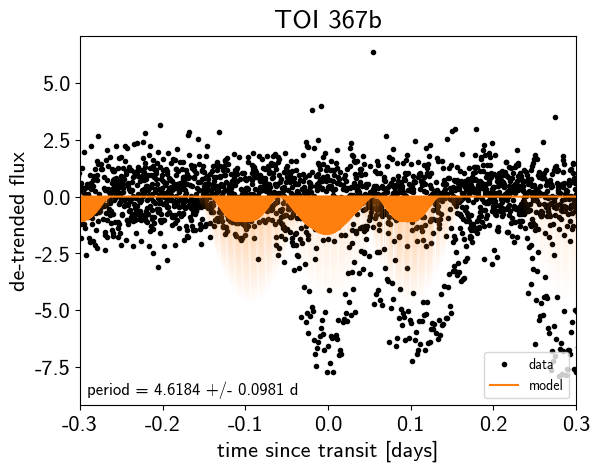

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

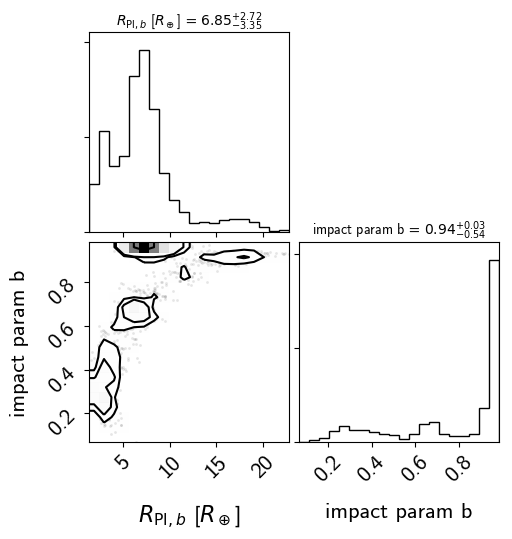

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

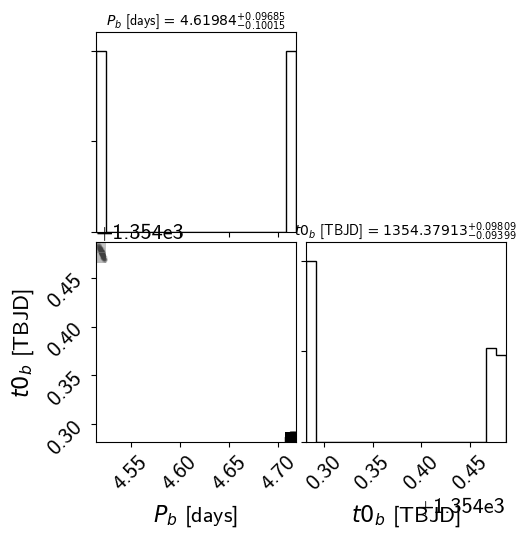

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

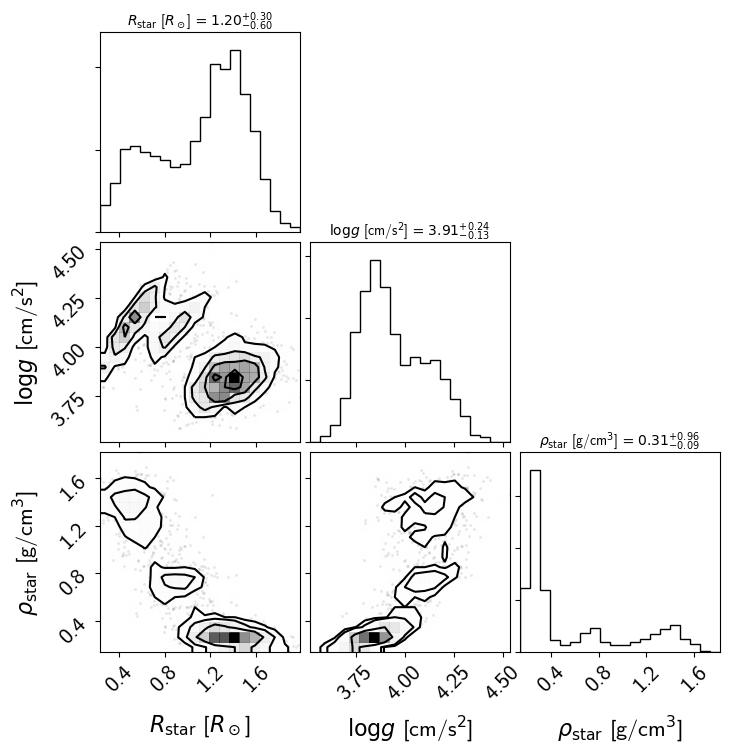

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3